In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip show tensorflow

Name: tensorflow
Version: 2.11.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tensorflow-transform, tensorflowjs, tfx-bsl, witwidget


In [6]:
!pip install tslearn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.1 MB/s eta 0:00:00a 0:00:01


In [7]:
df_train = pd.read_csv("/kaggle/input/asl-signs/train.csv")
print(df_train.shape)
df_train.head(10)

(94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time


In [8]:
json_file_path = "/kaggle/input/asl-signs/sign_to_prediction_index_map.json"
with open(json_file_path, 'r') as j:
     sign_dict = json.loads(j.read())
        
ordered_signs = list(sign_dict.keys())
print(ordered_signs)

['TV', 'after', 'airplane', 'all', 'alligator', 'animal', 'another', 'any', 'apple', 'arm', 'aunt', 'awake', 'backyard', 'bad', 'balloon', 'bath', 'because', 'bed', 'bedroom', 'bee', 'before', 'beside', 'better', 'bird', 'black', 'blow', 'blue', 'boat', 'book', 'boy', 'brother', 'brown', 'bug', 'bye', 'callonphone', 'can', 'car', 'carrot', 'cat', 'cereal', 'chair', 'cheek', 'child', 'chin', 'chocolate', 'clean', 'close', 'closet', 'cloud', 'clown', 'cow', 'cowboy', 'cry', 'cut', 'cute', 'dad', 'dance', 'dirty', 'dog', 'doll', 'donkey', 'down', 'drawer', 'drink', 'drop', 'dry', 'dryer', 'duck', 'ear', 'elephant', 'empty', 'every', 'eye', 'face', 'fall', 'farm', 'fast', 'feet', 'find', 'fine', 'finger', 'finish', 'fireman', 'first', 'fish', 'flag', 'flower', 'food', 'for', 'frenchfries', 'frog', 'garbage', 'gift', 'giraffe', 'girl', 'give', 'glasswindow', 'go', 'goose', 'grandma', 'grandpa', 'grass', 'green', 'gum', 'hair', 'happy', 'hat', 'hate', 'have', 'haveto', 'head', 'hear', 'helic

In [9]:
ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns).fillna(0)
    print(len(data))
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data(pq_path):
    data = pd.read_parquet(pq_path).fillna(0)
    return data

In [10]:
df_train['path'].values[3]

'train_landmark_files/25571/1000210073.parquet'

In [16]:
df_train['sign'].values[3]

'bird'

In [11]:
idx_plot = 3
path_show = "/kaggle/input/asl-signs/"+df_train['path'].values[idx_plot]
sign_plot = df_train['sign'].values[idx_plot]
path_example = path_show.replace("_", "_")

df = load_relevant_data(path_show)
df

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [22]:
 pd.read_parquet('/kaggle/input/asl-signs/train_landmark_files/25571/1000210073.parquet')

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [29]:
path_show = "/kaggle/input/asl-signs/"+df_train['path'].values[1]
sign_show = df_train['sign'].values[1]

In [30]:
df_example = load_relevant_data_subset(path_show)

5973


In [34]:
df_example

array([[[ 0.57777625,  0.5093604 , -0.05024542],
        [ 0.572079  ,  0.47016424, -0.07569572],
        [ 0.5721349 ,  0.48338246, -0.04461873],
        ...,
        [ 0.28654802,  0.51913166, -0.10210015],
        [ 0.33623052,  0.50061655, -0.1054043 ],
        [ 0.37884963,  0.4870799 , -0.10573868]],

       [[ 0.57509214,  0.5065524 , -0.05130414],
        [ 0.5678764 ,  0.46784073, -0.07627443],
        [ 0.5682607 ,  0.48071992, -0.04573298],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.5703879 ,  0.5069116 , -0.05169603],
        [ 0.5651205 ,  0.46642724, -0.07583851],
        [ 0.56588477,  0.4797442 , -0.04535563],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       ...,

       [[ 0.5444518 ,  0.50689507, -0.05266128],
        [ 0

In [31]:
df_example.shape[0]

11

In [32]:
df_example.shape[1]

543

In [35]:
df_example.shape

(11, 543, 3)

In [12]:
path_show = "/kaggle/input/asl-signs/"+df_train['path'].values[1]
sign_show = df_train['sign'].values[1]

df_example = load_relevant_data_subset(path_show)

frames = df_example.shape[0]
keypoints = df_example.shape[1]
position = df_example.shape[2]

print("\nNumber of frames:", frames)
print("Keypoints:", keypoints)
print("X, Y Z postions:", position)
print("Total number of datapoints in this sequence:", np.prod(df_example.shape))


pose_landmarks = 33
face_landmarks = 468
right_hand_landmarks = 21
start_left_hand = face_landmarks
left_hand_landmarks = 21
start_right_hand = face_landmarks + left_hand_landmarks + pose_landmarks
total_landmarks = pose_landmarks + face_landmarks + right_hand_landmarks + left_hand_landmarks


print("\nPose landmarks:", pose_landmarks)
print("Face landmarks:", face_landmarks)
print("Right hand landmarks:", right_hand_landmarks)
print("Left hand landmarks:", left_hand_landmarks)
print("Total landmarks/keypoints: ", total_landmarks)

5973

Number of frames: 11
Keypoints: 543
X, Y Z postions: 3
Total number of datapoints in this sequence: 17919

Pose landmarks: 33
Face landmarks: 468
Right hand landmarks: 21
Left hand landmarks: 21
Total landmarks/keypoints:  543


In [13]:
from tqdm import tqdm

max_sequence_length = 32
lip_marks = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]  

lips = lip_marks
left_hand = [*range(start_left_hand, start_left_hand+left_hand_landmarks, 1)]
right_hand = [*range(start_right_hand, start_right_hand+right_hand_landmarks, 1)]
meaningful_keypoints = lips + left_hand + right_hand
input_length = len(meaningful_keypoints)*3

def get_data(file_paths, y_sign):
    
    X = np.empty((file_paths.shape[0], max_sequence_length, len(meaningful_keypoints)*3), dtype=float)

    for i in tqdm(range(file_paths.shape[0])):
        file_name = "/kaggle/input/asl-signs/"+file_paths[i]
        data = load_relevant_data_subset(file_name)
        
        data = data[:, meaningful_keypoints]
        
        if data.shape[0] < max_sequence_length:
            rows = max_sequence_length - data.shape[0]
            data = np.append(np.zeros((rows, len(meaningful_keypoints), 3)), data, axis=0)
        elif data.shape[0] > max_sequence_length:
            data = data[-(max_sequence_length):]

        X[i] = data.reshape(max_sequence_length, len(meaningful_keypoints)*3, order='F')
        
        del data
        
    X = np.asarray(X).astype(np.float32)
        
    y = []
    for sign in y_sign:
        y.append(sign_dict[sign])

    y = np.array(y, dtype=int)

    return X, y

LSTM Training

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import pad_sequences

In [18]:
def scaled_dot_product(q,k,v, softmax):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [19]:
# a single dense block followed by a normalization block and relu activation
def dense_block(units):
    fc = layers.Dense(units)
    norm = layers.LayerNormalization()
    act = layers.Activation("relu")
    drop = layers.Dropout(0.05)
    return lambda x: drop(act(norm(fc(x))))

# transformer blocks
def transformer_block(key_dim, x):
    mha = MultiHeadAttention(key_dim, 8)(x)
    add1 = layers.add([mha, x])
    norm1 = layers.LayerNormalization()(add1)

    fc = layers.Dense(key_dim, activation="relu")(norm1)
    add2 = tf.math.add(fc, norm1)
    norm2 = layers.LayerNormalization()(add2)

    return norm2

# the final dense block for the classification
def classifier_lstm(units):
    lstm = layers.LSTM(units)
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(lstm(x))
    
def classifier_transformer():
    dense = layers.Dense(256, activation="relu")
    drop = layers.Dropout(0.1)
    
    out = layers.Dense(250, activation="softmax", name="outputs")
    return lambda x: out(drop(dense(x)))

inputs = tf.keras.Input(shape=(None, input_length), ragged=True)
# choose the number of nodes per layer
embedding_units = [256, 128, 256] # tune this
transformer_units = []#, 512, 512]

# # dense encoder model
x = inputs
for n in embedding_units:
    x = dense_block(n)(x)
    
for t in transformer_units:
    x = transformer_block(t, x)

# classifier layer
if len(transformer_units) > 0:
    # Pooling
    x = tf.math.reduce_sum(x, axis=1)
    out = classifier_transformer()(x)
else:
    out = classifier_lstm(embedding_units[-1])(x)


model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 246)]       0         
                                                                 
 dense (Dense)               (None, None, 256)         63232     
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 256)         0         
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         32896     
                                                             

In [20]:
# add a decreasing learning rate scheduler to help convergence
batch_size = 256
validation_percentage = 0.05
steps_per_epoch = int(94477*(1-validation_percentage)) // batch_size
boundaries = [steps_per_epoch * n for n in [23, 35, 45, 53, 60]]
# print(boundaries)
values = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
lr_sched = optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

optimizer = optimizers.Adam(lr_sched)
# optimizer = optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(name="loss"),
              metrics=["accuracy","sparse_top_k_categorical_accuracy"])

In [21]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.2,
            patience = 5
        ),
    ]

In [2]:
mode='training'

In [22]:
if mode == "training":
    file_paths = df_train['path'].values#[:1000]
    y_sign = df_train['sign'].values#[:1000]
    X, y = get_data(file_paths, y_sign)

    X, X_val, y, y_val = train_test_split(X, y, test_size=validation_percentage, random_state=123)

#     print(X.shape)
#     print(y.shape)

    history = model.fit(X, y, 
                    epochs=5,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks=[get_callbacks()]
                   )

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

  0%|          | 12/94477 [00:00<28:14, 55.76it/s]

12489
5973
57015
6516
9774
16290
12489
30951
26607
10317
17919
7059


  0%|          | 18/94477 [00:00<35:12, 44.71it/s]

10317
76563
23349
12489
11946
54300
11946
7059
9774
7059
6516


  0%|          | 38/94477 [00:00<22:49, 68.97it/s]

11403
14118
3258
7602
68961
9231
5973
3258
34209
3258
4344
3801
4344
3801
14661
3258
6516


  0%|          | 46/94477 [00:00<26:52, 58.57it/s]

23892
3258
17376
8145
28779
122175
14661
13032
20634


  0%|          | 62/94477 [00:01<24:28, 64.31it/s]

32580
62988
8688
9774
3258
3258
12489
7602
6516
26064
22263
13032
10860
4887
32037
3801


  0%|          | 79/94477 [00:01<22:35, 69.65it/s]

36924
19548
13032
7602
3258
8145
3801
9774
67875
5973
29322
33666
27150
12489
12489
3258
7602


  0%|          | 97/94477 [00:01<20:30, 76.71it/s]

33666
7602
48327
13032
6516
3258
3258
4344
8145
17919
10317
34209
7602
32580
15204
2715
11403
3258


  0%|          | 105/94477 [00:01<24:01, 65.45it/s]

32037
57015
88509
18462
20091
7059
3258
10860
18462
3258


  0%|          | 119/94477 [00:01<26:17, 59.80it/s]

40725
23349
53214
3801
16290
87423
33123
28779
5430
17919


  0%|          | 129/94477 [00:02<24:26, 64.34it/s]

17376
13032
9774
5430
3258
4344
5973
13575
108057
29865
10860
4344
5430
16290
6516
3801


  0%|          | 147/94477 [00:02<22:02, 71.32it/s]

8145
5430
8688
4344
4887
41268
11403
6516
3258
14118
38553
31494
28236
8145
3258
7602


  0%|          | 163/94477 [00:02<21:36, 72.77it/s]

3258
9231
4344
14661
14661
6516
9774
1629
17919
54300
7602
3258
10860
25521
5973
14118


  0%|          | 172/94477 [00:02<25:51, 60.78it/s]

24435
22806
7602
168873
6516
10860
19548


  0%|          | 185/94477 [00:02<27:59, 56.16it/s]

122175
22806
26064
41268
57015
1629
8145
13032
62988
7059
10317
8145


  0%|          | 202/94477 [00:03<23:37, 66.51it/s]

21177
17376
24435
4344
6516
11403
4344
78735
14661
30408
13575
7602
3258
3801
4344
8688
20091


  0%|          | 219/94477 [00:03<22:30, 69.79it/s]

23892
22806
8688
11946
26064
4344
3258
3258
118917
3258
4887
23349
58644
5430
5430
13032


  0%|          | 236/94477 [00:03<21:23, 73.41it/s]

18462
21177
9231
12489
9774
8145
13032
7602
3258
13575
16290
7059
11403
33123
3258
17376


  0%|          | 244/94477 [00:03<23:20, 67.28it/s]

18462
7602
10860
6516
10860
89052
5430
13032
4887
102084


  0%|          | 258/94477 [00:03<24:42, 63.57it/s]

11403
9231
9774
8688
9231
69504
7602
12489
3258
3258
61902
10317
7059
7602
9231
14661


  0%|          | 276/94477 [00:04<22:12, 70.72it/s]

14661
13032
23349
6516
24435
46698
8688
8688
23892
28779
28236
3258
17919
15747
4887
3258


  0%|          | 292/94477 [00:04<21:12, 74.00it/s]

67875
13575
5430
70590
3258
9231
23892
10860
7059
54300
14661
22263
3258
9231
7602
3258


  0%|          | 310/94477 [00:04<20:15, 77.46it/s]

10860
4887
11403
3258
3258
17919
9231
38553
20634
4344
28779
9774
11946
5430
28236
14118
8145
3258


  0%|          | 329/94477 [00:04<19:48, 79.21it/s]

5430
9231
3258
30408
3258
7602
10860
13575
40182
7602
14661
6516
7059
19548
6516
8688
33123


  0%|          | 337/94477 [00:05<23:52, 65.73it/s]

9774
14661
121089
106428
14661
12489
3801
10860
45612


  0%|          | 353/94477 [00:05<22:24, 69.99it/s]

38010
5973
3801
14118
26064
3258
15204
28236
8688
24978
32580
11403
17919
7602
14661
5973
9774


  0%|          | 369/94477 [00:05<22:16, 70.39it/s]

28779
8688
12489
15204
14118
63531
18462
7059
111315
11946
15747
24435
7059
14661


  0%|          | 378/94477 [00:05<21:18, 73.58it/s]

22806
8688
7602
10860
70590
5973
8145
3258
15747
3258
4887
12489
10317
19005
15204
53757


  0%|          | 394/94477 [00:05<21:29, 72.97it/s]

19005
11403
9774
55929
28236
19548
14661
7602
14661
17919
3801
9774
12489
3258
21720
6516
28236


  0%|          | 411/94477 [00:06<21:39, 72.39it/s]

90138
14661
105885
5973
14118
4887
24435
13032
19005
52671
22806
3801
8688
7602


  0%|          | 427/94477 [00:06<22:04, 70.99it/s]

82536
12489
3258
36924
9774
30408
20634
24435
5973
8688
11403
6516
10317
42897
11403
3258
17376
5973


  0%|          | 444/94477 [00:06<21:32, 72.77it/s]

7602
62988
9231
7602
10317
115116
9774
20091
8145
9774
7602
65703
7059
21720


  0%|          | 460/94477 [00:06<22:33, 69.46it/s]

69504
2715
22263
27693
19548
62445
12489
9231
9231
59187
7602
43440
5973
20634
30408


  1%|          | 474/94477 [00:06<22:53, 68.43it/s]

58644
4344
9231
14118
3258
72219
11403
6516
20634
5973
23349
3801
35295
29865
11946
3258


  1%|          | 491/94477 [00:07<23:28, 66.73it/s]

24435
15204
8688
8688
8688
7602
16833
125976
5430
23892
41268
12489
22263


  1%|          | 506/94477 [00:07<22:49, 68.61it/s]

47241
3801
7059
8688
46698
75477
13575
3801
26064
16290
8688
48327
4344
9231


  1%|          | 513/94477 [00:07<26:13, 59.72it/s]

54843
9774
3258
3258
41811
7059
21177
3258
17919
5973
23892
62445


  1%|          | 528/94477 [00:07<23:55, 65.47it/s]

33123
10317
21177
4887
36381
8145
73848
5430
5973
12489
40725
8145
106428
19548


  1%|          | 542/94477 [00:08<24:13, 64.64it/s]

18462
3801
11946
9774
64617
13032
61902
13032
10317
4887
15747
8145
3258
49956
33666


  1%|          | 556/94477 [00:08<28:13, 55.46it/s]

39639
7059
13032
5430
7059
22263
137379
27150
97197


  1%|          | 571/94477 [00:08<25:40, 60.95it/s]

105885
4344
13575
3258
3258
15747
21720
9774
23892
29322
3258
6516
5430
12489
36924


  1%|          | 578/94477 [00:08<27:06, 57.72it/s]

50499
11946
60816
18462
5430
68961
76020
29865
3258
20091
3258
9231
81993


  1%|          | 592/94477 [00:08<25:46, 60.69it/s]

13575
7602
7602
65703
20091
26064
16833
94482
97197
3258
18462
17919
8688
3258


  1%|          | 611/94477 [00:09<21:50, 71.60it/s]

7602
10317
8688
4344
5430
23349
23349
14118
14118
6516
3258
3258
35295
102084
7059
22806


  1%|          | 626/94477 [00:09<23:32, 66.44it/s]

7602
5973
13032
23892
17376
47784
3258
66246
4887
5430
41268
80364
15204
9231


  1%|          | 633/94477 [00:09<25:07, 62.27it/s]

6516
102627
26064
81450
67332
32580
31494
13575
14118
3258
38553
10317


  1%|          | 649/94477 [00:09<23:16, 67.18it/s]

14118
18462
3258
28779
13575
11946
8145
34752
57558
7059
21177
5430
24435
13032
13032
9774
9774


  1%|          | 667/94477 [00:09<22:25, 69.72it/s]

3258
11946
7602
11403
67875
21720
9774
8145
22806
18462
19005
3258


  1%|          | 675/94477 [00:10<24:56, 62.66it/s]

38010
12489
17376
13032
86880
10317
4344
11946
11946
64074
13575
44526
8145


  1%|          | 690/94477 [00:10<23:33, 66.33it/s]

15747
13032
5430
24435
8145
32580
12489
24978
73848
3258
13575
9231
12489
3258
3258


  1%|          | 705/94477 [00:10<25:11, 62.03it/s]

14118
39096
3258
5973
32580
5973
90138
16833
9231
25521
21720


  1%|          | 720/94477 [00:10<26:09, 59.75it/s]

53214
49956
24435
52128
7602
15747
14118
11946
12489
17376
8688
67875


  1%|          | 727/94477 [00:10<27:32, 56.73it/s]

117831
10860
49956
3801
70047
6516
13575
3801
19005
42354
32037
28779
7059
7602


  1%|          | 742/94477 [00:11<26:37, 58.68it/s]

71133
13575
3801
5973
14118
13032
137379
9231
29865
5973
36924


  1%|          | 756/94477 [00:11<26:15, 59.49it/s]

56472
30408
31494
9231
81993
9774
3258
3258
10860
17376
7602
4887
13032
15204
17919


  1%|          | 772/94477 [00:11<24:06, 64.79it/s]

15204
3258
30951
3258
9231
77649
55929
14661
3258
11946
67875
5430
3258
18462


  1%|          | 789/94477 [00:11<22:55, 68.13it/s]

4887
7059
50499
8688
4887
12489
17376
8145
8145
4344
24978
24435
3258
24435
99369


  1%|          | 798/94477 [00:12<21:23, 72.98it/s]

13575
7602
26607
3258
3258
59187
3258
4887
6516
20634
3801
5973
11403
41811
10317
24435


  1%|          | 814/94477 [00:12<22:51, 68.31it/s]

36924
3258
16290
26607
7602
52671
8145
12489
65160
6516
34752
11403
13032
8145


  1%|          | 831/94477 [00:12<20:45, 75.18it/s]

28779
50499
4344
7602
9231
4887
10860
17376
11403
32037
9231
8688
16833
7059
3258
34752
27150


  1%|          | 847/94477 [00:12<20:48, 74.96it/s]

6516
4344
15747
5430
43440
3258
7602
83622
3258
20634
13032
15747
9774
12489
4344
3258
3258


  1%|          | 865/94477 [00:12<21:32, 72.42it/s]

18462
7602
12489
27693
44526
128691
10317
8145
13032
6516
3258
47784
23349
3258


  1%|          | 882/94477 [00:13<21:39, 72.03it/s]

8145
3258
8688
8145
3258
10860
3258
84165
7059
24978
17919
33123
16833
16833
15204


  1%|          | 900/94477 [00:13<19:57, 78.16it/s]

27693
8145
2172
3258
16290
3801
8688
24978
10860
43440
8145
8688
30408
3258
4344
9774
8145
27693


  1%|          | 908/94477 [00:13<20:00, 77.92it/s]

3258
3258
32580
16833
32037
5973
66789
10860
8145
10860
20634
85794
3258


  1%|          | 925/94477 [00:13<20:50, 74.80it/s]

40725
3258
11403
13032
3801
8688
6516
8688
16290
25521
3801
12489
7602
15747
49413
7602
3258


  1%|          | 942/94477 [00:13<20:25, 76.34it/s]

80364
36381
7059
9774
63531
23892
5973
4887
13575
32580
14661
7059
5973
12489
3258
5973
31494
27150


  1%|          | 961/94477 [00:14<19:05, 81.60it/s]

8688
26064
23349
13032
30408
3258
4344
10317
17919
9231
13575
29865
5430
5973
8688
17376


  1%|          | 970/94477 [00:14<21:27, 72.60it/s]

69504
8145
104256
26064
7602
16833
20634
19005
22263
11946
3258
6516
5430
17376


  1%|          | 987/94477 [00:14<22:07, 70.44it/s]

7602
65160
7059
11403
4344
9774
13575
22806
42897
5973
7059
9231
15747
17376


  1%|          | 1004/94477 [00:14<21:25, 72.69it/s]

36924
9774
8145
4344
26064
29865
12489
10317
17919
46155
5973
3258
23892
9774
16290
14118


  1%|          | 1021/94477 [00:14<20:22, 76.47it/s]

8145
19005
3258
29322
9774
5973
11946
13032
13032
32580
34209
21177
38553
11946
30408
4344
13032


  1%|          | 1038/94477 [00:15<21:32, 72.27it/s]

22806
9774
23892
9231
33123
76020
15747
24978
24435
8688
10317
12489
8688


  1%|          | 1046/94477 [00:15<23:15, 66.94it/s]

18462
72219
26064
22263
19548
12489
9231
3258
22263
3258
51042
57015
9231


  1%|          | 1060/94477 [00:15<23:16, 66.87it/s]

7059
5973
3258
3258
22806
67332
32580
13575
23892
16290
97197
16833
11946
4344
12489


  1%|          | 1077/94477 [00:15<20:49, 74.76it/s]

27150
3258
14118
11403
9231
16290
7059
6516
5430
14661
11403
10860
3258
3258
4344
8145
5430
26607
8145


  1%|          | 1094/94477 [00:16<21:08, 73.63it/s]

23349
91767
34752
4344
19548
19548
3258
20634
3801
97740
10317


  1%|          | 1102/94477 [00:16<23:19, 66.70it/s]

22806
3801
6516
16290
5973
59187
16833
11403
7059
7602
5430
23349
9774


  1%|          | 1120/94477 [00:16<22:00, 70.67it/s]

103713
3258
35295
14661
10317
8145
14661
13575
8145
8145
13032
14118
3258
11946
17919
45069
16833


  1%|          | 1136/94477 [00:16<21:59, 70.73it/s]

43440
15747
8145
34209
3258
21177
17919
9774
10317
29865
28236
3258
3258
3801
3258
62988


  1%|          | 1152/94477 [00:16<23:40, 65.71it/s]

3258
21177
82536
116202
12489
3258
10317
22806
9231
16833
15747
14118


  1%|          | 1161/94477 [00:17<22:05, 70.42it/s]

21720
3258
7059
18462
16290
4887
9231
19548
13575
16290
9774
113487
4887
60816


  1%|          | 1176/94477 [00:17<23:10, 67.09it/s]

7602
3258
3258
13032
20634
23892
15747
29865
11946
9774
15747
19005
54300
3801


  1%|▏         | 1193/94477 [00:17<22:08, 70.22it/s]

122175
4887
3258
16833
3258
3801
23892
14661
22806
4887
23349
3258
13575
5430
14118
5430
47241
10317


  1%|▏         | 1211/94477 [00:17<20:07, 77.21it/s]

9231
16833
9774
3258
3258
9231
33123
10317
3258
3258
15747
3258
4887
27150
7602


  1%|▏         | 1227/94477 [00:17<23:17, 66.71it/s]

38010
12489
7602
16833
3258
11403
5973
7602
36381
86880
12489
60816
6516


  1%|▏         | 1243/94477 [00:18<22:25, 69.28it/s]

113487
5430
3258
60273
7602
8145
7602
7059
5430
28236
20634
23349
32580
7602
3258
6516
4887
36924


  1%|▏         | 1251/94477 [00:18<22:12, 69.98it/s]

6516
82536
7059
9231
54300
9774
3258
26064
89595
11946
11403
34209


  1%|▏         | 1267/94477 [00:18<22:58, 67.61it/s]

62445
49956
13032
3258
8145
8145
16833
28779
8145
108057
3258
11946
60273


  1%|▏         | 1282/94477 [00:18<22:59, 67.58it/s]

3258
3258
8145
7059
110229
15204
4887
11403
4887
9774
4344
8688
8145
10317
48327
3258
3258
3258


  1%|▏         | 1299/94477 [00:19<21:26, 72.43it/s]

12489
47241
12489
11403
3258
9231
15204
25521
32580
59730
38553
26064
79278


  1%|▏         | 1315/94477 [00:19<22:43, 68.32it/s]

9231
16290
7602
6516
3258
92853
9231
8688
64617
7602
6516
19005
13032
7602
11946


  1%|▏         | 1331/94477 [00:19<21:58, 70.66it/s]

3258
84708
3258
127605
3258
13032
15747
13575
35295
4344
4344
4887
9231
8688


  1%|▏         | 1348/94477 [00:19<20:35, 75.37it/s]

40725
11946
3258
45612
5973
16290
8688
5973
9774
12489
9231
3258
28236
23349
47784
10860
7059


  1%|▏         | 1357/94477 [00:19<20:16, 76.52it/s]

18462
7602
11946
8688
48327
3258
15204
4887
17376
15747
16833
4344
3258
15747
3258
14661
17376
17376


  1%|▏         | 1376/94477 [00:20<19:37, 79.04it/s]

4344
17376
34752
20634
4887
24978
13032
9231
17919
22806
8688
46155
10860
14118
3258
9231


  1%|▏         | 1392/94477 [00:20<22:56, 67.62it/s]

49413
26607
94482
4344
27693
12489
4887
113487
3258
7059
15747


  1%|▏         | 1399/94477 [00:20<27:40, 56.06it/s]

16833
19548
9231
145524
100998
11946
3258
17919
14118


  1%|▏         | 1407/94477 [00:20<27:59, 55.40it/s]

3258
11946
8145
8145
77106
16290
36381
27150
7059
8145
7059


  2%|▏         | 1421/94477 [00:20<26:15, 59.07it/s]

65160
19548
6516
5430
13575
3258
5430
68418
20634
112944
5430
2172


  2%|▏         | 1435/94477 [00:21<25:03, 61.90it/s]

13575
6516
9774
11946
17919
9774
15747
13032
12489
43983
32580
14661
10860
21720
16833


  2%|▏         | 1449/94477 [00:21<27:27, 56.48it/s]

43983
16290
118917
3258
11403
22263
11946
90681
12489
9231
13575


  2%|▏         | 1467/94477 [00:21<23:04, 67.17it/s]

7059
17376
3801
16833
3258
3801
22806
9231
7602
7602
19005
22806
7059
53757
3801
46155


  2%|▏         | 1475/94477 [00:21<22:01, 70.35it/s]

17919
42897
3258
10860
5973
13032
3258
34752
4344
21177
3258
3258
19005
11403
27693
11946


  2%|▏         | 1492/94477 [00:21<22:54, 67.65it/s]

79821
27693
22263
32037
7602
15747
36924
8688
3258
7602
68418
3801
3801
13032


  2%|▏         | 1507/94477 [00:22<22:05, 70.13it/s]

66246
10860
78735
34752
10860
10860
3258
3801
10317
10860
21177
5973
12489
15204
14118


  2%|▏         | 1522/94477 [00:22<25:20, 61.13it/s]

62988
27150
13575
16290
13575
45069
65703
28236
3258
10860
26064


  2%|▏         | 1529/94477 [00:22<24:56, 62.11it/s]

15204
16833
4887
99912
8688
5973
3258
13032
6516
28236
13575
10860
26064


  2%|▏         | 1545/94477 [00:22<23:45, 65.20it/s]

96654
26064
3258
18462
10860
16290
4887
45612
6516
42354
37467
7602
7059
8688
15747
8688


  2%|▏         | 1561/94477 [00:22<22:41, 68.25it/s]

39639
5973
3258
21720
12489
3258
16833
7602
86880
49956
93939
29322


  2%|▏         | 1576/94477 [00:23<23:35, 65.65it/s]

9774
10860
3258
60816
41268
15204
14661
17919
3258
13575
16833
6516
6516
29865


  2%|▏         | 1592/94477 [00:23<22:46, 67.99it/s]

80364
3258
4887
17919
9774
10860
7059
11403
11946
10860
8688
95025
9231
60273
20634
19005


  2%|▏         | 1601/94477 [00:23<21:07, 73.25it/s]

10860
8688
16833
8688
9774
3258
8145
9231
10317
3258
4344
13032
30408
41268


  2%|▏         | 1620/94477 [00:23<20:21, 76.00it/s]

87966
19005
6516
5973
4887
3258
11403
4344
4887
13032
3258
22806
26607
4887
10860
34209
39096


  2%|▏         | 1636/94477 [00:24<21:22, 72.41it/s]

18462
19005
3258
23892
13032
59187
30408
16833
11946
5973
12489
11946
21720
3258
7602
5430
11403


  2%|▏         | 1655/94477 [00:24<22:08, 69.85it/s]

10317
13575
11403
5430
58644
28236
24435
3258
12489
8145
3258
3258
134664


  2%|▏         | 1674/94477 [00:24<19:23, 79.73it/s]

7059
6516
47784
10860
10860
3258
10860
9231
10317
7059
2172
4887
7602
5973
16833
7059
8688
20091
38010


  2%|▏         | 1693/94477 [00:24<18:24, 83.99it/s]

36924
7059
29865
5430
6516
10317
15204
3258
4344
4344
8145
8145
8688
3258
5430
5430
43440
17919
14661


  2%|▏         | 1702/94477 [00:24<19:10, 80.67it/s]

32580
12489
3258
11403
3258
7602
39096
13032
27150
14118
14661
16290
16290
9774
13575
17919
4344


  2%|▏         | 1721/94477 [00:25<18:15, 84.65it/s]

5973
3258
3258
9231
17919
9231
16290
23349
24435
3258
7059
3258
27150
92853
3258
14118


  2%|▏         | 1738/94477 [00:25<22:00, 70.24it/s]

23349
3258
8145
41268
6516
21177
112944
84708
7059
12489
4887
12489
4887


  2%|▏         | 1746/94477 [00:25<21:47, 70.93it/s]

4887
68961
13032
7059
28236
27693
5973
88509
3258
22806
20091
7602
3258
13032


  2%|▏         | 1762/94477 [00:25<24:10, 63.91it/s]

15204
84165
3258
30951
29865
16290
101541
6516
10860
8145
16833


  2%|▏         | 1776/94477 [00:25<24:22, 63.37it/s]

70590
15747
6516
28779
39096
8145
43440
39096
28779
9231
12489
33123
13575
22806


  2%|▏         | 1793/94477 [00:26<21:54, 70.54it/s]

8145
9774
8145
9774
50499
5430
8688
3801
22806
6516
5973
46155
3258
3258
59730
10317
5430


  2%|▏         | 1801/94477 [00:26<22:49, 67.66it/s]

15204
84165
3258
84165
12489
10317
9774
22806
95025
17376
8688


  2%|▏         | 1817/94477 [00:26<24:48, 62.26it/s]

114573
12489
5430
3258
3258
7602
10860
58644
19005
11403
26064
10317
7602
65703
5973
10860
3258


  2%|▏         | 1831/94477 [00:26<24:48, 62.24it/s]

88509
3258
39096
12489
3258
34209
9231
11946
12489
10860
13032
11403
54843
3801


  2%|▏         | 1846/94477 [00:27<22:54, 67.39it/s]

26607
69504
15204
3258
9231
12489
22806
8145
28779
3801
16290
23892
42354
9231


  2%|▏         | 1860/94477 [00:27<25:55, 59.54it/s]

78192
3258
127062
8145
3258
3801
28236
3801
11946
3258
5973
8145
5973


  2%|▏         | 1877/94477 [00:27<23:22, 66.01it/s]

130320
6516
32037
15747
5973
41268
3258
3801
3258
11403
7059
3258
61359
4344
42897
3258
14118


  2%|▏         | 1884/94477 [00:27<25:03, 61.58it/s]

34209
3258
103713
17376
144981
3258
97740
17376


  2%|▏         | 1900/94477 [00:27<24:35, 62.72it/s]

8688
5430
29322
3258
12489
32580
4887
28779
8145
3258
3258
7059
5973
4887
10860
10860


  2%|▏         | 1917/94477 [00:28<21:21, 72.20it/s]

77649
33666
4344
6516
17376
3258
22806
8145
3258
28779
4887
12489
3258
7059
14118
10860
3258
21720


  2%|▏         | 1934/94477 [00:28<21:39, 71.23it/s]

11946
11946
3258
11403
10317
7602
8145
7059
121632
8145
5430
23892
68961


  2%|▏         | 1950/94477 [00:28<22:02, 69.97it/s]

9231
29322
21720
26064
4887
17376
8145
21720
28236
8145
20091
5430
5973
24978
14118
4344


  2%|▏         | 1967/94477 [00:28<20:50, 73.97it/s]

16290
20091
3258
10317
5973
16290
54300
36924
3258
14118
3258
28779
8145
61359
30408
4887


  2%|▏         | 1975/94477 [00:28<22:47, 67.63it/s]

3258
43440
48327
8688
17919
82536
15204
3258
16833
43440
27693
24435


  2%|▏         | 1990/94477 [00:29<22:23, 68.83it/s]

14118
72219
42354
30408
9774
8145
3258
5973
23349
8145
4887
12489
8688
20634
42897


  2%|▏         | 2006/94477 [00:29<21:36, 71.30it/s]

34752
16833
23349
58101
21720
14118
4344
10860
23892
9231
19548
14661
5430
16290
54300


  2%|▏         | 2014/94477 [00:29<22:59, 67.01it/s]

38553
116745
7059
17376
51585
22806
5973
41811
32580


  2%|▏         | 2028/94477 [00:29<30:27, 50.58it/s]

65703
3258
39096
74391
57015
3258
12489
140637
20634


  2%|▏         | 2037/94477 [00:30<27:05, 56.86it/s]

5973
5973
29322
3801
3258
4344
8688
34752
69504
8688
8688
55386
28236
9231
17376


  2%|▏         | 2052/94477 [00:30<24:49, 62.03it/s]

23349
12489
13032
14661
52128
28236
11403
11403
3801
16833
21720
6516
10860
7602
8688
11946


  2%|▏         | 2068/94477 [00:30<23:35, 65.26it/s]

34209
79278
27150
31494
5973
46155
16290
45612
7059
9774
21720
7059


  2%|▏         | 2082/94477 [00:30<25:04, 61.40it/s]

79821
18462
6516
8688
7059
3801
8688
64074
83622
4344
120546


  2%|▏         | 2089/94477 [00:30<26:49, 57.40it/s]

141723
4344
3258
116745
3258
3258
10317
17919
6516
21720
83079
17919


  2%|▏         | 2102/94477 [00:31<26:34, 57.93it/s]

21720
13575
21177
78192
20634
3258
12489
28236
3258
60816
3258
5430
10860
5430
3258


  2%|▏         | 2118/94477 [00:31<26:02, 59.11it/s]

9774
54300
29322
17376
41811
9774
61359
8688
13032
82536


  2%|▏         | 2132/94477 [00:31<26:01, 59.15it/s]

165615
22806
5430
13575
24435
3258
26064
22263
5430
15204
5973
110229
9774
17376
37467


  2%|▏         | 2148/94477 [00:31<23:04, 66.70it/s]

14118
85794
9231
3258
1086
17376
11946
8688
8145
11946
3258
7059
10317
10317
11946
8688


  2%|▏         | 2166/94477 [00:32<20:23, 75.46it/s]

23349
4887
6516
47784
12489
3258
20091
17919
3258
8145
33666
3258
10317
18462
12489
17376
3258
5973


  2%|▏         | 2184/94477 [00:32<20:07, 76.44it/s]

12489
3258
4887
16290
5973
27150
3258
32037
3258
7059
8688
6516
103170
5973
5430
8145


  2%|▏         | 2194/94477 [00:32<18:43, 82.17it/s]

7059
13575
13032
17919
10860
3258
6516
3258
10317
12489
60816
15747
12489
11403
10860
74391


  2%|▏         | 2213/94477 [00:32<19:48, 77.60it/s]

29865
22263
14118
5430
5973
7602
8688
15204
5430
16290
17919
5430
12489
7602
65160
4344


  2%|▏         | 2231/94477 [00:32<19:21, 79.43it/s]

43440
3258
72762
13032
3258
3258
7602
11946
3258
9231
17376
11403
12489
9231
4887
69504
9231


  2%|▏         | 2240/94477 [00:32<19:53, 77.31it/s]

16290
15204
5430
3258
7059
17376
6516
30951
20634
7059
45069
5973
39096
27693


  2%|▏         | 2258/94477 [00:33<19:56, 77.08it/s]

60273
6516
4344
10860
14661
16833
3258
6516
3258
8145
10317
13575
6516
4887


  2%|▏         | 2274/94477 [00:33<22:39, 67.80it/s]

89595
20634
18462
17376
11946
3258
37467
7059
10317
4344
36381
6516
15204
10317
13032


  2%|▏         | 2291/94477 [00:33<20:58, 73.23it/s]

49956
7059
11403
12489
9774
3801
13575
9231
42897
52671
4887
3258
16833
4344
22806
3258
3258
30408


  2%|▏         | 2310/94477 [00:33<20:29, 74.94it/s]

8145
9774
23892
20634
3258
8688
8145
3258
17376
4887
92853
3258
3801
38553
8145
90138


  2%|▏         | 2318/94477 [00:34<21:25, 71.68it/s]

7602
11946
13575
3258
39096
60273
46698
10860
17919
22263
6516
6516
14661
15204
13575


  2%|▏         | 2337/94477 [00:34<21:35, 71.12it/s]

5430
4344
40182
4344
6516
52671
34752
9231
6516
8688
3801
118374
26064


  2%|▏         | 2345/94477 [00:34<22:04, 69.56it/s]

17376
36924
11946
43983
11946
22263
55929
8145
16833
8688
13575
12489
11403
3258
7059
9774
3258


  3%|▎         | 2364/94477 [00:34<20:14, 75.82it/s]

20091
3258
5973
48870
8688
72219
3258
21177
21177
40182
3258
13032


  3%|▎         | 2380/94477 [00:34<22:39, 67.76it/s]

117831
7602
80364
32580
12489
19548
93939
8688
5430
6516
6516
3258
11403
13032


  3%|▎         | 2396/94477 [00:35<22:18, 68.79it/s]

24435
12489
94482
7059
22263
10860
16290
102627
16833
9774
3258
7059
10860
9774
9774


  3%|▎         | 2414/94477 [00:35<20:02, 76.54it/s]

14661
11403
9774
9774
13575
3258
7602
12489
22806
5973
14661
32580
30408
6516
3801
14118
46698
13575


  3%|▎         | 2422/94477 [00:35<22:11, 69.16it/s]

47241
27150
38553
10317
18462
6516
32580
98283
6516
26607
16833
22806
23892
41811


  3%|▎         | 2438/94477 [00:35<20:50, 73.63it/s]

7602
3258
10317
8145
3258
36381
3258
10860
3258
9231
111315
34752
7059
3801
8688
4887


  3%|▎         | 2454/94477 [00:35<21:08, 72.56it/s]

45069
14118
11946
24435
8145
6516
9231
82536
30951
25521
3801
13575
28779
32037
9774


  3%|▎         | 2470/94477 [00:36<21:18, 71.95it/s]

67332
9774
15204
9231
63531
9774
15747
20091
3258
22806
47241
8145
15204
16290
36924
3801


  3%|▎         | 2486/94477 [00:36<21:34, 71.06it/s]

3801
65703
5973
29865
8688
32580
43983
10860
5973
10317
3801
65160
16290


  3%|▎         | 2502/94477 [00:36<21:06, 72.61it/s]

33123
20634
10317
7059
6516
6516
9231
8688
3258
23349
6516
21720
55929
20091
40725
5973
3801


  3%|▎         | 2522/94477 [00:36<18:28, 82.92it/s]

4887
3258
3258
10317
30408
7059
5973
19548
5973
3258
7602
12489
21720
3258
23349
13575
5430
8688
53214


  3%|▎         | 2539/94477 [00:37<20:25, 75.00it/s]

73305
75477
13032
5430
18462
18462
3801
3258
21720
51042
28236
46698
4344
3258
3258


  3%|▎         | 2547/94477 [00:37<20:34, 74.46it/s]

52128
9774
3258
86880
10860
11403
3258
3258
40182
4344
13032
18462
12489
2172
5973


  3%|▎         | 2563/94477 [00:37<22:06, 69.28it/s]

67332
11403
3258
8145
123261
7059
24978
3258
28236
13032
11403
15204
42897
13575


  3%|▎         | 2580/94477 [00:37<20:59, 72.98it/s]

11403
5973
21177
5430
3258
20091
18462
3258
3258
21177
15747
17919
26064
28236
8145
9774


  3%|▎         | 2595/94477 [00:37<23:40, 64.68it/s]

96111
40182
34209
25521
3258
20091
63531
81450
3258
35295
4344
7602
61359


  3%|▎         | 2612/94477 [00:38<21:38, 70.75it/s]

10317
66789
5430
19005
11946
17376
11403
7602
14661
35295
23349
5430
14118
5430
21177
32580


  3%|▎         | 2621/94477 [00:38<20:51, 73.39it/s]

13032
8688
20091
8688
11403
7059
10317
24978
13575
9774
4887
3258
10317
8145
118374


  3%|▎         | 2637/94477 [00:38<21:39, 70.67it/s]

8688
5430
3258
23892
25521
22263
14661
104799
10860
15204
9774
9231
13575
24978
8145
14118


  3%|▎         | 2657/94477 [00:38<19:09, 79.91it/s]

5973
9231
9231
11946
5973
3258
6516
3801
8688
30951
11403
9231
29322
52128
8688
10860
3258


  3%|▎         | 2676/94477 [00:39<20:23, 75.05it/s]

36924
12489
7059
91767
12489
4344
15204
12489
21720
3258
27150
3258
6516
9231
3258


  3%|▎         | 2684/94477 [00:39<25:03, 61.04it/s]

60816
14118
112401
179190
11946
9231
62988
13575
17376
34752


  3%|▎         | 2699/94477 [00:39<23:25, 65.29it/s]

3258
57015
7602
24435
7602
7059
4887
15747
5430
16833
21177
6516
43440
15747
4344


  3%|▎         | 2717/94477 [00:39<20:25, 74.85it/s]

53757
12489
8145
72219
10860
8688
17376
7059
7059
29865
14118
3258
28236
7059
5973
3258
47784
3258


  3%|▎         | 2735/94477 [00:39<18:51, 81.07it/s]

7602
5973
82536
9774
3258
13575
13032
3258
5430
11403
9231
3258
23892
19548
5430
22263
28236


  3%|▎         | 2744/94477 [00:39<20:41, 73.91it/s]

15747
3258
12489
28779
13032
8688
11946
109143


  3%|▎         | 2759/94477 [00:40<24:03, 63.52it/s]

156384
11403
49413
10860
35295
14661
40725
17919
9231
117831
14661
42897
3258
10317
9231


  3%|▎         | 2769/94477 [00:40<21:38, 70.65it/s]

7059
17376
28236
10860
17919
2172
3258
3258
8688
27150
21177
9231
13575
16290
5973
16833
7602


  3%|▎         | 2785/94477 [00:40<21:20, 71.62it/s]

72762
3258
8688
19005
52128
5430
7059
38010
3258
22806
5973
22806
41268
6516


  3%|▎         | 2793/94477 [00:40<21:47, 70.13it/s]

82536
13575
5430
91767
115116
7602
21720
41811
3258


  3%|▎         | 2812/94477 [00:41<22:16, 68.58it/s]

16290
14661
3801
8688
7059
7059
3258
8688
1629
3258
15204
5973
50499
13032
8688
9774
10317
4887
60816
3258


  3%|▎         | 2831/94477 [00:41<20:39, 73.91it/s]

9774
2715
11946
16833
3801
16290
32580
13032
4887
7602
21177
98283
59730
7059
3258
14118


  3%|▎         | 2847/94477 [00:41<20:54, 73.06it/s]

3258
15204
42897
10317
18462
3258
7059
13032
10317
80364
14118
26064
67332
10860


  3%|▎         | 2863/94477 [00:41<20:06, 75.91it/s]

3258
8145
5430
19005
3258
16290
8688
20634
14661
11403
3801
3258
7602
47784
6516
15204
19005


  3%|▎         | 2879/94477 [00:41<20:27, 74.64it/s]

54300
27693
71676
10317
5430
6516
3258
6516
8145
24978
15747
11403
71133
46698
15747


  3%|▎         | 2896/94477 [00:42<20:37, 73.98it/s]

20091
8145
11403
100455
4887
10860
16833
15204
3258
3258
7059
9774
23349
3258
56472
21720


  3%|▎         | 2904/94477 [00:42<22:02, 69.25it/s]

96654
8688
10860
4887
7059
41268
8688
30951
15747
56472
116202
31494


  3%|▎         | 2919/94477 [00:42<24:04, 63.36it/s]

27150
26064
4887
23892
124890
17919
17376
3258
4344
7059
8688
11403
11403
16833
3258


  3%|▎         | 2934/94477 [00:42<22:17, 68.46it/s]

3258
85251
15747
28236
17376
19005
30951
11403
7059
4344
12489
19548
11403
3258
10860
3258


  3%|▎         | 2954/94477 [00:42<20:09, 75.66it/s]

3258
14118
7602
39639
3258
7602
3258
14118
6516
8145
7602
30408
16833
22806
50499


  3%|▎         | 2971/94477 [00:43<19:25, 78.53it/s]

10860
3258
9774
22806
3258
28236
17376
4887
3258
4887
3258
27150
16833
19005
8145
3258
9231


  3%|▎         | 2979/94477 [00:43<20:56, 72.82it/s]

23892
26607
32580
5430
3258
81450
42897
12489
4344
7602
66789
32037
1086


  3%|▎         | 2996/94477 [00:43<21:10, 72.00it/s]

76563
35295
4344
7059
3258
10317
3258
3258
72762
3258
61902
11403
8145
52671
4887
8688
9231


  3%|▎         | 3015/94477 [00:43<19:00, 80.20it/s]

3801
3258
3801
7059
7602
11403
9231
3258
3258
3801
12489
34209
14661
8145
5973
9774
4344
3258
11403
11946


  3%|▎         | 3034/94477 [00:44<18:47, 81.09it/s]

11946
46155
13032
23892
5973
34209
47241
6516
16290
5973
6516
64617
3258
8145
3258
33666


  3%|▎         | 3053/94477 [00:44<19:05, 79.85it/s]

9231
53757
3258
9231
7059
11946
13032
67332
32580
5430
10317
8688
13032
10317
22806
5973


  3%|▎         | 3062/94477 [00:44<20:57, 72.70it/s]

20634
11946
36381
12489
3258
3258
58644
3258
16833
23892
3258
7059
14118
53757


  3%|▎         | 3078/94477 [00:44<21:24, 71.14it/s]

20091
11946
19005
30408
71133
15204
17376
13032
27150
12489
13575
10317
39096
15747
14118


  3%|▎         | 3095/94477 [00:44<21:23, 71.17it/s]

8688
42897
69504
13032
8688
9231
18462
10860
18462
8688
8145
17376
4344
20634


  3%|▎         | 3111/94477 [00:45<21:11, 71.84it/s]

18462
26607
6516
26064
5973
117288
3801
24435
90681
9774
15747
3258
5973
5430
9231


  3%|▎         | 3127/94477 [00:45<20:21, 74.79it/s]

15204
7602
61359
20091
3258
12489
5430
15204
19548
19005
22806
29322
11403
3258
13032
12489


  3%|▎         | 3135/94477 [00:45<21:02, 72.35it/s]

32580
10860
9774
27150
53757
22263
70047
4344
3258
3258
16290
3258
5430
10860
8145
7602
6516


  3%|▎         | 3154/94477 [00:45<20:14, 75.21it/s]

43440
3258
95568
13032
24978
5973
19548
23349
7602
69504
3258
5430
3258
7059
7059


  3%|▎         | 3172/94477 [00:45<19:25, 78.36it/s]

23892
10860
3258
25521
17376
8145
7602
9231
30951
5973
3258
26607
3258
20091
11946


  3%|▎         | 3188/94477 [00:46<23:00, 66.11it/s]

74391
43440
7059
8688
6516
8145
10860
115116
11946
73848
6516
8688
13575


  3%|▎         | 3195/94477 [00:46<25:12, 60.34it/s]

3258
99912
117831
5430
40725
13032
9774
8688
3258
17919
45069
8688


  3%|▎         | 3213/94477 [00:46<21:05, 72.12it/s]

48327
3258
3258
6516
4344
17376
3258
9231
4887
24435
2172
39096
14661
9231
5430
66246
3258
3258
3258


  3%|▎         | 3232/94477 [00:46<18:39, 81.48it/s]

7059
10317
20634
7059
8688
14118
17919
44526
3258
3258
7059
3258
13032
36924
18462
9774
3801
29322


  3%|▎         | 3250/94477 [00:46<18:25, 82.55it/s]

33123
4344
3258
21720
5430
3258
21177
7059
13032
36924
27150
14118
19548
10860
95025
15204


  3%|▎         | 3259/94477 [00:47<22:10, 68.54it/s]

14118
9774
3258
15747
137379
80364
12489
14661
14661
9231
6516
9231
5973
8145


  3%|▎         | 3276/94477 [00:47<22:38, 67.13it/s]

22806
9774
8688
12489
7602
96111
17919
16833
47241
14661
22263
12489
11403
3258


  3%|▎         | 3295/94477 [00:47<19:44, 77.00it/s]

3258
17919
3258
5430
10860
3258
19005
8145
46155
22806
7602
9231
4344
14118
3258
3258
73848


  4%|▎         | 3311/94477 [00:47<20:03, 75.72it/s]

21720
13575
39639
8145
3258
27150
17376
10317
4344
59730
11403
13032
14118
10860
6516


  4%|▎         | 3327/94477 [00:48<22:21, 67.93it/s]

104256
30408
15204
35295
16833
5973
4887
9774
7602
19005
7059
74934
20634
14118
3258
27150


  4%|▎         | 3342/94477 [00:48<25:28, 59.64it/s]

121089
4344
3258
26607
3258
6516
17919
13575
11403
115116
36381
57558
11403


  4%|▎         | 3349/94477 [00:48<27:49, 54.58it/s]

28779
41811
17919
7602
11403
124890
28236
3258
22806
19548
3258
11403


  4%|▎         | 3366/94477 [00:48<23:28, 64.68it/s]

15204
7602
3258
13575
4344
28779
9231
3258
5430
10860
73848
71676
3258
13032
3258
3258
11946
8145


  4%|▎         | 3386/94477 [00:48<19:08, 79.31it/s]

78735
17376
5973
8145
3258
3801
11403
5973
6516
10860
7602
7602
21720
7059
47784
16833
30408
10860


  4%|▎         | 3403/94477 [00:49<20:50, 72.85it/s]

41268
53757
12489
24435
13575
17919
5430
8688
3258
11403
89595
5430
7602
11403
6516


  4%|▎         | 3420/94477 [00:49<20:14, 74.98it/s]

86880
9231
54300
11946
10317
24978
20091
11946
13575
4887
3258
13575
9231
8688
20634
7602
14661


  4%|▎         | 3436/94477 [00:49<20:45, 73.08it/s]

3258
52671
25521
9231
39639
14661
8688
91224
3258
51042
11403
11946
8145
10317


  4%|▎         | 3452/94477 [00:49<20:23, 74.41it/s]

7602
16833
9774
9231
14118
28779
64074
18462
12489
3258
36924
9774
22263
30951
11946
4887


  4%|▎         | 3460/94477 [00:49<20:23, 74.39it/s]

14661
18462
3258
28236
11946
70047
1086
7059
10860
7059
3258
3258
16290
3258
24435
49956
3258


  4%|▎         | 3478/94477 [00:50<19:17, 78.60it/s]

3258
3258
4887
7602
58644
26064
37467
12489
7059
27693
5973
69504
3258
7602
10860
15747


  4%|▎         | 3494/94477 [00:50<21:52, 69.33it/s]

60816
39639
9231
12489
15204
78735
13575
7602
28779
5973
3801
3258
8145
11946


  4%|▎         | 3512/94477 [00:50<20:01, 75.69it/s]

13575
3258
4344
57558
21177
9231
21720
8688
9231
5973
21720
33123
26607
67875
4887
8688


  4%|▎         | 3529/94477 [00:50<19:53, 76.20it/s]

6516
11403
7602
3258
112944
6516
9231
10317
8688
14118
4887
4887
29322
16833
40725


  4%|▎         | 3537/94477 [00:51<22:13, 68.21it/s]

87966
7602
19005
47784
3258
23892
59187
4887
32037
15747
8145
4344
10860
11946
71133


  4%|▍         | 3555/94477 [00:51<20:28, 74.01it/s]

51585
3258
23892
47784
7059
5430
8688
6516
17376
10317
5973
3258
5430
15204
7059
4887
6516
24435


  4%|▍         | 3573/94477 [00:51<22:10, 68.34it/s]

8145
26064
15204
58101
48327
128691
4887
14661
11946
11403
11946
25521


  4%|▍         | 3590/94477 [00:51<21:08, 71.68it/s]

4344
13575
6516
7059
12489
3258
29865
9231
29865
11946
3258
3258
3258
25521
11946


  4%|▍         | 3598/94477 [00:51<23:47, 63.65it/s]

7059
45612
15747
8145
14661
47241
6516
5430
19005


  4%|▍         | 3612/94477 [00:52<26:06, 58.00it/s]

106428
15747
3258
3258
53214
3258
78735
35295
16290
34752
5430
3258
7602


  4%|▍         | 3627/94477 [00:52<23:40, 63.97it/s]

15747
7059
15204
9231
3258
13575
3258
3258
21720
16833
15204
17919
7602
4887
5430


  4%|▍         | 3634/94477 [00:52<25:08, 60.21it/s]

11946
56472
3258
67332
33666
13032
10860
3258
33123
81450
5430


  4%|▍         | 3649/94477 [00:52<23:04, 65.62it/s]

8145
12489
14118
25521
3258
13575
30408
14118
3258
10860
9231
8688
13032
11403
15204
5430
3258


  4%|▍         | 3664/94477 [00:52<22:44, 66.54it/s]

98283
7059
23892
15204
22806
5430
78735
5973
52128
15204
3258
15747
29322
14661


  4%|▍         | 3679/94477 [00:53<21:42, 69.73it/s]

93396
11946
23349
42897
10317
9774
3258
21177
5430
5973
60273
3258
3258
4887
20091
13032


  4%|▍         | 3695/94477 [00:53<22:17, 67.89it/s]

8145
91767
5430
3258
7602
13575
4887
17376
9774
56472
3801
10860
3258
7059


  4%|▍         | 3709/94477 [00:53<23:49, 63.51it/s]

87423
9231
18462
13575
39639
7059
90138
16290
3258
39096
30408
9231
3258


  4%|▍         | 3724/94477 [00:53<22:54, 66.02it/s]

4887
11403
4887
121089
12489
19005
3258
7059
8145
24435
11946
124890
34752
3258


  4%|▍         | 3731/94477 [00:53<24:27, 61.83it/s]

11946
116202
3258
3258
7602
6516
25521
16290
87966
3258
46698


  4%|▍         | 3747/94477 [00:54<22:28, 67.29it/s]

19548
12489
11946
43983
22263
8688
7059
9231
23892
10317
9231
9231
46698
27150
16833
13032


  4%|▍         | 3761/94477 [00:54<24:00, 62.97it/s]

30408
11946
3258
151497
30951
21177
10317
21720
4887
15204
3258
30408


  4%|▍         | 3777/94477 [00:54<21:33, 70.12it/s]

72219
47784
10860
3801
24435
3258
11946
19548
13575
3258
3258
15204
13032
26064
9774
8145
3258


  4%|▍         | 3794/94477 [00:54<22:03, 68.49it/s]

10860
4887
45612
76020
67332
10317
67875
8688
10860
4344
5973
78192


  4%|▍         | 3801/94477 [00:55<24:51, 60.80it/s]

66789
3258
4887
3258
78192
84708
3801
17919
3258
17376
8688
16833
14661
15747


  4%|▍         | 3817/94477 [00:55<22:34, 66.91it/s]

33123
9231
14118
7059
13032
7602
6516
3258
7059
3258
14118
52128
4887
5973


  4%|▍         | 3831/94477 [00:55<25:13, 59.91it/s]

19548
14118
8688
41811
24435
19548
10860
134121
5973
4344
5430
3258
1629
8688


  4%|▍         | 3850/94477 [00:55<20:47, 72.65it/s]

68961
24978
5973
3258
30408
10860
20634
21177
10317
22806
7602
3258
3801
11946
3801
8145
3258
5973


  4%|▍         | 3867/94477 [00:55<21:08, 71.45it/s]

22806
3258
5430
70590
65160
7059
3801
86880
59187
10860
3258
14661
45612
3258


  4%|▍         | 3876/94477 [00:56<20:31, 73.59it/s]

3258
24978
8145
3258
16290
10317
5430
20091
16290
19005
7602
10317
8688
8688
3258
16290
3258


  4%|▍         | 3894/94477 [00:56<21:04, 71.66it/s]

10317
27693
4887
30408
53757
59187
8688
47241
13032
3258
3258
11946
5973
5430
16833


  4%|▍         | 3903/94477 [00:56<19:48, 76.22it/s]

10317
15204
36381
12489
148782
7602
60816
41268
26607
46698


  4%|▍         | 3918/94477 [00:56<24:14, 62.26it/s]

6516
4344
11403
120003
9774
3258
10860
85251
10317
9774
64617


  4%|▍         | 3932/94477 [00:56<25:07, 60.06it/s]

65160
3258
17376
10317
40725
9231
4887
3258
11403
113487
19548
7059
14661
4344


  4%|▍         | 3947/94477 [00:57<22:34, 66.86it/s]

50499
23892
47241
8145
12489
56472
10317
20634
5430
7602
25521
7059
3258
30408


  4%|▍         | 3961/94477 [00:57<23:12, 65.02it/s]

9774
10317
7059
3258
13032
8688
17919
16290
15747
123804
4344
9774
34752
9231


  4%|▍         | 3978/94477 [00:57<20:50, 72.39it/s]

53214
5973
5430
11946
13032
17919
4344
3258
24435
65703
5430
15747
14661
3258
8688
12489
13032
11403


  4%|▍         | 3995/94477 [00:57<21:01, 71.73it/s]

6516
17919
15204
25521
3258
10860
24435
23892
20634
17919
7602
14118
72762
21177
8688


  4%|▍         | 4012/94477 [00:58<20:22, 73.98it/s]

3258
29322
14118
5973
4887
41268
5430
7602
20634
54300
10860
18462
25521
17376
39096
4344


  4%|▍         | 4029/94477 [00:58<19:24, 77.69it/s]

73848
3258
3258
9231
3258
36924
13575
18462
3258
6516
4887
47784
23892
20091
16290
13032
6516
17376


  4%|▍         | 4037/94477 [00:58<19:51, 75.91it/s]

9231
15204
76020
3258
6516
9231
7059
13575
21177
5973
11946
4344
14661
5430


  4%|▍         | 4052/94477 [00:58<22:45, 66.20it/s]

111315
17919
13032
146610
3258
4887
3258
5973
3258
7602
12489
18462
22263
20634
24435


  4%|▍         | 4069/94477 [00:58<21:14, 70.96it/s]

9774
16833
11946
15204
22806
4887
41268
23892
10317
27150
106428
26064
67875


  4%|▍         | 4086/94477 [00:59<20:48, 72.40it/s]

3258
54300
4887
9774
7602
17376
3258
22263
6516
39096
3258
23349
9231
3258
13032
7059
12489
10317


  4%|▍         | 4103/94477 [00:59<20:09, 74.69it/s]

3258
14661
9231
27150
17919
13575
45612
9774
15204
26064
26064
9774
10860
45612
3258


  4%|▍         | 4121/94477 [00:59<18:38, 80.80it/s]

29865
12489
3258
30951
26064
29865
9231
5430
3258
2172
4887
22806
5430
15204
15747
6516
3258
23892
8145


  4%|▍         | 4130/94477 [00:59<20:28, 73.53it/s]

10317
25521
36924
3258
147153
19548
28236
4344
13575
28236
10860
20634
3258
11403


  4%|▍         | 4147/94477 [00:59<21:45, 69.20it/s]

158556
4344
10860
9774
22263
5973
93939
7059
20091
3258
7059
29865
8688
5430
19548


  4%|▍         | 4164/94477 [01:00<20:05, 74.92it/s]

33123
8688
16290
11946
3801
5973
17376
7059
81450
21720
9231
10860
14661
3258
3258
13032
3258
79278


  4%|▍         | 4174/94477 [01:00<18:53, 79.65it/s]

5973
9231
15204
7602
17376
35295
21177
91767
59187
36924
13032


  4%|▍         | 4191/94477 [01:00<21:36, 69.64it/s]

3258
5430
13032
14118
3258
11946
17919
7602
14661
33666
9231
83079
74391


  4%|▍         | 4208/94477 [01:00<21:07, 71.20it/s]

7059
3258
36924
14118
4344
5430
7059
4344
67332
3258
11403
9231
9231
4887
7602
24978
11946
10860


  4%|▍         | 4224/94477 [01:01<21:11, 70.96it/s]

9231
3258
158013
15747
7602
11403
8145
25521
36924
7602
6516
62445
10317


  4%|▍         | 4241/94477 [01:01<20:38, 72.83it/s]

7059
9774
4887
154212
9231
3801
27693
12489
30408
4887
8145
9774
13032
5430
11403


  4%|▍         | 4251/94477 [01:01<19:01, 79.01it/s]

15204
36924
7602
4887
10860
11946
4887
3258
3801
12489
5973
11403
6516
59187
28236
54843
8688
13575


  5%|▍         | 4268/94477 [01:01<19:16, 78.00it/s]

11403
8688
8145
7059
8688
34752
22806
21720
15204
13032
3258
25521
54843
3258
29865
46155


  5%|▍         | 4285/94477 [01:01<20:40, 72.73it/s]

133035
69504
3801
8145
33666
9231
13575
5430
13032
26064
14118
13032
3258
5430
16833
9774
17376
9774


  5%|▍         | 4304/94477 [01:02<18:56, 79.31it/s]

12489
3258
10317
21177
7602
7602
30408
23892
9774
20634
33666
4887
14118
3258
11946


  5%|▍         | 4321/94477 [01:02<20:46, 72.32it/s]

39096
11946
7059
3258
4887
3258
1629
3258
3258
25521
114573
10860
7059
7059
3258
20634


  5%|▍         | 4339/94477 [01:02<19:13, 78.15it/s]

18462
3258
28236
10860
8145
22263
27693
5430
10317
29322
8688
13032
22806
8145
6516
11946
10317


  5%|▍         | 4348/94477 [01:02<18:52, 79.58it/s]

9231
11946
3258
7059
19005
24435
4887
51585
8688
36924
3258
60816
17919
22263
9774


  5%|▍         | 4365/94477 [01:02<21:48, 68.85it/s]

3258
9231
29865
3258
70047
6516
76020
7602
39096
5430
9231
10860
14661
14661


  5%|▍         | 4382/94477 [01:03<22:02, 68.10it/s]

3258
9231
3258
28236
10317
29865
16290
175932
5430
4344
24978
16833
4887


  5%|▍         | 4399/94477 [01:03<20:43, 72.46it/s]

43983
22806
5973
27150
33666
7059
14118
17376
37467
7602
8688
17919
30951
13575
10860
12489


  5%|▍         | 4407/94477 [01:03<20:23, 73.63it/s]

3258
3258
30408
59730
7059
3801
11403
3258
3258
58644
8688
59187
14661
34752
3258


  5%|▍         | 4423/94477 [01:03<22:49, 65.77it/s]

12489
71676
104256
9231
3258
5973
3258
3801
65160
7602
13032
4887
5430
13032


  5%|▍         | 4431/94477 [01:03<21:37, 69.39it/s]

3258
38553
60816
103713
24978
3258
13032
50499
39096
3258


  5%|▍         | 4448/94477 [01:04<22:19, 67.23it/s]

8688
26064
3258
3258
12489
23349
4344
29322
5973
5430
13032
105342
20634
14118


  5%|▍         | 4465/94477 [01:04<21:40, 69.22it/s]

54300
11403
5430
15204
5430
3258
6516
21177
24435
13575
32580
4344
5430
11403
9231
9774
13032
32580


  5%|▍         | 4481/94477 [01:04<20:49, 72.01it/s]

15747
8688
52671
23892
3258
23892
51585
10860
29322
14661
16290
7602
10860
54300


  5%|▍         | 4489/94477 [01:04<20:41, 72.51it/s]

47784
10860
15747
11403
3258
7059
27693
54300
25521
70047
152040
13575


  5%|▍         | 4507/94477 [01:04<20:58, 71.46it/s]

64074
11403
12489
13032
4887
8145
9774
7602
7059
19548
8688
3258
10317
16833
3258
34752
15747
22263
14118


  5%|▍         | 4525/94477 [01:05<20:47, 72.12it/s]

9774
1629
67332
7059
9774
27150
3258
7602
26607
112401
3258
13032
23349
5973
3258


  5%|▍         | 4541/94477 [01:05<21:40, 69.16it/s]

129777
67875
3258
19005
15204
9774
22806
39639
8688
20634
3258
9231
33666
3258
4887
3258
12489


  5%|▍         | 4558/94477 [01:05<19:47, 75.75it/s]

20091
72219
17376
7059
8688
11946
7602
16833
22806
23349
10860
26607
23349
24978
57558


  5%|▍         | 4575/94477 [01:05<19:27, 77.03it/s]

17376
3258
17376
4887
14118
39096
14118
6516
7602
13032
4887
6516
21720
4344
22806
34752


  5%|▍         | 4591/94477 [01:06<20:36, 72.67it/s]

46698
8145
11946
34752
11403
61902
8145
23349
28779
10860
24435
21720
5430
7602
11946
3258


  5%|▍         | 4599/94477 [01:06<23:40, 63.27it/s]

22263
22263
110229
43983
3258
58101
8688


  5%|▍         | 4606/94477 [01:06<28:04, 53.35it/s]

89052
8145
20634
19005
79821
8688
9231
29865
17376
142266


  5%|▍         | 4618/94477 [01:06<28:45, 52.09it/s]

10860
98283
16833
15747
15204
21720
62988
25521
11403
16833
10317


  5%|▍         | 4632/94477 [01:06<26:33, 56.37it/s]

83622
8688
10317
16833
10317
7602
29322
5430
47241
76563
30408
20634
10860
3258


  5%|▍         | 4644/94477 [01:07<30:46, 48.66it/s]

102084
11403
81993
15204
41268
14118
76563
64617
26607
6516


  5%|▍         | 4661/94477 [01:07<23:23, 64.01it/s]

8145
29322
5430
26064
10860
15747
8145
23892
21177
21720
3258
7602
3258
13575
7602
3258


  5%|▍         | 4679/94477 [01:07<19:57, 75.00it/s]

47241
7059
10317
28236
7602
3801
22806
9774
5430
13575
3258
31494
9774
8688
30408
17376
5430
4887


  5%|▍         | 4697/94477 [01:07<19:06, 78.34it/s]

23892
13575
4344
16290
13032
8688
4887
25521
10317
27693
16833
10317
16290
10860
22263
8688
30408


  5%|▍         | 4707/94477 [01:07<19:26, 76.94it/s]

10317
27150
3258
8145
11946
7059
24435
8688
5973
44526
5973
18462
25521
8145
14661


  5%|▍         | 4723/94477 [01:08<20:28, 73.05it/s]

16290
92310
3801
3258
7059
29322
15204
54843
11403
19548
15747
12489
74391
20091


  5%|▌         | 4739/94477 [01:08<20:45, 72.08it/s]

11403
13575
22806
13575
12489
5430
14661
35295
72219
15204
41811
5973
6516
3258
30408
3258


  5%|▌         | 4755/94477 [01:08<20:27, 73.06it/s]

20634
3258
30408
9774
20634
34752
7059
23349
19005
10860
24978
22263
16290
3258
20091
5430


  5%|▌         | 4773/94477 [01:08<19:12, 77.87it/s]

28779
42354
9231
10860
4344
23892
11403
3258
8145
45612
6516
3258
9231
9231
25521
10860
13575


  5%|▌         | 4789/94477 [01:09<19:46, 75.61it/s]

8145
16833
3258
56472
8145
7602
28236
17376
56472
8145
38010
23349
8145
10860
28779


  5%|▌         | 4797/94477 [01:09<20:32, 72.77it/s]

17376
5430
41811
9774
16833
20091
3258
11403
4887
3801
11403
13575
54843
3258


  5%|▌         | 4814/94477 [01:09<19:52, 75.16it/s]

77106
6516
21177
52671
4344
8688
3258
9231
8145
14661
39096
7602
3258
8145
6516
50499


  5%|▌         | 4832/94477 [01:09<18:33, 80.48it/s]

3258
1086
11403
9774
6516
20091
5430
4344
10317
5430
14118
10860
3258
25521
7059
3801
4887


  5%|▌         | 4841/94477 [01:09<21:28, 69.54it/s]

95025
41268
30408
99912
21177
11946
138465
3258
3801


  5%|▌         | 4856/94477 [01:10<25:19, 59.00it/s]

5430
28236
9774
21177
32580
19548
9231
7602
29865
3258
62988
33123


  5%|▌         | 4863/94477 [01:10<26:42, 55.91it/s]

49956
13032
33123
38553
19005
65160
17376
30951
98283
3258


  5%|▌         | 4876/94477 [01:10<28:32, 52.32it/s]

52671
3258
15747
3258
38010
3258
7059
66789
24435
15204
34752
25521
7602


  5%|▌         | 4891/94477 [01:10<26:25, 56.50it/s]

7059
3258
8688
9231
78192
3258
3258
3258
3258
7602
16290
24978
17376


  5%|▌         | 4905/94477 [01:11<25:20, 58.92it/s]

8145
32037
13575
95025
19548
14118
54843
29322
9774
3258
7059
11946
3258


  5%|▌         | 4920/94477 [01:11<23:59, 62.22it/s]

34209
3258
59187
10317
7602
22806
23349
47784
5430
52128
5430
35295
4887
3258


  5%|▌         | 4929/94477 [01:11<21:50, 68.34it/s]

13575
5973
3258
21720
9231
16833
45612
35295
135207
67332
9231
18462
3258


  5%|▌         | 4945/94477 [01:11<22:27, 66.44it/s]

26064
58101
3258
3258
31494
15204
3258
23349
15204
17376
7602
3258
13032
6516


  5%|▌         | 4960/94477 [01:11<22:47, 65.46it/s]

35295
11403
7602
25521
16833
17376
5973
61359
7059
36924
13032
79278
3258
36381
34752


  5%|▌         | 4976/94477 [01:12<21:00, 71.00it/s]

9774
8688
3258
24435
39096
21720
32037
4344
3258
11403
11946
16833
15204
10860
3258
15204


  5%|▌         | 4994/94477 [01:12<19:30, 76.43it/s]

62988
34209
32580
18462
52671
4887
8145
4887
24978
3258
3258
14118
4887
5430
25521
24435
5973


  5%|▌         | 5012/94477 [01:12<19:20, 77.10it/s]

5973
7602
4887
21720
3258
14661
24978
20634
9231
3258
23892
3258
4887
3801
19005
89052


  5%|▌         | 5031/94477 [01:12<18:15, 81.63it/s]

30951
10860
11946
22263
9774
6516
4344
13032
4344
9231
3258
4887
11946
7602
17376
8145
13575
64617
5973


  5%|▌         | 5040/94477 [01:12<20:04, 74.24it/s]

19548
5430
9774
16290
90681
16290
23349
26064
54843
17376
10317
17919
7059
57015


  5%|▌         | 5056/94477 [01:13<22:40, 65.72it/s]

96654
18462
33123
3258
45612
12489
5430
13032
16290
3258
45069
5973
3801
9231


  5%|▌         | 5074/94477 [01:13<21:10, 70.36it/s]

4344
11403
13032
4344
3258
34752
48327
85794
13575
16290
5973
47241
10860
18462
7059


  5%|▌         | 5083/94477 [01:13<22:05, 67.46it/s]

8688
9774
6516
15747
20091
12489
32037
22806
81450
97740


  5%|▌         | 5097/94477 [01:13<24:09, 61.66it/s]

33123
9231
16833
7059
3258
14118
21177
9774
18462
34209
26607
27693
85251
6516
16290


  5%|▌         | 5113/94477 [01:13<22:07, 67.30it/s]

49956
41268
7059
3258
7602
18462
26064
38553
5973
3258
10860
15747
9231
67875
21720


  5%|▌         | 5130/94477 [01:14<20:24, 72.94it/s]

8145
6516
6516
50499
3258
14118
27150
3258
17376
29865
3258
16290
9774
46155
18462
29865


  5%|▌         | 5138/94477 [01:14<19:59, 74.48it/s]

24435
8688
7602
3258
70590
23892
5430
9231
3258
5430
12489
5430
13575
16290
11403
27693


  5%|▌         | 5155/94477 [01:14<20:49, 71.46it/s]

124890
5973
64617
3258
3258
3258
6516
54300
6516
11403
5430
9231
47784
13032
22806
3258


  5%|▌         | 5171/94477 [01:14<20:15, 73.45it/s]

3258
5430
60273
21177
14118
21720
7059
14661
12489
23349
23892
29865
9774
28779
29322


  5%|▌         | 5187/94477 [01:15<23:16, 63.93it/s]

16833
66789
6516
12489
22806
70047
3258
130320
5973
8145
8688
4887


  6%|▌         | 5203/94477 [01:15<21:30, 69.19it/s]

3258
20634
5430
17376
41268
17919
3258
36924
11946
6516
14118
84165
16290
6516
8145


  6%|▌         | 5221/94477 [01:15<19:37, 75.82it/s]

14661
3258
3258
3258
9774
26064
9231
4344
14118
3258
16833
3258
32580
3258
11403
23892
14118
7602


  6%|▌         | 5230/94477 [01:15<20:20, 73.15it/s]

5430
45612
24978
10860
16833
3258
3258
40182
4887
71676
7602
27150


  6%|▌         | 5245/94477 [01:15<24:46, 60.02it/s]

76020
5430
10317
137922
3258
9774
24978
45612
97740
9774
3258
3258


  6%|▌         | 5252/94477 [01:16<25:06, 59.21it/s]

3258
108057
17376
23349
23892
45069
7059
6516
3258
7059
3801
3258
7602


  6%|▌         | 5270/94477 [01:16<20:20, 73.09it/s]

18462
10317
9231
3258
5973
14118
7059
11403
8145
4887
8688
6516
10860
9231
61902
5973
9774
9774


  6%|▌         | 5286/94477 [01:16<20:26, 72.74it/s]

24435
9231
57558
14118
11946
13575
57015
3258
20091
6516
5973
5430
6516
53757
12489
3258


  6%|▌         | 5303/94477 [01:16<20:38, 72.02it/s]

4344
13575
87423
15204
14661
5430
16833
3258
19548
3801
7059
5973
12489
7602
7602
3258


  6%|▌         | 5320/94477 [01:16<20:21, 72.99it/s]

110772
3258
16833
8145
16833
7059
4344
6516
16833
13032
71676
3258
13575
18462
10317
29322
3258
3258


  6%|▌         | 5337/94477 [01:17<19:05, 77.79it/s]

11403
25521
13032
9774
19005
4887
6516
41268
8145
43440
3801
9774
43983
10860
21720


  6%|▌         | 5353/94477 [01:17<22:18, 66.61it/s]

16290
4344
7602
24978
87423
10860
12489
24978
5973
13032
35838
12489


  6%|▌         | 5361/94477 [01:17<21:39, 68.60it/s]

8145
4887
4887
3258
21720
77106
24435
5973
12489
9231
6516
41268
11946


  6%|▌         | 5376/94477 [01:17<24:57, 59.52it/s]

73848
14118
9774
60816
8145
20091
11946
136293
26064
7059
7602
14118
15204


  6%|▌         | 5392/94477 [01:18<21:47, 68.15it/s]

39639
16290
5430
8688
3258
5430
3258
9231
3258
47784
9231
4887
3258
9774
19005
13032
20091
9231


  6%|▌         | 5409/94477 [01:18<20:59, 70.72it/s]

13032
17919
41811
8688
18462
18462
10860
85251
10860
11403
4887
9774
26064


  6%|▌         | 5417/94477 [01:18<24:40, 60.16it/s]

45069
12489
68961
36381
12489
14661
8145
29322
11403


  6%|▌         | 5434/94477 [01:18<22:00, 67.41it/s]

41811
24978
36381
11946
52128
3258
3258
9774
7059
8145
6516
19005
7059
5430
8688
8688
3801


  6%|▌         | 5442/94477 [01:18<22:34, 65.72it/s]

29865
9231
20091
9231
60816
63531
3258
59730
19005
93396
26064


  6%|▌         | 5456/94477 [01:19<23:56, 61.98it/s]

16290
14118
55929
14661
7602
12489
27693
6516
99912
15204
32580


  6%|▌         | 5472/94477 [01:19<23:07, 64.16it/s]

52671
8688
10317
5430
27693
17376
9774
13575
4344
13032
20091
14118
17376
9774
5430
13575
16833


  6%|▌         | 5490/94477 [01:19<21:02, 70.46it/s]

34752
3258
22806
15747
33123
13032
17919
20091
15204
11403
9231
3258
8688
19548
4887
5973


  6%|▌         | 5500/94477 [01:19<19:15, 76.97it/s]

10317
7059
7602
3258
26064
3258
5973
9231
9231
25521
23349
5430
9231


  6%|▌         | 5516/94477 [01:19<21:50, 67.87it/s]

109686
3258
9774
21720
20634
22806
3258
5973
6516
8688
35295
3258
13032
33666
3258
7059


  6%|▌         | 5533/94477 [01:20<20:14, 73.21it/s]

20091
22263
7602
4344
19005
3258
5430
19548
8145
23349
80907
16290
7602
22806
6516
3258


  6%|▌         | 5549/94477 [01:20<22:00, 67.33it/s]

20634
17919
16833
11403
109686
4887
12489
3258
11403
13575
22263
19548
14661


  6%|▌         | 5557/94477 [01:20<21:44, 68.17it/s]

9774
9774
8688
87423
11403
4887
42897
13575
7059
19548
3258
6516
9774
32037


  6%|▌         | 5573/94477 [01:20<21:40, 68.36it/s]

140637
39096
30408
37467
11946
3258
14118
3258
8688
11946
4344
54843
23349
29322
25521
13032


  6%|▌         | 5589/94477 [01:20<22:48, 64.94it/s]

24435
127062
3258
3258
27693
3801
20634
29865
10317
8145
16833
7059
13575
3258


  6%|▌         | 5605/94477 [01:21<21:15, 69.67it/s]

4344
101541
7059
41268
11946
86880
7602
3258
11946
7059
19005
64074
10317
5973


  6%|▌         | 5622/94477 [01:21<19:47, 74.80it/s]

7059
15204
3801
5430
16290
13575
32037
3258
40182
42897
6516
7059
3258
6516
27693
12489
15204
3258


  6%|▌         | 5638/94477 [01:21<21:41, 68.24it/s]

64617
46698
20634
12489
27150
45612
123804
13032
11946
13032
5430
11403
11403


  6%|▌         | 5655/94477 [01:21<19:58, 74.11it/s]

13575
16833
4344
60273
8145
14661
33666
5973
11946
7602
14661
20091
12489
14118
12489
5430


  6%|▌         | 5663/94477 [01:21<20:24, 72.55it/s]

25521
39639
14661
27693
10860
11946
53757
13575
7059
32580
4344
12489
23892
11946
20091
7059


  6%|▌         | 5680/94477 [01:22<20:52, 70.92it/s]

14118
8145
33666
87423
12489
13575
27150
3258
3801
62445
30951
8145
2172


  6%|▌         | 5696/94477 [01:22<21:28, 68.91it/s]

18462
10317
8145
22263
10317
29865
26064
35838
7602
45612
12489
4344
7059
7602
14118
3258


  6%|▌         | 5713/94477 [01:22<20:02, 73.80it/s]

8688
38553
3801
12489
30951
10317
9231
26064
11946
9774
50499
10860
9231
1629
3258
6516


  6%|▌         | 5730/94477 [01:22<22:05, 66.97it/s]

109143
3258
21177
76563
18462
8145
25521
3258
3258
17919
3258
9774
32037
17376


  6%|▌         | 5737/94477 [01:23<22:51, 64.71it/s]

69504
7602
3258
47784
9774
13575
13032
10317
8145
9231
5973
12489
67332


  6%|▌         | 5751/94477 [01:23<27:30, 53.77it/s]

17919
132492
14118
42897
81450
4344
25521
6516
4887


  6%|▌         | 5757/94477 [01:23<29:05, 50.84it/s]

99912
48870
3258
3801
18462
15204
94482
25521
5973
17376


  6%|▌         | 5770/94477 [01:23<27:10, 54.40it/s]

5430
13032
7602
13032
21177
7602
9231
16290
3258
3258
26064
3258
13032
32580
19548


  6%|▌         | 5784/94477 [01:23<27:31, 53.70it/s]

64617
30408
15204
3258
11403
93939
53214
21720
9231
9774
15204


  6%|▌         | 5801/94477 [01:24<21:58, 67.27it/s]

30951
10860
8145
12489
11946
7602
11403
13032
48327
3258
17376
7059
9774
5973
4887
6516
15204
39096


  6%|▌         | 5818/94477 [01:24<21:39, 68.23it/s]

7602
3258
25521
3258
3801
3258
5973
22806
44526
99912
3258
47784
34752


  6%|▌         | 5834/94477 [01:24<20:17, 72.83it/s]

32580
17376
45069
17376
3258
6516
17919
3258
50499
11946
8145
9231
13032
10317
15747
32580


  6%|▌         | 5842/94477 [01:24<22:19, 66.18it/s]

24978
7059
5973
10860
66789
7602
10860
24978
3801
19548
30408
9231
3258


  6%|▌         | 5859/94477 [01:25<20:42, 71.33it/s]

16833
10860
3258
3258
47784
7059
17919
3258
9774
3801
45612
29322
11403


  6%|▌         | 5867/94477 [01:25<25:55, 56.95it/s]

167787
73848
15204
52128
32580
3258
133035
5430
11946
14118


  6%|▌         | 5882/94477 [01:25<25:01, 59.00it/s]

16833
15204
13575
3258
15204
106428
3258
27693
5430
6516
9231
13032
35295
25521


  6%|▌         | 5897/94477 [01:25<23:34, 62.62it/s]

124347
9774
5973
24435
11946
6516
13575
46698
5430
84165
15747
9231
9774
35295
21720


  6%|▋         | 5911/94477 [01:25<25:06, 58.79it/s]

30408
31494
16833
13032
29865
29322
30408
14661
7059
31494
41811
17919
4344


  6%|▋         | 5928/94477 [01:26<21:59, 67.12it/s]

13032
8688
9774
6516
19548
13032
10317
4344
3258
7602
18462
14661
21177
6516
49413


  6%|▋         | 5936/94477 [01:26<21:01, 70.17it/s]

3258
3258
43983
9231
20634
19005
3258
29865
8145
18462
5973
18462
49956
104799


  6%|▋         | 5952/94477 [01:26<20:51, 70.75it/s]

5430
3258
12489
25521
3801
11946
16290
17919
7602
27693
7059
25521
3801
9231
32580
8688
21177


  6%|▋         | 5971/94477 [01:26<18:42, 78.86it/s]

27693
4887
21177
11403
3258
5430
15747
17376
3258
4344
5430
15747
4344
13575
97740
10317
8688


  6%|▋         | 5987/94477 [01:27<22:45, 64.79it/s]

26064
16833
13575
14661
8145
11403
3258
56472
23892
41811
134664


  6%|▋         | 5994/94477 [01:27<22:33, 65.38it/s]

3258
4887
3258
9774
32037
59187
3258
95568
144981


  6%|▋         | 6008/94477 [01:27<24:54, 59.19it/s]

18462
9231
7059
8688
17919
4344
14118
49956
60273
32580
28236
3258
6516
16833
3258


  6%|▋         | 6016/94477 [01:27<23:14, 63.46it/s]

45612
5973
52128
18462
6516
10317
108600
15204
24978
3258


  6%|▋         | 6030/94477 [01:27<26:21, 55.94it/s]

46155
9774
23892
16833
5973
9231
3258
3258
131406
16290
48327


  6%|▋         | 6045/94477 [01:28<24:49, 59.38it/s]

99369
50499
27693
36381
6516
3258
5430
4887
34209
32037
9231
3258
19548
104256


  6%|▋         | 6052/94477 [01:28<23:45, 62.04it/s]

20091
8688
16290
11403
16290
7602
99912
16290
8688
10317
15204
14661


  6%|▋         | 6065/94477 [01:28<27:05, 54.41it/s]

16833
29865
17919
7059
19005
45612
19548
9774
10860
16833
32580
9774


  6%|▋         | 6079/94477 [01:28<25:55, 56.82it/s]

23892
7059
55929
60273
26064
66246
5430
9231
42354
19548
4344
27693


  6%|▋         | 6092/94477 [01:28<25:15, 58.34it/s]

111315
3258
26064
72219
11403
12489
12489
10860
16290
46155
11403
32580
8145
8145
34752


  6%|▋         | 6108/94477 [01:29<23:48, 61.85it/s]

13575
20091
3258
10860
11403
58101
11946
4887
3258
51042
58644
4344
13032
9774


  6%|▋         | 6124/94477 [01:29<21:02, 69.97it/s]

3258
67332
3258
20634
21720
5430
4344
30951
10860
14118
15204
5430
9231
38553
21720


  6%|▋         | 6132/94477 [01:29<21:18, 69.10it/s]

13575
11403
29322
16290
22263
15747
16290
16290
3258
3258
4887
27693
3258
3258
7059


  7%|▋         | 6150/94477 [01:29<20:11, 72.91it/s]

136293
4887
7059
7602
8145
80364
11946
11946
11946
3258
4887
7602
4887
7602
8145
22806
13032


  7%|▋         | 6167/94477 [01:29<20:55, 70.32it/s]

60273
96111
64617
20091
8688
8145
38010
14661
13575
87966
5430
10860


  7%|▋         | 6184/94477 [01:30<22:29, 65.44it/s]

126519
22263
35295
13032
8688
9231
4887
28779
8688
10860
13575
3258
3258
42354


  7%|▋         | 6191/94477 [01:30<22:12, 66.27it/s]

13575
6516
21720
21177
7602
22806
21177
7059
17376
3258
13032
3258


  7%|▋         | 6205/94477 [01:30<23:10, 63.48it/s]

10860
27150
17919
4887
34209
8145
14118
5973
30951
16290
9774
25521
5973
11946


  7%|▋         | 6219/94477 [01:30<22:30, 65.37it/s]

10860
16290
5973
5430
34752
33123
13032
6516
5430
9774
3258
19005
7059


  7%|▋         | 6234/94477 [01:30<21:51, 67.30it/s]

106971
10317
5430
3258
61902
19005
3258
3258
3258
11946
28236
11946
111315


  7%|▋         | 6250/94477 [01:31<22:08, 66.42it/s]

7059
21177
15204
19005
8145
6516
6516
17376
8145
20091
16833
6516
6516
52128
3258


  7%|▋         | 6265/94477 [01:31<21:38, 67.94it/s]

32580
3258
4887
11403
19005
14118
33666
3801
22806
14118
22806
12489
50499
84165
8145
20634


  7%|▋         | 6274/94477 [01:31<21:31, 68.28it/s]

17919
49956
3258
9774
3258
5973
98283
8145
13032
98283
11403
30408


  7%|▋         | 6289/94477 [01:31<22:37, 64.97it/s]

5430
45069
9774
53757
52128
4344
9231
10860
9231
40725
5973
14118


  7%|▋         | 6303/94477 [01:32<23:39, 62.12it/s]

134664
5973
9774
84708
59187
5973
79821
67332
19005
11946
13032
7602
5430
8688


  7%|▋         | 6318/94477 [01:32<22:19, 65.80it/s]

6516
10860
24978
39096
7059
12489
6516
15204
11403
17376
9231
76563
9231
17919


  7%|▋         | 6337/94477 [01:32<18:59, 77.37it/s]

7602
3258
20091
9231
4887
8688
7602
3258
10317
9774
3258
3258
14118
30408
7602
21720
9231
10860
6516


  7%|▋         | 6345/94477 [01:32<21:07, 69.55it/s]

10317
10317
58644
109686
14118
24435
63531
49956
46155
58644
3258


  7%|▋         | 6361/94477 [01:32<21:46, 67.47it/s]

7059
16833
8688
9774
3258
5973
7602
21720
23892
5973
149868
6516
8688
7602
5973
3258


  7%|▋         | 6377/94477 [01:33<20:05, 73.06it/s]

6516
86880
3801
14661
4887
3258
7059
20091
83079
6516
9774
6516
70590
3258


  7%|▋         | 6393/94477 [01:33<21:06, 69.54it/s]

57015
23349
4344
3258
44526
23892
35295
23892
13032
6516
3258
8145
9231
6516
3258


  7%|▋         | 6410/94477 [01:33<20:26, 71.83it/s]

17376
68961
3258
3258
12489
32580
39639
19548
63531
11403
9774
3258
10860
11403
7602
7059


  7%|▋         | 6418/94477 [01:33<22:14, 65.97it/s]

71676
17376
36381
41268
28236
14661
54300
10317
36381
3258
4344
11403
14661
5430
19548


  7%|▋         | 6437/94477 [01:33<18:52, 77.72it/s]

7602
8688
18462
9231
7602
9774
4887
14118
4887
13575
3258
40725
9774
5430
3258
11403
58644
12489


  7%|▋         | 6454/94477 [01:34<21:05, 69.56it/s]

5973
14118
28779
15747
108600
9774
10860
46155
3258
24435
4887
43440


  7%|▋         | 6462/94477 [01:34<24:52, 58.97it/s]

8145
165072
5973
14118
7059
27693
36381
3258
3258
17919
7602


  7%|▋         | 6471/94477 [01:34<22:31, 65.11it/s]

8688
8688
46155
27693
14118
32580
3258
93396
3258
13032
4887


  7%|▋         | 6486/94477 [01:34<22:55, 63.97it/s]

56472
23892
10860
4344
3258
10860
46155
32037
8145
15204
3258
3258
21177
29865
11403
24435
12489


  7%|▋         | 6504/94477 [01:34<20:01, 73.21it/s]

15204
17376
3258
3258
34752
27150
21720
18462
11946
9231
23892
16290
13575
3258
3258
4344
16290
9231
3258


  7%|▋         | 6523/94477 [01:35<18:02, 81.26it/s]

12489
30408
5973
15747
19005
3801
22806
6516
21720
3258
25521
68961
4344
10317
49956
3801


  7%|▋         | 6542/94477 [01:35<17:46, 82.42it/s]

3258
14661
11946
11946
10317
3258
41268
12489
6516
7602
3258
7059
20634
21177
26064
10860
3258


  7%|▋         | 6560/94477 [01:35<19:22, 75.66it/s]

114030
16290
13575
3258
9774
14661
13032
7602
3258
62988
13575
4344
16290
38553
8145


  7%|▋         | 6576/94477 [01:35<20:15, 72.30it/s]

160185
3258
16290
23892
3258
3258
20634
21720
8145
27693
7602
10860
3258
68961
48327
17376


  7%|▋         | 6594/94477 [01:36<18:30, 79.14it/s]

42897
13575
3258
14118
3258
9231
11403
18462
19548
3258
6516
9231
3258
21720
3258
81450
4344
19548
5430


  7%|▋         | 6612/94477 [01:36<17:32, 83.46it/s]

9231
6516
3258
3258
4887
91224
5430
3258
53214
3258
9231
3258
3258
13032
4887
10317
19005
18462


  7%|▋         | 6621/94477 [01:36<18:04, 81.03it/s]

28236
10317
16833
3258
36381
9774
22263
13575
16290
6516
11403
71133
11403
6516
11946


  7%|▋         | 6638/94477 [01:36<19:37, 74.57it/s]

94482
17919
3258
3258
3258
15204
14661
15747
129777
7602
23892
3258
3258
14661


  7%|▋         | 6654/94477 [01:36<19:56, 73.40it/s]

55929
47241
9231
14118
13032
61359
4344
13575
17376
29865
5973
5430
13032
64074


  7%|▋         | 6670/94477 [01:37<20:21, 71.91it/s]

96111
19548
14661
24435
3258
24435
36924
25521
8145
5973
15204
3801
18462
48327
28779


  7%|▋         | 6685/94477 [01:37<21:08, 69.23it/s]

18462
16290
7602
20634
19548
21177
16833
11946
4887
17919
3258
87423
3258
5430
5430
3258


  7%|▋         | 6693/94477 [01:37<20:20, 71.94it/s]

9774
17919
29865
53757
12489
14118
4344
50499
11403
15747
166701


  7%|▋         | 6709/94477 [01:37<22:04, 66.26it/s]

49413
10860
12489
13575
8145
86880
5430
5973
11946
12489
20091
71676
7059
19548
5430


  7%|▋         | 6725/94477 [01:37<21:32, 67.91it/s]

8688
3258
13575
11946
9231
3258
33123
5430
7602
66789
7059
21177
93939


  7%|▋         | 6740/94477 [01:38<20:55, 69.86it/s]

9231
11946
8688
14661
7602
7059
27693
3258
58644
15204
21177
6516
9231
17919
10317
3258
8145
32037


  7%|▋         | 6758/94477 [01:38<18:56, 77.18it/s]

32037
9231
10317
9231
3258
10860
6516
22263
30408
13032
9774
29322
4887
15204
3801
14661
31494


  7%|▋         | 6777/94477 [01:38<17:48, 82.07it/s]

65703
5430
12489
16833
3258
3258
6516
3258
7602
30951
3258
3258
9231
6516
66246
11403
80364
11403


  7%|▋         | 6786/94477 [01:38<19:21, 75.50it/s]

6516
6516
30408
9774
22263
92310
3258
27693
30408
7602
5973
10860
53757


  7%|▋         | 6802/94477 [01:38<19:49, 73.71it/s]

73305
3258
23892
23892
21177
50499
9231
5430
8145
99912
9774
10317
8688
21720


  7%|▋         | 6820/94477 [01:39<19:31, 74.85it/s]

19548
28236
21720
7059
3258
10860
3258
11403
9774
5973
5973
10860
67875
8688
3258
4344
18462


  7%|▋         | 6837/94477 [01:39<19:28, 74.98it/s]

24978
9774
28779
24978
4887
20091
7059
15204
14118
20634
15747
3258
5430
22806
11403


  7%|▋         | 6853/94477 [01:39<20:34, 70.97it/s]

30408
29322
9774
20634
6516
80364
8688
9231
11946
32037
17919
3258
4887
77649


  7%|▋         | 6861/94477 [01:39<20:51, 70.01it/s]

8688
41268
10317
4887
38553
18462
5430
43440
18462
8688
5973
7059
62445
5973


  7%|▋         | 6878/94477 [01:40<20:05, 72.68it/s]

74391
11403
6516
3258
8145
18462
19548
27693
2172
6516
19005
21177
17376
6516
102084


  7%|▋         | 6894/94477 [01:40<21:46, 67.04it/s]

3258
4344
107514
22806
49956
5430
3258
10860
26064
15204
16290
43440
10860


  7%|▋         | 6901/94477 [01:40<23:26, 62.28it/s]

30408
5973
24978
5430
27150
3258
3258
9774
26607
4344
4887
5973
11403
36381


  7%|▋         | 6918/94477 [01:40<20:16, 71.95it/s]

4344
36381
3258
41268
11946
9231
25521
8145
3258
33123
12489
12489
3258
13575
45069


  7%|▋         | 6934/94477 [01:40<20:59, 69.51it/s]

3258
10317
36924
11403
65703
33123
22263
32037
8688
8688
67332
3258
7059


  7%|▋         | 6949/94477 [01:41<22:30, 64.80it/s]

49956
34752
3258
7059
49956
21177
3258
12489
4887
3258
81993
80364
5973
12489


  7%|▋         | 6965/94477 [01:41<20:38, 70.64it/s]

8688
23892
38553
5973
14661
10317
13575
5973
14118
20634
63531
24978
29865
7602
3258
9231


  7%|▋         | 6973/94477 [01:41<20:59, 69.48it/s]

15747
39639
8145
15747
28779
42897
19005
5430
5973
5430
7602
8145
42897


  7%|▋         | 6989/94477 [01:41<21:23, 68.18it/s]

108600
3258
54300
14118
5430
3258
18462
16290
22263
3258
7602
37467
3258
6516
47784


  7%|▋         | 7005/94477 [01:41<20:13, 72.08it/s]

41268
3258
11946
22806
8145
11946
7059
30408
9231
16290
6516
3258
11403
13575
23349
66246
14118


  7%|▋         | 7021/94477 [01:42<22:49, 63.85it/s]

29865
13032
16290
60816
27693
69504
6516
111858
25521
6516
20091


  7%|▋         | 7035/94477 [01:42<22:53, 63.67it/s]

11403
20091
80364
24978
8145
41811
4344
10860
139551
16290
6516
12489


  7%|▋         | 7052/94477 [01:42<20:33, 70.85it/s]

21720
4887
13032
9774
4344
30408
24435
14118
6516
11403
21720
14118
11946
4887
23349
73305
7602


  7%|▋         | 7060/94477 [01:42<19:56, 73.04it/s]

30408
16833
13575
26064
3258
3258
23349
17376
20091
25521
8145
10860
20091
7059
70047


  7%|▋         | 7076/94477 [01:43<24:13, 60.12it/s]

65703
21177
59187
12489
160185
19005
51585
3258
23349
24435


  8%|▊         | 7090/94477 [01:43<22:48, 63.85it/s]

54300
5973
9231
30408
13032
23349
3801
14118
3258
93939
11946
12489
17376
22263
3258
11403


  8%|▊         | 7105/94477 [01:43<22:21, 65.12it/s]

16290
17919
77649
28779
3258
11403
9231
30951
3258
16833
30408
36381


  8%|▊         | 7113/94477 [01:43<21:26, 67.91it/s]

68961
19548
3801
32580
10860
9774
4344
3258
10317
10860
10317
8145
96111
12489


  8%|▊         | 7130/94477 [01:43<20:24, 71.36it/s]

39639
4344
11403
3258
7059
24978
6516
3258
8145
7602
6516
5973
3258
7059
5973
12489
76563


  8%|▊         | 7148/94477 [01:44<18:52, 77.09it/s]

94482
11946
5973
13032
11403
12489
4344
14118
11403
3258
43983
7059
8145
3258
33666
8688
23349


  8%|▊         | 7164/94477 [01:44<19:39, 74.05it/s]

143895
11403
3258
16833
4887
9231
19005
40725
7059
25521
4344
24435
15204
18462
20091
9774
15204


  8%|▊         | 7180/94477 [01:44<20:53, 69.63it/s]

9774
27150
29322
16290
3258
71133
108600
11946
3258
11946
9774
20634
10317


  8%|▊         | 7196/94477 [01:44<21:26, 67.82it/s]

40725
32580
3258
14661
3258
8145
24435
38010
8688
9231
7059
5973
64617
15204


  8%|▊         | 7204/94477 [01:44<20:42, 70.26it/s]

4887
16833
3801
21177
8688
15204
21177
19548
12489
22806
53757
11946
49413
5973


  8%|▊         | 7221/94477 [01:45<19:57, 72.85it/s]

3801
13032
3258
17376
10317
19548
26607
3258
3258
3258
26064
13032
29322
65160
8688
10317


  8%|▊         | 7236/94477 [01:45<22:23, 64.95it/s]

26064
58644
12489
7602
27693
74391
7059
27150
11946
7059
9774


  8%|▊         | 7250/94477 [01:45<22:59, 63.24it/s]

40182
3258
4887
9774
19005
13575
3258
39096
14118
11403
45612
28779
2172
7602
3258
9774


  8%|▊         | 7267/94477 [01:45<21:31, 67.54it/s]

15204
4887
13032
75477
9774
17376
26607
61359
4887
7602
5973
20634
6516
30408


  8%|▊         | 7285/94477 [01:45<19:15, 75.45it/s]

40725
3258
4344
3258
11946
7059
7602
3258
3801
10317
13575
13032
3801
43983
3258
5973
8145
16833


  8%|▊         | 7293/94477 [01:46<21:18, 68.19it/s]

93939
5973
10860
33123
9774
47784
73305
43440
14118
7602
10317
23349


  8%|▊         | 7308/94477 [01:46<21:10, 68.63it/s]

14118
7602
13032
7059
10317
24435
45069
13032
17376
5973
9231
6516
6516
5973
12489
36924
9774


  8%|▊         | 7326/94477 [01:46<19:28, 74.56it/s]

30408
16833
31494
21177
10317
13575
8688
8145
7059
3258
32580
86337
7602
39096


  8%|▊         | 7343/94477 [01:46<19:52, 73.09it/s]

9231
8688
1086
57015
72219
54300
4887
6516
5973
17376
7059
9774
3258
5430
2715
28779


  8%|▊         | 7351/94477 [01:46<20:27, 71.00it/s]

21720
29322
20634
12489
11403
62988
49956
7059
66246
14118
41811


  8%|▊         | 7367/94477 [01:47<22:04, 65.75it/s]

75477
13575
9774
67875
14118
10860
16833
10317
19005
7602
19548
8145
6516
97197


  8%|▊         | 7382/94477 [01:47<21:50, 66.47it/s]

56472
9774
18462
57558
21177
23892
30951
19005
7059
8688
14661
32580
3258
3258
7059
3258
4887


  8%|▊         | 7399/94477 [01:47<21:19, 68.05it/s]

118917
3258
126519
17376
8688
7059
3258
27693
13575
3258
10860
60816
24978


  8%|▊         | 7408/94477 [01:47<20:41, 70.14it/s]

29865
3258
20634
12489
9231
17376
9774
46155
6516
13032
9774
3258
36924
8688
117288


  8%|▊         | 7423/94477 [01:48<21:17, 68.16it/s]

24435
4887
76563
7059
1629
62445
7059
3258
5973
3258
15204
7602
11946
27693
23892


  8%|▊         | 7439/94477 [01:48<20:55, 69.30it/s]

17919
10317
3258
6516
30408
28236
56472
11946
67875
11946
9774
3258
11403
9231
40182


  8%|▊         | 7456/94477 [01:48<21:06, 68.73it/s]

8688
26607
3801
8145
49956
99912
20634
3258
6516
5973
7602
12489
3258
32580


  8%|▊         | 7474/94477 [01:48<20:51, 69.52it/s]

15747
6516
9231
10317
3258
8145
15747
5430
28236
89595
70590
28779
8145
9774
3258


  8%|▊         | 7482/94477 [01:48<21:01, 68.97it/s]

3258
5973
9231
14118
33666
23892
34752
7602
9231
126519
3258
3258


  8%|▊         | 7497/94477 [01:49<22:40, 63.95it/s]

18462
4887
10317
8688
8688
15204
13575
27693
76563
10860
41811
11403
7059
3258
4887


  8%|▊         | 7513/94477 [01:49<20:58, 69.09it/s]

49956
120003
3258
36924
10860
42354
30408
11403
3801
6516
3258
4887
4887
19005


  8%|▊         | 7523/94477 [01:49<19:21, 74.85it/s]

17376
4344
3258
20091
5973
13575
11946
16290
3258
5430
9231
55386
22263
71676
8145


  8%|▊         | 7539/94477 [01:49<22:30, 64.37it/s]

47241
95025
13032
12489
13575
7602
12489
14118
97740
8688
22263
3258
32580


  8%|▊         | 7553/94477 [01:49<22:40, 63.88it/s]

71676
21720
58101
7059
19005
4344
91767
36924
3801
4344
5430
8688
16833
10860
3258


  8%|▊         | 7571/94477 [01:50<19:22, 74.75it/s]

3258
13575
78192
16290
9774
23349
10860
3258
4344
22806
15747
9774
15747
33123
54300
7059


  8%|▊         | 7588/94477 [01:50<19:54, 72.72it/s]

4344
23349
19548
32580
26064
9774
24435
7602
3258
3258
17919
11403
4344
11946
6516


  8%|▊         | 7606/94477 [01:50<18:35, 77.88it/s]

9231
41811
8688
4344
55929
17919
12489
26064
10317
7059
3258
3801
5973
35295
3258
12489
14661


  8%|▊         | 7614/94477 [01:50<21:04, 68.67it/s]

33123
39639
13032
3801
56472
40725
8145
83079
3258
3258
111858


  8%|▊         | 7630/94477 [01:51<21:03, 68.74it/s]

10860
3258
15204
20091
3258
41268
21720
59187
3801
4887
3258
67332
10860
52128
24978


  8%|▊         | 7648/94477 [01:51<19:00, 76.17it/s]

3258
5973
4344
12489
9774
8688
7602
3258
30951
4344
19005
8688
24978
25521
17919
11946
3258
10317
10860


  8%|▊         | 7658/94477 [01:51<17:50, 81.08it/s]

28236
18462
3258
22263
9231
3258
4344
95025
8145
16290
33123
8145
30951
30408


  8%|▊         | 7675/94477 [01:51<22:21, 64.71it/s]

4344
10860
5430
128148
7602
19005
12489
5973
34209
10317
5430
20091


  8%|▊         | 7692/94477 [01:51<20:38, 70.07it/s]

3258
3258
7059
18462
28779
42897
6516
13575
13032
10860
3258
34209
14118
20091
32580


  8%|▊         | 7700/94477 [01:51<20:41, 69.89it/s]

6516
70047
58644
7059
6516
16833
3258
3258
8145
13575
9231
14661
5973
3801
24978
3258


  8%|▊         | 7718/94477 [01:52<18:20, 78.86it/s]

17919
3258
16290
5430
3801
3258
9774
10860
19005
10860
8145
66246
11403
12489
20634
5430


  8%|▊         | 7735/94477 [01:52<20:29, 70.58it/s]

29322
34209
16290
27150
18462
5973
5973
11403
10860
8688
10860
78735
5973


  8%|▊         | 7743/94477 [01:52<22:42, 63.66it/s]

14661
3258
4344
6516
109143
30951
11403
10317
11946
144981


  8%|▊         | 7758/94477 [01:52<23:01, 62.76it/s]

9231
3258
104256
10860
24435
19005
3258
25521
4344
12489
18462
10860
10317
45069


  8%|▊         | 7775/94477 [01:53<20:21, 71.01it/s]

5430
4344
32037
14118
5430
17376
3258
22806
46698
3258
9231
9774
8688
12489
3258
17919
55929


  8%|▊         | 7783/94477 [01:53<20:56, 68.97it/s]

45069
44526
36924
16290
9231
36924
3258
29865
46698
10317
62988
19005


  8%|▊         | 7800/94477 [01:53<21:36, 66.87it/s]

59730
3258
10860
40182
3258
10860
11403
7602
10317
55929
8688
20634
3258
10860
45612
9231


  8%|▊         | 7815/94477 [01:53<21:05, 68.50it/s]

14118
15747
10317
37467
16290
23892
17376
21720
21720
32580
9774
7602
5973
3258


  8%|▊         | 7830/94477 [01:53<20:14, 71.32it/s]

3258
26064
19005
3801
36924
22806
4887
4344
30951
9774
5973
22263
11946
3258
15204
60816


  8%|▊         | 7847/94477 [01:54<19:03, 75.73it/s]

21720
15204
21177
6516
7059
3258
25521
6516
3258
55929
3258
4344
24978
32580
34209


  8%|▊         | 7855/94477 [01:54<21:53, 65.96it/s]

10317
93396
6516
10860
65160
3258
7059
13032
7059
3801
4887
84708


  8%|▊         | 7871/94477 [01:54<21:16, 67.84it/s]

18462
29322
9231
3258
3258
3801
22263
3258
9774
28236
15204
33123
3258
3258
7602


  8%|▊         | 7886/94477 [01:54<23:02, 62.61it/s]

34209
13575
28236
49956
3258
19548
17376
22806
7059
26064
3258
3258
6516


  8%|▊         | 7901/94477 [01:54<21:48, 66.14it/s]

16833
20634
10317
11946
5973
3258
14118
10317
41811
8145
7602
15204
30951
24435


  8%|▊         | 7918/94477 [01:55<19:35, 73.66it/s]

24978
4344
3258
7602
3258
7059
3258
14661
21720
5430
30408
3258
8688
5430
8145
5430
11403
36381


  8%|▊         | 7934/94477 [01:55<21:53, 65.86it/s]

10317
82536
9774
7059
3258
19548
65160
29865
3258
40725
16290


  8%|▊         | 7941/94477 [01:55<23:47, 60.64it/s]

10860
3258
3258
84165
16290
16833
118374
14661
3258
7059
11946
13032
7602


  8%|▊         | 7958/94477 [01:55<20:40, 69.77it/s]

11403
57015
4344
15204
24435
12489
3258
33123
3258
17919
5973
8145
7602
11403
5430
8145


  8%|▊         | 7977/94477 [01:56<18:31, 77.81it/s]

49413
3258
15204
36381
8145
7059
13032
7059
8145
4344
3801
30408
10860
8688
3801
9774
9774
13032
3258


  8%|▊         | 7998/94477 [01:56<16:25, 87.77it/s]

7602
24978
6516
7059
34752
19548
3258
2715
29865
8145
11946
3258
4887
3258
14661
7059
13032
13575
3258
26607


  8%|▊         | 8016/94477 [01:56<17:10, 83.93it/s]

5973
23349
16833
10317
3258
7059
9231
4887
3258
3801
8688
4344
91224
15204
27693


  8%|▊         | 8025/94477 [01:56<18:49, 76.57it/s]

29865
85794
15204
13575
28236
9231
16290
5430
7059
36924
16290
16290
7602
30951


  9%|▊         | 8042/94477 [01:56<18:45, 76.80it/s]

32580
47784
8145
7059
7602
4344
7602
5430
5973
32580
15747
9231
52671
5973


  9%|▊         | 8059/94477 [01:57<19:12, 74.99it/s]

91767
8145
15204
9231
14118
16290
3258
13032
17376
3258
3258
68961
4344
19005
3258
9774
9774


  9%|▊         | 8076/94477 [01:57<18:31, 77.76it/s]

29322
8688
8688
40725
39096
4887
12489
7059
21720
13032
13032
3801
15204
4887
23349
16833


  9%|▊         | 8093/94477 [01:57<17:46, 80.98it/s]

8145
8688
11403
5973
13032
19548
4887
10317
21720
14661
16833
12489
3258
4344
9231
33666
8145


  9%|▊         | 8110/94477 [01:57<19:21, 74.33it/s]

63531
6516
3258
10860
9231
13575
17919
6516
10317
11946
58101
7059
56472
22806
15747


  9%|▊         | 8126/94477 [01:57<19:22, 74.31it/s]

11946
8145
5973
33666
51585
3801
13575
10860
7059
12489
64074
10860
9774
24978
14661
3258


  9%|▊         | 8134/94477 [01:58<21:16, 67.62it/s]

3258
25521
3258
57558
31494
15204
114030
11946
29865
4887
16290
20634
7602


  9%|▊         | 8150/94477 [01:58<21:13, 67.80it/s]

15204
24435
16290
39639
43983
16290
42897
7602
3258
51042
5973
8688
3258
7602


  9%|▊         | 8158/94477 [01:58<21:30, 66.91it/s]

17919
3258
34209
10317
41811
20091
3258
125976
12489
94482
8688


  9%|▊         | 8173/94477 [01:58<21:57, 65.52it/s]

12489
64617
28236
22263
15747
14661
5973
15204
9231
14118
10317
9774
8145
10860
14661
13575
14661
4344


  9%|▊         | 8192/94477 [01:58<18:31, 77.61it/s]

18462
38010
16290
3801
7059
6516
3258
18462
9774
22806
8688
9774
81993
20091


  9%|▊         | 8208/94477 [01:59<20:00, 71.86it/s]

27150
8688
3258
3258
14661
34752
6516
106428
15204
3258
13575
3258
12489
11403
14118
26064


  9%|▊         | 8225/94477 [01:59<20:51, 68.90it/s]

17376
3258
8145
24435
125433
20634
24435
9231
5973
15747
27693
14661
81450


  9%|▊         | 8234/94477 [01:59<20:23, 70.48it/s]

8688
7059
12489
6516
25521
32037
17919
5430
60816
1629
11403
22263
16833
97197
6516


  9%|▊         | 8250/94477 [01:59<20:36, 69.74it/s]

30951
3258
36381
22263
19005
23349
39096
5973
8688
15747
22263
8145
11946
12489
3801
8688
9231


  9%|▉         | 8267/94477 [01:59<19:14, 74.66it/s]

8145
52671
14118
10860
54300
10860
10860
54843
3258
4887
3258
9231
14118
3801
27693
7602


  9%|▉         | 8283/94477 [02:00<19:54, 72.18it/s]

85251
44526
53757
16290
3258
54300
9774
39096
9231
3801
8688
45069
12489
24435


  9%|▉         | 8300/94477 [02:00<20:43, 69.28it/s]

16833
13032
3801
58644
14118
4887
5430
3258
20634
30408
35838
3801
27693


  9%|▉         | 8308/94477 [02:00<21:43, 66.10it/s]

44526
9774
3258
116745
9231
23349
21177
22806
3258
45612
4344
11946
9231
7602
36381


  9%|▉         | 8325/94477 [02:00<22:29, 63.83it/s]

13032
11403
28779
4887
14118
22806
11946
33123
114030
39096
3258
3258
3258


  9%|▉         | 8340/94477 [02:01<21:57, 65.38it/s]

39639
4344
3258
22806
89052
9774
21720
3801
3801
3258
76563
19548


  9%|▉         | 8355/94477 [02:01<21:17, 67.43it/s]

73848
7059
3258
65160
24978
14118
8145
7059
4344
8145
16290
3258
6516
19005
3258
8688


  9%|▉         | 8362/94477 [02:01<22:44, 63.10it/s]

9774
25521
3258
78192
71133
3258
11403
8145
17376
13032
22806
3258
3258
4344


  9%|▉         | 8380/94477 [02:01<19:20, 74.19it/s]

25521
7059
3258
8688
4887
3258
25521
5973
24978
6516
16290
22806
10317
1629
29865
24435
18462


  9%|▉         | 8397/94477 [02:01<18:35, 77.17it/s]

8688
3801
12489
22806
21177
3258
7059
32037
8145
3258
5430
67875
3258
19548
6516


  9%|▉         | 8415/94477 [02:02<18:09, 79.02it/s]

73848
3258
11946
14661
3801
3801
8688
14661
11946
4887
3258
3258
13032
8688
60816
9774
23349


  9%|▉         | 8433/94477 [02:02<18:54, 75.84it/s]

80907
7602
6516
3258
19005
14118
8688
8145
7602
6516
3258
3258
26064
5430
28236
26064


  9%|▉         | 8441/94477 [02:02<20:51, 68.75it/s]

116202
3801
49413
10317
9231
12489
116202
23892
5973
10860


  9%|▉         | 8456/94477 [02:02<23:32, 60.90it/s]

76563
19548
28236
10317
8688
28779
16833
15204
5973
71133
21177
19548
18462
28236
9231


  9%|▉         | 8474/94477 [02:03<20:50, 68.78it/s]

4344
157470
30951
8688
3801
3258
11403
3258
3258
3258
5430
15204
9231
10317
5973


  9%|▉         | 8491/94477 [02:03<19:06, 74.97it/s]

3258
16833
7059
19005
10317
14661
56472
11403
3258
11946
6516
24978
4344
4887
17919
25521
15747


  9%|▉         | 8499/94477 [02:03<19:16, 74.34it/s]

36924
33666
30408
8145
15747
15204
9774
30408
3258
21177
33123
90138
51585
9231


  9%|▉         | 8515/94477 [02:03<20:45, 69.02it/s]

14661
6516
19548
47784
10317
36381
13032
4887
59730
11946
3258
3258
43440
4887
4344
17376


  9%|▉         | 8534/94477 [02:03<19:38, 72.95it/s]

5973
62988
3258
4344
33666
7059
8145
11403
13032
15747
12489
109143
7602
5430
5430
10860


  9%|▉         | 8551/94477 [02:04<19:31, 73.36it/s]

7059
11403
17919
25521
14118
11403
13575
3258
70047
11946
17376
30408
3258
24978
5430


  9%|▉         | 8567/94477 [02:04<19:48, 72.26it/s]

3258
88509
28236
61902
16833
3258
4344
19005
60273
6516
3258
1086
39639
22806


  9%|▉         | 8583/94477 [02:04<20:18, 70.51it/s]

110772
3258
36924
8145
3258
8688
23892
7602
3258
3258
7602
108600
3258
9231
5430
11946


  9%|▉         | 8599/94477 [02:04<19:36, 72.97it/s]

11946
26064
3258
15747
16833
28779
9231
26064
4344
22263
11946
26064
3258
89052
24435
3258


  9%|▉         | 8609/94477 [02:04<18:08, 78.90it/s]

9231
27693
10317
16290
27150
9774
9231
3258
3258
8688
20091
26064
17376
61359
13032
7602
15204


  9%|▉         | 8625/94477 [02:05<18:49, 75.99it/s]

31494
32580
7602
5430
4887
10860
3258
40725
5430
7602
3801
21720
3258
20634
3258
13032


  9%|▉         | 8643/94477 [02:05<18:31, 77.23it/s]

123261
3801
10860
7602
3258
9774
3258
2172
6516
61359
5973
66789
18462
14118
10317
7059
19548
3258


  9%|▉         | 8659/94477 [02:05<18:24, 77.73it/s]

10317
26064
27150
28236
8145
3801
21720
7602
16833
36381
10317
29322
16833
67332
17376


  9%|▉         | 8677/94477 [02:05<17:51, 80.07it/s]

10317
7602
16290
5973
36924
3258
13032
9231
3258
6516
5430
19548
3258
8688
4887
9231
3801
16833
3801
7602


  9%|▉         | 8696/94477 [02:05<16:49, 85.00it/s]

7059
32580
3258
8688
10860
8688
27693
10860
3258
4887
10860
17919
9774
10860
8145
3258
12489
5973


  9%|▉         | 8715/94477 [02:06<17:09, 83.33it/s]

3258
3801
53214
3258
20091
12489
13575
27150
33123
48870
13032
19005
24435
24978
27693


  9%|▉         | 8733/94477 [02:06<16:42, 85.53it/s]

18462
5430
3801
7059
9774
15204
18462
3258
7602
17376
3258
24435
20634
6516
10317
11946
7059
36924
24435


  9%|▉         | 8752/94477 [02:06<17:46, 80.40it/s]

4887
8145
7059
3258
3258
6516
3258
3801
19548
25521
35838
45612
19548
67875
22806
13575


  9%|▉         | 8761/94477 [02:06<17:38, 80.98it/s]

17376
3258
6516
9231
9774
8145
15747
68961
3258
3258
9231
109143
15747
3801
4887
8688


  9%|▉         | 8778/94477 [02:06<19:07, 74.68it/s]

39096
123804
11403
14118
8688
8145
14118
23349
10860
115116
6516
3801
18462


  9%|▉         | 8794/94477 [02:07<20:13, 70.64it/s]

15204
20634
13032
34752
3258
13575
45069
46698
3258
3258
25521
14118
3258
6516
3258
32037


  9%|▉         | 8811/94477 [02:07<18:48, 75.91it/s]

9774
17376
20091
8145
4344
7602
65160
11403
3258
23349
3801
22263
3258
16290
3258
25521


  9%|▉         | 8828/94477 [02:07<19:47, 72.11it/s]

20091
60816
15204
9231
3258
33123
17376
3258
15747
7602
3258
12489
13575
128691
3258


  9%|▉         | 8847/94477 [02:07<17:44, 80.47it/s]

9231
10317
22806
3801
6516
17919
23892
3258
8688
3801
72762
4344
9774
3258
17376
11403
9774
3258


  9%|▉         | 8866/94477 [02:08<16:49, 84.80it/s]

23892
7059
3258
4344
20091
7059
10317
8145
10860
4344
13032
13032
102084
3258
9231
11946
3258
3258
5430


  9%|▉         | 8875/94477 [02:08<18:40, 76.41it/s]

7602
8688
14118
5430
4887
121632
65160
11946
23349
47784
19548
14661


  9%|▉         | 8893/94477 [02:08<18:11, 78.40it/s]

67332
5973
16833
8688
53757
3258
4887
3258
22263
21177
11403
24978
8145
4344
24978
3258
37467


  9%|▉         | 8911/94477 [02:08<17:23, 82.03it/s]

16833
24435
8688
5973
17919
3258
4887
3258
5430
9774
6516
11403
9231
23349
23892
3258
24435


  9%|▉         | 8920/94477 [02:08<18:07, 78.69it/s]

35295
7602
8145
17376
3258
29322
56472
13032
3801
4887
7059
3801
111315
6516
34209


  9%|▉         | 8936/94477 [02:09<19:09, 74.44it/s]

3258
3258
3258
71676
78192
12489
3258
11946
9774
5430
122175
4344
11946


  9%|▉         | 8951/94477 [02:09<22:25, 63.59it/s]

60816
25521
89052
24978
9774
8145
17376
3258
9774
4344
137922


  9%|▉         | 8960/94477 [02:09<21:07, 67.45it/s]

52128
7059
15204
10860
5973
11403
22806
5430
52671
10860
95568
8145
32580
3258
16290


 10%|▉         | 8976/94477 [02:09<20:30, 69.48it/s]

84708
3258
26064
9231
17919
13575
23892
20634
3258
11403
5430
3258
10317


 10%|▉         | 8991/94477 [02:09<22:41, 62.79it/s]

137922
54843
14118
8145
11946
3258
9774
35295
99912
9774
24978
12489
6516
15204


 10%|▉         | 9006/94477 [02:10<21:58, 64.80it/s]

26064
4344
55386
5973
20634
5973
3258
56472
9774
5973
4887
10317
47784
6516


 10%|▉         | 9023/94477 [02:10<20:16, 70.27it/s]

13575
3258
6516
16833
28236
3258
13032
10317
9231
45612
10317
17919
7059
30408
3258
7059


 10%|▉         | 9031/94477 [02:10<21:01, 67.74it/s]

3258
7059
9231
29322
21720
9231
14661
11403
13575
10860
13032
16290
16833
5973
1086


 10%|▉         | 9047/94477 [02:10<20:26, 69.67it/s]

19005
16290
19005
8688
19005
17376
5973
7602
11946
6516
16833
3258
13032
12489


 10%|▉         | 9062/94477 [02:11<23:23, 60.86it/s]

19548
17376
14661
3258
10317
21177
144438
34752
10317
5430
10317


 10%|▉         | 9070/94477 [02:11<22:14, 64.01it/s]

4887
19005
9774
34209
14118
3258
43983
4887
67875
3258
16290


 10%|▉         | 9085/94477 [02:11<23:34, 60.37it/s]

83622
15747
17376
9231
32580
3258
19548
13575
5973
10860
39639
10860
24978


 10%|▉         | 9100/94477 [02:11<21:40, 65.67it/s]

9774
16833
16833
8145
3801
10317
26064
43983
3258
4887
10317
31494
29322
4887
22263
10860


 10%|▉         | 9109/94477 [02:11<20:27, 69.57it/s]

5430
10860
8145
15204
16290
24435
21177
14661
10317
14661
95025
13575
105342


 10%|▉         | 9128/94477 [02:11<19:10, 74.16it/s]

8688
19548
3258
7602
19548
4344
3258
14118
10860
7602
4344
23349
12489
3258
8688
15747
9774
17376
32037


 10%|▉         | 9145/94477 [02:12<18:23, 77.35it/s]

29322
12489
7059
29322
17376
15747
17376
21177
11946
5430
90138
5430
4344


 10%|▉         | 9161/94477 [02:12<21:22, 66.51it/s]

24435
4887
23349
24435
25521
15204
13575
28236
13032
28779
3258
8688
15204


 10%|▉         | 9179/94477 [02:12<18:39, 76.21it/s]

21720
3258
5430
10860
18462
28236
16290
9231
3258
17376
3258
13032
5430
10317
11403
14661
7602
9231


 10%|▉         | 9187/94477 [02:12<19:31, 72.79it/s]

19548
58101
34752
19005
26064
3258
13032
20634
3258
5973
7602
12489
3258
8145
13032
23892


 10%|▉         | 9205/94477 [02:13<18:05, 78.58it/s]

26064
3258
28236
19548
21177
27693
14661
11946
10317
8145
3258
17919
32580
3801
8688
34209


 10%|▉         | 9221/94477 [02:13<18:26, 77.07it/s]

4887
8688
8688
11403
83079
7602
11403
3258
34209
7602
8145
3258
42897
21720
3258
7059


 10%|▉         | 9238/94477 [02:13<18:13, 77.97it/s]

23349
12489
7602
23349
3258
3801
55929
26064
9231
10317
28236
8688
75477
8145
3258
8145


 10%|▉         | 9254/94477 [02:13<20:48, 68.29it/s]

4887
8688
14118
9231
144981
45612
23349
4887
22263
14118
10317
39096
2172


 10%|▉         | 9271/94477 [02:13<18:54, 75.11it/s]

4344
8145
19548
20634
20091
5973
5973
9231
13032
66246
31494
17376
11403
9231
15204
11946
4887
6516


 10%|▉         | 9290/94477 [02:14<17:45, 79.97it/s]

24978
6516
30951
8688
3258
33123
5973
17376
9231
3258
10317
4887
8145
16290
14118
62988
3258


 10%|▉         | 9308/94477 [02:14<17:49, 79.67it/s]

52671
12489
62988
4344
11403
3258
47241
21720
9774
4887
3258
15204
12489
23892
23349
8688
34752


 10%|▉         | 9317/94477 [02:14<18:51, 75.28it/s]

25521
12489
13032
3258
7602
19005
23349
68418
3258
14118
5973
15747
9774
8688
8688
17919


 10%|▉         | 9334/94477 [02:14<20:24, 69.56it/s]

24978
108600
14118
3258
9231
10860
56472
5973
3258
62445
33123


 10%|▉         | 9342/94477 [02:14<19:41, 72.06it/s]

18462
5430
4887
7059
44526
5430
3258
8145
20091
13575
104799
4887
10317
5430


 10%|▉         | 9359/94477 [02:15<19:38, 72.20it/s]

27150
17376
28779
3258
14661
11403
48327
3801
3258
3258
12489
61902
7059
14661
7059


 10%|▉         | 9376/94477 [02:15<19:54, 71.27it/s]

100455
16833
4887
4887
13032
8688
35295
9231
24978
6516
11946
17919
96654
9774
3801
3801


 10%|▉         | 9392/94477 [02:15<20:31, 69.09it/s]

3258
16290
13575
7602
15747
62445
10860
9231
28236
12489
26064
25521
7059
14118
25521


 10%|▉         | 9411/94477 [02:15<17:59, 78.83it/s]

3258
10860
12489
34752
3258
13575
10860
9231
5430
3801
4344
10317
22806
11403
10860
10860
14661


 10%|▉         | 9419/94477 [02:15<19:52, 71.30it/s]

9774
11403
66246
28236
43983
25521
15747
5973
105342


 10%|▉         | 9427/94477 [02:16<22:16, 63.63it/s]

3801
8688
19548
10860
15204
20634
17376
24435
13575


 10%|▉         | 9443/94477 [02:16<22:58, 61.70it/s]

120003
16833
3258
8688
13032
3258
8688
7602
8688
8145
47784
28236
24435
11403
7602
3801
10317


 10%|█         | 9458/94477 [02:16<21:47, 65.03it/s]

106428
11946
10317
3258
7059
42354
3801
15204
43440
12489
30408
3258
16833
28779
7059


 10%|█         | 9472/94477 [02:16<21:20, 66.37it/s]

26064
16833
1629
6516
62988
30951
23349
15204
34752
28236
12489
29865
16833
13575
3258
3258


 10%|█         | 9481/94477 [02:16<19:56, 71.02it/s]

31494
23349
15747
107514
124347
15747
7059
11946
13032


 10%|█         | 9496/94477 [02:17<24:18, 58.28it/s]

87423
40182
14118
11946
88509
5430
2715
34752
9774
11403
13032
10860
5973
10860
10317


 10%|█         | 9516/94477 [02:17<21:39, 65.36it/s]

6516
3258
4887
32580
8688
10860
5430
14118
11946
4887
3258
4887
41268
178647


 10%|█         | 9524/94477 [02:17<21:04, 67.16it/s]

14661
12489
42897
16290
3258
10317
15204
30408
67332
11403
17919
12489
69504


 10%|█         | 9538/94477 [02:17<21:59, 64.38it/s]

45069
20091
12489
3258
6516
24978
4887
45612
22806
17919
72762
11403
10860
3258


 10%|█         | 9554/94477 [02:18<20:33, 68.87it/s]

52128
5973
3258
14118
15747
13575
8145
11403
16290
19005
3258
4887
7602
3258


 10%|█         | 9571/94477 [02:18<20:20, 69.58it/s]

117831
3258
9774
40182
6516
17919
5430
17919
18462
9231
15204
8145
10860
9231
15747
67332
5430


 10%|█         | 9588/94477 [02:18<19:05, 74.14it/s]

5430
22806
20634
4344
10317
9774
49413
19005
20091
13575
7059
8145
16290
16290
4344
29865


 10%|█         | 9597/94477 [02:18<18:21, 77.05it/s]

32580
3801
12489
8688
3258
10860
6516
9231
22806
89052
7602
25521
39096


 10%|█         | 9612/94477 [02:18<22:53, 61.79it/s]

91767
18462
12489
19548
9231
13032
26064
24978
65160
49413
7059
3258
3258


 10%|█         | 9619/94477 [02:19<26:12, 53.96it/s]

90681
84708
8688
42354
7602
97740
4887
6516


 10%|█         | 9633/94477 [02:19<24:18, 58.17it/s]

22806
3258
5430
3258
29865
15747
16833
25521
11946
35295
20091
26607
8145
10860
3258
49956


 10%|█         | 9651/94477 [02:19<20:16, 69.73it/s]

54843
3258
7602
4344
7602
12489
21720
17919
3258
3258
12489
9774
4344
14661
28236
13575
10317
3258
4344


 10%|█         | 9668/94477 [02:19<20:23, 69.33it/s]

7059
12489
8688
11946
84708
33123
8688
5973
23892
16833
12489
8688
19548
8688


 10%|█         | 9686/94477 [02:20<20:39, 68.41it/s]

16290
8145
28236
20091
36924
17919
13032
14118
5430
11946
30408
7059
111315


 10%|█         | 9695/94477 [02:20<19:45, 71.54it/s]

9774
16290
19548
26064
15747
11403
3258
3258
37467
87966
7602
20091
37467
11403


 10%|█         | 9711/94477 [02:20<20:28, 69.01it/s]

16290
48327
17919
4887
23349
14661
5430
13032
45612
25521
10317
4887
59730
21720
20091


 10%|█         | 9727/94477 [02:20<22:25, 62.97it/s]

3258
48870
3258
9774
8688
26064
89052
7059
3258
3258
85251
36924


 10%|█         | 9736/94477 [02:20<20:19, 69.48it/s]

3258
11946
3258
13575
19548
26607
3258
12489
6516
15204
11946
24978
16290
54300
3258
61902


 10%|█         | 9752/94477 [02:21<19:55, 70.84it/s]

30408
19005
16833
19005
13575
6516
4887
34752
13032
35295
28236
28236
6516
8145
3258
9774
7059


 10%|█         | 9769/94477 [02:21<18:40, 75.58it/s]

4887
13575
24978
14661
34209
6516
20634
15747
12489
73305
3258
3258
3801
13575
4344


 10%|█         | 9785/94477 [02:21<20:29, 68.87it/s]

141723
3258
3258
8145
29322
13032
13032
11946
15204
108057
19005
56472
12489
52128


 10%|█         | 9800/94477 [02:21<20:39, 68.29it/s]

26064
34752
20634
8145
9231
81993
59730
3258
3258
12489
8688
10317
25521
9231
5430


 10%|█         | 9816/94477 [02:21<19:56, 70.78it/s]

5973
3258
150954
10317
7059
3258
7602
3258
15747
30951
16290
11403
4887
67875


 10%|█         | 9824/94477 [02:22<21:10, 66.62it/s]

15204
8688
28779
82536
16833
4344
9231
124890


 10%|█         | 9840/94477 [02:22<23:03, 61.16it/s]

129777
14661
24978
21177
33123
4344
14661
4344
17376
29865
16290
3258
3258
9231
29322


 10%|█         | 9847/94477 [02:22<22:42, 62.10it/s]

12489
34752
13575
5430
13575
14661
3258
7602
3258
19548
9231
9231
10317
9231


 10%|█         | 9865/94477 [02:22<20:54, 67.43it/s]

80907
7602
3258
10317
3258
3258
43983
3258
7602
14661
4344
5430
23892


 10%|█         | 9880/94477 [02:23<21:42, 64.93it/s]

95568
31494
5973
32580
22806
28236
16833
16290
16290
3801
4344
11946
3258
5973
3258


 10%|█         | 9897/94477 [02:23<20:53, 67.49it/s]

28779
11403
23892
9231
5430
20091
9774
3801
14661
20091
13575
24435
13575
65703


 10%|█         | 9911/94477 [02:23<21:32, 65.44it/s]

24978
5973
15204
23892
13575
7059
16290
10860
17919
23892
23892
12489
13032
17376


 10%|█         | 9920/94477 [02:23<20:00, 70.46it/s]

17919
8688
21720
19548
5973
7602
7602
10317
13032
8688
5973
27693
5973
62988
14661
17919


 11%|█         | 9935/94477 [02:23<22:53, 61.56it/s]

77106
89595
4887
8688
3258
3801
11403
18462
3258
109686
4887


 11%|█         | 9952/94477 [02:24<19:56, 70.62it/s]

28236
3258
9774
14661
5973
8145
10317
3258
5973
14118
3258
17919
6516
4887
37467
19548
3258
8145
8145


 11%|█         | 9969/94477 [02:24<18:21, 76.72it/s]

26064
36924
5973
14661
6516
11946
15204
10860
14118
12489
19548
33666
14661
3258
7059
11403
16833
18462


 11%|█         | 9988/94477 [02:24<16:39, 84.55it/s]

13032
73848
11403
24435
8145
10317
6516
3258
3258
8145
3258
10317
10860
3258
9774
14118
14661
36924


 11%|█         | 10006/94477 [02:24<17:04, 82.46it/s]

31494
15204
8688
29322
22806
3258
8145
3801
3258
9231
7602
3801
41268
11946
5973
52128


 11%|█         | 10015/94477 [02:24<17:03, 82.53it/s]

21720
8145
9774
14118
5430
10860
23892
20634
15747
8145
5973
147696
13032


 11%|█         | 10033/94477 [02:25<19:47, 71.13it/s]

92853
5973
3258
58644
11946
6516
11403
6516
21720
10317
5973
7059
8688
5430
46155
43983
14661


 11%|█         | 10050/94477 [02:25<18:17, 76.95it/s]

14118
7059
30951
38010
6516
13032
3258
8688
4887
3258
27150
21177
3258
8145
9774
5973
21177


 11%|█         | 10066/94477 [02:25<19:29, 72.16it/s]

67875
3258
124890
51585
3258
6516
6516
16290
13575
4344
4344
3258
25521
9231
25521


 11%|█         | 10082/94477 [02:25<19:57, 70.50it/s]

30408
17376
86880
44526
3258
3258
8145
13575
3258
13032
41811
3258
20634


 11%|█         | 10090/94477 [02:25<20:32, 68.45it/s]

13032
10860
16290
4344
32037
10317
96111
3258
4344
28779
8145
15747


 11%|█         | 10104/94477 [02:26<22:47, 61.68it/s]

22806
35295
94482
5430
3258
43440
3258
12489
3801
17376
4887
9231
13032
3258
7059


 11%|█         | 10121/94477 [02:26<21:09, 66.46it/s]

19005
3258
11946
3801
14661
13575
11403
8145
5973
16290
23892
17919
11946
13032
3258


 11%|█         | 10137/94477 [02:26<21:31, 65.31it/s]

11946
13032
140637
24978
15204
14661
4344
14118
26064
7602
5430
5430


 11%|█         | 10155/94477 [02:26<18:37, 75.48it/s]

19548
7059
4344
6516
11403
36924
10317
13032
15204
3258
3801
3258
24435
10317
17376
9231
3801
10317
5430


 11%|█         | 10164/94477 [02:27<17:50, 78.72it/s]

21720
14661
14661
11403
10317
42897
3258
11403
106971
12489
4887
11403
11946
5973
13575


 11%|█         | 10182/94477 [02:27<19:59, 70.30it/s]

41811
4887
7602
4344
28779
3801
9231
9231
9774
123261
3258
9774
12489
47784


 11%|█         | 10199/94477 [02:27<19:32, 71.85it/s]

10317
13032
5973
21720
3258
11403
79821
58101
11403
3801
14118
4887
4344
4887
8145
15747


 11%|█         | 10215/94477 [02:27<20:15, 69.33it/s]

10317
29865
102084
22263
10860
21177
5973
9774
23349
67875
76020
3258
3258


 11%|█         | 10222/94477 [02:27<20:52, 67.27it/s]

13575
28236
61359
3258
12489
49956
13032
4344
14118
10317
28779
7602
8145
19005
3258


 11%|█         | 10240/94477 [02:28<19:03, 73.70it/s]

4887
3801
5973
6516
11946
22806
4887
8688
58101
41268
5430
49956
23349
16833
57015


 11%|█         | 10255/94477 [02:28<21:28, 65.38it/s]

64617
42897
9231
27150
3258
4887
19548
99369
11403
6516
54843
12489


 11%|█         | 10263/94477 [02:28<21:10, 66.28it/s]

9231
10860
3258
37467
35295
17376
5973
60273
32037
51585


 11%|█         | 10278/94477 [02:28<22:50, 61.45it/s]

112944
6516
8688
8688
33123
29322
29322
13575
3258
29322
28236
8688
3258
11946
8145
10860
14118
6516


 11%|█         | 10298/94477 [02:28<18:34, 75.51it/s]

10317
3258
16290
13032
27693
8688
7059
10317
4344
11403
8145
16290
36924
3258
49956
15747


 11%|█         | 10306/94477 [02:29<19:48, 70.82it/s]

34209
7602
19005
42354
14661
17376
112944
37467
10860
36381
14118
14118


 11%|█         | 10322/94477 [02:29<20:56, 67.00it/s]

21177
12489
11403
5430
3258
10317
76020
13575
62988
29322
14118
16833
23892
13032
3801
9231


 11%|█         | 10340/94477 [02:29<18:35, 75.44it/s]

17919
10317
3801
19548
33123
54300
5973
3801
3258
18462
5973
13575
6516
72219
15204
3258


 11%|█         | 10357/94477 [02:29<18:53, 74.19it/s]

29322
19548
47784
7059
4344
11946
19548
24978
42897
7602
13032
3801
3258
17919
25521
8688


 11%|█         | 10374/94477 [02:30<18:26, 76.04it/s]

74391
3258
11403
3258
3258
3258
30951
6516
23349
22263
32037
15204
35838
7059
7602
3258
4344
13575


 11%|█         | 10392/94477 [02:30<17:16, 81.11it/s]

39096
19005
7602
3258
24978
9231
9774
9774
16290
7602
5430
17919
11403
14661
19005


 11%|█         | 10410/94477 [02:30<19:15, 72.75it/s]

123261
8688
14118
39639
4887
7059
81993
24978
3258
21177
4344
8145
10317
9231
7059
3258


 11%|█         | 10419/94477 [02:30<18:37, 75.22it/s]

7059
8145
7602
3258
3258
61359
8688
3801
20634
3258
10317
23349
11946
49956
13575


 11%|█         | 10435/94477 [02:30<20:51, 67.16it/s]

63531
3258
42897
31494
9774
15204
108600
11403
12489
10860
3258
41268
3258
22263


 11%|█         | 10452/94477 [02:31<20:43, 67.60it/s]

10317
11946
12489
9774
6516
3258
9774
20091
64074
11403
17919
91767
5430
5973


 11%|█         | 10459/94477 [02:31<22:21, 62.62it/s]

41811
97197
56472
19005
54843
9774
3258
60816
51585
35838
3258


 11%|█         | 10475/94477 [02:31<20:26, 68.47it/s]

4887
11946
11403
9774
3801
7602
3258
3258
28236
70590
18462
13032
9774
8688
37467
13575
8688
20091


 11%|█         | 10492/94477 [02:31<21:47, 64.25it/s]

12489
13575
73848
16833
29322
71676
8688
44526
23892
42354
27150


 11%|█         | 10506/94477 [02:31<22:23, 62.51it/s]

77649
13575
16833
24978
3801
8688
4887
84708
3258
3258
118374
3258
3258


 11%|█         | 10513/94477 [02:32<22:38, 61.81it/s]

8688
112944
3258
17919
15204
8145
13575
12489
25521
41268
3258
3258
3258
71133


 11%|█         | 10530/94477 [02:32<19:56, 70.18it/s]

14118
7602
13032
7059
45069
4344
16833
15204
5430
3258
96111
27150
21720
8688


 11%|█         | 10546/94477 [02:32<21:55, 63.78it/s]

43983
15747
28236
3801
19005
3258
40725
11403
3258
3258
30951
78192
15747
17376


 11%|█         | 10562/94477 [02:32<19:52, 70.35it/s]

34752
53214
3258
6516
18462
3258
23892
15747
22263
3258
7602
3258
26607
3258
3258
3258


 11%|█         | 10571/94477 [02:32<20:16, 68.96it/s]

30408
4887
8145
8145
49956
12489
65160
21720
8688
10317
6516
12489
3258
1629
13575


 11%|█         | 10588/94477 [02:33<20:39, 67.66it/s]

70047
9231
20091
57015
10317
26607
34752
19005
72219
5430
3258
6516
45612
14118
12489


 11%|█         | 10604/94477 [02:33<19:31, 71.61it/s]

62988
3258
14118
48870
20634
23892
9231
25521
11403
9774
9774
7602
11403
9774
14661
61359


 11%|█         | 10621/94477 [02:33<21:31, 64.90it/s]

13575
3258
3801
59187
5430
100998
95025
3258
29322
77649
7059
5430


 11%|█▏        | 10636/94477 [02:33<20:38, 67.70it/s]

22263
13575
86337
3801
20091
9774
3258
12489
8688
4887
56472
66246
19548
10860


 11%|█▏        | 10653/94477 [02:34<19:15, 72.52it/s]

24978
8688
31494
13032
20091
3258
5973
8145
26064
28779
110772
13575
11403
5973
11403
11403
3258


 11%|█▏        | 10661/94477 [02:34<19:45, 70.68it/s]

12489
7059
16290
10317
120003
21720
6516
8688
116745


 11%|█▏        | 10677/94477 [02:34<22:36, 61.79it/s]

111858
7059
15204
14661
15204
20091
13032
21720
3801
3258
10860
95025
15747
7602
30408


 11%|█▏        | 10695/94477 [02:34<19:24, 71.93it/s]

17919
6516
9774
3258
17919
7059
5430
60816
5430
3258
13575
6516
9231
6516
28779
18462
8688
7059


 11%|█▏        | 10712/94477 [02:34<18:22, 75.95it/s]

59730
4344
3258
9231
5973
14661
9231
13032
19548
21177
19548
20634
26607
11403
9231
33666
9231
10317


 11%|█▏        | 10721/94477 [02:35<18:25, 75.75it/s]

3258
36924
3258
17376
26064
5430
9231
11403
13575
16290
13575
29322
9774
3258
17919
3258
5973


 11%|█▏        | 10741/94477 [02:35<16:35, 84.12it/s]

39096
3258
27150
17376
9231
3258
3258
10317
3258
7059
13032
26064
26064
7602
3801
16833
9231


 11%|█▏        | 10761/94477 [02:35<15:50, 88.09it/s]

8688
7602
8688
13032
6516
8688
8145
6516
4887
5430
4887
3258
3258
3258
4344
11946
9231
114573


 11%|█▏        | 10780/94477 [02:35<16:40, 83.65it/s]

40725
5973
7602
78192
16290
3258
5430
15204
3258
65160
3258
14661
3258
3258
3258
5430
64074


 11%|█▏        | 10789/94477 [02:35<16:20, 85.33it/s]

23892
7602
4344
12489
16290
7059
3258
11946
40725
5430
9774
9774
7602
133578
8688


 11%|█▏        | 10806/94477 [02:36<19:54, 70.03it/s]

119460
67332
7059
76020
22806
8145
14118
16833
7602
7602
3801
3258
16290
15747
11946
3258
3258


 11%|█▏        | 10825/94477 [02:36<17:29, 79.68it/s]

8145
23349
3258
3258
4887
4887
4344
13032
79278
7602
9231
10860
21720
47784
13032
7602
7602


 11%|█▏        | 10843/94477 [02:36<19:55, 69.93it/s]

7602
3258
10860
5973
127605
7059
3258
46698
39096
10860
7059
18462


 11%|█▏        | 10851/94477 [02:36<20:27, 68.11it/s]

44526
11403
11946
21720
69504
7602
20091
14661
13575
25521
24978
3258
3258
11946
9774


 12%|█▏        | 10869/94477 [02:36<18:14, 76.40it/s]

25521
3258
9231
42354
23349
9231
1086
16833
3258
3258
16833
26064
3258
12489
6516
11403
13575
6516


 12%|█▏        | 10886/94477 [02:37<18:36, 74.89it/s]

29322
21177
80364
8688
9231
4887
3258
3258
9774
3258
26607
4887
11946
21720


 12%|█▏        | 10902/94477 [02:37<21:16, 65.49it/s]

48327
27150
16833
9231
78192
8145
3801
107514
7059
21720
13575
9231
3801


 12%|█▏        | 10911/94477 [02:37<20:00, 69.63it/s]

23892
7059
52671
9774
15204
8688
5973
26064
39639
17376
8145
14661
122175


 12%|█▏        | 10928/94477 [02:37<20:51, 66.73it/s]

72219
23892
4887
3801
12489
5430
14661
10860
8688
12489
65160
53757
25521
5973
3258
8145
6516


 12%|█▏        | 10945/94477 [02:38<19:27, 71.57it/s]

18462
14661
3258
34209
11946
19005
28236
18462
14661
26607
23349
3258
11403
8688
11946
11946


 12%|█▏        | 10962/94477 [02:38<19:08, 72.70it/s]

17376
3801
23892
3258
5430
3258
15747
9774
3258
127062
3258
5430
10317
19005
39096


 12%|█▏        | 10970/94477 [02:38<21:11, 65.67it/s]

11946
5430
13575
28779
139008
19548
21177
3258
5973
11946
11403
13575
65703


 12%|█▏        | 10987/94477 [02:38<21:33, 64.56it/s]

21720
3258
3801
3258
10860
5430
6516
30408
13575
133035
10317
8688
13032
8145


 12%|█▏        | 11001/94477 [02:38<22:59, 60.50it/s]

56472
18462
97740
13575
17919
16833
9231
153126
7602
19005
8145


 12%|█▏        | 11009/94477 [02:39<23:33, 59.05it/s]

9231
58101
8688
15747
20091
9231
100455
45612
14661
23892
6516
15204
4887


 12%|█▏        | 11024/94477 [02:39<26:22, 52.74it/s]

43983
7602
14661
72219
26064
100998
11946
54300
138465


 12%|█▏        | 11034/94477 [02:39<22:10, 62.71it/s]

11403
10317
33123
4887
5430
11403
3801
10317
4887
17919
26607
70047
5430
22806
24435


 12%|█▏        | 11051/94477 [02:39<19:56, 69.71it/s]

74391
22806
11946
3258
33666
13575
3258
9774
3258
8145
15204
10860
7059
60816
24435
9774
13032
4344


 12%|█▏        | 11070/94477 [02:39<17:59, 77.27it/s]

18462
6516
61359
12489
3258
15747
3258
15204
14661
3258
9231
34752
4344
32580
6516
36924
5973


 12%|█▏        | 11087/94477 [02:40<18:08, 76.59it/s]

3801
30951
3258
21177
19005
31494
16833
8145
3258
16833
18462
4887
52128
36924
3258
7602
5430


 12%|█▏        | 11108/94477 [02:40<16:02, 86.58it/s]

13575
3258
4344
5973
15747
7602
11403
7059
13575
7602
4887
27693
9231
4344
48327
9231
5430
6516
19548
3258


 12%|█▏        | 11117/94477 [02:40<17:11, 80.83it/s]

5430
3258
72762
4887
73848
5973
5430
3258
11946
12489
9231
30951
83622
11946


 12%|█▏        | 11134/94477 [02:40<18:26, 75.33it/s]

32037
12489
120003
3801
7602
16290
10860
35295
4887
7059
59187
28236
5430
8145


 12%|█▏        | 11150/94477 [02:41<19:56, 69.65it/s]

78192
48327
53214
9774
39639
1629
13575
5973
36924
11946
35295
11946
6516
3258
19005


 12%|█▏        | 11169/94477 [02:41<18:49, 73.77it/s]

3258
3258
16833
9231
4887
11403
3801
27150
10860
14118
9774
8688
8145
3258
152583
3258


 12%|█▏        | 11177/94477 [02:41<19:51, 69.94it/s]

32037
3258
16290
7602
26607
13032
126519
14661
3258
11403
86337
10860
3258
19005


 12%|█▏        | 11195/94477 [02:41<17:42, 78.39it/s]

6516
15747
5430
25521
5430
13575
3258
12489
3258
19548
14661
27693
8688
16290
71676


 12%|█▏        | 11211/94477 [02:41<19:47, 70.11it/s]

12489
9774
117831
8688
14661
45612
7602
8145
10317
8688
28236
5430
36381
23892


 12%|█▏        | 11228/94477 [02:42<18:38, 74.41it/s]

39639
15204
4887
16290
5973
19005
14661
3258
40725
9231
7059
7059
13575
5973
59730
3258
3258
16290


 12%|█▏        | 11245/94477 [02:42<18:02, 76.91it/s]

15747
36924
3258
10317
7059
16833
10860
52128
9774
3258
15747
3258
9774
8688
15204
9774


 12%|█▏        | 11262/94477 [02:42<17:43, 78.23it/s]

20634
3258
8145
16833
17919
89052
34752
3258
8688
10860
3258
11403
43440
11946
12489
15204
7059


 12%|█▏        | 11280/94477 [02:42<17:23, 79.75it/s]

38010
6516
3258
3258
3801
13575
12489
14118
8688
15204
3258
3801
48327
8145
4344
63531
49956


 12%|█▏        | 11290/94477 [02:42<16:39, 83.27it/s]

51585
3258
3258
9231
3258
4887
13032
3258
10317
3258
146067
4887
3258
10860
8688


 12%|█▏        | 11309/94477 [02:43<18:26, 75.18it/s]

40182
116745
10317
8145
7059
9231
30408
5973
3258
8145
5430
30408
11946
4344
4887
13575
6516


 12%|█▏        | 11319/94477 [02:43<17:21, 79.85it/s]

10317
4344
24435
11946
35838
4344
4344
13575
91767
38010
62988
28779
6516
13575


 12%|█▏        | 11336/94477 [02:43<19:19, 71.69it/s]

36924
13032
22263
10317
6516
53757
15204
59187
7059
15747
3258
8688
69504
3258


 12%|█▏        | 11352/94477 [02:43<18:49, 73.63it/s]

20091
14118
3258
41268
8145
6516
20091
6516
54300
15747
12489
27150
49956
3801
28236


 12%|█▏        | 11369/94477 [02:43<18:02, 76.75it/s]

71133
14118
14118
9774
9231
7059
3258
60273
12489
3258
4887
18462
9774
8145
3258
34752
73848


 12%|█▏        | 11386/94477 [02:44<19:01, 72.77it/s]

91224
53214
15747
10860
28779
12489
53214
3258
9774
7059
3258
15204
60816
9774
10317
15747


 12%|█▏        | 11403/94477 [02:44<17:34, 78.80it/s]

8688
23349
27150
22806
10317
4887
9231
67875
3258
3258
4344
16290
3258
17376
6516
4344
14118
21177


 12%|█▏        | 11412/94477 [02:44<17:21, 79.77it/s]

3258
10860
43440
17376
15204
15747
16290
13032
91224
15747
14661
8145
72219


 12%|█▏        | 11429/94477 [02:44<21:41, 63.82it/s]

113487
3258
11403
10317
92853
19005
23892
12489
72219
32037
18462
17376
7602


 12%|█▏        | 11444/94477 [02:45<20:40, 66.93it/s]

8145
6516
26607
39096
15204
9231
68961
24435
7059
6516
65160
13575
80364
22263


 12%|█▏        | 11459/94477 [02:45<21:36, 64.04it/s]

34752
3258
13032
86880
6516
3258
7602
14118
8688
11946
29865
60273


 12%|█▏        | 11466/94477 [02:45<24:34, 56.30it/s]

7059
8145
108057
13032
67332
11403
17376
8145
17376
8145


 12%|█▏        | 11481/94477 [02:45<21:46, 63.52it/s]

86880
13575
29322
5973
21177
10317
7059
8145
28236
6516
5430
4887
57015
4887
8688
3258


 12%|█▏        | 11500/94477 [02:45<18:36, 74.29it/s]

19548
16290
6516
1086
52671
3258
10317
3258
11946
3258
3258
11403
5430
7602
20634
3801
3258
22806


 12%|█▏        | 11520/94477 [02:46<17:53, 77.24it/s]

9231
3258
8145
5973
8688
9774
3258
8688
21177
46698
5430
3258
3258
7059
6516
54300
10860


 12%|█▏        | 11528/94477 [02:46<19:05, 72.43it/s]

9774
7059
70590
7059
10860
10317
16290
7059
6516
14661
62445
87966


 12%|█▏        | 11545/94477 [02:46<20:23, 67.76it/s]

118374
7602
8145
15204
6516
5973
7059
5973
82536
3258
18462
5430
58101
8688
10317


 12%|█▏        | 11560/94477 [02:46<20:13, 68.34it/s]

96111
67875
9774
7602
3258
21720
26607
55386
11946
7059
21177
15204
14118
13032
8688
3258
3258


 12%|█▏        | 11578/94477 [02:46<18:06, 76.31it/s]

27693
7602
21720
26607
28779
8688
27150
32037
22263
3258
3258
5430
8688
35838
33666
4344
11946


 12%|█▏        | 11587/94477 [02:47<17:49, 77.47it/s]

10860
3258
4887
11946
70047
15204
19548
10317
3258
8688
16290
117831
3258


 12%|█▏        | 11603/94477 [02:47<20:10, 68.44it/s]

39096
9231
15747
16290
10317
48327
15747
25521
7059
20091
12489
6516
3801
3258
6516


 12%|█▏        | 11619/94477 [02:47<23:01, 60.00it/s]

37467
17376
74391
3258
17919
136836
39096
28236
17919
9774


 12%|█▏        | 11626/94477 [02:47<23:19, 59.19it/s]

3258
22806
19005
7059
5973
5430
133035
45612
5973
118917
26607


 12%|█▏        | 11641/94477 [02:47<22:45, 60.68it/s]

100455
26064
3258
10317
49956
11403
11946
10860
15747
32037
5430
15204
4344
10860
14118
27693


 12%|█▏        | 11656/94477 [02:48<21:40, 63.67it/s]

18462
48870
28779
71676
17376
7602
22263
11946
10860
3258
87423
14661


 12%|█▏        | 11672/94477 [02:48<20:14, 68.16it/s]

3258
17376
3258
22263
17919
14661
3258
17376
20091
5430
13032
10317
16833
17376
22806
3258


 12%|█▏        | 11689/94477 [02:48<18:53, 73.03it/s]

8145
10317
16290
6516
7059
37467
21177
53757
3258
11403
10860
14118
24435
32580
16833
10860


 12%|█▏        | 11697/94477 [02:48<20:56, 65.90it/s]

18462
4887
3801
9231
23349
17376
131406
24978
62988
3258
13032
3258


 12%|█▏        | 11711/94477 [02:49<22:37, 60.96it/s]

88509
20091
11946
20091
8688
73305
81993
26607
28236
3258
8688
29322


 12%|█▏        | 11726/94477 [02:49<23:15, 59.28it/s]

45612
8688
77106
27150
5973
7602
25521
26607
13575
3258
7602
93396


 12%|█▏        | 11733/94477 [02:49<22:41, 60.79it/s]

5973
3801
22806
34752
10860
110229
8145
9231
15747
4887
13575
4887
4344
7602
3258
11946


 12%|█▏        | 11750/94477 [02:49<20:57, 65.79it/s]

62988
17376
3258
4344
16833
7602
4344
95025
3258
67332
31494
3258
12489
3258
3258


 12%|█▏        | 11766/94477 [02:49<19:33, 70.49it/s]

23349
11946
45612
9231
29322
22263
3258
3258
28779
28779
10860
11946
26064
62988
3258


 12%|█▏        | 11783/94477 [02:50<18:45, 73.47it/s]

17919
3258
3258
33666
15204
16290
1629
8145
9774
15747
78735
26064
11403
5430
9774
14118
4344
9231


 12%|█▏        | 11800/94477 [02:50<18:19, 75.22it/s]

41268
14661
15204
7059
4344
24435
22806
85251
7602
23349
19548
9231
46155
9231
26607


 13%|█▎        | 11816/94477 [02:50<18:34, 74.17it/s]

14118
33123
32580
6516
3258
3258
11403
55929
29322
16290
3258
10860
7059
23892
21720
3258


 13%|█▎        | 11833/94477 [02:50<17:34, 78.36it/s]

52128
3801
31494
7059
3258
19548
16290
33123
13575
21720
8688
5973
70047
12489
40182


 13%|█▎        | 11849/94477 [02:51<19:32, 70.49it/s]

20634
81450
21720
3258
9774
30408
10860
10317
16290
24435
14118
33123
58101
60816


 13%|█▎        | 11857/94477 [02:51<19:55, 69.12it/s]

3258
7602
3258
26064
4887
113487
7602
9774
64074
9774
27693
7059
3258
37467


 13%|█▎        | 11872/94477 [02:51<20:14, 68.00it/s]

13575
17919
3258
6516
14118
73848
16290
23349
11403
3258
15204
26064
9774
9231


 13%|█▎        | 11887/94477 [02:51<21:01, 65.46it/s]

53757
13575
3258
12489
4887
11946
151497
1086
3258
12489
17919
33123
4344


 13%|█▎        | 11902/94477 [02:51<21:21, 64.43it/s]

25521
48327
32580
4887
60816
9231
12489
3258
19005
15204
98283
13032
8688
20634


 13%|█▎        | 11920/94477 [02:52<19:23, 70.93it/s]

7602
9231
6516
12489
13575
26064
20634
7059
18462
3258
10860
20634
3258
52671
56472
21177


 13%|█▎        | 11928/94477 [02:52<19:03, 72.21it/s]

3258
5973
26064
3801
4344
11946
3258
16290
20634
6516
3801
23349
9231
3258


 13%|█▎        | 11943/94477 [02:52<20:19, 67.68it/s]

21177
7059
42897
13032
20091
30951
4344
3258
9774
8688
21720
24435
28779
23892
6516


 13%|█▎        | 11961/94477 [02:52<17:48, 77.22it/s]

11946
7602
5973
10860
13575
36924
3258
4887
11403
5973
3801
8145
35295
19548
9774
3258


 13%|█▎        | 11977/94477 [02:52<19:22, 70.94it/s]

49956
10860
51042
16833
3801
21720
3258
3258
11403
7059
28779
3258
16290
14661
5973
20634
10860


 13%|█▎        | 11995/94477 [02:53<17:23, 79.08it/s]

20091
20091
3258
21177
5973
3258
8145
9231
10317
3258
7059
10317
7059
21720
10317
35295
3258


 13%|█▎        | 12013/94477 [02:53<18:49, 73.02it/s]

15204
59730
47784
105342
3258
32037
19005
21720
9774
3258
12489
7059
5430


 13%|█▎        | 12022/94477 [02:53<18:56, 72.55it/s]

16290
3258
3801
45612
8145
4887
9231
36924
75477
17919
4344
114030
55929


 13%|█▎        | 12039/94477 [02:53<19:16, 71.29it/s]

46155
16833
17376
8145
19548
7059
13575
7059
20634
14118
9774
13032
3258
11403
91224
7059


 13%|█▎        | 12055/94477 [02:53<20:14, 67.89it/s]

26607
29865
13575
14661
3801
3258
9774
26064
100455
3258
4344
14118
5973
23892


 13%|█▎        | 12072/94477 [02:54<19:04, 71.97it/s]

11946
4344
22263
25521
3258
13032
5430
5973
60273
3258
8145
16833
4344
8145
23892
23892


 13%|█▎        | 12090/94477 [02:54<17:45, 77.29it/s]

46698
3258
14661
8688
14661
13575
10317
3258
20634
3258
15204
7602
5973
26607
20091
35295
3258
4344


 13%|█▎        | 12098/94477 [02:54<18:56, 72.51it/s]

26064
3258
3258
5973
137379
10860
10860
5430
10317
58644
7059
29865
17919
3258


 13%|█▎        | 12114/94477 [02:54<20:48, 65.99it/s]

8145
10317
4344
19005
3258
4887
78192
5973
40182
39096
51585
14118


 13%|█▎        | 12124/94477 [02:54<18:37, 73.69it/s]

3258
10860
4344
3258
3258
4344
15747
5973
5430
13032
19548
4344
136293
4887


 13%|█▎        | 12139/94477 [02:55<22:01, 62.30it/s]

93939
14661
13032
15204
8688
16290
87423
8145
9231
15747
11946
40725
5430


 13%|█▎        | 12153/94477 [02:55<22:05, 62.13it/s]

8688
27150
8145
57015
56472
15747
15204
11403
10317
12489
3258
7602
10860
3801
21177


 13%|█▎        | 12171/94477 [02:55<18:29, 74.16it/s]

29865
11403
4344
21720
3258
12489
7602
5973
10860
3258
8145
11946
58644
10860
26607
14118
5973
21720


 13%|█▎        | 12190/94477 [02:55<17:53, 76.68it/s]

5430
9231
3258
3258
20634
5973
22806
24435
27693
7059
7059
3258
19548
32580
9231


 13%|█▎        | 12198/94477 [02:55<18:40, 73.44it/s]

98283
14661
5973
11946
8688
13032
51042
11946
5430
5973
16290
6516
4344
4887
23349
3258
101541


 13%|█▎        | 12217/94477 [02:56<17:40, 77.59it/s]

3258
3258
6516
51585
4887
3258
7059
18462
10317
54843
22806
19005
4887
10860
4887


 13%|█▎        | 12233/94477 [02:56<21:45, 62.99it/s]

54300
47784
7602
110229
8145
11403
16833
13575
65160
14118
40725


 13%|█▎        | 12249/94477 [02:56<19:55, 68.77it/s]

13575
18462
18462
3258
8145
87423
3258
22263
14661
9774
25521
10317
8688
4344
3258
5973


 13%|█▎        | 12258/94477 [02:56<18:44, 73.12it/s]

32037
8688
13575
47784
5973
6516
9231
3258
9774
47241
14118
32037
5973
21720
3258


 13%|█▎        | 12274/94477 [02:57<20:08, 68.01it/s]

3258
47784
22263
13032
9774
8145
11946
13032
8145
19005
32580
14118
32580


 13%|█▎        | 12288/94477 [02:57<20:35, 66.55it/s]

12489
3258
4344
7602
15204
17919
9774
10860
9231
55386
12489
43983


 13%|█▎        | 12302/94477 [02:57<22:13, 61.63it/s]

18462
6516
16833
26607
13575
8688
14118
9231
71133
8688
4344
5973


 13%|█▎        | 12309/94477 [02:57<24:57, 54.85it/s]

106971
7059
6516
10317
68961
28779
15204
34209
17919
12489
5973
8145


 13%|█▎        | 12322/94477 [02:57<25:44, 53.18it/s]

56472
73848
33123
23892
5973
12489
13575
93939
3258
9231
6516
8145


 13%|█▎        | 12337/94477 [02:58<24:07, 56.77it/s]

7602
12489
4344
57015
5973
11946
58644
91224
3258
8688
36381


 13%|█▎        | 12351/94477 [02:58<22:16, 61.43it/s]

19005
56472
32580
5430
3801
3258
21177
27693
56472
7059
9774
15747
65703
3258


 13%|█▎        | 12369/94477 [02:58<18:46, 72.86it/s]

19005
9231
3258
3258
5973
17919
19005
5430
19005
4887
32580
9231
15204
11946
30408
6516
3258
15747


 13%|█▎        | 12377/94477 [02:58<19:54, 68.72it/s]

9231
7602
9774
7059
3801
119460
8688
3801
3258
21720
22263
6516
17376
24978


 13%|█▎        | 12393/94477 [02:58<18:46, 72.84it/s]

58644
3258
18462
39096
4887
13032
9231
22806
17919
3258
3258
24435
92853


 13%|█▎        | 12409/94477 [02:59<19:30, 70.12it/s]

13575
9231
9231
8688
24435
23892
7602
6516
36381
17376
12489
22806
3258
26607
8145
14118


 13%|█▎        | 12425/94477 [02:59<19:26, 70.31it/s]

13032
5430
10317
11946
59730
9231
4344
32580
14118
19548
23892
14661
19005


 13%|█▎        | 12441/94477 [02:59<20:23, 67.04it/s]

112944
9231
10317
6516
44526
5973
5430
43983
13032
11403
9231
39096
14118
33123
3258
4887


 13%|█▎        | 12450/94477 [02:59<19:36, 69.72it/s]

36924
54300
14118
5973
3258
4887
13032
8145
49956
17376
36924
13575
7602
3258
29865


 13%|█▎        | 12467/94477 [03:00<19:46, 69.14it/s]

56472
95025
13032
7602
10860
5973
11403
6516
11403
60816
3258
30408
7602
4887
16833


 13%|█▎        | 12484/94477 [03:00<19:07, 71.47it/s]

3258
14661
19005
26064
10860
6516
3258
15204
13032
3258
19548
33123
3258
3258
16290
9231


 13%|█▎        | 12493/94477 [03:00<18:00, 75.85it/s]

8688
19548
33123
4344
22263
8145
37467
106971
43440
3258
3258
19005


 13%|█▎        | 12508/94477 [03:00<21:09, 64.56it/s]

20091
7059
6516
23349
3258
10860
24435
38553
20091
20091
10860
29322
5973
5973


 13%|█▎        | 12524/94477 [03:00<21:17, 64.15it/s]

3258
31494
10860
24978
48870
3258
14118
36924
9231
6516
95568
3258
10860


 13%|█▎        | 12540/94477 [03:01<19:55, 68.56it/s]

27150
8145
5973
24978
3258
35295
38553
7059
14661
32580
3258
40725
3258
13575
8688
9774


 13%|█▎        | 12547/94477 [03:01<19:51, 68.78it/s]

8145
5973
17376
28779
3258
3258
50499
4887
6516
62445
10317


 13%|█▎        | 12562/94477 [03:01<21:04, 64.78it/s]

102627
3258
34752
11946
14661
11403
3258
90138
3258
11946
13032
8145
13032
10317
7602
17919
3801


 13%|█▎        | 12582/94477 [03:01<19:15, 70.89it/s]

10860
6516
11403
14661
37467
4344
9774
10317
3258
3258
5430
105885
16833
45612


 13%|█▎        | 12590/94477 [03:01<21:35, 63.19it/s]

17919
127605
9231
7059
28779
6516
3258
20091
34752
4887


 13%|█▎        | 12605/94477 [03:02<21:12, 64.33it/s]

19548
12489
12489
9774
8688
91224
7602
23349
29322
9231
54300
14661
23892
3258


 13%|█▎        | 12620/94477 [03:02<20:13, 67.46it/s]

3258
5973
7602
3258
4887
3258
8688
11403
23349
16833
15747
9231
72219
26607
3258


 13%|█▎        | 12635/94477 [03:02<21:01, 64.89it/s]

106971
10860
9774
15747
19548
8145
11403
34752
16833
3258
10860
8145
52128
5430
3258
3258
8688


 13%|█▎        | 12652/94477 [03:02<22:03, 61.81it/s]

8688
4344
11403
18462
73305
16290
14118
47784
5430
21720
16290
60816


 13%|█▎        | 12659/94477 [03:02<21:39, 62.98it/s]

3801
18462
16833
4887
10860
67332
22263
8145
3258
3258
5430
15204
3258
12489
11403
5973


 13%|█▎        | 12678/94477 [03:03<18:00, 75.73it/s]

19548
11946
5430
11946
6516
8688
5430
4887
26607
4887
21720
3258
9774
10860
3258
24435
11403
8688


 13%|█▎        | 12695/94477 [03:03<18:28, 73.79it/s]

7602
13032
13575
7602
5430
70047
10860
9231
18462
16290
13032
17919
87423


 13%|█▎        | 12711/94477 [03:03<19:00, 71.69it/s]

3258
9231
3258
9774
4344
36381
23349
3258
3258
27693
3258
30951
86337
9774


 13%|█▎        | 12719/94477 [03:03<19:26, 70.09it/s]

21720
20634
27693
27150
11403
11403
3258
110229
33666
5430
5973
18462
36924


 13%|█▎        | 12735/94477 [03:04<19:56, 68.34it/s]

35838
34752
8145
14661
15204
30408
13575
8688
3258
7602
8688
26607
13032
24435
6516
3258
10317


 13%|█▎        | 12752/94477 [03:04<18:34, 73.30it/s]

47784
3258
3258
5973
6516
21720
6516
24978
27693
3258
3258
3258
7602
3258
22263
47784


 14%|█▎        | 12768/94477 [03:04<19:41, 69.16it/s]

4344
9774
54300
13575
8688
17376
19005
3258
120546
32580
8688
3801
58644


 14%|█▎        | 12785/94477 [03:04<18:18, 74.40it/s]

17376
3258
5430
22806
11946
32037
4344
20091
11946
7059
6516
23349
7059
20091
3258
8688
4344
9231


 14%|█▎        | 12801/94477 [03:04<18:55, 71.93it/s]

124347
4344
8688
13575
3258
10317
13032
8688
62988
28779
9774
23892
31494
7602
22263
6516
9231


 14%|█▎        | 12818/94477 [03:05<17:49, 76.33it/s]

22806
18462
8688
23349
28779
3258
10317
5430
13575
40182
17919
8688
76563
3258
20091


 14%|█▎        | 12835/94477 [03:05<17:37, 77.22it/s]

58644
8145
15204
12489
3258
52128
8145
14661
24978
3258
18462
5973
21177
15204
6516
3801
59187
4344


 14%|█▎        | 12852/94477 [03:05<18:21, 74.08it/s]

6516
8688
9231
70047
125976
7059
11403
4344
3258
3258
3258
14118
9774
13575
13575


 14%|█▎        | 12871/94477 [03:05<16:52, 80.63it/s]

13575
3258
34752
15747
5973
9774
23349
10317
26607
16290
13575
8145
3258
14661
36381
3258
22263
7602


 14%|█▎        | 12889/94477 [03:06<17:06, 79.48it/s]

3258
6516
4344
3258
76020
3258
14118
9774
3258
5973
8688
78192
13575
22263
17919
58101


 14%|█▎        | 12899/94477 [03:06<16:12, 83.87it/s]

7602
3258
3258
7059
53214
5973
14118
8688
14118
8688
7059
14118
4887
48870
12489
29322
50499
4887


 14%|█▎        | 12918/94477 [03:06<15:52, 85.61it/s]

13032
3258
8688
3258
27150
21720
9231
17919
8688
7059
7602
3258
13575
4344
67875
10317
3258
5973


 14%|█▎        | 12936/94477 [03:06<17:20, 78.38it/s]

8688
8145
4344
9774
47241
9231
147696
3258
3258
4887
19548
49956
17376
21177


 14%|█▎        | 12952/94477 [03:06<19:53, 68.28it/s]

46155
17919
10317
34209
22263
13575
36924
16290
33666
60273
83079
27150
38553


 14%|█▎        | 12962/94477 [03:06<18:42, 72.62it/s]

3258
10317
15747
9774
3258
13032
19005
16833
3258
52128
6516
5973
6516
10860
8688
8688
21720


 14%|█▎        | 12981/94477 [03:07<16:54, 80.31it/s]

112401
8688
10860
6516
8145
10860
3801
26064
3258
5973
3258
8145
7059
36924
20634
11403
12489


 14%|█▎        | 12990/94477 [03:07<20:32, 66.10it/s]

26064
36381
9231
108057
30408
7059
4887
32580
3258
59187
19005


 14%|█▍        | 13005/94477 [03:07<21:33, 62.98it/s]

15204
52128
17376
8688
93396
10317
15204
23892
25521
8688
14661
12489
7602


 14%|█▍        | 13020/94477 [03:07<22:31, 60.29it/s]

3258
11946
28779
5973
17376
15204
98826
58644
17919
3258
21177


 14%|█▍        | 13035/94477 [03:08<20:37, 65.84it/s]

3258
20091
64617
14661
8145
11946
13032
7602
4344
21177
15204
17376
24435
8145
16833


 14%|█▍        | 13042/94477 [03:08<22:58, 59.08it/s]

22806
24435
8688
30408
62988
130863
152583


 14%|█▍        | 13056/94477 [03:08<24:01, 56.48it/s]

17919
27693
22263
9774
76563
15204
17919
3258
34209
3258
67332
18462
50499


 14%|█▍        | 13063/94477 [03:08<23:16, 58.29it/s]

36924
18462
18462
6516
41268
46698
14661
8688
14661
7602
7602
68418
27693
18462


 14%|█▍        | 13078/94477 [03:08<22:33, 60.15it/s]

95025
39639
11946
73305
27150
21177
22263
13575
7602
10317
10860
43983
32580


 14%|█▍        | 13092/94477 [03:09<21:58, 61.72it/s]

5973
12489
3258
17376
36381
3258
62445
7602
8145
10317
7059
28236
21720
6516
5430
23349


 14%|█▍        | 13109/94477 [03:09<19:31, 69.46it/s]

21720
6516
3258
19548
5973
25521
47784
23349
41811
19005
24978
19005
4344
11403
19548


 14%|█▍        | 13127/94477 [03:09<17:30, 77.45it/s]

24978
14661
11946
11403
7059
10860
4344
13032
35838
4887
11403
7059
15204
8688
71133
9774


 14%|█▍        | 13143/94477 [03:09<20:18, 66.73it/s]

76020
3258
27693
20091
11403
22263
103713
27150
6516
3258
20634
105885
23892


 14%|█▍        | 13150/94477 [03:09<20:22, 66.51it/s]

5973
3258
39096
4887
15204
62988
10860
12489
92310
11403
31494
45612


 14%|█▍        | 13164/94477 [03:10<21:06, 64.22it/s]

3801
29865
10317
3258
17919
13032
56472
27693
11946
39096
8145
9774
45612
11403


 14%|█▍        | 13179/94477 [03:10<20:42, 65.41it/s]

3258
58101
9231
28779
58101
3258
22806
13575
8145
11946
35838
20091
3258


 14%|█▍        | 13194/94477 [03:10<19:25, 69.72it/s]

3258
3258
3258
22263
13575
6516
9774
8145
41811
15204
20634
13575
3258
17376
3258


 14%|█▍        | 13202/94477 [03:10<21:43, 62.33it/s]

80364
5430
18462
5430
22263
45612
5973
28236
4887
4344
5430


 14%|█▍        | 13216/94477 [03:10<22:47, 59.41it/s]

22806
21720
3258
9231
19005
62988
14118
13575
8145
3258
19548


 14%|█▍        | 13229/94477 [03:11<23:23, 57.89it/s]

112944
7602
5430
3258
7602
54300
36381
72219
3258
10317
4887
3258
12489
10317
21720


 14%|█▍        | 13244/94477 [03:11<21:50, 61.99it/s]

9774
145524
84165
3801
12489
9774
25521
10317
19548
18462
60816


 14%|█▍        | 13258/94477 [03:11<23:12, 58.35it/s]

38010
4887
3258
5973
24435
5973
65703
2172
5430
29322
79821
11403
7602


 14%|█▍        | 13274/94477 [03:11<20:21, 66.49it/s]

16833
7602
38553
15204
3258
5430
21177
48327
20634
13032
24435
16833
4344
3258
3258
28779


 14%|█▍        | 13282/94477 [03:12<19:42, 68.64it/s]

10860
41268
11403
15204
10860
37467
9774
16833
112944
54843
9774
3258


 14%|█▍        | 13297/94477 [03:12<20:46, 65.15it/s]

45069
5430
15204
16833
17376
23892
7602
21720
4344
15204
17919
11403
59187
7602
14118
8145


 14%|█▍        | 13314/94477 [03:12<18:58, 71.27it/s]

38010
16290
30408
8688
3258
3258
20091
23349
5973
9774
7059
49956
6516
39096
88509


 14%|█▍        | 13331/94477 [03:12<19:00, 71.16it/s]

13575
17376
22806
11403
13032
3258
49956
39096
12489
4887
7059
23892
3258
22806
36381


 14%|█▍        | 13349/94477 [03:12<17:59, 75.16it/s]

9774
7602
7059
29865
17376
3258
3258
17376
3258
19005
10317
15204
10860
10860
15204
3258
7059


 14%|█▍        | 13358/94477 [03:13<17:12, 78.57it/s]

8688
9774
5973
3258
13575
17376
11403
8688
54843
30408
114030
4344
15747
3801
20091


 14%|█▍        | 13374/94477 [03:13<18:48, 71.87it/s]

14118
5430
3258
10317
6516
40725
32037
3258
76020
29322
3258
22263
46155
7059


 14%|█▍        | 13390/94477 [03:13<18:55, 71.42it/s]

65160
16833
9231
4344
26607
17919
62445
7602
16290
4887
14661
3258
5973
3258
8688
11946
20634


 14%|█▍        | 13408/94477 [03:13<19:55, 67.81it/s]

9774
11946
13032
15747
15204
13032
7059
49413
5430
47784
139008
24435
16290


 14%|█▍        | 13416/94477 [03:13<19:24, 69.60it/s]

7602
3258
11946
15204
7602
85251
3258
7602
11946
11403
42897
23892
53214
7059
5430


 14%|█▍        | 13432/94477 [03:14<19:06, 70.69it/s]

19548
82536
36381
14118
7059
35838
13032
6516
11946
27693
5973
25521
9231
10860
3258


 14%|█▍        | 13448/94477 [03:14<18:38, 72.42it/s]

80364
47784
52128
5973
3258
24978
30951
5973
8688
11403
10860
5430
3258
3258
21177
3801


 14%|█▍        | 13465/94477 [03:14<17:48, 75.84it/s]

79821
46155
26064
5973
9774
5973
6516
36381
9774
3258
33123
9231
33123
22806
11946


 14%|█▍        | 13482/94477 [03:14<19:52, 67.93it/s]

112944
17919
128691
8688
13032
3258
26064
12489
13575
5973
3801
20634
5430


 14%|█▍        | 13490/94477 [03:14<19:19, 69.85it/s]

5430
38010
8688
27693
19005
38010
9231
12489
9774
29322
111315
15747
3258


 14%|█▍        | 13506/94477 [03:15<20:24, 66.15it/s]

11946
99912
20091
4344
21720
3258
8688
56472
7602
3258
22263
3258
24978
11946
3258


 14%|█▍        | 13523/94477 [03:15<18:36, 72.49it/s]

3258
3258
8145
15204
30408
48870
9231
24978
12489
21720
4344
23349
8145
3258
10317
13575


 14%|█▍        | 13540/94477 [03:15<18:47, 71.81it/s]

10317
3801
24435
5973
3258
9774
10860
48870
31494
7059
9231
17919
3258
3801
5973


 14%|█▍        | 13548/94477 [03:15<22:20, 60.39it/s]

3258
291591
3258
8688
12489
3258
3801
3258
22263
22806


 14%|█▍        | 13564/94477 [03:16<19:49, 68.01it/s]

34752
10860
3258
24435
14661
3258
5973
19548
8688
9774
48870
25521
12489
3258
16290
3258
16833
12489


 14%|█▍        | 13573/94477 [03:16<18:48, 71.68it/s]

8145
3258
23892
34752
101541
80907
3258
71133
12489
66246


 14%|█▍        | 13588/94477 [03:16<21:31, 62.62it/s]

4344
9774
60816
9231
8145
34752
32037
3258
13032
78735
6516
43983


 14%|█▍        | 13601/94477 [03:16<23:48, 56.61it/s]

16833
3258
23349
58101
3258
24435
3258
12489
64074
11946
58644
3801


 14%|█▍        | 13617/94477 [03:16<21:20, 63.17it/s]

10317
3258
18462
14118
23349
3801
18462
7059
13032
21177
4344
10860
7602
131949


 14%|█▍        | 13624/94477 [03:17<22:56, 58.73it/s]

48327
236748
7602
5973
3258
25521
27693
29865
13575
7059


 14%|█▍        | 13642/94477 [03:17<20:30, 65.68it/s]

117831
68961
3258
10860
8145
14661
13575
14661
7059
7059
3258
10317
3258
7059
3258
3258
13575


 14%|█▍        | 13659/94477 [03:17<18:40, 72.12it/s]

29865
16833
45069
12489
6516
7602
14661
39096
14661
13032
11946
13032
9774
20091
15747
35295


 14%|█▍        | 13675/94477 [03:17<19:15, 69.95it/s]

28236
5973
33123
7059
10860
16290
7602
32580
16290
4887
15747
108600
13032
6516
11946


 14%|█▍        | 13683/94477 [03:17<18:40, 72.11it/s]

3801
3258
4344
12489
1629
77649
12489
28236
3258
8145
43440
23892
123261
24435


 14%|█▍        | 13699/94477 [03:18<21:19, 63.12it/s]

10317
10317
11403
9774
4887
46698
16290
30408
9774
131406
22263
3258


 15%|█▍        | 13706/94477 [03:18<22:48, 59.02it/s]

3258
43440
5973
119460
4887
15204
8145
19548
66246


 15%|█▍        | 13722/94477 [03:18<21:18, 63.14it/s]

95568
15747
6516
3258
7059
3258
9774
13032
7059
25521
29865
16290
5973
10317
6516
21177
7602


 15%|█▍        | 13742/94477 [03:18<17:48, 75.53it/s]

12489
29322
13575
65160
9774
5430
3258
6516
11946
13575
9231
4887
9774
3258
16290
14661
24435
13575


 15%|█▍        | 13758/94477 [03:19<18:00, 74.69it/s]

18462
22806
27693
47784
10860
6516
30408
6516
47784
15204
33123
9231
8145
34209


 15%|█▍        | 13766/94477 [03:19<20:42, 64.98it/s]

50499
36924
8145
14118
10860
129234
16833
23892
3258
18462
5973
25521


 15%|█▍        | 13781/94477 [03:19<19:43, 68.19it/s]

71133
3258
3258
7059
11403
8145
47784
3258
61359
19548
21720
125433


 15%|█▍        | 13797/94477 [03:19<19:01, 70.70it/s]

5430
14661
9231
8688
11946
16833
26064
10860
3258
9774
6516
7059
7602
26064
10317
8145
5973
5973


 15%|█▍        | 13813/94477 [03:19<19:29, 68.97it/s]

102084
23349
5430
3258
9231
6516
10860
16833
99912
31494
27693
13032
6516
23892


 15%|█▍        | 13829/94477 [03:20<19:57, 67.32it/s]

54843
4887
37467
10860
11403
3258
4344
32037
7602
7602
34752
35295
3258
10317
4887


 15%|█▍        | 13847/94477 [03:20<18:18, 73.40it/s]

14118
14118
10317
10860
24978
21177
4344
3258
4887
7602
3258
3258
14118
33666
21720
37467
11946


 15%|█▍        | 13855/94477 [03:20<18:17, 73.49it/s]

15204
4344
7059
9774
7059
39096
52671
18462
13032
42354
4344
8145
16290
24435
23892


 15%|█▍        | 13871/94477 [03:20<20:47, 64.60it/s]

15204
39639
3258
3258
63531
13575
13575
15747
90681
3258
20634


 15%|█▍        | 13888/94477 [03:20<18:55, 70.96it/s]

48870
7059
7602
24978
9231
9774
8688
17919
5430
3258
10860
6516
21177
34752
71133
3801
15204


 15%|█▍        | 13897/94477 [03:21<17:54, 75.00it/s]

25521
45612
12489
7059
26064
5430
3258
9774
19005
14118
138465
19548
3258


 15%|█▍        | 13915/94477 [03:21<19:53, 67.49it/s]

75477
10317
5430
9774
10317
3258
16833
7602
4344
12489
9231
124347
16290


 15%|█▍        | 13932/94477 [03:21<18:26, 72.76it/s]

39639
75477
18462
12489
3258
16833
8145
3258
3258
26607
11403
25521
3258
8688
3801
3258


 15%|█▍        | 13940/94477 [03:21<20:25, 65.72it/s]

108057
3258
11403
5430
97740
10860
22806
19548
3801
86880
23349
3801
15747
5430


 15%|█▍        | 13958/94477 [03:21<17:50, 75.19it/s]

49956
13032
3258
3258
5430
21720
9774
3801
3258
14661
7059
11946
3258
4344
122718
5430


 15%|█▍        | 13975/94477 [03:22<17:39, 75.97it/s]

13032
4887
3258
4887
3258
3258
15747
10317
9774
19005
24435
3258
35295
14661
10860
13575
26064
3258


 15%|█▍        | 13991/94477 [03:22<17:41, 75.83it/s]

29322
9231
10317
10317
11403
16290
11946
26064
56472
8688
13575
7059
9231
17376
72219


 15%|█▍        | 14008/94477 [03:22<17:02, 78.73it/s]

14661
6516
16833
8688
8688
4344
19005
3258
3258
13575
12489
3258
14661
16290
11403
3258
10317
5973


 15%|█▍        | 14016/94477 [03:22<17:24, 77.03it/s]

34752
64074
19548
36924
4344
9774
3258
30408
127605
13032


 15%|█▍        | 14031/94477 [03:22<20:38, 64.96it/s]

15204
64617
13032
3258
22806
4344
15747
17919
37467
1086
45069
9774
12489
35838


 15%|█▍        | 14045/94477 [03:23<20:37, 64.98it/s]

3258
3258
69504
15204
65160
10860
12489
3258
20634
10317
28779
3258
3258
26064
4887
17376


 15%|█▍        | 14062/94477 [03:23<19:31, 68.63it/s]

7602
8145
13575
87423
12489
28236
52671
3258
8145
3258
11946
4344
17919
11403
7602
17919


 15%|█▍        | 14080/94477 [03:23<19:01, 70.45it/s]

4344
11946
9231
8688
6516
37467
36924
6516
3258
20634
10860
5973
4344
10317
23349


 15%|█▍        | 14096/94477 [03:23<18:33, 72.17it/s]

8688
3801
34752
16833
3258
56472
10860
41268
9231
14118
14661
27150
8145
3258
10317


 15%|█▍        | 14104/94477 [03:23<19:55, 67.24it/s]

5430
6516
63531
19005
87423
3258
22263
22806
7059
20634
20091
8688
7602


 15%|█▍        | 14121/94477 [03:24<19:55, 67.24it/s]

23892
124347
10860
15204
13032
3258
20091
5973
26064
3258
54843
6516
2715
5973
3258


 15%|█▍        | 14140/94477 [03:24<18:28, 72.45it/s]

9774
3258
12489
3258
11403
11403
5973
17919
3801
111315
45069
3258
11403
20091
9774


 15%|█▍        | 14158/94477 [03:24<17:33, 76.27it/s]

58101
8688
9774
7059
3258
36381
10317
15204
7059
6516
10860
9231
14661
8688
10317
5430
9774
6516


 15%|█▍        | 14167/94477 [03:24<17:13, 77.74it/s]

5430
7059
20634
6516
3258
65160
21720
3258
7602
28236
28779
3258
15204
3258
17376


 15%|█▌        | 14185/94477 [03:25<18:00, 74.32it/s]

96111
14661
9231
20634
8688
9231
4887
28236
3258
48327
10860
17919
10317
28779
52671


 15%|█▌        | 14201/94477 [03:25<18:50, 70.99it/s]

14118
27150
15204
8688
28779
14118
20634
21720
20634
16833
4344
22806
6516
13032
12489


 15%|█▌        | 14217/94477 [03:25<19:13, 69.59it/s]

24435
52671
102084
18462
24978
21177
7059
3801
23892
7602
41268
13575
3801


 15%|█▌        | 14225/94477 [03:25<19:35, 68.29it/s]

14661
3258
93396
20091
7602
30951
22806
14118
7059
85251
28236
7059
32037


 15%|█▌        | 14239/94477 [03:25<19:56, 67.04it/s]

26064
25521
22806
4344
22263
10317
3258
56472
6516
82536
13032
9774
12489
11946
15204


 15%|█▌        | 14254/94477 [03:26<21:08, 63.22it/s]

74934
3801
9231
116745
5430
9231
17919
96111
30408
108057
7059


 15%|█▌        | 14267/94477 [03:26<23:02, 58.01it/s]

53757
12489
30408
58101
81993
32580
23349
4887
9774
12489
3801
10860
35838


 15%|█▌        | 14280/94477 [03:26<22:59, 58.12it/s]

5973
11946
42354
49413
3258
14118
34752
18462
17919
114030
5973
8688


 15%|█▌        | 14298/94477 [03:26<18:48, 71.07it/s]

72219
23349
19548
3258
4344
23349
16833
5973
11946
7059
8688
8145
9231
24978
3258
15204
10860
1086
14118


 15%|█▌        | 14306/94477 [03:26<20:05, 66.51it/s]

7602
39096
7602
123804
8688
10317
16290
14118
12489
16833
5973
14661
18462
3801


 15%|█▌        | 14324/94477 [03:27<20:46, 64.28it/s]

113487
43440
16833
7602
3258
10860
28236
9774
87423
3258
20091
13032
7602
9231
17376


 15%|█▌        | 14341/94477 [03:27<20:06, 66.41it/s]

3801
19548
16290
3258
11403
29865
10860
8145
13575
91224
7059
7059
3258


 15%|█▌        | 14350/94477 [03:27<19:00, 70.25it/s]

51042
22806
5430
3258
9231
8145
28779
11403
83079
3258
24978
19005
25521
8688


 15%|█▌        | 14367/94477 [03:27<19:10, 69.63it/s]

43440
6516
26064
11403
7059
11946
7602
10860
26064
4344
6516
15204
13575
4344
20634
14661
3258


 15%|█▌        | 14383/94477 [03:28<18:58, 70.37it/s]

5430
3258
37467
28779
11403
47241
6516
18462
11403
7602
27693
43440
6516
14661


 15%|█▌        | 14399/94477 [03:28<19:00, 70.22it/s]

3801
49956
13032
14118
10317
8688
14118
10317
36381
3258
71133
3258
27693
11403
10860


 15%|█▌        | 14407/94477 [03:28<18:21, 72.70it/s]

8688
36924
5973
5430
53757
12489
7059
19548


 15%|█▌        | 14422/94477 [03:28<22:53, 58.29it/s]

51042
3258
23349
14661
7059
9231
6516
7602
38553
3258
7602


 15%|█▌        | 14429/94477 [03:28<29:20, 45.47it/s]

41811
5973
32037
41268
3258
12489
129777
6516
3258
24435
2172


 15%|█▌        | 14443/94477 [03:29<25:11, 52.96it/s]

29865
9231
16833
9231
35295
19548
4887
24435
13032
65160
91224
3258


 15%|█▌        | 14455/94477 [03:29<29:28, 45.24it/s]

115659
12489
25521
7602
18462
7602
13575
16290
55929
7059
11403


 15%|█▌        | 14470/94477 [03:29<23:00, 57.97it/s]

12489
24978
34752
14661
47784
3258
17376
14661
3258
10317
11946
10317
3258
4887
27693


 15%|█▌        | 14480/94477 [03:29<20:01, 66.58it/s]

10317
4344
13575
4344
8145
11403
7602
8145
22806
8688
3258
30408
75477


 15%|█▌        | 14496/94477 [03:30<21:54, 60.82it/s]

56472
11403
87423
3258
3258
16833
12489
8145
49413
3258
11946
27150
19548


 15%|█▌        | 14513/94477 [03:30<18:47, 70.90it/s]

19005
23892
5973
4887
21720
54300
8145
27693
14118
3258
4344
3258
4344
16833
3258
8145
3258
3258


 15%|█▌        | 14529/94477 [03:30<18:30, 71.99it/s]

3258
13032
11403
129234
15204
25521
16833
3258
13032
31494
29865
47784
9231
4887


 15%|█▌        | 14537/94477 [03:30<18:37, 71.56it/s]

8145
15747
38553
11946
7602
4887
38553
10317
4344
5430
11403
10860
23349
11403
3258
7602


 15%|█▌        | 14553/94477 [03:30<22:16, 59.80it/s]

95568
7602
13032
99912
21720
3258
19548
22263
4344
21177
99912


 15%|█▌        | 14569/94477 [03:31<20:27, 65.07it/s]

11403
13575
70047
25521
14661
8145
7059
9231
22263
17376
9231
3258
10860
16290
13575
3258


 15%|█▌        | 14583/94477 [03:31<20:08, 66.12it/s]

3801
15204
64617
27693
46155
9231
9231
4887
15204
13032
61902
7602
8145
15204
5973


 15%|█▌        | 14600/94477 [03:31<18:19, 72.64it/s]

21177
60816
11403
20091
10860
6516
13032
19548
12489
13032
9774
10317
58101
9231
28236
3801


 15%|█▌        | 14617/94477 [03:31<18:43, 71.08it/s]

7059
13032
24435
3258
5973
65160
18462
13575
3258
3258
6516
29322
64074
3258


 15%|█▌        | 14625/94477 [03:31<18:48, 70.73it/s]

10860
23892
3258
12489
6516
58644
58644
3258
32580
65703
16290
4344


 15%|█▌        | 14640/94477 [03:32<20:23, 65.26it/s]

3258
47241
3258
10860
49413
30408
20634
9774
14118
9231
16833
23892
62988


 16%|█▌        | 14647/94477 [03:32<23:01, 57.79it/s]

3258
3258
53757
8688
109143
5973
11403
9231
8688
11403
20634
4344
20634


 16%|█▌        | 14665/94477 [03:32<18:44, 70.97it/s]

10860
6516
11946
3801
3258
30951
3258
10860
8688
9774
3258
3258
3258
93396
13032
8688
3258


 16%|█▌        | 14681/94477 [03:32<19:18, 68.85it/s]

14118
15204
107514
4887
45612
7602
17376
26064
11946
123261
9231
36381


 16%|█▌        | 14689/94477 [03:32<20:21, 65.30it/s]

7602
17919
7059
7602
25521
6516
98826
16833
20634
8145


 16%|█▌        | 14703/94477 [03:33<24:26, 54.40it/s]

71676
40725
13575
3258
23349
19005
11946
62988
97740
3258
5430


 16%|█▌        | 14720/94477 [03:33<20:05, 66.17it/s]

19005
14118
6516
13032
18462
3258
3258
10860
4344
25521
3258
17376
13575
19548
5430
8688
9231
3258
6516


 16%|█▌        | 14730/94477 [03:33<17:58, 73.92it/s]

13575
13032
15204
9774
23349
11403
123804
70047
12489
30951
10317


 16%|█▌        | 14746/94477 [03:33<20:24, 65.11it/s]

7059
3258
27693
4344
25521
6516
8145
47784
3258
28236
9231
3258
20091
22263
7602
3801


 16%|█▌        | 14763/94477 [03:34<18:24, 72.18it/s]

7059
3258
11946
57558
3258
4344
52128
14661
21177
4344
24978
3258
3258
17376
74934


 16%|█▌        | 14780/94477 [03:34<17:09, 77.40it/s]

8145
3258
8688
8145
3258
4344
6516
10860
7059
3258
9774
19548
10860
8688
21720
8688
41268
3801


 16%|█▌        | 14796/94477 [03:34<17:32, 75.70it/s]

45612
10317
11946
5430
3258
23349
14118
5430
51042
8145
22263
3258
18462
39096


 16%|█▌        | 14811/94477 [03:34<20:33, 64.60it/s]

73848
20091
49956
3258
5973
16833
19005
47784
13575
34209
4344
4344
23349


 16%|█▌        | 14820/94477 [03:34<18:43, 70.87it/s]

3258
6516
11946
11403
18462
9774
21720
12489
16290
3258
3258
80907
11946
13032
8688
14118
18462


 16%|█▌        | 14837/94477 [03:35<18:48, 70.55it/s]

49956
26064
8145
9231
14118
4344
29865
65160
10317
15204
6516
16290
9774
10860
51042


 16%|█▌        | 14853/94477 [03:35<18:43, 70.86it/s]

57558
3258
3801
53214
41268
3258
11946
3258
8688
10317
3258
13032
8145
10860


 16%|█▌        | 14868/94477 [03:35<21:08, 62.74it/s]

116745
95568
35295
20634
28779
17376
3258
78192
36381
16290
5973
27150


 16%|█▌        | 14883/94477 [03:35<19:45, 67.12it/s]

4887
6516
20091
3258
38553
9774
10860
3258
11403
17376
23892
43440
13032
11403
12489
5430


 16%|█▌        | 14892/94477 [03:35<18:12, 72.87it/s]

11403
5973
4344
14661
3258
78192
13575
97740
21177
67875
45612
30408
15747


 16%|█▌        | 14907/94477 [03:36<20:01, 66.23it/s]

5430
16290
17376
3258
24978
37467
5430
3258
64074
3258
5973
32580
9774
38553
3258


 16%|█▌        | 14923/94477 [03:36<19:04, 69.50it/s]

20634
18462
8145
15747
3258
69504
3258
9231
13575
21177
8688
12489
3258
14118
4887


 16%|█▌        | 14939/94477 [03:36<20:35, 64.36it/s]

85251
121632
10860
16290
48327
13575
1629
27693
17376
31494
6516
6516
14118
21720
7059


 16%|█▌        | 14956/94477 [03:36<19:19, 68.58it/s]

37467
13032
7059
7059
26607
40182
3258
3258
43440
28236
18462
3801
29322
3801
3258
3801
14661


 16%|█▌        | 14974/94477 [03:37<17:09, 77.19it/s]

21177
15747
39096
7602
10317
7059
10317
10317
3258
15747
21177
17376
21177
28779
11946
3801


 16%|█▌        | 14990/94477 [03:37<18:08, 73.00it/s]

79278
10317
10317
6516
15204
3258
15204
9774
36924
14661
13032
33123
8145
41811
8145


 16%|█▌        | 15000/94477 [03:37<16:47, 78.90it/s]

42354
10860
16833
7602
6516
8688
10317
8688
13575
14661
64074
21177
36381
10860
5430
9774


 16%|█▌        | 15017/94477 [03:37<17:38, 75.09it/s]

80364
30408
21720
3258
11403
5430
25521
8688
10860
13032
5973
20091
23349
57015
18462


 16%|█▌        | 15033/94477 [03:37<19:13, 68.86it/s]

32580
14661
19005
27150
57015
8688
8145
3258
29322
28236
15747
13032
14661
29865


 16%|█▌        | 15049/94477 [03:38<18:07, 73.01it/s]

37467
32037
3258
13575
3258
59187
6516
52671
9774
3258
15204
26064
9774
5430
8688
7059
5430
5973


 16%|█▌        | 15067/94477 [03:38<16:47, 78.82it/s]

10860
4887
21720
9231
8688
5973
8688
22263
8688
3258
26064
19005
9774
6516
20091
3258
23892


 16%|█▌        | 15084/94477 [03:38<17:28, 75.69it/s]

60816
14661
6516
53214
41811
12489
17376
5973
9774
19005
8688
13575
14118


 16%|█▌        | 15100/94477 [03:38<18:41, 70.75it/s]

155298
13032
41268
7059
10317
4344
7602
23892
11946
28236
13032
35295
9774
17376
27150
20091


 16%|█▌        | 15108/94477 [03:39<20:31, 64.44it/s]

8688
24435
84165
3258
5430
31494
10860
12489
43440
3801
16290
9774
16833


 16%|█▌        | 15125/94477 [03:39<18:51, 70.15it/s]

19005
9774
11403
29865
15747
5973
23349
13032
4887
32580
3801
11946


 16%|█▌        | 15133/94477 [03:39<24:53, 53.11it/s]

196566
7602
3258
39096
23892
16290
37467
17919
4887
14118
7602
59187
7602
10317
11946
15747


 16%|█▌        | 15149/94477 [03:39<21:58, 60.16it/s]

3258
5973
84165
7602
9774
59187
48870
13032
15747
18462
35295
20091
15747
5973


 16%|█▌        | 15164/94477 [03:39<20:54, 63.21it/s]

60816
4887
11403
5430
15747
3258
19005
23892
113487
10317
21177
28236


 16%|█▌        | 15177/94477 [03:40<24:43, 53.44it/s]

95568
18462
10860
77649
9774
4887
16290
27150
32580
115116


 16%|█▌        | 15189/94477 [03:40<23:44, 55.67it/s]

19548
3258
22263
3258
26064
10317
15747
55929
5973
12489
20091
3258
69504


 16%|█▌        | 15204/94477 [03:40<20:42, 63.81it/s]

15204
7059
3258
6516
64617
14118
15747
5430
9774
116202
10317
8145
8145
8145
7602
9774


 16%|█▌        | 15219/94477 [03:40<19:46, 66.79it/s]

17376
4887
9774
48327
3258
72762
16833
17376
3258
14661
21720
24435
6516
9231


 16%|█▌        | 15226/94477 [03:40<21:35, 61.16it/s]

86880
65703
38553
57015
30408
10860
3258
3258
41268
8145
12489
39096
13032


 16%|█▌        | 15245/94477 [03:41<17:14, 76.57it/s]

9231
13032
7602
3801
3258
3258
8688
7059
4344
19548
7602
9774
4887
6516
3258
13032
21720
6516
78192
7602


 16%|█▌        | 15262/94477 [03:41<19:31, 67.59it/s]

4887
37467
8145
26607
3258
4344
28236
8145
123261
3258
80364


 16%|█▌        | 15279/94477 [03:41<18:22, 71.86it/s]

14661
3258
7602
68418
18462
22263
3258
3258
7059
5973
19005
3258
13032
13575
57015
10860
3258


 16%|█▌        | 15288/94477 [03:41<17:15, 76.45it/s]

10860
16833
24978
24435
3258
8688
10860
9774
26064
5430
14661
10317
10317


 16%|█▌        | 15305/94477 [03:42<18:45, 70.36it/s]

232947
34752
13575
10860
5430
3258
3801
8688
28236
5973
43440
15747
12489
29865
7059
3258


 16%|█▌        | 15322/94477 [03:42<17:52, 73.82it/s]

9231
13032
10860
5973
76020
9774
7059
2172
7059
15747
11403
9774
26607
38010
5973
11403


 16%|█▌        | 15338/94477 [03:42<21:23, 61.66it/s]

96111
8145
3258
15204
92853
9774
3258
5430
66789
11946
7602
13032


 16%|█▌        | 15345/94477 [03:42<22:30, 58.59it/s]

60816
30408
7059
9774
77649
11403
14661
29865
17919
42897
3258
20091


 16%|█▋        | 15361/94477 [03:42<20:31, 64.25it/s]

42897
16290
1086
3258
12489
6516
6516
6516
5973
100455
7059
9231
3258
11946
6516
15747


 16%|█▋        | 15377/94477 [03:43<19:04, 69.10it/s]

96111
7059
4344
16290
3258
9774
23349
4887
11946
39096
9774
3258
4344
5430
10317
9774
3801
28236
3258


 16%|█▋        | 15397/94477 [03:43<15:56, 82.64it/s]

8688
3801
7059
5430
5973
8145
21720
5973
3258
10317
9774
13575
8145
35295
8145
17919
5973
35295


 16%|█▋        | 15415/94477 [03:43<16:52, 78.06it/s]

3258
14661
11403
21720
16833
40182
32580
19548
7602
12489
3258
3258
19005
13575
3258
36924


 16%|█▋        | 15433/94477 [03:43<17:04, 77.13it/s]

93939
5430
8688
10860
16290
10317
10860
17376
13032
16833
3258
4887
3258
81450
7602
15747
33666


 16%|█▋        | 15448/94477 [03:44<19:27, 67.71it/s]

121089
7059
15747
48870
8145
10317
22263
26064
8688
30951
41268
7602
3258
30408
4887
1629


 16%|█▋        | 15465/94477 [03:44<19:40, 66.91it/s]

12489
11403
21177
35295
34752
54300
14118
9231
3258
23349
10317
87423
11403


 16%|█▋        | 15481/94477 [03:44<18:05, 72.77it/s]

17376
5973
32580
3258
9231
8688
17919
39096
5973
10860
6516
19548
16290
10860
30408
16290


 16%|█▋        | 15489/94477 [03:44<18:30, 71.10it/s]

78192
19548
16290
13032
14661
11403
5430
57558
7059
129234
13575
10860
9231


 16%|█▋        | 15504/94477 [03:44<20:52, 63.06it/s]

59730
23349
47784
19548
11946
4887
54843
10860
129234
3258
9231
29322
13575
3258


 16%|█▋        | 15521/94477 [03:45<19:39, 66.96it/s]

27693
3258
14661
123804
3258
9774
8145
7602
4887
28236
21177
7602
17919
6516


 16%|█▋        | 15537/94477 [03:45<18:47, 70.02it/s]

117831
27693
5973
11403
10860
16833
58101
6516
8145
3258
9774
9774
5430
6516
8145
36924


 16%|█▋        | 15546/94477 [03:45<18:16, 71.98it/s]

12489
4344
3258
4344
29322
13032
9774
46155
14118
88509
5973
3258
30408
3258
28779


 16%|█▋        | 15561/94477 [03:45<20:20, 64.66it/s]

87423
3258
13032
70047
10860
3258
18462
30408
6516
14661
6516
3258
11946
3801
22263


 16%|█▋        | 15579/94477 [03:46<18:34, 70.80it/s]

15747
11403
8688
3258
28236
76563
3801
3258
3258
9231
22263
32580
6516
9774
9231


 17%|█▋        | 15594/94477 [03:46<19:48, 66.37it/s]

58644
9231
16833
112401
71676
58644
7059
13032
9231
11403
21720
9774
3258


 17%|█▋        | 15610/94477 [03:46<18:17, 71.88it/s]

29865
13032
14118
56472
10317
3258
6516
4887
6516
6516
4344
11403
3258
49413
3801
3258
33123


 17%|█▋        | 15626/94477 [03:46<18:23, 71.48it/s]

46698
26064
3258
3258
49956
26607
13575
104799
3258
23892
6516
3258
6516


 17%|█▋        | 15643/94477 [03:46<17:28, 75.22it/s]

80907
11403
6516
5430
11946
11403
65160
3258
16833
7059
9231
14118
16833
5973
5973
9774
8688
13575


 17%|█▋        | 15651/94477 [03:47<19:56, 65.90it/s]

80364
7059
10317
64074
14661
110229
3801
35838
19548
20634
3258
9231


 17%|█▋        | 15668/94477 [03:47<17:57, 73.11it/s]

19548
5430
5430
3258
7059
10860
20634
21720
8688
4887
8688
16833
14118
5430
12489
11403
5973
3258
9231


 17%|█▋        | 15686/94477 [03:47<16:27, 79.83it/s]

16833
12489
7059
73305
11403
3801
16290
3258
3258
6516
9774
5430
28779
16833
45069
40182


 17%|█▋        | 15703/94477 [03:47<19:45, 66.45it/s]

9231
3258
3258
24435
24978
130320
45612
3801
3258
20634
9774
7059


 17%|█▋        | 15720/94477 [03:47<17:58, 73.02it/s]

3258
11946
9231
33123
4344
5430
3258
3258
14118
3258
19005
12489
20091
3258
30408
47784
3801


 17%|█▋        | 15737/94477 [03:48<17:05, 76.81it/s]

27693
28779
14661
7602
7602
8688
4887
42897
10317
3258
4887
65160
5973
3801
5973
7059
8688


 17%|█▋        | 15745/94477 [03:48<18:01, 72.78it/s]

3258
13032
59730
15204
7602
12489
95568
8145
10317
10317
7059
18462
7602
17919
4344


 17%|█▋        | 15761/94477 [03:48<18:22, 71.43it/s]

19005
3258
119460
3258
19548
11403
9774
3258
6516
24978
9774
15747
13575
5973


 17%|█▋        | 15779/94477 [03:48<16:55, 77.46it/s]

60816
10860
54300
3258
6516
15204
11946
3258
12489
9231
3258
9774
7059
97740
34209
15204


 17%|█▋        | 15795/94477 [03:48<17:34, 74.62it/s]

3258
25521
9231
9231
7602
24435
29865
26607
4887
15747
9774
28236
3258
9231
9774
6516
6516


 17%|█▋        | 15811/94477 [03:49<19:46, 66.32it/s]

81450
7602
10860
15747
20091
16290
84165
23349
17376
9231
3801
68418
3801


 17%|█▋        | 15829/94477 [03:49<17:53, 73.24it/s]

15747
27693
7602
3258
3258
3258
9774
16290
4344
52128
3801
14661
28779
39096
13575
30951
6516


 17%|█▋        | 15837/94477 [03:49<18:59, 69.04it/s]

51042
4887
12489
25521
2172
96654
10860
15204
10860
2172
10317
8688
3258
14661
3258
13032
26064
8145


 17%|█▋        | 15857/94477 [03:49<16:41, 78.48it/s]

15747
18462
26064
7602
28779
16833
3258
3258
13032
25521
10860
7059
15204
15204
15747
12489
20091


 17%|█▋        | 15873/94477 [03:50<17:50, 73.40it/s]

54843
52671
7602
22806
6516
25521
7059
9231
10860
24435
6516
8688
10317
5430
23892
4344


 17%|█▋        | 15891/94477 [03:50<16:53, 77.52it/s]

7602
3258
11403
10860
3258
61359
11403
49413
17919
4344
19548
6516
21177
10317
23349


 17%|█▋        | 15899/94477 [03:50<18:47, 69.70it/s]

46155
79821
3258
5430
60273
14661
60816
7059
121632
5430


 17%|█▋        | 15916/94477 [03:50<20:54, 62.61it/s]

67332
6516
13575
10860
11403
5430
15204
10860
9774
32580
150411
4344
18462
6516
8145
3258


 17%|█▋        | 15936/94477 [03:50<17:00, 76.96it/s]

8145
4887
3258
15747
13575
8688
3258
3258
24978
17919
3258
13032
8688
13032
15747
3258
10860
9774
19548
3258


 17%|█▋        | 15955/94477 [03:51<16:16, 80.42it/s]

8688
13032
4344
7602
15204
27150
13032
22263
52128
7602
32580
7059
8688
14661
59730
9231


 17%|█▋        | 15964/94477 [03:51<18:19, 71.40it/s]

7059
112401
10860
7602
5973
22806
5973
3801
36924
9774
11403
3258
8145
3258


 17%|█▋        | 15981/94477 [03:51<19:07, 68.42it/s]

10317
10860
7602
127605
48327
4344
9231
13575
26607
10317
17376


 17%|█▋        | 15989/94477 [03:51<21:39, 60.42it/s]

39096
36381
81450
3258
98283
3801
79821
13032
41268
42897
10317
7059


 17%|█▋        | 16004/94477 [03:52<23:15, 56.24it/s]

7059
3258
7602
42354
20091
15747
3258
67332
6516
109143


 17%|█▋        | 16011/94477 [03:52<22:29, 58.17it/s]

18462
5430
57015
4887
23892
3258
8688
6516
27150
8688
11403
11403
5430


 17%|█▋        | 16025/94477 [03:52<23:23, 55.91it/s]

58644
44526
21720
154212
8145
3258
8145
20634
18462
7059
19548
16290


 17%|█▋        | 16044/94477 [03:52<19:13, 68.00it/s]

13032
8145
15204
9231
27150
3258
22263
14661
18462
9231
3258
17376
3258
10317
45612
8688
11946
12489


 17%|█▋        | 16054/94477 [03:52<17:18, 75.51it/s]

14118
3258
3801
8688
3258
8145
25521
7602
122175
23892
14661
24978
78735


 17%|█▋        | 16071/94477 [03:52<17:50, 73.23it/s]

8145
10860
52128
3258
3258
8145
9774
6516
30408
3258
3258
10860
9774
10860
6516
13032
11403


 17%|█▋        | 16090/94477 [03:53<16:27, 79.35it/s]

58101
15747
12489
13032
9774
5430
7059
3258
3258
10860
3258
12489
29865
5973
3258
15204
3258
25521


 17%|█▋        | 16108/94477 [03:53<16:07, 81.00it/s]

78735
8145
3258
3258
6516
5430
8688
22806
7059
3258
5973
7602
13575
10860
26064
5430
4344
20091


 17%|█▋        | 16126/94477 [03:53<16:30, 79.07it/s]

22263
24978
3258
16833
6516
11403
3258
20091
8145
23349
17919
14118
36924
24435


 17%|█▋        | 16142/94477 [03:53<17:46, 73.48it/s]

76020
3258
11946
5973
7602
77106
14118
15204
33123
3258
17376
54300
19005
10317
16833


 17%|█▋        | 16150/94477 [03:54<18:38, 70.00it/s]

16833
58644
3258
3258
102084
3258
21720
18462
13032
23892
24435
14118
3258
5973
14661


 17%|█▋        | 16167/94477 [03:54<19:01, 68.62it/s]

15747
59187
8145
16290
85794
3258
16833
15204
54300
3258
47784
14661


 17%|█▋        | 16174/94477 [03:54<23:37, 55.23it/s]

48327
124347
8145
3258
118917
30408
3258
15747
5973
11403


 17%|█▋        | 16191/94477 [03:54<20:02, 65.08it/s]

3258
20634
5973
14661
15747
10317
11946
65160
6516
19548
13575
9231
10860
15204
9774
19005
3258


 17%|█▋        | 16208/94477 [03:54<19:22, 67.32it/s]

26064
5973
18462
3258
3258
8145
118917
33666
19548
27693
18462
8688
13032
3258
3258


 17%|█▋        | 16225/94477 [03:55<18:44, 69.59it/s]

10860
3801
29322
3258
9231
73848
19005
19548
13032
5430
19548
106971
5973
3258


 17%|█▋        | 16233/94477 [03:55<19:26, 67.08it/s]

3258
5430
73305
3258
6516
27693
11946
51585
7602
13575
6516
10317
66789
16290


 17%|█▋        | 16248/94477 [03:55<18:58, 68.74it/s]

22263
32037
5430
12489
34752
71676
22806
3258
28779
13032
5430
6516
3258
9774
7059
15204


 17%|█▋        | 16266/94477 [03:55<16:58, 76.81it/s]

17376
13032
13032
10860
9231
10860
62445
26064
9231
3258
9774
10860
16290
5973
10317
7602
11946
5973


 17%|█▋        | 16285/94477 [03:55<15:28, 84.18it/s]

22806
3258
7602
21177
13575
8688
3258
10860
46698
5973
19548
9774
16290
11946
31494
12489
3258


 17%|█▋        | 16302/94477 [03:56<19:28, 66.90it/s]

58101
19005
6516
12489
103170
14661
3258
3258
3258
3258
8688
80364


 17%|█▋        | 16309/94477 [03:56<19:48, 65.78it/s]

5430
23892
26607
70047
9231
16833
3258
11946
21720
7602
23892
21720
7059
27150


 17%|█▋        | 16326/94477 [03:56<18:13, 71.50it/s]

13575
13575
7602
21720
5973
23892
16290
5973
10860
52128
15204
8688
69504
23349
3258


 17%|█▋        | 16341/94477 [03:56<18:53, 68.96it/s]

15747
7059
39096
3258
14118
8145
30408
13575
14661
3258
117288


 17%|█▋        | 16355/94477 [03:57<21:02, 61.86it/s]

18462
8145
9774
10317
3801
13032
92310
41268
11946
3258
23349
10860
74934
16833


 17%|█▋        | 16372/94477 [03:57<18:23, 70.81it/s]

10317
15747
20091
3258
11946
3258
10317
7602
4344
3258
3258
5973
7602
5430
80907
26064
3258
4887


 17%|█▋        | 16380/94477 [03:57<19:32, 66.60it/s]

7602
11946
20634
7059
7059
112944
17919
6516
12489
11946
10860
5973
3801
34752


 17%|█▋        | 16397/94477 [03:57<19:00, 68.49it/s]

30408
16290
10860
21720
8688
13032
32580
74934
36924
9774
6516
7602
3258
8688
3258


 17%|█▋        | 16414/94477 [03:57<18:12, 71.48it/s]

48327
11403
11946
4887
41268
11946
10317
3258
39096
3801
25521
57558
9231
5430


 17%|█▋        | 16422/94477 [03:57<20:56, 62.10it/s]

56472
128148
32580
14118
24435
28236
3801
80907
7059
4887
3258


 17%|█▋        | 16438/94477 [03:58<19:11, 67.75it/s]

98826
15747
11403
11946
19005
3258
8145
30951
5973
7602
6516
3258
5973
9774
3258
7602
20634
8688


 17%|█▋        | 16455/94477 [03:58<17:27, 74.47it/s]

27693
6516
4344
57558
17376
12489
7602
9231
11946
17919
9774
3258
9774
12489
26064
26064


 17%|█▋        | 16471/94477 [03:58<17:07, 75.94it/s]

9774
9774
3258
7059
3258
86337
3258
3258
24978
8688
24978
14661
3258
3258
9774
9774
7059


 17%|█▋        | 16489/94477 [03:58<17:15, 75.29it/s]

4344
10860
58644
112944
3258
21720
19005
3258
3258
8145
7602
6516
8145
29865
3258
7059


 17%|█▋        | 16507/94477 [03:59<16:03, 80.91it/s]

8145
40725
23349
5430
4344
13575
4887
5973
28779
11403
6516
21720
9231
23892
10860
52128


 17%|█▋        | 16516/94477 [03:59<16:38, 78.09it/s]

28236
28236
3258
26064
7059
8688
48327
37467
40182
4887
44526
60273


 18%|█▊        | 16534/94477 [03:59<17:34, 73.92it/s]

4344
20634
4344
11946
13032
16833
13575
3258
34209
5430
19005
16833
3801
26064
19005
18462
5430
3801


 18%|█▊        | 16551/94477 [03:59<17:37, 73.67it/s]

13575
12489
5973
4887
5973
11403
15204
9774
118374
3801
25521
14118
23892
11403
3801


 18%|█▊        | 16570/94477 [03:59<16:07, 80.49it/s]

3258
25521
65160
9231
14118
4887
3258
4344
14118
3801
3258
6516
23892
7602
8688
3258
8688


 18%|█▊        | 16587/94477 [04:00<17:10, 75.61it/s]

3258
11946
32037
11946
3258
10860
13032
5430
3258
6516
22806
9231
28779
20634


 18%|█▊        | 16595/94477 [04:00<17:45, 73.10it/s]

38553
8145
10317
8688
8145
11403
19005
3258
30951
3258
84708
50499


 18%|█▊        | 16603/94477 [04:00<19:50, 65.40it/s]

14661
3258
14118
22806
3258
54300
12489
50499
137922


 18%|█▊        | 16617/94477 [04:00<24:40, 52.59it/s]

68961
78192
36381
3258
15204
55929
29865
5430
7602
5973


 18%|█▊        | 16629/94477 [04:01<24:47, 52.35it/s]

97197
12489
3258
23892
10317
3801
3258
5973
7602
99912
14118
5430


 18%|█▊        | 16644/94477 [04:01<21:35, 60.09it/s]

102084
3258
9774
3258
3258
11946
4344
14118
65160
8688
3258
3801
5430
8145
9231
3258
6516
3258


 18%|█▊        | 16660/94477 [04:01<19:38, 66.04it/s]

76020
134121
3801
6516
7602
4344
11403
71133
34209
3801
3258
12489
7059
9774
4344
3258


 18%|█▊        | 16671/94477 [04:01<17:01, 76.17it/s]

10860
14661
8145
15747
8145
8145
8688
34752
13032
73305
3258
117831
18462
7059


 18%|█▊        | 16689/94477 [04:01<17:58, 72.15it/s]

26607
13032
9774
3801
22263
11403
16833
3258
13032
3258
86880
6516
8145
13032
3258
13032
6516
13032


 18%|█▊        | 16709/94477 [04:02<17:16, 75.01it/s]

3258
3258
3258
14661
3258
9231
3258
23349
3258
97197
24435
3258
11946
4344
9774
10317


 18%|█▊        | 16726/94477 [04:02<18:23, 70.47it/s]

50499
10860
11946
11946
5973
13575
9231
25521
3258
15204
18462
14118
99912
13032


 18%|█▊        | 16734/94477 [04:02<20:58, 61.76it/s]

4344
32037
5973
10860
45612
17376
5430
10860
29322
11946
8688
9774


 18%|█▊        | 16748/94477 [04:02<19:56, 64.97it/s]

89595
8688
3258
19548
7602
22806
3258
11403
81993
3258
5973
4344
7602
4344
13032
58101


 18%|█▊        | 16765/94477 [04:02<18:48, 68.85it/s]

52128
62988
23892
9774
3258
11403
15747
33123
9774
7602
52128
3258
22806
21720
8688


 18%|█▊        | 16780/94477 [04:03<18:45, 69.01it/s]

5973
3258
10860
95025
6516
16290
21720
36381
3258
10317
7602
20091
4887


 18%|█▊        | 16794/94477 [04:03<20:49, 62.17it/s]

176475
23892
9774
25521
28236
8688
18462
21720
13032
57015
7059
46155
44526


 18%|█▊        | 16810/94477 [04:03<19:40, 65.80it/s]

21720
11946
20091
40182
31494
21177
21720
28236
5430
9774
6516
29865
16290
9231
5430
10860


 18%|█▊        | 16827/94477 [04:03<17:46, 72.82it/s]

4344
7602
4887
6516
108600
34209
14661
3258
46155
4344
9231
7059
10317
3258
8145
23349


 18%|█▊        | 16845/94477 [04:04<16:21, 79.13it/s]

3801
6516
24435
5973
6516
24978
6516
16290
3258
10317
13032
27150
21720
8688
3258
6516
29322
7602


 18%|█▊        | 16853/94477 [04:04<17:14, 75.06it/s]

17376
3258
27693
50499
28779
9231
11946
3801
3258
3258
4344
4887
65703
11946
3258
11403


 18%|█▊        | 16871/94477 [04:04<16:43, 77.33it/s]

121632
48327
16833
3801
17376
21720
9231
3801
8145
8145
76020
28236
10317
9774
4887
10317
28236


 18%|█▊        | 16887/94477 [04:04<18:49, 68.67it/s]

129777
8145
3801
9231
13575
17919
92853
3258
52128
3258
40725
91767
3258


 18%|█▊        | 16902/94477 [04:04<20:44, 62.32it/s]

3258
63531
9774
4344
29865
3258
4887
27693
3258
19005
105885
6516


 18%|█▊        | 16918/94477 [04:05<18:44, 69.00it/s]

10317
1086
17919
28779
17919
54300
13032
67332
52128
23349
11946
14661
7059
12489
7602


 18%|█▊        | 16926/94477 [04:05<21:23, 60.42it/s]

19005
52128
38010
68418
129234
10317
8688
16290
16833
13575
11946
13575


 18%|█▊        | 16943/94477 [04:05<18:17, 70.67it/s]

108057
28779
12489
21720
24435
8145
36381
3801
3258
10317
3801
13032
3258
13575
3258
10860
4887
5973
7602
11403


 18%|█▊        | 16963/94477 [04:05<16:53, 76.50it/s]

7059
8145
11403
23892
11403
29865
10317
21177
21177
16290
25521
16833
10317
32580
16833


 18%|█▊        | 16979/94477 [04:05<17:10, 75.23it/s]

23892
3258
21720
14661
8688
17919
17376
7602
8688
8688
9774
83622
4887
45612


 18%|█▊        | 16996/94477 [04:06<17:39, 73.13it/s]

83079
13575
27693
11403
17376
38010
11403
21177
3258
13575
58101
16833
2172
26064
28236
8145
23349


 18%|█▊        | 17004/94477 [04:06<17:55, 72.01it/s]

13575
12489
15204
3258
28779
27693
67332
20634
9774
3258
30408
28236
21720
3258
15747
23349


 18%|█▊        | 17022/94477 [04:06<16:56, 76.19it/s]

48327
27693
9231
4887
17919
4887
36924
10317
3258
14661
3258
3258
7602
14118
22263
8688
15747
16833
3801


 18%|█▊        | 17041/94477 [04:06<16:49, 76.72it/s]

7602
39096
75477
21720
4887
16833
12489
12489
9231
13032
32580
16290
3258


 18%|█▊        | 17057/94477 [04:07<17:35, 73.37it/s]

15204
10317
5973
49956
16833
7602
8688
21720
19548
13575
28236
8145
15747
49956
6516


 18%|█▊        | 17065/94477 [04:07<17:19, 74.49it/s]

29865
26064
3258
30951
13032
3258
76020
67332
5430
11946
16290
7602
52671


 18%|█▊        | 17080/94477 [04:07<20:14, 63.71it/s]

3258
12489
11403
64617
18462
3258
17376
60816
11403
11946
8145
5430
22806
23349
10860


 18%|█▊        | 17096/94477 [04:07<19:01, 67.82it/s]

81993
19005
13575
7602
11403
4344
6516
62988
16290
30408
5973
60273
14118
73848
10317


 18%|█▊        | 17111/94477 [04:07<18:37, 69.21it/s]

5430
8145
3258
58644
3258
11946
4887
38553
3258
15204
29865
7059
3258
3258
18462
5430


 18%|█▊        | 17128/94477 [04:08<16:51, 76.49it/s]

40182
5973
3258
20634
3258
76563
8145
4887
8688
10317
11403
4344
3258
3258
18462
11946
6516
21720


 18%|█▊        | 17145/94477 [04:08<17:14, 74.73it/s]

8145
14118
3258
85794
3258
4344
48870
16290
42897
3801
14118
15747
12489
5430
4887


 18%|█▊        | 17163/94477 [04:08<17:35, 73.22it/s]

193308
10860
19548
6516
5430
3258
16833
13575
15204
3258
7602
6516
99912
3258
7602
52671


 18%|█▊        | 17171/94477 [04:08<18:54, 68.12it/s]

10317
66789
6516
13575
150411
62445
64617
3258
5973
3258


 18%|█▊        | 17186/94477 [04:09<21:25, 60.15it/s]

134121
21720
21177
24978
9774
11946
62988
29865
3258
14118
22806
11403
7059
9774
10317
5973


 18%|█▊        | 17206/94477 [04:09<16:46, 76.80it/s]

35295
15747
3258
3258
6516
10317
16290
30951
9774
7602
13032
5430
10860
91767
47241
23349
10317


 18%|█▊        | 17224/94477 [04:09<16:45, 76.87it/s]

3801
2715
9774
4344
36924
16833
13575
7602
15204
3801
47241
16290
3258
16290
92310
7059


 18%|█▊        | 17240/94477 [04:09<17:36, 73.09it/s]

3801
3258
9774
13575
4344
44526
11946
14661
8145
10317
89052
36924
49956
3258


 18%|█▊        | 17248/94477 [04:09<19:16, 66.76it/s]

91767
19005
35838
91224
33666
3258
5973
8145
13032
121089
3801
13032
24978


 18%|█▊        | 17263/94477 [04:10<19:10, 67.12it/s]

13032
19005
11946
120546
3258
6516
4887
8145
5430
4344
3258
6516
123804
5430


 18%|█▊        | 17278/94477 [04:10<18:38, 68.99it/s]

24435
13575
3801
11403
10860
13575
17376
3258
14118
7602
7602
6516
3258
6516
4887
27150
3801


 18%|█▊        | 17295/94477 [04:10<19:06, 67.31it/s]

3258
16290
34752
14118
11403
16290
11946
5430
5430
11946
84708
7602
34752


 18%|█▊        | 17310/94477 [04:10<19:13, 66.87it/s]

6516
16290
20091
66246
9231
16290
19005
9231
4344
27150
4887
5973
49413


 18%|█▊        | 17319/94477 [04:10<19:05, 67.38it/s]

13032
3801
11403
10317
3258
10860
13575
10860
42897
3258
62988
35295
3258


 18%|█▊        | 17334/94477 [04:11<18:53, 68.06it/s]

12489
6516
8145
17376
3258
13032
9231
4887
3801
39639
12489
16833
52128


 18%|█▊        | 17348/94477 [04:11<21:55, 58.61it/s]

46155
39639
3258
10860
54300
5973
13575
9774
89595
95568
21720
3258
7602


 18%|█▊        | 17354/94477 [04:11<22:50, 56.27it/s]

7059
3258
16290
32580
99912
6516
9231
3258
36924


 18%|█▊        | 17366/94477 [04:11<24:48, 51.80it/s]

132492
15747
7602
9774
25521
73305
61359
3258
27693
23349
28236


 18%|█▊        | 17382/94477 [04:11<19:58, 64.32it/s]

12489
20091
59730
9774
20091
11946
11946
55929
10317
3258
7602
7602
3258
10317
21720
69504


 18%|█▊        | 17399/94477 [04:12<17:48, 72.12it/s]

21177
4887
7059
3258
12489
3258
3258
7059
32580
8145
18462
13575
8688
24435
20091
10317
7602
11403


 18%|█▊        | 17416/94477 [04:12<18:45, 68.46it/s]

18462
8688
3258
12489
11946
6516
13575
67332
14661
9774
3258
25521
5430


 18%|█▊        | 17430/94477 [04:12<19:56, 64.41it/s]

32580
5430
4344
3258
39096
52671
5973
20091
3258
14118
7602
3258
27693
29865


 18%|█▊        | 17446/94477 [04:12<18:07, 70.84it/s]

3801
7602
28236
16833
32037
16833
24978
30408
12489
8145
21177
7059
5430
8688
9231
9231


 18%|█▊        | 17464/94477 [04:13<17:04, 75.19it/s]

36381
12489
3258
7059
9774
14661
3258
14661
11403
4887
3258
11403
86880
19548
4887
25521
14118
3258


 18%|█▊        | 17472/94477 [04:13<17:57, 71.49it/s]

13575
5430
24435
8145
19005
5430
14661
3801
6516
3801
15747
9231
9774


 19%|█▊        | 17487/94477 [04:13<19:26, 66.00it/s]

24978
11403
5430
7059
6516
10317
27150
32037
27693
16833
98826
12489


 19%|█▊        | 17503/94477 [04:13<18:00, 71.22it/s]

20091
58101
3258
3801
3258
3801
33123
3258
13032
17919
14118
19548
3258
11403
19548
5430
6516
7602


 19%|█▊        | 17520/94477 [04:13<17:05, 75.02it/s]

11403
4344
78192
23892
38010
8688
4344
22263
15747
6516
17376
10317
20634
4344
3258


 19%|█▊        | 17536/94477 [04:14<17:22, 73.78it/s]

62988
11403
22263
19548
23349
10860
92853
13032
14118
3801
8145
21177
53757
3258
16833


 19%|█▊        | 17553/94477 [04:14<18:29, 69.35it/s]

129234
30408
14118
5973
9231
9774
84165
55386
8145
14661
14661
11403
5430
10317
9231
62988


 19%|█▊        | 17561/94477 [04:14<19:20, 66.27it/s]

29865
70047
5430
32580
9231
29865
22806
3258
17919
47784
45612
30408
15204
10860


 19%|█▊        | 17578/94477 [04:14<20:10, 63.50it/s]

9231
3258
29865
4344
17919
16833
3258
11946
14118
3258
131949
10860
3801


 19%|█▊        | 17596/94477 [04:14<17:27, 73.39it/s]

20634
13032
15747
3258
5430
7602
9231
8145
19005
4344
6516
42354
15204
13575
12489
8145
7059
19005


 19%|█▊        | 17612/94477 [04:15<17:57, 71.31it/s]

7059
3258
29322
7059
69504
37467
8688
19548
14118
14661
4344
73305
11403
28236


 19%|█▊        | 17620/94477 [04:15<17:49, 71.85it/s]

5430
3258
10317
24978
14118
5973
53214
3258
12489
82536
13032
10317
3801
5430


 19%|█▊        | 17637/94477 [04:15<18:26, 69.47it/s]

3258
135207
9774
25521
4887
39096
13575
8688
8145
8145
5430
5973
11403
10860
13032


 19%|█▊        | 17655/94477 [04:15<16:56, 75.60it/s]

11946
6516
3258
6516
28236
8688
10860
22263
4344
19548
66246
14661
14661
8688
12489
5430
12489


 19%|█▊        | 17671/94477 [04:16<17:35, 72.80it/s]

11403
7059
34752
21720
80364
3258
12489
20634
67332
23892
7602
11403
15204


 19%|█▊        | 17679/94477 [04:16<19:09, 66.79it/s]

3258
30951
30408
120003
5973
10317
3258
7602
11946
10860
64074
3258


 19%|█▊        | 17693/94477 [04:16<19:18, 66.27it/s]

8145
10317
17919
28779
14661
8688
11946
65160
10860
11403
26607
3258
33666
11403


 19%|█▊        | 17710/94477 [04:16<17:54, 71.47it/s]

113487
71676
25521
3258
5973
10317
10317
28236
30408
23892
3258
3258
9231
49956
11946
3258


 19%|█▉        | 17718/94477 [04:16<20:16, 63.09it/s]

21177
165072
4344
8145
30408
3258
42897
27693
22263
12489
29865
4887


 19%|█▉        | 17735/94477 [04:17<18:20, 69.76it/s]

8145
10317
11403
29322
11403
70047
20634
24978
3258
8145
12489
15204
27150
18462


 19%|█▉        | 17752/94477 [04:17<17:46, 71.94it/s]

120546
13575
15204
12489
8688
4887
9231
6516
8145
19005
14118
3258
11403
4344
94482


 19%|█▉        | 17767/94477 [04:17<19:51, 64.36it/s]

23349
8145
5973
13575
17919
11403
60816
50499
7059
24978
3258
3258
17376


 19%|█▉        | 17775/94477 [04:17<19:06, 66.90it/s]

38553
15204
13575
14118
8688
28236
26607
5430
7059
79821
76563
17376
9231


 19%|█▉        | 17789/94477 [04:17<22:48, 56.05it/s]

8688
4887
3258
78192
15747
17376
3258
77106
24978
7602
22263


 19%|█▉        | 17803/94477 [04:18<21:01, 60.79it/s]

96111
3258
3258
17919
9231
3258
3258
8145
87423
4887
8688
15204
7059
6516
15204
6516


 19%|█▉        | 17820/94477 [04:18<18:42, 68.30it/s]

21720
6516
5430
4887
3258
40182
6516
17376
7059
8145
10317
8688
23349
9774
15747
24435
5973


 19%|█▉        | 17839/94477 [04:18<16:29, 77.44it/s]

8145
39096
6516
13575
4887
3801
3258
3258
4344
5430
23349
11946
17376
36924
34752
1086
5430
14118


 19%|█▉        | 17859/94477 [04:18<14:55, 85.52it/s]

52671
5973
3258
8688
5973
21720
16833
3258
3801
11403
11403
14118
7059
5973
9231
21720
17376
8688
60816


 19%|█▉        | 17877/94477 [04:19<15:11, 84.00it/s]

9231
5430
11946
7059
23892
7059
22806
14661
6516
18462
28779
27693
3258
17376
15204
9231
9774


 19%|█▉        | 17894/94477 [04:19<16:26, 77.66it/s]

78192
7059
26064
63531
9231
35295
54300
7602
9774
10860
51585
7602
37467
10860
3801
7059


 19%|█▉        | 17902/94477 [04:19<17:20, 73.59it/s]

11946
59730
31494
85251
15204
3258
7602
3258
29865
16290
32580
10317
23892


 19%|█▉        | 17918/94477 [04:19<18:13, 70.01it/s]

108057
14661
2172
18462
61359
10317
16833
29865
12489
3801
10860
7059
19548
15747
5973
10860
5430


 19%|█▉        | 17936/94477 [04:19<16:58, 75.18it/s]

6516
11403
9774
10860
8145
13032
18462
13575
55929
10317
66246
9231
4344
82536


 19%|█▉        | 17952/94477 [04:20<18:18, 69.66it/s]

14661
17376
17376
8145
8145
3258
3801
24435
11403
33666
25521
35295
25521
14118
8145


 19%|█▉        | 17969/94477 [04:20<17:06, 74.55it/s]

17919
23349
7059
5430
11403
8145
6516
15204
5973
42897
8145
88509
8145
9774
7059
5973


 19%|█▉        | 17977/94477 [04:20<17:21, 73.44it/s]

64074
23892
17919
21177
13575
8145
16290
3258
2172
61359
20634
5430
6516
5973
59730


 19%|█▉        | 17995/94477 [04:20<16:39, 76.49it/s]

84708
7059
5430
17376
7059
19548
17376
3258
32037
9231
7602
7602
26064
28236
15747
9231


 19%|█▉        | 18013/94477 [04:20<16:21, 77.93it/s]

8688
15204
31494
3258
8145
29865
6516
7059
1086
44526
4887
12489
3258
47241
10860
15747
7059


 19%|█▉        | 18029/94477 [04:21<18:39, 68.30it/s]

121632
11946
22806
15204
11946
20634
3258
13032
19548
19005
101541
13575
3258
7059
41811


 19%|█▉        | 18047/94477 [04:21<16:29, 77.24it/s]

4887
11946
10317
22806
3258
3258
15747
19548
28236
3258
16290
36924
12489
3258
7602
10860
3258


 19%|█▉        | 18064/94477 [04:21<16:28, 77.31it/s]

34209
5430
6516
9774
83079
13575
38010
20091
3258
29865
14118
10860
13032
7602
5973
3258
3258
3258


 19%|█▉        | 18083/94477 [04:21<16:16, 78.26it/s]

15204
9774
15747
3258
8688
29865
3258
122175
9774
9774
8688
17376
3258
9774
3258
4344


 19%|█▉        | 18091/94477 [04:21<17:20, 73.44it/s]

14118
12489
20634
24435
61359
32037
10860
28236
26064
27693
4344
86337
9231


 19%|█▉        | 18109/94477 [04:22<16:09, 78.74it/s]

11946
16833
9774
11403
29322
3258
12489
3258
28779
10860
3258
7602
13575
11946
7602
3258


 19%|█▉        | 18125/94477 [04:22<18:53, 67.38it/s]

79821
108600
41268
10317
15204
17376
23349
11946
57015
29865
13575
32580
9231


 19%|█▉        | 18132/94477 [04:22<19:16, 66.03it/s]

13032
25521
7059
21720
10317
7602
56472
24978
19005
24978
11403
3258
8688
4344


 19%|█▉        | 18148/94477 [04:22<17:59, 70.68it/s]

20634
47784
14118
4887
18462
8145
13575
19548
34752
110229
4887
5973
25521
3258


 19%|█▉        | 18164/94477 [04:23<20:09, 63.08it/s]

26064
9774
5430
1086
80364
15204
27150
14118
5973
117831
15747
5973
28236


 19%|█▉        | 18181/94477 [04:23<17:38, 72.06it/s]

25521
55929
3258
7602
3258
3258
8688
7602
8688
24435
30408
3258
20091
17376
7059
9774
3801
20091


 19%|█▉        | 18189/94477 [04:23<18:20, 69.33it/s]

7059
83079
43440
40182
15204
8688
7602
49413
14661
43983
12489
34752


 19%|█▉        | 18204/94477 [04:23<21:13, 59.89it/s]

5973
14661
115659
3258
68961
4887
9231
65160
3258
3258
11946
14661


 19%|█▉        | 18219/94477 [04:23<19:52, 63.95it/s]

7059
29865
3258
18462
8688
5430
8688
8145
9231
104256
5430
11946
8145
18462


 19%|█▉        | 18236/94477 [04:24<17:54, 70.95it/s]

5973
9774
37467
15747
26064
5973
34209
7059
8145
24435
53214
17919
3258
10860
16290


 19%|█▉        | 18244/94477 [04:24<22:52, 55.56it/s]

15747
71676
91224
79821
22806
26064
11403


 19%|█▉        | 18252/94477 [04:24<21:30, 59.09it/s]

3258
10317
17376
11403
3801
23892
8688
17919
17376
59187
15747
6516
9774
8145


 19%|█▉        | 18266/94477 [04:24<22:07, 57.40it/s]

18462
61902
11403
3258
23892
22263
52128
97740
19005
20634
21720
8688
7059


 19%|█▉        | 18283/94477 [04:24<18:35, 68.28it/s]

10317
7602
4887
3258
14661
24978
27150
27693
33666
13032
1086
11403
13575
14661
13032
34209
9774


 19%|█▉        | 18299/94477 [04:25<20:10, 62.95it/s]

9231
13032
60816
117831
75477
5430
8688
25521
23892
4887
34752


 19%|█▉        | 18306/94477 [04:25<21:50, 58.13it/s]

23349
93396
11946
5973
82536
30951
16290
3258
35295
43440


 19%|█▉        | 18321/94477 [04:25<20:03, 63.26it/s]

28236
19548
5430
10860
66246
14661
65703
11946
15204
17376
6516
12489
16290
10317
28236
3258


 19%|█▉        | 18336/94477 [04:25<18:45, 67.66it/s]

22263
15747
93396
16290
3801
4344
30951
10317
3258
46155
34209
11946
3258
3258
7059
5430
2715


 19%|█▉        | 18354/94477 [04:25<16:27, 77.09it/s]

85251
3258
11946
34752
5973
5430
3258
6516
5430
11946
5430
16833
11403
10317
46698
23892
28236
5973


 19%|█▉        | 18371/94477 [04:26<16:02, 79.11it/s]

5430
10860
6516
36381
11403
5430
29865
12489
9231
14661
16833
19005
19005
11946
10317
8688
20091
8145


 19%|█▉        | 18390/94477 [04:26<16:10, 78.41it/s]

5430
10317
4344
11403
15747
13575
25521
12489
3258
129777
13575
3258
32580
48870
4887


 19%|█▉        | 18407/94477 [04:26<16:26, 77.11it/s]

13032
28779
7059
8145
16290
3801
30408
5973
8145
3258
3258
10860
3258
107514
18462
4344
3801


 19%|█▉        | 18416/94477 [04:26<15:49, 80.10it/s]

7602
8145
32580
17376
14661
3258
17919
5430
81450
83622
48870
10860
11946
13575


 20%|█▉        | 18433/94477 [04:26<17:51, 70.98it/s]

20091
42897
23892
4344
10860
5430
34752
3258
40725
13575
15204
3258
71133
5973
5430


 20%|█▉        | 18450/94477 [04:27<18:55, 66.93it/s]

5430
97197
9231
3801
3801
8145
3258
7059
71676
15747
199824
11403
8145


 20%|█▉        | 18467/94477 [04:27<17:13, 73.54it/s]

5973
24978
9231
65160
11403
7602
14661
8688
24435
4887
4887
3801
16290
16290
23892
9231


 20%|█▉        | 18483/94477 [04:27<17:52, 70.89it/s]

75477
22263
60273
3258
14661
8145
41811
17376
84165
8145
3258
9774
5973
19548
3801


 20%|█▉        | 18492/94477 [04:27<17:31, 72.25it/s]

5973
3258
11403
56472
3258
7602
22263
13032
26607
19005
10860
20634
8688


 20%|█▉        | 18508/94477 [04:28<18:20, 69.01it/s]

117831
9231
17376
19005
13032
7602
13032
22806
4344
43440
6516
11403
25521
24435
3258
26607
4344


 20%|█▉        | 18524/94477 [04:28<18:04, 70.05it/s]

5973
12489
72762
22806
5430
16290
32580
14118
4344
5430
81450
8688
32580
10317


 20%|█▉        | 18541/94477 [04:28<17:26, 72.53it/s]

81993
24435
3258
32580
3258
14118
21177
3258
8145
13575
28236
11403
17376
26607
11403
9774
3258


 20%|█▉        | 18557/94477 [04:28<17:53, 70.73it/s]

13032
3258
60816
88509
7059
7059
30408
17376
21177
3258
6516
45612
13575
7059


 20%|█▉        | 18575/94477 [04:28<16:02, 78.85it/s]

19548
4887
3258
7602
3258
89052
6516
8688
5430
4887
3258
10860
11403
23349
3801
45612
10317
4344


 20%|█▉        | 18583/94477 [04:29<17:06, 73.97it/s]

5973
45612
15747
20091
9774
3258
55929
4344
8688
11946
93396
10317
22806


 20%|█▉        | 18599/94477 [04:29<17:43, 71.38it/s]

60816
4887
7602
41268
21720
49956
7602
4887
21177
43983
7602
26607
8145
29322
3258
24978


 20%|█▉        | 18618/94477 [04:29<15:58, 79.15it/s]

16833
3258
8688
13575
8688
68418
8145
2715
8145
6516
4344
3258
47784
8145
7059
3258


 20%|█▉        | 18626/94477 [04:29<20:44, 60.96it/s]

130320
93396
105885
7602
6516
11946
3258
3801
41268
3258
4887


 20%|█▉        | 18645/94477 [04:29<16:59, 74.35it/s]

9231
13575
3258
9231
14118
4887
4887
27693
5430
16290
3801
3801
16290
26064
13032
10860
15747
14118
4887


 20%|█▉        | 18662/94477 [04:30<17:07, 73.81it/s]

3258
14118
36381
10317
14661
5973
2715
36924
2172
8145
16833
3258
17919
20634


 20%|█▉        | 18679/94477 [04:30<17:51, 70.76it/s]

43983
3258
5430
10860
6516
3258
56472
26607
5430
3258
21177
10317
22806
40182
4344


 20%|█▉        | 18689/94477 [04:30<18:25, 68.54it/s]

24435
10317
5973
10860
11403
8688
3258
9231
97740
11403
22806
10860
8688
17376


 20%|█▉        | 18707/94477 [04:30<16:41, 75.66it/s]

12489
7059
3801
22263
38553
5430
16833
8688
3258
3801
3258
7059
34752
9774
11403
3258
26607


 20%|█▉        | 18722/94477 [04:31<19:14, 65.64it/s]

27693
3258
118374
54843
5973
17376
26064
68961
12489
29865
13032


 20%|█▉        | 18729/94477 [04:31<20:07, 62.75it/s]

102627
15747
12489
23349
46155
4887
23349
17376
18462
16833
3258
15204
91767
3258


 20%|█▉        | 18744/94477 [04:31<20:32, 61.44it/s]

36924
54843
7602
8145
28236
24978
13575
13575
28779
23349
7059
4344
15204


 20%|█▉        | 18758/94477 [04:31<21:46, 57.96it/s]

5430
67332
3258
18462
110772
6516
4344
4344
29865
12489


 20%|█▉        | 18771/94477 [04:31<20:59, 60.11it/s]

4887
24435
16290
3258
83622
6516
23892
71133
5430
3801
7602
7602


 20%|█▉        | 18787/94477 [04:32<18:49, 67.01it/s]

19548
21720
11946
4344
3258
8688
3258
19548
13032
18462
6516
16290
7059
45612
16290
4887
3801


 20%|█▉        | 18795/94477 [04:32<20:34, 61.32it/s]

3258
17376
7059
7602
9774
3258
150411
20634
4887
11946
24978


 20%|█▉        | 18811/94477 [04:32<19:38, 64.18it/s]

13032
21720
100455
8145
13575
16833
22263
3258
31494
3258
3258
12489
10860
6516


 20%|█▉        | 18819/94477 [04:32<19:27, 64.82it/s]

16290
3258
8688
8688
4344
114573
30951
15747
27150
21720
16833
5973
17919


 20%|█▉        | 18835/94477 [04:32<18:56, 66.54it/s]

130863
16290
9231
17919
14118
21177
66789
3258
10860
3258
3258
5973
71676
39639
8688
20091


 20%|█▉        | 18851/94477 [04:33<18:07, 69.57it/s]

7602
7059
18462
26064
3258
11946
45612
7059
24978
9774
28236
20091
3258
5973
12489
14118
3258


 20%|█▉        | 18869/94477 [04:33<16:51, 74.74it/s]

4344
4887
3258
9774
8688
28779
27693
17919
3258
19005
125976


 20%|█▉        | 18885/94477 [04:33<18:11, 69.26it/s]

35838
26064
33123
14118
3801
24978
3258
3258
35838
23349
7059
9774
41268
18462
4344
7059
23892


 20%|█▉        | 18894/94477 [04:33<16:53, 74.57it/s]

62988
9774
8145
8145
6516
4344
7059
32580
135750
7602
28779
3258
9774
52671


 20%|██        | 18911/94477 [04:33<17:31, 71.86it/s]

17376
17376
4344
16290
4887
12489
3258
15747
2172
28236
40725
14661
3258
8688
20091
3258


 20%|██        | 18927/94477 [04:34<18:33, 67.88it/s]

86337
3258
47784
8688
38010
9774
13032
19548
57558
3258
7059
12489
3258
9231
3258


 20%|██        | 18945/94477 [04:34<18:16, 68.91it/s]

11403
17376
3258
14661
25521
20634
38010
23349
54300
3801
3258
17919
10317
8145


 20%|██        | 18953/94477 [04:34<19:17, 65.24it/s]

7059
122175
3258
6516
13032
21720
8688
6516
9774
4344
12489
8145
8145
8688


 20%|██        | 18968/94477 [04:34<19:41, 63.92it/s]

112401
47784
29865
6516
4887
69504
12489
33123
80907
4344
52671
13575


 20%|██        | 18985/94477 [04:35<17:19, 72.59it/s]

13032
10317
19548
17376
3258
3258
26607
5973
9774
3258
9231
10317
5430
3801
9231
14661
22263
32037
3258


 20%|██        | 19002/94477 [04:35<16:55, 74.30it/s]

16290
17919
12489
15747
3258
11946
5430
17376
7602
40725
65703
17376
78192


 20%|██        | 19018/94477 [04:35<17:51, 70.39it/s]

33123
14661
5973
3258
3258
12489
4344
7059
8145
56472
16290
15204
9774
10860
14661
34752


 20%|██        | 19035/94477 [04:35<19:20, 64.98it/s]

116202
7059
15204
4887
5430
26064
9774
13032
45069
15204
20091
3258
10860
11403
57558


 20%|██        | 19054/94477 [04:35<16:30, 76.16it/s]

5430
3258
3258
28236
11946
24435
8688
9774
1086
11946
13575
3801
3258
7602
27150
15747
14661
7059
9774


 20%|██        | 19071/94477 [04:36<15:51, 79.28it/s]

50499
10860
4887
8688
26607
8145
3258
40725
8145
13575
9231
20634
34752
11403
16290
10860
4344
22806


 20%|██        | 19088/94477 [04:36<16:32, 75.99it/s]

55929
8688
14118
21720
7059
19005
13032
23349
16833
4887
13032
31494
3258
20091
67332
18462


 20%|██        | 19096/94477 [04:36<18:00, 69.80it/s]

13032
6516
121632
3258
29865
23892
11403
41268
34752
34209
10317
14661
16833


 20%|██        | 19114/94477 [04:36<16:17, 77.07it/s]

19005
27693
7602
3258
15747
4344
3258
3258
10317
3258
3258
17919
8145
4887
24978
86880
8145


 20%|██        | 19131/94477 [04:36<15:56, 78.79it/s]

22806
3258
21720
3258
11403
9231
12489
28779
3258
3258
4887
7602
8688
3258
20634
18462
3258
40725


 20%|██        | 19148/94477 [04:37<16:32, 75.92it/s]

24435
9774
5430
48870
24435
55386
3258
39096
11403
11403
3258
27150
4887


 20%|██        | 19156/94477 [04:37<17:29, 71.76it/s]

80364
5430
19548
10317
9774
6516
6516
8145
9231
29865
11946
13032
9774
3258


 20%|██        | 19173/94477 [04:37<19:07, 65.65it/s]

134664
3258
7059
5973
7059
19548
30951
11946
14118
108600
3258
3258
8145
11946


 20%|██        | 19191/94477 [04:37<16:54, 74.21it/s]

14118
9774
14661
5430
19005
4887
3258
14661
12489
15204
4344
3258
33666
19548
21720
16833


 20%|██        | 19207/94477 [04:38<17:23, 72.11it/s]

37467
24435
7059
8145
13575
11946
8145
13575
32037
11946
90681
29322
8688
13032
5430
24978


 20%|██        | 19215/94477 [04:38<18:29, 67.86it/s]

15204
39096
20091
10860
26607
30408
16833
10317
191136


 20%|██        | 19232/94477 [04:38<18:31, 67.67it/s]

6516
6516
23892
21720
3258
5973
15747
24978
7602
7059
7602
7059
11403
21720
8145
9231
71133


 20%|██        | 19249/94477 [04:38<16:49, 74.53it/s]

14661
3258
7602
16290
53214
11403
15747
5430
16290
11946
15747
3258
6516
8145
7602
3258
17376


 20%|██        | 19267/94477 [04:38<17:10, 72.96it/s]

89052
3258
10317
11946
10860
61902
42897
3258
15747
10860
5973
8688
36381
3258
73305


 20%|██        | 19275/94477 [04:39<18:18, 68.45it/s]

6516
110772
7059
15204
41268
7602
11946
10317
17376
3258
6516
37467
23892
10860


 20%|██        | 19291/94477 [04:39<18:13, 68.79it/s]

3258
86880
16833
13575
3801
55386
17376
11946
28236
10860
3258
11403
7602
21177


 20%|██        | 19311/94477 [04:39<15:30, 80.81it/s]

4887
3258
16833
13032
7059
11946
3258
3258
26064
16290
5430
3258
7602
4344
13575
29322
25521
9774
8688


 20%|██        | 19320/94477 [04:39<17:23, 72.01it/s]

7059
6516
28779
3258
105342
26064
3258
19548
32580
9774
8145
50499


 20%|██        | 19336/94477 [04:39<17:18, 72.37it/s]

19548
11946
20634
16290
49956
19005
11403
3801
48327
8145
49956
5430
14661
7059
31494


 20%|██        | 19353/94477 [04:40<18:17, 68.45it/s]

104799
7602
22263
15747
3258
29322
24435
12489
11403
3258
7602
39096
3258
3258
56472


 21%|██        | 19370/94477 [04:40<16:42, 74.92it/s]

82536
15747
10317
10317
13575
14118
27150
23349
11403
3258
25521
8145
7602
4887
4887
4344
3258
10860
13032
3258


 21%|██        | 19389/94477 [04:40<15:08, 82.64it/s]

27150
3258
14118
26064
9231
9774
3258
17919
6516
3258
71676
12489
12489
25521
7602
15204


 21%|██        | 19406/94477 [04:40<16:18, 76.70it/s]

23892
67875
35838
4344
6516
3258
7059
17919
19548
9231
15747
24978
63531
3258


 21%|██        | 19422/94477 [04:41<16:19, 76.64it/s]

78735
11946
10860
5973
13032
17919
5430
6516
9231
6516
2172
26064
8688
17376
43440
20091
14661
10860


 21%|██        | 19430/94477 [04:41<16:37, 75.21it/s]

64074
34752
6516
6516
15204
5430
3258
3258
55929
3258
46698
103170


 21%|██        | 19446/94477 [04:41<18:45, 66.64it/s]

30408
7059
34752
3258
3258
33666
24435
7059
9231
50499
65160
22806
8688
11403


 21%|██        | 19460/94477 [04:41<21:10, 59.04it/s]

39096
84165
60816
10317
19005
97740
47784
22263
3258
8688


 21%|██        | 19468/94477 [04:41<20:18, 61.58it/s]

7059
3801
20634
8145
9231
62445
6516
40182
4344
21720
8688
3801
7602
3258
27693
11946
15747


 21%|██        | 19488/94477 [04:41<16:07, 77.54it/s]

9774
11403
16290
5973
3258
4344
10860
26064
3258
17919
8145
7059
3258
4887
11946
19548
7602
3258
12489
8145


 21%|██        | 19508/94477 [04:42<15:14, 82.01it/s]

8688
10317
10860
45612
1629
11946
9231
6516
3258
38553
5973
9231
3258
3258
5430
12489
16833
11403


 21%|██        | 19527/94477 [04:42<16:48, 74.29it/s]

14118
33123
6516
8145
60816
28779
17919
15747
41268
14118
3258
109143


 21%|██        | 19535/94477 [04:42<17:38, 70.79it/s]

23349
67875
15204
5430
19005
13032
33666
65160
3258
16833
60816
16290
30408


 21%|██        | 19552/94477 [04:42<16:47, 74.38it/s]

26607
3258
3258
5973
6516
13032
29865
6516
11946
25521
21177
14118
7059
12489
8145
3258
8145
16290
7059


 21%|██        | 19573/94477 [04:43<14:33, 85.70it/s]

3258
3258
8688
3258
9231
14661
10317
9231
14118
3258
11403
11946
4887
31494
3258
39096
3801


 21%|██        | 19590/94477 [04:43<16:58, 73.51it/s]

101541
21720
21177
8688
9231
19548
5973
69504
16290
15204
19005
7602
3258
62988


 21%|██        | 19598/94477 [04:43<18:16, 68.32it/s]

152040
31494
11946
9231
9774
30951
20091
11403
9231
13032
10317
32037
3258
3258
11403
5430
11946


 21%|██        | 19616/94477 [04:43<16:31, 75.50it/s]

44526
48327
15204
3258
3258
67332
13032
3801
9231
13032
42897
45612
3258
28779


 21%|██        | 19631/94477 [04:43<18:27, 67.55it/s]

28236
86337
20634
22806
32580
6516
21720
3258
19005
57015
7602
3258
13032
26064


 21%|██        | 19649/94477 [04:44<16:46, 74.34it/s]

5430
3258
8145
29865
11403
8688
4344
3258
29865
91767
11946
20091
4887
3258
7602
8688
3258


 21%|██        | 19666/94477 [04:44<16:08, 77.25it/s]

84165
41268
23349
20634
3258
7059
4344
6516
9231
29322
11403
14118
11403
21177
55929
3801
8145


 21%|██        | 19682/94477 [04:44<17:31, 71.13it/s]

3258
3258
25521
8145
39639
3258
36924
8145
14661
10860
31494
5973
14661


 21%|██        | 19692/94477 [04:44<16:06, 77.34it/s]

5430
33123
8145
8688
11946
3258
6516
24435
3258
5430
64617
10860
8688
3258
15747
3258


 21%|██        | 19708/94477 [04:44<16:49, 74.05it/s]

40725
11403
3258
4344
7059
17919
3258
8145
5973
70047
5973
5973
11403
11403
11403
3258
4887
3801


 21%|██        | 19726/94477 [04:45<17:21, 71.78it/s]

33666
5430
28779
10317
31494
52128
3258
4887
3258
78192
57015
9774


 21%|██        | 19742/94477 [04:45<17:57, 69.34it/s]

27150
8688
15204
7602
41268
21177
14661
18462
23892
10317
4344
14661
6516
7602
29865


 21%|██        | 19750/94477 [04:45<19:37, 63.44it/s]

10317
72219
29865
33123
5430
34209
18462
14118
4887
8688
9774
9774
3258


 21%|██        | 19770/94477 [04:45<15:52, 78.41it/s]

22263
10317
14118
5973
10317
11946
12489
15204
3258
9774
5430
9774
3258
7059
73848
11403
19548


 21%|██        | 19787/94477 [04:46<18:15, 68.21it/s]

95568
19005
15204
21177
6516
16833
19548
3801
82536
5973
8145
5973
7602
62445


 21%|██        | 19803/94477 [04:46<17:34, 70.80it/s]

26607
6516
12489
32037
8688
3801
15204
14661
8145
30408
32037
12489
4344
8145
10860
9231


 21%|██        | 19811/94477 [04:46<17:42, 70.27it/s]

26064
11946
19548
3258
5973
27693
9774
11403
14661
7059
3801
134121
28779
4887


 21%|██        | 19826/94477 [04:46<21:08, 58.83it/s]

125433
66789
33666
12489
15204
29322
41811
4344
117831
8145
13575
10317
7059


 21%|██        | 19844/94477 [04:46<17:40, 70.40it/s]

32580
9774
5973
9231
12489
3258
26064
11946
4887
8688
7059
28236
49413
3258
11403
8688
30951


 21%|██        | 19860/94477 [04:47<18:54, 65.79it/s]

26607
3258
9774
13575
28236
66789
3258
29865
30408
32037
30408
11403
12489


 21%|██        | 19868/94477 [04:47<18:07, 68.62it/s]

4344
9231
5973
52128
13032
20634
49956
7602
5430
21720
3258
9231
16833
30408
27150


 21%|██        | 19884/94477 [04:47<17:25, 71.32it/s]

10860
3258
7059
21177
20091
3258
3258
30408
5973
13032
12489
18462
23349
46155
3801
3258


 21%|██        | 19900/94477 [04:47<18:27, 67.36it/s]

9231
36381
3258
30408
61359
11946
7602
47784
9774
47784
12489
26064


 21%|██        | 19907/94477 [04:47<21:07, 58.82it/s]

37467
107514
24978
56472
3258
5430
22263
14661
5973
17919
8145
9231
18462


 21%|██        | 19924/94477 [04:48<19:41, 63.08it/s]

9231
3258
76563
30408
3801
4887
4887
106428
12489
28236
15204
8145
7602
13032


 21%|██        | 19942/94477 [04:48<17:03, 72.86it/s]

45612
67875
34752
8145
9231
3801
3258
3258
22806
3258
3258
8688
28236
3801
4344
6516
5973
11946


 21%|██        | 19958/94477 [04:48<17:53, 69.43it/s]

13032
51585
3801
9774
62988
46698
27693
16290
12489
44526
15747
15747


 21%|██        | 19977/94477 [04:48<16:00, 77.58it/s]

27150
3258
19548
3258
6516
9231
4344
34752
7602
8145
3258
36924
27150
8145
15747
3258
9231
11946


 21%|██        | 19985/94477 [04:48<17:23, 71.38it/s]

13032
28779
92310
24435
61902
22806
8688
51585
16833
23349
5430
5973
23892


 21%|██        | 20003/94477 [04:49<16:04, 77.18it/s]

19548
46155
5973
7602
8688
3258
3258
3801
10317
15204
27693
13032
10860
7602
7602
3258
4344
14661
12489


 21%|██        | 20022/94477 [04:49<16:19, 76.00it/s]

15747
8688
11403
77649
11946
3258
18462
5430
32037
9774
91224
12489
5973
12489


 21%|██        | 20033/94477 [04:49<14:54, 83.20it/s]

3801
1629
10860
15204
3258
3258
13032
26064
11403
16833
9774
13575
3801
15204
3258
40182
19548


 21%|██        | 20053/94477 [04:49<14:29, 85.61it/s]

76020
10317
7602
4887
3258
16833
3801
3258
3258
10860
7602
3258
23892
9774
5973
36381
55929


 21%|██        | 20071/94477 [04:50<16:15, 76.25it/s]

7602
4887
16290
3258
24435
8145
72219
13032
3258
3258
41268
13575
3258
8688
17919
3258


 21%|██▏       | 20089/94477 [04:50<15:46, 78.57it/s]

14118
5973
13032
13575
20091
32037
3258
16833
3801
48327
8688
3801
20634
5973
8688
7059
9231


 21%|██▏       | 20097/94477 [04:50<15:49, 78.33it/s]

14118
4344
13032
46698
10860
36381
21720
9774
3258
10860
20091
3258
10860
14661


 21%|██▏       | 20114/94477 [04:50<16:46, 73.88it/s]

49413
8145
10860
23892
8145
48327
15747
5430
7059
14118
3258
5973
9774
11946
37467
3258


 21%|██▏       | 20131/94477 [04:50<16:22, 75.71it/s]

32037
3258
20091
16833
9231
19548
9774
3258
39096
43983
23349
3258
25521
26607
5973
10860


 21%|██▏       | 20148/94477 [04:51<17:02, 72.71it/s]

3258
9231
17376
3801
10317
36924
52128
3801
5973
84708
41268
21720
49956


 21%|██▏       | 20164/94477 [04:51<17:23, 71.23it/s]

15747
10317
4344
11946
8688
12489
10860
5973
13575
15204
55386
96654
16290
11946
3258
5430


 21%|██▏       | 20183/94477 [04:51<15:23, 80.43it/s]

3258
4887
7602
27693
7059
7059
10317
16290
11946
14661
14661
17919
9774
26064
3258
3258
16290
9774
12489


 21%|██▏       | 20192/94477 [04:51<16:30, 74.96it/s]

21177
33123
13032
24435
26607
17919
43440
97197
15204
12489
8688
20091
3258


 21%|██▏       | 20210/94477 [04:51<16:45, 73.88it/s]

11946
6516
10860
21720
5973
9231
3258
7602
8688
20091
3258
86880
58644
5973
22263
21177


 21%|██▏       | 20225/94477 [04:52<19:14, 64.30it/s]

93396
35838
4887
4344
14661
95568
8688
2172
19005
6516
10317
11946
6516
3258


 21%|██▏       | 20240/94477 [04:52<18:18, 67.55it/s]

6516
17376
3258
22263
22806
17919
3258
8688
3258
23892
14661
29865
5430
23349
3258


 21%|██▏       | 20259/94477 [04:52<15:41, 78.82it/s]

3801
10860
5973
7602
3258
16833
16290
3258
3258
10317
10317
16290
3258
9774
4344
15204
42897
12489


 21%|██▏       | 20275/94477 [04:52<16:32, 74.80it/s]

14118
91767
3258
11946
29865
9774
16290
27693
22263
3258
16290
17376
7602
3258


 21%|██▏       | 20283/94477 [04:52<17:09, 72.10it/s]

24435
5973
8145
78192
5973
3801
9231
49956
5430
5430
40182
8688


 21%|██▏       | 20299/94477 [04:53<19:15, 64.22it/s]

95025
36381
6516
6516
9231
57015
3258
7059
3258
32037
50499
8145
10860
16290
4344
10860


 22%|██▏       | 20315/94477 [04:53<17:56, 68.86it/s]

3258
7602
20091
48870
6516
3258
13575
45612
28236
5973
3258
23349


 22%|██▏       | 20331/94477 [04:53<18:28, 66.87it/s]

79821
10317
57558
10317
3258
11946
9774
17376
60273
16833
3258
3258
13032
16290
12489
49413


 22%|██▏       | 20340/94477 [04:53<17:12, 71.82it/s]

3258
26607
3258
3258
7602
12489
7059
51042
3258
3258
54300
39096
15204
4887
11403


 22%|██▏       | 20355/94477 [04:54<22:00, 56.14it/s]

114030
109143
4344
15747
65160
3258
17376
73305
4887


 22%|██▏       | 20371/94477 [04:54<19:16, 64.10it/s]

6516
3258
3258
23349
16290
12489
19005
30408
8145
21177
8145
62445
12489
35295
19548
9231


 22%|██▏       | 20387/94477 [04:54<18:00, 68.58it/s]

71676
26607
14118
21720
25521
11403
34752
23349
10317
8688
9231
34209
7602
11403
4344
16833


 22%|██▏       | 20397/94477 [04:54<16:20, 75.53it/s]

3258
13575
16833
20634
12489
7059
11946
12489
11946
13032
22263
12489
11946
21720
4344
22806
53757


 22%|██▏       | 20414/94477 [04:54<15:48, 78.09it/s]

3258
4887
3258
3258
3258
10860
10317
56472
7059
11403
9774
17376
29322
27693
7602
10317
3258


 22%|██▏       | 20431/94477 [04:55<15:52, 77.75it/s]

8688
5430
62445
7602
3258
21720
5430
17919
14118
28236
3258
3258
8145
13575
9774
9231
5973
8688
12489


 22%|██▏       | 20452/94477 [04:55<14:42, 83.84it/s]

3258
3801
15204
55386
36924
36924
11946
5973
14661
13032
10317
14118
3801
13032
4344
20091
2172
9774


 22%|██▏       | 20461/94477 [04:55<15:36, 78.99it/s]

9231
130863
5973
17919
21720
112944
27693
13032
11403


 22%|██▏       | 20478/94477 [04:55<18:02, 68.37it/s]

10860
4344
4344
3801
20634
3258
10860
13032
24978
21177
105342
3258
7602


 22%|██▏       | 20494/94477 [04:55<17:53, 68.91it/s]

70590
4887
8145
6516
11946
11946
3258
14661
24435
5973
6516
96111
10317
10860
3258
4344
7059


 22%|██▏       | 20512/94477 [04:56<16:14, 75.88it/s]

5430
4887
7602
23349
3258
8145
13032
11403
33123
22806
8688
3258
17376
3258
24978
5430
8145


 22%|██▏       | 20528/94477 [04:56<17:26, 70.70it/s]

6516
29865
15204
22263
5430
11403
30951
5430
3258
66246
4344
20091
27693
3258


 22%|██▏       | 20536/94477 [04:56<19:27, 63.34it/s]

122718
39096
19005
21720
11946
16290
5430
9774
3258
80907
5430
6516


 22%|██▏       | 20553/94477 [04:56<19:10, 64.24it/s]

5430
3258
20091
17919
7059
3258
5973
17376
11946
5430
12489
14661
95025
3258
1629
43440


 22%|██▏       | 20570/94477 [04:57<18:21, 67.08it/s]

10317
36924
5973
3258
8145
4887
45612
13575
11403
19005
21720
7059
22806
71133
14661


 22%|██▏       | 20578/94477 [04:57<18:24, 66.93it/s]

19005
3258
70047
5973
3258
3258
59730
3258
8688
25521
9774
28779
15204


 22%|██▏       | 20592/94477 [04:57<20:20, 60.52it/s]

13032
117288
24435
18462
5430
37467
3258
15204
3258
8688
29322
20091


 22%|██▏       | 20605/94477 [04:57<22:17, 55.22it/s]

72219
14661
78735
34752
80907
4344
78192
17376
3801


 22%|██▏       | 20619/94477 [04:57<21:00, 58.58it/s]

115659
24978
8145
23349
17376
9231
13032
3258
28236
95568
13032
4344
3258
7602


 22%|██▏       | 20627/94477 [04:58<19:37, 62.71it/s]

20091
7059
4887
19548
11946
4887
8145
88509
11403
27693
7059
11403
15747
27150


 22%|██▏       | 20643/94477 [04:58<17:54, 68.72it/s]

53757
13032
24435
17919
7602
3258
5973
6516
7602
17376
11403
3258
9774
22263
3801
22806
20634


 22%|██▏       | 20660/94477 [04:58<18:00, 68.30it/s]

3258
10317
30408
8688
6516
3258
9231
32580
3801
93396
35838
4887


 22%|██▏       | 20675/94477 [04:58<17:36, 69.86it/s]

48327
7059
3258
8688
11946
8688
9774
13032
8688
5973
60273
3258
3258
7602
9774
3258
8145


 22%|██▏       | 20693/94477 [04:58<15:46, 77.97it/s]

10317
8688
35295
1086
14118
21177
8688
4344
8688
16290
15204
15204
19005
8688
29865
3258
28236


 22%|██▏       | 20701/94477 [04:59<17:33, 70.06it/s]

19548
12489
12489
39096
86337
26064
19005
15204
10317
29322
17919
6516


 22%|██▏       | 20716/94477 [04:59<18:10, 67.67it/s]

7602
3258
3801
57015
13575
3258
8145
19548
31494
5430
3258
13575
6516
4344
3258


 22%|██▏       | 20731/94477 [04:59<21:01, 58.46it/s]

36924
7602
28779
102627
24978
5430
27693
11946
26607
11946


 22%|██▏       | 20739/94477 [04:59<19:36, 62.68it/s]

59187
10860
3801
3258
5430
9774
7059
7059
88509
39096
10317
3258


 22%|██▏       | 20753/94477 [04:59<21:14, 57.85it/s]

71133
33123
23892
20091
9774
58644
27693
10317
62988
11946
15747
5430
7602
17919
14661


 22%|██▏       | 20768/94477 [05:00<21:09, 58.08it/s]

10317
85251
41268
19005
15204
3258
21177
46155
20634
17376
11403
10317


 22%|██▏       | 20782/94477 [05:00<22:17, 55.10it/s]

97740
106428
66246
10317
53757
30951
8145
20634
15204
39096
7602


 22%|██▏       | 20798/94477 [05:00<19:14, 63.81it/s]

5973
4887
3801
3258
5973
14118
58644
5430
19548
26064
4887
19548
42354
11946
20091
9231


 22%|██▏       | 20807/94477 [05:00<17:53, 68.62it/s]

15204
17919
3258
13575
17376
14661
21177
23892
13575
3258
5973
7059
8145
111858


 22%|██▏       | 20822/94477 [05:01<20:43, 59.22it/s]

4344
7059
24978
29322
23892
90681
49956
6516
5430
6516
19548


 22%|██▏       | 20839/94477 [05:01<18:45, 65.40it/s]

4887
13575
62445
29865
6516
9231
5430
3258
3801
5973
3258
8145
7059
15204
30951


 22%|██▏       | 20856/94477 [05:01<16:55, 72.51it/s]

23349
28779
8145
24435
8145
13575
3258
4887
14661
14118
31494
7602
9231
16290
3258
6516
19548


 22%|██▏       | 20864/94477 [05:01<18:49, 65.19it/s]

3258
28236
140637
10317
10860
5430
8145
10317
17376
3258
3258
21720


 22%|██▏       | 20880/94477 [05:01<20:12, 60.68it/s]

14661
13032
5430
14118
73848
6516
9774
7602
89595
59187
75477
25521


 22%|██▏       | 20887/94477 [05:02<21:05, 58.13it/s]

16290
129234
20634
33123
7602
9231
7602
34752
58644
3258


 22%|██▏       | 20902/94477 [05:02<20:06, 60.99it/s]

8688
9231
3258
16290
54300
5430
14118
7059
30408
6516
10860
7059


 22%|██▏       | 20916/94477 [05:02<20:35, 59.56it/s]

131406
19005
24978
9231
21177
5430
11403
6516
33123
8688
77649
11946
7602
24435
5430


 22%|██▏       | 20923/94477 [05:02<21:32, 56.90it/s]

14118
3258
73305
11403
15747
19005
14118
6516
66246
3258
4887


 22%|██▏       | 20937/94477 [05:02<20:26, 59.94it/s]

8145
7059
10860
3258
71676
14661
11946
13032
11403
3258
3258
60273
9231


 22%|██▏       | 20944/94477 [05:03<20:03, 61.09it/s]

14118
3258
24435
11403
10317
21720
11946
131949


 22%|██▏       | 20957/94477 [05:03<25:54, 47.31it/s]

89052
39096
34752
111858
4344
52128
12489
9774
6516
30951


 22%|██▏       | 20969/94477 [05:03<24:41, 49.61it/s]

45069
21177
61359
43440
67875
10317
11403
3258
10860
3258
10860


 22%|██▏       | 20976/94477 [05:03<22:26, 54.59it/s]

6516
21720
26064
5973
26064
13032
12489
3258
3801
15747
128148


 22%|██▏       | 20991/94477 [05:04<20:34, 59.55it/s]

79821
12489
3258
43440
11946
7059
3258
8688
3258
68418
15747
7602
15747
11403
11403
25521


 22%|██▏       | 21005/94477 [05:04<19:07, 64.04it/s]

9774
42897
4344
3258
21720
80364
6516
3258
4344
19548
23892
9774
12489
8145
20634
3258


 22%|██▏       | 21023/94477 [05:04<16:29, 74.20it/s]

15747
13032
15204
26064
16833
7059
21720
4344
21177
3258
23349
3258
40725


 22%|██▏       | 21040/94477 [05:04<19:10, 63.86it/s]

36924
21177
22806
11946
75477
40182
4344
30408
3258
13032
7059
8688
14118
71676


 22%|██▏       | 21050/94477 [05:04<17:18, 70.72it/s]

11403
6516
8145
17919
23892
7059
7059
3258
4887
19005
39639
6516
8688
64617
15204


 22%|██▏       | 21066/94477 [05:05<18:16, 66.98it/s]

115659
7602
22263
11403
16290
10317
1086
8688
6516
18462
30951
7602
6516


 22%|██▏       | 21082/94477 [05:05<18:17, 66.87it/s]

12489
10860
6516
10317
10317
3258
4344
19548
3258
7059
38553
6516
3258
11946
7059
28779


 22%|██▏       | 21099/94477 [05:05<16:32, 73.91it/s]

4887
3258
10860
16290
12489
15747
7059
8688
6516
10317
60816
5973
4887
3801
10317
81993


 22%|██▏       | 21115/94477 [05:05<17:21, 70.44it/s]

5430
16833
17919
3258
10860
15204
3258
7059
17376
10317
5430
7602
5430
79821
23349


 22%|██▏       | 21123/94477 [05:05<19:01, 64.29it/s]

12489
5430
80364
8145
9231
14118
9231
32580
21177
39639
3258
29322


 22%|██▏       | 21138/94477 [05:06<18:45, 65.18it/s]

15747
76563
13575
14118
7602
13575
35838
3258
49956
20634
33666
28779
4887
10317


 22%|██▏       | 21145/94477 [05:06<20:16, 60.28it/s]

31494
16290
34209
3258
8688
15747
9231
12489
33123
9774
11946
14118


 22%|██▏       | 21163/94477 [05:06<17:25, 70.15it/s]

77106
3801
4344
11946
13575
3258
40725
9774
12489
4887
62988
3258
5973
11403
12489


 22%|██▏       | 21178/94477 [05:06<21:28, 56.90it/s]

81993
3258
25521
117831
7602
9774
148239
7059
47784
4344
8145


 22%|██▏       | 21190/94477 [05:07<21:45, 56.13it/s]

12489
127605
3258
6516
20634
7602
59187
35838
28236
79278
11403


 22%|██▏       | 21206/94477 [05:07<18:21, 66.50it/s]

9774
30408
16833
7602
5430
19005
6516
45612
20634
29322
8145
30951
23892
3258
8145
4887


 22%|██▏       | 21214/94477 [05:07<19:38, 62.16it/s]

10860
28779
9231
26607
9774
15747
3801
131406
10317
29865
10860


 22%|██▏       | 21228/94477 [05:07<20:40, 59.05it/s]

3258
30408
3258
41268
7059
11403
7059
17919
5973
21720
22263


 22%|██▏       | 21235/94477 [05:07<21:54, 55.72it/s]

15204
3258
39639
8145
14118
33123
3258
3258
17376
71133
11403


 22%|██▏       | 21247/94477 [05:08<26:07, 46.73it/s]

87966
19548
5973
57015
48327
5973
100455
8145


 22%|██▏       | 21255/94477 [05:08<22:46, 53.59it/s]

5973
36924
3258
3258
24978
27150
3258
7059
56472
42897
13032
53757


 23%|██▎       | 21267/94477 [05:08<23:31, 51.85it/s]

9774
3258
28236
11403
57015
3258
20634
36924
15204
10317
98283
12489


 23%|██▎       | 21281/94477 [05:08<21:02, 57.98it/s]

29322
4344
19548
7602
45069
16290
39096
10860
2172
3258
3258
9231
3258
8145
11403
7059


 23%|██▎       | 21296/94477 [05:08<22:30, 54.18it/s]

14118
4887
82536
13032
87423
24435
147696
6516
9774
3258


 23%|██▎       | 21303/94477 [05:09<22:33, 54.08it/s]

19005
20091
9231
30951
28779
111315
10860
12489
4344
4887
17919
18462
17376


 23%|██▎       | 21318/94477 [05:09<19:42, 61.88it/s]

29322
9231
5973
85251
14118
16290
34752
28236
9774
5973
3258
54843
51585


 23%|██▎       | 21333/94477 [05:09<19:24, 62.80it/s]

32037
85794
6516
67875
5973
29322
3258
58101
3258
11946
9774
68418
9231


 23%|██▎       | 21340/94477 [05:09<21:42, 56.14it/s]

40182
26064
101541
3801
26064
13575
20091
4887
14661
12489
28779
3258


 23%|██▎       | 21356/94477 [05:10<22:18, 54.62it/s]

42897
7059
13032
27150
14661
32037
9231
84708
8688
15204


 23%|██▎       | 21362/94477 [05:10<23:57, 50.86it/s]

5973
14661
3801
84708
17919
3258
3258
3801
37467
3801


 23%|██▎       | 21375/94477 [05:10<22:14, 54.77it/s]

10317
11946
3258
22263
15204
89052
9231
15204
27693


 23%|██▎       | 21388/94477 [05:10<23:46, 51.25it/s]

8688
3258
17919
5973
13032
3801
3801
6516
11403
106971
3258
11946
5973


 23%|██▎       | 21397/94477 [05:10<20:14, 60.16it/s]

23892
4344
11946
13575
7059
3258
3258
8688
17919
4344
2172
32037


 23%|██▎       | 21410/94477 [05:11<24:38, 49.43it/s]

19548
33666
13032
31494
103170
7059
9774
21720
8688
3258
3258
7602


 23%|██▎       | 21423/94477 [05:11<23:20, 52.17it/s]

23892
9231
17376
19005
4887
121089
16833
5973
11946
25521
3258
13575
4887


 23%|██▎       | 21439/94477 [05:11<19:19, 63.00it/s]

3258
28779
9774
21177
72762
5973
7059
8688
3258
31494
13032
5973
3801
8688


 23%|██▎       | 21454/94477 [05:11<18:57, 64.20it/s]

15204
15204
3258
7602
13032
3801
5973
5430
7602
27150
101541
10317
43440
41268
11403


 23%|██▎       | 21469/94477 [05:11<17:36, 69.07it/s]

29322
3258
19548
15747
26064
34209
41811
3258
3801
25521
19548
15747
8145
25521
28779
11403


 23%|██▎       | 21487/94477 [05:12<15:32, 78.24it/s]

4344
59730
7602
3258
27693
24978
11946
23892
5430
3258
9231
3258
21720
3258
4887


 23%|██▎       | 21495/94477 [05:12<19:12, 63.34it/s]

3258
21720
3258
31494
11403
4344
14661
29865
12489
23892
20634
3258


 23%|██▎       | 21511/94477 [05:12<18:02, 67.43it/s]

16290
21720
14118
5430
14661
8688
7059
14661
3801
23349
29865
81450
6516
5430
5430
6516


 23%|██▎       | 21529/94477 [05:12<16:04, 75.66it/s]

5973
20091
27693
6516
27693
14118
3801
22263
12489
28236
4887
35838
3258
7059
26064
27693


 23%|██▎       | 21546/94477 [05:12<15:43, 77.30it/s]

7059
6516
11946
16290
17919
24435
3258
15204
17376
7059
24978
6516
9231
7059
11946
19005
3801


 23%|██▎       | 21563/94477 [05:13<15:34, 78.04it/s]

16833
4887
10317
26607
81993
4887
27693
3258
3258
8688
15204
3258
21720
3258
54300
9774


 23%|██▎       | 21571/94477 [05:13<19:17, 62.98it/s]

57558
4887
8145
89052
6516
96654
23892
9774
27150


 23%|██▎       | 21585/94477 [05:13<20:23, 59.58it/s]

103713
44526
10317
8688
11403
3258
76020
19548
41811
13032
3258
26607
11403
23349
9774


 23%|██▎       | 21592/94477 [05:13<22:04, 55.05it/s]

68961
3258
9774
20091
10317
3258
35838
5973
3258
28236


 23%|██▎       | 21607/94477 [05:14<20:48, 58.36it/s]

76563
4344
43983
12489
10860
15747
8145
24978
97197
3258
5430
17376
12489
3258
3258
32580


 23%|██▎       | 21623/94477 [05:14<18:38, 65.11it/s]

58101
3258
5430
4344
22806
17919
47241
42354
52128
3258
34209
11946
43440


 23%|██▎       | 21638/94477 [05:14<19:23, 62.58it/s]

86337
16290
14661
3258
11403
7602
10317
47784
30951
15747
30408
4887
8688
21720
3801


 23%|██▎       | 21653/94477 [05:14<18:56, 64.09it/s]

16290
21720
21720
23349
4887
8688
88509
32037
18462
28236
19005
11946


 23%|██▎       | 21668/94477 [05:14<17:45, 68.31it/s]

90138
10317
41811
24435
10860
10860
7602
9231
21720
3258
8145
17919
13032
45612
3258
3258


 23%|██▎       | 21684/94477 [05:15<17:46, 68.24it/s]

21177
23349
4344
74391
9231
8145
30408
3258
13032
11403
51585
11403
3258
57015


 23%|██▎       | 21693/94477 [05:15<17:56, 67.59it/s]

11946
21720
17919
3258
12489
17376
24435
7602
47784
54843
26607
9774
7602
10860


 23%|██▎       | 21707/94477 [05:15<17:42, 68.48it/s]

10860
8688
3258
3801
29865
14661
3258
23892
71676
3258
59187
78735
26064


 23%|██▎       | 21722/94477 [05:15<17:54, 67.70it/s]

5973
8688
8688
27693
22806
53214
11403
5430
3258
5973
12489
9774
10860
3258
7602
7602
16290
3258


 23%|██▎       | 21741/94477 [05:15<15:33, 77.94it/s]

46698
52671
5430
11403
5973
9774
13032
3258
5973
12489
10317
3258
6516
26064
16833
3258
8145
4344
4887


 23%|██▎       | 21758/94477 [05:16<16:29, 73.47it/s]

3258
22263
8145
7059
3258
4887
18462
20091
8688
126519
21177
15204
16833
11946


 23%|██▎       | 21774/94477 [05:16<17:54, 67.63it/s]

47784
7059
67875
3801
35295
17376
12489
3258
14661
87423
3258
12489


 23%|██▎       | 21781/94477 [05:16<20:10, 60.07it/s]

112401
17919
16290
9231
16833
108600
5430
14118
15747
9774
16833


 23%|██▎       | 21794/94477 [05:16<22:03, 54.90it/s]

149868
69504
4344
3258
14661
43440
27150
12489
7602
11403
27693


 23%|██▎       | 21810/94477 [05:17<18:35, 65.13it/s]

6516
64074
14118
23349
8145
8688
40182
3258
20091
5430
13575
12489
29322
8145
12489
22806


 23%|██▎       | 21820/94477 [05:17<16:49, 71.94it/s]

24435
6516
7059
14661
10860
3801
7602
46698
29865
51042
3801
10860
7059
68418
8145


 23%|██▎       | 21835/94477 [05:17<19:00, 63.71it/s]

11946
11403
34752
9774
13575
13575
21720
9774
3258
4887
3258
4887
15747
3258


 23%|██▎       | 21852/94477 [05:17<18:02, 67.11it/s]

42354
16833
17376
41811
14118
23892
14118
52128
3258
53757
21720
119460


 23%|██▎       | 21859/94477 [05:17<21:02, 57.53it/s]

3258
91767
3258
24978
24978
16290
15747
135207


 23%|██▎       | 21873/94477 [05:18<22:21, 54.11it/s]

9774
7059
26607
105885
13032
41268
13575
23349
90138
11946
5973
14118
9231


 23%|██▎       | 21886/94477 [05:18<21:04, 57.43it/s]

67332
40725
32580
4887
4887
79278
43983
3258
8145
15747
8688
4344


 23%|██▎       | 21901/94477 [05:18<18:50, 64.18it/s]

129234
8145
16290
3258
15204
11946
2172
8688
11403
35295
8145
13575
14661
11946
27693
10317
3258


 23%|██▎       | 21919/94477 [05:18<16:08, 74.91it/s]

4344
3258
15204
8688
14661
7059
5973
14118
8145
5430
30951
15204
7602
53757
8145
7059
10317
27150


 23%|██▎       | 21935/94477 [05:19<16:30, 73.23it/s]

11946
5430
27693
22263
58644
62988
5430
32580
17919
19005
15204
5973
9774
10317
6516


 23%|██▎       | 21945/94477 [05:19<15:09, 79.79it/s]

3258
8145
5973
26607
7059
3258
3258
15747
3801
3258
46155
11946
12489
74391
4887
17919
3801


 23%|██▎       | 21962/94477 [05:19<18:13, 66.33it/s]

34209
7059
3258
13575
3801
31494
47784
69504
15747
11946
23349
23349


 23%|██▎       | 21976/94477 [05:19<18:22, 65.77it/s]

3258
22263
67875
23892
31494
7059
15204
7602
96654
16833
11403
4344


 23%|██▎       | 21990/94477 [05:19<18:47, 64.31it/s]

114573
35838
60816
10317
11403
7059
5973
11403
32037
4887
12489
9774
104799
66789


 23%|██▎       | 22004/94477 [05:20<18:36, 64.94it/s]

28236
8688
19548
6516
3258
24978
13575
13575
90681
3258
3801
7059
7602
3258
10317
7059


 23%|██▎       | 22020/94477 [05:20<17:42, 68.17it/s]

18462
5973
22263
62988
4344
8145
10860
69504
7602
5430
3258
16833
89595


 23%|██▎       | 22034/94477 [05:20<18:56, 63.77it/s]

93396
39096
17376
7602
19005
12489
5430
13575
32580
42897
36924
15204
6516
17919
9231


 23%|██▎       | 22041/94477 [05:20<20:25, 59.10it/s]

16833
12489
8688
13032
121089
22263
3258
9774
10860
5973
10317
14118
52671


 23%|██▎       | 22058/94477 [05:20<17:10, 70.30it/s]

37467
21177
10317
8145
45069
8145
11946
7602
11403
13575
5973
21720
10860
10317
8688
8145
37467
16290


 23%|██▎       | 22075/94477 [05:21<15:57, 75.60it/s]

11403
3258
5973
16833
7602
53214
20634
25521
3258
8145
14661
3258
41268
23892
7602


 23%|██▎       | 22093/94477 [05:21<15:59, 75.44it/s]

62445
5973
3258
3258
4887
17919
7602
13032
13032
11403
4887
115659
65703
3258
3258
14118
3258


 23%|██▎       | 22110/94477 [05:21<15:48, 76.29it/s]

6516
10860
13032
10317
39096
11403
15204
9231
40725
32037
3258
15204
26064
3258
26607


 23%|██▎       | 22118/94477 [05:21<17:56, 67.23it/s]

13575
20634
26607
3258
117288
7602
2172
9774
15204
10317
21720
68418
8688


 23%|██▎       | 22135/94477 [05:21<18:12, 66.21it/s]

13575
66789
84708
5430
22263
9774
7602
16833
16290
17376
30951
10317


 23%|██▎       | 22153/94477 [05:22<15:57, 75.53it/s]

63531
6516
14661
5430
11403
3258
10860
8688
13032
3258
8688
6516
46155
4344
3258
8145
28236
8688


 23%|██▎       | 22161/94477 [05:22<18:06, 66.54it/s]

32037
65160
62988
13575
30408
15204
52128
22263
166701
3258


 23%|██▎       | 22175/94477 [05:22<18:47, 64.12it/s]

3801
10860
5973
15204
9231
9231
76020
3258
32580
17919
10860
127605
31494


 23%|██▎       | 22189/94477 [05:22<21:08, 56.98it/s]

16290
3258
15747
79278
17376
65703
14661
45612
26607
3258
9231
8688


 24%|██▎       | 22207/94477 [05:23<17:06, 70.42it/s]

10860
20091
20091
28236
21177
10860
5430
25521
6516
11403
15204
9774
3258
3258
13032
3258
16290


 24%|██▎       | 22222/94477 [05:23<20:02, 60.07it/s]

42897
8688
17919
19548
49956
14661
15204
26607
3258
74391
32580
9231
5430
61359


 24%|██▎       | 22230/94477 [05:23<19:24, 62.05it/s]

9231
28779
7602
16290
3258
3258
16833
68961
15204
8145
18462
4344


 24%|██▎       | 22247/94477 [05:23<17:04, 70.51it/s]

116202
6516
4344
27693
6516
5430
3258
13575
6516
9774
29322
3258
3258
30408
4344
15204
5430
8688
4887
10860


 24%|██▎       | 22265/94477 [05:23<16:09, 74.45it/s]

25521
5973
6516
3258
9774
6516
39639
63531
8145
23349
10860
16290


 24%|██▎       | 22273/94477 [05:24<20:23, 59.01it/s]

181905
23892
3258
60816
5973
148239
16833
46698
23892
3801
10317
8688


 24%|██▎       | 22288/94477 [05:24<19:01, 63.25it/s]

11403
13575
22263
5430
3258
3801
16833
31494
16833
30408
3258
8145
19548
10317
19005
13575
3258


 24%|██▎       | 22306/94477 [05:24<16:58, 70.85it/s]

7059
8145
3258
9774
13575
53214
7059
35295
3258
15747
10860
20091
3258
27693
11946
4344


 24%|██▎       | 22323/94477 [05:24<18:24, 65.31it/s]

17919
11403
8145
42354
25521
26064
55386
71676
3801
10860
53757
3258


 24%|██▎       | 22331/94477 [05:24<17:56, 67.03it/s]

8145
11946
8145
14118
51042
33666
15747
47241
34209
3258
131406
3258


 24%|██▎       | 22345/94477 [05:25<18:56, 63.45it/s]

23349
7059
20634
12489
15747
14118
4887
12489
10860
3258
38553
45069
46698


 24%|██▎       | 22352/94477 [05:25<22:07, 54.33it/s]

15204
77649
124347
60273
13575
13032
12489
3258
87423
3258


 24%|██▎       | 22367/94477 [05:25<19:20, 62.16it/s]

6516
8688
70047
5430
3258
20634
14118
6516
22263
19548
16290
22263
48327
36924


 24%|██▎       | 22384/94477 [05:25<16:44, 71.79it/s]

11946
8688
9774
8145
12489
10317
11403
4887
3801
3258
10860
11403
3258
90681
95025


 24%|██▎       | 22392/94477 [05:26<23:30, 51.10it/s]

33666
14661
135750
8688
13032
3801
14661
26064


 24%|██▎       | 22408/94477 [05:26<19:52, 60.42it/s]

19005
29322
30408
41268
26607
7059
24435
15204
3258
4344
45612
9774
11946
8688
4887


 24%|██▎       | 22425/94477 [05:26<17:43, 67.72it/s]

16290
10860
15204
14661
15204
12489
8145
82536
3258
3258
3801
14661
6516
28236
22263
11946


 24%|██▎       | 22434/94477 [05:26<16:52, 71.18it/s]

3258
14118
7602
22263
5973
5430
8145
76563
43440
77106
52128
11403
14118


 24%|██▍       | 22450/94477 [05:26<17:10, 69.92it/s]

52671
5973
7602
8688
10317
7059
17919
19548
7059
10317
12489
21177
6516
43440
9231
5430
10317


 24%|██▍       | 22466/94477 [05:27<19:17, 62.23it/s]

15204
7602
82536
18462
84708
16290
9774
5430
13032
84708
9231


 24%|██▍       | 22482/94477 [05:27<18:08, 66.16it/s]

35838
15747
20634
11403
3801
17376
10860
56472
36924
3258
65703
9231
4887
3258
13032


 24%|██▍       | 22500/94477 [05:27<15:38, 76.69it/s]

15204
5973
22263
9774
5973
5973
3258
11946
28236
10860
6516
7602
7059
6516
9231
4344
10860
22806


 24%|██▍       | 22508/94477 [05:27<17:25, 68.82it/s]

19548
3258
86337
20091
17376
7602
16833
30951
72219
10317
15747
3258
8688


 24%|██▍       | 22524/94477 [05:27<17:02, 70.40it/s]

7059
19005
8688
56472
13032
3258
3258
17376
70047
4887
15747
3258
17919
6516
9231
11403
5430


 24%|██▍       | 22544/94477 [05:28<14:30, 82.60it/s]

16290
4887
3258
3258
3258
12489
3258
17376
9231
14118
7059
4887
3258
22263
16290
4887
11403
3258
16833


 24%|██▍       | 22562/94477 [05:28<15:39, 76.55it/s]

110772
14661
13032
5430
11403
59187
21177
15204
10860
29322
32580
10860
4887
13032


 24%|██▍       | 22578/94477 [05:28<16:37, 72.10it/s]

49956
9231
4887
8145
63531
9774
24978
8145
14118
5973
4344
46155
4887
8688
4887


 24%|██▍       | 22595/94477 [05:28<15:54, 75.34it/s]

9774
4887
3258
6516
23892
7059
22263
5430
10317
8145
26607
9774
4344
3258
29865
10860
43440


 24%|██▍       | 22603/94477 [05:28<16:32, 72.41it/s]

10317
12489
13032
9774
30951
11946
39096
20091
28236
13032
7059
31494
5430
3258


 24%|██▍       | 22619/94477 [05:29<17:02, 70.25it/s]

88509
51585
19548
3258
11946
70047
8688
22806
30408
9231
3258
19005
23349


 24%|██▍       | 22636/94477 [05:29<17:27, 68.59it/s]

61902
3258
3801
11946
102084
4344
10317
39639
9774
3801
7602
7602
55929
39639


 24%|██▍       | 22643/94477 [05:29<18:16, 65.52it/s]

4344
3258
89595
3258
68961
19548
3258
5430
8688
9774
7059
29865
8688
14118
14661


 24%|██▍       | 22662/94477 [05:29<15:55, 75.15it/s]

89595
5430
8145
3258
4344
3801
23892
5973
1629
9231
9231
9774
40182
46155
9231
17919
5430


 24%|██▍       | 22678/94477 [05:29<16:16, 73.54it/s]

3801
4887
5430
32037
15204
29865
13032
15747
4344
13032
4887
8688
3258
7602
30408
28236


 24%|██▍       | 22695/94477 [05:30<16:14, 73.62it/s]

3258
4344
15747
21177
3258
70047
3258
7059
10317
26607
9231
10860
9231
3258


 24%|██▍       | 22703/94477 [05:30<18:21, 65.14it/s]

22263
43983
29865
37467
36381
11403
43440
11403
53214
12489
9231


 24%|██▍       | 22717/94477 [05:30<19:37, 60.97it/s]

5430
8688
8688
16833
139008
43440
18462
6516
3258
3258
19005
3258
5430
14118


 24%|██▍       | 22731/94477 [05:30<21:49, 54.78it/s]

13575
21177
128691
9231
11946
15204
9231
36924
8145


 24%|██▍       | 22746/94477 [05:31<19:15, 62.07it/s]

69504
5430
5973
8688
4887
9774
8688
20091
5430
81993
23349
11403
12489
8688
11403
9231


 24%|██▍       | 22762/94477 [05:31<17:50, 66.96it/s]

40725
16833
71676
27150
9231
4887
17376
24435
8145
13575
5973
13032
19548
5430
4344
3801


 24%|██▍       | 22769/94477 [05:31<18:53, 63.26it/s]

29865
8688
14118
138465
3258
20091
72762
12489
22806


 24%|██▍       | 22783/94477 [05:31<20:00, 59.74it/s]

5430
11403
28236
14661
34209
56472
10860
7602
8688
3258
7059
48870
27693
9774


 24%|██▍       | 22800/94477 [05:31<18:07, 65.89it/s]

11403
15747
27693
39639
10317
16290
9231
8145
9774
41268
51042
8688
3258


 24%|██▍       | 22807/94477 [05:32<20:24, 58.53it/s]

17919
17376
3258
3258
99912
7602
10860
7602
30408
11403
43440
105342


 24%|██▍       | 22823/94477 [05:32<18:57, 62.99it/s]

47241
4344
23349
16833
9774
4344
8145
19005
9774
15747
16833
11946
3258
32580
17376
14118


 24%|██▍       | 22841/94477 [05:32<16:34, 72.04it/s]

3258
29865
11946
16290
9774
8688
20091
3258
30951
3258
7059
3258
30951
7602
12489
28779
11403
4344


 24%|██▍       | 22858/94477 [05:32<16:16, 73.35it/s]

6516
14661
5430
31494
11403
3258
87966
27150
28236
14118
14661
3258
18462
25521


 24%|██▍       | 22874/94477 [05:33<16:48, 71.00it/s]

65703
11403
15747
3258
61902
10317
47784
28779
3258
26607
34209
11403
3258
12489
3258
13032


 24%|██▍       | 22882/94477 [05:33<18:07, 65.83it/s]

53757
6516
75477
26064
93939
11946
13575
3258
3801
14118
32037
2172
6516


 24%|██▍       | 22899/94477 [05:33<17:56, 66.48it/s]

139008
28779
9774
19005
9231
5973
25521
8145
3258
21720
3258
3258
8145
3258
34209
8688
5430


 24%|██▍       | 22916/94477 [05:33<18:04, 65.96it/s]

13032
36924
4887
3258
73848
23349
11946
33123
13032
136293
65703


 24%|██▍       | 22930/94477 [05:33<19:06, 62.39it/s]

24978
14118
3258
36381
9774
16833
3258
3258
71676
12489
118917
8688
7059


 24%|██▍       | 22939/94477 [05:34<17:30, 68.10it/s]

11403
3258
3258
6516
4887
8688
29865
26064
9774
8145
3258
3801
15204
19005
3258


 24%|██▍       | 22953/94477 [05:34<19:32, 61.00it/s]

27693
8688
47241
7059
3258
10317
3258
13032
11403
5430
24978
7059


 24%|██▍       | 22969/94477 [05:34<17:46, 67.03it/s]

6516
54300
6516
3258
11403
7602
7602
7602
30408
10317
11403
10860
7059
3258
9774


 24%|██▍       | 22985/94477 [05:34<17:16, 68.95it/s]

9774
3801
54300
13032
8145
12489
11403
9774
16290
10860
6516
53757
55929
16290


 24%|██▍       | 22992/94477 [05:34<17:38, 67.56it/s]

65160
7059
29322
7602
27693
5430
4344
21720
10317
28779
56472
6516


 24%|██▍       | 23008/94477 [05:35<17:24, 68.44it/s]

112401
10860
3258
14661
4344
5973
10317
10860
40182
10860
9774
17376
46155
5973
8688
39639


 24%|██▍       | 23022/94477 [05:35<18:28, 64.48it/s]

27150
17919
52128
20091
3258
7059
71133
8145
3258
3258
13032
8688
5430
11946
3801


 24%|██▍       | 23041/94477 [05:35<16:30, 72.09it/s]

9231
17376
3258
6516
3801
10317
7602
43983
10860
10317
6516
139551
10860
9231
15747
3258
4887


 24%|██▍       | 23058/94477 [05:35<16:44, 71.08it/s]

8145
16833
15204
36924
11946
17376
20634
78192
3801
30408
64074
4887
59730


 24%|██▍       | 23075/94477 [05:36<16:31, 72.02it/s]

29322
5430
58644
6516
4344
23349
72219
11403
22263
17376
13032
5430
14118
3258
10860
19005


 24%|██▍       | 23083/94477 [05:36<17:19, 68.69it/s]

14118
9231
3801
87966
9774
77649
33123
16833
4887
9774
15204
3801
24435
11403


 24%|██▍       | 23101/94477 [05:36<15:35, 76.28it/s]

33123
6516
15204
19548
6516
7602
5973
16290
3258
21720
11403
39096
13575
11946
3258
6516
11946
34752


 24%|██▍       | 23119/94477 [05:36<15:06, 78.76it/s]

7059
30408
7602
3258
39096
3258
32037
23892
34209
6516
36381
3258
3801
43440
7059
3258


 24%|██▍       | 23137/94477 [05:36<15:24, 77.19it/s]

12489
173217
11946
10317
16833
4344
3258
58644
2715
11403
4887
3258
23349
8145
3801


 25%|██▍       | 23155/94477 [05:37<14:40, 81.01it/s]

3258
3258
21720
16290
82536
7059
19548
17376
8688
11403
4887
20634
9774
3258
19548
3258
10860


 25%|██▍       | 23164/94477 [05:37<15:03, 78.95it/s]

6516
5973
34752
5430
3258
33123
47784
24978
6516
14661
3801
8688
32037
20091
10317
9774
13575


 25%|██▍       | 23183/94477 [05:37<14:39, 81.02it/s]

5973
11946
7602
69504
21177
9231
16290
5430
10317
4344
9231
65160
9231
30951
52671


 25%|██▍       | 23200/94477 [05:37<16:12, 73.27it/s]

23349
22263
23892
64074
3801
16833
18462
16290
13032
9231
58644
3258
30951
17376
7602


 25%|██▍       | 23208/94477 [05:37<16:50, 70.50it/s]

3258
15204
54843
33666
80907
3801
33123
8688
30951
11946
6516
3258


 25%|██▍       | 23223/94477 [05:38<19:25, 61.13it/s]

83622
99369
160728
17376
3258
3258
6516
12489
13032
10317


 25%|██▍       | 23240/94477 [05:38<16:48, 70.63it/s]

71676
9774
78192
3801
9231
3258
11403
10317
19548
17919
9231
30408
3258
13032
6516
3258
5430
9231


 25%|██▍       | 23249/94477 [05:38<15:47, 75.15it/s]

3801
14661
11946
15747
13032
23892
7602
9774
7602
15747
19005
117831
4887


 25%|██▍       | 23265/94477 [05:38<18:00, 65.91it/s]

83622
17919
5973
3258
69504
61359
10317
21720
6516
59187
83622
5973
3258


 25%|██▍       | 23284/94477 [05:38<16:12, 73.21it/s]

19548
5430
16833
11946
11946
9774
11946
14118
3258
9231
4887
6516
9231
16290
10860
95568
16833


 25%|██▍       | 23292/94477 [05:39<16:50, 70.47it/s]

31494
4344
69504
21177
22263
32580
27150
17376
14661
15747
28236
3258
17376
15204


 25%|██▍       | 23310/94477 [05:39<15:24, 77.00it/s]

67875
9774
7059
10860
14118
5973
3258
10860
1086
47241
8145
3258
90138
29322
15204
9231
3258


 25%|██▍       | 23326/94477 [05:39<15:51, 74.79it/s]

17376
36924
14118
17919
4344
6516
10317
41811
25521
21177
8688
28236
4887
4887
22263
8688


 25%|██▍       | 23342/94477 [05:39<16:08, 73.46it/s]

78735
9231
15747
21177
3258
8145
90681
11403
11946
7602
17376
41268
63531
13575


 25%|██▍       | 23358/94477 [05:39<17:27, 67.91it/s]

16833
23349
3258
28236
6516
13032
15204
43440
8145
132492
11403
3258
9774
3258
8688


 25%|██▍       | 23374/94477 [05:40<17:09, 69.06it/s]

9774
27150
32037
25521
23349
10860
14118
4887
48870
45069
10317
10860
5973
3258


 25%|██▍       | 23391/94477 [05:40<16:16, 72.79it/s]

5973
17376
20634
5973
14661
15204
16833
26064
8145
26607
64074
17376
8145
3258
27150
9231


 25%|██▍       | 23400/94477 [05:40<15:54, 74.48it/s]

6516
4344
14118
10860
25521
3258
23349
31494
34209
26607
7602
33123
25521
41811
11946
10860


 25%|██▍       | 23416/94477 [05:40<19:00, 62.31it/s]

27150
12489
48870
18462
121089
7602
89052
13575
21720
3258
8145


 25%|██▍       | 23431/94477 [05:40<17:51, 66.31it/s]

15204
19548
30408
24435
4887
31494
6516
85794
18462
34752
18462
9774
10860
14661


 25%|██▍       | 23447/94477 [05:41<16:10, 73.16it/s]

5973
49956
14661
28236
22263
3258
16290
8688
9774
11946
32580
3258
5430
3258
5430
5973
13575


 25%|██▍       | 23455/94477 [05:41<17:15, 68.58it/s]

36381
4344
51585
27693
28779
3258
10317
108057
67875
3258
11946


 25%|██▍       | 23471/94477 [05:41<18:18, 64.67it/s]

9774
8688
11946
26064
6516
43983
24978
14661
10317
13575
26064
4887
8688
8145
3258
8688


 25%|██▍       | 23490/94477 [05:41<15:09, 78.03it/s]

40182
13032
15204
25521
7059
3258
15204
5430
3258
10317
11403
14118
39096
10317
11403
19005
4344
12489
23892


 25%|██▍       | 23506/94477 [05:42<17:09, 68.96it/s]

8145
71676
19548
67332
9774
9231
70590
4887
17376
98826
34752
4887
3258


 25%|██▍       | 23524/94477 [05:42<15:18, 77.26it/s]

3258
6516
26064
7602
3258
62988
16833
17919
9231
5430
13575
4887
13032
24435
12489
28779


 25%|██▍       | 23532/94477 [05:42<16:20, 72.34it/s]

89052
67332
24978
3801
5973
9231
4887
17919
41268
16833
5430
19005
3258
29322
4344


 25%|██▍       | 23551/94477 [05:42<14:49, 79.78it/s]

80364
3258
12489
8688
10317
3258
2172
8145
11946
12489
7059
29865
8688
21720
21177
5973
79278


 25%|██▍       | 23570/94477 [05:42<14:58, 78.96it/s]

38553
39639
13032
6516
3258
15204
10860
9231
9774
3258
3258
11403
10317
12489
5430
3258
3258
9774
30408


 25%|██▍       | 23589/94477 [05:43<15:21, 76.90it/s]

3258
13575
13032
3258
16833
27693
35838
40182
3258
6516
8688
7059
8688
93396


 25%|██▍       | 23607/94477 [05:43<16:28, 71.69it/s]

245979
17376
4344
8688
14661
6516
9231
71133
13575
7059
5973
3258
4344
27693
3258
15204
3258
55386


 25%|██▍       | 23615/94477 [05:43<17:12, 68.63it/s]

49956
9774
11403
8145
86337
8145
18462
83079
3258
3258
4344
12489
3258
11403
4344
4344
33666


 25%|██▌       | 23633/94477 [05:43<15:41, 75.21it/s]

8145
58644
33123
6516
4887
3258
76020
14118
11946
17919
14118
10317
100455
8145
20091


 25%|██▌       | 23650/94477 [05:43<16:05, 73.34it/s]

3258
111315
35838
8145
9231
10317
12489
5430
10860
26064
16833
7059
9231
6516
7059
16290


 25%|██▌       | 23671/94477 [05:44<14:09, 83.39it/s]

5430
3258
8688
38010
44526
20091
4344
5973
3258
33123
7059
3258
4887
11403
3258
22806
11946
15747


 25%|██▌       | 23689/94477 [05:44<14:35, 80.84it/s]

35295
8145
4887
5430
53214
77106
16833
22806
4887
10860
11403
4344
3258
4344
14661
30408
3801


 25%|██▌       | 23698/94477 [05:44<14:22, 82.04it/s]

4887
3258
78192
11946
6516
20091
18462
11946
14118
13575
91767
41268
98283


 25%|██▌       | 23715/94477 [05:44<16:17, 72.42it/s]

3258
25521
3258
22263
7059
20634
10317
43440
8688
50499
4344
24435
14661
8688
8688


 25%|██▌       | 23733/94477 [05:45<15:15, 77.27it/s]

38553
5430
3258
8688
70047
4887
6516
5430
3258
10860
13575
9774
45612
3258
25521
16290
3258


 25%|██▌       | 23742/94477 [05:45<14:43, 80.09it/s]

10317
14661
9231
3258
10860
3258
17376
33666
12489
8688
81993
3258
66246
16290


 25%|██▌       | 23759/94477 [05:45<15:51, 74.33it/s]

23349
10317
15204
5430
3801
4344
3258
8688
27150
71676
71676
4887
15204
13032
34752


 25%|██▌       | 23776/94477 [05:45<15:32, 75.78it/s]

3801
7059
3258
36381
10860
14118
15747
11403
3801
14118
10860
5973
17919
3258
22263
10317
10860


 25%|██▌       | 23793/94477 [05:45<16:07, 73.07it/s]

10860
39096
16833
5973
13032
5430
54300
11403
3258
8145
11403
68961
55386
11946


 25%|██▌       | 23809/94477 [05:46<16:23, 71.82it/s]

65703
7059
4344
78192
14118
17919
3258
4887
8688
7059
10860
7059
8688
73848
15204


 25%|██▌       | 23817/94477 [05:46<17:34, 66.99it/s]

78735
3258
3258
25521
17376
16290
96111
5973
13575
17376
7602
98283


 25%|██▌       | 23834/94477 [05:46<17:14, 68.26it/s]

91224
49956
30951
3258
10317
3258
7059
5430
23892
8688
15204
8145
68961
21177


 25%|██▌       | 23842/94477 [05:46<20:26, 57.58it/s]

99912
84165
18462
12489
74934
33666
3258
4887
28779
11946
79278


 25%|██▌       | 23858/94477 [05:46<19:07, 61.56it/s]

7602
11403
6516
3258
11403
26064
21720
4887
12489
24978
80907
18462
29865


 25%|██▌       | 23865/94477 [05:47<23:15, 50.60it/s]

136293
116202
11403
16290
8688
16833
5973
3801
3258
3801
3258
9231
3258
17919


 25%|██▌       | 23882/94477 [05:47<19:19, 60.90it/s]

47784
3258
3258
11946
38010
16833
47784
4887
12489
8145
3258
58101
21177
49413


 25%|██▌       | 23899/94477 [05:47<16:39, 70.63it/s]

13032
22263
9231
7602
7602
4344
13575
14118
5430
18462
13575
137922
12489
18462
9774


 25%|██▌       | 23916/94477 [05:47<16:30, 71.22it/s]

22806
64617
6516
11403
9231
5973
16833
23892
8688
3258
3258
62988
1086
19548
14661
9231
34752


 25%|██▌       | 23933/94477 [05:48<16:25, 71.59it/s]

5430
100998
9231
45069
7059
3258
58101
3258
8688
10317
26064
6516
38553
9231


 25%|██▌       | 23950/94477 [05:48<15:23, 76.35it/s]

20091
24435
53214
3258
17919
15747
18462
8145
8688
3258
3801
6516
4344
43440
26607
3258
3801


 25%|██▌       | 23958/94477 [05:48<18:09, 64.74it/s]

16833
16290
30951
13032
79821
5430
117288
32037
15204
8688
13032


 25%|██▌       | 23973/94477 [05:48<17:38, 66.61it/s]

23892
68961
14661
5973
3801
15747
45069
5430
26064
10860
71676
52671
3258


 25%|██▌       | 23989/94477 [05:48<16:25, 71.49it/s]

10317
9774
48327
14118
11403
7059
31494
14118
13032
15204
4887
33666
36924
15747
41268
21720


 25%|██▌       | 23997/94477 [05:49<18:54, 62.11it/s]

10317
123261
11403
3258
16833
86337
11946
8145
5430
72219
17376


 25%|██▌       | 24013/94477 [05:49<17:25, 67.39it/s]

13032
7602
13032
40725
10860
11403
4887
3258
23349
3258
19548
13575
4887
24978
3258
4887


 25%|██▌       | 24031/94477 [05:49<15:21, 76.42it/s]

28779
10317
5973
3258
3258
3258
26064
25521
7602
9231
11946
14661
11403
3801
6516
5430
4887
3258
8145
9231


 25%|██▌       | 24051/94477 [05:49<13:50, 84.82it/s]

13575
6516
5973
4344
60273
5430
1086
7602
26607
8688
5973
6516
10317
3258
21177
11403
23892
4344
3258


 25%|██▌       | 24060/94477 [05:49<14:32, 80.73it/s]

7602
9231
102084
52671
58644
3258
16833
129234
8145


 25%|██▌       | 24077/94477 [05:50<16:53, 69.47it/s]

2715
11946
24978
68961
8688
3258
13032
5973
19005
62988
7059
7602
10860
49413
8145


 26%|██▌       | 24093/94477 [05:50<16:25, 71.44it/s]

27693
3258
3258
68418
38553
60273
5973
18462
3258
9231
3258
28779
9231
3258
3801
12489


 26%|██▌       | 24111/94477 [05:50<14:49, 79.12it/s]

8145
6516
21177
26064
3258
3258
14661
6516
14118
23892
11946
10317
17919
24435
34752
4887
21720
9231


 26%|██▌       | 24130/94477 [05:50<14:08, 82.87it/s]

54300
3258
16290
27693
29865
27693
11403
10317
8145
3258
22263
9231
8688
13032
3801
19548
11946
7602


 26%|██▌       | 24140/94477 [05:50<13:55, 84.23it/s]

3258
23892
8145
7059
4344
8145
26064
5973
2715
3258
9231
4887
22263
10860
10317


 26%|██▌       | 24159/94477 [05:51<14:14, 82.27it/s]

109143
14661
5973
9231
33123
9774
3258
17376
2715
5430
16833
30951
62988
5430
120003


 26%|██▌       | 24178/94477 [05:51<14:54, 78.58it/s]

8688
40725
8145
16290
13032
2715
10317
6516
5973
26064
21720
5973
3258
9231
34752
24435


 26%|██▌       | 24187/94477 [05:51<18:11, 64.38it/s]

114573
122718
4344
3258
69504
13575
1629
9231
10317
9231
27150
3258
3801
12489


 26%|██▌       | 24202/94477 [05:51<17:53, 65.44it/s]

120003
3258
15204
3258
133035
7602
4344
3258
5973
9774
3801
18462
8688
45612
12489
7602


 26%|██▌       | 24218/94477 [05:52<17:58, 65.15it/s]

22806
3258
11946
67332
6516
7602
5973
125433
3258
117831


 26%|██▌       | 24232/94477 [05:52<18:39, 62.75it/s]

8688
3258
11946
2715
3258
13032
11403
17376
44526
7059
5973
30408
10860
3801


 26%|██▌       | 24246/94477 [05:52<18:01, 64.93it/s]

33123
15204
3258
4887
5973
3258
7059
50499
3258
11403
27693
28779
10860
7059


 26%|██▌       | 24253/94477 [05:52<19:45, 59.24it/s]

19548
10860
4344
20091
13032
111315
3258
8688
11403
23892
4887
48870
15204
10860


 26%|██▌       | 24269/94477 [05:52<18:34, 62.99it/s]

18462
23892
16833
9774
61359
20091
23892
41811
9774
5973
4344
3801
5973


 26%|██▌       | 24284/94477 [05:53<18:08, 64.47it/s]

54843
3258
61359
14661
13575
70047
13575
6516
13575
17376
11403
3258


 26%|██▌       | 24299/94477 [05:53<18:09, 64.42it/s]

68418
32580
3258
3801
19548
3258
13032
15747
6516
29322
48327
51585
9774
11403


 26%|██▌       | 24307/94477 [05:53<17:57, 65.13it/s]

19548
13575
12489
17376
7059
70047
60273
3258
39096
6516
3258
8145
14118
7059
15204


 26%|██▌       | 24325/94477 [05:53<16:54, 69.15it/s]

15204
9774
8145
29322
7602
5973
41268
8145
10860
70047
10860
3258
3258
6516
47784


 26%|██▌       | 24342/94477 [05:53<16:55, 69.05it/s]

10860
10317
26064
4887
31494
6516
34209
70590
6516
9231
7602
3801
9774


 26%|██▌       | 24358/94477 [05:54<16:03, 72.80it/s]

73848
19548
15204
16833
10317
41811
16290
10860
11946
12489
9774
8688
13032
16290
7602
36924
3258


 26%|██▌       | 24376/94477 [05:54<15:43, 74.31it/s]

9774
8145
15204
12489
3801
5430
3258
73848
9231
32037
10860
3258
15747
10317
3258
69504


 26%|██▌       | 24384/94477 [05:54<16:08, 72.40it/s]

6516
20634
3258
4344
6516
76563
29865
21720
13032
3258
18462
39639
3258
14118
16833
10317


 26%|██▌       | 24401/94477 [05:54<17:58, 64.99it/s]

4344
79278
3258
3258
105885
26064
4344
3801
4887
4344
3258


 26%|██▌       | 24418/94477 [05:54<16:11, 72.10it/s]

40182
7059
9774
32037
15747
7059
14118
3258
28779
8145
17919
3258
6516
46155
9231
30408


 26%|██▌       | 24426/94477 [05:55<17:04, 68.36it/s]

22806
11946
3258
9774
7602
48327
83622
3258
9231
44526
9231
5973
13032
42354


 26%|██▌       | 24444/94477 [05:55<15:36, 74.79it/s]

25521
16833
10317
3258
3258
3258
13575
3258
4887
63531
15204
18462
10317
16290
12489
23349
3258
4344
3258


 26%|██▌       | 24461/94477 [05:55<16:28, 70.82it/s]

20091
9774
71133
71676
9231
3258
65160
3258
14118
10860
6516
47241
25521


 26%|██▌       | 24479/94477 [05:55<14:56, 78.09it/s]

17376
3258
8145
11403
8688
4887
3258
17919
17919
3258
62988
7059
11403
9231
11946
14661
48870


 26%|██▌       | 24487/94477 [05:55<18:23, 63.44it/s]

53214
6516
122175
15204
7602
8688
72219
7059
7059
11403


 26%|██▌       | 24501/94477 [05:56<18:42, 62.33it/s]

25521
4344
3258
64074
22806
14118
16833
36924
10860
7602
11946
11403
6516
15747
19005


 26%|██▌       | 24518/94477 [05:56<18:25, 63.30it/s]

3258
21177
23892
68961
13575
37467
3258
20634
7602
109143
27693
15204


 26%|██▌       | 24536/94477 [05:56<15:52, 73.44it/s]

26064
41268
8688
12489
10317
3801
9774
11403
12489
13575
12489
6516
13032
10317
7059
30408
15747
15204


 26%|██▌       | 24552/94477 [05:56<17:12, 67.75it/s]

126519
8688
13032
4887
24978
7059
26064
15204
14661
47784
38010
45612
7602
9774
8688


 26%|██▌       | 24559/94477 [05:57<17:17, 67.38it/s]

8688
10317
6516
3258
41811
56472
34752
17376
4344
17376
26607
39096
9231


 26%|██▌       | 24574/94477 [05:57<17:07, 68.03it/s]

59730
15204
7602
11403
9231
22806
29865
12489
47784
4344
33123
8688
9774
14118
3801
8688


 26%|██▌       | 24589/94477 [05:57<19:05, 61.01it/s]

26064
10860
9774
5430
70590
93396
25521
11403
12489
73305


 26%|██▌       | 24603/94477 [05:57<19:09, 60.81it/s]

6516
27693
16290
3258
48327
67332
3801
26064
9774
36924
5430
22806
22806


 26%|██▌       | 24619/94477 [05:57<16:57, 68.67it/s]

11946
19005
8688
14661
5430
26607
9231
54300
15747
3258
14661
13575
10860
7059
7059
10317
4344


 26%|██▌       | 24636/94477 [05:58<15:27, 75.29it/s]

10860
28779
30951
16833
41268
3258
19005
29322
6516
10317
3258
8145
10317
11946
3258
22263


 26%|██▌       | 24644/94477 [05:58<15:25, 75.45it/s]

28236
38010
3258
3258
3801
5973
3258
16290
72762
21177
8145
31494
26607
3258


 26%|██▌       | 24660/94477 [05:58<17:00, 68.44it/s]

10317
78735
3258
12489
9774
4887
26607
5973
27693
60816
7059
16290
28236
5973


 26%|██▌       | 24676/94477 [05:58<16:36, 70.02it/s]

13575
31494
4887
52671
35295
24435
8688
3258
10860
7059
8688
11403
9231
4887
3258
16833
3258


 26%|██▌       | 24696/94477 [05:58<14:18, 81.25it/s]

45612
3258
13575
11403
3258
4344
24978
49956
14118
8145
3258
3258
2715
9774
3801
10860
34752
3801
8688


 26%|██▌       | 24714/94477 [05:59<14:03, 82.68it/s]

14118
36381
5430
23349
3258
19005
16833
10860
7059
12489
7059
23892
25521
3801
24978
36381
19005


 26%|██▌       | 24732/94477 [05:59<16:00, 72.58it/s]

52128
5430
3258
3258
3258
10860
118917
16833
14661
7059
36381
36381
13575
9231


 26%|██▌       | 24740/94477 [05:59<15:51, 73.28it/s]

9774
68961
9774
10317
7059
5973
3801
29865
75477
3258
13032
3258
10860
3258
38010
15204


 26%|██▌       | 24749/94477 [05:59<15:28, 75.10it/s]

23892
11403
6516
118917
24435
6516
4344
290505


 26%|██▌       | 24764/94477 [06:00<21:28, 54.12it/s]

32580
13032
3258
134121
54300
117288
13575
8688
43440


 26%|██▌       | 24770/94477 [06:00<21:35, 53.82it/s]

41811
9774
9231
24978
71133
110229
10317
53757
69504


 26%|██▌       | 24785/94477 [06:00<20:25, 56.86it/s]

10317
14661
9774
18462
8145
62988
6516
3801
15204
3258
54843
14118
22806
34752
5973


 26%|██▌       | 24800/94477 [06:00<18:03, 64.30it/s]

18462
30408
3258
23892
11403
4887
13575
12489
17376
7059
15747
13575
3258
12489
9774
7059
13032


 26%|██▋       | 24817/94477 [06:00<16:12, 71.64it/s]

28779
30951
11403
28236
24978
14661
15204
32580
3258
3801
3258
3258
32580
6516
46698
5430
8688


 26%|██▋       | 24834/94477 [06:01<16:31, 70.25it/s]

15204
6516
3258
29865
22263
3258
17376
11946
23349
43440
8688
3258
16290
39639


 26%|██▋       | 24853/94477 [06:01<14:09, 81.97it/s]

7602
3258
6516
6516
3258
3258
22263
12489
2715
7059
7059
3258
3258
8688
7602
7059
19548
7602
8688
28236


 26%|██▋       | 24872/94477 [06:01<14:25, 80.44it/s]

42354
11946
9774
36924
17376
8145
16290
16833
9231
12489
9774
12489
8145
30951
41811
4887
13575


 26%|██▋       | 24882/94477 [06:01<13:55, 83.32it/s]

3258
8688
8688
5430
11403
9774
21720
10860
4887
12489
13032
90138
14661
49956
8145
22263


 26%|██▋       | 24899/94477 [06:01<15:09, 76.49it/s]

13032
4887
36924
14661
9774
6516
47784
13032
16833
16833
43983
5973
9774
3258
4887


 26%|██▋       | 24915/94477 [06:02<15:40, 73.99it/s]

24978
3258
14118
32037
36924
29865
18462
9231
11403
63531
7059
31494
18462
8688


 26%|██▋       | 24931/94477 [06:02<16:34, 69.95it/s]

68961
7602
3258
10317
11946
3258
4887
71133
10860
10317
9231
29865
3258
11946
13032
12489
4344


 26%|██▋       | 24951/94477 [06:02<14:17, 81.04it/s]

3258
4887
22263
20091
9231
11403
3258
6516
26607
21177
3258
10860
13032
8145
31494
3258
23349
11403
5973


 26%|██▋       | 24969/94477 [06:02<13:51, 83.55it/s]

27150
8145
10317
12489
43440
34752
13575
46155
13032
8688
14661
3258
13032
7602
6516
10860
24978


 26%|██▋       | 24987/94477 [06:02<14:03, 82.39it/s]

21177
3258
1086
41268
5430
1086
8145
4887
5973
38010
4887
24435
3801
7059
7602
3258
11946


 26%|██▋       | 25006/94477 [06:03<14:02, 82.44it/s]

22806
7602
19005
6516
28779
26607
23349
14118
9774
4887
11403
41268
3258
9774
3801
3258
38010


 26%|██▋       | 25015/94477 [06:03<14:52, 77.80it/s]

19548
35295
3258
7059
10860
11946
3258
15204
13032
47784
3258
71676
6516


 26%|██▋       | 25030/94477 [06:03<18:03, 64.12it/s]

126519
5973
10860
3258
7059
4344
140637
12489
28236
25521
12489
15747
19005
3258
8145


 27%|██▋       | 25047/94477 [06:03<16:14, 71.23it/s]

46155
8145
16833
19548
15747
52671
11403
22263
27150
10860
4344
22806
10860
15204
7059
5973


 27%|██▋       | 25055/94477 [06:03<16:20, 70.77it/s]

43440
20634
13032
34752
33666
36924
27693
7602
45612
5430
29865
93396


 27%|██▋       | 25074/94477 [06:04<15:26, 74.88it/s]

7602
5973
7602
7059
5973
11946
4344
11403
6516
20634
7602
6516
106971
7602
25521
57558
8145


 27%|██▋       | 25091/94477 [06:04<15:32, 74.38it/s]

22263
15747
7602
13032
8145
18462
9231
42897
11946
12489
3258
8688
4344


 27%|██▋       | 25109/94477 [06:04<15:36, 74.07it/s]

121632
23349
4344
11403
12489
7059
5973
3258
7059
15204
10860
14661
8145
8688
43440
11403
17919
21720


 27%|██▋       | 25117/94477 [06:04<17:42, 65.28it/s]

115659
30408
86880
35838
40725
8688
7602
3258
104256
16290
22263
5430
9231


 27%|██▋       | 25131/94477 [06:05<18:36, 62.10it/s]

5973
62988
26064
115659
7059
16833
46698
7059
11403
30951
24435
14118


 27%|██▋       | 25146/94477 [06:05<19:16, 59.97it/s]

19005
3258
5430
27150
3801
180276
45612
3258
15747
28779
14661
7602


 27%|██▋       | 25162/94477 [06:05<17:04, 67.69it/s]

22806
30951
3258
15204
14118
7059
3801
15204
5430
11403
14661
8145
9774
23892
8688
8145


 27%|██▋       | 25169/94477 [06:05<18:15, 63.25it/s]

46698
3258
4887
81993
11946
8688
7602
30408
7602
11946
21720
68961


 27%|██▋       | 25183/94477 [06:05<18:51, 61.22it/s]

39096
9231
35295
19005
16290
23892
5973
14661
16290
4887
48327
3258
3258
6516
3258


 27%|██▋       | 25198/94477 [06:06<18:45, 61.58it/s]

16290
5430
9774
19548
79821
11403
36924
22263
30951
10860
11403
3258
13575


 27%|██▋       | 25213/94477 [06:06<18:18, 63.03it/s]

4887
5973
12489
4887
13032
98283
73848
6516
2715
6516
7059
4887
3258
5973


 27%|██▋       | 25230/94477 [06:06<16:04, 71.82it/s]

22806
21720
27150
43440
14118
3258
16833
3258
27150
3258
13032
41268
6516
67875
24435


 27%|██▋       | 25238/94477 [06:06<18:02, 63.94it/s]

9231
99912
17919
23892
14118
32580
21177
10860
19005
7602
17376
5973


 27%|██▋       | 25252/94477 [06:06<17:39, 65.32it/s]

127605
38553
11403
38553
3801
9231
7602
10860
6516
28236
12489
5430
16833
3258
11946
16290


 27%|██▋       | 25270/94477 [06:07<15:22, 75.00it/s]

8688
11946
8688
29322
7059
22806
10860
8688
5973
12489
3258
116745
27693
3258
7602


 27%|██▋       | 25286/94477 [06:07<16:45, 68.81it/s]

11946
13575
3801
77649
12489
53214
17376
5973
33123
3801
3258
50499
45069


 27%|██▋       | 25300/94477 [06:07<17:30, 65.83it/s]

118917
13032
5973
8688
3258
105885
13575
3258
18462
11946
3258
8145
9231
3258
26064
11403
8145


 27%|██▋       | 25314/94477 [06:07<18:55, 60.91it/s]

26607
13032
45612
18462
6516
10317
5430
14118
105885
31494
6516
3258
3258


 27%|██▋       | 25330/94477 [06:08<18:11, 63.32it/s]

3258
14661
8145
19005
12489
22263
112401
5973
12489
23892
20634
3258
13575


 27%|██▋       | 25337/94477 [06:08<19:23, 59.43it/s]

8688
26064
11403
89052
41268
5973
11403
23349
5973
15747
11946
5430
19548


 27%|██▋       | 25354/94477 [06:08<16:48, 68.56it/s]

6516
33666
3258
12489
16833
13575
35295
11946
7059
39096
6516
22806
16833
4344
3258
6516
20091


 27%|██▋       | 25373/94477 [06:08<15:11, 75.84it/s]

3801
11403
35838
4344
4887
10860
27693
9774
6516
40725
11946
11403
9774
43440
21720


 27%|██▋       | 25389/94477 [06:08<17:00, 67.68it/s]

50499
14661
35838
3258
3258
3258
22263
3258
5973
10860
133578
61902
7602
9231
6516


 27%|██▋       | 25406/94477 [06:09<15:52, 72.49it/s]

17376
4887
5973
3258
30408
52128
21177
28779
27693
6516
3258
22806
10317
17919
40182
11403


 27%|██▋       | 25422/94477 [06:09<15:44, 73.15it/s]

24978
10860
10317
3258
70590
10860
3258
8145
60273
19005
10317
24435
13575
17376
10317
9231


 27%|██▋       | 25439/94477 [06:09<15:05, 76.20it/s]

16290
9774
16833
8145
27693
27150
11946
51042
5973
3258
30408
8145
13575
15204
10317
5430


 27%|██▋       | 25457/94477 [06:09<14:12, 80.98it/s]

8688
3258
10860
16290
8145
8688
32037
28236
7059
11946
21720
10317
26064
4887
12489
7059
3258
8145


 27%|██▋       | 25466/94477 [06:09<14:34, 78.90it/s]

5430
37467
5973
21720
9774
3801
8688
54300
13032
3258
27150
3258
8145
11403
3258
10317
8145


 27%|██▋       | 25485/94477 [06:10<15:37, 73.56it/s]

22806
6516
40182
9231
30951
3258
13032
5430
5430
21720
35838
11946
4887


 27%|██▋       | 25493/94477 [06:10<17:14, 66.68it/s]

113487
49956
20091
13032
20634
19005
27150
13032
100998


 27%|██▋       | 25507/94477 [06:10<20:57, 54.83it/s]

123804
4344
80907
7602
10317
22263
3258
89595
9231
12489
20091
10317


 27%|██▋       | 25513/94477 [06:10<20:56, 54.87it/s]

3258
18462
12489
13032
39639
17919
5430
13575
7059
3258
64074


 27%|██▋       | 25528/94477 [06:11<19:41, 58.34it/s]

80907
9774
11403
3258
8688
15204
6516
25521
3258
21720
10317
5973
11403


 27%|██▋       | 25541/94477 [06:11<19:42, 58.29it/s]

45612
10317
5430
15204
45069
7059
28779
38553
29865
8688
9774
19548
7059
13032


 27%|██▋       | 25556/94477 [06:11<17:43, 64.82it/s]

72219
20091
7602
17919
8145
3258
93939
3258
13032
13575
4887
9774
123804
8145
13032


 27%|██▋       | 25570/94477 [06:11<17:33, 65.39it/s]

33666
24978
15747
31494
3258
9774
5973
3258
96111
3258
8145
13032
16833
26064
7602


 27%|██▋       | 25587/94477 [06:11<15:35, 73.61it/s]

30408
10860
11946
5973
7602
13032
13575
24978
10860
29865
11403
13032
4887
20634
11946
11403
4344
8145


 27%|██▋       | 25606/94477 [06:12<14:07, 81.25it/s]

14118
4887
19548
21177
6516
19548
11946
3258
71133
3258
4344
3258
11403
40725
5430
3258
29865


 27%|██▋       | 25624/94477 [06:12<15:00, 76.50it/s]

3258
3258
10317
25521
64074
26607
11946
28779
8145
14118
4344
19548
15204
24978
20091


 27%|██▋       | 25632/94477 [06:12<16:25, 69.83it/s]

23892
10860
9774
9231
89052
25521
4887
3258
21720
17919
15204
12489
5973
11946
3258


 27%|██▋       | 25650/94477 [06:12<16:17, 70.43it/s]

48327
84708
8145
73305
11403
23892
10317
32580
11946
30951
3258
62988


 27%|██▋       | 25666/94477 [06:12<17:14, 66.52it/s]

56472
7059
6516
9774
3258
16833
16290
14118
3258
3258
64617
17919
106971
4887


 27%|██▋       | 25683/94477 [06:13<15:57, 71.87it/s]

10860
6516
11403
14118
13032
28236
13575
10860
3258
15747
3801
73848
23892
44526
8688
3258


 27%|██▋       | 25691/94477 [06:13<15:33, 73.69it/s]

16833
3258
13032
11946
39096
5973
30951
15204
87966
8688
10860
4344
78735
4887
13575


 27%|██▋       | 25708/94477 [06:13<15:02, 76.18it/s]

3258
30408
6516
31494
8145
5430
4887
12489
26064
8145
15204
19548
108057


 27%|██▋       | 25724/94477 [06:13<16:17, 70.33it/s]

11946
14661
6516
14661
3258
7602
10317
14661
6516
26064
3258
3801
87966
4344
3258
22263
10317
3258


 27%|██▋       | 25734/94477 [06:13<14:56, 76.67it/s]

9231
14661
9231
8145
30951
6516
10317
110229
3258
27693
95568
104256


 27%|██▋       | 25750/94477 [06:14<16:18, 70.27it/s]

3801
10317
1629
31494
3258
83079
3801
23349
15204
3801
13032
15747
13575
8688
3258
41811


 27%|██▋       | 25766/94477 [06:14<17:18, 66.17it/s]

64074
13575
4887
18462
5430
13032
50499
1086
49413
10860
9774
8145
30408
8688


 27%|██▋       | 25783/94477 [06:14<17:19, 66.10it/s]

8688
9231
4887
3258
72762
7059
3258
3801
3258
7602
14661
117831
34752


 27%|██▋       | 25797/94477 [06:14<17:55, 63.84it/s]

103170
47241
19005
5973
13575
49956
8688
8688
27150
39096
7059
17919
10860
14661


 27%|██▋       | 25806/94477 [06:14<16:22, 69.90it/s]

23892
17376
15204
3258
1629
23349
20091
16290
27150
8145
20091
10317
97197
9231
14661


 27%|██▋       | 25821/94477 [06:15<18:58, 60.29it/s]

13032
14118
5430
5973
46155
3258
116745
3258
13575


 27%|██▋       | 25837/94477 [06:15<17:15, 66.31it/s]

8688
13575
3258
24435
10860
12489
8145
8145
16290
23349
5973
8145
23892
3801
8688
24978
7602


 27%|██▋       | 25854/94477 [06:15<16:48, 68.06it/s]

5973
10860
12489
4344
3258
3258
59187
3258
8145
3258
94482
33123
4887
71676
3258
3258


 27%|██▋       | 25872/94477 [06:15<15:21, 74.47it/s]

5973
5973
15204
3258
3258
19005
16290
28236
4344
7059
57558
10317
11403
5973
11403
7059
15204


 27%|██▋       | 25880/94477 [06:16<16:26, 69.54it/s]

23349
5973
103170
26064
13032
5973
5430
9231
19548
3258
8145
3258
42354
22263


 27%|██▋       | 25896/94477 [06:16<16:12, 70.52it/s]

3258
21720
24435
21177
8145
3801
9231
4887
14118
20634
9774
7059
14118
13575
8688


 27%|██▋       | 25913/94477 [06:16<14:59, 76.23it/s]

9774
24435
30408
9231
3258
5430
12489
24435
22263
17376
3258
3258
48327
13032
4887
41268


 27%|██▋       | 25929/94477 [06:16<15:57, 71.59it/s]

6516
3258
12489
8145
23892
141180
7059
5430
8145
15747
16290
14118
65703


 27%|██▋       | 25937/94477 [06:16<18:35, 61.43it/s]

15747
89052
11946
43440
3801
66789
3258
86880
3258


 27%|██▋       | 25952/94477 [06:17<17:44, 64.39it/s]

30951
9231
12489
3801
37467
7059
30408
9774
11403
16833
15204
16833
16290
35295
26607
6516


 27%|██▋       | 25967/94477 [06:17<18:42, 61.01it/s]

15747
9774
10317
9774
34209
24435
130320
39096
3258
3258
18462
29865


 27%|██▋       | 25975/94477 [06:17<18:28, 61.77it/s]

3258
5430
5973
20634
17376
11403
10317
90138
6516
48870
10317
3258
13032
26064


 28%|██▊       | 25992/94477 [06:17<15:55, 71.64it/s]

3801
3258
22806
10860
8688
5973
14661
4887
10317
10860
15747
3258
17919
14118
22263
3258
9774


 28%|██▊       | 26009/94477 [06:17<15:56, 71.56it/s]

37467
43440
3258
7059
3258
7059
13032
8688
3258
8688
76020
5973
11403
10317


 28%|██▊       | 26026/94477 [06:18<14:41, 77.67it/s]

71676
4344
13575
9231
7059
3258
7059
16290
5430
9231
46698
12489
13032
13032
87966
14118
13575


 28%|██▊       | 26043/94477 [06:18<16:04, 70.99it/s]

11403
11403
100998
11946
16290
31494
3258
15204
3258
11403
20091
7602
3258
8145


 28%|██▊       | 26051/94477 [06:18<15:45, 72.38it/s]

17919
8688
26064
13032
15204
35295
11946
17376
39096
9231
62988
93396
17376


 28%|██▊       | 26067/94477 [06:18<16:35, 68.71it/s]

24435
15204
29322
3258
48870
10317
24435
20634
10860
46698
9774
8145
11403
33123
33123
9774


 28%|██▊       | 26085/94477 [06:18<14:38, 77.82it/s]

3258
5973
3258
36924
7602
21177
11946
8145
25521
6516
21177
8145
9774
10317
10317
62445
11946
7059


 28%|██▊       | 26103/94477 [06:19<15:05, 75.47it/s]

10860
22806
3258
7059
32037
12489
32580
47784
7602
3258
87423
21720
3258
15204


 28%|██▊       | 26119/94477 [06:19<15:53, 71.72it/s]

69504
15204
39639
16833
8688
3258
35838
84708
23349
3258
3258
4887
34752
8145
3258
8688
11946


 28%|██▊       | 26137/94477 [06:19<14:35, 78.05it/s]

13575
9231
3258
17919
9774
8688
51585
14661
23349
16833
5973
7602
8688
3258
11946
48870
5973
7602


 28%|██▊       | 26145/94477 [06:19<15:18, 74.36it/s]

21177
47784
3258
29322
9774
3258
22263
8688
79278
3258
29865
14661


 28%|██▊       | 26161/94477 [06:20<17:23, 65.50it/s]

59730
9774
20634
52671
9231
15204
3801
80907
16833
16833
6516
3258
23892


 28%|██▊       | 26177/94477 [06:20<16:30, 68.93it/s]

37467
15747
23892
42354
9774
17376
56472
13575
9774
21177
8145
13032
65160
9231
35838


 28%|██▊       | 26194/94477 [06:20<15:40, 72.61it/s]

23349
9231
7602
44526
43440
7602
36924
3258
11403
3258
3258
8688
9231
10860
108057
12489


 28%|██▊       | 26212/94477 [06:20<14:26, 78.77it/s]

8688
70590
5430
5430
5430
15204
8145
19005
3258
21720
3258
14118
14661
7602
31494
27150
11403
3258


 28%|██▊       | 26221/94477 [06:20<13:57, 81.51it/s]

3801
3258
9774
9231
25521
3258
59187
9774
16290
20091
36924
8145
53757
11403
3258
19005


 28%|██▊       | 26240/94477 [06:21<13:36, 83.52it/s]

26064
10860
23892
6516
9231
10317
11946
3258
3258
6516
26064
14118
3801
9774
17919
11403
28236
45612


 28%|██▊       | 26259/94477 [06:21<13:05, 86.82it/s]

14118
3258
3258
17919
30408
11403
9231
3258
11946
3258
3258
6516
11403
3258
68418
19548


 28%|██▊       | 26277/94477 [06:21<14:43, 77.17it/s]

29322
10860
97197
15204
12489
2715
8145
15204
12489
7602
11403
20634
28779
23892
3258
29865


 28%|██▊       | 26293/94477 [06:21<15:23, 73.80it/s]

3258
61359
3801
23892
26607
4887
9231
27693
28236
5430
9231
41811
5430
17376


 28%|██▊       | 26301/94477 [06:21<18:12, 62.38it/s]

17376
72219
28236
13032
130863
3258
8688
66246
19548
5973
3258


 28%|██▊       | 26320/94477 [06:22<15:47, 71.91it/s]

17919
3258
8145
45612
8145
49956
7602
7602
9231
15747
4887
3258
36381
11403
9774
71676
7602


 28%|██▊       | 26328/94477 [06:22<17:33, 64.67it/s]

32037
3801
6516
7602
168873
65160
52671
9231
19548
3258
9774
18462


 28%|██▊       | 26342/94477 [06:22<19:39, 57.75it/s]

11946
148239
57015
13032
71676
10317
4344
77106
9774


 28%|██▊       | 26350/94477 [06:22<18:18, 62.03it/s]

31494
3258
5973
11403
16290
13575
3258
98283
16290
12489
8688
31494
27693
42354


 28%|██▊       | 26367/94477 [06:22<16:43, 67.86it/s]

38010
11946
19548
22806
3258
8145
3258
8145
20634
10317
60816
29322
3258
9231
24435
15747
3258


 28%|██▊       | 26386/94477 [06:23<14:24, 78.75it/s]

12489
5973
8688
5430
3258
11403
23349
13575
8688
14118
16290
7602
8688
10317
71133
3258
7059


 28%|██▊       | 26403/94477 [06:23<15:05, 75.14it/s]

20634
19548
3258
8145
7059
3258
11403
8688
5430
95568
13575
3258
23349
3258
22263
5973


 28%|██▊       | 26422/94477 [06:23<14:01, 80.85it/s]

22263
23349
15747
64617
11946
3258
7059
15747
3258
7059
5430
5430
3258
9231
11403
13032
8145


 28%|██▊       | 26431/94477 [06:23<14:28, 78.34it/s]

31494
22806
11946
26607
5430
17919
45069
9774
36924
3258
24435
54843
43440
4887
6516


 28%|██▊       | 26447/94477 [06:24<15:57, 71.09it/s]

9231
29322
3258
5973
4344
4344
42354
112944
3258
9231
23349
35295
16833
3258


 28%|██▊       | 26463/94477 [06:24<15:33, 72.87it/s]

18462
10860
45069
8145
22263
3258
9231
7602
3258
46698
45069
3258
3258
9231
45612
13032


 28%|██▊       | 26481/94477 [06:24<14:25, 78.60it/s]

8688
5973
4887
9774
3258
61359
3258
9774
10860
1086
24435
3258
29322
8688
9231
24978
21720
7602


 28%|██▊       | 26500/94477 [06:24<13:27, 84.13it/s]

6516
5430
19548
3258
13032
3258
19548
8145
13575
3258
10317
8145
10860
22263
116745
3258


 28%|██▊       | 26509/94477 [06:24<16:16, 69.59it/s]

5973
13575
65160
13575
64074
43440
4887
35838
13032
13032
3258


 28%|██▊       | 26526/94477 [06:25<16:17, 69.49it/s]

80364
34209
3258
72762
13575
11403
13032
3258
23892
9231
9774
11403
52128
11403
30408


 28%|██▊       | 26534/94477 [06:25<17:26, 64.90it/s]

105885
3801
12489
49413
42897
7602
46155
23349
36924
82536


 28%|██▊       | 26549/94477 [06:25<17:47, 63.62it/s]

44526
12489
5973
7059
13032
4887
22806
3258
3258
85251
9231
8688
27150
3258
91224


 28%|██▊       | 26565/94477 [06:25<16:16, 69.55it/s]

23892
8145
29322
33666
13032
11946
22806
3801
59187
14118
3801
9774
12489
10860
3801
16833
14118
5973


 28%|██▊       | 26582/94477 [06:25<15:50, 71.44it/s]

3258
17376
11403
32580
3801
9774
40182
5973
64074
8145
14118


 28%|██▊       | 26598/94477 [06:26<16:21, 69.14it/s]

112401
4887
7059
5430
6516
6516
54300
3801
42354
15204
3258
27150
16833
15747
9774
6516
3258


 28%|██▊       | 26606/94477 [06:26<17:14, 65.59it/s]

3258
5973
8688
69504
3258
27150
138465
4887
6516
3258
4887
17919
17376
11403


 28%|██▊       | 26624/94477 [06:26<16:16, 69.52it/s]

20091
80364
20091
5973
18462
17919
5973
18462
4887
3258
117288
9774
9231
47241


 28%|██▊       | 26642/94477 [06:26<15:13, 74.24it/s]

6516
3258
8688
9774
19005
3258
53757
14661
72219
13575
13032
14118
8688
6516
17376
13032


 28%|██▊       | 26650/94477 [06:26<19:19, 58.50it/s]

12489
15747
85794
80364
16833
4344
77106
8145
4344
4887
3258
63531


 28%|██▊       | 26666/94477 [06:27<18:04, 62.53it/s]

137922
18462
17919
8688
9231
22806
19548
8145
3258
3258
7602
3258
9231
142266
3258


 28%|██▊       | 26680/94477 [06:27<17:34, 64.31it/s]

17376
6516
11946
6516
5973
15747
32037
26064
9231
5430
4344
10317
71133
8688
24435


 28%|██▊       | 26695/94477 [06:27<17:59, 62.79it/s]

7059
11403
5973
13575
3258
6516
3801
84708
3258
104799
4344
20634


 28%|██▊       | 26712/94477 [06:27<15:35, 72.42it/s]

66789
3258
8145
6516
20634
3258
52128
3258
4887
8688
14118
14118
8145
17376
9231
3258
16833
23349


 28%|██▊       | 26728/94477 [06:28<15:27, 73.03it/s]

16833
27150
4887
13575
3258
7059
92310
16290
22263
18462
31494
5973
6516
21177
23349


 28%|██▊       | 26745/94477 [06:28<15:33, 72.56it/s]

30951
43983
3258
25521
84165
39096
28236
12489
3258
21177
11403
3258
8145
16290
8145


 28%|██▊       | 26753/94477 [06:28<16:27, 68.56it/s]

64617
3258
10317
67332
6516
104256
3258
9231
5973
8145
3258
3258
10317
9231
8688
6516
19548


 28%|██▊       | 26771/94477 [06:28<15:32, 72.63it/s]

32580
64074
8688
15747
29865
15747
78735
5973
3258
24978
3258
3258
47241
11946
10317


 28%|██▊       | 26791/94477 [06:28<13:16, 84.99it/s]

3258
3258
30408
16290
3258
9774
13032
13032
3801
3258
3258
7059
3258
8145
23349
61359
35295
3258


 28%|██▊       | 26809/94477 [06:29<13:41, 82.39it/s]

15747
16290
15747
3258
3258
8688
5973
7059
5430
34209
7059
49956
11403
13575
3258
13575
10860


 28%|██▊       | 26818/94477 [06:29<14:47, 76.26it/s]

60273
36924
48327
23892
23892
21720
3258
28236
47784
12489
20634
11403
9231


 28%|██▊       | 26834/94477 [06:29<16:57, 66.47it/s]

140637
3258
133035
33123
66246
3258
18462
3258
21177
4887
3258
102627


 28%|██▊       | 26850/94477 [06:29<16:32, 68.16it/s]

4344
30408
121632
24978
16290
16833
4344
3258
10860
3258
4887
35295
21720
3258
11403


 28%|██▊       | 26868/94477 [06:30<15:00, 75.11it/s]

19548
14661
13032
7059
7059
16290
28779
3258
9231
12489
36924
41811
7059
30951
6516
6516
21720


 28%|██▊       | 26876/94477 [06:30<15:09, 74.35it/s]

17919
7602
58644
9774
20634
11403
8145
9231
34752
76563
21720
4887
76020


 28%|██▊       | 26892/94477 [06:30<16:10, 69.66it/s]

26607
11403
25521
3258
37467
31494
3258
19005
14661
3801
3258
35838
6516
3801
4344
23892
3258


 28%|██▊       | 26909/94477 [06:30<17:18, 65.07it/s]

14661
17919
26607
117831
3258
3258
4344
20091
13032
3258
15747
3258


 29%|██▊       | 26928/94477 [06:30<14:54, 75.49it/s]

5973
7602
9231
7602
8145
9231
6516
27693
8688
16290
7602
7602
3258
34209
19005
7602
19548
14118


 29%|██▊       | 26944/94477 [06:31<16:25, 68.53it/s]

123804
16833
9774
18462
4887
17376
9231
10317
12489
13032
3258
32580
28779
33123
7059


 29%|██▊       | 26951/94477 [06:31<18:19, 61.39it/s]

5430
32037
15747
41811
7059
64617
28779
6516
11403
8688
9774
11403


 29%|██▊       | 26970/94477 [06:31<15:27, 72.79it/s]

10317
8145
12489
7059
16833
7059
16290
10860
43983
4344
15747
8145
3258
34752
10317
3258
8688
9231


 29%|██▊       | 26986/94477 [06:31<15:10, 74.10it/s]

29322
10317
4344
49956
6516
58101
8688
57015
12489
22806
7059
4344
5430
9231
10317
3258


 29%|██▊       | 27003/94477 [06:31<15:41, 71.64it/s]

59187
5430
6516
28236
80364
55929
7602
47784
3258
21720
26064
40182
17919
7059


 29%|██▊       | 27019/94477 [06:32<15:21, 73.20it/s]

16833
3258
8145
9231
49956
13032
8688
7602
4344
23892
16833
5973
23892
23892
13575
5430


 29%|██▊       | 27028/94477 [06:32<15:07, 74.34it/s]

3258
3258
8145
7602
8145
15204
3258
36924
24435
4344
8145
36924
23349
5973
7602
10860


 29%|██▊       | 27047/94477 [06:32<13:41, 82.12it/s]

3801
3801
3258
4344
5973
3258
15747
7059
20634
11403
3258
27693
11946
8145
20091
42354


 29%|██▊       | 27056/94477 [06:32<15:49, 71.04it/s]

5430
7602
5973
54300
3258
10860
11946
18462
7602
5430
7602
11946
22263


 29%|██▊       | 27074/94477 [06:32<15:53, 70.71it/s]

96111
25521
8145
10317
71676
3258
19548
11403
7602
25521
7059
17376
41811
11403
9231
21177


 29%|██▊       | 27091/94477 [06:33<15:41, 71.60it/s]

54300
47241
10317
3258
20634
17919
16290
3258
8145
3258
5973
5973
4887
41268
11946
7059
17376
3258


 29%|██▊       | 27108/94477 [06:33<15:33, 72.18it/s]

19548
10860
13575
19548
42897
4887
8145
69504
11946
21177
82536
7602
7059
4887


 29%|██▊       | 27125/94477 [06:33<15:10, 73.97it/s]

3258
56472
15204
10317
5973
30951
7059
3258
24435
4887
24978
32580
23892
9231
35295


 29%|██▊       | 27141/94477 [06:33<15:15, 73.58it/s]

54300
7602
3258
55929
10860
11403
8688
27150
3258
65160
3258
16290
7602
52128


 29%|██▊       | 27157/94477 [06:34<16:01, 70.00it/s]

32037
8145
22806
24978
3258
17376
27693
8688
8145
22806
3258
50499
12489
8145
3258


 29%|██▉       | 27168/94477 [06:34<15:09, 73.98it/s]

18462
21720
5973
10860
3258
9774
3258
8145
3258
3801
91224
26607
5973
57015
8145
3258


 29%|██▉       | 27183/94477 [06:34<17:17, 64.84it/s]

8145
90138
10317
41268
28779
3801
11946
5430
12489
123261
5430


 29%|██▉       | 27200/94477 [06:34<15:59, 70.10it/s]

55929
7059
9231
4344
23349
3258
10317
3258
14661
11946
3258
3258
10860
102084
29322
13575
10860


 29%|██▉       | 27217/94477 [06:34<15:22, 72.90it/s]

22806
10860
9231
7059
8688
7059
66789
21720
13575
13032
3258
8145
8145
23892
19005
94482


 29%|██▉       | 27228/94477 [06:35<14:01, 79.96it/s]

3258
5973
10860
8145
5973
3258
6516
9231
14118
9774
24978
9231
41268
22263
8145
16833
6516
12489
9774


 29%|██▉       | 27246/94477 [06:35<15:09, 73.95it/s]

13575
8145
5430
6516
45612
24978
15204
3258
15747
76563
60273
25521
10860


 29%|██▉       | 27263/94477 [06:35<15:38, 71.61it/s]

8145
13032
5973
3258
23892
3258
39096
3801
19548
29865
13032
6516
19005
34752
3258


 29%|██▉       | 27272/94477 [06:35<15:14, 73.51it/s]

23349
21720
13032
23349
3258
19005
3258
34752
3258
82536
12489
8145
11403
26064


 29%|██▉       | 27288/94477 [06:35<16:46, 66.75it/s]

30951
66246
5973
21177
92853
8688
10317
13032
3258
19005
8688
3258


 29%|██▉       | 27303/94477 [06:36<17:33, 63.73it/s]

36381
11946
126519
11946
3801
32037
11403
32037
8145
15204
4344
66789
10860


 29%|██▉       | 27310/94477 [06:36<17:23, 64.35it/s]

22263
11403
30951
38010
7059
3801
24435
37467
111858
57558


 29%|██▉       | 27326/94477 [06:36<18:58, 58.98it/s]

25521
67332
23349
21720
8145
43983
3258
3258
9774
3258
19005
23349
78192
12489


 29%|██▉       | 27333/94477 [06:36<19:36, 57.09it/s]

5430
8145
3258
9231
5973
95568
20634
3258
9774
17376
13575


 29%|██▉       | 27349/94477 [06:36<17:47, 62.86it/s]

26064
52671
3258
14118
12489
11403
7602
6516
3258
15204
5430
3258
9231
3258


 29%|██▉       | 27365/94477 [06:37<17:40, 63.30it/s]

18462
8145
11946
3258
17376
48870
4887
53757
10317
25521
3258
12489
22806


 29%|██▉       | 27373/94477 [06:37<17:05, 65.45it/s]

13032
18462
3258
33666
1629
10860
24435
19005
16290
3258
7059


 29%|██▉       | 27387/94477 [06:37<18:33, 60.23it/s]

120003
9774
9231
3258
64617
2715
24435
33123
23892
13032
3258
12489
3258
65703


 29%|██▉       | 27402/94477 [06:37<18:34, 60.21it/s]

91224
8688
38553
22263
34752
33123
5430
10860
6516
27150
3258
6516
15204


 29%|██▉       | 27409/94477 [06:37<18:53, 59.17it/s]

32580
71676
5973
3258
54843
11403
3258
5430
3258
33123
118374


 29%|██▉       | 27424/94477 [06:38<19:08, 58.39it/s]

28236
27150
11946
10317
27693
70590
11403
9231
12489
27693
7602
52671
3258
3258


 29%|██▉       | 27441/94477 [06:38<16:56, 65.96it/s]

35295
15204
11946
22806
3801
36381
20634
9231
7059
29322
4344
3258
52128
12489
17919
12489


 29%|██▉       | 27459/94477 [06:38<14:43, 75.82it/s]

15204
3258
18462
12489
28236
3258
23349
23349
15747
10860
3258
9774
13032
10317
4344
48327
8688


 29%|██▉       | 27475/94477 [06:38<15:57, 69.97it/s]

40725
29322
3801
55929
34752
21720
8688
41268
4344
8688
29322
14118
10317
28236


 29%|██▉       | 27483/94477 [06:39<16:27, 67.87it/s]

8145
95568
48327
3801
67875
10317
4344
5973
37467
83079
5973
9774


 29%|██▉       | 27499/94477 [06:39<15:36, 71.54it/s]

23892
11403
3258
13032
3258
8145
18462
3258
17919
16833
8688
22806
3801
29322
91224
11946
12489


 29%|██▉       | 27515/94477 [06:39<17:23, 64.20it/s]

7602
26607
24435
43440
11403
3258
3258
47784
3258
85251
27150
37467


 29%|██▉       | 27523/94477 [06:39<16:37, 67.13it/s]

7602
18462
4887
29865
10317
25521
15747
20091
15747
128691


 29%|██▉       | 27537/94477 [06:39<18:10, 61.37it/s]

36924
5973
8145
10317
19005
14118
3258
16290
10860
95568
3258
3258
14118
27150
7602
18462
12489


 29%|██▉       | 27555/94477 [06:40<17:03, 65.37it/s]

14118
11946
6516
4887
54843
3258
105342
17376
24978
14118
24435
26064
16290
17376


 29%|██▉       | 27575/94477 [06:40<14:36, 76.30it/s]

3258
10317
7602
3258
27150
11403
11946
45612
3258
17376
29322
3801
1629
4887
24978
3258
10860
26064


 29%|██▉       | 27584/94477 [06:40<14:15, 78.21it/s]

20634
3258
14118
3258
36381
14118
10317
39096
4344
7059
9774
29322
3801
5973
3258
41268


 29%|██▉       | 27601/94477 [06:40<15:10, 73.48it/s]

29865
9231
21720
22806
11403
14118
38553
3258
4887
5973
5973
63531
8688
68961


 29%|██▉       | 27617/94477 [06:41<16:26, 67.75it/s]

166158
9774
14118
3258
7059
28236
14118
28236
11946
17376
7602
3258
5430
95568
3258


 29%|██▉       | 27633/94477 [06:41<15:58, 69.75it/s]

42897
27693
3258
3258
24435
52128
3258
40182
10317
30951
4344
3258
16833
31494
3258


 29%|██▉       | 27648/94477 [06:41<16:45, 66.44it/s]

124890
3258
3258
15747
14118
3258
6516
7602
10860
51585
48870
7059
67875
8145
11946
11946
31494


 29%|██▉       | 27664/94477 [06:41<15:22, 72.40it/s]

22263
10317
8688
11946
24978
10317
14118
20634
16833
8688
11403
23349
84165
22806
19005


 29%|██▉       | 27680/94477 [06:41<16:43, 66.54it/s]

17376
65703
3258
3258
4344
5430
17919
30408
42897
3258
10317
63531
54300
14661


 29%|██▉       | 27687/94477 [06:42<16:59, 65.48it/s]

45612
4887
5430
3801
30951
87423
23892
4887
18462
14118
114030
14118


 29%|██▉       | 27702/94477 [06:42<17:25, 63.90it/s]

39639
57015
6516
37467
5430
3258
9231
14661
19005
12489
5430
4344
65703
3258
9774


 29%|██▉       | 27718/94477 [06:42<16:01, 69.43it/s]

22806
3258
10317
39639
3258
27150
7602
3258
20634
49956
4344
16290
28236
7602
3258
3801
11946


 29%|██▉       | 27736/94477 [06:42<15:46, 70.48it/s]

8688
9774
30951
10860
14661
36381
5973
76563
29865
3258
43983
3258
3258
5973


 29%|██▉       | 27744/94477 [06:42<16:39, 66.77it/s]

43983
30408
4887
81993
32580
14118
21720
7602
6516
13575
11403
7602
16833


 29%|██▉       | 27760/94477 [06:43<18:04, 61.49it/s]

86880
9231
14661
7602
48327
4887
23349
133035
36924
7059
8145
4344


 29%|██▉       | 27768/94477 [06:43<17:30, 63.50it/s]

5430
19548
3258
34209
16833
96654
27693
8145
79821


 29%|██▉       | 27781/94477 [06:43<21:56, 50.66it/s]

80907
5430
22806
9231
11403
17919
77649
41268
3258
23892
4887


 29%|██▉       | 27796/94477 [06:43<19:00, 58.47it/s]

24435
7059
23892
104799
5430
11946
5430
13575
19005
48870
4887
11403
3258
9231


 29%|██▉       | 27803/94477 [06:43<18:36, 59.74it/s]

3258
27693
19548
17376
78192
6516
28779
3258
3258
11946
5973
24435


 29%|██▉       | 27821/94477 [06:44<16:11, 68.65it/s]

58644
3258
6516
3258
5973
19548
3258
3258
15204
4887
28779
42354
3258
20091
13575
39639
9774


 29%|██▉       | 27837/94477 [06:44<15:55, 69.71it/s]

52128
10317
13032
7602
8688
3258
3258
10317
54300
24978
13575
30951
19005
21720
6516


 29%|██▉       | 27853/94477 [06:44<16:17, 68.19it/s]

3258
8145
3258
3258
78192
58644
3801
13575
33666
18462
11403
3258
23349
3258
9231


 29%|██▉       | 27867/94477 [06:44<17:57, 61.83it/s]

16290
14118
84708
21177
116202
27150
9774
4887
16290
3801
17376


 30%|██▉       | 27874/94477 [06:45<19:51, 55.91it/s]

12489
12489
117831
5430
30951
9774
79821
13575
13575
46698


 30%|██▉       | 27888/94477 [06:45<19:12, 57.76it/s]

55929
116745
8145
5973
3258
29322
14118
5973
8688
10860
7602
27693
11403


 30%|██▉       | 27900/94477 [06:45<20:22, 54.48it/s]

22806
5430
122718
10317
12489
7602
6516
3258
110772
35295


 30%|██▉       | 27914/94477 [06:45<18:31, 59.91it/s]

5430
24435
80907
3258
8145
11946
4344
32580
10860
10317
8688
3258
30408


 30%|██▉       | 27921/94477 [06:45<19:39, 56.42it/s]

26607
9231
10317
22806
140637
3258
15747
18462
39096
4887
8688
3258


 30%|██▉       | 27936/94477 [06:46<17:36, 63.00it/s]

29322
47784
10317
11403
3258
51042
8145
13032
15204
3258
14661
3258
45612
17919


 30%|██▉       | 27951/94477 [06:46<18:31, 59.83it/s]

34752
10860
4344
4887
13575
3258
7602
21177
39096
11946
59730
7602


 30%|██▉       | 27967/94477 [06:46<17:15, 64.21it/s]

29865
28779
3258
13032
3258
9231
34209
7602
48870
19005
14118
3258
17376
4887
72219


 30%|██▉       | 27974/94477 [06:46<17:11, 64.50it/s]

3258
26607
14661
47784
49956
3258
7602
19548
20634
3258
9774
6516
10317
7602


 30%|██▉       | 27989/94477 [06:46<16:44, 66.17it/s]

15204
112401
7602
20091
3258
11403
5973
8145
14661
11946
10860
110229


 30%|██▉       | 28003/94477 [06:47<18:56, 58.49it/s]

27693
11946
3258
12489
8145
119460
3258
3258
15747
8688
14118
3258


 30%|██▉       | 28017/94477 [06:47<18:02, 61.42it/s]

57558
8145
5430
3258
5973
10860
9231
3258
5973
4887
3258
10860
13032
6516


 30%|██▉       | 28032/94477 [06:47<16:56, 65.36it/s]

3801
5430
7059
28236
3258
3258
3258
19548
19005
3258
5973
3258
39096
16833
4344


 30%|██▉       | 28046/94477 [06:47<17:55, 61.74it/s]

122175
18462
7602
11403
15204
5973
8688
13575
67875
45612
6516
3258
4344


 30%|██▉       | 28061/94477 [06:48<16:35, 66.71it/s]

26607
40182
3258
30951
3258
11403
8688
16290
27150
5973
9774
7602
3258
7059
16290


 30%|██▉       | 28077/94477 [06:48<15:28, 71.50it/s]

60273
4887
32580
9774
11946
3258
6516
5430
6516
6516
11946
16290
24435
3258
19548
12489
6516


 30%|██▉       | 28093/94477 [06:48<16:03, 68.89it/s]

59187
14118
9231
20634
12489
8688
14661
10317
19005
17919
13575
19005
29865
10860


 30%|██▉       | 28101/94477 [06:48<15:37, 70.83it/s]

13575
6516
65703
8145
7059
3258
13575
4887
3258
15747
7059
10860
9231
11946
4344


 30%|██▉       | 28117/94477 [06:48<15:54, 69.55it/s]

53214
23892
14661
10317
11403
32580
3258
13575
39096
13575
3801
4887
4344
3258
3258


 30%|██▉       | 28134/94477 [06:49<14:44, 74.97it/s]

93396
3258
27150
7059
8145
8145
6516
6516
15204
3801
11946
6516
21720
3258
3258
3258
8688


 30%|██▉       | 28151/94477 [06:49<14:20, 77.12it/s]

10860
25521
10860
3801
4344
8145
3258
43983
9231
9774
19548
5430
48327
13575


 30%|██▉       | 28168/94477 [06:49<15:44, 70.22it/s]

32580
8688
10317
11946
32037
3258
8145
31494
8145
16290
10317
10860
14118
27150
14118


 30%|██▉       | 28184/94477 [06:49<15:17, 72.23it/s]

43440
29865
23349
7602
8145
11946
20091
21720
8145
11946
16290
13032
4344
9231
29865
3801


 30%|██▉       | 28192/94477 [06:49<17:39, 62.57it/s]

13032
27693
3258
10317
153669
11403
65703
3258
21720


 30%|██▉       | 28199/94477 [06:50<18:45, 58.90it/s]

27693
8145
11946
95568
9231
28236
9774
9774
3801
3258
16290
3801
12489
72219


 30%|██▉       | 28215/94477 [06:50<20:15, 54.52it/s]

3801
16290
127605
3258
67332
24978
3258
10317
5430


 30%|██▉       | 28231/94477 [06:50<17:35, 62.79it/s]

27150
23892
3258
3801
3258
23349
7602
3258
13032
21177
32037
17919
10317
24435
95025


 30%|██▉       | 28246/94477 [06:50<16:52, 65.39it/s]

7059
12489
5430
24435
13032
22263
11403
6516
43440
67332
3258
19548
26064
5430
3258


 30%|██▉       | 28255/94477 [06:50<15:39, 70.48it/s]

25521
11403
8688
9231
6516
16290
3258
15747
49956
8145
4887
52671
86880


 30%|██▉       | 28271/94477 [06:51<17:37, 62.61it/s]

12489
7602
3258
13032
3258
14661
48327
7602
15204
19548
74391
14118
3258
3801


 30%|██▉       | 28286/94477 [06:51<17:02, 64.71it/s]

57015
112401
7602
20634
3801
8145
8145
79821
12489
11403
7059
4344
9231
12489


 30%|██▉       | 28295/94477 [06:51<15:48, 69.78it/s]

3801
4887
11403
11403
5430
8145
7059
3258
20634
7059
15204
41268
17919


 30%|██▉       | 28310/94477 [06:51<18:18, 60.26it/s]

43983
3258
61359
15747
21720
26064
41268
20634
7602
7602
15204


 30%|██▉       | 28317/94477 [06:51<19:01, 57.95it/s]

55929
9774
16290
20091
45069
194394
30408
20091


 30%|██▉       | 28329/94477 [06:52<23:39, 46.59it/s]

4344
3258
7059
49956
79278
14118
27693
84708
9774


 30%|██▉       | 28334/94477 [06:52<24:40, 44.66it/s]

51585
13032
78192
8688
13032
12489
3258
170502


 30%|███       | 28345/94477 [06:52<24:24, 45.15it/s]

106428
21720
25521
8145
13575
17919
6516
54300
11403
20634
10317
10860


 30%|███       | 28361/94477 [06:52<18:26, 59.75it/s]

26064
19005
7059
11403
11946
3258
8145
3258
3258
5973
3258
8145
3258
27693
3258
3258


 30%|███       | 28375/94477 [06:53<19:41, 55.93it/s]

12489
19005
22806
7602
10860
4887
34752
39096
8688
115659


 30%|███       | 28381/94477 [06:53<20:39, 53.34it/s]

5430
10860
3258
65703
3258
20634
3258
26607
5430
17919
3258


 30%|███       | 28393/94477 [06:53<21:13, 51.90it/s]

52671
3258
3258
71133
3258
116202
60816
33666
45612


 30%|███       | 28405/94477 [06:53<20:30, 53.70it/s]

3258
3258
4887
6516
22263
3258
41268
17919
13032
15204
36924
9231
14118
14661


 30%|███       | 28418/94477 [06:53<19:14, 57.20it/s]

29865
22263
16290
23349
5973
17376
66246
29322
3258
3258
9231
14661


 30%|███       | 28431/94477 [06:54<19:06, 57.62it/s]

81450
7602
62988
19005
19548
8145
43440
40725
2172
17376
14118
19005


 30%|███       | 28444/94477 [06:54<19:19, 56.93it/s]

20634
19005
16833
10317
17376
72219
3258
50499
5430
15204
26607
21177


 30%|███       | 28457/94477 [06:54<19:00, 57.88it/s]

6516
11403
3258
12489
3258
102627
29322
20634
10860
34752
3801
20091


 30%|███       | 28469/94477 [06:54<19:33, 56.24it/s]

43440
14118
33666
41268
23349
22806
5973
10860
49956
4887
46698
70047


 30%|███       | 28475/94477 [06:54<20:21, 54.03it/s]

110772
28236
15204
9231
4344
29322
3258
3258
9231
21720
90681


 30%|███       | 28490/94477 [06:55<18:05, 60.77it/s]

93939
5973
5430
3258
22806
11403
13575
7602
9774
15204
3258
15204
7602
14118
74391


 30%|███       | 28504/94477 [06:55<17:39, 62.25it/s]

3258
3258
11403
3258
8145
57015
4344
22263
18462
5973
3801
15204
19548
13575
8145


 30%|███       | 28519/94477 [06:55<17:04, 64.37it/s]

13032
78192
26607
3258
15204
39096
16833
3258
9774
39096
15747
10860
8145


 30%|███       | 28535/94477 [06:55<17:24, 63.15it/s]

7059
9231
13575
3258
3258
7059
8688
20091
10860
10860
13575
21177


 30%|███       | 28542/94477 [06:55<19:17, 56.98it/s]

29865
30951
8688
69504
5973
69504
15747
20634
10860
7602
15747
4344


 30%|███       | 28557/94477 [06:56<17:37, 62.34it/s]

17376
4344
26607
3801
7602
5430
29322
39639
13032
23349
3258
20634


 30%|███       | 28572/94477 [06:56<17:48, 61.69it/s]

134121
9774
12489
3801
34752
5430
6516
11946
8688
9231
12489
3258
95568
32580


 30%|███       | 28589/94477 [06:56<16:23, 67.02it/s]

16290
15204
11403
4344
18462
11403
22806
3258
8145
4344
14661
8145
5973
7059
4344
60816


 30%|███       | 28604/94477 [06:56<15:49, 69.37it/s]

7602
13575
56472
35295
15747
3258
3801
3258
54843
5973
10860
8688
14661
3258
16833


 30%|███       | 28613/94477 [06:57<14:59, 73.20it/s]

8688
4887
3258
8688
4887
3258
3258
10860
42897
7059
8145
24435
29865
3258
3258
9774


 30%|███       | 28629/94477 [06:57<16:40, 65.83it/s]

13575
7602
13032
11946
59187
10317
24978
29865
68418
9774
4887
9774


 30%|███       | 28636/94477 [06:57<17:55, 61.19it/s]

15204
3258
6516
85251
6516
38553
19005
20634
5973
28236


 30%|███       | 28651/94477 [06:57<17:22, 63.13it/s]

54300
3258
13575
9774
29322
33666
14661
3258
10860
27150
14661
8688
3258
5430
5430
5973


 30%|███       | 28666/94477 [06:57<17:17, 63.44it/s]

17919
7602
11946
21177
60273
4887
68961
3258
21720
8688
59187


 30%|███       | 28679/94477 [06:58<19:34, 56.04it/s]

109686
33123
9774
6516
37467
89052
22263
3258
73305
3258
13575
3258


 30%|███       | 28692/94477 [06:58<19:09, 57.21it/s]

7059
37467
5973
15747
11946
7059
8688
6516
10317
28779
14118
3258


 30%|███       | 28700/94477 [06:58<17:48, 61.55it/s]

13575
24435
5973
6516
14118
16290
26064
35838
7059
5973
12489
3258
5973
9774
11946


 30%|███       | 28717/94477 [06:58<16:08, 67.88it/s]

29865
3258
4344
25521
6516
2172
10860
72219
3258
3258
8145
8688
3258
7059
17376
43440


 30%|███       | 28733/94477 [06:58<15:20, 71.42it/s]

21177
10860
3258
46155
16290
5973
13032
20091
11946
9774
16290
15204
17919
17919


 30%|███       | 28749/94477 [06:59<17:02, 64.30it/s]

41811
16833
13032
11946
20634
8688
29865
13032
99912
28779
18462
45069


 30%|███       | 28766/94477 [06:59<16:01, 68.35it/s]

47784
3258
37467
54300
16833
43440
10317
11403
15204
5973
3258
11403
3801
7059
6516
12489


 30%|███       | 28783/94477 [06:59<14:36, 74.91it/s]

10317
10317
11403
23892
3258
6516
28236
17919
3258
14118
7059
3258
4344
19005
8688
9231
6516


 30%|███       | 28791/94477 [06:59<15:56, 68.66it/s]

21720
71133
59187
13032
14118
9231
28236
4887
12489
14118
20091
4344
50499


 30%|███       | 28807/94477 [07:00<15:41, 69.72it/s]

18462
30951
3258
13032
10317
4887
3258
38553
3258
23892
8688
23349
54300
28779


 31%|███       | 28822/94477 [07:00<16:26, 66.56it/s]

13032
19005
3801
21177
5430
17919
34752
34752
33123
4344
13032
3258
9774
19005


 31%|███       | 28836/94477 [07:00<16:55, 64.62it/s]

52128
13575
26064
4344
3258
14118
3258
10860
3258
32580
3258
10317
10317
21177


 31%|███       | 28843/94477 [07:00<17:52, 61.22it/s]

20634
3258
7602
58101
32037
45069
3258
38010
81450
29322


 31%|███       | 28858/94477 [07:00<17:36, 62.10it/s]

3258
5430
3801
27150
24435
3258
4344
9774
5973
14118
16833
47784
15204
18462


 31%|███       | 28865/94477 [07:00<18:49, 58.11it/s]

32580
80907
11403
61359
7602
149325
6516
26064


 31%|███       | 28878/94477 [07:01<20:10, 54.19it/s]

76020
3258
3258
22263
17919
3258
8688
32037
22263
96654


 31%|███       | 28890/94477 [07:01<21:08, 51.71it/s]

16290
55929
15747
9774
3258
37467
33123
35838
46155
3258
31494
3258


 31%|███       | 28905/94477 [07:01<17:59, 60.74it/s]

20091
14118
9231
34209
1086
9774
19005
12489
8145
11403
8688
12489
3258


 31%|███       | 28912/94477 [07:01<18:08, 60.21it/s]

91767
3801
16833
6516
6516
27150
19548
4887
5973
3258
4887
12489
14661


 31%|███       | 28925/94477 [07:02<20:17, 53.82it/s]

110772
41268
12489
95568
24978
26607
16290
35295
4887
17919


 31%|███       | 28938/94477 [07:02<19:57, 54.73it/s]

6516
110772
13032
9231
10860
45612
11403
13032
6516
11946
31494


 31%|███       | 28950/94477 [07:02<19:44, 55.30it/s]

3258
86880
3258
19005
29322
62988
9231
23349
10317
26607
3258
4887


 31%|███       | 28965/94477 [07:02<17:52, 61.10it/s]

13575
3801
7059
4887
60816
1086
5430
72219
30408
14118
3258
58644
3258
8688


 31%|███       | 28979/94477 [07:03<17:03, 64.01it/s]

8145
20091
7059
3258
3258
4344
7602
31494
21720
3801
14661
20091
3258
5973


 31%|███       | 28987/94477 [07:03<16:24, 66.52it/s]

47784
9231
5973
13575
14661
12489
6516
17376
102084
65160
7059
13032
46698


 31%|███       | 29001/94477 [07:03<17:46, 61.37it/s]

4887
13032
14661
7602
4344
42897
45612
9774
16290
14118
12489
5430
14118
3258
3258


 31%|███       | 29019/94477 [07:03<15:03, 72.42it/s]

11946
11946
13032
9231
17376
28236
11946
10860
14118
10860
14118
7602
10860
67332
13575
4344


 31%|███       | 29034/94477 [07:03<17:55, 60.82it/s]

27693
3258
5973
15204
50499
25521
8145
12489
10860
120003
11403


 31%|███       | 29048/94477 [07:04<17:08, 63.62it/s]

11403
17919
3801
11403
43983
24435
24978
3258
14118
26607
7059
9774
47241
11403


 31%|███       | 29062/94477 [07:04<16:40, 65.36it/s]

3258
3258
41268
7059
32580
3258
9231
36381
3258
11946
33666
13032
9774
9774


 31%|███       | 29069/94477 [07:04<17:06, 63.73it/s]

17919
10317
100998
10317
3258
7059
29865
8688
14118
17376
21720
5430
10317
6516
3801


 31%|███       | 29087/94477 [07:04<14:46, 73.72it/s]

32580
3258
4887
3258
4344
16833
32580
3258
12489
11403
6516
9231
3258
93939
7602
3801


 31%|███       | 29095/94477 [07:04<15:33, 70.06it/s]

52128
27150
4887
54843
26064
3258
9231
40725
27693


 31%|███       | 29111/94477 [07:05<17:23, 62.61it/s]

146610
4887
10860
5430
43440
8145
32580
8688
9774
5430
13575
126519
15204


 31%|███       | 29127/94477 [07:05<16:07, 67.53it/s]

3258
14661
8145
3258
25521
10317
3258
3258
21720
3258
21177
11946
3258
7602
3801
6516
29322


 31%|███       | 29142/94477 [07:05<15:46, 69.04it/s]

51585
36381
17376
30951
30951
26607
3258
8145
7602
10860
10860
7059
18462
3258
5973
8145


 31%|███       | 29161/94477 [07:05<13:51, 78.55it/s]

3258
20634
30408
7059
56472
6516
11946
2715
3258
17376
8145
3258
3258
3801
15204
7059
7602


 31%|███       | 29179/94477 [07:05<13:37, 79.92it/s]

30408
8688
3258
12489
3801
4887
64617
5430
3258
10317
3258
11403
7059
18462
3258
3258


 31%|███       | 29188/94477 [07:06<16:39, 65.32it/s]

110229
19005
8688
5973
10860
6516
82536
20091
13575
6516
3801
10860


 31%|███       | 29204/94477 [07:06<16:51, 64.54it/s]

58644
3258
64074
5973
30951
6516
18462
34209
5430
10317
40725
3258
3258


 31%|███       | 29219/94477 [07:06<15:55, 68.33it/s]

44526
11403
10317
17376
33666
58101
7059
3258
13575
14118
3258
12489
3258
15747
6516


 31%|███       | 29227/94477 [07:06<15:51, 68.56it/s]

14118
13575
9231
3258
72762
15747
40182
72219
9774
85794
65160


 31%|███       | 29241/94477 [07:06<19:22, 56.13it/s]

45612
7059
3258
50499
159099
7059
3258
9774
5430
16833
4344
8688


 31%|███       | 29249/94477 [07:07<17:55, 60.65it/s]

26064
38010
3258
16290
10860
114573
13032
22263
7059
35838


 31%|███       | 29262/94477 [07:07<21:51, 49.74it/s]

92853
16290
9774
29865
8688
191679
9231
20091
3258
34752


 31%|███       | 29276/94477 [07:07<19:05, 56.92it/s]

27693
3258
33123
51585
6516
54300
11946
11403
39096
6516
3258
52671
57015


 31%|███       | 29289/94477 [07:07<18:21, 59.16it/s]

49956
9774
24978
30951
14118
13032
11403
10317
26064
9231
21720
13575
5973
7059
6516


 31%|███       | 29306/94477 [07:08<15:35, 69.70it/s]

7602
3258
3258
15204
20634
3801
3258
1086
4344
14118
7602
3258
15747
4344
11946


 31%|███       | 29314/94477 [07:08<15:22, 70.60it/s]

13032
5430
8145
27150
4344
3258
4344
67332
8145
12489
8145
3258


 31%|███       | 29329/94477 [07:08<17:40, 61.44it/s]

108600
3258
14661
32037
18462
40725
33666
11403
3258
7059
3258
30408


 31%|███       | 29336/94477 [07:08<18:43, 57.98it/s]

11403
52671
14118
3258
13575
8145
3258
123804


 31%|███       | 29350/94477 [07:08<19:31, 55.59it/s]

129234
5430
14661
16290
10860
9231
15747
3258
3258
5973
15204
9774
8688
11946
10317
32580


 31%|███       | 29365/94477 [07:09<17:48, 60.94it/s]

10860
22263
28779
11946
10860
64617
9774
21720
11403
7059
13032
9774
41811


 31%|███       | 29372/94477 [07:09<21:42, 49.99it/s]

32580
20091
116202
80364
23349
3258
5973
13575


 31%|███       | 29384/94477 [07:09<21:45, 49.87it/s]

57558
7059
78735
70047
16833
16290
4344
65703
17919
14118
3258
3801


 31%|███       | 29400/94477 [07:09<18:41, 58.05it/s]

15747
6516
5973
9231
3258
9231
15747
39639
3258
63531
23349
10860
3258


 31%|███       | 29407/94477 [07:09<19:22, 55.96it/s]

7602
51585
60273
8688
13032
26064
60816
7602
9774
54300
13575


 31%|███       | 29419/94477 [07:10<19:18, 56.17it/s]

25521
7059
63531
39096
7059
12489
23892
14661
11946
33123
14118
13032
3258


 31%|███       | 29432/94477 [07:10<18:44, 57.86it/s]

21720
8688
16290
23349
8688
7059
19005
68961
20634
3258
9774


 31%|███       | 29444/94477 [07:10<20:34, 52.69it/s]

6516
3801
108057
4344
10317
5973
11946
3258
5430
7059
34752


 31%|███       | 29458/94477 [07:10<18:28, 58.68it/s]

10317
29322
15747
4887
5430
21177
22806
17919
12489
3258
26607
6516
13032
7059


 31%|███       | 29474/94477 [07:11<16:47, 64.50it/s]

6516
3258
9231
3258
3258
3258
5430
20091
5430
7602
14661
93939
3258
3801
7059


 31%|███       | 29489/94477 [07:11<16:59, 63.73it/s]

97740
15747
19548
11946
11403
3258
36381
12489
3258
10317
3258
25521
91224
20634


 31%|███       | 29496/94477 [07:11<19:28, 55.62it/s]

14118
80364
134121
20091
4344
4887
53214
58644
29865


 31%|███       | 29511/94477 [07:11<17:24, 62.19it/s]

8688
9774
9231
3258
4887
3258
11403
5430
16833
11403
3258
64617
9774
12489


 31%|███▏      | 29525/94477 [07:11<17:43, 61.06it/s]

67332
3258
10860
15747
16833
13032
10860
28236
16290
5430
5973
43983
83079


 31%|███▏      | 29540/94477 [07:12<17:16, 62.68it/s]

12489
11403
7059
3258
3258
62445
9774
11946
3258
24978
3258
64617
10860
51042


 31%|███▏      | 29547/94477 [07:12<16:50, 64.24it/s]

19548
16290
8688
20634
15204
27693
32037
4887
10317
3258
5430


 31%|███▏      | 29560/94477 [07:12<20:26, 52.93it/s]

7602
13032
11403
15204
16833
5973
36381
65160
52128
5973
5430


 31%|███▏      | 29568/94477 [07:12<18:18, 59.08it/s]

20634
13032
13575
15747
11946
19005
16833
15747
10860
3258
119460
14118


 31%|███▏      | 29582/94477 [07:12<18:24, 58.76it/s]

56472
38553
23892
4887
8688
56472
3258
11403
8145
11946
11946
8688
22806
16833
5430


 31%|███▏      | 29599/94477 [07:13<16:16, 66.42it/s]

3258
28236
5430
13575
13575
9774
7059
76020
12489
25521
3258
12489
25521
6516
10317
3258


 31%|███▏      | 29614/94477 [07:13<15:48, 68.38it/s]

23892
17919
9231
65703
14661
12489
5973
5430
3258
40725
17919
8688
9774


 31%|███▏      | 29628/94477 [07:13<18:25, 58.64it/s]

15747
15747
23892
16833
118374
11403
9231
19005
8688
18462


 31%|███▏      | 29634/94477 [07:13<19:52, 54.36it/s]

58644
9231
22263
125976
15204
21177
9774
78735
32580
16833
27150


 31%|███▏      | 29646/94477 [07:13<21:51, 49.45it/s]

4887
3258
62988
3258
71676
79821
21177
5973
3258
3258


 31%|███▏      | 29660/94477 [07:14<18:40, 57.86it/s]

60273
46155
19548
3258
15204
29322
11403
5973
3258
15747
73848
8145
17376
8145
16833


 31%|███▏      | 29675/94477 [07:14<16:31, 65.34it/s]

70047
42897
30951
5430
7059
7602
3258
9231
12489
7059
13032
9231
6516
6516
17376
6516
5973


 31%|███▏      | 29693/94477 [07:14<14:29, 74.51it/s]

20634
5430
7059
5973
8688
3258
18462
22806
3258
8145
11946
27150
10860
6516
21177


 31%|███▏      | 29701/94477 [07:14<18:00, 59.94it/s]

78735
129234
24435
4887
19548
3258
25521
77649
16833


 31%|███▏      | 29715/94477 [07:15<18:52, 57.17it/s]

3258
12489
34752
114030
17376
5973
9231
9774
15747
13032
3801
5430
14661


 31%|███▏      | 29732/94477 [07:15<15:50, 68.09it/s]

6516
33666
13032
3258
41811
22263
7602
3258
3258
6516
3258
3258
9231
14661


 31%|███▏      | 29740/94477 [07:15<17:15, 62.53it/s]

77649
3258
117831
5973
36924
3258
13032
11946
3258
8688
37467
33123
23892


 31%|███▏      | 29755/94477 [07:15<16:36, 64.94it/s]

3258
8688
5430
8145
10317
8688
27150
10317
10317
18462
16290
8688
29865
10860
7602


 32%|███▏      | 29771/94477 [07:15<17:54, 60.21it/s]

26064
3258
3258
17919
15747
3801
11403
37467
10860
3258
138465


 32%|███▏      | 29778/94477 [07:16<17:41, 60.96it/s]

5973
10317
72762
3258
8145
15204
65703
10317
8688
3258
6516
38010
8688
9231
11946


 32%|███▏      | 29794/94477 [07:16<17:54, 60.18it/s]

8145
108057
27693
8688
9231
3801
5430
5973
3258
22263


 32%|███▏      | 29808/94477 [07:16<18:25, 58.52it/s]

86337
6516
76563
70590
6516
5430
19005
27693
39096
3258
20634
25521
6516


 32%|███▏      | 29815/94477 [07:16<18:49, 57.25it/s]

71676
10317
4887
10860
11403
109686
46155
9774
5430
27693
26064
19548


 32%|███▏      | 29830/94477 [07:16<18:33, 58.04it/s]

87423
10860
9774
39639
3258
4344
24435
9231
34752
7059
54300


 32%|███▏      | 29843/94477 [07:17<18:28, 58.31it/s]

101541
28779
8145
9774
7059
42354
5973
15204
13575
19005
80907
13032
75477


 32%|███▏      | 29858/94477 [07:17<17:15, 62.38it/s]

19005
9231
5430
3258
11946
23349
27150
82536
8688
2172
8145
6516
4344
15747
15747


 32%|███▏      | 29875/94477 [07:17<15:41, 68.63it/s]

15204
8688
16833
22806
13575
72762
3258
3258
8145
10860
6516
3258
30408
3258
3801


 32%|███▏      | 29882/94477 [07:17<16:01, 67.20it/s]

4887
49956
10860
23349
3801
23892
6516
68961
3258
3258
16833
3258


 32%|███▏      | 29896/94477 [07:17<17:07, 62.84it/s]

9774
3258
25521
8145
3258
29322
55386
8688
9231
2715
11946
11403
17919
3258


 32%|███▏      | 29911/94477 [07:18<16:24, 65.56it/s]

27150
11403
4887
39096
30408
3258
7059
9774
8145
60816
7602
132492


 32%|███▏      | 29925/94477 [07:18<17:11, 62.57it/s]

12489
20091
7602
3258
34752
3801
30408
3801
3258
6516
3258
95568
15204


 32%|███▏      | 29941/94477 [07:18<15:44, 68.30it/s]

58644
17919
13032
13032
30408
3258
7602
3258
5973
7059
3258
3258
11946
11403
82536
5973


 32%|███▏      | 29948/94477 [07:18<16:40, 64.49it/s]

9774
16833
22806
11946
9774
38553
23892
9774
35838
8145
45069
11946


 32%|███▏      | 29963/94477 [07:18<16:24, 65.56it/s]

93939
37467
26607
9774
3258
3258
8145
3258
17376
12489
10860
3258
23892
4887
12489
3258


 32%|███▏      | 29978/94477 [07:19<16:30, 65.12it/s]

34752
47784
8145
39639
11403
46698
14118
5430
47784
8688
3258
7602


 32%|███▏      | 29992/94477 [07:19<17:59, 59.73it/s]

23349
26607
13032
6516
9774
48327
29322
39096
8145
36924
6516
3801


 32%|███▏      | 30007/94477 [07:19<17:13, 62.38it/s]

44526
12489
2172
3258
14661
8688
6516
80907
3258
3801
3258
19548
8688
8688
9774


 32%|███▏      | 30024/94477 [07:19<15:35, 68.89it/s]

6516
9231
17376
47241
11946
19005
13575
3258
3258
3258
3258
3258
29322
15747
26607


 32%|███▏      | 30032/94477 [07:20<15:18, 70.19it/s]

31494
32580
10860
32580
3258
14118
3258
11403
24978
12489
30951
22263
3258


 32%|███▏      | 30048/94477 [07:20<16:43, 64.24it/s]

154755
3258
9231
5430
8688
10860
7602
6516
3258
26064
23892
9774
10860
29322


 32%|███▏      | 30061/94477 [07:20<19:54, 53.95it/s]

171045
66246
21720
14661
18462
26607
72762
7059
4887
38010
7059


 32%|███▏      | 30069/94477 [07:20<18:09, 59.12it/s]

13575
11403
3258
5973
29322
3258
10860
10860
24435
9231
38010
70590
6516


 32%|███▏      | 30082/94477 [07:20<18:53, 56.79it/s]

24978
14661
3801
17376
3258
7602
58101
4887
3258
14661
14118
3258


 32%|███▏      | 30096/94477 [07:21<17:24, 61.63it/s]

20091
13032
13032
5973
3258
14118
28779
15204
9774
6516
42897
3258
3258
3258
58644


 32%|███▏      | 30111/94477 [07:21<18:03, 59.38it/s]

35295
7059
8145
27150
34209
4887
16290
10860
134664
8688
19548
13032


 32%|███▏      | 30124/94477 [07:21<18:53, 56.79it/s]

17919
49413
3258
13032
43440
32580
4344
39096
11403
15747
11403


 32%|███▏      | 30131/94477 [07:21<19:46, 54.25it/s]

16833
7059
5973
3258
3258
123804
3258
83622
6516
54300


 32%|███▏      | 30144/94477 [07:22<20:20, 52.72it/s]

50499
26064
13032
9231
3258
19548
18462
21720
77106
12489
27693


 32%|███▏      | 30156/94477 [07:22<20:33, 52.14it/s]

9774
14118
8145
16833
9231
35295
42897
8688
35295
21720
53214
3258


 32%|███▏      | 30168/94477 [07:22<21:43, 49.32it/s]

3801
16290
41268
19548
3258
12489
3258
92310
3258
9774


 32%|███▏      | 30174/94477 [07:22<21:11, 50.56it/s]

41268
52128
35295
10860
4887
5973
23892
5973
59187
20091


 32%|███▏      | 30188/94477 [07:22<19:45, 54.24it/s]

54300
23892
8145
6516
37467
4887
4344
9774
3258
5430
3258
30408


 32%|███▏      | 30200/94477 [07:23<20:33, 52.10it/s]

116745
3258
16290
17376
52128
53757
3258
5430
18462
45612
10317
10317
42897


 32%|███▏      | 30208/94477 [07:23<18:33, 57.74it/s]

3258
5973
4344
3258
8145
15204
5430
5973
89595
4887


 32%|███▏      | 30220/94477 [07:23<21:49, 49.09it/s]

41268
30408
4887
12489
9231
11403
20091
15204
91767
13032


 32%|███▏      | 30234/94477 [07:23<19:34, 54.71it/s]

85251
23892
3258
3258
21720
21177
45612
15204
3801
3258
3258
14118
23349
24435
3258


 32%|███▏      | 30249/94477 [07:24<17:56, 59.68it/s]

13032
9231
3258
30408
3258
6516
11946
25521
16290
23892
73848
11403
19005
5973


 32%|███▏      | 30256/94477 [07:24<17:40, 60.54it/s]

17376
7059
3258
3258
5430
5430
5430
17919
3258
7602
4344
5973


 32%|███▏      | 30272/94477 [07:24<18:36, 57.49it/s]

86337
11946
84708
5973
3258
3258
49413
3258
79821
11403
10860


 32%|███▏      | 30286/94477 [07:24<17:30, 61.09it/s]

6516
8688
5973
8145
3258
21720
8688
37467
6516
64074
1086
8145
3258


 32%|███▏      | 30293/94477 [07:24<20:14, 52.86it/s]

16290
72762
58101
97197
11403
6516
9774
14661
6516
8688
15747


 32%|███▏      | 30307/94477 [07:25<19:03, 56.11it/s]

41268
5430
3258
8145
24978
9774
23892
97740
8145
38553
83079


 32%|███▏      | 30319/94477 [07:25<20:22, 52.48it/s]

63531
13032
3258
3258
10860
10860
78192
3258
16290
3258
5430
15747


 32%|███▏      | 30325/94477 [07:25<21:52, 48.87it/s]

10317
178647
8688
7602
24435
27150
3258
11403
26064


 32%|███▏      | 30338/94477 [07:25<20:26, 52.28it/s]

17376
7602
8688
9231
101541
6516
13032
26607
5430
10860
7059
19548


 32%|███▏      | 30350/94477 [07:25<21:26, 49.85it/s]

87966
46155
3258
8688
14118
11946
32580
8688
14661
8145
6516


 32%|███▏      | 30362/94477 [07:26<19:55, 53.64it/s]

18462
17919
4887
9774
11403
3801
2715
49956
11946
11403
81993


 32%|███▏      | 30374/94477 [07:26<20:44, 51.50it/s]

97197
17376
7059
6516
15204
15204
10317
6516
7602
28236
5430
39096
7059


 32%|███▏      | 30385/94477 [07:26<26:03, 41.00it/s]

27150
32580
13575
41268
29865
22263
3258


 32%|███▏      | 30391/94477 [07:26<24:13, 44.11it/s]

17376
76020
7602
9774
3801
39096
59187
3258
11403
8688
14118
13575
5973


 32%|███▏      | 30406/94477 [07:27<19:22, 55.11it/s]

6516
17919
57015
3258
17919
3258
41811
4344
8688
15204
21177
13575


 32%|███▏      | 30420/94477 [07:27<19:28, 54.80it/s]

11403
22263
26607
29322
3258
8145
3258
9231
4344
46155
71133
14661


 32%|███▏      | 30433/94477 [07:27<18:36, 57.35it/s]

5430
1086
3801
3258
11403
9774
3258
22806
56472
3801
24435
6516
17919
10860


 32%|███▏      | 30445/94477 [07:27<19:44, 54.04it/s]

45612
109143
7059
30951
10860
24435
8145
39096
30408
14118


 32%|███▏      | 30452/94477 [07:27<18:19, 58.22it/s]

4887
17376
36924
10860
12489
20091
44526
5430
11403


 32%|███▏      | 30464/94477 [07:28<23:48, 44.80it/s]

9231
6516
13032
17376
9231
95568
137379
27693
7059


 32%|███▏      | 30480/94477 [07:28<17:59, 59.27it/s]

13032
10860
7602
28236
3258
3258
14118
10317
11946
7602
13575
5430
11946
8688
6516
32037


 32%|███▏      | 30488/94477 [07:28<17:17, 61.69it/s]

13575
4344
3258
4344
13575
7602
68418
48870
17376
4344
6516
26064
6516
28236


 32%|███▏      | 30502/94477 [07:28<17:54, 59.54it/s]

29322
55386
60816
7602
17919
11946
7602
9774
7059
8145
5973
4344
12489


 32%|███▏      | 30517/94477 [07:28<18:06, 58.87it/s]

17919
10860
13032
3258
87966
50499
49956
3258
12489
13032
10317
11403


 32%|███▏      | 30525/94477 [07:29<16:49, 63.38it/s]

14118
4887
17376
3258
7059
22263
9231
42354
5430
73848
17376
11946


 32%|███▏      | 30541/94477 [07:29<16:17, 65.38it/s]

15204
10860
4344
3258
18462
19005
7059
9231
21177
4887
37467
10860
83079
9231


 32%|███▏      | 30555/94477 [07:29<17:02, 62.53it/s]

14118
18462
3258
9231
23349
10317
48870
19005
15204
20634
44526


 32%|███▏      | 30568/94477 [07:29<18:55, 56.28it/s]

61902
36924
10317
30408
21720
18462
17919
19548
15747
7059
24435
12489


 32%|███▏      | 30574/94477 [07:30<21:59, 48.42it/s]

114030
19005
13575
18462
11946
8145
28236
10860
7602
16833


 32%|███▏      | 30586/94477 [07:30<21:57, 48.48it/s]

7602
10317
3258
26607
42354
7602
64074
30408
10317


 32%|███▏      | 30599/94477 [07:30<20:51, 51.06it/s]

41811
3258
23892
15204
3258
7602
3258
8145
24978
5430
3258
43440


 32%|███▏      | 30613/94477 [07:30<18:24, 57.83it/s]

16290
5973
17376
10317
39639
3801
42897
3258
7602
7602
6516
10860
33123
3258


 32%|███▏      | 30619/94477 [07:30<19:08, 55.61it/s]

9231
39096
3258
28236
33123
15747
40182
28779
6516
10860
16290


 32%|███▏      | 30634/94477 [07:31<17:17, 61.53it/s]

32037
28236
16290
3258
3258
9231
28236
19005
11946
8688
11403
73848
13575


 32%|███▏      | 30641/94477 [07:31<18:52, 56.39it/s]

7602
47784
5430
3258
21720
11946
12489
8145
8688
3258


 32%|███▏      | 30654/94477 [07:31<20:00, 53.17it/s]

22263
6516
3258
27693
8145
16833
26064
8145
61359
46698


 32%|███▏      | 30666/94477 [07:31<19:38, 54.17it/s]

7059
3258
13575
3258
54300
6516
17376
61359
16290
59730
23892
28779


 32%|███▏      | 30678/94477 [07:31<19:48, 53.67it/s]

8688
23349
36924
17919
3258
34752
28236
3258
20634
30408


 32%|███▏      | 30692/94477 [07:32<19:58, 53.21it/s]

127605
65703
44526
11403
11403
3801
8688
16290
6516
9774
6516
3258
23892


 32%|███▏      | 30705/94477 [07:32<18:43, 56.74it/s]

28236
11946
32580
20634
4887
3258
17376
8688
10317
6516
15204
15204
8145
11403


 33%|███▎      | 30711/94477 [07:32<19:21, 54.90it/s]

5973
95568
7602
3258
28236
56472
14118
9774
10860
14661
12489
4344


 33%|███▎      | 30726/94477 [07:32<18:42, 56.77it/s]

41811
3258
52671
3258
3258
17376
20091
3258
24435
4887
10317
11403
35295


 33%|███▎      | 30740/94477 [07:33<17:15, 61.57it/s]

4344
3801
3258
17376
3258
76020
4344
13032
4887
16833
77649
4887
3258
28236


 33%|███▎      | 30756/94477 [07:33<16:23, 64.78it/s]

97740
14118
7059
3258
4887
10860
10317
6516
21177
13575
36924
6516
16833
64617


 33%|███▎      | 30763/94477 [07:33<18:02, 58.85it/s]

69504
22806
8145
33666
13032
5430
43440
109143
61902
24435


 33%|███▎      | 30776/94477 [07:33<19:28, 54.54it/s]

7602
3258
10860
112401
6516
5973
15747
7602
45612
8688
13032
6516
13032


 33%|███▎      | 30790/94477 [07:33<19:23, 54.76it/s]

110229
16290
56472
3258
12489
20634
10317
24978
3258
9231
51585
28236
3258
15204


 33%|███▎      | 30805/94477 [07:34<17:08, 61.93it/s]

7059
10860
3258
20634
11403
3258
7059
9231
29322
43983
5973
51585
28236


 33%|███▎      | 30819/94477 [07:34<18:37, 56.94it/s]

12489
11946
13032
80364
24435
53757
3258
28779
12489
16290
67332


 33%|███▎      | 30825/94477 [07:34<19:34, 54.20it/s]

7602
3258
41268
114573
17919
15204
15747
11403
12489
5430
9231
46698


 33%|███▎      | 30841/94477 [07:34<17:08, 61.88it/s]

38553
4344
16833
21720
3258
17919
19548
3258
53757
6516
3258
65160


 33%|███▎      | 30854/94477 [07:35<19:44, 53.73it/s]

7602
9774
5973
59730
49956
11403
71133
17919
8688
26064
3258


 33%|███▎      | 30869/94477 [07:35<17:13, 61.53it/s]

3258
14118
16290
10860
10317
46155
17376
21720
10317
10860
6516
5430
28236
30408


 33%|███▎      | 30878/94477 [07:35<15:45, 67.23it/s]

4887
8688
14661
27693
10860
11946
15747
11403
10860
12489
14118
8145
19548
3801
7059
22806
4887


 33%|███▎      | 30895/94477 [07:35<14:26, 73.39it/s]

10317
34752
4344
27693
10317
4344
6516
19005
10860
18462
33123
47784
3801
3258
3258


 33%|███▎      | 30912/94477 [07:35<13:53, 76.24it/s]

11946
5430
3258
7059
3258
17376
4887
9231
10860
8688
6516
18462
104256
5430
4344


 33%|███▎      | 30929/94477 [07:36<14:15, 74.32it/s]

36924
3258
33666
66246
4344
21177
8145
6516
10860
11403
4344
3801
4344
10860
84165


 33%|███▎      | 30946/94477 [07:36<14:13, 74.43it/s]

5973
62988
13032
10317
5430
3258
8688
24435
5430
3258
11403
6516
10860
11403
26607
24435


 33%|███▎      | 30954/94477 [07:36<15:45, 67.20it/s]

44526
27693
78735
16290
19005
59187
13575
39639
5430
9774
2172
10860


 33%|███▎      | 30968/94477 [07:36<16:58, 62.34it/s]

9231
8688
21720
7059
3258
13575
108057
84165
3258
3258
19005
28779
3258


 33%|███▎      | 30984/94477 [07:36<15:04, 70.17it/s]

49413
39639
6516
11946
10317
12489
14661
3258
9774
27150
7059
3258
93396
14118
28236


 33%|███▎      | 31002/94477 [07:37<14:10, 74.62it/s]

7059
13032
11403
3258
11403
3258
8145
6516
7059
21720
9231
9774
5430
10860
19005
11403


 33%|███▎      | 31010/94477 [07:37<14:49, 71.32it/s]

82536
3258
8145
16833
3258
38010
16290
56472
14661
7602
5973
78735
10860


 33%|███▎      | 31025/94477 [07:37<19:09, 55.21it/s]

80364
13575
27150
29865
4887
9231
101541
68418
13575


 33%|███▎      | 31031/94477 [07:37<21:40, 48.77it/s]

177018
7059
14661
7602
54300
125976
12489
4887
33123
21720
8145
4344


 33%|███▎      | 31046/94477 [07:37<18:57, 55.76it/s]

7059
21177
3258
4344
52128
13032
9231
35838
60816
7602
21177
4887
19548
15747


 33%|███▎      | 31053/94477 [07:38<18:00, 58.67it/s]

53214
27150
9774
89052
14118
15747
6516
106971


 33%|███▎      | 31068/94477 [07:38<18:38, 56.69it/s]

115116
12489
13575
6516
9774
9231
26064
20091
9231
10860
22806
29865
17376
6516
18462


 33%|███▎      | 31081/94477 [07:38<19:16, 54.83it/s]

45612
26064
4344
111315
4344
7602
73848
7602
7059
29322
3258
3801
30951


 33%|███▎      | 31096/94477 [07:38<17:49, 59.27it/s]

3258
92853
7059
3258
5973
18462
21177
12489
34752
7059
3258
4887
15747


 33%|███▎      | 31114/94477 [07:39<14:37, 72.17it/s]

53757
7059
6516
11403
7059
8688
3258
5430
8688
11403
22263
8688
9774
3258
8145
12489
21720


 33%|███▎      | 31132/94477 [07:39<14:16, 73.96it/s]

30951
20634
52671
9774
38010
12489
6516
21720
11403
6516
3258
11403
10860
5430
19548
5973


 33%|███▎      | 31141/94477 [07:39<13:58, 75.53it/s]

19548
11403
3258
3258
8145
3258
6516
3258
13575
4344
7059
80364
7602
9774


 33%|███▎      | 31157/94477 [07:39<15:46, 66.92it/s]

7602
13032
18462
17376
14118
30408
5430
3258
16290
5430
4887
9774


 33%|███▎      | 31171/94477 [07:39<16:35, 63.62it/s]

54300
17376
5430
3258
3258
19548
21177
16290
9231
5430
14118
11946
5973


 33%|███▎      | 31178/94477 [07:40<17:51, 59.07it/s]

29322
4887
5973
20634
62988
13575
21720
12489
16833
24978


 33%|███▎      | 31191/94477 [07:40<20:21, 51.81it/s]

123804
28236
10317
3801
26064
7059
19005
15747
25521
3258
4887
32580


 33%|███▎      | 31204/94477 [07:40<19:17, 54.67it/s]

16290
18462
3801
4344
35295
22263
9774
13575
39096
8145
9231
14661


 33%|███▎      | 31220/94477 [07:40<16:24, 64.25it/s]

9774
39096
8145
3258
26607
3258
10860
5430
24978
29322
5973
8145
23892
10860
16290


 33%|███▎      | 31234/94477 [07:40<16:29, 63.93it/s]

17376
11946
22806
21177
3258
3258
4887
8145
22263
10860
38553
12489
29322


 33%|███▎      | 31241/94477 [07:41<18:36, 56.62it/s]

22263
104256
72219
10860
55386
18462
3258
70590
4344
16833
14118


 33%|███▎      | 31247/94477 [07:41<18:22, 57.34it/s]

33123
45069
72219
32037
3801
13032
15747


 33%|███▎      | 31262/94477 [07:41<18:35, 56.66it/s]

169416
5430
3258
3258
13032
4344
8145
14661
25521
3258
17376
5430
23892
10317
34209
21720


 33%|███▎      | 31276/94477 [07:41<17:05, 61.64it/s]

49956
10317
23349
20091
7602
3258
7059
19005
3258
3258
8688
8145
89052
6516
3258


 33%|███▎      | 31291/94477 [07:41<16:58, 62.07it/s]

8688
14661
19005
35838
19005
53757
27693
97740
3258
6516
3258
8145
8688
8145


 33%|███▎      | 31308/94477 [07:42<15:11, 69.32it/s]

10860
39096
12489
7059
8145
10860
9774
15747
4344
15747
20091
1629
4887
3258


 33%|███▎      | 31316/94477 [07:42<16:00, 65.78it/s]

11403
15747
40725
19548
8688
28779
14661
14118
3801
12489
22263
19005


 33%|███▎      | 31330/94477 [07:42<17:39, 59.62it/s]

15204
4344
15204
118917
7602
8145
15747
8688
4344
34752
9231
10860
3258


 33%|███▎      | 31346/94477 [07:42<16:09, 65.15it/s]

5430
3258
9774
7059
4887
67875
11403
8688
7602
20091
3258
8688
34209


 33%|███▎      | 31360/94477 [07:43<16:26, 63.96it/s]

32580
8145
3258
9231
59187
9231
17919
9774
47241
17919
11946
33123
52128
7602


 33%|███▎      | 31374/94477 [07:43<16:49, 62.50it/s]

60816
19548
10860
29322
7059
12489
17376
19548
5973
44526
9231
9231
8688
16833
3258


 33%|███▎      | 31389/94477 [07:43<15:53, 66.16it/s]

4344
3258
39639
3258
32580
32580
4887
8145
9774
3258
21177
3258
20634
7602


 33%|███▎      | 31404/94477 [07:43<15:41, 67.00it/s]

12489
17376
10860
8145
9231
17919
4887
43983
20634
4344
15204
11403


 33%|███▎      | 31411/94477 [07:43<19:29, 53.91it/s]

143352
13575
72219
15204
18462
17376
30408
9231
7059
9231
28236
26064


 33%|███▎      | 31425/94477 [07:44<17:48, 59.02it/s]

61902
24435
3258
15747
41268
12489
8688
17376
32580
97740
26607
4887


 33%|███▎      | 31440/94477 [07:44<16:15, 64.60it/s]

12489
3258
10860
7059
5430
5430
3258
8688
5973
19548
13032
5973
3258
9774
86880
6516


 33%|███▎      | 31455/94477 [07:44<16:00, 65.62it/s]

9231
13032
12489
3258
48870
9231
82536
7059
7602
11403
15204
3801
3801
5430


 33%|███▎      | 31462/94477 [07:44<21:52, 48.02it/s]

131949
5973
10860
20091
9774
8688
20091
58644
8145


 33%|███▎      | 31477/94477 [07:45<19:16, 54.46it/s]

4887
15747
13032
9231
19548
11403
3258
7602
14661
71676
4887
7059


 33%|███▎      | 31490/94477 [07:45<19:45, 53.13it/s]

65703
11946
4887
51585
3258
29322
8145
5973
12489
3258
100998


 33%|███▎      | 31496/94477 [07:45<19:47, 53.04it/s]

8145
43983
79821
20091
3258
15747
17376
86337
12489
32580


 33%|███▎      | 31508/94477 [07:45<20:47, 50.46it/s]

19548
26064
69504
50499
3258
29322
8145
14661
11403
4344
11403
4344


 33%|███▎      | 31522/94477 [07:45<17:56, 58.47it/s]

24978
11403
7602
15747
30951
13032
8145
9774
22263
9774
8688
13032
3801
20634
5973


 33%|███▎      | 31536/94477 [07:46<19:17, 54.38it/s]

33123
34752
7059
14118
4887
3258
122175
10317
7602
7059


 33%|███▎      | 31549/94477 [07:46<18:58, 55.26it/s]

11946
4344
3258
5430
49956
3801
22263
26607
11946
7602
39096
10860


 33%|███▎      | 31561/94477 [07:46<19:25, 53.99it/s]

40725
22263
10860
11946
20091
47241
11403
47784
30408
43440
6516
23892


 33%|███▎      | 31573/94477 [07:46<19:32, 53.67it/s]

15204
24435
11946
6516
10860
63531
5430
4887
3258
61902
49956
1629


 33%|███▎      | 31579/94477 [07:46<21:46, 48.16it/s]

3258
20634
93939
8145
27693
9231
4887
3258
3258


 33%|███▎      | 31592/94477 [07:47<21:44, 48.21it/s]

8145
21177
8688
3258
41811
13575
72219
62445
3258
3258


 33%|███▎      | 31605/94477 [07:47<19:37, 53.40it/s]

26064
7602
11403
39096
3258
5430
7059
11946
49956
3258
3258
13032
10317


 33%|███▎      | 31612/94477 [07:47<18:28, 56.71it/s]

13575
16290
3258
14118
14661
19548
21177
8688
11946
4344
23892


 33%|███▎      | 31624/94477 [07:47<21:51, 47.93it/s]

112401
13575
9774
21177
3258
8688
12489
26064
16290
3258
12489


 33%|███▎      | 31636/94477 [07:48<20:21, 51.46it/s]

7059
12489
13032
4887
7602
59187
4887
20634
9774
22263
7059
14661


 34%|███▎      | 31651/94477 [07:48<18:49, 55.60it/s]

10860
3258
7602
5430
94482
3258
8688
10317
47784
3258
16833
3258


 34%|███▎      | 31657/94477 [07:48<19:09, 54.65it/s]

32037
11403
3258
38010
13575
18462
3258
59187
8145
45612
3258


 34%|███▎      | 31669/94477 [07:48<18:53, 55.43it/s]

52128
4887
3801
20091
70590
7059
3258
3258
34752
9231
17376


 34%|███▎      | 31681/94477 [07:48<19:21, 54.09it/s]

4344
3258
3258
29322
21720
8688
3801
27150
3258
15747
10317
11946
3258


 34%|███▎      | 31694/94477 [07:49<19:32, 53.54it/s]

10317
35295
9774
9231
13575
8145
15204
81993
13575
5430
11403


 34%|███▎      | 31708/94477 [07:49<19:13, 54.40it/s]

65703
3258
76020
51585
12489
3801
17919
10860
8145
3258
90138
13032


 34%|███▎      | 31715/94477 [07:49<19:42, 53.07it/s]

3258
9774
11403
10317
7602
95025
11403
3258
10317
10860
11403


 34%|███▎      | 31728/94477 [07:49<18:34, 56.29it/s]

7059
26607
10860
20634
8688
3258
15747
3258
5430
64617
30951


 34%|███▎      | 31742/94477 [07:49<17:16, 60.51it/s]

41268
12489
25521
21720
13032
13575
7059
3258
5973
10860
5430
18462


 34%|███▎      | 31749/94477 [07:50<19:43, 53.02it/s]

80364
8688
61902
5973
3258
3258
4344
3258
41811
3258
25521
8145


 34%|███▎      | 31756/94477 [07:50<19:15, 54.27it/s]

39639
8688
10860
114573
2172


 34%|███▎      | 31769/94477 [07:50<21:58, 47.56it/s]

10860
10860
11403
14661
3258
3801
5973
13032
52128
35295
3801
5430
65703
4887


 34%|███▎      | 31783/94477 [07:50<18:39, 56.01it/s]

3258
8688
8688
34752
30951
8688
7059
7602
14661
13032
13032
4344
23892
9231
3258


 34%|███▎      | 31799/94477 [07:50<17:06, 61.06it/s]

17376
10860
25521
7602
30951
4887
23892
117831
3258
10860
56472


 34%|███▎      | 31812/94477 [07:51<19:08, 54.55it/s]

59187
39639
5430
30408
3258
26607
11403
70590
6516
9774
34752
3258
10860


 34%|███▎      | 31822/94477 [07:51<18:13, 57.30it/s]

7059
11946
3801
5973
3258
6516
14661
14118
115659
25521
13575
10317


 34%|███▎      | 31837/94477 [07:51<16:16, 64.13it/s]

36924
11946
5430
13032
5430
3258
3258
14661
13032
23892
12489
27693
40725
8145
34752
3258


 34%|███▎      | 31851/94477 [07:51<16:03, 65.02it/s]

15747
34752
13575
4887
93939
13032
11946
9774
4887
13032
20091
92853


 34%|███▎      | 31865/94477 [07:52<18:18, 56.99it/s]

6516
3258
12489
3258
3258
89595
19548
5430
4887
56472
17919
8688


 34%|███▎      | 31880/94477 [07:52<16:17, 64.07it/s]

4887
14661
13032
7059
43440
11403
26064
11946
40182
17376
3258
3258
5430
7602
8688


 34%|███▍      | 31887/94477 [07:52<16:24, 63.58it/s]

8688
8688
3258
81993
3801
10317
24978
24978
7059
15204
49956
56472
51042


 34%|███▍      | 31901/94477 [07:52<18:09, 57.43it/s]

26607
16290
25521
11946
47784
3258
9774
71676
11946
6516
11403


 34%|███▍      | 31916/94477 [07:52<16:16, 64.07it/s]

62445
3258
11403
39096
3258
15204
5973
10860
14661
5430
6516
15204
41268
6516
12489


 34%|███▍      | 31930/94477 [07:53<17:41, 58.91it/s]

8145
3258
21720
29322
9774
40725
20091
70047
19548
8145
3258


 34%|███▍      | 31937/94477 [07:53<19:44, 52.82it/s]

116745
17919
6516
58644
10317
9231
7059
5973
13032
36924
10860
9231


 34%|███▍      | 31949/94477 [07:53<19:53, 52.39it/s]

29865
62445
33666
16290
6516
20091
52128
3258
3258
24435
42354
13575


 34%|███▍      | 31964/94477 [07:53<19:38, 53.06it/s]

12489
3258
62988
14118
3258
8688
19548
31494
8145
105342
7059


 34%|███▍      | 31976/94477 [07:54<18:49, 55.34it/s]

25521
3801
21177
7602
50499
30408
5973
10317
11946
17376
27693


 34%|███▍      | 31983/94477 [07:54<18:44, 55.59it/s]

19548
17376
8145
8145
3258
5973
49956
16290
43440
5973
5430


 34%|███▍      | 31995/94477 [07:54<19:02, 54.71it/s]

15747
7602
17919
39639
3258
24978
14661
6516
16833
28779
3258
11403
9774
37467


 34%|███▍      | 32011/94477 [07:54<16:31, 62.98it/s]

9774
14661
36381
5430
21177
3801
14118
5430
3258
21720
8688
18462
14661
10860
11403


 34%|███▍      | 32027/94477 [07:54<15:03, 69.10it/s]

22806
10860
11946
3258
13032
9774
3258
17919
21177
6516
17919
22263
65160


 34%|███▍      | 32043/94477 [07:55<15:40, 66.37it/s]

47784
17919
35838
11403
17919
3258
10317
3258
3258
11403
15747
29865
6516
27150
35838


 34%|███▍      | 32058/94477 [07:55<14:48, 70.22it/s]

6516
2172
20091
15204
32037
26064
4887
3801
29865
5430
20091
12489
11403
16833
5973
10317


 34%|███▍      | 32066/94477 [07:55<15:50, 65.67it/s]

16833
9774
7059
3258
7059
95568
27150
8688
20634
23892
62988
5430


 34%|███▍      | 32080/94477 [07:55<17:27, 59.55it/s]

91224
27150
26064
5430
14661
11403
6516
27150
18462
30408
7059
5430
6516
9774


 34%|███▍      | 32095/94477 [07:55<16:40, 62.37it/s]

25521
3258
17376
26064
3258
10860
14118
60816
86880
22263
43440
3801


 34%|███▍      | 32108/94477 [07:56<18:02, 57.61it/s]

7602
26607
11403
71133
19548
21720
54300
5430
21720
5973
42897


 34%|███▍      | 32122/94477 [07:56<16:43, 62.14it/s]

65160
9231
10317
78735
3258
17376
13032
13575
3258
9774
35295
3258
9774
20091
3801


 34%|███▍      | 32138/94477 [07:56<15:46, 65.87it/s]

3258
8145
11946
11946
13032
11946
3258
12489
3258
29865
22263
20091
35295
3258


 34%|███▍      | 32154/94477 [07:56<15:35, 66.64it/s]

143352
3258
10317
16290
17919
8688
29322
10860
22263
5430
3801
4887
11403
10317
10860
11403
4344


 34%|███▍      | 32161/94477 [07:57<17:48, 58.30it/s]

23892
23349
30408
10860
102627
21720
3258
6516
10317
7602


 34%|███▍      | 32176/94477 [07:57<18:38, 55.68it/s]

16833
15204
16290
20091
11403
3801
3258
80907
17919
54843
54843


 34%|███▍      | 32183/94477 [07:57<17:34, 59.05it/s]

24978
11946
21720
5430
28779
7059
8688
13575
3258
17919
5973
4344
124890


 34%|███▍      | 32197/94477 [07:57<17:23, 59.66it/s]

29865
25521
3258
22806
15747
7602
5430
3801
104799
15747
13032
26607


 34%|███▍      | 32212/94477 [07:57<17:26, 59.48it/s]

65160
3258
90138
27150
13575
4887
5973
4344
15747
25521
15747
16290
12489


 34%|███▍      | 32219/94477 [07:58<20:54, 49.61it/s]

31494
3258
28236
41811
107514
8688
11403
4887
18462


 34%|███▍      | 32232/94477 [07:58<19:47, 52.43it/s]

120546
12489
14118
20091
25521
67875
1086
13032
3258
15747
7602
10317
15204
3258
13032
3258


 34%|███▍      | 32248/94477 [07:58<16:38, 62.30it/s]

14118
8145
7059
10860
3258
3258
43440
14661
49413
3258
27693
8145
3258
3258
22263
3258


 34%|███▍      | 32265/94477 [07:58<17:00, 60.94it/s]

8145
23349
91767
5973
43440
10317
14661
5430
25521
3258
11403


 34%|███▍      | 32272/94477 [07:58<16:59, 61.03it/s]

10860
11403
9231
31494
34752
13032
9231
71676
55386
77106


 34%|███▍      | 32288/94477 [07:59<16:56, 61.18it/s]

43983
67875
12489
3258
3258
25521
7602
19005
9774
12489
3258
20091
5973
3258
6516
3258


 34%|███▍      | 32297/94477 [07:59<15:11, 68.22it/s]

6516
8145
17919
16833
8688
72219
3258
3258
20091
43983
3258
10860


 34%|███▍      | 32313/94477 [07:59<15:43, 65.90it/s]

9774
20091
10317
28779
16290
8145
17376
7059
3258
3801
9774
4887
22263
24435
62988


 34%|███▍      | 32327/94477 [07:59<15:55, 65.05it/s]

75477
40725
4887
12489
10317
10317
48327
3801
17919
8145
3258
3258
21720
10860
30408


 34%|███▍      | 32343/94477 [07:59<14:38, 70.72it/s]

5973
14118
54300
17919
3258
11403
3258
8145
12489
15747
86337
22806
10317
2715
14118


 34%|███▍      | 32358/94477 [08:00<15:48, 65.52it/s]

3258
27150
13032
22806
8688
12489
5973
16833
14661
22263
16290
17376


 34%|███▍      | 32373/94477 [08:00<16:06, 64.25it/s]

59187
14661
7602
32037
17919
4887
16290
11403
3258
13575
13032
29865
7602
3258


 34%|███▍      | 32389/94477 [08:00<15:08, 68.37it/s]

6516
42897
22263
30408
7602
13032
3258
10860
4344
5973
4887
5973
38010
17919


 34%|███▍      | 32396/94477 [08:00<16:12, 63.86it/s]

92853
3258
35838
16290
3258
4887
9231
19548
10317
58644
3258


 34%|███▍      | 32412/94477 [08:01<16:09, 64.01it/s]

108057
14661
12489
8688
3258
9774
22263
23349
3801
8688
3258
12489
14661
12489
6516
9231
8688


 34%|███▍      | 32429/94477 [08:01<14:33, 71.00it/s]

9231
77106
3258
6516
3801
3258
7059
10317
15747
3258
27693
9774
4887
4887
4344
9774


 34%|███▍      | 32447/94477 [08:01<13:27, 76.82it/s]

3258
3258
21177
4887
20634
23892
5973
5973
10860
3258
5973
28236
26064
8145
4344


 34%|███▍      | 32455/94477 [08:01<16:01, 64.48it/s]

46155
34752
4344
103170
3258
8688
68961
62445
14661
15747
25521


 34%|███▍      | 32471/94477 [08:01<14:57, 69.10it/s]

34752
27150
13032
3258
7059
8688
34209
4344
13032
3258
11946
10317
9231
3258
17919
10860
15204


 34%|███▍      | 32486/94477 [08:02<16:06, 64.15it/s]

7059
80364
11403
20634
48327
3258
15747
22263
12489
14661
3258


 34%|███▍      | 32500/94477 [08:02<16:47, 61.50it/s]

35295
9774
16290
13575
11403
10860
19548
33666
13575
8145
3258
42354
3258


 34%|███▍      | 32507/94477 [08:02<17:14, 59.91it/s]

32580
7059
13032
40725
3258
19548
4344
13575
7059
3258
8145
13032
23892
20634
5430


 34%|███▍      | 32524/94477 [08:02<15:37, 66.11it/s]

6516
4344
14118
12489
5430
5430
5973
22806
72762
10860
28236
3258
65160
7059


 34%|███▍      | 32538/94477 [08:03<16:19, 63.25it/s]

3258
40182
13575
9231
85251
22263
3258
5430
34752
5430
10860
7602
9774
11946


 34%|███▍      | 32555/94477 [08:03<16:06, 64.09it/s]

11403
9231
25521
8145
8688
11946
3258
3258
3258
73848
6516
157470
3258


 34%|███▍      | 32564/94477 [08:03<15:18, 67.43it/s]

8145
10860
4344
14661
12489
5430
8145
80364
17376
13032
24978
3258
9774
3258
3258
28236


 34%|███▍      | 32581/94477 [08:03<15:35, 66.15it/s]

3801
2715
8688
49956
27693
21720
3258
26607
20091
16833
3258
52671
8688


 35%|███▍      | 32597/94477 [08:03<14:55, 69.14it/s]

4887
11403
10317
9231
3258
7602
34209
4344
30408
16833
57558
9774
3258
39096
6516


 35%|███▍      | 32604/94477 [08:04<16:38, 61.94it/s]

7059
122175
3801
17919
3258
3258
30951
8688
8688
28779
7602


 35%|███▍      | 32621/94477 [08:04<15:11, 67.84it/s]

28236
7059
5430
6516
3258
19005
7602
55929
4344
10860
29322
28236
30408


 35%|███▍      | 32637/94477 [08:04<15:48, 65.19it/s]

4344
34752
64617
34209
4887
8688
5973
12489
17376
14118
3801
10860
17376
13575


 35%|███▍      | 32645/94477 [08:04<15:48, 65.16it/s]

5430
5430
13032
10317
14118
6516
49413
3258
5973
8688
10860
100998
5430


 35%|███▍      | 32660/94477 [08:04<15:18, 67.33it/s]

6516
4887
5430
20634
8688
10317
16833
13575
13575
20091
29322
4887
33666
11403
15204


 35%|███▍      | 32674/94477 [08:05<16:14, 63.43it/s]

27693
47784
96654
58644
6516
4344
7059
20634
15204
11946
4344
58101
9774


 35%|███▍      | 32688/94477 [08:05<18:11, 56.63it/s]

50499
44526
25521
118917
3258
15204
43440
11946
10317


 35%|███▍      | 32694/94477 [08:05<21:04, 48.88it/s]

72219
47784
137379
18462
10860
10860
3258
15204
3258
31494
20091


 35%|███▍      | 32708/94477 [08:05<18:26, 55.81it/s]

44526
69504
31494
9774
7602
26607
9231
19548
27693
4887
9231
19548
15747
7059


 35%|███▍      | 32724/94477 [08:05<15:45, 65.34it/s]

4344
9774
56472
4344
15747
3258
20634
24435
13032
18462
6516
3258
3258
12489
8688
4344
6516


 35%|███▍      | 32739/94477 [08:06<15:50, 64.95it/s]

3801
135750
4344
4344
10317
6516
38553
76563
14661
10317
26064


 35%|███▍      | 32753/94477 [08:06<16:53, 60.92it/s]

19548
23349
8688
17376
73305
15204
11403
29322
137922
21177
3258
3258


 35%|███▍      | 32760/94477 [08:06<17:18, 59.42it/s]

10317
96111
14118
11403
55386
7059
5973
23892
7602
8145
8145
11946
6516
9231


 35%|███▍      | 32776/94477 [08:06<16:07, 63.80it/s]

28236
3258
3258
89052
52128
15747
4887
42897
3258
36381
89052
11946


 35%|███▍      | 32791/94477 [08:07<15:43, 65.36it/s]

8688
13032
69504
26064
17919
15204
11403
13032
7059
10860
4344
9231
5973
36381


 35%|███▍      | 32806/94477 [08:07<15:17, 67.24it/s]

20091
38010
3258
31494
62988
3258
3258
4887
28236
6516
4344
19005
9774
24435


 35%|███▍      | 32822/94477 [08:07<15:54, 64.60it/s]

86880
11403
20091
33123
15747
9231
3801
5973
19548
3258
3258
13575
5430
27150
5430
14118


 35%|███▍      | 32831/94477 [08:07<14:35, 70.42it/s]

14661
3258
15747
8688
11403
8688
16833
3258
8145
68418
22806
26064
10317
30951


 35%|███▍      | 32846/94477 [08:07<17:02, 60.29it/s]

79821
21720
14661
159099
11403
24978
22263
13575
6516
9774
8145
10317
5973


 35%|███▍      | 32853/94477 [08:08<17:44, 57.89it/s]

3258
53757
157470
23892
43983
9231
5973
8688
8688


 35%|███▍      | 32867/94477 [08:08<16:58, 60.47it/s]

36924
23892
11946
4887
10860
33123
73848
4887
3258
3258
48327
16833
10860


 35%|███▍      | 32881/94477 [08:08<16:43, 61.37it/s]

48870
14661
3258
32580
49956
3258
34752
21720
13032
7059
6516
3258
8145
15747


 35%|███▍      | 32896/94477 [08:08<16:40, 61.54it/s]

54300
3258
14118
15204
7059
89595
30951
4344
14118
43440
3258
13032
5430
11403


 35%|███▍      | 32910/94477 [08:08<16:29, 62.20it/s]

9231
17919
83079
15747
27693
104256
13032
4887
19548
8145
5973
18462
3258


 35%|███▍      | 32925/94477 [08:09<16:03, 63.85it/s]

52128
30408
4344
7059
18462
9231
8145
11403
5973
11946
19548
26064
4887
6516
12489
10860


 35%|███▍      | 32943/94477 [08:09<14:34, 70.38it/s]

5430
9231
4887
3258
3258
66246
23349
7602
7602
15747
3258
63531
3258
32580
4887
14118


 35%|███▍      | 32959/94477 [08:09<14:17, 71.75it/s]

8145
7602
7602
3258
55386
77106
3258
19005
11946
21177
14661
8688
11403
3258
4344


 35%|███▍      | 32967/94477 [08:09<14:18, 71.63it/s]

7602
22263
13032
19548
11403
4887
54300
48870
3801
21720
11946
32037
91224


 35%|███▍      | 32982/94477 [08:10<18:10, 56.38it/s]

9231
32037
114573
52671
20091
24978
15204
3801
10860


 35%|███▍      | 32996/94477 [08:10<16:31, 62.03it/s]

3258
45069
8145
4344
7602
49413
3258
17919
3258
9774
8688
10860
17919
5973


 35%|███▍      | 33004/94477 [08:10<15:55, 64.36it/s]

3258
7059
3258
33123
3258
7602
8688
40725
39096
80364
15204
7059


 35%|███▍      | 33018/94477 [08:10<17:54, 57.22it/s]

19005
6516
30408
23892
9774
3258
10317
7059
24978
7059
8688


 35%|███▍      | 33031/94477 [08:10<18:11, 56.29it/s]

27150
5430
15204
13032
9231
15747
21177
24435
9774
59730
17919
29322


 35%|███▍      | 33037/94477 [08:11<19:57, 51.30it/s]

12489
59730
4887
48870
20634
15204
86880
13032


 35%|███▍      | 33048/94477 [08:11<22:52, 44.76it/s]

3258
9774
41268
3801
116745
17376
14118
14661
9774


 35%|███▍      | 33062/94477 [08:11<18:52, 54.25it/s]

37467
11403
48327
4344
3801
9774
5973
3258
18462
14118
23349
20091
3258
8145
3258


 35%|███▌      | 33068/94477 [08:11<18:52, 54.25it/s]

27693
5973
15747
17376
33123
9774
5973
5430
54300
3258
40725


 35%|███▌      | 33083/94477 [08:11<17:52, 57.24it/s]

3258
32037
24978
29865
3258
8145
12489
4344
13032
19548
4344
14118
2172
7602


 35%|███▌      | 33097/94477 [08:12<16:43, 61.17it/s]

119460
11946
16833
28779
3258
3258
3258
6516
17376
27693
9774
28236
13032
29865
6516


 35%|███▌      | 33111/94477 [08:12<20:04, 50.93it/s]

18462
36924
91767
3801
9774
97740
3258
28779


 35%|███▌      | 33120/94477 [08:12<17:25, 58.66it/s]

26064
7602
3801
10860
5973
25521
3801
3258
6516
91224
13575
28236


 35%|███▌      | 33133/94477 [08:12<21:02, 48.59it/s]

43440
21720
57558
7602
24435
6516
163443
28236
9231
11946


 35%|███▌      | 33139/94477 [08:12<20:03, 50.96it/s]

13032
11946
11403
8145
9231
3258
9231
52671
3258
27150
10860


 35%|███▌      | 33153/94477 [08:13<18:12, 56.12it/s]

17919
15747
4887
9231
24978
9231
58101
8688
22806
17919
51042
4887
3258
8145


 35%|███▌      | 33165/94477 [08:13<18:56, 53.96it/s]

82536
53214
24978
17376
11946
26064
16833
5430
3801
7059
11403
5973
31494


 35%|███▌      | 33179/94477 [08:13<17:23, 58.73it/s]

102084
10860
40182
3258
19548
9231
66789
13032
3801
24978
24435
29322
24435
3258


 35%|███▌      | 33194/94477 [08:13<15:50, 64.48it/s]

9774
63531
8145
3258
5430
11946
11403
25521
17919
7602
13032
22263
13575
9231
3801
26064


 35%|███▌      | 33211/94477 [08:14<14:56, 68.35it/s]

14661
17919
23349
91767
5973
33666
4344
3258
4344
14118
39096
9231
23349
9774


 35%|███▌      | 33227/94477 [08:14<16:08, 63.25it/s]

15204
3801
12489
3258
41268
3258
8688
170502
32580
9774
39639
3258


 35%|███▌      | 33234/94477 [08:14<16:35, 61.54it/s]

19548
62988
38010
11946
3258
7059
5430
7059
5430
109143
13032
28779


 35%|███▌      | 33248/94477 [08:14<16:24, 62.17it/s]

15747
3258
7059
14118
59730
6516
14118
5430
10860
5973
40725
18462
3258
15747


 35%|███▌      | 33264/94477 [08:14<14:38, 69.66it/s]

24978
30408
8688
10317
27150
18462
10317
4344
3258
9231
3801
20091
41268
10317
14118
4887


 35%|███▌      | 33281/94477 [08:15<13:47, 73.96it/s]

13575
28236
6516
18462
8688
4344
17919
4887
9231
23349
3258
36381
3258
11946
3258
3258
3258


 35%|███▌      | 33289/94477 [08:15<13:47, 73.95it/s]

3801
3258
3801
26607
3801
10317
17376
17376
9231
9774


 35%|███▌      | 33304/94477 [08:15<17:22, 58.69it/s]

32037
3258
3258
30408
21720
43440
91224
4344
29865
27150
7602
20634


 35%|███▌      | 33319/94477 [08:15<16:32, 61.59it/s]

50499
10317
14118
4887
6516
39096
32580
15204
10317
23349
17919
76563
7602
23892


 35%|███▌      | 33327/94477 [08:15<17:59, 56.64it/s]

4887
3258
9231
7602
93396
65703
21177
17376
3258
3801
13032


 35%|███▌      | 33341/94477 [08:16<16:47, 60.66it/s]

23349
9231
52671
20634
28236
16833
17376
8688
26607
20634
7059
54843
15204


 35%|███▌      | 33355/94477 [08:16<16:40, 61.10it/s]

11946
12489
10317
4887
38553
80364
21177
10860
12489
35838
48870
4344
17376
3801


 35%|███▌      | 33371/94477 [08:16<15:03, 67.62it/s]

13032
20091
23892
11403
5973
6516
23349
5430
8688
7059
6516
10317
3258
5973
35295
3801


 35%|███▌      | 33388/94477 [08:16<14:01, 72.62it/s]

11946
4344
10860
14661
3258
5430
3258
13575
5973
12489
11946
8145
54300
21720
3258


 35%|███▌      | 33404/94477 [08:17<14:08, 71.98it/s]

27693
18462
9774
8688
5430
3258
26064
17919
16833
29322
22263
8688
5430
4344
7059
3801
7602


 35%|███▌      | 33419/94477 [08:17<15:00, 67.82it/s]

9231
26064
3258
34752
43440
9231
14118
47784
3258
3258
15204
32580


 35%|███▌      | 33426/94477 [08:17<16:11, 62.84it/s]

8688
3258
13032
48327
4887
74934
23349
2715
5973
53757


 35%|███▌      | 33440/94477 [08:17<16:13, 62.72it/s]

3258
17376
3258
12489
21177
4887
5973
30408
19005
8145
8688
4887
3258
18462


 35%|███▌      | 33455/94477 [08:17<15:28, 65.75it/s]

8688
21177
5973
15204
17919
11403
3258
13032
3258
14118
22806
14118
3258
8688
20634


 35%|███▌      | 33469/94477 [08:18<15:08, 67.15it/s]

16290
32580
8688
6516
14661
5430
10860
10860
3258
60816
66246
3801
4887
4344


 35%|███▌      | 33483/94477 [08:18<16:23, 62.03it/s]

9774
104256
11403
5430
144438
9231
6516
8688
8145
13575
3258
11946


 35%|███▌      | 33499/94477 [08:18<15:38, 64.95it/s]

15747
9774
3258
20634
9231
14118
10860
41268
18462
28236
7059
8688
4344
10317


 35%|███▌      | 33507/94477 [08:18<15:56, 63.74it/s]

3258
37467
8145
8688
7059
10317
4887
35295


 35%|███▌      | 33514/94477 [08:18<19:21, 52.48it/s]

41811
47241
65703
7059
7059
19548
3258
21177
5430
107514
14118


 35%|███▌      | 33527/94477 [08:19<18:42, 54.31it/s]

3801
6516
8688
3258
3258
19005
4887
19005
65160
11403
27150
4344
7602
8145
3258


 36%|███▌      | 33543/94477 [08:19<16:28, 61.64it/s]

3258
3258
22806
17919
7059
81993
41268
3258
13032
11403
12489
5430
3258
5973
13032


 36%|███▌      | 33552/94477 [08:19<14:49, 68.52it/s]

6516
12489
4344
7602
22263
21720
13032
6516
10317
23892
112401


 36%|███▌      | 33568/94477 [08:19<16:07, 62.96it/s]

7602
6516
24978
71676
3258
4344
5430
4344
10317
8688
14661
10317
12489
5973


 36%|███▌      | 33582/94477 [08:19<16:05, 63.05it/s]

22263
7602
9231
32580
7059
5973
5973
27693
4887
7059
28779
14118


 36%|███▌      | 33597/94477 [08:20<15:39, 64.79it/s]

117831
23892
7059
3801
30408
15204
17919
3258
9774
8688
8688
12489
10317
16833
12489
8688


 36%|███▌      | 33612/94477 [08:20<15:22, 65.94it/s]

5430
3258
11403
7059
3258
9774
45612
35838
29322
3258
5430
3801
15747
10317


 36%|███▌      | 33619/94477 [08:20<17:10, 59.06it/s]

14118
52671
10317
5973
3258
18462
29322
6516
7059
8145
12489


 36%|███▌      | 33634/94477 [08:20<17:05, 59.31it/s]

25521
3258
15204
8145
6516
55386
14661
13032
6516
29322
11403


 36%|███▌      | 33650/94477 [08:21<15:19, 66.13it/s]

26607
16833
1629
14118
3258
3258
9231
41268
11403
3258
13032
8688
3258
13032
10317
10317
9231


 36%|███▌      | 33667/94477 [08:21<14:57, 67.77it/s]

3258
10860
7059
11403
5430
5430
8688
26064
55386
3258
9774
13575
5973
7602


 36%|███▌      | 33676/94477 [08:21<13:49, 73.31it/s]

8145
6516
10860
3258
12489
10317
3801
3258
35295
1086
13575
20091
13032
12489
5973


 36%|███▌      | 33692/94477 [08:21<16:50, 60.16it/s]

17919
9231
28236
100455
47784
1086
15747
57015
8688
13575
8688


 36%|███▌      | 33699/94477 [08:21<16:21, 61.90it/s]

33123
9231
3258
3258
64617
90681
6516
23349
3258
3801
38010


 36%|███▌      | 33713/94477 [08:22<17:23, 58.22it/s]

14661
26064
9774
9774
3258
6516
44526
8688
14661
9231
3258
11946
11403
11403
19548


 36%|███▌      | 33729/94477 [08:22<16:49, 60.20it/s]

3258
38553
31494
8145
2715
10317
61359
5973
52671
4344
9231


 36%|███▌      | 33736/94477 [08:22<18:39, 54.28it/s]

41811
49956
3258
104256
6516
14661
4344
23892
9774


 36%|███▌      | 33748/94477 [08:22<19:36, 51.63it/s]

14118
10317
75477
21720
9774
3258
13575
19005
10860
7059
10860
8145


 36%|███▌      | 33760/94477 [08:22<20:53, 48.43it/s]

93396
64074
60273
7602
3258
102084
5430
10317
3258


 36%|███▌      | 33770/94477 [08:23<22:53, 44.20it/s]

11946
45612
70590
24978
11403
76020
58644
43440
22806
23349


 36%|███▌      | 33784/94477 [08:23<18:32, 54.55it/s]

28236
33123
16833
27693
10860
11403
3258
15747
9774
9231
13032
19548
19548
9231


 36%|███▌      | 33796/94477 [08:23<19:10, 52.73it/s]

93396
3258
27693
30408
29865
3258
4344
62445
55386
7602
15204


 36%|███▌      | 33802/94477 [08:23<21:07, 47.88it/s]

112401
19005
18462
124890
3801
3801
57015
28236
30408
59730


 36%|███▌      | 33814/94477 [08:24<20:10, 50.11it/s]

26064
24978
15204
10860
3258
20634
3258
166701
5973
8145
8688
11403
34752


 36%|███▌      | 33826/94477 [08:24<19:47, 51.09it/s]

111858
3258
20634
25521
3258
12489
3258
4887
60273
10860
3801
11403


 36%|███▌      | 33840/94477 [08:24<17:59, 56.16it/s]

43440
17919
13575
11946
74391
16290
14661
17376
16290
18462
10317
3258
8688
3258


 36%|███▌      | 33853/94477 [08:24<17:25, 58.00it/s]

7602
23892
8145
8688
28236
40182
3258
11946
4887
14118
11403


 36%|███▌      | 33867/94477 [08:24<17:12, 58.70it/s]

124890
21720
29865
3258
3258
25521
22263
3258
3258
9231
38010
79821


 36%|███▌      | 33880/94477 [08:25<16:47, 60.12it/s]

5430
5973
15204
9774
52128
35838
13032
11403
5430
13575
8145
20091
12489
7059


 36%|███▌      | 33894/94477 [08:25<16:30, 61.14it/s]

12489
7059
77649
3258
14661
7059
3258
118917
4887
7602
65160
3258
3258


 36%|███▌      | 33911/94477 [08:25<14:35, 69.19it/s]

29865
7602
8688
11403
11946
3258
10860
14118
3258
10860
3258
10317
11403
8688
54843
49956


 36%|███▌      | 33919/94477 [08:25<14:28, 69.69it/s]

11946
43440
18462
4887
22263
4344
9231
21177
11403
5973
28236
60816
15747
45069


 36%|███▌      | 33933/94477 [08:25<16:20, 61.76it/s]

22806
3258
19548
3258
13032
109686
4344
24435
15747
22806
67875


 36%|███▌      | 33948/94477 [08:26<15:04, 66.93it/s]

13575
11403
6516
19005
3258
3258
33123
8688
4887
9231
21720
16833
5430
6516
28236


 36%|███▌      | 33955/94477 [08:26<15:56, 63.25it/s]

15747
22263
29322
20634
19548
11403
14118
124890
7602


 36%|███▌      | 33969/94477 [08:26<17:47, 56.66it/s]

54300
23892
33123
12489
49956
11403
30951
15747
25521
8145
39096
3258
8145


 36%|███▌      | 33982/94477 [08:26<18:50, 53.51it/s]

15747
29865
13575
42897
5430
9774
7602
40725
100998
49956


 36%|███▌      | 33989/94477 [08:26<17:50, 56.48it/s]

5430
9774
19005
14661
16833
30408
121089
3801
55929
6516
11403


 36%|███▌      | 34002/94477 [08:27<18:30, 54.45it/s]

20634
14118
5973
14118
3258
19005
42897
42354
33666
3258
25521
7059


 36%|███▌      | 34015/94477 [08:27<17:11, 58.59it/s]

47241
16833
21177
3258
23892
12489
9774
46698
22806
14118
3258
10317
16290
19005


 36%|███▌      | 34030/94477 [08:27<15:50, 63.59it/s]

13032
11403
15204
12489
12489
4344
21720
12489
35295
35838
29322
1629
9231
7059
3258


 36%|███▌      | 34046/94477 [08:27<14:33, 69.16it/s]

43440
8688
11946
10860
26607
5973
4344
23892
10860
5973
18462
10317
17919
7602
17376


 36%|███▌      | 34060/94477 [08:28<14:44, 68.27it/s]

16290
3258
7059
14661
13032
5430
3258
92310
21720
3258
25521
28236
9774
6516


 36%|███▌      | 34074/94477 [08:28<17:07, 58.78it/s]

10860
9774
108057
14661
3801
14661
88509
27150
24435
77649


 36%|███▌      | 34089/94477 [08:28<15:42, 64.08it/s]

10860
12489
69504
7059
16833
7059
3258
7059
3258
6516
30951
15204
15204
3801
3258


 36%|███▌      | 34097/94477 [08:28<14:50, 67.77it/s]

10860
13032
17919
3258
8688
8688
7602
17919
107514
3258
13032
15204


 36%|███▌      | 34111/94477 [08:28<18:16, 55.06it/s]

74934
10317
6516
20634
3258
3258
58644
91767
34752
49413
9774


 36%|███▌      | 34125/94477 [08:29<16:39, 60.36it/s]

27693
18462
57015
36381
3258
20091
5973
8145
15747
3258
13032
77649
14118
4887


 36%|███▌      | 34132/94477 [08:29<16:38, 60.44it/s]

3258
36924
7602
16290
3258
115659
3801
136836
7602
15204


 36%|███▌      | 34139/94477 [08:29<18:11, 55.27it/s]

12489
51585
9231
83079
3258
20634
4344
98826


 36%|███▌      | 34151/94477 [08:29<21:25, 46.93it/s]

6516
19005
86880
38010
5430
17376
64074
3801
18462
17376


 36%|███▌      | 34164/94477 [08:30<20:42, 48.55it/s]

8688
6516
5430
18462
5973
7059
116202
10860
27693
68961


 36%|███▌      | 34171/94477 [08:30<19:54, 50.47it/s]

21177
3258
28236
3258
9774
3258
69504
13575
68961


 36%|███▌      | 34182/94477 [08:30<22:29, 44.67it/s]

15747
3258
7059
9774
43440
36924
9774
32580
3258
9231


 36%|███▌      | 34197/94477 [08:30<17:52, 56.18it/s]

7602
5973
14118
5973
3258
5973
47241
14118
6516
10860
28236
18462
9231
7059
28236
58101
33123
16290
162357


 36%|███▌      | 34208/94477 [08:30<22:39, 44.34it/s]

10317
32580
4887
49413
25521
2715
19548
64617


 36%|███▌      | 34218/94477 [08:31<24:45, 40.57it/s]

106428
67875
17376
101541
16290
26607
8145
9231


 36%|███▌      | 34223/94477 [08:31<24:52, 40.36it/s]

108600
59730
3801
3258
19005
36924
22263


 36%|███▌      | 34236/94477 [08:31<23:26, 42.82it/s]

135207
67332
93396
3801
3258
7602
47784
8688
10317
17376
3258
5973


 36%|███▋      | 34250/94477 [08:31<19:45, 50.82it/s]

3258
5973
23349
8145
37467
11403
10317
26607
22806
48870
26064
36381
5430


 36%|███▋      | 34262/94477 [08:32<18:24, 54.51it/s]

35838
16290
4344
36924
20634
27693
28236
6516
23892
10317
59187
31494
17919


 36%|███▋      | 34268/94477 [08:32<19:16, 52.06it/s]

13032
21177
104256
11946
3258
8688
15204
23349
5973


 36%|███▋      | 34281/94477 [08:32<18:36, 53.90it/s]

4344
24435
12489
11946
3258
14118
51042
30408
10860
16290
16290
10317


 36%|███▋      | 34295/94477 [08:32<16:31, 60.71it/s]

55386
7602
21720
11946
16833
3258
7059
5430
16290
25521
9231
10860
47241
23892


 36%|███▋      | 34310/94477 [08:32<15:16, 65.68it/s]

12489
9774
3258
3258
7059
7059
3258
33666
37467
27693
6516
5430
15747
2172
17919


 36%|███▋      | 34324/94477 [08:33<15:38, 64.09it/s]

48327
100455
11403
16833
6516
26064
9774
14118
43983
3801
23349
75477


 36%|███▋      | 34339/94477 [08:33<15:01, 66.73it/s]

24978
31494
9231
76563
9774
3258
10860
8145
10317
8688
15747
13032
11403
24978
15747


 36%|███▋      | 34347/94477 [08:33<14:58, 66.89it/s]

14118
3258
17376
3258
11403
7602
61902
17919
8145
27150
7602
8145
4887


 36%|███▋      | 34362/94477 [08:33<15:20, 65.30it/s]

46698
25521
8145
5973
6516
3258
24435
9231
36381
12489


 36%|███▋      | 34369/94477 [08:33<17:26, 57.43it/s]

96111
21177
3801
7602
21177
3258
17919
122718
4344
26064
9774


 36%|███▋      | 34381/94477 [08:34<19:16, 51.98it/s]

102084
13032
7059
19005
35295
11946
85251
7602
9231
3801
5973
28236
7059
3258


 36%|███▋      | 34396/94477 [08:34<16:35, 60.35it/s]

16833
5973
16833
19005
22806
10860
49956
3258
65703
21720
16290
17376
8688
30408


 36%|███▋      | 34412/94477 [08:34<14:48, 67.59it/s]

3258
11403
12489
14661
8145
5430
4887
14118
6516
27150
11946
13575
6516
6516
8145
8145


 36%|███▋      | 34428/94477 [08:34<15:27, 64.77it/s]

23892
3258
9774
13575
3258
118917
7602
9774
13032
11403
16833
19005
3258


 36%|███▋      | 34445/94477 [08:35<13:52, 72.14it/s]

3258
6516
13032
31494
8688
8145
9774
11946
3801
3258
10317
7602
13032
57015
13032
14118


 36%|███▋      | 34461/94477 [08:35<13:55, 71.83it/s]

26064
21177
3258
3258
7059
28779
26064
34209
7602
58644
3258
11403
17919
11946
3258


 36%|███▋      | 34469/94477 [08:35<14:55, 67.01it/s]

8145
5973
11403
60816
23892
16290
36924
8688
3258
3258
3258
10860
19548
39096


 37%|███▋      | 34486/94477 [08:35<13:39, 73.20it/s]

3258
17919
3258
3258
9774
3258
41811
6516
28236
34752
26607
17376
8688
15747
10317
8688


 37%|███▋      | 34502/94477 [08:35<13:50, 72.25it/s]

3258
3258
83622
12489
5430
3801
18462
10860
7059
39096
11946
22263
9774
3258
21720


 37%|███▋      | 34518/94477 [08:36<13:59, 71.44it/s]

53214
8145
13032
5430
3258
55929
11403
19548
8688
19548
19548
22806
23349
14118
16290


 37%|███▋      | 34534/94477 [08:36<14:51, 67.27it/s]

5973
7602
17376
3258
14118
18462
10317
40725
103713
8688
5430
20091
11403


 37%|███▋      | 34548/94477 [08:36<15:43, 63.53it/s]

42897
25521
3258
73305
17919
24435
24435
22263
9774
67875
46698
3258
7602


 37%|███▋      | 34555/94477 [08:36<16:50, 59.32it/s]

5973
3258
27150
115116
24435
76020
16833
11946
26064
57558
16290
11946


 37%|███▋      | 34569/94477 [08:36<15:49, 63.11it/s]

36381
11946
15204
31494
4344
80364
10317
10317
11403
3258
28779
26064
3258
16290


 37%|███▋      | 34583/94477 [08:37<16:57, 58.84it/s]

5973
3258
17919
66246
3801
9774
96111
3258
31494
40182
23892


 37%|███▋      | 34597/94477 [08:37<16:52, 59.15it/s]

30408
5430
3258
13032
8145
5973
26064
10317
19548
10317
7602
14118
21720


 37%|███▋      | 34611/94477 [08:37<16:49, 59.33it/s]

23892
4344
52128
3258
9774
34209
9774
9774
14661
40725
8688
31494
15204


 37%|███▋      | 34617/94477 [08:37<17:07, 58.23it/s]

3258
16290
5973
13575
106971
10860
4887
5430
11403
10860
79821
14661


 37%|███▋      | 34631/94477 [08:37<18:43, 53.28it/s]

71676
21177
21720
23349
13032
9231
11403
104799
3258
5430
5430
5973


 37%|███▋      | 34647/94477 [08:38<16:47, 59.41it/s]

5430
10860
20091
6516
23892
20091
5430
53214
12489
96654
5430
7059


 37%|███▋      | 34655/94477 [08:38<15:55, 62.63it/s]

25521
5430
5973
14118
10317
6516
59730
24435
10317
25521
26064
30951
14118
11403
3258


 37%|███▋      | 34670/94477 [08:38<15:48, 63.06it/s]

52671
18462
18462
19005
51585
11403
22806
17919
10317
16290
3258
29322


 37%|███▋      | 34684/94477 [08:38<16:11, 61.52it/s]

32037
12489
68418
8145
19548
16290
3258
3258
7602
7602
9774
3258
43440
14118


 37%|███▋      | 34701/94477 [08:39<15:52, 62.77it/s]

11403
3258
4887
9231
16833
30951
48870
10860
11946
22806
8688
5973
147696


 37%|███▋      | 34709/94477 [08:39<15:32, 64.08it/s]

10860
5973
12489
65160
13032
24435
8145
21177
15747
74391
3258
14118
4344
11403
13032


 37%|███▋      | 34726/94477 [08:39<13:41, 72.75it/s]

19005
14118
9231
3258
26607
5973
14118
7602
5973
5973
10317
21720
67332
17376
19005


 37%|███▋      | 34742/94477 [08:39<14:40, 67.85it/s]

27693
10317
8688
29322
9231
9231
3258
41811
78735
4887
7602
22806
10860
60273


 37%|███▋      | 34758/94477 [08:39<14:04, 70.72it/s]

27150
3258
32580
6516
14118
10860
5430
26064
25521
7602
11946
8145
21720
3258
32037
7602
3258


 37%|███▋      | 34774/94477 [08:40<14:07, 70.44it/s]

46698
8688
29865
3258
5973
66246
8145
11403
16290
19005
13575
10860
3801
71676


 37%|███▋      | 34789/94477 [08:40<15:05, 65.90it/s]

5430
80907
10860
11403
4344
4887
16833
43440
49956
15747
15204
34752
6516


 37%|███▋      | 34796/94477 [08:40<16:20, 60.88it/s]

49413
119460
22806
7059
6516
11946
13575
21177
30951
16290
12489
6516
3801


 37%|███▋      | 34811/94477 [08:40<16:29, 60.30it/s]

12489
9231
5430
17376
112944
20634
3258
21177
5430
3258
17919
8688
29322


 37%|███▋      | 34826/94477 [08:40<15:01, 66.17it/s]

10860
22806
47784
5973
10860
17919
13032
3258
54300
3258
12489
32580
7602
24435


 37%|███▋      | 34840/94477 [08:41<15:54, 62.51it/s]

3258
16290
20091
28779
30408
27150
13032
77649
17919
3801
24435
3258
3258


 37%|███▋      | 34848/94477 [08:41<14:58, 66.36it/s]

25521
15747
17376
19548
25521
14118
5973
95025
39096
13575
7602


 37%|███▋      | 34862/94477 [08:41<16:40, 59.58it/s]

59730
3258
34209
3258
15204
12489
9774
40725
14118
5973
3801
7059
9774
4344
3801


 37%|███▋      | 34879/94477 [08:41<14:57, 66.38it/s]

21720
11946
9774
9774
9231
16290
5430
17376
5973
17376
73848
5430
7059
9774
15204


 37%|███▋      | 34893/94477 [08:41<16:03, 61.83it/s]

9231
39096
6516
13032
3258
6516
55929
13575
38010
3258
8145


 37%|███▋      | 34900/94477 [08:42<16:37, 59.75it/s]

17919
13032
28236
32037
5973
3258
3258
6516
3801
3258
64074
69504


 37%|███▋      | 34915/94477 [08:42<17:32, 56.60it/s]

45069
23349
3258
3258
3258
8688
17376
3258
59187
3258
32037
17376
16833


 37%|███▋      | 34928/94477 [08:42<16:57, 58.52it/s]

13575
3258
7602
8145
11946
3258
7059
71133
26064
11946
22263
40182


 37%|███▋      | 34940/94477 [08:42<17:59, 55.16it/s]

51585
39096
11946
4887
7602
52671
4887
21720
45069
7059
10317
28779


 37%|███▋      | 34952/94477 [08:43<18:18, 54.21it/s]

50499
1086
14661
3258
3258
3258
93396
3258
8688
9231


 37%|███▋      | 34965/94477 [08:43<18:19, 54.11it/s]

84708
3258
7059
15747
25521
53757
8145
12489
7059
17919
11946
62988
14118


 37%|███▋      | 34981/94477 [08:43<15:21, 64.58it/s]

5973
48327
5973
7059
5973
10317
18462
8145
11403
3258
10317
14118
13032
7602
18462


 37%|███▋      | 34988/94477 [08:43<16:25, 60.39it/s]

29865
116202
6516
5430
11403
5973
4344
28236
3801
3801


 37%|███▋      | 35001/94477 [08:43<17:42, 55.98it/s]

66246
8688
31494
4887
8688
9231
18462
10860
10317
100998
3258
7602
28236


 37%|███▋      | 35014/94477 [08:44<16:59, 58.33it/s]

3801
4887
3258
65703
60273
10860
7059
20634
9231
66789
67875


 37%|███▋      | 35028/94477 [08:44<16:26, 60.26it/s]

6516
5430
26607
20091
8145
3801
7059
32037
9231
16290
8688
15204
29322


 37%|███▋      | 35036/94477 [08:44<15:28, 63.98it/s]

3258
3258
62988
7602
25521
16290
3258
8145
53757
21177
30408
56472
3258
5973


 37%|███▋      | 35050/94477 [08:44<15:56, 62.12it/s]

36924
6516
9774
18462
8145
45612
5973
49956
17376
3258
26607
5430
11403
17919


 37%|███▋      | 35065/94477 [08:44<16:07, 61.41it/s]

11946
3801
123261
5430
14118
9774
17919
8145
43983
15204
31494
5430
13032


 37%|███▋      | 35079/94477 [08:45<15:48, 62.64it/s]

48327
3801
32037
8688
23892
3801
96111
9774
9774
9231
22806
5973
10317
7059


 37%|███▋      | 35095/94477 [08:45<15:05, 65.60it/s]

7059
3258
6516
13032
21720
25521
14661
11403
83622
8145
17376
23349
11946
28236


 37%|███▋      | 35110/94477 [08:45<14:57, 66.16it/s]

66789
28236
6516
34209
21177
46155
3258
3258
8688
20091
3258
7059
3258
10860
8688


 37%|███▋      | 35126/94477 [08:45<14:07, 70.03it/s]

14661
71133
73848
8145
23892
7602
3801
7059
17919
13032
3258
9231
4344
15204


 37%|███▋      | 35134/94477 [08:45<16:29, 59.99it/s]

118917
30408
8145
41811
3258
8688
3258
8145
5430
21720
6516


 37%|███▋      | 35148/94477 [08:46<16:13, 60.93it/s]

24435
17919
11403
9774
7059
17376
3258
124347
3801
7602
35295
60273
52128


 37%|███▋      | 35163/94477 [08:46<16:15, 60.83it/s]

16833
10317
8688
8145
18462
10317
9774
14118
4344
3258
10317
5973
9774


 37%|███▋      | 35177/94477 [08:46<16:04, 61.45it/s]

41268
7059
8688
14661
7059
10317
3258
4887
23349
27693
27693
16833
7602
7059


 37%|███▋      | 35185/94477 [08:46<15:21, 64.37it/s]

26607
7059
3258
7059
12489
14661
15204
27693
32580


 37%|███▋      | 35200/94477 [08:47<16:23, 60.27it/s]

133035
19548
9231
10860
14661
28779
21177
8688
12489
11403
58644
3258
5973
10317
51585


 37%|███▋      | 35214/94477 [08:47<16:36, 59.49it/s]

39096
15204
17919
21177
8145
3258
76563
15204
4344
10860
13032
16290
3258


 37%|███▋      | 35221/94477 [08:47<16:08, 61.19it/s]

3258
16833
8145
72762
14118
1629
11946
5430
11946
17919
6516
14661
20634


 37%|███▋      | 35235/94477 [08:47<17:31, 56.36it/s]

36381
12489
11946
14661
7602
69504
3801
62988
52128
5973


 37%|███▋      | 35241/94477 [08:47<19:55, 49.57it/s]

5430
10860
41268
3258
8688
8688
9774
15747
12489
16290
28779


 37%|███▋      | 35255/94477 [08:48<17:43, 55.69it/s]

23892
24435
45612
47241
27693
20091
8145
3258
12489
12489
15204
3258
8688
6516
3258


 37%|███▋      | 35271/94477 [08:48<19:03, 51.79it/s]

14661
7059
6516
10317
30951
18462
25521
117288


 37%|███▋      | 35277/94477 [08:48<18:54, 52.16it/s]

3258
26607
7059
33123
22263
45612
10860
18462
3801
22263
6516
32037


 37%|███▋      | 35290/94477 [08:48<21:33, 45.75it/s]

10860
29865
29322
19548
131949
5973
3258


 37%|███▋      | 35297/94477 [08:48<19:31, 50.51it/s]

3258
65703
9231
3258
3258
48327
15747
11946
34209
52671
3258
106428


 37%|███▋      | 35311/94477 [08:49<17:10, 57.41it/s]

7059
29322
5973
9231
9231
18462
13032
20091
3801
79821
23892
4887
28236
3258


 37%|███▋      | 35324/94477 [08:49<18:19, 53.80it/s]

8688
1629
122175
15747
8688
3258
39096
16833
13032
11403
8145
15747


 37%|███▋      | 35340/94477 [08:49<16:23, 60.15it/s]

11946
9774
11403
10860
77649
9231
41268
5430
84708
15747
7602
8688
11946
12489


 37%|███▋      | 35354/94477 [08:49<16:02, 61.42it/s]

35838
7602
11403
102627
7602
3258
8145
28779
52671
6516
3258
3258


 37%|███▋      | 35361/94477 [08:49<16:23, 60.11it/s]

83079
11403
16833
3258
7059
16290
9774
5430
84708
69504
12489
5430
7059


 37%|███▋      | 35374/94477 [08:50<19:54, 49.48it/s]

49956
13575
135207
46698
3258
67332
6516
3258
9774
3258


 37%|███▋      | 35390/94477 [08:50<16:16, 60.50it/s]

8688
54843
20634
3258
15747
71133
9774
6516
16290
3258
4887
6516
6516
4887


 37%|███▋      | 35404/94477 [08:50<15:43, 62.63it/s]

61359
7059
38553
8145
8145
3258
9774
27693
8688
38010
13032
23349
12489
3258
5430


 37%|███▋      | 35421/94477 [08:50<13:59, 70.37it/s]

9774
27693
20634
25521
5973
7059
8145
15747
3258
8688
5430
11403
10860
6516
3258
4887


 38%|███▊      | 35438/94477 [08:51<13:07, 74.97it/s]

5430
3258
4887
9231
24978
3801
12489
10317
26064
3258
13575
20634
11946
12489
7602
11403
6516


 38%|███▊      | 35446/94477 [08:51<13:34, 72.44it/s]

4887
8688
32580
8145
3258
21177
12489
7059
12489
31494
22806
4887
15204
13575


 38%|███▊      | 35462/94477 [08:51<13:56, 70.57it/s]

8145
11946
11403
9774
12489
20091
20091
3258
24978
3258
8145
10860
3258
7059
16290


 38%|███▊      | 35478/94477 [08:51<13:55, 70.60it/s]

18462
15747
3258
9231
20091
4887
23349
5430
29322
5973
5430
22806
16833


 38%|███▊      | 35493/94477 [08:51<16:05, 61.11it/s]

54300
3801
3258
14118
71133
10317
8145
29322
13575
26064
11946
86337


 38%|███▊      | 35507/94477 [08:52<15:38, 62.82it/s]

7059
3258
13575
6516
15747
49413
16833
3258
67875
19548
4887
4344
5430
10317


 38%|███▊      | 35514/94477 [08:52<15:42, 62.53it/s]

22263
5973
19548
21177
8145
8145
3258
11403
10860
26064
25521
3258


 38%|███▊      | 35528/94477 [08:52<17:16, 56.85it/s]

92853
4344
32580
8145
5430
4887
23892
40182
5973
3258
9231
11946


 38%|███▊      | 35541/94477 [08:52<17:15, 56.91it/s]

54300
11946
4344
8688
3258
5973
21720
25521
53214
24435
9774
3258
10860
15204


 38%|███▊      | 35555/94477 [08:53<15:44, 62.38it/s]

8688
29865
9774
9231
60816
17376
19548
6516
3801
9231
62988
24978
3258


 38%|███▊      | 35569/94477 [08:53<16:03, 61.17it/s]

15204
3258
41268
17919
8145
15747
23892
30951
30951
8145
12489
8145
3801


 38%|███▊      | 35576/94477 [08:53<19:09, 51.25it/s]

64074
6516
19548
14661
134664
14661
7602
21177
10860


 38%|███▊      | 35589/94477 [08:53<17:49, 55.05it/s]

17376
3258
18462
7059
9231
8145
21177
20634
60273
16833
9231
7059
5430


 38%|███▊      | 35604/94477 [08:53<16:06, 60.92it/s]

13032
3258
7602
5430
64074
23892
22263
21177
4344
9231
7059
14118
22263
17919


 38%|███▊      | 35618/94477 [08:54<15:56, 61.52it/s]

3258
49956
3801
3258
16290
21720
19548
50499
32037
8688
3258
24435
11403


 38%|███▊      | 35625/94477 [08:54<16:53, 58.09it/s]

4344
27693
63531
17919
57015
19005
9231
9231
10860
12489
21720
13575
3258


 38%|███▊      | 35641/94477 [08:54<15:40, 62.54it/s]

24978
28236
16833
4887
3258
24435
68961
12489
7602
111858


 38%|███▊      | 35654/94477 [08:54<16:42, 58.65it/s]

7059
3258
3258
3258
19005
10317
100998
16290
9231
9774
9774
3258
13032
6516


 38%|███▊      | 35667/94477 [08:54<17:42, 55.34it/s]

45612
9774
11946
4887
23349
53757
13032
3258
24435
122718
4344
8145


 38%|███▊      | 35680/94477 [08:55<17:01, 57.54it/s]

59730
16290
12489
4887
15747
8145
7059
13032
41268
11403
28236
9231
4344
3258


 38%|███▊      | 35695/94477 [08:55<16:31, 59.28it/s]

8145
10317
10860
7059
10860
5973
12489
9774
15204
8688
3801
8145


 38%|███▊      | 35703/94477 [08:55<15:51, 61.78it/s]

4887
15747
22263
20091
34209
3258
3258
29865
23349
3801
10860
35838
13575
10860


 38%|███▊      | 35717/94477 [08:55<17:44, 55.21it/s]

97740
3258
23892
9774
28779
109143
11946
6516
23892
3258
13575


 38%|███▊      | 35725/94477 [08:55<16:46, 58.35it/s]

9774
3258
8688
12489
30408
58644
3801
84708
9774
57558


 38%|███▊      | 35737/94477 [08:56<19:27, 50.32it/s]

118917
24978
6516
62988
8145
59730
15747
10317
46155


 38%|███▊      | 35743/94477 [08:56<21:06, 46.38it/s]

59730
106428
3258
5430
70047
25521
58644


 38%|███▊      | 35753/94477 [08:56<21:47, 44.92it/s]

52128
5430
3258
21720
5430
125976
17376
17919
3258
5973
3258
3258
8688
12489


 38%|███▊      | 35769/94477 [08:56<17:39, 55.43it/s]

10317
57558
8688
5973
16290
10860
11946
4887
41268
19005
28236
11946
9774


 38%|███▊      | 35783/94477 [08:57<16:42, 58.57it/s]

10860
34209
14118
62445
4344
11403
13575
33123
17919
4887
3258
76020


 38%|███▊      | 35789/94477 [08:57<20:45, 47.11it/s]

30408
17376
23892
8688
11946
16833
13575
5973
3258


 38%|███▊      | 35802/94477 [08:57<19:01, 51.39it/s]

14661
33666
29865
7602
5973
36924
47784
43983
12489
38553


 38%|███▊      | 35815/94477 [08:57<17:25, 56.12it/s]

4344
33123
15747
25521
3258
7059
10860
10860
11946
34752
8688
24435
28779


 38%|███▊      | 35828/94477 [08:57<16:24, 59.60it/s]

6516
14661
67332
3258
47241
15747
15204
12489
34752
3258
13032
31494
13575


 38%|███▊      | 35842/94477 [08:58<16:14, 60.15it/s]

48327
78735
28779
3258
23892
97740
3258
6516
5430
26064
7059
12489


 38%|███▊      | 35849/94477 [08:58<17:21, 56.28it/s]

47241
8688
3801
43440
16290
91224
3258
17376
9774
14661
7059
9231
14118
3258


 38%|███▊      | 35865/94477 [08:58<15:20, 63.68it/s]

15204
3258
80364
6516
4887
7602
62988
3258
6516
3258
4344
12489
3258


 38%|███▊      | 35880/94477 [08:58<15:12, 64.22it/s]

125976
8688
9231
10317
19548
27693
9774
20091
3801
14118
20091
73305
16290


 38%|███▊      | 35893/94477 [08:58<17:08, 56.98it/s]

7602
8688
125976
3258
3258
101541
26064
4344
8688
19548
11946


 38%|███▊      | 35899/94477 [08:59<18:35, 52.50it/s]

8688
88509
63531
107514
4344
32580
9774
5430
28779
3801
21720
12489


 38%|███▊      | 35913/94477 [08:59<17:27, 55.89it/s]

18462
11946
7602
54843
52671
7602
8145
3801
103713


 38%|███▊      | 35927/94477 [08:59<16:37, 58.68it/s]

24435
5430
24978
3258
10860
13575
5430
14661
9774
16290
54300
19548
7602
9231
31494


 38%|███▊      | 35940/94477 [08:59<16:38, 58.64it/s]

45612
20634
15747
53757
3258
10860
10317
18462
1086
3258
81450
11403


 38%|███▊      | 35946/94477 [08:59<17:02, 57.26it/s]

26064
80907
13032
5430
3258
13032
69504
11946
19548
3258
3258
8688


 38%|███▊      | 35961/94477 [09:00<17:20, 56.25it/s]

56472
12489
15747
5973
130320
45069
8688
22263
12489
7059
16290


 38%|███▊      | 35976/94477 [09:00<15:27, 63.11it/s]

23349
9774
16290
5430
12489
11403
3258
80907
6516
15747
3258
3258
11946


 38%|███▊      | 35983/94477 [09:00<16:01, 60.81it/s]

103713
5973
4344
5973
20634
10317
16833
86880
10860
16833
5973
7602


 38%|███▊      | 35997/94477 [09:00<17:07, 56.91it/s]

122175
3258
23349
21177
16290
3258
9774
16833
11403
3258
20091


 38%|███▊      | 36011/94477 [09:01<17:01, 57.24it/s]

4344
45612
68418
12489
9774
12489
3258
29322
5973
14661
11403
23349
9774
3801
3258


 38%|███▊      | 36027/94477 [09:01<15:15, 63.86it/s]

3801
8688
5430
24435
24435
15204
15204
15204
10860
20634
34752
39639
4887
11946


 38%|███▊      | 36034/94477 [09:01<17:20, 56.18it/s]

48870
27693
105885
65160
62988
42897


 38%|███▊      | 36047/94477 [09:01<17:49, 54.65it/s]

112401
61902
3258
8145
17919
7059
10317
7602
18462
7059
77649
23349
8145
8145
5430


 38%|███▊      | 36064/94477 [09:01<14:43, 66.13it/s]

7602
7059
25521
12489
23892
16290
8145
34752
12489
7602
8688
8145
7602
3258
16290


 38%|███▊      | 36080/94477 [09:02<13:46, 70.66it/s]

24435
13032
3258
13032
10860
22263
13575
34209
3258
3258
13032
14118
3258
3258
13032
9774


 38%|███▊      | 36088/94477 [09:02<15:01, 64.80it/s]

15204
8145
23349
20634
35838
8145
17919
26064
98826
11946


 38%|███▊      | 36102/94477 [09:02<16:29, 58.99it/s]

12489
5973
39639
3258
39096
47784
4344
20091
64617
46155
8688
49956


 38%|███▊      | 36116/94477 [09:02<15:21, 63.37it/s]

14661
8688
20091
4344
20091
5973
3258
15747
15204
7059
6516
28779
23349
6516
3258


 38%|███▊      | 36131/94477 [09:02<14:49, 65.56it/s]

14661
3258
3258
3258
28236
89052
16290
36381
13575
36381
5430
7602
23349
4887


 38%|███▊      | 36145/94477 [09:03<14:47, 65.74it/s]

27693
70590
24978
8145
9231
20091
24435
4344
9231
27150
3258
13575
3801


 38%|███▊      | 36152/94477 [09:03<16:38, 58.41it/s]

9774
4887
47784
12489
65703
112944
9774
17919
21720
5973
5973
6516


 38%|███▊      | 36167/94477 [09:03<17:01, 57.08it/s]

3258
21720
11946
16290
19548
8145
19548
98283
69504
21177
9774


 38%|███▊      | 36175/94477 [09:03<18:26, 52.69it/s]

3258
4887
3258
14118
3801
42897
116202
19005
3258
10317


 38%|███▊      | 36190/94477 [09:03<16:42, 58.16it/s]

13575
16290
3258
27150
2172
70047
71676
12489
27150
11946
14118
5430
3258


 38%|███▊      | 36197/94477 [09:04<16:21, 59.36it/s]

21720
3258
14661
87423
13032
3258
76020
53214
51585
10317
3258


 38%|███▊      | 36211/94477 [09:04<16:18, 59.57it/s]

16290
4344
18462
7059
14118
30408
3258
22806
21720
17376
7059
10860
6516
3258
8145
26607


 38%|███▊      | 36227/94477 [09:04<16:48, 57.75it/s]

9774
3801
74934
117831
3258
7059
25521
11403
42354
10860
10860


 38%|███▊      | 36243/94477 [09:04<14:31, 66.82it/s]

7059
6516
34752
13032
13032
19005
8145
8688
29865
16290
3258
14118
4887
16290
11946
6516


 38%|███▊      | 36258/94477 [09:05<14:03, 69.01it/s]

3801
2172
3258
30951
115659
17919
27150
15747
15747
7059
6516
19005
14118
18462


 38%|███▊      | 36266/94477 [09:05<13:49, 70.18it/s]

7602
51585
14661
4887
5430
22263
23349
3258
14118
9774
20091
6516
32580


 38%|███▊      | 36281/94477 [09:05<15:45, 61.52it/s]

92853
5973
15204
16290
7602
59187
15204
13575
120546
15204
3258
28236
9231


 38%|███▊      | 36296/94477 [09:05<15:12, 63.75it/s]

9231
35838
13575
22263
28236
3258
15204
5973
17919
70047
29865
14661
19548


 38%|███▊      | 36311/94477 [09:05<14:45, 65.66it/s]

50499
47784
10860
7059
13575
47784
9231
11946
12489
45612
5973
20091
16833
7059
13575


 38%|███▊      | 36328/94477 [09:06<14:10, 68.39it/s]

19548
28236
3258
13032
9231
11946
17919
3801
3258
9774
4887
9231
97740
9774
60816


 38%|███▊      | 36337/94477 [09:06<13:27, 72.02it/s]

13032
14118
3258
37467
4344
10317
8688
8688
38553
9774
15204
19548
22806
33123
24435


 38%|███▊      | 36353/94477 [09:06<13:41, 70.75it/s]

10860
22806
49956
21177
13575
45612
11403
5973
3258
7059
32037
62988
17919
3258


 38%|███▊      | 36369/94477 [09:06<13:23, 72.32it/s]

7059
3258
3258
11946
22806
10860
29865
10860
15747
21177
3258
5430
17919
16833
4344
9774


 39%|███▊      | 36385/94477 [09:06<14:18, 67.66it/s]

92310
6516
13032
4344
11946
8688
8688
17919
119460
30951
15747
9231
9774
20634


 39%|███▊      | 36392/94477 [09:06<14:18, 67.63it/s]

11946
3258
32580
5430
13575
27693
106971
75477
4887
32037
50499


 39%|███▊      | 36406/94477 [09:07<15:48, 61.20it/s]

22806
14661
29865
3801
3258
3801
26064
3258
3258
14118
28236
10317
5430
41268


 39%|███▊      | 36420/94477 [09:07<17:03, 56.71it/s]

83079
13032
4344
18462
3258
26064
74934
63531
16290
13575
8145
27693


 39%|███▊      | 36436/94477 [09:07<14:50, 65.17it/s]

11946
9774
13575
11946
8145
9774
12489
4887
50499
7602
7059
32580
13575
7059
20091


 39%|███▊      | 36451/94477 [09:07<14:15, 67.86it/s]

61359
18462
14661
3258
51585
11403
7602
17919
7059
3258
3258
14118
9774
3258
5430
7602


 39%|███▊      | 36468/94477 [09:08<13:21, 72.41it/s]

10317
3258
3258
21720
9774
52671
17919
3801
12489
27150
3801
6516
33123
11403
10860
3258


 39%|███▊      | 36484/94477 [09:08<13:30, 71.55it/s]

38553
25521
29322
46155
5430
23892
3258
18462
3258
9231
4887
26607
29865
10860


 39%|███▊      | 36492/94477 [09:08<14:33, 66.42it/s]

13032
15204
43440
9774
33666
3258
73848
4887
26064
6516
63531


 39%|███▊      | 36507/94477 [09:08<14:44, 65.54it/s]

72762
14118
43983
17919
9774
9774
26064
4887
7059
7059
22263
84165
10860
2172


 39%|███▊      | 36521/94477 [09:08<14:26, 66.90it/s]

4887
22263
8688
8688
7059
12489
3258
24978
32037
27693
18462
17376
3258
20634
21720


 39%|███▊      | 36538/94477 [09:09<14:05, 68.55it/s]

8688
10317
7602
3258
18462
4344
98826
34752
3258
10860
35838
8688
13032
7059


 39%|███▊      | 36554/94477 [09:09<13:02, 74.04it/s]

41811
14661
15204
3258
5973
65160
24978
7602
5430
7059
10317
4887
9231
7059
5973


 39%|███▊      | 36562/94477 [09:09<15:15, 63.24it/s]

87966
11403
3258
28779
21177
60273
27150
67332
5973
3258
3258
27693
3258
7059
14118


 39%|███▊      | 36579/94477 [09:09<15:04, 63.99it/s]

13032
4887
27693
5973
36924
5430
107514
58644
3258
18462
6516
16290


 39%|███▊      | 36594/94477 [09:10<15:23, 62.65it/s]

49413
15204
13032
3258
8145
28236
14118
40182
16833
17376
3258
3258
86337


 39%|███▊      | 36608/94477 [09:10<14:57, 64.50it/s]

16290
27150
10317
3258
3258
21720
10317
5973
25521
5973
16833
3258
3258
3258


 39%|███▉      | 36615/94477 [09:10<15:00, 64.26it/s]

3258
9774
3258
4344
4887
9231
12489
29322
52128
7602
26064


 39%|███▉      | 36628/94477 [09:10<19:55, 48.40it/s]

172674
50499
14661
5430
71676
9231
58644
3258
96654


 39%|███▉      | 36634/94477 [09:10<20:06, 47.96it/s]

4344
26064
18462
11946
48327
27693
12489
39096
22263
14118
10317


 39%|███▉      | 36646/94477 [09:11<18:35, 51.84it/s]

7059
9231
18462
10317
13032
10860
84708
5973
3801
11403
11403
26607
3801


 39%|███▉      | 36659/94477 [09:11<18:48, 51.24it/s]

55929
30408
49413
6516
9231
40182
3258
7602
11946
11403
3258
8688
13575


 39%|███▉      | 36675/94477 [09:11<16:02, 60.04it/s]

17919
6516
66246
3258
92310
9231
3258
8145
10860
60273
5430
3258
4344
7602
8145


 39%|███▉      | 36691/94477 [09:11<15:28, 62.21it/s]

27693
13032
21177
32580
19005
8145
7602
7602
54300
3258
95025
3801
9231


 39%|███▉      | 36707/94477 [09:12<14:24, 66.79it/s]

8145
5973
11403
4887
5973
29322
17376
58644
13032
19548
18462
4887
3258
29865


 39%|███▉      | 36714/94477 [09:12<14:34, 66.06it/s]

47784
10860
71676
3258
4344
15204
8145
33123
6516
10317
10317
15747
4344


 39%|███▉      | 36730/94477 [09:12<14:11, 67.81it/s]

55929
3258
3801
8688
11946
24978
17376
10317
11403
15204
53214
29322
4887
3258
8688
10317


 39%|███▉      | 36745/94477 [09:12<15:26, 62.29it/s]

3258
37467
15747
12489
126519
3801
6516
9774
5430
45612
30408


 39%|███▉      | 36760/94477 [09:12<15:34, 61.76it/s]

23892
3801
3258
3258
12489
5973
7602
3258
166701
29322
8145
4887
34209


 39%|███▉      | 36775/94477 [09:13<14:28, 66.46it/s]

32580
34752
24435
3258
9774
24435
5973
9231
17919
13575
24978
7059
13575
7059
6516


 39%|███▉      | 36783/94477 [09:13<14:19, 67.15it/s]

12489
8688
22263
3258
13032
49956
3801
3258
58644
29322
3258
3258


 39%|███▉      | 36790/94477 [09:13<17:34, 54.73it/s]

8688
86337
13032
39639
35295
29865
8145
10317


 39%|███▉      | 36802/94477 [09:13<18:10, 52.91it/s]

30951
87423
19548
4887
12489
5430
3258
6516
38553
3258
5973
25521


 39%|███▉      | 36815/94477 [09:13<16:52, 56.95it/s]

25521
32580
3258
8145
3258
17919
9774
17376
3258
9231
9231
3258
5430
17376
21177


 39%|███▉      | 36830/94477 [09:14<15:14, 63.06it/s]

10860
86337
13575
3258
15747
3258
3258
10317
43983
21720
9774
31494
24978


 39%|███▉      | 36844/94477 [09:14<16:54, 56.79it/s]

143352
27150
37467
17376
7059
12489
7602
22263
5430
3258
8145
9774
7602
22263
3258


 39%|███▉      | 36862/94477 [09:14<13:52, 69.17it/s]

13032
7059
35295
10860
3258
18462
5430
3258
3258
38553
7602
4887
5430
9774
85794


 39%|███▉      | 36870/94477 [09:14<15:33, 61.72it/s]

3258
10860
22263
112401
4344
13575
8688
34209
23892
3258
3258
6516


 39%|███▉      | 36887/94477 [09:14<14:30, 66.16it/s]

80364
9774
13575
5973
16290
8688
3258
33666
22806
12489
3258
3258
15747
4887
3258
28236
6516


 39%|███▉      | 36902/94477 [09:15<16:19, 58.79it/s]

39096
5973
5973
16833
3258
5973
83622
71676
12489
9231


 39%|███▉      | 36916/94477 [09:15<15:41, 61.13it/s]

17376
25521
34752
6516
5973
49956
8688
8688
8688
13575
13032
61359
19548


 39%|███▉      | 36923/94477 [09:15<16:51, 56.89it/s]

91767
4344
3258
13032
7602
60273
25521
9774
15747
11403
36381


 39%|███▉      | 36935/94477 [09:15<17:47, 53.88it/s]

74391
3258
13032
8688
28779
13575
19548
11946
15747
81450


 39%|███▉      | 36947/94477 [09:16<18:59, 50.51it/s]

34752
11946
15747
15204
3258
11403
7059
7059
53214
55386
3258


 39%|███▉      | 36960/94477 [09:16<18:25, 52.03it/s]

52128
3801
8688
38010
11403
3258
55386
28236
3258
22806
27693
9231
6516


 39%|███▉      | 36966/94477 [09:16<19:28, 49.24it/s]

17376
9231
10317
15747
3258
7059
5973
8145
15204
30408
5430


 39%|███▉      | 36981/94477 [09:16<16:25, 58.31it/s]

26607
16290
38553
12489
5430
32580
3258
4344
18462
11403
7602
5973
15747
4344


 39%|███▉      | 36997/94477 [09:16<14:30, 66.01it/s]

33666
20091
41811
14661
59730
12489
3258
3801
6516
3258
3258
3258
27693
16833


 39%|███▉      | 37011/94477 [09:17<17:42, 54.08it/s]

81993
3258
26064
15747
23892
16290
3801
29322
3258
111315
10860
3258
9231


 39%|███▉      | 37026/94477 [09:17<15:24, 62.12it/s]

15747
21177
8145
16833
21177
24978
24978
12489
12489
8145
5430
3258
10317
11946
3258


 39%|███▉      | 37043/94477 [09:17<13:25, 71.35it/s]

16833
16833
10317
3258
9231
3258
8688
3258
6516
18462
10317
21720
7059
4344
4344
8145


 39%|███▉      | 37051/94477 [09:17<14:39, 65.32it/s]

9231
3258
8688
39639
6516
59730
3258
17919
51042
13032
6516
36381
7059


 39%|███▉      | 37066/94477 [09:18<14:04, 67.94it/s]

15204
4887
5973
8688
42354
5973
9231
13575
27693
30408
9774
89052
3258
14118


 39%|███▉      | 37080/94477 [09:18<16:38, 57.47it/s]

43440
19005
14661
57015
3258
12489
15204
12489
3258
71676


 39%|███▉      | 37093/94477 [09:18<16:28, 58.06it/s]

8145
16833
11946
3258
8145
7602
20091
11946
86337
5973
3258
16833
7059
12489


 39%|███▉      | 37105/94477 [09:18<17:42, 53.97it/s]

105885
2172
13575
22263
3801
70590
3801
13575
23349
16290
12489
3258
7059


 39%|███▉      | 37118/94477 [09:18<17:35, 54.34it/s]

83079
17376
20634
7602
8145
5430
4887
5430
105342
13032
9231
3258


 39%|███▉      | 37124/94477 [09:19<18:02, 52.99it/s]

20634
74391
17919
3258
28779
15204
30408


 39%|███▉      | 37136/94477 [09:19<21:14, 45.00it/s]

118374
28779
12489
14661
12489
8145
20634
14118
11403
19548


 39%|███▉      | 37144/94477 [09:19<18:16, 52.30it/s]

9231
10860
23892
4887
21720
27693
93396
7602
96111
3258
8688


 39%|███▉      | 37158/94477 [09:19<16:51, 56.67it/s]

16290
4344
18462
3258
5430
8688
10317
44526
13032
15747
11946
7602
3258
15204
17919


 39%|███▉      | 37172/94477 [09:20<16:28, 57.96it/s]

11403
7059
51585
16833
58644
9231
12489
12489
27150
11403
6516
19005
10860


 39%|███▉      | 37186/94477 [09:20<15:53, 60.08it/s]

18462
34209
121632
6516
3258
15204
8688
6516
4887
19548
3258


 39%|███▉      | 37199/94477 [09:20<18:50, 50.65it/s]

8145
3801
11946
7059
58644
10860
4887
28779
71133
19005
7602


 39%|███▉      | 37213/94477 [09:20<16:42, 57.12it/s]

54843
39639
14118
9231
29865
8145
8688
12489
3258
49956
3258
3801
12489
7602


 39%|███▉      | 37222/94477 [09:20<14:52, 64.14it/s]

3258
15204
10317
3258
16290
7602
3801
7059
24435
13575
28236
10317
23349
10317
59187


 39%|███▉      | 37236/94477 [09:21<14:52, 64.12it/s]

14118
4887
9774
4887
9774
91224
4887
10317
83079
23349
2172
3258
42897


 39%|███▉      | 37250/94477 [09:21<15:56, 59.85it/s]

66789
39639
3258
15204
17376
11403
25521
3801
11946
8688
8688
45069


 39%|███▉      | 37265/94477 [09:21<15:13, 62.65it/s]

17376
4344
3258
3801
11403
5430
3258
7602
4344
4344
19005
61902
4344
20091
13575


 39%|███▉      | 37279/94477 [09:21<16:19, 58.38it/s]

47241
8145
57015
7059
13575
13032
3258
33123
16833
6516
144438


 39%|███▉      | 37291/94477 [09:22<17:05, 55.76it/s]

58644
35838
11946
14118
10317
8145
48327
5973
45612
5430
32037
77649


 39%|███▉      | 37297/94477 [09:22<19:48, 48.13it/s]

65160
8145
108600
9231
13032
70047
10860
13575
21177
5430


 39%|███▉      | 37311/94477 [09:22<17:11, 55.44it/s]

19005
3258
6516
8688
3258
18462
18462
4344
4344
14661
13575
9231
15747
3801


 40%|███▉      | 37324/94477 [09:22<17:33, 54.26it/s]

26064
27693
23892
75477
84708
17376
13032
20634
14118
16290
23349


 40%|███▉      | 37330/94477 [09:22<17:54, 53.20it/s]

4887
4344
18462
3258
17919
56472
9774
8145


 40%|███▉      | 37343/94477 [09:23<17:56, 53.09it/s]

96111
9774
21720
13032
42354
24435
15747
7602
15747
3258
11403
12489
40725
4344


 40%|███▉      | 37356/94477 [09:23<19:20, 49.23it/s]

59730
25521
3258
28236
5430
4887
79821
4887
10317


 40%|███▉      | 37362/94477 [09:23<19:00, 50.08it/s]

26607
111858
3258
9774
3258
20634
22263
51042
1086


 40%|███▉      | 37374/94477 [09:23<20:28, 46.48it/s]

3801
4887
19005
12489
15747
6516
52128
13575
3258
10860
7059


 40%|███▉      | 37387/94477 [09:23<18:14, 52.18it/s]

42897
13032
10860
6516
11403
4344
31494
52128
25521
71133
44526
7602
3258


 40%|███▉      | 37399/94477 [09:24<18:21, 51.82it/s]

120003
25521
7602
22806
11946
70590
27693
25521
10860
8688
7602
11403


 40%|███▉      | 37414/94477 [09:24<15:40, 60.70it/s]

44526
7059
3258
57558
3258
3258
10860
14118
19005
17376
6516
5430
36924
21720
13575


 40%|███▉      | 37427/94477 [09:24<17:18, 54.94it/s]

12489
17919
86880
45612
27150
4887
10860
19005
48327
70047


 40%|███▉      | 37433/94477 [09:24<17:08, 55.49it/s]

16290
6516
22806
23349
17919
96111
9231
4344
9774


 40%|███▉      | 37446/94477 [09:25<18:32, 51.26it/s]

41268
4344
12489
10860
20091
13032
29322
11403
8688
114030
4344
50499


 40%|███▉      | 37454/94477 [09:25<17:04, 55.68it/s]

3258
22263
12489
3258
8145
49956
7059
3258
9231
23349
20091


 40%|███▉      | 37467/94477 [09:25<17:05, 55.61it/s]

7602
17376
34209
10317
3258
13032
74391
7602
23349
7059


 40%|███▉      | 37480/94477 [09:25<17:49, 53.30it/s]

96111
9774
9231
5973
3258
15747
8688
3258
19548
9774
73848
1086
26607


 40%|███▉      | 37495/94477 [09:25<15:11, 62.54it/s]

22263
97740
8145
13575
3258
17919
4887
14118
9774
22263
18462
6516
8688
28779
35295


 40%|███▉      | 37510/94477 [09:26<14:15, 66.63it/s]

5973
11403
3258
14118
7602
15204
18462
6516
21177
3258
9774
28779
4344
3258
7059
11946


 40%|███▉      | 37528/94477 [09:26<12:54, 73.49it/s]

3258
20634
18462
11946
11403
70590
8688
3801
9231
6516
19005
4887
7602
12489
26064
21720


 40%|███▉      | 37544/94477 [09:26<13:23, 70.89it/s]

25521
7602
11403
3258
10317
8145
9774
4344
5430
8145
11946
18462
9231
27150
35838
3258


 40%|███▉      | 37552/94477 [09:26<13:30, 70.24it/s]

8145
43440
20634
19548
16833
3801
17919
5430
9774
9774
50499
3258
7602


 40%|███▉      | 37567/94477 [09:26<13:59, 67.83it/s]

3258
11946
5973
11946
3258
14661
55929
50499
9231
3258
6516
16290
30408
11403
3258


 40%|███▉      | 37584/94477 [09:27<12:53, 73.59it/s]

11403
71676
8688
27150
3801
8145
7602
10317
13032
6516
3258


 40%|███▉      | 37592/94477 [09:27<19:28, 48.69it/s]

211770
100455
3258
116202
7059
67332
15204
45612
13575


 40%|███▉      | 37598/94477 [09:27<20:07, 47.10it/s]

3258
5973
22263
28236
104256
10317
5973
5430
77106


 40%|███▉      | 37611/94477 [09:27<17:50, 53.12it/s]

7059
17376
34752
17376
9774
12489
3258
11403
7602
9231
3258
16833


 40%|███▉      | 37624/94477 [09:27<16:52, 56.15it/s]

90681
19005
13575
3258
124890
3258
4887
10317
10317
14661
4344
3258
5430
11403
15204


 40%|███▉      | 37639/94477 [09:28<16:55, 55.99it/s]

20634
19548
9231
56472
69504
5430
65160
26064
7602
88509
17919


 40%|███▉      | 37653/94477 [09:28<15:38, 60.54it/s]

14118
14661
79278
76020
22806
4344
27150
7059
9231
10860
30408
16833
3258


 40%|███▉      | 37660/94477 [09:28<15:34, 60.77it/s]

5430
11946
16833
27150
9774
3258
21177
21177
3258
16290
3801
7602
43983
9774


 40%|███▉      | 37675/94477 [09:28<14:53, 63.58it/s]

31494
90681
10860
10317
3258
62988
28236
12489
6516
3258
7602
19548
15747
3801
25521


 40%|███▉      | 37692/94477 [09:29<14:01, 67.50it/s]

3258
11403
17919
110229
16833
11403
16290
4887
7059
15747
61359
10860
17376


 40%|███▉      | 37708/94477 [09:29<14:02, 67.37it/s]

7059
3258
13032
20091
13032
15747
24435
24435
32037
3258
23349
34752
27693
9774
16290


 40%|███▉      | 37717/94477 [09:29<12:53, 73.38it/s]

15747
7602
3801
10860
11946
3258
8145
19005
8688
132492
15204
4887
77649
19005


 40%|███▉      | 37736/94477 [09:29<12:21, 76.57it/s]

3258
6516
10860
3258
3258
7602
3801
3258
3258
15747
3258
4887
12489
4887
14118
17376
3258
26607
14661


 40%|███▉      | 37752/94477 [09:29<14:46, 64.01it/s]

49956
11403
5973
13032
77649
14118
9774
7059
52671
7059
10860


 40%|███▉      | 37759/94477 [09:30<15:35, 60.64it/s]

139551
3258
6516
3258
21720
20634
108600
20634
88509
28779
11403


 40%|███▉      | 37773/94477 [09:30<16:56, 55.81it/s]

28236
8145
6516
3258
95568
24435
3258
11403
11403
21177
4887
9774
24435
11403


 40%|███▉      | 37786/94477 [09:30<17:48, 53.07it/s]

23892
21177
28236
7059
3258
143895
8145
63531
8145
8145
9774


 40%|████      | 37800/94477 [09:30<16:18, 57.91it/s]

5973
16290
26064
27693
14661
61902
9774
36381
21177
17376
66789
19548
7059


 40%|████      | 37812/94477 [09:30<16:49, 56.14it/s]

7602
10860
45612
8145
4344
18462
5430
70047
19005
11403
5973


 40%|████      | 37821/94477 [09:31<14:47, 63.81it/s]

43440
4887
3258
10317
12489
7602
9231
29322
10317
15747
11946
4887


 40%|████      | 37836/94477 [09:31<15:26, 61.13it/s]

11946
26064
5973
7602
9231
11403
27693
36924
9774
11946
3258
68418
61359
15204


 40%|████      | 37850/94477 [09:31<15:57, 59.14it/s]

5430
3258
52128
64617
34752
4344
15204
5430
3258
61359
3258
12489
18462


 40%|████      | 37865/94477 [09:31<14:34, 64.72it/s]

11403
16833
3258
82536
39096
15747
21720
4344
24978
3258
13032
7059
7059
6516
4344


 40%|████      | 37879/94477 [09:32<15:04, 62.57it/s]

57015
14118
63531
13032
11946
7059
7059
3258
8145
32037
22263
21177


 40%|████      | 37886/94477 [09:32<15:53, 59.35it/s]

47784
6516
21720
95025
28236
10860
24978
99369


 40%|████      | 37901/94477 [09:32<17:19, 54.44it/s]

28236
38010
14118
18462
18462
3258
3258
8145
14661
35295
4887
21177
49956


 40%|████      | 37914/94477 [09:32<16:27, 57.26it/s]

19005
8688
3258
5430
3258
46698
8145
3258
36381
5430
26607
9774
8145


 40%|████      | 37922/94477 [09:32<15:35, 60.47it/s]

26607
3258
9231
3258
3258
3258
3258
54843
1086
84708
28236
57015
7059


 40%|████      | 37937/94477 [09:33<17:09, 54.90it/s]

11946
55386
3258
21177
3258
12489
4344
7602
21177
14118
17376
34752
3258


 40%|████      | 37950/94477 [09:33<18:26, 51.08it/s]

27693
12489
19548
34209
7602
124890
58101
3258
66789
23349


 40%|████      | 37956/94477 [09:33<17:59, 52.35it/s]

13575
9231
37467
13032
12489
20634
5430
104799
14118
11403


 40%|████      | 37968/94477 [09:33<19:03, 49.43it/s]

30951
5973
10860
8688
51585
9231
9774
36381
25521
7059
6516
12489
8688
3258


 40%|████      | 37982/94477 [09:34<16:42, 56.37it/s]

26064
21177
67332
14118
7602
103170
10317
3258
5973
93939
47241


 40%|████      | 37995/94477 [09:34<15:55, 59.12it/s]

14661
3258
3258
22263
10860
13575
48327
9231
3801
3258
11946
55386
10860


 40%|████      | 38009/94477 [09:34<15:48, 59.56it/s]

15204
15747
6516
8145
75477
29322
25521
14661
24435
5430
13032
3258
13032
19005


 40%|████      | 38023/94477 [09:34<14:38, 64.28it/s]

35295
13575
57015
10860
7059
3258
3258
8145
9774
82536
28236
36924
62445


 40%|████      | 38030/94477 [09:34<15:16, 61.61it/s]

13575
10317
22806
13032
49413
19548
16833
36924
106428


 40%|████      | 38044/94477 [09:35<16:44, 56.19it/s]

9231
55386
17376
6516
19548
5430
11403
13575
77649
21720
3258
11946
15747
26064


 40%|████      | 38058/94477 [09:35<16:14, 57.87it/s]

10317
15747
23892
3258
5430
22263
146067
7059
15747
16290
8145
8145
4344


 40%|████      | 38075/94477 [09:35<13:48, 68.08it/s]

3801
73848
21720
8145
15204
8145
3258
16833
16290
3258
3801
5973
3801
19005
7059
3258


 40%|████      | 38084/94477 [09:35<13:00, 72.25it/s]

3258
21177
35295
16833
15747
4887
10860
8688
7602
26607
3801
21720
3801
11403


 40%|████      | 38101/94477 [09:35<13:02, 72.05it/s]

49956
4887
9774
20634
6516
7602
20634
11946
4887
17376
42354
12489
7602
7059
20634
6516
3258


 40%|████      | 38117/94477 [09:36<13:44, 68.32it/s]

84165
5430
49956
17376
12489
61359
14118
3801
3258
3258
3801
5430
3258
30951


 40%|████      | 38133/94477 [09:36<13:20, 70.43it/s]

3801
16833
11946
34209
4344
15204
11946
3258
5973
3801
18462
5430
3258
44526


 40%|████      | 38148/94477 [09:36<14:46, 63.54it/s]

71676
3258
90681
3258
19548
122175
3258
3801
3801
47784
3801
3258


 40%|████      | 38157/94477 [09:36<13:49, 67.91it/s]

9231
4344
9231
10317
16833
9774
10317
14118
31494
3258
80364
14118
11403
9774


 40%|████      | 38171/94477 [09:36<14:52, 63.08it/s]

104256
27150
19005
10317
74934
7059
3258
49956
13032
3258
16290
3258
7602
8688


 40%|████      | 38185/94477 [09:37<14:53, 63.03it/s]

83622
70047
17376
22806
59187
5973
5430
52671
19005
8145
28779
70590


 40%|████      | 38192/94477 [09:37<18:26, 50.86it/s]

3801
5973
12489
100455
48870


 40%|████      | 38204/94477 [09:37<18:34, 50.50it/s]

78192
5430
25521
82536
3258
21177
48327
20091
10317
3258
64617
3258


 40%|████      | 38219/94477 [09:37<15:46, 59.45it/s]

66246
3258
15204
35295
24978
22806
3258
19548
12489
14661
19005
9231
17376
21720


 40%|████      | 38226/94477 [09:37<15:27, 60.63it/s]

23892
24978
8688
3258
8688
7059
4887
10317
18462
15204
68418
24435
4887


 40%|████      | 38240/94477 [09:38<16:09, 57.98it/s]

15204
9231
3258
16833
15747
32580
102627
4344
22806
36924
22263


 40%|████      | 38254/94477 [09:38<16:09, 58.00it/s]

3258
10860
8145
8688
4887
3801
124347
3258
5973
34752
55929
21720
3258


 41%|████      | 38270/94477 [09:38<14:04, 66.52it/s]

20634
4887
7059
21177
3258
13575
8145
5430
3258
22263
6516
26064
9231
27693
8145
8688
9774


 41%|████      | 38277/94477 [09:38<15:32, 60.25it/s]

24978
118374
76020
3258
3258
117831
9774
6516
7059


 41%|████      | 38291/94477 [09:39<16:36, 56.41it/s]

17919
5973
11403
3258
23892
13575
7059
36381
104799
41268
8688
15204


 41%|████      | 38305/94477 [09:39<15:31, 60.29it/s]

11946
13575
4344
79278
4887
7059
5430
8145
12489
144981
9231
9231
19005
3258


 41%|████      | 38322/94477 [09:39<13:17, 70.41it/s]

36924
12489
3258
3801
30951
16290
3258
12489
21720
13032
11403
8145
7602
3258
3258
3258
3801
27150


 41%|████      | 38339/94477 [09:39<12:19, 75.94it/s]

23349
7059
3258
10317
20091
3258
10860
8688
6516
26064
19548
22263
8688
8145
24978
16833
6516


 41%|████      | 38357/94477 [09:39<11:37, 80.46it/s]

3258
15747
3258
9774
3258
7059
16833
12489
3258
11946
9774
11946
7059
23892
3258
14118
11946
13032


 41%|████      | 38375/94477 [09:40<12:35, 74.29it/s]

127062
16833
30408
17376
70590
11403
12489
7059
3258
9774
7602
23349
23349
15204


 41%|████      | 38391/94477 [09:40<12:55, 72.32it/s]

29322
4887
3258
8145
9231
17919
9231
3258
6516
12489
29865
14118
13032
40182
8145
6516
3258


 41%|████      | 38400/94477 [09:40<12:17, 76.03it/s]

13575
8688
7059
9231
15204
23892
8145
4887
29322
8145
5973
14661
58644
21720
29865


 41%|████      | 38416/94477 [09:40<13:25, 69.63it/s]

26064
10317
3258
28236
9231
19548
15204
15747
7602
8145
3258
8688
24978
47784


 41%|████      | 38432/94477 [09:40<14:29, 64.47it/s]

26607
5973
10317
9774
13032
10860
15204
9231
13575
118374
8145
7059
9231


 41%|████      | 38448/94477 [09:41<14:11, 65.81it/s]

10860
13032
22263
3258
23349
4887
14661
12489
3258
22806
48327
5430
16290
24978


 41%|████      | 38456/94477 [09:41<13:28, 69.32it/s]

9231
11946
18462
17376
5973
15204
3258
5973
18462
10317
8145
15747
4887


 41%|████      | 38471/94477 [09:41<14:19, 65.17it/s]

118917
13575
5973
11946
14661
11946
8145
23892
4887
16833
9231
3801
17919
3258
12489
3801


 41%|████      | 38488/94477 [09:41<12:50, 72.68it/s]

30951
60816
3258
10860
9231
19548
3258
3258
3801
16833
9774
33123
7602
57558
34752


 41%|████      | 38504/94477 [09:42<13:27, 69.33it/s]

11946
28779
14118
3258
10860
15747
8145
9231
17919
10860
38010
27693
3258
17376
9231


 41%|████      | 38518/94477 [09:42<13:34, 68.69it/s]

8688
3258
3258
40725
63531
20634
13575
9774
9231
7602
3258
8145
9231


 41%|████      | 38525/94477 [09:42<15:13, 61.25it/s]

23349
21177
17376
82536
24978
3258
12489
8688
19548
9774


 41%|████      | 38538/94477 [09:42<17:06, 54.47it/s]

78192
22806
23892
45612
33123
13032
43440
23892
10860
8688
9774


 41%|████      | 38552/94477 [09:42<16:25, 56.73it/s]

47241
3258
7059
4344
79278
12489
11403
3258
77649
8688
53757
3258
6516


 41%|████      | 38570/94477 [09:43<13:15, 70.28it/s]

29322
3258
6516
4344
21177
3258
7602
5430
17919
3258
3258
3801
6516
8688
9774
13575
13032


 41%|████      | 38578/94477 [09:43<14:25, 64.58it/s]

40182
3801
17919
9231
23892
17919
85794
17376
8688
7602
3258
16290


 41%|████      | 38592/94477 [09:43<15:27, 60.26it/s]

22263
13032
3258
108600
19548
7602
14661
17919
30951
8688
9231
17376
16290


 41%|████      | 38609/94477 [09:43<13:20, 69.80it/s]

30408
10317
8145
7602
6516
6516
20634
9231
3258
3258
48327
19548
14661
77106
13575
11946


 41%|████      | 38626/94477 [09:43<13:24, 69.41it/s]

38010
3258
17919
13032
11946
13032
28236
22806
5430
5430
3258
7059
3258
37467
3258
30951
4344


 41%|████      | 38644/94477 [09:44<12:40, 73.41it/s]

10317
5430
15747
26064
3258
39639
7602
27150
11403
29322
3258
7059
8688
10860
10860


 41%|████      | 38652/94477 [09:44<13:35, 68.48it/s]

22806
4887
100998
13575
1629
27693
17376
10317
16833
10317
17376
13575
13575
36924


 41%|████      | 38668/94477 [09:44<13:08, 70.81it/s]

26607
7059
9231
5430
16833
15204
14118
32580
13575
14661
3258
22263
25521
3258
6516


 41%|████      | 38683/94477 [09:44<14:25, 64.48it/s]

11403
42897
50499
3258
27150
8145
3258
10860
65703
16833
7602
14118


 41%|████      | 38690/94477 [09:44<15:38, 59.46it/s]

29865
10317
9231
28779
108057
19548
10317
12489
43440
23892
38553


 41%|████      | 38703/94477 [09:45<16:41, 55.71it/s]

3258
38010
3258
3801
79821
65160
7059
14118
57558
3258
3258
3258


 41%|████      | 38717/94477 [09:45<15:09, 61.34it/s]

73848
3258
3258
3801
22263
3258
10860
10317
3258
4344
9231
97197
7059


 41%|████      | 38731/94477 [09:45<15:34, 59.64it/s]

13575
5973
8145
20634
3258
64074
15204
17376
13575
13032
9231
26064
6516


 41%|████      | 38745/94477 [09:45<15:17, 60.75it/s]

8145
11946
3801
57015
11946
9231
61359
35295
17376
8145
9231
45612
3258


 41%|████      | 38760/94477 [09:46<14:31, 63.94it/s]

19548
8145
34752
6516
32037
8145
20091
7059
5973
29322
2715
10317
17376
11946


 41%|████      | 38767/94477 [09:46<16:01, 57.93it/s]

3258
11403
34209
46698
84165
55386
5430
8145
8145
12489
3258
13575


 41%|████      | 38781/94477 [09:46<17:08, 54.13it/s]

70047
10860
14118
54843
58101
4344
3258
30951
54300
15747


 41%|████      | 38797/94477 [09:46<14:28, 64.09it/s]

5973
20634
3258
19005
3258
16290
3258
9231
6516
8688
16833
9231
3258
17919
5430
3258
3258


 41%|████      | 38813/94477 [09:46<13:36, 68.21it/s]

3258
33123
11403
24435
13575
8688
18462
10317
36924
4887
11946
17376
57015
5973


 41%|████      | 38820/94477 [09:47<14:45, 62.87it/s]

19005
111858
24435
13575
9774
21720
11946
15747
20091
3258
19005
39639


 41%|████      | 38834/94477 [09:47<14:51, 62.43it/s]

6516
15204
19548
79278
9231
8688
3258
7059
43440
42897
73305


 41%|████      | 38847/94477 [09:47<16:41, 55.53it/s]

8688
20634
15204
31494
26064
11403
109686
11403
5430
16290
3258


 41%|████      | 38860/94477 [09:47<16:00, 57.93it/s]

46698
58644
3258
12489
23892
14118
17376
6516
36381
28779
29865
7602
3258


 41%|████      | 38866/94477 [09:47<16:46, 55.27it/s]

20091
14118
93939
9231
11946
29865
9774
106428
22806


 41%|████      | 38880/94477 [09:48<16:03, 57.68it/s]

38010
19548
17919
21720
5973
20634
5430
8145
6516
4344
13575
15747
13575
3258
21720


 41%|████      | 38892/94477 [09:48<16:24, 56.46it/s]

67875
17919
30408
13032
54843
3258
26064
34209
26064
3258


 41%|████      | 38905/94477 [09:48<16:25, 56.36it/s]

4344
3258
24435
20634
11946
8688
3258
22263
27150
15204
4344


 41%|████      | 38920/94477 [09:48<15:39, 59.12it/s]

19548
5430
11403
4887
73305
4887
10860
3258
12489
8145
24435
14118
14661
8145
10317
5973


 41%|████      | 38937/94477 [09:49<13:30, 68.54it/s]

13032
16833
7059
17919
13575
10860
3258
13575
3258
10317
33123
12489
3258
9774
8145
13032


 41%|████      | 38945/94477 [09:49<15:01, 61.60it/s]

67332
13032
9231
4344
38553
11946
98283
3801
10860
14118
9774
9231
9774


 41%|████      | 38960/94477 [09:49<14:07, 65.53it/s]

11946
7059
6516
5430
3258
17376
15204
25521
52671
12489
10317
71676
41268


 41%|████▏     | 38975/94477 [09:49<14:09, 65.32it/s]

21177
21177
3258
11946
5973
45612
11946
29322
3258
3801
30951
13032
6516
7602
8145


 41%|████▏     | 38990/94477 [09:49<14:49, 62.40it/s]

47784
5973
5973
26607
62988
6516
12489
55929
3801
24435
6516
3801
15747


 41%|████▏     | 39006/94477 [09:50<13:52, 66.63it/s]

19548
3258
72762
5973
3258
3258
3801
23892
10317
19548
3258
7602
15747
43440
5430


 41%|████▏     | 39015/94477 [09:50<12:54, 71.57it/s]

17376
27693
3258
11946
3258
4344
3258
16290
11946
11403
9774
89595
16290


 41%|████▏     | 39030/94477 [09:50<15:13, 60.67it/s]

102084
55386
3258
13032
13575
3258
8145
3258
43983
26064
81993


 41%|████▏     | 39037/94477 [09:50<17:08, 53.90it/s]

5430
41268
34752
45612
7059
10860
86880
10860
5430


 41%|████▏     | 39051/94477 [09:50<16:21, 56.47it/s]

7602
16833
5430
4887
5430
11946
16833
17376
16290
25521
17376
13575
3258
11946
8145
32037


 41%|████▏     | 39060/94477 [09:51<14:23, 64.14it/s]

3801
11946
3258
3258
54300
26064
66789
41268
10317
69504


 41%|████▏     | 39073/94477 [09:51<19:43, 46.83it/s]

17376
25521
10317
3258
33666
37467
26607
7602


 41%|████▏     | 39082/94477 [09:51<17:29, 52.78it/s]

11403
9231
16290
11946
3258
10860
7059
108600
31494
12489
71676
17919
17376


 41%|████▏     | 39095/94477 [09:51<16:00, 57.64it/s]

12489
3258
17376
3258
14661
26607
60273
16833
11403
88509
13575
31494
6516


 41%|████▏     | 39109/94477 [09:51<15:17, 60.32it/s]

9774
9231
3258
3258
27150
5430
46155
25521
29865
13032


 41%|████▏     | 39122/94477 [09:52<16:55, 54.53it/s]

115659
3258
5973
18462
4344
16833
11946
20091
20634
3258
3258
19005
4344


 41%|████▏     | 39135/94477 [09:52<15:58, 57.72it/s]

4887
23892
22806
8688
16290
6516
91224
3801
3258
4344
15204
3258
13575


 41%|████▏     | 39150/94477 [09:52<14:53, 61.91it/s]

11403
9774
16833
5973
10317
15204
80907
8145
7059
17376
3258
30408
11403
33666


 41%|████▏     | 39157/94477 [09:52<18:27, 49.96it/s]

5430
5973
28779
78192
34209
3258
28779
15747
90681
198195
112944
22263


 41%|████▏     | 39170/94477 [09:53<19:51, 46.44it/s]

10860
5430
16290
6516
27693
15204
3258
13575
15747
12489
35295
8688
5973
16290


 41%|████▏     | 39183/94477 [09:53<19:11, 48.03it/s]

4887
12489
34752
70590
8145
108600
7602
16833
19005
29322


 41%|████▏     | 39197/94477 [09:53<16:37, 55.44it/s]

7602
9774
9774
39096
11403
13032
13032
48327
14661
3801
51585
3258
11946
9231


 42%|████▏     | 39209/94477 [09:53<18:23, 50.09it/s]

47784
8688
62988
3258
23892
75477
7059
24435
9231


 42%|████▏     | 39215/94477 [09:54<17:46, 51.80it/s]

35295
58644
21720
3258
13032
26607
8145
45069


 42%|████▏     | 39226/94477 [09:54<20:39, 44.57it/s]

28779
3258
21720
9774
54300
54843
29322
33666
3258
4887
26607


 42%|████▏     | 39238/94477 [09:54<18:50, 48.88it/s]

10317
3258
112944
27693
40182
22806
9774
14118
8688
42897
13032


 42%|████▏     | 39252/94477 [09:54<16:12, 56.81it/s]

9774
8145
53214
13032
69504
16290
5430
14661
3258
6516
58644
3258
17919


 42%|████▏     | 39267/94477 [09:55<14:15, 64.52it/s]

20634
3258
18462
45612
10317
43440
8145
4887
3258
4887
10317
6516
3258
3258
24978


 42%|████▏     | 39277/94477 [09:55<12:56, 71.05it/s]

6516
3801
5430
4344
16833
11946
8145
3258
3258
23349
6516
13032
8145
4344
22263
40182


 42%|████▏     | 39293/94477 [09:55<13:00, 70.73it/s]

11946
20634
11403
20091
5973
22806
7602
4887
3258
3258


 42%|████▏     | 39301/94477 [09:55<16:49, 54.64it/s]

3258
17376
12489
11403
5430
20634
17376
128691
16290
7602


 42%|████▏     | 39316/94477 [09:55<15:48, 58.14it/s]

79278
21177
10860
9231
3258
3258
3258
13575
21177
4887
8145
6516
70590
70047


 42%|████▏     | 39332/94477 [09:56<13:51, 66.30it/s]

19548
9231
3258
19548
10317
9231
8145
5430
3801
6516
9231
23892
8145
3258
3258
58101


 42%|████▏     | 39346/94477 [09:56<13:45, 66.78it/s]

7059
9774
5973
10317
9774
3258
18462
8145
30408
49956
15747
4887
8145
54300


 42%|████▏     | 39361/94477 [09:56<14:09, 64.89it/s]

55386
5430
19548
11403
26607
73305
8145
10860
3258
16290
5973
30408
22263
19548


 42%|████▏     | 39369/94477 [09:56<13:21, 68.72it/s]

7059
3258
10860
3801
13032
3258
15747
23892
11403
14118
12489
17376
51042
2172


 42%|████▏     | 39384/94477 [09:56<14:46, 62.14it/s]

84708
29865
34752
12489
6516
7602
80907
25521
7059
3258
41811
62988


 42%|████▏     | 39398/94477 [09:57<14:51, 61.81it/s]

3258
5430
20634
3258
23892
19005
16833
19005
70047
5430
9774
7059
10860


 42%|████▏     | 39413/94477 [09:57<14:06, 65.02it/s]

14118
9774
24978
23892
79278
35295
3258
5430
3258
9231
7602
6516
8145
40182


 42%|████▏     | 39420/94477 [09:57<14:30, 63.22it/s]

8688
22263
13032
16290
11403
11946
18462
25521
17376
31494
11403
72762


 42%|████▏     | 39434/94477 [09:57<15:36, 58.79it/s]

18462
9774
11403
5973
17376
13575
86337
3258
11946
68418
7059
8688


 42%|████▏     | 39448/94477 [09:57<15:16, 60.04it/s]

15747
3258
11946
25521
3258
10860
26064
6516
29865
14118
11403
10860
36924


 42%|████▏     | 39455/94477 [09:58<17:45, 51.62it/s]

34752
11403
19005
80364
26064
14661
12489
23349
56472


 42%|████▏     | 39468/94477 [09:58<17:36, 52.09it/s]

5973
30408
28236
7059
7059
111315
4887
11946
24978
13575
5973


 42%|████▏     | 39482/94477 [09:58<15:44, 58.24it/s]

18462
7602
33123
28236
8145
37467
4344
7059
6516
7602
5430
15747
71676


 42%|████▏     | 39497/94477 [09:58<14:28, 63.32it/s]

35295
3258
63531
7059
7059
4344
4887
11403
11403
16833
20091
9231
22263
9231


 42%|████▏     | 39514/94477 [09:59<13:22, 68.52it/s]

36924
11403
26607
73848
15204
3258
11403
15747
29322
4887
3258
3258
8145
3258
5973
7059


 42%|████▏     | 39521/94477 [09:59<13:49, 66.25it/s]

3801
10860
23892
2172
111315
19548
26064
28236
3258
8145
90138
3801
7602


 42%|████▏     | 39535/94477 [09:59<13:53, 65.90it/s]

3258
3258
12489
59730
15204
3258
67332
6516
17919
19548
3801
9774
10317
24978
3258


 42%|████▏     | 39552/94477 [09:59<13:09, 69.54it/s]

3258
3258
13575
10317
3258
4887
89052
5430
3258
64617
14118
52671
11403
8145
3258


 42%|████▏     | 39568/94477 [09:59<13:02, 70.18it/s]

121632
14118
7602
14661
52128
13575
6516
3258
13032
4344
17376
7602
17919
28779


 42%|████▏     | 39583/94477 [10:00<14:01, 65.25it/s]

36924
29322
6516
5973
49413
24978
11946
16833
5430
65160
7602
8688
3258
6516


 42%|████▏     | 39598/94477 [10:00<14:11, 64.44it/s]

4887
21177
15204
19005
13032
55386
29865
62445
56472
14118
3258
16290
5973


 42%|████▏     | 39608/94477 [10:00<12:54, 70.89it/s]

15204
5973
14661
3258
9231
3258
5973
4344
24978
25521
39639
43983
16833


 42%|████▏     | 39623/94477 [10:00<14:36, 62.58it/s]

53757
19005
9231
7059
19005
30408
9774
17376
22263
11946
43440
3258
3801


 42%|████▏     | 39630/94477 [10:00<15:50, 57.72it/s]

18462
7059
6516
16290
4344
109686
3258
13575
7059
35295
5430
6516
7059


 42%|████▏     | 39648/94477 [10:01<12:56, 70.65it/s]

4344
19548
9774
11403
3258
13032
4344
19005
10317
3258
8688
14118
11403
45069
3258
21720


 42%|████▏     | 39664/94477 [10:01<13:00, 70.22it/s]

5430
17919
4344
4887
14118
13032
4344
8145
12489
5973
7059
3801
17376
26607
30408


 42%|████▏     | 39680/94477 [10:01<13:00, 70.22it/s]

5973
29865
20634
16833
10317
11403
24435
12489
13575
77649
3258
7059
3258
3258
9774
3258


 42%|████▏     | 39688/94477 [10:01<12:47, 71.43it/s]

23349
18462
8145
39096
154212
30408
12489
72219
6516


 42%|████▏     | 39696/94477 [10:01<15:20, 59.50it/s]

10860
14118
7602
28236
4887
8145
80907
30408
45069


 42%|████▏     | 39710/94477 [10:02<16:33, 55.15it/s]

15204
3801
72219
23892
38010
4344
14661
11946
30951
8688
15204
27150
21177
14661


 42%|████▏     | 39724/94477 [10:02<15:50, 57.58it/s]

9774
14118
20634
3258
8688
9231
20634
15204
15747
5430
3801
18462
13575


 42%|████▏     | 39739/94477 [10:02<14:25, 63.24it/s]

19548
3258
3258
23892
15204
5430
38553
11403
3801
9231
24435
17376


 42%|████▏     | 39754/94477 [10:02<15:24, 59.22it/s]

123804
38010
47241
3258
39096
3258
8688
19005
6516
10860
9774
5973
61902


 42%|████▏     | 39761/94477 [10:02<15:51, 57.48it/s]

28779
18462
95568
7602
6516
10317
23349
47784
20634
5973
8688
13575
3258
35838


 42%|████▏     | 39776/94477 [10:03<14:32, 62.68it/s]

3258
28236
44526
5430
25521
12489
4344
26607
49413
14118
10317
21177


 42%|████▏     | 39790/94477 [10:03<15:34, 58.53it/s]

83622
4887
11946
5430
4344
120546
84165
15204
3258
9774
29865
11946
4887
17376


 42%|████▏     | 39807/94477 [10:03<13:17, 68.52it/s]

10860
13575
22263
3258
9231
30408
6516
10860
6516
7602
45069
15747
4887
26064
16833
14661


 42%|████▏     | 39821/94477 [10:03<14:37, 62.30it/s]

26607
19548
9231
88509
4344
2172
17376
8145
11403
84165
18462
19005


 42%|████▏     | 39834/94477 [10:04<15:38, 58.22it/s]

73848
108600
9774
21177
4344
10317
52128
71133
23349
9231
8688
18462


 42%|████▏     | 39848/94477 [10:04<14:43, 61.80it/s]

65703
17919
11403
14661
10317
10860
6516
5973
4887
10860
17376
5430
7059
69504
3258
6516


 42%|████▏     | 39864/94477 [10:04<13:12, 68.93it/s]

63531
5973
21720
30951
28779
15747
8145
15747
4344
9231
13575
3801
12489
13575
8145


 42%|████▏     | 39878/94477 [10:04<13:57, 65.18it/s]

80907
11946
15747
13575
9231
19005
19005
8688
9774
68418
51585
24435
10317


 42%|████▏     | 39885/94477 [10:04<14:42, 61.85it/s]

24435
3258
97197
3258
12489
16833
3258
8688
74934
53757
13575
15747


 42%|████▏     | 39900/94477 [10:05<14:51, 61.25it/s]

10317
6516
14118
8688
5973
9774
12489
30951
32037
122175
3801
15747
7602
3801


 42%|████▏     | 39916/94477 [10:05<13:53, 65.43it/s]

19005
53214
3801
21177
24435
10317
3258
9231
5430
14118
7602
21177
9231


 42%|████▏     | 39923/94477 [10:05<14:10, 64.16it/s]

71133
8145
36924
9231
22263
15204
12489
7059
10317
55929
11403


 42%|████▏     | 39937/94477 [10:05<14:53, 61.05it/s]

14118
8688
15204
3258
8688
9774
10317
8145
3258
28779
32580
20091


 42%|████▏     | 39951/94477 [10:06<15:37, 58.18it/s]

105885
3258
19005
12489
4887
39096
6516
9774
68418
12489
5430
4344
3258
10860
45612


 42%|████▏     | 39967/94477 [10:06<13:37, 66.65it/s]

10317
14661
9774
9231
3258
9231
9231
42897
3258
11946
18462
10860
4344
3258
78735


 42%|████▏     | 39983/94477 [10:06<13:23, 67.86it/s]

3258
9231
4344
13032
3258
8688
11403
56472
3258
90681
3258
10317
41268
7602


 42%|████▏     | 39998/94477 [10:06<14:42, 61.76it/s]

116202
13575
53214
43983
12489
10317
47784
9231
19005
12489
7059
13032
12489
10860


 42%|████▏     | 40007/94477 [10:06<13:36, 66.74it/s]

6516
8688
8688
13575
11403
13575
23892
11403
17919
5973
4887
25521
26064
16833
16833


 42%|████▏     | 40021/94477 [10:07<15:11, 59.71it/s]

78192
15747
84708
5430
108600
7602
6516
7602
8688
54300
17376


 42%|████▏     | 40035/94477 [10:07<14:25, 62.91it/s]

56472
3258
10317
10317
11403
97197
4344
7059
9231
3258
5973
8145
16833
10317
9774
9231


 42%|████▏     | 40049/94477 [10:07<14:28, 62.64it/s]

10317
56472
82536
3801
10860
17376
9774
13032
3258
58644
17919


 42%|████▏     | 40064/94477 [10:07<14:24, 62.94it/s]

9774
57015
48327
4344
21720
24978
36924
3258
18462
3258
7059
13032
27150


 42%|████▏     | 40081/94477 [10:07<12:39, 71.63it/s]

11403
11946
3258
19548
18462
11403
3258
3258
16290
47784
5973
4887
3258
7602
3258
3258
2172


 42%|████▏     | 40089/94477 [10:08<13:19, 68.02it/s]

5430
47784
32037
65703
11403
13032
8145
5973
31494
14118
25521
51042
17919


 42%|████▏     | 40103/94477 [10:08<14:48, 61.22it/s]

11946
9231
17376
10317
20091
28236
20091
25521
23892
16833
27150


 42%|████▏     | 40110/94477 [10:08<16:32, 54.77it/s]

12489
10317
113487
27693
13575
18462
5973
3258
4887
33123
15204


 42%|████▏     | 40125/94477 [10:08<14:26, 62.76it/s]

14118
46155
3258
17376
7602
7059
8145
7602
22263
3258
41811
11946
47784
7059


 42%|████▏     | 40140/94477 [10:08<13:37, 66.45it/s]

23892
4344
24435
5430
3258
24435
9774
6516
19005
28236
7059
3258
4344
6516
3258
40725


 43%|████▎     | 40156/94477 [10:09<12:39, 71.48it/s]

27150
33123
5430
31494
15204
12489
15204
5430
10860
19005
20091
5973
3801
6516
30408


 43%|████▎     | 40172/94477 [10:09<13:58, 64.73it/s]

87966
13575
1086
13032
4887
9231
3258
13032
23349
163986
9774
22806
8688


 43%|████▎     | 40180/94477 [10:09<13:30, 67.01it/s]

20634
10860
36924
3258
8145
27693
14661
28236
36924
104799
70590


 43%|████▎     | 40193/94477 [10:09<15:54, 56.88it/s]

16290
90681
69504
11946
8688
46155
19548
32037
7059
6516
55386
35838


 43%|████▎     | 40209/94477 [10:10<14:35, 62.02it/s]

7059
37467
9231
42354
16290
15747
9774
9774
43440
12489
3258
10317
22263


 43%|████▎     | 40216/94477 [10:10<14:45, 61.28it/s]

29322
56472
19005
3258
8688
34752
17376
7059
23349
7059
68418
39096


 43%|████▎     | 40231/94477 [10:10<14:28, 62.48it/s]

7602
9231
5973
23892
6516
18462
3801
4887
22263
3258
128691


 43%|████▎     | 40238/94477 [10:10<15:51, 56.97it/s]

9231
40725
3258
9231
8688
3258
121089
72219
33123
39096


 43%|████▎     | 40250/94477 [10:10<18:00, 50.18it/s]

16290
7602
11946
23892
8145
54843
26064
6516
5973
15204
3258
10317
12489


 43%|████▎     | 40264/94477 [10:11<16:30, 54.75it/s]

14661
4887
10317
14661
11946
95025
8688
73848
3258
11946
3258
13575
45612


 43%|████▎     | 40280/94477 [10:11<14:19, 63.03it/s]

3801
12489
16290
32037
20091
5430
9774
8145
26064
11403
23349
9231
2172
15204
35295


 43%|████▎     | 40298/94477 [10:11<12:15, 73.70it/s]

9774
16833
65703
16833
5973
15747
4887
13575
15747
3258
11946
3258
5973
9231


 43%|████▎     | 40306/94477 [10:11<14:20, 62.92it/s]

95025
17376
5973
13575
14118
19005
55386
22263
112944
4887
24435
4887


 43%|████▎     | 40322/94477 [10:11<13:56, 64.71it/s]

25521
3258
49956
8688
30951
7059
6516
4344
23892
16833
3258
21720
4887
3258
3258
61359


 43%|████▎     | 40340/94477 [10:12<12:29, 72.25it/s]

3801
3258
12489
8688
3258
3258
6516
5973
5973
21720
9774
55929
32580
3258
11403
7059
21177


 43%|████▎     | 40348/94477 [10:12<12:49, 70.33it/s]

36924
11403
28779
49413
7059
5973
77649
26607
14661
6516
56472
7602


 43%|████▎     | 40364/94477 [10:12<13:50, 65.14it/s]

91224
11946
4344
3801
5430
14118
10860
56472
3801
4344
8145
13575
3258
11946
3258
24435
9231


 43%|████▎     | 40382/94477 [10:12<12:30, 72.05it/s]

26064
7059
17376
3258
11946
10860
15204
4344
3258
3258
6516
71133
16290
20091
15204


 43%|████▎     | 40398/94477 [10:13<13:08, 68.62it/s]

18462
10860
4887
29865
9231
15204
14118
6516
13575
10860
17376
13575
24978
12489


 43%|████▎     | 40413/94477 [10:13<13:58, 64.45it/s]

13032
107514
8688
10860
14118
28779
5973
9774
17919
3258
74934
16290


 43%|████▎     | 40420/94477 [10:13<13:49, 65.17it/s]

17919
23349
4887
41268
3258
26064
16290
3258
91767
4887
35295
5430
10860


 43%|████▎     | 40435/94477 [10:13<13:17, 67.78it/s]

9231
11946
16290
14661
16833
8688
10860
13032
3258
10317
21177
10860
7602
15747
11403
16833
8688


 43%|████▎     | 40452/94477 [10:13<13:26, 67.00it/s]

20091
7602
52671
10860
17376
17376
10317
23892
8145
24435
71133
15747


 43%|████▎     | 40459/94477 [10:14<15:05, 59.67it/s]

3258
4344
106971
32580
15747
26607
28236
23892
63531
3258


 43%|████▎     | 40473/94477 [10:14<14:38, 61.44it/s]

36924
16290
3258
41811
14118
16290
14118
5430
20091
5973
10860
16290
72762
13575


 43%|████▎     | 40487/94477 [10:14<15:09, 59.38it/s]

23349
13032
122175
3258
16290
9774
10860
9231
7602
15204
23892
8145
5973


 43%|████▎     | 40501/94477 [10:14<14:21, 62.65it/s]

26607
62988
7059
29865
22806
3258
10317
7059
39096
26607
73848
5430
8688


 43%|████▎     | 40515/94477 [10:14<14:44, 60.98it/s]

19005
32037
2172
4344
43440
6516
14661
52671
47784
13575
6516
3258
7602
7602


 43%|████▎     | 40532/94477 [10:15<13:17, 67.62it/s]

5973
3258
62445
15204
38010
3258
34752
5973
5973
38553
3258
23892
10317
3801


 43%|████▎     | 40548/94477 [10:15<12:53, 69.69it/s]

16290
25521
3258
3258
13032
9774
7602
10860
24435
9231
4344
21720
3258
7602
14118


 43%|████▎     | 40562/94477 [10:15<13:10, 68.24it/s]

9774
10317
17919
7602
3258
70590
3258
15204
30951
57015
4887
32037
6516
17376


 43%|████▎     | 40569/94477 [10:15<13:25, 66.93it/s]

3258
16290
7602
11946
52128
40725
5973
5430
90681
7059
4887
35838


 43%|████▎     | 40576/94477 [10:15<14:48, 60.66it/s]

3258
3258
18462
4887
51585
34752
125976
3258


 43%|████▎     | 40590/94477 [10:16<17:02, 52.69it/s]

41268
22806
13032
25521
8145
8145
3258
11403
7602
1629
5430


 43%|████▎     | 40602/94477 [10:16<17:31, 51.23it/s]

49956
6516
6516
3258
9774
12489
22263
12489
47784
22263
7059


 43%|████▎     | 40608/94477 [10:16<18:29, 48.56it/s]

4887
14118
14118
4887
25521
15204
43983
20091
20634


 43%|████▎     | 40620/94477 [10:16<18:27, 48.64it/s]

64617
8145
3258
3258
45612
7059
3258
8145
22263
8145
3258
9231


 43%|████▎     | 40633/94477 [10:17<16:58, 52.84it/s]

13032
3258
27693
13032
8145
47784
27693
33666
13575
14118
8145
48870
18462
3258
5430


 43%|████▎     | 40650/94477 [10:17<13:47, 65.07it/s]

14118
16833
7059
4344
3258
24435
10317
9231
4887
6516
24978
15204
7059
13032
20634
7602


 43%|████▎     | 40665/94477 [10:17<14:21, 62.45it/s]

4887
8688
5430
3258
10317
3258
52671
45612
91767
7059
71133


 43%|████▎     | 40672/94477 [10:17<15:49, 56.65it/s]

8688
6516
14118
12489
10317
7602
8145
7602
143352
11403


 43%|████▎     | 40684/94477 [10:17<17:52, 50.17it/s]

20091
9774
63531
22806
117288
17919
3258
21720
15204
15204
11403


 43%|████▎     | 40700/94477 [10:18<14:55, 60.04it/s]

59730
5430
8145
27693
14661
3258
47784
14661
6516
14118
7059
15747
34209
17376


 43%|████▎     | 40714/94477 [10:18<15:04, 59.42it/s]

9231
20091
7602
14661
8688
7602
17919
17376
50499
9774
21177
3258
9774


 43%|████▎     | 40721/94477 [10:18<17:02, 52.56it/s]

19005
36924
69504
9774
28779
9774
3258
15204
13575
3258


 43%|████▎     | 40736/94477 [10:18<15:34, 57.50it/s]

116202
122175
18462
7059
11403
3258
18462
7602
3258
3258
8145
21177
8688
3258


 43%|████▎     | 40751/94477 [10:19<14:27, 61.91it/s]

3258
3258
41268
16833
3258
14118
31494
3258
17919
3258
10860
9231
5430
10317


 43%|████▎     | 40766/94477 [10:19<14:15, 62.75it/s]

19548
30408
9231
9231
16290
44526
14118
3258
4344
83622
14661
39096
3801


 43%|████▎     | 40782/94477 [10:19<13:05, 68.34it/s]

14661
5430
3258
4887
6516
25521
3258
3801
8688
15747
8688
15204
28779
3258
12489
9774


 43%|████▎     | 40790/94477 [10:19<12:59, 68.91it/s]

22806
3801
13575
11946
15204
9774
7602
35295
14661
26064
19005
30408
15747
12489
31494


 43%|████▎     | 40804/94477 [10:19<14:08, 63.24it/s]

11946
59187
3258
14661
24435
34752
96654
10860
5973
30951
9774


 43%|████▎     | 40818/94477 [10:20<15:50, 56.44it/s]

67332
11946
3258
35838
8688
10317
25521
19548
63531
24978
19005
3258


 43%|████▎     | 40827/94477 [10:20<14:01, 63.72it/s]

14118
9231
17376
15204
5973
7059
4887
23892
28779
3258
7059
20634
24435
6516


 43%|████▎     | 40842/94477 [10:20<15:27, 57.84it/s]

96654
6516
3258
21720
11946
10317
5430
5973
10860
4344
20091
4887


 43%|████▎     | 40859/94477 [10:20<12:52, 69.45it/s]

46698
30951
3258
6516
3258
6516
6516
14118
7059
5973
4344
3258
8145
9231
24978
62445


 43%|████▎     | 40876/94477 [10:20<13:43, 65.06it/s]

41268
10860
21720
11946
69504
25521
3258
7059
3258
3258
11403
18462
3258
97197


 43%|████▎     | 40884/94477 [10:21<13:38, 65.49it/s]

3258
4887
16833
9774
11403
24435
3258
83622
10317
3258
12489
14661
6516
38553
11403


 43%|████▎     | 40900/94477 [10:21<13:42, 65.12it/s]

11946
7602
20091
4887
7059
30951
3801
78735
11946
11946
4887
10317
3258


 43%|████▎     | 40917/94477 [10:21<12:25, 71.88it/s]

61359
3258
34209
39639
4344
16290
9231
3258
7059
3258
9231
5973
8688
13575
10860


 43%|████▎     | 40925/94477 [10:21<12:23, 72.07it/s]

28236
8145
8688
7602
10317
6516
3258
11403
24978
14118
3258
16833
43440


 43%|████▎     | 40942/94477 [10:21<13:00, 68.59it/s]

82536
3258
15204
3258
5430
3258
3801
26064
29322
5430
8145
16833
24435
3258
16833
3258


 43%|████▎     | 40958/94477 [10:22<13:53, 64.20it/s]

57558
6516
14118
3258
22263
9774
15747
4344
57558
72219
3258
3258
23892


 43%|████▎     | 40972/94477 [10:22<15:10, 58.76it/s]

7059
62988
3258
52128
13575
99912
21720
3258
6516
3801
14118


 43%|████▎     | 40979/94477 [10:22<15:28, 57.61it/s]

10860
24435
15204
30408
9774
7602
91224
19005
8145
3258
9231
4344
30951


 43%|████▎     | 40993/94477 [10:22<16:02, 55.55it/s]

11403
96654
84165
33666
26064
7059
19548
3801
17376


 43%|████▎     | 41008/94477 [10:23<14:14, 62.59it/s]

26064
26064
10860
11403
3258
10317
18462
3258
4344
15204
4344
7059
10860
20091
8145
3258


 43%|████▎     | 41016/94477 [10:23<13:26, 66.26it/s]

3258
3258
7602
55386
15204
9231
7059
9774
5430
132492


 43%|████▎     | 41030/94477 [10:23<15:00, 59.36it/s]

3258
26064
1629
3258
19005
3258
7602
20634
7059
14118
4344
13032
3258
15747


 43%|████▎     | 41044/94477 [10:23<14:54, 59.76it/s]

19548
55929
17376
20634
25521
9231
10860
4887
3258
73848
5430
5430
7059


 43%|████▎     | 41059/94477 [10:23<14:26, 61.67it/s]

9231
3258
47784
28236
22806
4344
8688
7602
5430
14661
36924
3258


 43%|████▎     | 41066/94477 [10:24<16:11, 54.98it/s]

47784
60816
21720
10317
7059
31494
107514
11403
3258
5973
9231
30408


 43%|████▎     | 41083/94477 [10:24<13:07, 67.83it/s]

5430
17376
8145
4887
4344
3258
3258
3258
7602
10317
8145
26064
21177
11403
7059
4887
28779


 44%|████▎     | 41100/94477 [10:24<11:58, 74.29it/s]

11946
14661
6516
14661
3258
3258
15204
3258
24978
5973
18462
22263
77649
15204
3258
11946


 44%|████▎     | 41116/94477 [10:24<12:08, 73.22it/s]

10860
50499
16833
6516
16290
4887
11403
15204
23892
7059
8145
3258
5430
25521


 44%|████▎     | 41124/94477 [10:24<14:34, 61.01it/s]

92310
71676
23892
23892
14118
54300
12489
20634
3801
15204
5973
7602


 44%|████▎     | 41139/94477 [10:25<14:00, 63.44it/s]

21177
8688
26607
16290
4887
20634
30951
15204
11946
16833
27693
11946
27693


 44%|████▎     | 41155/94477 [10:25<13:05, 67.88it/s]

8145
3258
13575
30951
26064
15747
7602
3258
11403
14118
13575
22806
7602
3258
3258
3258


 44%|████▎     | 41169/94477 [10:25<15:04, 58.94it/s]

64617
71676
5973
11946
37467
32037
129777
3258
5430
20634
16290


 44%|████▎     | 41183/94477 [10:25<14:09, 62.76it/s]

43440
13032
9774
47241
3801
20091
10317
22263
5430
26064
21720
14661
26064
3258
5973


 44%|████▎     | 41190/94477 [10:25<14:51, 59.76it/s]

32037
50499
11946
36924
14661
5430
7602
15747
3258


 44%|████▎     | 41203/94477 [10:26<16:15, 54.60it/s]

21177
10860
15204
23349
6516
39096
67332
14118
3258
9774


 44%|████▎     | 41217/94477 [10:26<15:26, 57.47it/s]

118917
3258
3258
77106
3258
15204
30951
17919
11946
21177
4344
12489
7059
5430
16290


 44%|████▎     | 41231/94477 [10:26<14:27, 61.38it/s]

53757
8145
24435
7059
16290
3258
89052
26064
9231
5973
9774
3258
3258
5973
9231


 44%|████▎     | 41249/94477 [10:26<13:01, 68.11it/s]

8145
8145
8145
11403
10317
3258
24435
3258
7059
3258
28236
23892
4887
34752
52128


 44%|████▎     | 41257/94477 [10:26<12:39, 70.09it/s]

9774
17919
12489
6516
9774
7602
40182
20634
9231
7602
19548
4887
3258
9774
17376


 44%|████▎     | 41265/94477 [10:27<12:39, 70.02it/s]

13032
26064
139008
100455
6516
22806
13032
9231


 44%|████▎     | 41280/94477 [10:27<15:16, 58.02it/s]

8688
6516
9774
10860
10317
5430
3258
46155
58644
106971


 44%|████▎     | 41293/94477 [10:27<18:25, 48.13it/s]

115116
7602
13032
53214
4344
7602
3258
58644
19548
7602
13032
7059


 44%|████▎     | 41309/94477 [10:27<14:44, 60.09it/s]

3258
77106
21177
17376
21720
13032
3258
16290
21720
3258
3258
3258
15204
9774
3258


 44%|████▎     | 41316/94477 [10:28<16:02, 55.24it/s]

30951
100998
29322
8145
11946
39096
10317
13032
9774
3258
14118
9774
8145


 44%|████▍     | 41334/94477 [10:28<13:38, 64.93it/s]

16290
23892
54843
25521
7602
16833
7059
4887
3258
3258
12489
33666
53214
3801


 44%|████▍     | 41350/94477 [10:28<12:42, 69.68it/s]

14118
21177
41811
9774
28779
24978
8688
3801
11946
3258
10317
27150
3258
5973
10317
3258


 44%|████▍     | 41358/94477 [10:28<13:00, 68.07it/s]

8688
32037
7602
10860
39096
20634
26064
86337
11946
10860


 44%|████▍     | 41365/94477 [10:28<14:09, 62.52it/s]

23349
13575
3258
41811
13575
31494
135750
16290
71676


 44%|████▍     | 41380/94477 [10:29<15:20, 57.68it/s]

8145
15204
35838
7059
3258
8145
19548
14661
20091
5430
49413
8688
15747
4887
20091


 44%|████▍     | 41396/94477 [10:29<13:28, 65.64it/s]

4887
24435
3258
8688
28236
14661
9774
21177
5430
26607
3258
14118
14118
17919
8688
13575


 44%|████▍     | 41412/94477 [10:29<12:57, 68.24it/s]

16290
16290
8145
10317
17376
22263
11946
7059
3258
78192
15747
52128
4887
21720


 44%|████▍     | 41426/94477 [10:29<13:06, 67.41it/s]

4344
10317
59730
12489
9231
81993
10317
10860
20634
30408
4344
3801
9774
22263
11403


 44%|████▍     | 41444/94477 [10:30<11:49, 74.71it/s]

45612
8688
87966
3258
4344
3801
5430
3258
8688
14118
17376
19005
3258
11946
8145


 44%|████▍     | 41452/94477 [10:30<12:14, 72.24it/s]

60816
21177
5973
3258
14118
14661
65160
45612
79278
20634
3258


 44%|████▍     | 41467/94477 [10:30<13:56, 63.38it/s]

3258
12489
42354
3258
9774
7602
24978
3801
43983
27150
8145
44526
3258
3258


 44%|████▍     | 41482/94477 [10:30<12:58, 68.05it/s]

8688
47784
6516
23349
10317
3258
8688
38010
5430
9231
11403
7059
30951
73848


 44%|████▍     | 41496/94477 [10:30<13:44, 64.25it/s]

17376
9231
12489
30408
17919
3801
6516
48327
27150
7602
61359
16290
9231
5430


 44%|████▍     | 41510/94477 [10:31<14:49, 59.55it/s]

15747
23892
9774
108600
7602
16290
8145
6516
17376
86880
10317


 44%|████▍     | 41517/94477 [10:31<15:09, 58.26it/s]

10860
16290
8688
51042
9774
50499
3801
3258
3258
3258
23892
11946
13575
48327


 44%|████▍     | 41535/94477 [10:31<13:03, 67.58it/s]

3258
70590
3258
3801
41811
4344
3258
3258
12489
4344
70047
80364
10317


 44%|████▍     | 41550/94477 [10:31<13:55, 63.32it/s]

71676
98283
15747
9231
19548
8145
36924
7059
16833
5973
7059
3801
39639
9231


 44%|████▍     | 41565/94477 [10:31<13:28, 65.43it/s]

3258
13575
158013
10860
23349
3258
22263
11403
12489
1086
23349
17919
3258
10317


 44%|████▍     | 41572/94477 [10:32<13:53, 63.45it/s]

3258
10860
14661
22263
3258
29865
40725
5973
18462
52671
23892
33123


 44%|████▍     | 41586/94477 [10:32<14:48, 59.54it/s]

6516
7602
3258
86337
13575
16833
3258
35295
11946
20634
46155


 44%|████▍     | 41600/94477 [10:32<14:20, 61.44it/s]

20091
3258
18462
30951
6516
3258
16290
29865
6516
17376
33123
12489
10317
20091


 44%|████▍     | 41607/94477 [10:32<15:25, 57.14it/s]

3801
79278
34752
3258
76020
23892
3258
8688
30408
9774
3258


 44%|████▍     | 41621/94477 [10:32<14:30, 60.75it/s]

29322
16290
17376
51585
5973
21177
13032
21720
24435
98283
3258


 44%|████▍     | 41635/94477 [10:33<14:26, 60.95it/s]

10317
10317
12489
17376
32580
16290
24435
16290
11403
4344
9774
11403
14118
21177


 44%|████▍     | 41651/94477 [10:33<12:47, 68.84it/s]

13032
7059
8688
3258
28779
3258
43440
14661
15747
8145
9774
3258
17376
6516
6516
52128


 44%|████▍     | 41667/94477 [10:33<12:32, 70.19it/s]

10860
15747
7059
4344
15747
3258
3258
83079
23349
23892
13032
11946
11946
8145
6516
17919


 44%|████▍     | 41683/94477 [10:33<12:41, 69.35it/s]

26607
6516
3258
4344
47784
5973
23892
7602
5973
7059
16290
28236
102627
8145
14661


 44%|████▍     | 41691/94477 [10:33<14:13, 61.84it/s]

16833
30408
13575
8145
13575
3258
24435
6516
21720
3258
9231


 44%|████▍     | 41707/94477 [10:34<12:50, 68.47it/s]

12489
14661
14118
11403
3258
4344
18462
27693
7059
12489
23892
3258
19548
6516
7602
5430
8145


 44%|████▍     | 41724/94477 [10:34<13:41, 64.22it/s]

4344
7602
29865
5973
67332
3258
40725
19548
3258
30408
10860
3258


 44%|████▍     | 41731/94477 [10:34<14:29, 60.64it/s]

16290
15204
17919
36381
18462
13575
26607
89052
19005


 44%|████▍     | 41745/94477 [10:34<14:51, 59.17it/s]

10317
5430
9231
17376
29865
10860
13032
20634
9231
54843
58644
65160
3258


 44%|████▍     | 41758/94477 [10:35<15:24, 57.04it/s]

7059
16833
27150
7059
30951
69504
3258
82536
10317
8688
10860


 44%|████▍     | 41772/94477 [10:35<14:42, 59.75it/s]

98826
3258
11403
4344
3258
30951
5430
10860
67332
15747
11403
14118
62988
8145
20091


 44%|████▍     | 41779/94477 [10:35<15:04, 58.25it/s]

13032
5973
120546
25521
5973
3258
13575
3801
15204
110772
10317
8145


 44%|████▍     | 41793/94477 [10:35<14:12, 61.81it/s]

5973
12489
3258
15204
35838
16290
7602
24435
10317
13032
9231
26064
8145
5973


 44%|████▍     | 41807/94477 [10:35<15:14, 57.57it/s]

104799
15204
23349
10317
100455
19005
8688
87423
26607
16290
3258


 44%|████▍     | 41821/94477 [10:36<14:17, 61.42it/s]

6516
3258
13575
50499
3258
15204
73305
30951
10317
4887
3258
3258
8688
12489
21720


 44%|████▍     | 41830/94477 [10:36<12:52, 68.11it/s]

2172
10317
16290
10860
5973
43440
14118
87423
65160
100455


 44%|████▍     | 41844/94477 [10:36<14:50, 59.08it/s]

9231
14118
26064
38553
20091
58101
4887
8145
13575
7059
77106


 44%|████▍     | 41858/94477 [10:36<14:39, 59.84it/s]

51585
5973
21720
5973
17376
97197
19548
20634
4344
5973
15204
3258
13575
25521
10860


 44%|████▍     | 41875/94477 [10:36<12:38, 69.38it/s]

15747
10317
14661
3258
21177
16290
25521
11403
11946
7059
13575
17919
4344
7059
4344
9774
16833


 44%|████▍     | 41891/94477 [10:37<12:41, 69.02it/s]

23892
13032
20634
17376
3258
22806
7602
76563
9231
8688
56472
4887
17919
10860


 44%|████▍     | 41906/94477 [10:37<12:53, 67.95it/s]

3258
3258
43440
19548
6516
3258
34209
17919
7059
7059
86880
22263
11946
10860


 44%|████▍     | 41921/94477 [10:37<12:57, 67.62it/s]

8145
3258
12489
32580
10317
11946
3258
14118
15747
3801
13032
19005
13575
27693
7602


 44%|████▍     | 41930/94477 [10:37<12:02, 72.68it/s]

45612
12489
3258
13032
10317
7602
7059
10317
3258
7059
23349
3801
9231
80364
23349
3801


 44%|████▍     | 41946/94477 [10:38<14:35, 60.01it/s]

6516
81450
30951
9774
9231
16290
97740
3258
19548


 44%|████▍     | 41960/94477 [10:38<14:24, 60.74it/s]

85251
11403
11403
10860
15204
5430
3258
18462
20091
10860
3258
5430
67332
13032


 44%|████▍     | 41967/94477 [10:38<15:27, 56.62it/s]

10317
22263
5430
8145
54300
46155
4887
27693
8688
16290
28779


 44%|████▍     | 41982/94477 [10:38<13:43, 63.74it/s]

3258
17919
9231
81993
13575
3258
14661
6516
9231
4344
4887
69504
3258


 44%|████▍     | 41997/94477 [10:38<14:09, 61.81it/s]

23892
12489
14661
11946
97740
45612
20634
3258
5430
10317
4344
17376
11403


 44%|████▍     | 42012/94477 [10:39<13:24, 65.24it/s]

16290
26607
27693
21177
3258
14118
7059
3258
30408
12489
26607
13575
3258
13575
93939


 44%|████▍     | 42021/94477 [10:39<12:33, 69.63it/s]

3258
9774
8688
7059
20634
3801
5973
16833
10317
81993
22263
3258
30951
4887
8145


 44%|████▍     | 42037/94477 [10:39<12:03, 72.50it/s]

4887
3258
32580
5973
3258
50499
10317
3258
3258
3258
3258
20091
7602
27150
10317
49413


 45%|████▍     | 42053/94477 [10:39<12:45, 68.48it/s]

4887
21720
28236
9231
3258
36381
12489
45069
8688
10317
45612
4344
12489


 45%|████▍     | 42067/94477 [10:39<13:40, 63.90it/s]

17376
5973
3258
42354
21720
60816
3258
3801
68961
3258
14661
5973
3258
9774


 45%|████▍     | 42076/94477 [10:39<12:21, 70.68it/s]

3258
3258
16833
17376
17919
4887
14661
78192
22806
6516
8688
87423


 45%|████▍     | 42093/94477 [10:40<13:12, 66.07it/s]

48870
64617
8688
4887
12489
3258
15204
27150
5430
8145
26064
7059
16833
47784
10860


 45%|████▍     | 42109/94477 [10:40<13:04, 66.75it/s]

9774
9231
24435
10860
3258
9231
3258
54300
22263
14118
84708
9231
22806
3258


 45%|████▍     | 42123/94477 [10:40<13:56, 62.56it/s]

9231
20634
59730
3258
6516
5973
15204
11403
106971
15747
8145
39096


 45%|████▍     | 42130/94477 [10:40<15:07, 57.67it/s]

3801
28779
35295
14661
4344
34752
91767
16833
8688
5973
15204
13032


 45%|████▍     | 42146/94477 [10:41<13:16, 65.74it/s]

10860
27693
17919
76020
3258
8688
14118
8688
3258
20091
7059
11946
79821
13032


 45%|████▍     | 42163/94477 [10:41<11:45, 74.19it/s]

10860
14118
10860
16833
5430
3258
3258
13575
3258
5973
13575
20091
5973
7602
11946
7059
21177


 45%|████▍     | 42180/94477 [10:41<11:43, 74.36it/s]

20634
22263
5973
33123
16290
5430
10317
17376
9231
7059
10317
5973
3801
73305
11946


 45%|████▍     | 42196/94477 [10:41<11:37, 75.01it/s]

58644
16290
9774
4344
4344
10317
3258
22263
14118
30408
16833
3258
23892
1629
4887
12489
13575


 45%|████▍     | 42213/94477 [10:41<11:13, 77.59it/s]

17376
11403
14661
8145
3258
4887
9774
34752
7059
3258
9231
26064
7602
45612
3258
24435


 45%|████▍     | 42221/94477 [10:42<13:50, 62.95it/s]

167244
20091
26607
3258
38010
21177
14118
11403
16833
10860
6516
7059
24978
5973
9774


 45%|████▍     | 42238/94477 [10:42<13:21, 65.18it/s]

10860
71133
41268
3258
3258
28236
10317
17376
3258
9774
8688
15204
3258


 45%|████▍     | 42254/94477 [10:42<12:49, 67.89it/s]

83622
4344
34752
3258
5430
3258
17376
12489
15747
4887
16290
42354
7059
10860
22806
3258


 45%|████▍     | 42272/94477 [10:42<11:25, 76.17it/s]

3258
12489
4344
3258
5973
4344
14661
7602
5973
3258
10317
14661
17919
3258
12489
11403
3258


 45%|████▍     | 42280/94477 [10:42<12:56, 67.26it/s]

12489
3258
75477
45612
64074
16833
3258
64617
26064


 45%|████▍     | 42294/94477 [10:43<14:20, 60.66it/s]

82536
3258
16833
72762
44526
5430
15204
32037
9231
20091
31494
69504


 45%|████▍     | 42308/94477 [10:43<14:48, 58.69it/s]

16833
11946
36381
3258
28236
28236
18462
19548
70047
4344
14118
15204


 45%|████▍     | 42316/94477 [10:43<13:58, 62.20it/s]

5430
15747
8688
11946
10860
54843
10317
28779
3258
19005
9231
5973
3258
3258
20091
3801


 45%|████▍     | 42334/94477 [10:43<12:05, 71.87it/s]

23349
3258
15204
9774
27150
3258
10860
10317
4887
16833
19548
23892
3258
31494
3801
10317
7059


 45%|████▍     | 42350/94477 [10:44<12:21, 70.29it/s]

8145
73848
3258
51585
10860
7602
3258
26064
15204
27150
68418
4887
62988


 45%|████▍     | 42366/94477 [10:44<12:12, 71.19it/s]

29865
3258
13575
14661
3258
20091
30408
3258
56472
9231
8688
4887
7602
26064
23349
13575
8688


 45%|████▍     | 42381/94477 [10:44<13:02, 66.58it/s]

15747
17919
117288
8145
45069
4887
19548
43440
24978
12489
10860
10317
3258


 45%|████▍     | 42388/94477 [10:44<14:50, 58.51it/s]

15747
80364
3258
91224
9231
14118
10317
26607
25521
27150


 45%|████▍     | 42403/94477 [10:44<14:24, 60.25it/s]

73848
15204
4344
18462
17376
16290
57558
3258
32580
7059
14118
11946
8688
12489
16290
3258


 45%|████▍     | 42419/94477 [10:45<14:01, 61.88it/s]

20634
21720
16833
5973
86337
5430
9774
52671
47241
14661
25521
17919


 45%|████▍     | 42434/94477 [10:45<13:13, 65.61it/s]

11946
15747
15204
28236
3258
4344
10317
14661
16290
19005
8145
28779
22806
16290


 45%|████▍     | 42449/94477 [10:45<13:26, 64.52it/s]

47241
15204
5430
3258
8145
4344
90138
8145
16290
9231
3258
8688
22806


 45%|████▍     | 42456/94477 [10:45<14:32, 59.63it/s]

32037
21177
19548
19548
11946
15747
10317
9774
33123
10860
4887
35838
12489


 45%|████▍     | 42472/94477 [10:45<13:14, 65.49it/s]

29865
10860
5973
12489
11403
4887
3258
23349
7059
3258
22806
11946
27693
17376


 45%|████▍     | 42486/94477 [10:46<14:00, 61.86it/s]

111858
19548
6516
18462
3801
4887
11946
16833
7602
8688
10860
13575
4887
9774


 45%|████▍     | 42502/94477 [10:46<13:01, 66.53it/s]

121632
14661
21177
3258
16833
8688
3258
14661
18462
9774
8145
17919
13575
5430
81450
5973


 45%|████▍     | 42509/94477 [10:46<13:19, 65.00it/s]

13575
29865
36381
109686
28236
86880
21720
21177
27150


 45%|████▌     | 42522/94477 [10:46<15:54, 54.40it/s]

11946
29865
7059
101541
35295
5973
23892
4887
25521
3801
4344
8145
9231
13032


 45%|████▌     | 42531/94477 [10:47<16:09, 53.58it/s]

3258
130863
18462
16290
21720
16833


 45%|████▌     | 42543/94477 [10:47<16:53, 51.22it/s]

114030
7602
17919
19548
16290
10860
3258
16833
15204
5430
36381
15204


 45%|████▌     | 42557/94477 [10:47<15:17, 56.56it/s]

5430
14118
11403
5973
10860
11946
14118
3258
49956
21177
7602
49956
7602


 45%|████▌     | 42563/94477 [10:47<16:57, 51.00it/s]

67332
69504
14118
9774
24435
121089
3801


 45%|████▌     | 42578/94477 [10:47<15:50, 54.59it/s]

43983
4887
3258
13575
4887
11403
10860
5430
9774
4344
13575
49956
3258
29865


 45%|████▌     | 42591/94477 [10:48<15:18, 56.49it/s]

95568
3258
2715
9231
8688
30408
8145
19005
13032
14118
3258
19005
7059


 45%|████▌     | 42605/94477 [10:48<14:23, 60.04it/s]

32037
10860
5973
5973
13032
3801
14661
16833
7602
4887
14118
3258
4887
10860
10317


 45%|████▌     | 42620/94477 [10:48<14:21, 60.21it/s]

17919
21720
4344
30408
9774
12489
14118
22806
168873
31494
9231
3801


 45%|████▌     | 42628/94477 [10:48<13:41, 63.08it/s]

19005
24435
19548
3258
10860
8145
23349
3258
4887
33666
43440
65160
43983


 45%|████▌     | 42642/94477 [10:48<13:49, 62.46it/s]

15747
7059
36924
24435
33666
3258
17376
25521
12489
43983
19005
67875


 45%|████▌     | 42656/94477 [10:49<14:22, 60.07it/s]

9774
9231
3258
8688
46155
8688
43983
32580
19548
3258
3258
16833
4344


 45%|████▌     | 42670/94477 [10:49<13:34, 63.59it/s]

3258
8145
21177
3258
8688
8688
17376
3801
21177
59730
3258
5973
15204
5973
11403


 45%|████▌     | 42685/94477 [10:49<12:45, 67.62it/s]

32580
7059
27693
4887
14118
7602
3258
8145
19005
10317
20634
56472
13575
25521


 45%|████▌     | 42699/94477 [10:49<13:45, 62.74it/s]

5973
14661
19548
3258
4887
17376
22806
15204
10860
15747
88509
46698
3258


 45%|████▌     | 42714/94477 [10:50<13:56, 61.85it/s]

54300
13032
10860
74934
4887
9774
9231
3258
9774
10317
69504
4344
85251


 45%|████▌     | 42722/94477 [10:50<13:14, 65.12it/s]

3258
8688
15747
32037
27150
40182
5973
3258
13032
5973
6516
72219
21720


 45%|████▌     | 42739/94477 [10:50<12:16, 70.29it/s]

66246
45612
3258
3258
3801
20634
9774
3801
5430
3258
3258
3258
3258
3258
5430
4344
7059
10317


 45%|████▌     | 42756/94477 [10:50<11:26, 75.31it/s]

32580
27150
10317
3258
12489
4887
23349
9231
4344
4344
3258
3258
21720
20091
3801
9774


 45%|████▌     | 42772/94477 [10:50<13:42, 62.84it/s]

28779
7602
46698
49956
21177
12489
29322
13575
57558
75477
8145


 45%|████▌     | 42779/94477 [10:51<14:09, 60.86it/s]

4887
14661
22263
17376
115659
3801
11946
22263
17376
3258
13032
13032
26607


 45%|████▌     | 42796/94477 [10:51<12:44, 67.57it/s]

9231
3258
10860
19548
5430
5973
9774
13575
8688
7602
53757
8688
10860
3801
34752
14661
15747


 45%|████▌     | 42812/94477 [10:51<13:03, 65.92it/s]

64074
5973
119460
7059
13032
3258
3258
13032
11403
21720
29865
14118
7059
3258


 45%|████▌     | 42829/94477 [10:51<12:46, 67.42it/s]

45612
60273
46698
7059
3258
7059
7059
9231
3801
16833
7059
7602
22806


 45%|████▌     | 42836/94477 [10:51<13:18, 64.68it/s]

43440
5430
13575
8688
80907
5430
34752
96654
10860
23892


 45%|████▌     | 42843/94477 [10:52<14:59, 57.38it/s]

20634
13575
17376
10860
27150
32037
19005
3258


 45%|████▌     | 42856/94477 [10:52<16:15, 52.94it/s]

6516
8688
13575
8145
18462
14118
19005
13032
15204
18462
3258
26064
3258
19548


 45%|████▌     | 42870/94477 [10:52<17:12, 49.99it/s]

11403
3258
97740
9774
16290
70047
17376
11946
19548


 45%|████▌     | 42876/94477 [10:52<20:53, 41.18it/s]

158013
3258
93396
14661
7602
26064
43983
12489
5973


 45%|████▌     | 42888/94477 [10:53<18:23, 46.75it/s]

8145
15204
53757
16833
9231
54300
39096
11403
13575
23892
4887
10317


 45%|████▌     | 42901/94477 [10:53<16:26, 52.29it/s]

52128
3258
26064
40725
12489
5973
3258
10860
3258
14661
3258
47784


 45%|████▌     | 42913/94477 [10:53<16:13, 52.94it/s]

4887
15204
20091
17919
102627
13575
4344
23349
3258
44526
9231
8688


 45%|████▌     | 42920/94477 [10:53<17:16, 49.75it/s]

7059
8688
3258
23892
125433
20634
4344
17376
68961


 45%|████▌     | 42932/94477 [10:53<16:14, 52.89it/s]

67332
3258
3258
8688
9231
21720
86880
8145
8145
41268
8145
7059
3258
7059


 45%|████▌     | 42946/94477 [10:54<14:15, 60.27it/s]

49413
3258
11403
1086
6516
42897
7059
29322
3258
8688
10860
8145
8688
24978
3801
5973


 45%|████▌     | 42963/94477 [10:54<12:32, 68.44it/s]

52671
23349
9231
3801
9231
12489
11403
26607
7602
3258
13032
3258
14118
3801
3258
13575


 45%|████▌     | 42978/94477 [10:54<13:55, 61.62it/s]

128691
11403
121632
15204
9231
15204
8145
17919
10860
13032
17919
9231
10317
3258


 46%|████▌     | 42992/94477 [10:54<13:31, 63.46it/s]

45069
9231
16290
3258
10860
5973
32580
6516
13032
11946
75477


 46%|████▌     | 43005/94477 [10:55<15:35, 55.04it/s]

50499
14661
8145
121089
55386
12489
22806
38010
7602
6516
5430
21720


 46%|████▌     | 43020/94477 [10:55<13:57, 61.43it/s]

13575
3258
11946
30408
20091
14661
13575
14118
9231
11403
20091
8145
41268


 46%|████▌     | 43034/94477 [10:55<13:58, 61.38it/s]

100455
11946
8688
30408
1086
14661
3258
7602
3258
15204
26064
90138
9774
8145


 46%|████▌     | 43050/94477 [10:55<12:34, 68.13it/s]

22263
9231
3258
32037
13032
5973
3801
7059
5430
13032
5430
4887
34209
9231
12489
41811


 46%|████▌     | 43057/94477 [10:55<13:22, 64.05it/s]

13032
13575
5430
19005
7602
112401
32037
6516
18462
7059
4344
12489
3258
10860


 46%|████▌     | 43073/94477 [10:56<12:38, 67.75it/s]

9774
84165
8145
28236
15204
7602
12489
9774
11946
10860
33123


 46%|████▌     | 43087/94477 [10:56<14:08, 60.58it/s]

94482
3258
34209
6516
3258
68418
55386
3801
12489
5973
8145
14118
16833


 46%|████▌     | 43094/94477 [10:56<14:45, 58.01it/s]

24435
80907
24435
7059
5973
35295
21720
18462
39639
30408
10317
3258
11403


 46%|████▌     | 43119/94477 [10:56<11:49, 72.34it/s]

21720
3258
3258
16833
23892
3258
9231
7602
13032
7059
3258
13032
15204
3258
13575
7059
5430
24978


 46%|████▌     | 43127/94477 [10:56<13:29, 63.44it/s]

3258
110772
30951
14661
10860
12489
65703
25521
3258
3258
3258
16290


 46%|████▌     | 43142/94477 [10:57<13:36, 62.90it/s]

17376
10317
21177
10317
93396
5430
7059
24978
13032
8145
21177


 46%|████▌     | 43149/94477 [10:57<14:33, 58.78it/s]

70590
26064
3258
21177
5430
6516
67332
21177
24978
32580
10860
24435
13032


 46%|████▌     | 43163/94477 [10:57<13:46, 62.11it/s]

18462
6516
27150
24435
26064
19005
8688
3258
15747
7059
13032
13032
4887
16833
13032


 46%|████▌     | 43179/94477 [10:57<13:32, 63.17it/s]

14661
21720
22806
3258
55929
3258
4887
45069
10860
3258
11403


 46%|████▌     | 43194/94477 [10:58<13:06, 65.24it/s]

85794
10860
9774
13575
9774
8688
14661
28236
21177
15204
10860
20091
9774
33123
3258
8145


 46%|████▌     | 43208/94477 [10:58<13:04, 65.38it/s]

14118
3801
67332
3258
25521
28779
11946
29865
4344
7059
24978
33666
4887


 46%|████▌     | 43215/94477 [10:58<13:53, 61.48it/s]

14661
9774
15747
62445
26064
10317
29322
16833
66789
15204
3258


 46%|████▌     | 43229/94477 [10:58<13:43, 62.20it/s]

24978
3258
5973
8145
80364
18462
12489
9774
36381
13032
70590
26064
24435


 46%|████▌     | 43244/94477 [10:58<14:03, 60.73it/s]

10317
123261
8688
14118
15204
4887
8145
13575
55929
11946
10860


 46%|████▌     | 43258/94477 [10:59<13:31, 63.12it/s]

75477
37467
15747
7059
17376
7059
4887
3258
59187
3258
19548
4887
4887
7602


 46%|████▌     | 43273/94477 [10:59<13:27, 63.43it/s]

100455
15747
23349
30951
30408
89052
6516
9231
52128
5430
3258
10317
6516
40725


 46%|████▌     | 43281/94477 [10:59<12:39, 67.43it/s]

4344
4344
9231
23892
16290
7059
20634
32037
8145
47241
116202
10317
24435
8145


 46%|████▌     | 43297/94477 [10:59<12:07, 70.39it/s]

11403
7602
13032
3258
20634
6516
22806
14661
12489
12489
11946
21720
15747
3258
7059
13032


 46%|████▌     | 43313/94477 [10:59<11:45, 72.54it/s]

51042
28236
8145
23892
4344
39639
8145
8688
5430
4344
14661
3258
4887
4344
3258
61359


 46%|████▌     | 43330/94477 [11:00<12:06, 70.43it/s]

118374
16833
15204
3801
4344
18462
4887
7602
16833
6516
3258


 46%|████▌     | 43338/94477 [11:00<14:51, 57.35it/s]

52671
6516
28236
22263
3801
10317
19548
7059
9231
11403
38010
3258


 46%|████▌     | 43352/94477 [11:00<15:10, 56.17it/s]

27150
9231
19548
31494
36924
16833
45612
17919
17376
3258
11403
49956


 46%|████▌     | 43365/94477 [11:00<14:15, 59.72it/s]

3258
27693
28779
30408
6516
13575
6516
3258
29322
21720
49413
3258
42897


 46%|████▌     | 43380/94477 [11:01<13:37, 62.51it/s]

28236
8145
8145
35838
48327
3801
14118
17919
52128
17376
9774
14118
4344


 46%|████▌     | 43395/94477 [11:01<12:56, 65.77it/s]

8688
96654
8145
6516
3258
3258
3258
26064
22806
3258
3258
6516
28236
10860
8145


 46%|████▌     | 43409/94477 [11:01<12:59, 65.52it/s]

7602
17376
12489
9774
14661
80907
3258
30951
48327
10317
13575
12489
39096
8688


 46%|████▌     | 43425/94477 [11:01<12:07, 70.18it/s]

33666
7602
39096
20634
3258
3258
5973
9231
7602
19548
10317
30951
7059
11403
3258
10317


 46%|████▌     | 43433/94477 [11:01<12:22, 68.77it/s]

3801
32580
9231
13575
110772
10317
8688
7602
26064
6516
9774
21177
16833
20091


 46%|████▌     | 43449/94477 [11:02<12:19, 68.97it/s]

11946
30408
34752
6516
4344
11403
21720
17919
14661
9774
14661
4887
15747
3258


 46%|████▌     | 43456/94477 [11:02<13:40, 62.20it/s]

67875
77649
58644
20634
51585
10317
21720
7602
13575


 46%|████▌     | 43470/94477 [11:02<14:07, 60.17it/s]

53214
3258
22806
8145
3258
47784
28236
10860
3258
3801
14661
3258
7059
32037
14118


 46%|████▌     | 43485/94477 [11:02<12:56, 65.63it/s]

19005
10860
3258
46698
25521
14118
14118
12489
122718
10317
7059
5973


 46%|████▌     | 43499/94477 [11:02<13:30, 62.90it/s]

23349
12489
5430
5430
19005
4887
20634
43440
9774
23349
14661
9231
34752
15204


 46%|████▌     | 43516/94477 [11:03<12:13, 69.49it/s]

60816
23892
20091
10317
11403
3258
3258
3258
6516
10317
3258
3258
26607
3258
11946
14661
17376


 46%|████▌     | 43530/94477 [11:03<14:02, 60.49it/s]

96111
16833
8688
62988
3258
14661
103713
7602
77106
16290


 46%|████▌     | 43537/94477 [11:03<15:09, 56.01it/s]

66789
83079
3258
15747
17376
7602
13032
15747
8688
7602
15204
92310


 46%|████▌     | 43551/94477 [11:03<14:01, 60.49it/s]

5973
16290
11946
3258
10860
16833
27693
53214
9774
14661
4344
8145
13032
4344
10860
7059


 46%|████▌     | 43567/94477 [11:03<12:20, 68.74it/s]

44526
3258
3258
8688
33123
19548
4887
27693
12489
7602
3258
13032
17919
14661
16290
24978


 46%|████▌     | 43583/94477 [11:04<12:54, 65.70it/s]

8145
7602
81993
12489
14118
40182
3801
14661
6516
17376
3258
13032
15204


 46%|████▌     | 43599/94477 [11:04<12:40, 66.93it/s]

52671
15204
5430
6516
22806
3258
40725
6516
3258
10860
10317
66789
30951
10860
9231


 46%|████▌     | 43613/94477 [11:04<13:11, 64.24it/s]

3258
47784
46698
26607
30408
67332
21720
19005
8145
14118
9231
16290


 46%|████▌     | 43620/94477 [11:04<13:15, 63.89it/s]

3258
84165
22263
14661
32580
20091
67875
3258
10317
32580
12489
58101


 46%|████▌     | 43635/94477 [11:04<13:14, 64.03it/s]

59187
9774
8688
24978
32580
40182
10860
11946
27693
22806
11403
16833
24978
22263


 46%|████▌     | 43642/94477 [11:05<12:58, 65.33it/s]

21720
3258
7059
7059
46155
89052
120546
56472


 46%|████▌     | 43655/94477 [11:05<16:18, 51.95it/s]

40725
29865
10317
11403
103713
6516
79821
8688
9231
3258
22806
14118
8688


 46%|████▌     | 43673/94477 [11:05<13:10, 64.28it/s]

17919
19005
3258
14118
23892
9774
10860
16290
7602
3801
24435
17376
16290


 46%|████▌     | 43687/94477 [11:05<13:57, 60.65it/s]

115116
4887
7059
74934
24435
8688
36924
40725
23349
26607
19548
36924
13575


 46%|████▋     | 43702/94477 [11:06<13:12, 64.03it/s]

62988
4887
23349
11403
13032
9774
8688
9231
13575
19548
9774
23349
59187
6516
49956


 46%|████▋     | 43711/94477 [11:06<12:34, 67.31it/s]

20091
10317
12489
3258
8688
3258
14661
7602
64617
30408
19548
49413
23892
12489
48327


 46%|████▋     | 43725/94477 [11:06<13:42, 61.74it/s]

19005
7059
3258
14118
3258
137379
8145
21177
5430
8145
3258
30408
5430


 46%|████▋     | 43740/94477 [11:06<13:05, 64.59it/s]

65703
5973
32580
30951
7602
8688
11403
6516
76563
19548
43440
4887
7602


 46%|████▋     | 43754/94477 [11:06<13:39, 61.93it/s]

74391
15747
8145
61359
9231
68961
23349
9231
8688
17919
54300
19548
19005


 46%|████▋     | 43761/94477 [11:07<15:16, 55.34it/s]

8688
22263
162357
15747
22806
10317
55929
33666
6516


 46%|████▋     | 43773/94477 [11:07<15:41, 53.86it/s]

17919
89052
3258
14118
3258
115659
11403
30951
6516
10317
55929
7602


 46%|████▋     | 43788/94477 [11:07<14:21, 58.86it/s]

3258
9231
126519
10860
10317
21720
8688
49956
8688
14661
7059
7602


 46%|████▋     | 43804/94477 [11:07<12:44, 66.30it/s]

14118
27150
23349
13032
10860
7059
16833
30951
19005
28779
11403
13575
7602
25521
7059


 46%|████▋     | 43812/94477 [11:07<12:26, 67.91it/s]

9774
32037
66246
13032
5973
4887
7602
16290
47784
3258
26064
10317
9774
32037
6516


 46%|████▋     | 43829/94477 [11:08<11:31, 73.20it/s]

13032
10860
2715
3258
19005
7602
9231
23349
8145
28779
7602
4887
28236
8688
95568


 46%|████▋     | 43837/94477 [11:08<13:10, 64.10it/s]

28779
115659
9774
7059
109143
16833
71676
86880
10860


 46%|████▋     | 43852/94477 [11:08<13:30, 62.44it/s]

3258
9774
10317
14118
11946
6516
66246
9774
13575
28236
27150
23892
33123
8145


 46%|████▋     | 43866/94477 [11:08<13:26, 62.75it/s]

30408
5430
10317
8145
22806
3258
60816
12489
78735
47241
10317
20091
5973
7602


 46%|████▋     | 43880/94477 [11:08<14:06, 59.75it/s]

13575
41811
3258
27150
145524
7059
10860
14661
45612
3258
11403
49956


 46%|████▋     | 43889/94477 [11:09<12:41, 66.43it/s]

3258
3258
3258
10860
3258
10317
11403
136293
50499
8688
39096


 46%|████▋     | 43903/94477 [11:09<15:05, 55.82it/s]

14661
15204
103713
18462
36924
25521
3258
11403
8145
71676


 46%|████▋     | 43918/94477 [11:09<13:19, 63.25it/s]

19005
8145
7059
14118
3258
34209
11403
7602
9231
7602
4887
3258
3258
67875
12489
11403
3258


 47%|████▋     | 43934/94477 [11:09<12:14, 68.84it/s]

50499
9774
6516
5973
38553
20634
5430
23892
14661
24978
13032
7602
14661
15204


 47%|████▋     | 43942/94477 [11:09<13:38, 61.74it/s]

93939
3258
9774
80364
3258
79278
8145
3258
15204
3801
43440
10860
21720


 47%|████▋     | 43956/94477 [11:10<14:16, 59.02it/s]

10860
3258
29865
84708
4344
48327
5430
3258
9774
17376
15204


 47%|████▋     | 43970/94477 [11:10<14:26, 58.32it/s]

15204
6516
10317
12489
12489
3258
72219
11403
3258
12489
11403
25521
3258


 47%|████▋     | 43984/94477 [11:10<13:36, 61.86it/s]

32580
10317
33666
8145
8145
7602
12489
14118
5430
3258
11403
58101
26064


 47%|████▋     | 43998/94477 [11:10<13:14, 63.52it/s]

26064
7602
4344
29865
3258
11403
9774
6516
14661
19005
11403
54843
7602
29322
17919


 47%|████▋     | 44013/94477 [11:11<13:10, 63.88it/s]

27693
119460
15747
5973
7059
3258
8145
9774
14661
14661
21720
20091
16833


 47%|████▋     | 44020/94477 [11:11<13:33, 62.00it/s]

8145
15747
6516
3258
26064
11946
5430
5973
12489
3258
11946
11403
8688
4344


 47%|████▋     | 44036/94477 [11:11<13:02, 64.48it/s]

107514
21177
7602
3258
39639
11403
11403
9231
13575
16290
25521
65160
3801
11946
7602


 47%|████▋     | 44052/94477 [11:11<12:11, 68.89it/s]

12489
3258
7602
8688
13032
3258
5430
73848
23349
13575
23892
54300
18462
15204
17919


 47%|████▋     | 44067/94477 [11:11<12:26, 67.53it/s]

6516
101541
6516
7059
12489
7602
17919
3801
3258
39639
18462
9774
23892


 47%|████▋     | 44081/94477 [11:12<12:29, 67.22it/s]

42897
47784
7059
10860
73305
3801
18462
21177
3258
11946
9774
38553
7602


 47%|████▋     | 44095/94477 [11:12<13:08, 63.88it/s]

3258
24978
3258
42897
5973
19548
3801
9231
36924
54843
11403
11403
27150


 47%|████▋     | 44110/94477 [11:12<12:50, 65.39it/s]

15747
9231
10860
17919
105342
17376
3801
11403
52128
10860
29865
9231
13032
6516


 47%|████▋     | 44117/94477 [11:12<13:57, 60.16it/s]

14118
30408
19548
47241
16833
24435
80364
11946
9774


 47%|████▋     | 44124/94477 [11:12<17:32, 47.84it/s]

74391
39096
207426
43440
15747
5430
16290
3258
4344
7059


 47%|████▋     | 44139/94477 [11:13<15:18, 54.82it/s]

70047
14118
16290
23892
3258
8688
11403
7602
17919
65160
23349
32580
8145
3258


 47%|████▋     | 44153/94477 [11:13<14:23, 58.27it/s]

3258
98283
3258
3258
7602
3258
13575
86337
11403
41268
21177
3801


 47%|████▋     | 44160/94477 [11:13<16:02, 52.29it/s]

13032
105342
13575
100455
6516
5430
5430
11946
13032


 47%|████▋     | 44173/94477 [11:13<15:01, 55.78it/s]

58101
3258
20091
10860
54300
40182
9231
10317
3258
3258
67875


 47%|████▋     | 44187/94477 [11:14<14:24, 58.15it/s]

17919
4344
102627
9774
17919
17376
8688
3258
21720
13032
22263
7602
15747


 47%|████▋     | 44204/94477 [11:14<12:09, 68.93it/s]

48327
3258
3258
19548
10317
7059
17376
5430
10317
3258
17919
17376
5973
15747
22263
9231


 47%|████▋     | 44212/94477 [11:14<13:55, 60.19it/s]

72762
115659
3258
3258
30951
3258
23349
24978
5973
15204
3258


 47%|████▋     | 44226/94477 [11:14<13:57, 59.99it/s]

28236
9231
21720
3258
18462
41268
34752
5430
32037
31494
18462
5973
9774
9774


 47%|████▋     | 44241/94477 [11:14<13:00, 64.40it/s]

11403
51585
4887
26064
15747
4344
36381
17376
8688
20634
39096
28779
5973
6516


 47%|████▋     | 44256/94477 [11:15<12:22, 67.60it/s]

12489
27693
40725
4344
10860
8145
35295
18462
28779
8688
3258
10317
28236
10860


 47%|████▋     | 44270/94477 [11:15<12:26, 67.27it/s]

17919
3258
3258
34752
28779
17376
9231
81993
30408
7602
5973
8688
4344
15204


 47%|████▋     | 44286/94477 [11:15<12:05, 69.14it/s]

12489
7059
48870
4344
5973
18462
10860
8688
28779
5973
4344
8688
26607
20091
20634


 47%|████▋     | 44293/94477 [11:15<12:53, 64.86it/s]

49956
16290
5973
16290
56472
13032
8145
14118
26607
13575
10317
16290


 47%|████▋     | 44307/94477 [11:15<13:46, 60.67it/s]

20091
14118
7602
45069
9774
28236
36924
9774
11946
58101
33123
30408


 47%|████▋     | 44320/94477 [11:16<15:08, 55.20it/s]

66789
26607
10860
9774
3258
5973
106428
7602
4344
5973
73848


 47%|████▋     | 44333/94477 [11:16<14:33, 57.41it/s]

11403
20091
14118
15204
7059
3801
11946
11946
23349
10317
8145
85251
46155


 47%|████▋     | 44345/94477 [11:16<15:28, 54.00it/s]

21177
28236
23892
21177
24978
17376
40182
22806
54300
3258
44526


 47%|████▋     | 44352/94477 [11:16<14:34, 57.31it/s]

23892
13032
3801
19005
3801
45069
9774
81993
3258
36381
28779
13575


 47%|████▋     | 44364/94477 [11:16<15:30, 53.85it/s]

114030
15747
61359
12489
8145
3258
69504
3258
19548
6516
10317
10317
7602
3258
13575


 47%|████▋     | 44382/94477 [11:17<12:26, 67.09it/s]

5973
13575
4887
9231
19005
3258
1629
14118
12489
54843
6516
66246
6516
5973


 47%|████▋     | 44396/94477 [11:17<13:22, 62.41it/s]

63531
6516
9231
33666
10317
16833
65160
23349
8688
41811
29322
5430


 47%|████▋     | 44403/94477 [11:17<14:05, 59.24it/s]

71133
13032
26064
34752
32580
3258
32580
3258
6516


 47%|████▋     | 44416/94477 [11:17<14:57, 55.78it/s]

97197
11946
9231
3258
10317
46155
10860
9774
6516
4887
16833
24435
5973


 47%|████▋     | 44429/94477 [11:18<14:35, 57.16it/s]

140637
12489
5430
56472
7602
7059
13575
22263
4887
7602
10317
6516
3258
29322
8145


 47%|████▋     | 44444/94477 [11:18<13:12, 63.17it/s]

13032
52671
8145
22806
7059
27150
8145
6516
3258
16833
31494
13575
3258


 47%|████▋     | 44458/94477 [11:18<13:57, 59.73it/s]

16833
28236
51585
81993
26607
23892
16833
4887
8688
31494
4887
10317


 47%|████▋     | 44472/94477 [11:18<14:22, 58.00it/s]

13032
7059
8145
4344
16290
49413
8688
3258
62445
58644
5430
28236


 47%|████▋     | 44484/94477 [11:18<14:51, 56.05it/s]

27693
5430
20091
9774
4344
25521
3258
54300
63531
15204
9774
9231


 47%|████▋     | 44490/94477 [11:19<16:26, 50.66it/s]

11946
22263
7059
8145
5973
101541
29322
10317
4887
28236
8688


 47%|████▋     | 44504/94477 [11:19<15:27, 53.88it/s]

8145
4887
16290
3258
11403
36924
60816
3258
8145
24435
8688


 47%|████▋     | 44517/94477 [11:19<15:09, 54.96it/s]

6516
14661
5973
13032
18462
12489
58101
11946
11946
11946
10860
35838


 47%|████▋     | 44531/94477 [11:19<13:39, 60.98it/s]

10317
23892
8145
16290
3258
17376
8688
8688
14118
19548
10860
26064
26607
3258


 47%|████▋     | 44544/94477 [11:20<14:12, 58.60it/s]

55386
23892
5973
22263
21720
23349
32580
10860
33123
7602
20091
11946


 47%|████▋     | 44550/94477 [11:20<14:48, 56.21it/s]

8145
67332
21720
23892
12489
6516


 47%|████▋     | 44556/94477 [11:20<19:11, 43.34it/s]

49413
2172
51585
15204
72762
36924
3258
9231
3258
6516
5973
17919
8688


 47%|████▋     | 44570/94477 [11:20<16:24, 50.70it/s]

101541
13032
33666
6516
8688
15747
67332
16290
99369


 47%|████▋     | 44581/94477 [11:20<17:40, 47.05it/s]

7602
3801
3258
5973
4887
38010
12489
47784
8145
11403
10860
10860


 47%|████▋     | 44592/94477 [11:21<17:09, 48.45it/s]

64074
20634
3258
3801
86337
8688
15747
29322
9774
3258
17376
12489


 47%|████▋     | 44606/94477 [11:21<15:09, 54.86it/s]

28236
21720
9231
6516
21720
23349
7602
58644
52128
3258
3258
21720
9774


 47%|████▋     | 44615/94477 [11:21<13:32, 61.39it/s]

6516
23892
3258
6516
5430
3258
119460
17919
9774
3258
16833
13575


 47%|████▋     | 44628/94477 [11:21<15:09, 54.79it/s]

12489
4887
28236
104799
11403
4887
7059
14118
3258
59187
3258
17919
3801


 47%|████▋     | 44643/94477 [11:21<14:02, 59.16it/s]

17919
114573
11946
71676
4887
16833
3258
21720
5973
3258
19548
3801
3258


 47%|████▋     | 44660/94477 [11:22<12:57, 64.07it/s]

13575
5430
3258
13032
7602
3801
3258
10860
6516
127062
7059
7602
13575
13575
9231


 47%|████▋     | 44667/94477 [11:22<13:17, 62.49it/s]

10317
51042
4887
28236
30408
3801
7059
51042
118917


 47%|████▋     | 44674/94477 [11:22<14:45, 56.23it/s]

17919
15204
13575
11946
13575
8688
19548
11946
4887


 47%|████▋     | 44687/94477 [11:22<17:30, 47.42it/s]

9231
20091
71133
19548
29865
3258
6516
10317
5430
5430
10860
14661


 47%|████▋     | 44701/94477 [11:23<15:46, 52.59it/s]

102084
5973
10317
4887
23892
10317
9231
3258
71133
3258
22263
4887
9774


 47%|████▋     | 44717/94477 [11:23<13:03, 63.48it/s]

76020
9774
20634
3258
21177
3258
12489
9231
23892
3258
3258
7059
15747
7602
3258
11403
9774
5973


 47%|████▋     | 44735/94477 [11:23<11:25, 72.59it/s]

9774
10860
11403
3258
16290
16833
10317
18462
17376
3258
3801
9231
8688
11403
5973
24435
3258


 47%|████▋     | 44752/94477 [11:23<11:20, 73.12it/s]

6516
9231
15747
3258
41268
9231
30408
28236
23349
9774
3258
6516
34752
11403


 47%|████▋     | 44767/94477 [11:23<12:14, 67.72it/s]

22263
69504
7059
8688
41268
16833
7059
7059
4887
8145
5973
5973
51042


 47%|████▋     | 44774/94477 [11:24<13:41, 60.50it/s]

8145
5430
17919
9231
3258
26607
12489
6516
16833
3258
82536


 47%|████▋     | 44789/94477 [11:24<14:43, 56.24it/s]

7602
3258
9231
8145
17919
10860
74934
31494
88509
9774
10317


 47%|████▋     | 44798/94477 [11:24<13:07, 63.11it/s]

3801
15204
8145
26607
3258
27693
10860
13575
8688
11403
9231
35838
34752
17376
30951


 47%|████▋     | 44813/94477 [11:24<12:38, 65.44it/s]

6516
20634
27150
5430
8145
11946
4344
32580
19548
3258
5430
3258
12489
9231


 47%|████▋     | 44827/94477 [11:24<13:17, 62.29it/s]

110772
3801
4344
17919
17376
3258
17376
19548
37467
35838
5430
3258
22806
13032


 47%|████▋     | 44842/94477 [11:25<13:05, 63.16it/s]

22806
21720
26607
20091
12489
9231
45069
13032
17919
10317
27693
10317
26064


 47%|████▋     | 44856/94477 [11:25<13:45, 60.11it/s]

15204
128148
3258
16290
15204
64617
3801
3258
9231
7602
40182


 47%|████▋     | 44872/94477 [11:25<12:05, 68.33it/s]

20634
3258
10860
55929
10317
11403
3258
8688
7059
4887
10317
12489
5973
11403
36924
11946


 48%|████▊     | 44881/94477 [11:25<12:22, 66.78it/s]

19005
9231
7059
6516
3258
7059
15747
10860
76020
52671
19548
3258
11403
10317


 48%|████▊     | 44898/94477 [11:25<11:15, 73.35it/s]

3258
13032
9774
30408
7602
3258
4344
5973
6516
16290
10860
10317
4344
3258
9774
26607


 48%|████▊     | 44914/94477 [11:26<11:26, 72.18it/s]

45069
1629
7602
26064
7602
26064
11946
8145
11946
65703
10317
10317
15204
10860


 48%|████▊     | 44930/94477 [11:26<12:08, 68.03it/s]

67332
19005
14661
28236
3258
28236
3258
71133
8688
16833
47784
9774
3258
46155


 48%|████▊     | 44944/94477 [11:26<12:13, 67.51it/s]

3258
25521
33123
20091
21177
3258
30408
71676
3258
11946
6516
3258
8688
27693


 48%|████▊     | 44953/94477 [11:26<11:20, 72.78it/s]

3801
6516
17919
5973
7059
10317
3258
17919
5973
14118
6516
3258
3258
9774
11946
14661


 48%|████▊     | 44969/94477 [11:26<12:06, 68.18it/s]

41268
5430
30951
14118
46698
22806
39639
15747
5430
11946
17919
5430
3801
3258


 48%|████▊     | 44985/94477 [11:27<11:32, 71.49it/s]

14118
10860
24435
15204
9231
7602
3258
26064
6516
22263
13032
32037
10860
3258


 48%|████▊     | 45001/94477 [11:27<11:46, 70.02it/s]

85251
4887
3258
15747
8145
17376
12489
8145
8688
3258
6516
92853
14661
7059


 48%|████▊     | 45009/94477 [11:27<11:56, 69.02it/s]

67332
8145
15204
12489
9231
53757
4344
3258
31494
39096
73848
28236


 48%|████▊     | 45023/94477 [11:27<13:44, 59.96it/s]

95025
21177
27150
5973
33123
37467
13575
14118
3258
17376
7602
10860
21177
3258


 48%|████▊     | 45038/94477 [11:28<12:34, 65.51it/s]

45069
27150
11946
3258
13575
32580
8688
4344
21720
15204
44526
11403
22806


 48%|████▊     | 45052/94477 [11:28<13:22, 61.56it/s]

33123
43983
3258
10317
9774
21720
16833
15747
37467
21720
20634
25521
6516


 48%|████▊     | 45066/94477 [11:28<13:48, 59.65it/s]

9774
11403
10860
14661
26607
9231
3801
9231
3258
97740
49956
13032


 48%|████▊     | 45074/94477 [11:28<12:53, 63.90it/s]

8145
8688
24435
15747
8145
7059
9231
4344
29322
20634
8688
5973
6516
8688
14661


 48%|████▊     | 45090/94477 [11:28<13:25, 61.31it/s]

6516
24978
3258
4344
3258
28236
10860
37467
82536
28779


 48%|████▊     | 45105/94477 [11:29<13:18, 61.85it/s]

49956
8688
15204
20634
9231
110772
13032
7059
11946
15747
23349
13575
3801
13575


 48%|████▊     | 45112/94477 [11:29<14:50, 55.44it/s]

7059
52671
10860
14661
28236
24435
8688
15747
10317


 48%|████▊     | 45124/94477 [11:29<14:40, 56.04it/s]

19548
11403
80364
3258
11946
5430
10860
6516
24435
31494
4344
3258
8145


 48%|████▊     | 45138/94477 [11:29<13:14, 62.14it/s]

100455
5973
74391
3258
16833
9774
4887
17376
28236
6516
16833
112401


 48%|████▊     | 45152/94477 [11:29<13:19, 61.66it/s]

52128
12489
7602
10317
3801
3258
84708
11946
16833
26607
8145
8688
13575
17919


 48%|████▊     | 45166/94477 [11:30<13:31, 60.76it/s]

52128
15747
10860
23892
7602
19548
3801
23892
21177
24435
3258
73848
21177


 48%|████▊     | 45173/94477 [11:30<14:35, 56.33it/s]

13032
3258
90138
15747
8688
22806
45612
8688
15204
4344
7602
23892


 48%|████▊     | 45185/94477 [11:30<17:14, 47.66it/s]

73848
81450
3258
8145
10317
9231
114573
11403
19548
15204


 48%|████▊     | 45197/94477 [11:30<17:44, 46.28it/s]

68418
22806
27150
136836
8688
3258
14118
32037
18462


 48%|████▊     | 45210/94477 [11:31<16:13, 50.61it/s]

80364
40725
3801
3801
9231
11946
3258
3258
3258
11403
45069
26607
99912


 48%|████▊     | 45218/94477 [11:31<14:09, 57.96it/s]

10860
9774
3258
8688
10860
39096
11403
9774
23892
23892
9774
81993
4344


 48%|████▊     | 45231/94477 [11:31<14:44, 55.65it/s]

47241
3258
65703
5430
106428
8145
9774
9231
21177
25521
24978
4344
15747


 48%|████▊     | 45246/94477 [11:31<12:58, 63.24it/s]

54843
3801
8145
8145
11403
41268
3258
7602
8688
17919
48327
11403
5973
10317
7059
15747


 48%|████▊     | 45261/94477 [11:31<13:28, 60.89it/s]

11403
16833
12489
8688
116202
8145
1086
19548
4344
7059


 48%|████▊     | 45268/94477 [11:32<13:50, 59.22it/s]

111315
7059
24978
8688
35838
16290
45612
23892
8688
30408
11403
7059


 48%|████▊     | 45283/94477 [11:32<13:50, 59.26it/s]

128691
8145
9774
3801
9774
13032
32580
7059
3258
5973
3258
11946
8688


 48%|████▊     | 45298/94477 [11:32<13:38, 60.10it/s]

78735
32037
3258
7059
11403
16290
10860
3258
44526
5973
65160
10317
10860


 48%|████▊     | 45312/94477 [11:32<13:09, 62.29it/s]

7059
10317
9231
3258
10317
7602
66789
11946
28779
13032
18462
5973
13575
23892


 48%|████▊     | 45326/94477 [11:33<13:28, 60.82it/s]

4344
11946
14661
71676
3258
50499
4887
28236
22806
8145
14118
16290


 48%|████▊     | 45333/94477 [11:33<13:46, 59.49it/s]

48870
14118
4344
12489
90138
7602
5973
13575
8145
9231
65703
16290


 48%|████▊     | 45345/94477 [11:33<16:47, 48.75it/s]

29865
41811
8145
21720
10860
9774
54843
19548


 48%|████▊     | 45359/94477 [11:33<14:14, 57.50it/s]

4344
8688
6516
16833
7059
7059
4887
76563
6516
11403
10860
5973
5430
15747


 48%|████▊     | 45373/94477 [11:33<14:11, 57.66it/s]

69504
8145
6516
21177
8688
14118
3258
137922
7059
5430
66789
9231
15747


 48%|████▊     | 45389/94477 [11:34<12:17, 66.55it/s]

82536
41811
15204
4887
3258
8688
14661
10317
3258
3258
22806
3258
30408
5430
3258
7059
3801


 48%|████▊     | 45405/94477 [11:34<11:33, 70.73it/s]

3258
45069
19548
14118
27693
3258
3258
13032
48327
9774
10317
4887
5973
3258
29322


 48%|████▊     | 45413/94477 [11:34<12:50, 63.72it/s]

18462
8688
6516
22806
9231
97740
7602
7602
24435
12489
11403
13575


 48%|████▊     | 45429/94477 [11:34<11:30, 71.02it/s]

14661
3258
35295
3258
3801
13032
27150
17376
30951
3258
10317
11403
3258
3258
7602
23892
3258


 48%|████▊     | 45437/94477 [11:34<11:20, 72.11it/s]

25521
20091
23349
39639
3258
19005
121089
3258
4887
3258
7602


 48%|████▊     | 45453/94477 [11:35<12:27, 65.60it/s]

7602
3258
65703
11403
9774
36381
3258
3258
3258
3801
17376
79821
15747


 48%|████▊     | 45467/94477 [11:35<13:07, 62.25it/s]

16833
23892
6516
19548
11403
5430
16833
71676
17376
17919
28236
82536


 48%|████▊     | 45482/94477 [11:35<12:18, 66.35it/s]

27693
3258
6516
10860
21177
10317
30951
3258
4887
9231
3258
22263
9231
8688
8688
21177
8145


 48%|████▊     | 45497/94477 [11:35<12:39, 64.45it/s]

40725
125433
13575
7059
9774
8145
18462
16833
3801
5973
15747
8688
13032


 48%|████▊     | 45504/94477 [11:35<12:31, 65.19it/s]

49413
10860
14661
21177
3258
134121
3258
109686


 48%|████▊     | 45519/94477 [11:36<13:56, 58.54it/s]

5973
36381
6516
3258
3258
3258
13575
24435
4344
38553
15204
5430
4887
19548
5430


 48%|████▊     | 45535/94477 [11:36<13:05, 62.34it/s]

135207
7602
9774
8688
17919
3258
19005
4887
29322
9231
3801
9231
2172
8145
7059
30408


 48%|████▊     | 45551/94477 [11:36<11:59, 68.01it/s]

27150
7059
8145
28236
9231
27150
3258
25521
11946
10860
12489
16290
19548
18462
11403


 48%|████▊     | 45566/94477 [11:36<12:35, 64.77it/s]

47784
3258
5430
4887
11403
20091
47784
11946
30408
7059
61359
24435
7059
23349
15204


 48%|████▊     | 45580/94477 [11:37<13:27, 60.56it/s]

16833
137379
19548
12489
9231
60273
24978
19005
30951
4344
3258


 48%|████▊     | 45588/94477 [11:37<12:38, 64.48it/s]

15204
8688
5430
5430
4887
20091
30408
3258
7602
3258
13032
13575
43983
3258
4887


 48%|████▊     | 45603/94477 [11:37<13:12, 61.69it/s]

35838
8145
8145
3258
5973
5430
71676
78192
21720
3258
14118
11403
2715
3258


 48%|████▊     | 45619/94477 [11:37<12:06, 67.28it/s]

10860
19548
27150
14661
24978
19005
4887
11403
9774
25521
3258
38553
3258


 48%|████▊     | 45634/94477 [11:37<12:16, 66.35it/s]

41811
3258
33123
3258
7059
36924
7602
10860
13032
13032
23349
62988
11403
34752


 48%|████▊     | 45648/94477 [11:38<13:18, 61.19it/s]

49956
9231
27150
19548
16290
3801
13575
16290
10860
19548
104799
21177


 48%|████▊     | 45655/94477 [11:38<13:12, 61.62it/s]

24435
3258
69504
3258
10860
19005
3258
26607
76020
23892
6516


 48%|████▊     | 45669/94477 [11:38<13:22, 60.79it/s]

3258
3258
13032
85251
8688
9774
14118
4887
11946
4887
31494
8688
36924
8145
17376


 48%|████▊     | 45684/94477 [11:38<12:43, 63.95it/s]

8688
8145
8145
33123
10317
3258
49956
4887
7059
8145
3258
60273
11946
9231


 48%|████▊     | 45693/94477 [11:38<11:39, 69.76it/s]

5430
10317
3258
8688
3258
3258
4344
194937
1086
13575
9231


 48%|████▊     | 45708/94477 [11:39<13:30, 60.17it/s]

91224
10317
15747
26064
9774
12489
10860
5973
63531
3258
3258
25521
8688
9774
47784
3258


 48%|████▊     | 45723/94477 [11:39<13:02, 62.31it/s]

56472
25521
6516
6516
55929
48870
8688
35838
13032
11946
3258
7059


 48%|████▊     | 45738/94477 [11:39<12:20, 65.80it/s]

148782
10860
9231
9774
3258
11403
8688
26607
3258
86880
11403
14661
37467
43983
14661


 48%|████▊     | 45752/94477 [11:39<13:11, 61.56it/s]

29322
80364
7059
18462
18462
12489
21720
17376
21720
29322
12489
11946


 48%|████▊     | 45766/94477 [11:40<12:30, 64.91it/s]

9231
85794
7059
10317
11403
6516
61902
32580
3258
10317
40725
5430
3258
9231
10860


 48%|████▊     | 45780/94477 [11:40<12:55, 62.77it/s]

11946
31494
52128
7602
13575
14661
16290
22806
14661
3258
23892
11403


 48%|████▊     | 45795/94477 [11:40<12:01, 67.51it/s]

9231
5973
34752
14118
17919
7602
17376
16290
17376
12489
10860
35838
8145
4344


 48%|████▊     | 45802/94477 [11:40<13:13, 61.36it/s]

26064
3258
8688
13575
6516
3258
4887
3258
52128
12489
12489
7059


 48%|████▊     | 45817/94477 [11:40<12:58, 62.51it/s]

3258
3801
15204
26064
3258
21720
10860
10317
56472
10860
38010
13575
10317


 49%|████▊     | 45831/94477 [11:41<12:31, 64.77it/s]

20091
23349
3258
17919
9231
16833
6516
9231
3258
33666
3258
9774
3258


 49%|████▊     | 45845/94477 [11:41<14:26, 56.12it/s]

153126
100455
18462
4887
6516
8145
8145
15747
1086
30408
81993
8145
34752


 49%|████▊     | 45861/94477 [11:41<12:41, 63.88it/s]

4887
7602
10317
11403
34752
10860
9774
17919
3258
15204
12489
8688
50499
8688
52128


 49%|████▊     | 45869/94477 [11:41<12:09, 66.62it/s]

15747
7059
23892
6516
27693
4887
27693
7059
43983
13575
14118
10860
11946
10317
7602


 49%|████▊     | 45884/94477 [11:41<13:49, 58.57it/s]

104256
82536
22806
16290
13575
35295
3258
14118
5430
3258
24978


 49%|████▊     | 45899/94477 [11:42<13:19, 60.78it/s]

98283
12489
141723
4344
15747
10317
9774
14118
7059
3258
11946
21177
16833


 49%|████▊     | 45907/94477 [11:42<13:41, 59.14it/s]

25521
11946
3801
7602
3258
10317
125976
15747
3258
16833
25521
14118
5430
3258


 49%|████▊     | 45922/94477 [11:42<12:41, 63.78it/s]

35295
43983
9231
25521
23892
8688
25521
10860
11403
3258
3258
21177
8688
3258
8145


 49%|████▊     | 45938/94477 [11:42<13:07, 61.67it/s]

15747
16290
41268
16290
5973
3258
13575
57015
22263
23892


 49%|████▊     | 45952/94477 [11:43<13:10, 61.40it/s]

67875
4344
77106
11403
12489
5973
11403
19548
3801
3258
2172
12489
82536
3801


 49%|████▊     | 45960/94477 [11:43<12:19, 65.64it/s]

25521
24978
10317
7059
12489
14661
3258
3258
6516
8688
22806
10860
95568


 49%|████▊     | 45974/94477 [11:43<13:40, 59.14it/s]

48327
22806
14661
33666
8688
14661
8688
95568
11946
27693
13575
8688
28236


 49%|████▊     | 45989/94477 [11:43<13:01, 62.06it/s]

10317
6516
28236
41268
32037
72219
17376
9774
14661
11403
7602
32580
8688


 49%|████▊     | 46005/94477 [11:43<11:40, 69.22it/s]

32580
3258
3258
9774
41268
5973
3258
36924
34752
26607
3258
6516
14118
16290
3258
42897


 49%|████▊     | 46021/94477 [11:44<12:27, 64.84it/s]

7602
8145
13032
21720
26064
3258
32580
18462
98283
4344
14661
21720
12489


 49%|████▊     | 46028/94477 [11:44<12:15, 65.90it/s]

3258
7059
5973
115659
3258
12489
12489
3258
23892
32580
37467
3258
9231


 49%|████▊     | 46042/94477 [11:44<13:23, 60.24it/s]

11403
43440
15747
13032
17919
3258
109143
8145
3258
3258
3258
10860
10317


 49%|████▉     | 46058/94477 [11:44<12:06, 66.61it/s]

98826
6516
3258
7602
29865
51042
8145
14661
7059
7059
17376
12489
69504
10860
15747


 49%|████▉     | 46072/94477 [11:44<12:29, 64.61it/s]

34752
32580
54843
34752
3258
10860
11403
41268
10317
24435
3258
7059
3258
10317


 49%|████▉     | 46087/94477 [11:45<12:52, 62.61it/s]

5973
34209
7059
79821
91224
18462
53757
27693
7602
5973
13032


 49%|████▉     | 46094/94477 [11:45<12:52, 62.59it/s]

29865
34752
10317
8145
9774
41811
5430
14118
120003
9231
11403
18462


 49%|████▉     | 46109/94477 [11:45<12:46, 63.06it/s]

21177
9231
8145
11946
21177
11403
17376
11403
3801
17919
59187
4887
14661
11946


 49%|████▉     | 46123/94477 [11:45<13:36, 59.24it/s]

19005
5430
144438
15204
7059
10317
36924
23892
17376
26607


 49%|████▉     | 46130/94477 [11:45<13:32, 59.54it/s]

65160
20634
19548
19548
13032
19005
15204
27693
7059
83079
70047


 49%|████▉     | 46143/94477 [11:46<14:45, 54.58it/s]

74934
28236
3258
24435
3258
39096
12489
21177
3258
22806
8145


 49%|████▉     | 46155/94477 [11:46<16:35, 48.55it/s]

133578
19005
27150
54300
10317
66246
21177
27150
89595
10317


 49%|████▉     | 46161/94477 [11:46<16:00, 50.29it/s]

43983
11403
10860
63531
8145
58101
3258
3258
3258
7059
3258
12489
6516
7602


 49%|████▉     | 46178/94477 [11:46<12:41, 63.42it/s]

62445
3258
3258
14661
5430
15747
12489
14661
3258
29322
8145
3801
5430
7059
61359


 49%|████▉     | 46193/94477 [11:46<11:56, 67.39it/s]

11403
3258
43440
10317
5973
8145
11403
11403
16833
3258
5430
5430
17376
11403
3258
4344


 49%|████▉     | 46211/94477 [11:47<11:03, 72.79it/s]

17376
5430
7059
7059
26607
14118
3258
6516
27150
3258
25521
9231
5973
64617
15204


 49%|████▉     | 46227/94477 [11:47<11:43, 68.60it/s]

18462
33123
13032
5973
3258
9774
9231
28779
8145
9774
11403
74934
3258


 49%|████▉     | 46234/94477 [11:47<13:22, 60.12it/s]

63531
15204
7602
9231
24435
59187
13032
30951
3258
35838
21720
3258


 49%|████▉     | 46249/94477 [11:47<12:42, 63.24it/s]

23349
1629
4344
11403
26064
15747
15747
3258
10317
56472
11946
3801
4887
8145
3258


 49%|████▉     | 46263/94477 [11:48<12:13, 65.71it/s]

4344
3258
15204
32037
3258
3258
8145
35295
23349
10860
73848
10317
11946


 49%|████▉     | 46276/94477 [11:48<14:03, 57.17it/s]

70047
92310
11403
11403
43983
21720
9231
16833
41268
3258


 49%|████▉     | 46288/94477 [11:48<16:09, 49.73it/s]

95025
5973
20091
4344
42897
9231
32580
44526
7059
54843


 49%|████▉     | 46296/94477 [11:48<14:25, 55.69it/s]

12489
48327
6516
9231
3258
20091
18462
9231
10317
3258
4344
5973
9231
7602
10860
5973
4344


 49%|████▉     | 46314/94477 [11:48<11:49, 67.91it/s]

3258
16290
8145
8145
3258
5430
3258
24435
43440
11946
6516
80907
7059
3258
5973


 49%|████▉     | 46330/94477 [11:49<11:21, 70.60it/s]

8145
7059
29322
11946
29322
12489
15204
5430
3258
11946
4344
20634
16290
5430
3258
8688


 49%|████▉     | 46346/94477 [11:49<11:52, 67.58it/s]

7602
17919
7602
7602
3258
5973
5973
3258
4887
99912
19005
28236
3258


 49%|████▉     | 46353/94477 [11:49<11:47, 68.05it/s]

3258
10317
67875
2715
134121
91767
8145
24978


 49%|████▉     | 46369/94477 [11:49<12:54, 62.12it/s]

113487
8145
20634
4344
9774
4887
3258
11946
5973
17919
7602
9231
22806
3258
11403
19548


 49%|████▉     | 46383/94477 [11:49<13:13, 60.65it/s]

27150
36381
3258
15204
8688
13575
3258
4344
10317
16290
9774
3258


 49%|████▉     | 46397/94477 [11:50<13:48, 58.05it/s]

27150
3258
4344
11403
13032
21720
10860
3258
25521
13032
28779
27150


 49%|████▉     | 46404/94477 [11:50<13:08, 60.94it/s]

13032
24978
6516
7059
10317
3258
11946
8688
23892
41268
17919
52128


 49%|████▉     | 46419/94477 [11:50<12:57, 61.80it/s]

11403
14118
9774
12489
12489
15204
5430
7602
3258
17376
3801
5973


 49%|████▉     | 46426/94477 [11:50<16:47, 47.69it/s]

129777
21720
9774
49956
84708
26064
36381
23892
8145


 49%|████▉     | 46438/94477 [11:51<15:41, 51.02it/s]

17376
7059
31494
14118
3258
9231
25521
120546
8688
3258
41268
19548
7602


 49%|████▉     | 46452/94477 [11:51<13:56, 57.42it/s]

13032
23892
9231
20091
3258
37467
10860
3258
6516
3258
21177


 49%|████▉     | 46464/94477 [11:51<14:27, 55.34it/s]

58644
3258
76563
12489
38553
4887
61359
22806
9231
10317
9231
30408
19548


 49%|████▉     | 46480/94477 [11:51<12:24, 64.45it/s]

20091
3258
10860
3258
15204
3801
5430
8145
12489
15747
17919
13032
3258
24978
3258


 49%|████▉     | 46494/94477 [11:51<13:04, 61.17it/s]

54300
16290
8145
4887
5973
5973
26064
18462
41268
3801
104256
6516
17919


 49%|████▉     | 46501/94477 [11:52<14:09, 56.50it/s]

8688
7059
120003
19005
8688
11403
7602
21177
25521
29865


 49%|████▉     | 46513/94477 [11:52<14:39, 54.56it/s]

74391
5430
9231
30408
14661
13575
5430
9231
13575
38010
17919


 49%|████▉     | 46525/94477 [11:52<14:49, 53.94it/s]

20634
4344
23892
25521
32580
17919
15204
58644
60273
112401


 49%|████▉     | 46531/94477 [11:52<15:47, 50.62it/s]

11946
7602
3258
16833
13032
20634
40182
3801
22806
39096


 49%|████▉     | 46543/94477 [11:52<17:36, 45.37it/s]

84708
3258
10860
16290
4344
14661
3258


 49%|████▉     | 46553/94477 [11:53<17:51, 44.73it/s]

101541
3801
10317
8688
3258
26064
7059
54843
16833
28236
8688


 49%|████▉     | 46560/94477 [11:53<16:06, 49.57it/s]

21177
26064
24435
9231
6516
43983
3258
22806
71676
7059
30408


 49%|████▉     | 46572/94477 [11:53<15:45, 50.68it/s]

22263
4887
31494
52671
7059
30408
10317
17919
14661
19005
3258
14118
4344
13575


 49%|████▉     | 46589/94477 [11:53<12:20, 64.64it/s]

4887
14118
3258
7059
5973
6516
11946
5430
13575
16290
10860
11403
8688
17919
6516


 49%|████▉     | 46603/94477 [11:53<12:35, 63.34it/s]

8145
27693
4887
8145
45069
3258
22263
3258
10860
7059
9231
17919
7602


 49%|████▉     | 46618/94477 [11:54<12:00, 66.46it/s]

35838
7059
7059
9774
20634
3258
9774
14661
15747
7602
5430
26607
10860
3258
15747


 49%|████▉     | 46632/94477 [11:54<12:59, 61.40it/s]

9231
75477
10860
14118
14118
3258
63531
52128
3258
3258
3801
3258
3258


 49%|████▉     | 46646/94477 [11:54<12:49, 62.18it/s]

46698
6516
14118
71676
17919
42897
3258
4887
9231
64074
21720
3258
10317


 49%|████▉     | 46654/94477 [11:54<12:33, 63.48it/s]

15204
8145
11403
3258
16833
84708
86337
40725
9774


 49%|████▉     | 46667/94477 [11:55<14:49, 53.73it/s]

111858
3258
9231
11946
7602
7059
13032
21177
12489
164529
15747
62445


 49%|████▉     | 46680/94477 [11:55<13:54, 57.25it/s]

21720
15747
4344
65703
14661
3258
6516
8145
8688
7602
3258
25521


 49%|████▉     | 46692/94477 [11:55<15:11, 52.42it/s]

28236
76020
3258
11403
54300
62988
9231
23892
41811
10317
15204


 49%|████▉     | 46705/94477 [11:55<13:54, 57.21it/s]

15747
9231
78735
3258
9231
7059
5430
9231
5973
72762
7059
5973
41268


 49%|████▉     | 46718/94477 [11:55<13:10, 60.40it/s]

63531
7059
3801
7059
24435
18462
8145
7602
3258
27150
4887
17376
9774


 49%|████▉     | 46733/94477 [11:56<12:45, 62.39it/s]

68961
18462
15747
11946
9774
7602
9231
10317
5430
3258
7602
17919
7602
16833
42897
8145


 49%|████▉     | 46747/94477 [11:56<12:36, 63.07it/s]

47241
13032
4887
27693
79821
7059
31494
8688
49413
5973
6516
7602
3258


 49%|████▉     | 46756/94477 [11:56<11:38, 68.27it/s]

10317
16833
7059
8145
17376
7059
3258
13032
11403
8145
152583
10860
22263
11403


 50%|████▉     | 46771/94477 [11:56<11:55, 66.71it/s]

9774
24435
19548
15204
10317
8145
23892
4344
3258
14118
9231
9774


 50%|████▉     | 46778/94477 [11:56<12:58, 61.24it/s]

116202
9774
10860
13032
22263
10860
8688
16833
13032
7059
6516
6516
14118


 50%|████▉     | 46794/94477 [11:57<12:55, 61.48it/s]

123804
3258
22263
16833
10860
9774
80364
3258
6516
3801
4887
68418
32580
3258


 50%|████▉     | 46808/94477 [11:57<12:38, 62.83it/s]

18462
11403
65160
13032
11946
10317
21177
43983
16833
9231
7059
54300
11946


 50%|████▉     | 46824/94477 [11:57<11:22, 69.81it/s]

17376
13575
7059
4887
3258
3258
30951
14118
8688
10317
4344
7602
9231
12489


 50%|████▉     | 46832/94477 [11:57<14:52, 53.41it/s]

87966
127605
9774
109143
17919
5430
24435
19548
12489


 50%|████▉     | 46849/94477 [11:58<12:57, 61.22it/s]

5430
3258
6516
17919
3801
6516
28779
8145
5973
6516
22263
3258
37467
7059
12489


 50%|████▉     | 46864/94477 [11:58<12:36, 62.92it/s]

59187
3258
78192
3258
5973
4887
30408
4344
4887
19005
13032
5973
4344


 50%|████▉     | 46871/94477 [11:58<13:55, 56.97it/s]

77106
23349
5973
3801
6516
49413
61359
9774
68961
10860
25521
4344
4344


 50%|████▉     | 46885/94477 [11:58<12:52, 61.59it/s]

6516
16290
34209
9231
11403
8688
22263
15747
8145
121089
10860


 50%|████▉     | 46899/94477 [11:58<14:19, 55.36it/s]

19548
11403
10860
27150
35295
3258
43983
8145
16833
14118
70047
9231
5430


 50%|████▉     | 46906/94477 [11:59<14:29, 54.71it/s]

11403
22806
11403
15747
118917
3801
11946
7602
10860
4887
3258
1629
4344
3258


 50%|████▉     | 46924/94477 [11:59<11:34, 68.48it/s]

14118
47784
8688
15747
10860
11946
11946
5973
3258
36924
20634


 50%|████▉     | 46939/94477 [11:59<13:04, 60.63it/s]

135750
9231
16290
9231
27150
12489
3801
11403
14661
10860
15747
17919
42897
14118


 50%|████▉     | 46947/94477 [11:59<12:15, 64.62it/s]

10317
5430
48327
26064
12489
7602
9231
23349
91224
30408


 50%|████▉     | 46962/94477 [11:59<13:17, 59.55it/s]

42897
9231
15204
28236
3258
19548
8688
7059
8145
21720
3258
8145
3258
10860
25521


 50%|████▉     | 46977/94477 [12:00<12:55, 61.27it/s]

16290
10860
6516
9774
53214
10860
6516
62988
3258
6516
10860
17376


 50%|████▉     | 46984/94477 [12:00<13:40, 57.87it/s]

18462
20634
3258
81450
77649
13575
8145
3258
3258
17376
30951
10860
5430


 50%|████▉     | 46997/94477 [12:00<15:25, 51.28it/s]

38553
16290
46155
34752
123261
5430
8688
2172
22806
4887


 50%|████▉     | 47014/94477 [12:00<12:21, 64.03it/s]

17376
32037
17919
8145
8688
13575
10860
14118
3258
3258
9774
11946
15747
12489
23349


 50%|████▉     | 47028/94477 [12:01<12:22, 63.92it/s]

11403
39096
3258
10860
7059
11946
14661
9231
42897
42897
12489
9774
16833
7059
3258


 50%|████▉     | 47035/94477 [12:01<13:03, 60.56it/s]

3258
21720
4887
23892
114030
19548
3258
5430
4887
35295
16290
4344


 50%|████▉     | 47050/94477 [12:01<13:32, 58.36it/s]

77106
23892
38553
34209
74934
3258
12489
15204


 50%|████▉     | 47063/94477 [12:01<13:49, 57.13it/s]

99369
6516
9231
23892
7602
16833
9231
11946
51585
10317
6516
9774
5973
13575
6516


 50%|████▉     | 47079/94477 [12:01<12:12, 64.74it/s]

6516
3258
22263
7602
13575
41268
6516
13032
3258
3258
21720
17919
3258
9231
9774


 50%|████▉     | 47093/94477 [12:02<12:17, 64.23it/s]

41268
3258
9774
49956
9774
8145
7059
8688
49413
47241
10860
3258
9774


 50%|████▉     | 47100/94477 [12:02<12:43, 62.09it/s]

23892
24978
52128
3258
21720
19005
7059
3258
3801
123261


 50%|████▉     | 47114/94477 [12:02<13:44, 57.43it/s]

15204
3258
7602
45612
13575
3258
36381
5430
4344
39639
11946
3258
8688


 50%|████▉     | 47129/94477 [12:02<12:39, 62.36it/s]

14118
23892
36924
5430
9774
8145
3258
3258
7602
16833
6516
3258
20634
17919


 50%|████▉     | 47136/94477 [12:02<13:34, 58.12it/s]

49413
10317
7059
8688
42897
3801
7059
13032
7602
24435
22263
17919


 50%|████▉     | 47150/94477 [12:03<12:53, 61.16it/s]

26064
5430
13032
14118
18462
21177
3258
3258
20091
5430
28779
15747
14661


 50%|████▉     | 47164/94477 [12:03<12:57, 60.82it/s]

16833
26064
9774
5430
13575
3258
32580
28236
18462
62445
5430
3258


 50%|████▉     | 47178/94477 [12:03<12:41, 62.15it/s]

3258
57558
5973
11403
3258
17376
52128
3258
3258
5430
14118
30408
3258


 50%|████▉     | 47193/94477 [12:03<12:05, 65.17it/s]

59730
15204
11403
10860
18462
4344
3258
5430
3258
4344
6516
21177
15204
15204
3258


 50%|████▉     | 47208/94477 [12:04<12:54, 61.05it/s]

89052
21720
35295
21177
19548
3258
10317
14118
3258
10317
10317
21177
17376


 50%|████▉     | 47215/94477 [12:04<13:07, 60.00it/s]

11403
5973
13032
8688
3258
102084
20091
4887
10860
3258
3258
67332


 50%|████▉     | 47228/94477 [12:04<13:52, 56.73it/s]

20091
66789
3258
111315
8688
26607
10860
7059
91224
29865


 50%|█████     | 47241/94477 [12:04<13:35, 57.90it/s]

10860
24978
5973
65703
5430
13575
3258
3258
10860
71676
3258
6516
10860
10860


 50%|█████     | 47256/94477 [12:04<11:57, 65.85it/s]

22806
17919
3258
17376
8688
3258
3258
7602
15204
49956
3801
7602
15747
9231
4344


 50%|█████     | 47270/94477 [12:05<12:12, 64.44it/s]

21177
46155
7059
3258
43983
7602
5430
3258
12489
52671
17919
13575
8688
9231


 50%|█████     | 47284/94477 [12:05<12:47, 61.47it/s]

57015
4887
7059
9231
19005
8688
7059
71133
9231
7059
62445
10860
10317


 50%|█████     | 47291/94477 [12:05<13:56, 56.39it/s]

54300
20091
3258
103713
3801
16290
19548
9774
3258
23349
9231


 50%|█████     | 47304/94477 [12:05<14:41, 53.54it/s]

72762
3258
3258
89595
21720
36924
10317
64617
14661
53214


 50%|█████     | 47316/94477 [12:05<14:34, 53.93it/s]

30951
3258
72762
21177
23892
3258
13032
8145
69504
14118


 50%|█████     | 47331/94477 [12:06<12:33, 62.60it/s]

68418
3801
9231
3258
17919
5430
9231
13032
11403
5430
15747
16290
5430
10860
21177


 50%|█████     | 47338/94477 [12:06<14:55, 52.61it/s]

120003
5430
36381
48327
13032
33666
11946
6516
5973
3258
24978


 50%|█████     | 47352/94477 [12:06<13:59, 56.11it/s]

8688
3801
28236
71676
18462
6516
11403
2715
89595
9774
30408
8688
3801


 50%|█████     | 47366/94477 [12:06<12:58, 60.52it/s]

45069
4887
4344
30951
11403
3258
9774
10317
9231
87966
9231
33123
29322
23349
8145


 50%|█████     | 47381/94477 [12:06<11:54, 65.92it/s]

22806
30408
36924
14118
17919
23349
4344
3258
3258
11946
14118
27693
14661
7059
8145


 50%|█████     | 47397/94477 [12:07<11:03, 71.01it/s]

49956
9774
13575
3258
3258
3258
25521
10860
20634
3801
10860
10317
7059
3258
13575
27150


 50%|█████     | 47413/94477 [12:07<12:47, 61.33it/s]

23349
23892
5973
8145
112401
7059
28779
30951
21720
43440
16833


 50%|█████     | 47422/94477 [12:07<11:44, 66.81it/s]

14661
36924
14118
3258
4344
10860
9231
3801
7059
5973
62445
5430
17919
38553
16290


 50%|█████     | 47438/94477 [12:07<11:10, 70.16it/s]

7602
5430
9231
26607
9774
3258
5973
3258
20634
3258
10317
4887
96111


 50%|█████     | 47446/94477 [12:07<13:19, 58.80it/s]

88509
24435
40182
87423
3258
3258
36924
10860
5973


 50%|█████     | 47460/94477 [12:08<13:39, 57.36it/s]

117831
51042
17376
35295
24978
15747
15204
10860
7059
7059
28779
17919
4344


 50%|█████     | 47474/94477 [12:08<12:54, 60.71it/s]

77106
21177
7602
18462
5973
3258
15747
24435
10317
47784
33666
9231
52671
16833


 50%|█████     | 47489/94477 [12:08<12:31, 62.56it/s]

5430
10860
15747
7602
77106
17919
9774
3258
6516
3258
22263
91767


 50%|█████     | 47496/94477 [12:08<14:41, 53.29it/s]

121632
5973
24435
77649
61359
4887
20634
3258
8688
69504
10860
15747


 50%|█████     | 47511/94477 [12:09<13:10, 59.41it/s]

3258
58644
10317
62988
7059
4887
9231
3258
5430
49956
11403
3258
67875


 50%|█████     | 47527/94477 [12:09<12:16, 63.76it/s]

123261
46698
3258
17376
4887
4344
16290
3258
8145
3801
6516
23349
6516
7059
16833
3258


 50%|█████     | 47544/94477 [12:09<11:05, 70.55it/s]

11403
41268
11403
9774
17376
3258
21177
14118
7059
17919
3258
13032
8688
11946


 50%|█████     | 47552/94477 [12:09<12:54, 60.55it/s]

65160
11403
5973
57015
7602
10317
15747
3258
3258
24435
26064


 50%|█████     | 47567/94477 [12:09<11:53, 65.71it/s]

17919
5973
27693
29865
3258
14661
3258
8688
8688
10317
5973
15204
11403
33123
18462


 50%|█████     | 47582/94477 [12:10<11:57, 65.32it/s]

4887
13032
8145
3258
18462
14118
7602
75477
13032
11946
23892
8145
8145


 50%|█████     | 47597/94477 [12:10<12:09, 64.31it/s]

52128
20634
6516
3258
9231
26607
6516
1086
12489
3258
14118
21177
15747
21720


 50%|█████     | 47605/94477 [12:10<11:24, 68.44it/s]

3258
10317
9231
5430
3258
28779
8688
3801
5430
85794
22806
7059


 50%|█████     | 47620/94477 [12:10<12:38, 61.81it/s]

60816
13032
14661
59730
5973
11946
4887
14661
8688
3258
38010
8688
12489
14118


 50%|█████     | 47635/94477 [12:11<12:43, 61.31it/s]

34752
3258
8688
15204
32580
3258
40725
3258
17919
73305
8145
22806
8688


 50%|█████     | 47642/94477 [12:11<12:39, 61.63it/s]

8688
49956
16290
7059
32037
6516
59187
11946
3258
7059
3258
7602
10860


 50%|█████     | 47656/94477 [12:11<13:44, 56.77it/s]

129234
41268
22263
9774
8145
9774
22263
7059
10317
34752
19548
4887
4344
3258


 50%|█████     | 47671/94477 [12:11<12:14, 63.69it/s]

3258
12489
38553
5973
3258
15747
72219
14661
53757
11946
3258
8145
7602
20091


 50%|█████     | 47687/94477 [12:11<12:08, 64.25it/s]

30408
39639
11946
8145
7059
14661
8688
14118
9774
65160
3258
8688
9774
5430


 50%|█████     | 47701/94477 [12:12<12:09, 64.11it/s]

20091
7059
23892
3258
87423
16833
10860
10317
50499
15747
7602
3258
6516
3258
20091


 51%|█████     | 47716/94477 [12:12<11:47, 66.11it/s]

27150
28236
28236
13575
22806
46698
7602
34209
13032
14661
26064
8145
4344


 51%|█████     | 47731/94477 [12:12<11:36, 67.07it/s]

87966
15204
21177
5430
7602
9231
7059
24435
13032
11403
9231
40182
8688
3258
28779


 51%|█████     | 47745/94477 [12:12<13:03, 59.66it/s]

3258
3258
22263
93396
9774
30408
5973
3258
102084
14661
91224


 51%|█████     | 47753/94477 [12:12<12:04, 64.53it/s]

3258
14118
19005
4887
5430
8688
24435
25521
3258
3258
7602
17376
15747
14661
4887
3258


 51%|█████     | 47769/94477 [12:13<11:43, 66.43it/s]

40182
3258
71676
27150
3258
6516
24435
37467
22806
61359
19548


 51%|█████     | 47783/94477 [12:13<13:06, 59.35it/s]

77106
7059
3258
5430
30951
3258
3258
1086
85794
7602
45612
8688
7059
3258


 51%|█████     | 47797/94477 [12:13<12:27, 62.46it/s]

29865
21177
19548
29322
46155
5973
24435
27150
15747
3801
15747
8145
52128


 51%|█████     | 47812/94477 [12:13<11:42, 66.42it/s]

12489
7059
36381
26064
18462
7602
54300
7059
6516
26607
5973
9231
9774
16290


 51%|█████     | 47827/94477 [12:14<11:08, 69.74it/s]

30951
3258
3258
5973
9774
11946
17919
20091
3258
3258
3801
29865
8145
14661
62445
10860


 51%|█████     | 47835/94477 [12:14<11:25, 68.02it/s]

22263
30408
3258
14118
39096
3258
5430
34752
50499
65160
8145
34209


 51%|█████     | 47852/94477 [12:14<10:54, 71.21it/s]

3258
9774
3258
3258
3258
4344
8688
3258
9774
12489
4344
23349
123261
12489


 51%|█████     | 47867/94477 [12:14<12:50, 60.46it/s]

14118
27150
16290
7059
22806
3258
13032
63531
3258
5973
30951
17376
3258


 51%|█████     | 47874/94477 [12:14<14:07, 54.99it/s]

3258
17376
13575
28236
30408
31494
15747
15204
80907


 51%|█████     | 47886/94477 [12:15<13:55, 55.73it/s]

59187
15204
17919
67332
29865
27150
13032
25521
14661
66246
16290
7059


 51%|█████     | 47898/94477 [12:15<14:38, 53.02it/s]

13032
28236
16290
22263
76563
84708
3258
22263
3258
9774
14118
26064


 51%|█████     | 47911/94477 [12:15<13:44, 56.51it/s]

7602
10317
26607
30951
20091
27150
8688
15747
6516
3258
28779
9231


 51%|█████     | 47924/94477 [12:15<13:36, 57.04it/s]

13575
41268
12489
15204
28779
3801
22806
28779
6516
15204
12489
8688


 51%|█████     | 47937/94477 [12:15<13:40, 56.70it/s]

58644
23892
6516
7602
90681
9774
16833
18462
3258
11946
33123
45612


 51%|█████     | 47943/94477 [12:16<14:09, 54.78it/s]

24978
6516
72219
21720
5430
21177
133578


 51%|█████     | 47957/94477 [12:16<13:51, 55.95it/s]

67875
34752
5430
4344
3258
54843
12489
8145
3258
5973
3258
4887
8145
24435
6516


 51%|█████     | 47969/94477 [12:16<14:37, 52.97it/s]

73305
3258
76563
4887
11403
56472
23892
8145
100455
11946


 51%|█████     | 47977/94477 [12:16<14:20, 54.01it/s]

26607
4344
7059
13032
3258
17919
3258
100998
4887
9231
15204
21720
10860
4887


 51%|█████     | 47996/94477 [12:16<11:45, 65.92it/s]

9231
8688
3258
14661
3258
3258
3258
11946
14661
3258
11403
13032
115116
16290


 51%|█████     | 48010/94477 [12:17<11:59, 64.61it/s]

31494
14661
5430
3258
14118
62445
31494
39639
5430
16290
11946
35295
3258
14118


 51%|█████     | 48017/94477 [12:17<13:00, 59.53it/s]

3258
97197
19005
3258
7059
11403
10317
10317
5973
19005
26064


 51%|█████     | 48032/94477 [12:17<12:54, 59.97it/s]

101541
8688
3258
16833
20634
3258
4887
35838
11403
10860
5973
26064
4344
3801
14661
26064


 51%|█████     | 48047/94477 [12:17<12:22, 62.51it/s]

39096
17376
5973
3801
16833
39096
100998
2715
5430
32037
5430
16833
3258


 51%|█████     | 48064/94477 [12:18<11:26, 67.61it/s]

54843
53214
38010
10860
3258
6516
3258
10317
8145
11403
3258
14661
10860
39639


 51%|█████     | 48072/94477 [12:18<12:21, 62.56it/s]

21720
13575
10860
9231
3258
7602
32580
3258
3258
3258
3258
45612
11403
40725


 51%|█████     | 48086/94477 [12:18<13:06, 58.99it/s]

4887
10317
60816
15747
81993
16833
17376
3258
13032
9774
34752
3258


 51%|█████     | 48102/94477 [12:18<11:48, 65.48it/s]

13575
3258
41268
3258
27150
14118
47784
3258
30408
3258
14118
80907
8688
8145


 51%|█████     | 48116/94477 [12:18<12:22, 62.48it/s]

3258
20634
9231
3258
9231
8145
121632
27150
14118
5430
3258
17919
4887
8145


 51%|█████     | 48131/94477 [12:19<11:38, 66.33it/s]

5430
6516
12489
34752
10860
46155
35838
4344
6516
7059
37467
50499
53757


 51%|█████     | 48147/94477 [12:19<11:08, 69.26it/s]

10860
13575
16290
13575
9231
33666
10317
21177
7602
13575
3258
7602
9774
7059
3258


 51%|█████     | 48155/94477 [12:19<11:30, 67.06it/s]

14661
7059
5973
16833
8145
7602
95025
41811
17919
74934
10317
18462


 51%|█████     | 48170/94477 [12:19<11:14, 68.69it/s]

21177
3258
5430
4344
3801
3258
3258
42897
15747
9231
3258
15747
6516
9231
35295
6516


 51%|█████     | 48186/94477 [12:19<11:27, 67.38it/s]

7059
11403
31494
4344
11946
95025
3258
21720
5973
3258
34752
3258
11403
9774


 51%|█████     | 48202/94477 [12:20<11:01, 69.99it/s]

11946
14661
3258
54843
3258
19005
3258
23349
12489
3801
10860
22806
32580
22263


 51%|█████     | 48210/94477 [12:20<11:52, 64.92it/s]

33666
5430
9231
13032
43440
97740
4887
1086
5973
13575
13575
21177
13032


 51%|█████     | 48225/94477 [12:20<12:50, 60.01it/s]

10860
21177
4887
3258
9774
3258
93939
8145
15747
4887
9774


 51%|█████     | 48240/94477 [12:20<11:47, 65.39it/s]

25521
3258
71676
22806
3258
17376
26607
9231
21177
20634
7059
13032
3258
9231
8145


 51%|█████     | 48249/94477 [12:20<11:12, 68.77it/s]

3258
5430
10317
3258
13032
3258
65160
49956
6516
125433
3258


 51%|█████     | 48266/94477 [12:21<10:58, 70.17it/s]

21177
8145
13575
9774
6516
7059
3258
10860
6516
3258
18462
6516
11946
11403
3801
9774
22806


 51%|█████     | 48281/94477 [12:21<12:14, 62.91it/s]

32580
3258
72762
31494
9774
6516
62445
7602
11946
3258
28779


 51%|█████     | 48288/94477 [12:21<12:19, 62.43it/s]

6516
3258
5973
9231
4887
13575
82536
11946
3258
9774
49956


 51%|█████     | 48303/94477 [12:21<12:17, 62.59it/s]

71133
6516
11946
9231
10860
3258
20634
4344
9774
10860
12489
3258
57558
16833


 51%|█████     | 48319/94477 [12:22<11:29, 66.99it/s]

11403
39096
4887
7059
3258
3258
10860
24435
8145
4344
13032
3801
3258
3801
11403


 51%|█████     | 48333/94477 [12:22<12:37, 60.91it/s]

20091
41268
3801
12489
4344
4344
38553
5430
66246
7602
33666
7059


 51%|█████     | 48341/94477 [12:22<12:09, 63.27it/s]

3258
8145
12489
3258
15747
6516
28779
10860
46155
13575
7059
6516


 51%|█████     | 48355/94477 [12:22<13:28, 57.08it/s]

71676
67332
3801
8688
5973
3258
11403
12489
26607
79821


 51%|█████     | 48367/94477 [12:22<14:09, 54.26it/s]

74934
15747
3258
13575
35295
5430
6516
31494
73305
3258
10317
18462


 51%|█████     | 48376/94477 [12:22<12:38, 60.78it/s]

10860
3258
4887
3258
3801
3258
51042
5973
16290
5973
17919
81450
9231
7602
5430


 51%|█████     | 48391/94477 [12:23<11:50, 64.89it/s]

9774
9774
3258
19005
10317
25521
3801
13032
11946
13032
8145
20091
15204
5973
3258
10860


 51%|█████     | 48406/94477 [12:23<11:33, 66.39it/s]

13032
21720
10860
10317
26064
68961
5430
4344
42354
3258
3258
3258
9231
11403


 51%|█████▏    | 48421/94477 [12:23<12:12, 62.89it/s]

3258
11946
29865
13032
10317
8145
40725
5430
7602
7602
89052


 51%|█████▏    | 48436/94477 [12:23<11:49, 64.94it/s]

36381
8145
29865
11946
16290
4344
12489
3258
11403
51585
4344
23892
9231
15204
20634


 51%|█████▏    | 48452/94477 [12:24<10:38, 72.10it/s]

28236
10317
9774
11946
43440
21177
10317
13575
5430
3801
8688
9231
6516
10860
50499


 51%|█████▏    | 48460/94477 [12:24<12:30, 61.34it/s]

3258
95568
3258
57015
23892
20091
8688
5973
11946
23892
27693
34209


 51%|█████▏    | 48477/94477 [12:24<11:02, 69.40it/s]

11403
5973
11946
15747
11403
5973
40182
9774
9774
8145
8688
26064
4344
9774
3258
7059
18462


 51%|█████▏    | 48493/94477 [12:24<11:34, 66.17it/s]

11946
11946
9231
106971
34752
7059
9774
10317
8688
86337
3258
6516


 51%|█████▏    | 48501/94477 [12:24<11:02, 69.35it/s]

3258
16833
7602
19548
16290
20634
16290
11403
4344
10860
12489
111315
9774
16290
8688


 51%|█████▏    | 48516/94477 [12:25<11:38, 65.82it/s]

3258
9774
9774
29865
36924
52128
3258
22263
3258
7059
4344
6516
3258
18462
7059


 51%|█████▏    | 48533/94477 [12:25<11:25, 67.05it/s]

9231
13032
10317
11946
4887
3258
24978
19548
80364
27693
3258
10860
25521


 51%|█████▏    | 48549/94477 [12:25<11:08, 68.65it/s]

8145
3258
5430
27693
3258
11946
3258
8688
60816
24435
14118
15204
7059
14118
16833


 51%|█████▏    | 48563/94477 [12:25<12:50, 59.56it/s]

55386
49956
3258
15204
14661
19548
41811
20634
58644
10317
90681


 51%|█████▏    | 48570/94477 [12:25<13:26, 56.90it/s]

77106
19548
50499
62445
6516
28236
14118
8688
16833
3258
8145
29322
11403


 51%|█████▏    | 48585/94477 [12:26<12:03, 63.47it/s]

52671
30951
4887
5973
10317
3258
5430
16290
16290
24435
14661
16290
45612
19548


 51%|█████▏    | 48599/94477 [12:26<12:39, 60.39it/s]

16833
10860
70047
22263
6516
89595
13575
12489
3258
16833
71676
7059


 51%|█████▏    | 48612/94477 [12:26<13:24, 56.98it/s]

21720
3258
87423
27150
20634
10860
67332
13032
17919
7602
32580


 51%|█████▏    | 48619/94477 [12:26<13:53, 55.03it/s]

10860
4887
16833
15204
11946
79821
83622
9231
8688
15747


 51%|█████▏    | 48632/94477 [12:27<13:17, 57.47it/s]

26607
10860
8688
7602
8145
22806
57558
34752
31494
5430
35295
63531
4887


 51%|█████▏    | 48645/94477 [12:27<12:57, 58.95it/s]

24435
46155
53757
5973
47241
3258
5430
26607
3258
2715
3258
21177
4344


 52%|█████▏    | 48659/94477 [12:27<13:07, 58.18it/s]

52671
6516
36381
29322
41811
13575
10860
36381
13032
87966
3258


 52%|█████▏    | 48665/94477 [12:27<15:27, 49.41it/s]

85794
27150
5973
52128
90138
10317
30408
15747
8145
3258
9231
9774


 52%|█████▏    | 48680/94477 [12:27<13:00, 58.64it/s]

30951
17919
13575
19005
27150
11946
13032
25521
8145
76020
47784
10860
10860


 52%|█████▏    | 48696/94477 [12:28<11:22, 67.05it/s]

28236
3258
10860
16833
7602
3258
2172
9774
10860
26607
18462
54300
3258
72762
9774


 52%|█████▏    | 48710/94477 [12:28<13:18, 57.31it/s]

26064
22263
13575
5973
20091
6516
14118
7059
63531
19548
15204


 52%|█████▏    | 48717/94477 [12:28<12:43, 59.94it/s]

9774
10860
8145
17919
9774
4887
3258
90681
60273
11946


 52%|█████▏    | 48732/94477 [12:28<13:15, 57.48it/s]

130863
2715
10317
3258
17919
11403
15204
50499
7602
15747
3258
7602
3258
42897
3258
15747
3258


 52%|█████▏    | 48748/94477 [12:28<11:47, 64.68it/s]

3258
5973
15204
16833
3258
57015
28236
16833
5973
35838
41268
9231
9231
11946


 52%|█████▏    | 48763/94477 [12:29<12:09, 62.69it/s]

106428
115116
3258
45612
10317
6516
7602
63531
3258
6516
3801
13575
8145


 52%|█████▏    | 48777/94477 [12:29<12:14, 62.18it/s]

7059
24435
15204
20091
67332
62445
27150
9231
61359
58644
8688
7059
7059


 52%|█████▏    | 48786/94477 [12:29<11:11, 68.01it/s]

13032
13032
11946
5973
30408
19548
10860
7059
92310
4887
11946
19548
60816


 52%|█████▏    | 48800/94477 [12:29<12:52, 59.15it/s]

1086
10317
43440
68961
40725
8145
15747
10317
7602
16833
21177


 52%|█████▏    | 48814/94477 [12:30<12:35, 60.42it/s]

68961
11403
8688
13032
8145
3801
26064
92310
7059
6516
3258
29865
5430
11403
13032


 52%|█████▏    | 48827/94477 [12:30<13:17, 57.25it/s]

9231
110229
3258
8688
4344
166158
9231
4344
5973
20091


 52%|█████▏    | 48842/94477 [12:30<12:11, 62.35it/s]

53757
14661
11403
7059
3258
8145
16290
5973
6516
9231
20634
30408
27150
16833
46155


 52%|█████▏    | 48850/94477 [12:30<11:43, 64.90it/s]

7602
9231
33123
16833
19548
3258
10317
6516
10317
19005
23892
14661
5973


 52%|█████▏    | 48864/94477 [12:30<12:50, 59.16it/s]

8145
5973
20634
34209
13575
21177
8145
57558
16833
13032
3258
7059
7602


 52%|█████▏    | 48877/94477 [12:31<13:29, 56.32it/s]

19005
11403
122175
8145
21177
64617
10860
13032
14661
11946


 52%|█████▏    | 48885/94477 [12:31<12:13, 62.19it/s]

3258
22263
3258
12489
3258
10860
9231
9774
7602
57558
72219
15204


 52%|█████▏    | 48898/94477 [12:31<14:51, 51.11it/s]

56472
99369
21177
3258
5430
122175
36381
9231
16290
4887


 52%|█████▏    | 48915/94477 [12:31<11:48, 64.32it/s]

9774
9231
3258
13032
8145
37467
14661
15747
3258
20634
3258
13032
17919
57558
8145
6516
15747


 52%|█████▏    | 48925/94477 [12:31<10:23, 73.05it/s]

3258
9774
5430
22806
7602
5430
19005
3258
121089
8145
7602
48327
32037
11403


 52%|█████▏    | 48942/94477 [12:32<10:43, 70.80it/s]

16833
8688
7059
26064
13575
13032
11946
4887
6516
18462
7059
32037
3258
17919
13575
5973
11946
4887


 52%|█████▏    | 48952/94477 [12:32<09:58, 76.10it/s]

4887
4344
29322
121632
30951
11403
12489
29322
4344


 52%|█████▏    | 48969/94477 [12:32<11:20, 66.88it/s]

3258
17919
7059
3258
5973
4344
10860
3258
19548
9231
67875
22806
14118
7602
3801
5973
74391


 52%|█████▏    | 48987/94477 [12:32<10:00, 75.78it/s]

15747
5973
3801
3258
11403
17376
11946
30951
3258
8145
11403
5973
3258
8145
32037
3258
28236
3258
4344


 52%|█████▏    | 49005/94477 [12:32<09:56, 76.19it/s]

11403
12489
70047
41268
3258
17376
22806
18462
3258
3258
19005
11946
3258
3258
3258
13575
3258


 52%|█████▏    | 49023/94477 [12:33<10:33, 71.72it/s]

13575
20091
27150
11403
6516
21720
7059
10317
6516
117831
14118
73305
10860


 52%|█████▏    | 49042/94477 [12:33<09:29, 79.74it/s]

3258
7602
13032
3258
10317
24435
69504
13032
11403
11403
15747
19005
3258
6516
7059
15747
15747
24435


 52%|█████▏    | 49051/94477 [12:33<10:25, 72.62it/s]

13032
38553
23892
40182
13575
23892
71676
3258
8145
8688
3258
3258
5430
26607
3801


 52%|█████▏    | 49068/94477 [12:33<10:02, 75.42it/s]

48327
9774
54300
9774
6516
8145
5973
10860
8145
15204
38553
102627
14661
9774


 52%|█████▏    | 49084/94477 [12:34<11:01, 68.58it/s]

4887
16833
22263
7059
3258
21720
21720
7059
83622
15747
12489
11403
22806
22263


 52%|█████▏    | 49100/94477 [12:34<10:45, 70.26it/s]

3258
14118
23892
16833
12489
42897
8145
5430
5973
28236
21177
13032
8688
27150
63531


 52%|█████▏    | 49109/94477 [12:34<10:11, 74.25it/s]

55386
8145
6516
10317
10317
19005
13575
3258
9231
11946
11946
76563
21720
9231
14661
17919


 52%|█████▏    | 49125/94477 [12:34<10:35, 71.37it/s]

12489
8688
21720
19005
8688
14661
36381
3258
24435
11946
49413
71133
7602
8145


 52%|█████▏    | 49143/94477 [12:34<09:40, 78.12it/s]

4344
6516
3258
11946
29865
12489
6516
3258
3258
3801
7602
19005
3258
10317
3258
11403
3258
15204
24435


 52%|█████▏    | 49161/94477 [12:35<09:49, 76.87it/s]

116745
37467
3258
5430
21177
3258
17376
19548
3258
3258
3258
68961
8145
3258
27693
3258
3258
3258


 52%|█████▏    | 49180/94477 [12:35<10:20, 72.98it/s]

10860
3258
25521
2715
8145
4344
21177
3258
10860
40182
15204
3258
143352


 52%|█████▏    | 49197/94477 [12:35<09:44, 77.45it/s]

17919
14118
3258
5973
28779
9231
3258
17919
7602
4887
19005
16833
16290
22263
32037
3258
4887


 52%|█████▏    | 49207/94477 [12:35<09:15, 81.42it/s]

3258
4344
4887
3258
5430
19548
5430
19005
11946
16290
17376
87966
17376
60273
8145


 52%|█████▏    | 49224/94477 [12:35<10:37, 71.03it/s]

54843
25521
13575
21177
7602
10860
41268
6516
15747
9774
19005
15204
59187
25521
7602


 52%|█████▏    | 49241/94477 [12:36<10:08, 74.29it/s]

6516
4344
8688
11946
34752
13575
39639
3258
7602
46698
3801
11946
6516
31494
9231
7059
5973


 52%|█████▏    | 49258/94477 [12:36<10:19, 73.00it/s]

3258
14661
36924
3258
33123
3258
3258
5973
16833
53757
78192
8688
8145
1086
8688


 52%|█████▏    | 49277/94477 [12:36<09:27, 79.59it/s]

20091
9231
6516
26064
19548
9231
8688
16833
3258
12489
9231
29865
4344
43440
13032
7059
3258
24435


 52%|█████▏    | 49286/94477 [12:36<10:39, 70.65it/s]

85251
10317
13575
36924
8145
10317
25521
62988
15204
5430
65160
3258


 52%|█████▏    | 49302/94477 [12:36<10:35, 71.07it/s]

106971
16290
3258
11946
4344
3258
13575
30408
41811
29865
8145
12489
3258
3258
34752


 52%|█████▏    | 49318/94477 [12:37<11:03, 68.11it/s]

162357
22263
18462
8145
3258
20091
15747
13575
7059
18462
8688
49956
12489
3258


 52%|█████▏    | 49334/94477 [12:37<10:53, 69.05it/s]

141180
12489
6516
10317
42897
8688
3258
5973
17919
12489
34752
3801
33123
5430
7059
4887


 52%|█████▏    | 49342/94477 [12:37<11:45, 63.97it/s]

49956
5973
8145
15204
71676
9774
78735
14118
18462
3258
28779
12489
16290


 52%|█████▏    | 49358/94477 [12:37<11:44, 64.04it/s]

13575
33666
66789
3801
3801
58101
5430
19548
8145
8688
119460
5973
6516
5973


 52%|█████▏    | 49375/94477 [12:38<10:41, 70.34it/s]

22806
41268
10317
12489
4887
22263
11403
3258
11403
15204
10317
4344
10860
51585
8145
3258


 52%|█████▏    | 49392/94477 [12:38<10:43, 70.04it/s]

24978
8688
7059
3258
17919
5430
8688
20634
25521
10317
3258
12489
7602
41811
54300


 52%|█████▏    | 49400/94477 [12:38<10:30, 71.46it/s]

20634
9231
16833
27150
9231
3258
20091
20091
15747
13032
34209
44526
6516
15747
3258


 52%|█████▏    | 49416/94477 [12:38<10:28, 71.64it/s]

11946
10860
7059
3258
59730
21177
21177
8688
33123
62988
9231
5430
29322
9774


 52%|█████▏    | 49432/94477 [12:38<10:54, 68.88it/s]

15204
10317
4344
13575
5430
65703
30408
14118
3258
17919
17376
4344
4887
25521
7602
4887
3258


 52%|█████▏    | 49450/94477 [12:39<10:33, 71.08it/s]

16833
3258
3801
21720
30951
14661
6516
10860
105342
16833
13032
3258
62988
15747


 52%|█████▏    | 49458/94477 [12:39<11:45, 63.79it/s]

11946
45612
11946
40725
68961
11946
9774
3801
10860
16290
3258


 52%|█████▏    | 49474/94477 [12:39<11:09, 67.24it/s]

99369
22806
9774
21177
9231
19548
5430
9774
9231
27150
10860
16290
4344
23892
34752
11946
3258
5430


 52%|█████▏    | 49492/94477 [12:39<10:08, 73.94it/s]

3258
13575
37467
3258
13575
1086
3258
3258
3801
6516
26607
11946
18462
14118
36381
5973


 52%|█████▏    | 49508/94477 [12:40<11:57, 62.63it/s]

82536
8688
10860
12489
21720
89595
16833
4887
7059
10317
120003


 52%|█████▏    | 49516/94477 [12:40<11:21, 66.02it/s]

8688
67332
3258
39096
8145
9774
7602
3258
11403
15747
7059
67332
91224
11403


 52%|█████▏    | 49534/94477 [12:40<09:53, 75.70it/s]

5430
3258
15204
2715
3258
3258
9231
8688
7059
7602
3258
10317
6516
13032
29865
3258
59730
8688
3258


 52%|█████▏    | 49551/94477 [12:40<09:23, 79.72it/s]

14661
8145
16290
10317
3258
10317
6516
18462
24435
11946
3258
15204
23892
11403
3258
3801
5973
8145
8145


 52%|█████▏    | 49570/94477 [12:40<08:57, 83.62it/s]

3258
9774
14118
10317
9774
10860
20634
24435
28236
3258
16290
7059
3258
3258
8145
5430
9774
34752


 52%|█████▏    | 49589/94477 [12:40<08:40, 86.22it/s]

19548
3258
14661
3258
5973
3258
8688
32037
24435
3258
52128
20634
3258
3258
13575
33123


 53%|█████▎    | 49607/94477 [12:41<09:50, 75.95it/s]

95025
24435
9774
8145
3258
13032
28779
5973
85251
17376
3258
19548
8145
22806


 53%|█████▎    | 49616/94477 [12:41<10:41, 69.92it/s]

12489
19005
15204
5973
33123
3801
3258
135207
105885
20091
8688
9231


 53%|█████▎    | 49633/94477 [12:41<10:08, 73.74it/s]

28779
11403
9774
10860
3258
7059
10860
10860
20091
36924
6516
11403
9774
3258
9774
13032
8145
3258
9774


 53%|█████▎    | 49652/94477 [12:41<09:40, 77.19it/s]

9231
9774
5430
7059
4887
3258
10317
5973
40182
11403
54843
22263
5430
15204
67875


 53%|█████▎    | 49668/94477 [12:42<09:35, 77.86it/s]

13575
13575
14118
10317
12489
3258
13575
15747
26607
33666
7059
29865
3258
3258
15747
5430
2172
9774


 53%|█████▎    | 49684/94477 [12:42<09:50, 75.86it/s]

9231
80364
5973
77649
54300
22806
14118
4344
7602
9231
3258
3258
7602


 53%|█████▎    | 49702/94477 [12:42<09:15, 80.67it/s]

52128
26064
38553
10860
7059
5973
3801
6516
4344
11403
14661
15747
8145
24435
13575
14118
14661
30951


 53%|█████▎    | 49711/94477 [12:42<09:58, 74.75it/s]

8145
8145
8688
67875
17376
19005
23892
54300
13032
78735
19548


 53%|█████▎    | 49727/94477 [12:42<11:03, 67.43it/s]

87966
34752
12489
67875
27693
17919
4887
15747
9774
23892
40725
11946
33123


 53%|█████▎    | 49741/94477 [12:43<11:44, 63.51it/s]

112401
13032
17376
14118
13032
10860
3258
5430
24435
152583
3258
3258
53214
3258


 53%|█████▎    | 49757/94477 [12:43<10:52, 68.57it/s]

21177
5973
5973
28779
4887
16833
18462
11403
21177
5973
3258
23349
10317
65160
15204
5973


 53%|█████▎    | 49764/94477 [12:43<11:41, 63.77it/s]

10860
4887
16290
137379
16290
11946
9774
7059
15747
7059
15747
4344
13575


 53%|█████▎    | 49778/94477 [12:43<11:49, 63.01it/s]

120546
9231
5430
13032
9231
70047
14661
58644
8688
11403
3258
34209
20091
20634
24435


 53%|█████▎    | 49793/94477 [12:43<11:34, 64.37it/s]

41268
22263
41811
65703
3258
24978
7602
51585
3258
9231
24435
16833
3258
10317
23349


 53%|█████▎    | 49810/94477 [12:44<11:11, 66.47it/s]

17376
24435
57015
7602
11946
23349
20091
46155
11403
9231
6516
75477
10317


 53%|█████▎    | 49825/94477 [12:44<11:08, 66.79it/s]

15747
5430
69504
7602
28236
11403
6516
25521
19548
19005
20091
15204
26607


 53%|█████▎    | 49840/94477 [12:44<10:53, 68.28it/s]

20634
11946
3258
19548
76020
3258
83622
16833
15747
10317
4887
3258
5430
15204
19548


 53%|█████▎    | 49856/94477 [12:44<10:30, 70.73it/s]

21177
23349
15747
8688
16833
3258
14118
37467
3258
22263
9774
14118
4344
5430
4344
9231


 53%|█████▎    | 49864/94477 [12:45<12:07, 61.34it/s]

11403
5973
80907
109143
9231
15747
4344
18462
11946
12489


 53%|█████▎    | 49881/94477 [12:45<10:42, 69.37it/s]

27150
3258
7059
10317
5973
19005
49956
5973
3258
63531
8145
14661
3258
12489
7059
1086
20091
14661


 53%|█████▎    | 49889/94477 [12:45<11:05, 67.03it/s]

8688
82536
3258
110772
9774
61359
17919
10317
108057
9774


 53%|█████▎    | 49905/94477 [12:45<10:57, 67.80it/s]

14661
10860
33123
14118
3258
8145
5430
10317
19005
46698
9231
3258
4344
4887
28236
22806


 53%|█████▎    | 49920/94477 [12:45<12:27, 59.63it/s]

247065
33666
3801
29865
14118
9231
5973
3258
29322
9231
19005
12489
3258


 53%|█████▎    | 49934/94477 [12:46<12:08, 61.18it/s]

110229
18462
8688
24435
21177
4887
17919
14661
7602
5430
8688
5973
70590


 53%|█████▎    | 49950/94477 [12:46<11:02, 67.18it/s]

3801
11403
3801
3801
12489
14118
66789
7059
10860
21720
8688
9231
48870
21720
11403
3258
8145


 53%|█████▎    | 49966/94477 [12:46<10:44, 69.02it/s]

28779
18462
31494
10860
10317
11946
5973
46155
15747
73848
10317
3258
4344
13032
8688


 53%|█████▎    | 49975/94477 [12:46<10:05, 73.48it/s]

8688
7059
3801
15204
8145
8688
110772
9774
5430
14118
5430


 53%|█████▎    | 49983/94477 [12:46<12:46, 58.03it/s]

126519
47784
75477
8688
13032
80364
3258
65703
108600


 53%|█████▎    | 49999/94477 [12:47<11:57, 61.99it/s]

19548
5430
18462
11403
21177
3258
3258
27693
8688
9774
40725
3258
13575
8145
15747
18462


 53%|█████▎    | 50013/94477 [12:47<13:24, 55.28it/s]

11403
28779
5430
22806
112401
8688
8145
15204
36924
30951
3801
3258
12489


 53%|█████▎    | 50028/94477 [12:47<12:51, 57.65it/s]

3258
45612
34752
9231
23349
84708
18462
5973
61359
3258
20091


 53%|█████▎    | 50043/94477 [12:47<11:44, 63.03it/s]

122718
13575
10317
16290
67875
13575
24435
16290
17376
3258
33123
5430
4887
3258
5430
12489


 53%|█████▎    | 50059/94477 [12:48<10:57, 67.55it/s]

124890
7602
5973
31494
8145
11946
16833
5973
5430
16833
8688
13032
13032
83079
11946
16290


 53%|█████▎    | 50066/94477 [12:48<11:45, 62.99it/s]

54300
14118
133578
27693
5973
31494
7059
143352
6516


 53%|█████▎    | 50079/94477 [12:48<14:04, 52.59it/s]

7059
24435
19548
75477
9774
82536
108057
8145
17919


 53%|█████▎    | 50094/94477 [12:48<12:30, 59.13it/s]

79278
16833
8688
3258
3258
9231
3258
45069
9774
15204
86880
7602
26607
6516
11946
7602


 53%|█████▎    | 50101/94477 [12:48<14:40, 50.39it/s]

27693
9774
30408
5973
123804
20091
67332
3258


 53%|█████▎    | 50114/94477 [12:49<13:22, 55.27it/s]

78192
3801
2715
10317
19005
9774
23349
19548
7602
14661
66246
4887
3258
3258
35838


 53%|█████▎    | 50131/94477 [12:49<10:58, 67.31it/s]

5430
3258
5430
3258
16833
17919
11403
8145
34752
9231
39096
8688
17919
10317


 53%|█████▎    | 50145/94477 [12:49<11:22, 64.94it/s]

118374
3258
8145
32037
15204
11403
3258
25521
9774
71133
10860
21720
15204
3258
3258


 53%|█████▎    | 50161/94477 [12:49<10:26, 70.70it/s]

21720
24435
7059
10317
16290
3258
52671
29865
8145
17376
12489
9231
3258
11403
4887
10860


 53%|█████▎    | 50169/94477 [12:49<11:04, 66.72it/s]

3801
118917
3801
12489
3801
6516
13032
7602
9231
5430
65703
23349


 53%|█████▎    | 50183/94477 [12:50<12:09, 60.73it/s]

28236
45612
25521
3258
10860
7602
21177
107514
9231
23892
20091
7059


 53%|█████▎    | 50197/94477 [12:50<13:27, 54.85it/s]

17376
23892
20091
14661
13575
14118
8688
143352
18462
4344


 53%|█████▎    | 50209/94477 [12:50<13:00, 56.69it/s]

32580
11946
84165
11946
3258
4344
3258
8145
5973
23349
29322
13032
8688


 53%|█████▎    | 50215/94477 [12:50<13:02, 56.54it/s]

20091
29322
89595
5430
55929
15204
3258
10317
7059


 53%|█████▎    | 50227/94477 [12:51<15:03, 49.00it/s]

65703
15204
67332
76020
18462
4887
22806
22263
7602
9774
17376
10317


 53%|█████▎    | 50244/94477 [12:51<11:35, 63.64it/s]

11946
22263
5430
27150
5430
3258
11946
19548
5973
3258
8145
28236
18462


 53%|█████▎    | 50251/94477 [12:51<13:12, 55.81it/s]

97740
11946
86880
4887
27150
17919
24435
32037
22806
12489
4344
3258
3258
3258


 53%|█████▎    | 50268/94477 [12:51<13:11, 55.88it/s]

28779
6516
52128
24435
4344
8145
4344
15204
9231
67332


 53%|█████▎    | 50281/94477 [12:51<12:49, 57.45it/s]

54843
19548
12489
7059
98826
9774
17376
10317
13032
20634
8688
64074
5973


 53%|█████▎    | 50289/94477 [12:52<11:41, 63.02it/s]

8145
43983
3258
8145
27150
3258
10317
14118
22806
62988
104256
13032


 53%|█████▎    | 50302/94477 [12:52<15:21, 47.95it/s]

109143
10860
84708
9774
19005
5430
174303
3258
14118


 53%|█████▎    | 50308/94477 [12:52<14:54, 49.36it/s]

7059
16833
6516
44526
3258
36924
3258
10860
32580
14118
5973


 53%|█████▎    | 50320/94477 [12:52<14:37, 50.33it/s]

13575
15747
46698
17376
13032
8688
87966
98826
40725


 53%|█████▎    | 50332/94477 [12:53<15:30, 47.43it/s]

5973
102627
3258
43440
27150
3258
19005
7602
4887
18462


 53%|█████▎    | 50344/94477 [12:53<15:34, 47.25it/s]

24435
7059
5430
3258
9774
21177
15204
7059
11946
7602
24978
26607


 53%|█████▎    | 50356/94477 [12:53<14:43, 49.94it/s]

77106
29322
9231
54300
28779
22806
7602
5430
3258
34209
23892
15747


 53%|█████▎    | 50369/94477 [12:53<13:55, 52.79it/s]

96111
8688
25521
7059
49956
34752
4887
23892
3258
78192
7059
11403
8145


 53%|█████▎    | 50375/94477 [12:53<14:39, 50.13it/s]

8688
17919
3258
30951
106428
95568
62445
15747
58644
6516


 53%|█████▎    | 50390/94477 [12:54<11:55, 61.65it/s]

3258
34209
4344
20634
13032
26607
4887
7602
18462
3258
10860
41268
45612
13032
32037


 53%|█████▎    | 50404/94477 [12:54<12:29, 58.83it/s]

9774
34209
10317
14118
16833
55929
5973
28779
28236
108600
5973
19548
11403


 53%|█████▎    | 50412/94477 [12:54<12:16, 59.85it/s]

4887
10860
56472
31494
71133
47241
6516
9774
3258
56472
6516


 53%|█████▎    | 50426/94477 [12:54<12:10, 60.32it/s]

56472
9231
13032
13032
15747
18462
34209
34752
10860
12489
11946
5973
22806
31494


 53%|█████▎    | 50442/94477 [12:54<11:35, 63.30it/s]

34752
16290
3258
20634
11403
7059
3258
4887
7059
45612
9774
10317
16833
4887
3258
11946


 53%|█████▎    | 50460/94477 [12:55<10:44, 68.25it/s]

9774
10860
9231
3258
7059
16290
55386
3258
27693
7602
27150
8145
3258
17376


 53%|█████▎    | 50468/94477 [12:55<10:42, 68.54it/s]

20634
5973
13032
11946
27693
35838
34752
8145
11403
50499
68418
36924


 53%|█████▎    | 50484/94477 [12:55<10:55, 67.08it/s]

16833
11946
36381
34752
9774
10860
3258
3258
8688
17376
34209
7059
16290
3258
21720
7602


 53%|█████▎    | 50499/94477 [12:55<10:31, 69.59it/s]

29322
13575
21720
5430
6516
16833
21177
9774
10317
24435
4344
3258
16290
3258
13032


 53%|█████▎    | 50514/94477 [12:56<11:27, 63.97it/s]

70590
11403
34752
26064
11403
9231
75477
21720
8145
3258
12489
4887
15204
22806


 53%|█████▎    | 50522/94477 [12:56<10:52, 67.36it/s]

46155
21720
3258
3258
40725
24978
224259
27150


 53%|█████▎    | 50536/94477 [12:56<13:41, 53.47it/s]

6516
11946
13032
19548
67332
3258
13575
4887
93939
58644
10317
11946


 54%|█████▎    | 50551/94477 [12:56<12:45, 57.36it/s]

3258
3801
13032
132492
4887
6516
65160
5430
7059
21720
13032
23892


 54%|█████▎    | 50565/94477 [12:56<11:49, 61.87it/s]

30951
3258
3258
75477
33123
13575
8688
25521
3258
40725
7602
18462
8145
29865


 54%|█████▎    | 50573/94477 [12:57<11:22, 64.34it/s]

17376
58101
6516
3258
19005
9774
21720
3258
54300
3258
20091
167244


 54%|█████▎    | 50588/94477 [12:57<11:48, 61.92it/s]

10317
4887
10860
33123
27693
5973
12489
16290
6516
3258
26607
10317
36924
18462
3258


 54%|█████▎    | 50603/94477 [12:57<11:47, 62.01it/s]

3258
106971
44526
2172
66246
13032
3258
24978
3258
4344
3801


 54%|█████▎    | 50610/94477 [12:57<12:51, 56.85it/s]

24978
136293
3258
8145
24978
10317
3258
10860
14661
58101
20091
12489


 54%|█████▎    | 50626/94477 [12:57<11:20, 64.43it/s]

4344
6516
21720
15747
13032
12489
11403
3258
6516
13032
21720
4887
38553
3258
28779


 54%|█████▎    | 50640/94477 [12:58<11:48, 61.91it/s]

13575
17376
34752
42897
34209
3258
12489
16290
9231
26064
24435
23892


 54%|█████▎    | 50653/94477 [12:58<12:44, 57.34it/s]

90681
5973
11403
62988
14118
17919
4887
23892
32580
3258
60273
58644
3258


 54%|█████▎    | 50670/94477 [12:58<11:09, 65.45it/s]

5430
13032
11403
7602
3801
1629
16833
16290
3258
19005
13032
19005
9231
16833
35295
7602


 54%|█████▎    | 50687/94477 [12:58<10:06, 72.23it/s]

11403
54300
17376
3258
8688
7602
39639
8145
11403
3258
3258
13575
73848
15204
9774
3258


 54%|█████▎    | 50695/94477 [12:58<11:19, 64.44it/s]

29322
12489
8145
10860
93396
13575
23892
49413
16833
2172
9231
8145
52671


 54%|█████▎    | 50711/94477 [12:59<10:41, 68.25it/s]

22263
7602
6516
48327
13575
5430
14661
6516
3258
3258
54300
40725
11403


 54%|█████▎    | 50725/94477 [12:59<11:57, 60.96it/s]

80907
11403
20091
34752
66789
30408
13032
28236
106428
19548
3258
12489


 54%|█████▎    | 50732/94477 [12:59<12:16, 59.37it/s]

8688
37467
3258
56472
27693
29865
11946
25521
17919
6516
9774
47784


 54%|█████▎    | 50746/94477 [12:59<11:30, 63.32it/s]

9231
13575
10860
34209
13032
21720
32580
13032
13032
12489
51042
11946
21720


 54%|█████▎    | 50760/94477 [13:00<12:29, 58.31it/s]

13575
8145
7602
16833
11946
4887
3258
105342
16290
25521
3258
3258
15204
13575
6516


 54%|█████▎    | 50776/94477 [13:00<11:20, 64.21it/s]

9774
3258
10317
5973
29865
4344
7602
3258
36381
23892
48327
3258
26064
5430


 54%|█████▍    | 50790/94477 [13:00<11:12, 64.97it/s]

58644
4887
26064
19548
14661
18462
41268
8145
14661
25521
25521
3801
5973
9231


 54%|█████▍    | 50805/94477 [13:00<11:20, 64.14it/s]

28236
57558
3258
8145
26064
32037
31494
3258
3258
7059
61902
17919
5430
3801


 54%|█████▍    | 50822/94477 [13:00<10:30, 69.26it/s]

20091
17376
3258
5430
4344
10317
22263
3258
30951
13575
10317
20091
3258
15747
16833
3258


 54%|█████▍    | 50839/94477 [13:01<09:43, 74.72it/s]

18462
3258
14661
24978
3258
9231
15204
11403
10860
23892
16290
3258
5430
11403
7059
13575


 54%|█████▍    | 50847/94477 [13:01<10:58, 66.26it/s]

57015
3258
21177
25521
5430
38553
36924
3801
30408
13575
3258


 54%|█████▍    | 50863/94477 [13:01<10:19, 70.41it/s]

21177
9774
16833
11403
3258
11403
4344
33666
6516
21720
3801
3258
7059
10860
3801
3258


 54%|█████▍    | 50879/94477 [13:01<10:02, 72.40it/s]

34752
23349
13575
4344
6516
49956
7059
23892
9774
3258
12489
11403
12489
5973
3258
4344
10317
11403


 54%|█████▍    | 50899/94477 [13:01<09:01, 80.55it/s]

31494
3258
11946
17376
19548
15204
4887
7602
29865
11403
21720
3258
7602
3258
32580
3258
46155


 54%|█████▍    | 50908/94477 [13:02<09:57, 72.87it/s]

23349
21177
21177
20091
5430
32580
86880
3258
14661
13032
9774
13575
24435


 54%|█████▍    | 50924/94477 [13:02<10:13, 71.02it/s]

33666
27150
4887
9231
4344
26607
14661
13032
14661
25521
11946
32580


 54%|█████▍    | 50939/94477 [13:02<11:11, 64.79it/s]

123804
21177
25521
6516
16833
15747
47784
4344
7602
7059
5973
55386
29322
27150


 54%|█████▍    | 50955/94477 [13:02<10:34, 68.63it/s]

10860
95568
1629
10860
27150
13575
10860
17376
10317
12489
15747
11946
3258
14661
7059


 54%|█████▍    | 50963/94477 [13:02<10:58, 66.07it/s]

21720
147153
17919
3258
6516
9774
3258
7602
49956
25521
8688
3258


 54%|█████▍    | 50977/94477 [13:03<11:07, 65.17it/s]

78192
9774
15204
3258
5430
26607
4887
80907
34209
8145
14118
79821


 54%|█████▍    | 50991/94477 [13:03<11:34, 62.63it/s]

78735
9774
6516
10317
15204
39096
46155
10317
13575
37467
3258
10317
4344
7602
3258
7059
4344
14118


 54%|█████▍    | 51009/94477 [13:03<09:59, 72.55it/s]

32580
6516
5430
17376
3258
27150
27693
29322
8145
46155
7059
7602
23892
9774
10860
29865


 54%|█████▍    | 51025/94477 [13:03<11:03, 65.53it/s]

8688
3258
68418
3258
28779
16290
57015
21720
11403
27693
97197
27693


 54%|█████▍    | 51034/94477 [13:04<11:00, 65.73it/s]

13032
35295
5430
9231
11946
14118
24435
5430
37467
17376
5430
3258
10860
4344
3258
7059


 54%|█████▍    | 51054/94477 [13:04<09:14, 78.28it/s]

3258
4887
9774
7602
8145
5430
14118
7602
12489
11403
14661
9774
8688
3258
16833
3258
9774


 54%|█████▍    | 51070/94477 [13:04<10:14, 70.60it/s]

51585
25521
14118
21720
39096
13575
8145
3258
138465
3258
2715
19005
2172
14661


 54%|█████▍    | 51086/94477 [13:04<10:09, 71.21it/s]

27150
123261
3258
10317
8145
5973
10317
33666
29322
25521
3258
24435
9231
7059


 54%|█████▍    | 51094/94477 [13:04<10:48, 66.88it/s]

24435
17376
3258
23892
10860
16290
3258
96654
8688
7602
13032
9231


 54%|█████▍    | 51111/94477 [13:05<10:55, 66.17it/s]

30951
61359
3801
8688
21177
21177
5430
11403
7602
7602
14118
3258
61359
22806
8688
5430
3258


 54%|█████▍    | 51126/94477 [13:05<10:57, 65.90it/s]

3258
3258
4887
80907
10860
5973
6516
13032
7059
3801
95568
13032
8688


 54%|█████▍    | 51142/94477 [13:05<10:17, 70.19it/s]

18462
10317
29322
19005
15204
20091
8145
7602
11946
9774
3801
9231
39096
22263
3258
5430


 54%|█████▍    | 51151/94477 [13:05<09:45, 74.06it/s]

6516
37467
8688
26607
4344
6516
14661
10317
9231
109143
10317
29322


 54%|█████▍    | 51166/94477 [13:05<10:49, 66.69it/s]

19005
10317
5430
52671
5430
43440
8688
7059
3258
3258
45069
14118
6516
15747


 54%|█████▍    | 51181/94477 [13:06<10:28, 68.94it/s]

43440
10317
4344
43983
7602
12489
26064
9231
19548
5973
14661
4887
76020
8688
3258


 54%|█████▍    | 51198/94477 [13:06<09:35, 75.25it/s]

4887
18462
5430
3258
10860
13575
9231
3258
5973
5973
3801
22263
10860
3801
8688
7059
15747
11946
28779


 54%|█████▍    | 51215/94477 [13:06<10:18, 69.89it/s]

10317
17919
3801
3258
28236
6516
93939
3258
21720
8145
8145
36924


 54%|█████▍    | 51231/94477 [13:06<10:11, 70.78it/s]

17376
3258
6516
3258
32580
20091
11403
5430
5430
6516
13032
9231
28236
14118
70590


 54%|█████▍    | 51239/94477 [13:06<10:10, 70.88it/s]

62988
7059
39639
3258
3258
23349
8688
11946
104799
9231
14661
11403
3258
4344


 54%|█████▍    | 51254/94477 [13:07<10:34, 68.15it/s]

23892
3258
12489
52128
15204
12489
9774
10317
33123
12489
3258
24978
7059
5430
3801
12489
9231


 54%|█████▍    | 51271/94477 [13:07<10:37, 67.75it/s]

117831
11403
10860
71133
21720
22806
10317
9774
3258
3258
3258
24978
22806
3258
10860
11403


 54%|█████▍    | 51288/94477 [13:07<10:31, 68.37it/s]

19005
9774
29865
3258
6516
34209
13032
9231
9231
22263
15747
10860
31494
10317


 54%|█████▍    | 51303/94477 [13:07<11:09, 64.50it/s]

9231
97197
3258
7602
14661
3258
5973
60816
25521
10860
30408


 54%|█████▍    | 51310/94477 [13:08<11:00, 65.37it/s]

74934
6516
14661
3258
14118
3258
12489
9231
27693
16290
23349
47241
35295


 54%|█████▍    | 51324/94477 [13:08<12:06, 59.41it/s]

54300
10317
7059
11946
4887
95568
29865
14661
73848
5430
7059
34752


 54%|█████▍    | 51338/94477 [13:08<12:03, 59.61it/s]

20634
4887
10317
16290
4344
8145
20634
30408
111315
3258
3258
3258


 54%|█████▍    | 51353/94477 [13:08<10:53, 65.97it/s]

35838
12489
4887
17919
8145
42897
6516
11946
4887
5973
49413
10317
16290
11946
3258
3801
3258
3258


 54%|█████▍    | 51370/94477 [13:08<10:03, 71.46it/s]

28236
7602
5430
10860
17376
26064
16290
15747
28236
16833
3801
48327
4887
17376
8145


 54%|█████▍    | 51387/94477 [13:09<09:14, 77.67it/s]

10317
10860
10860
15204
14661
3258
20634
6516
10317
4887
41811
5430
3258
4344
25521
10860
36924


 54%|█████▍    | 51403/94477 [13:09<10:03, 71.32it/s]

22263
11403
11946
11946
22263
28236
15747
35295
60273
21720
10860
5430
46698


 54%|█████▍    | 51411/94477 [13:09<10:38, 67.50it/s]

90681
34209
7059
36924
6516
3258
11946
3258
23892
51585
15204
3258
53214
6516


 54%|█████▍    | 51425/94477 [13:09<10:51, 66.09it/s]

5973
26607
8688
7059
3258
54300
7059
67875
3258
26064
3258
12489
34752
5430
3258
7602


 54%|█████▍    | 51443/94477 [13:09<09:19, 76.90it/s]

7602
3258
10860
33123
4887
17376
6516
9774
5973
14118
24978
123261
10317
6516


 54%|█████▍    | 51459/94477 [13:10<09:50, 72.82it/s]

26064
18462
6516
4887
3801
3258
13032
3258
9231
28236
9774
16290
8145
12489
7059
13032


 54%|█████▍    | 51477/94477 [13:10<09:08, 78.34it/s]

14118
7059
45612
3801
13575
3258
5973
7059
8145
9231
10317
3801
15204
5430
34752
3258


 54%|█████▍    | 51485/94477 [13:10<10:15, 69.83it/s]

9774
9774
64074
28236
3258
4887
16290
8688
5973
12489
18462
3258


 55%|█████▍    | 51501/94477 [13:10<10:12, 70.12it/s]

50499
7602
6516
54300
5973
3258
11946
4887
10317
7602
42354
11946
50499
23349


 55%|█████▍    | 51509/94477 [13:11<13:41, 52.30it/s]

80907
4887
96654
77649
10860
5973
12489
34752
7059
14118
23892
5430


 55%|█████▍    | 51525/94477 [13:11<12:04, 59.26it/s]

4887
17919
24978
43440
9231
3258
16833
72219
25521
16290
7602
14118
4887


 55%|█████▍    | 51539/94477 [13:11<11:30, 62.22it/s]

34752
13032
19005
6516
97740
11946
36381
13575
8145
10860
43440
20091
11403
14661


 55%|█████▍    | 51553/94477 [13:11<11:46, 60.72it/s]

14118
66246
17376
4887
112944
3258
10317
3801
17919
3258
5973
9231
9231


 55%|█████▍    | 51570/94477 [13:11<11:03, 64.66it/s]

29322
3258
11946
13575
5973
9231
25521
26064
8688
8145
122718
3258
7059
28236


 55%|█████▍    | 51588/94477 [13:12<09:31, 75.04it/s]

21177
13575
10860
4344
4887
9774
11403
7059
3258
3258
46155
7059
10317
15204
3258
29322
11946
9231
15204


 55%|█████▍    | 51596/94477 [13:12<09:39, 74.05it/s]

8145
79821
3258
7602
10860
7059
25521
7602
90138


 55%|█████▍    | 51612/94477 [13:12<10:46, 66.32it/s]

24978
5430
30408
3258
8145
26064
9774
13032
6516
3258
63531
13575
3801
26064
30408


 55%|█████▍    | 51626/94477 [13:12<11:33, 61.81it/s]

45612
23892
3258
8688
10317
24978
3258
21177
113487
11403
3258
15747
29322
3258


 55%|█████▍    | 51642/94477 [13:13<10:35, 67.38it/s]

16833
13575
21720
14118
11403
9774
15204
11946
8688
83622
12489
3258
8688
14118
28779


 55%|█████▍    | 51649/94477 [13:13<11:37, 61.36it/s]

18462
102627
16833
97197
12489
16290
9231
30408
8688
3801
5973
20091
11946


 55%|█████▍    | 51665/94477 [13:13<10:45, 66.34it/s]

80364
9231
10317
15204
14661
18462
11946
71676
52671
23349
36924
36924
4344
26064


 55%|█████▍    | 51680/94477 [13:13<10:40, 66.79it/s]

8688
3258
4887
44526
29322
41268
4887
8145
16833
28236
13575
12489
34752
10317
8688
11403


 55%|█████▍    | 51697/94477 [13:13<10:42, 66.58it/s]

63531
20634
11946
41268
3258
3801
19005
28779
11403
5430
112401
10860
3258
14661


 55%|█████▍    | 51706/94477 [13:13<09:54, 71.98it/s]

46698
3258
7059
5430
28236
3258
6516
3801
64074
3258
11403
133578
21720


 55%|█████▍    | 51723/94477 [13:14<10:19, 68.99it/s]

30408
4344
17919
32580
5430
8688
3801
3258
22806
11403
146610
58101


 55%|█████▍    | 51738/94477 [13:14<11:13, 63.45it/s]

3258
9774
14118
4887
3258
93396
16833
10860
3258
43440
10860
9231
12489
21720
5430


 55%|█████▍    | 51754/94477 [13:14<11:09, 63.81it/s]

122175
3258
15204
65703
5430
5430
16290
39096
6516
3258
17919
11946
19005
24435
23892
12489


 55%|█████▍    | 51769/94477 [13:15<11:13, 63.44it/s]

117288
28236
4887
106971
9231
8688
5430
43983
4344
27693
20634
5973
17919
11946


 55%|█████▍    | 51784/94477 [13:15<10:45, 66.14it/s]

9231
3258
20091
38010
5430
11946
71133
3258
31494
7602
18462
14118
23892
41268
5973


 55%|█████▍    | 51803/94477 [13:15<09:01, 78.88it/s]

14661
22263
7602
26607
11946
5430
8145
4344
14118
13032
17919
8688
4887
34752
3801
5430
3258
9231


 55%|█████▍    | 51811/94477 [13:15<09:09, 77.66it/s]

12489
3258
15747
11946
47241
17919
7602
27150
51042
8145
10860
14118
13575
26064


 55%|█████▍    | 51819/94477 [13:15<11:16, 63.07it/s]

70047
120003
135750
18462
15747
9774
28236


 55%|█████▍    | 51835/94477 [13:15<11:19, 62.73it/s]

68418
12489
20091
49956
3258
8688
7059
10860
3258
9231
9231
4344
99912


 55%|█████▍    | 51850/94477 [13:16<11:37, 61.12it/s]

16833
21177
35295
9231
39639
20091
4887
8145
14118
4887
17376
5430
3258
3258


 55%|█████▍    | 51859/94477 [13:16<10:30, 67.61it/s]

10317
20634
6516
8145
3801
5973
15747
14118
14661
154212
3258
15204
7059
3258


 55%|█████▍    | 51874/94477 [13:16<11:00, 64.52it/s]

19005
12489
69504
6516
27150
7059
32580
19548
15204
23349
6516
5973
3258
8145
13575
3258


 55%|█████▍    | 51891/94477 [13:16<10:14, 69.33it/s]

23349
24978
5430
6516
3258
58644
5973
48870
13032
32037
32037
14661
63531


 55%|█████▍    | 51908/94477 [13:17<10:15, 69.20it/s]

7602
66246
27150
11946
92853
15204
10317
9231
3258
10860
20091
5973
9774
13032


 55%|█████▍    | 51916/94477 [13:17<11:27, 61.93it/s]

41268
7059
13575
71133
15747
91767
6516
11403
9231
8688
15204


 55%|█████▍    | 51931/94477 [13:17<11:10, 63.49it/s]

118917
36381
3258
11403
11946
6516
17376
26607
14661
68961
13575
6516
3801
11946
17919


 55%|█████▍    | 51946/94477 [13:17<10:20, 68.55it/s]

89052
3258
3801
49956
3258
9231
54300
3801
10860
11946
8145
19548
17919
29322
9774
3258
15747


 55%|█████▌    | 51964/94477 [13:17<09:19, 75.94it/s]

24978
3258
3258
5973
7059
34752
17376
3258
21177
9774
22806
11946
14118
89052
11946


 55%|█████▌    | 51980/94477 [13:18<10:37, 66.61it/s]

97740
6516
5430
23349
4887
9774
28236
3258
11946
3258
10860
6516
63531
3801
28779


 55%|█████▌    | 51995/94477 [13:18<10:53, 64.96it/s]

82536
10860
11946
3801
5973
21720
42897
7059
93396
5973
19005
22263
7602
12489
3258


 55%|█████▌    | 52009/94477 [13:18<10:57, 64.60it/s]

33666
3258
22806
21177
22263
15204
22263
29865
8688
10860
39639
23349
10860


 55%|█████▌    | 52016/94477 [13:18<10:57, 64.61it/s]

20091
9774
30408
32580
21720
24435
17919
5430
3258
37467
3258
3801
14661
11403
29865


 55%|█████▌    | 52035/94477 [13:18<09:30, 74.40it/s]

62988
12489
12489
14661
5430
3258
13032
11946
3258
10860
13575
5973
13032
66789
27150
22806
11403


 55%|█████▌    | 52051/94477 [13:19<10:18, 68.58it/s]

5973
7059
70047
10317
3258
40182
3258
25521
89595
6516
7602
3801
8145
8145


 55%|█████▌    | 52068/94477 [13:19<09:32, 74.06it/s]

21720
12489
3258
39639
10860
9774
8145
9231
66789
15204
5973
11403
28236
14661
9231


 55%|█████▌    | 52076/94477 [13:19<11:10, 63.24it/s]

77106
5430
20091
78735
52128
31494
14118
3801
7059
29865
4887
43983


 55%|█████▌    | 52090/94477 [13:19<11:53, 59.42it/s]

76020
23892
3801
8145
7602
14661
15747
15747
3258
5973
9231
3258
7059
12489


 55%|█████▌    | 52106/94477 [13:20<10:50, 65.13it/s]

9231
20091
55929
22263
7602
8688
15747
3258
46698
54300
27693


 55%|█████▌    | 52122/94477 [13:20<09:53, 71.42it/s]

99369
3258
23349
7059
15204
9231
13032
3258
5430
8145
5973
8688
19005
39096
4344
9774
4344
11403
13032


 55%|█████▌    | 52138/94477 [13:20<10:15, 68.79it/s]

7602
28779
7059
65703
3258
14118
105885
7602
20634
3258
76020
11946


 55%|█████▌    | 52154/94477 [13:20<09:49, 71.79it/s]

98283
3258
53757
11946
16290
3258
13575
13575
17919
12489
3258
10317
45069
12489
8688
13575


 55%|█████▌    | 52162/94477 [13:20<10:07, 69.71it/s]

46698
30408
3258
7602
47784
3258
16290
14661
23892
19005
9774


 55%|█████▌    | 52177/94477 [13:21<11:36, 60.69it/s]

117831
3258
3258
3258
38553
6516
41268
9774
3801
65160
3258
85794
4344
34209


 55%|█████▌    | 52193/94477 [13:21<10:49, 65.13it/s]

3258
24978
12489
8145
9774
6516
4887
3258
15747
21720
106971
3258
8688
26064


 55%|█████▌    | 52200/94477 [13:21<12:05, 58.29it/s]

14661
15747
5430
31494
118374
65160
23349
41268
40725


 55%|█████▌    | 52213/94477 [13:21<13:16, 53.04it/s]

21177
12489
11946
24978
3258
3258
111315
3258
3258
105885
38010


 55%|█████▌    | 52219/94477 [13:21<14:11, 49.65it/s]

45069
93939
13032
124890
3258
3801
7059
3801
8145
13575
9231


 55%|█████▌    | 52232/94477 [13:22<12:52, 54.68it/s]

86880
27693
32037
30951
11946
11946
67332
7602
7602
15204
54300
5973
61359
3258


 55%|█████▌    | 52247/94477 [13:22<11:04, 63.55it/s]

10317
15204
4344
3258
5973
15204
3258
32580
23892
27150
3258
3258
15204
58644
12489
10860


 55%|█████▌    | 52263/94477 [13:22<10:00, 70.25it/s]

3258
17376
3258
14118
22263
9774
9774
13032
21177
39096
5430
3258
3258
42354
13032
3258


 55%|█████▌    | 52280/94477 [13:22<09:25, 74.61it/s]

23349
3258
3258
8145
23892
15204
14118
26064
3258
28236
45612
14661
10860
7059
10317
22806


 55%|█████▌    | 52297/94477 [13:22<09:01, 77.90it/s]

14661
17919
10317
5430
8688
16833
3258
7059
9774
31494
19005
17376
3258
6516
3258
4887
8688


 55%|█████▌    | 52315/94477 [13:23<08:31, 82.41it/s]

85251
13032
10860
3258
3258
9231
7059
3801
23349
3258
3258
3258
10317
35838
10317
16833


 55%|█████▌    | 52332/94477 [13:23<10:04, 69.70it/s]

46155
3258
19548
7602
14661
7059
11946
5430
14661
41268
5430
3258
17376
8145


 55%|█████▌    | 52341/94477 [13:23<09:27, 74.28it/s]

11946
4887
6516
9231
9231
15747
12489
38553
10317
10317
143895


 55%|█████▌    | 52357/94477 [13:23<10:31, 66.65it/s]

41268
7602
3258
34752
3258
7602
6516
22806
23892
24978
11403
9231
13575
45069
22263


 55%|█████▌    | 52364/94477 [13:23<11:16, 62.27it/s]

8688
25521
30408
21720
20634
8145
99912
12489
5973
24435
26064


 55%|█████▌    | 52379/94477 [13:24<11:07, 63.06it/s]

3258
6516
8688
9231
5973
3258
43440
32580
16833
7602
3258
77106
32037
14118


 55%|█████▌    | 52393/94477 [13:24<11:20, 61.86it/s]

21720
3258
6516
15204
16290
85251
27150
30408
9231
7602
8145
10860
13575
24978
6516


 55%|█████▌    | 52408/94477 [13:24<11:20, 61.82it/s]

39639
35295
23892
7602
65703
26607
9774
12489
7059
3258
9231
39639


 55%|█████▌    | 52415/94477 [13:24<12:41, 55.24it/s]

17919
14118
112944
9231
39096
3258
9774
8145
8145
4344
14118


 55%|█████▌    | 52430/94477 [13:25<12:34, 55.74it/s]

9231
6516
14661
7059
13575
3258
45612
107514
19005
3258
15204
6516


 56%|█████▌    | 52444/94477 [13:25<12:29, 56.10it/s]

54300
15204
124347
14661
4344
24435
8145
21720
15204
58644


 56%|█████▌    | 52459/94477 [13:25<11:06, 63.04it/s]

45069
21720
3258
11946
11946
3258
22263
13032
71676
8145
54300
15204
3801
3258
15204
18462


 56%|█████▌    | 52466/94477 [13:25<11:45, 59.53it/s]

7602
29322
12489
35295
128691
12489
3258
52128
8688
8145
7059
12489


 56%|█████▌    | 52480/94477 [13:25<11:36, 60.27it/s]

93396
21177
14661
48327
14661
3258
54300
31494
26064
24435
4344
16290
11946
3258


 56%|█████▌    | 52494/94477 [13:26<11:09, 62.71it/s]

26607
9231
30408
55929
12489
18462
10317
44526
12489
15747
7059
9231
3258
21720
5973
4344
4887


 56%|█████▌    | 52512/94477 [13:26<10:27, 66.86it/s]

4887
85251
21720
26607
33123
47784
20634
13575
24435
10860
7602
6516
3258
7602


 56%|█████▌    | 52521/94477 [13:26<09:44, 71.83it/s]

4344
4887
45612
18462
3258
14661
10317
67875
7059
47241


 56%|█████▌    | 52536/94477 [13:26<11:29, 60.82it/s]

162357
5430
3258
9774
14661
3258
3258
8688
125433
6516
3258
39096
10317
3258
3258


 56%|█████▌    | 52551/94477 [13:27<10:54, 64.06it/s]

21720
28236
9774
33123
8688
5430
40725
5430
8688
3258
3801
5973
3801


 56%|█████▌    | 52566/94477 [13:27<11:13, 62.23it/s]

34209
35295
3258
19005
8145
35295
14118
7059
7059
27693
95568
33666
3258


 56%|█████▌    | 52580/94477 [13:27<10:50, 64.45it/s]

12489
5973
20091
56472
5973
3258
23349
36381
28236
9774
58644
6516
8688
16833


 56%|█████▌    | 52589/94477 [13:27<10:08, 68.81it/s]

14118
6516
13032
3258
4887
29322
21720
24435
3258
16833
3258
21720
12489


 56%|█████▌    | 52604/94477 [13:27<10:22, 67.29it/s]

93396
16290
29322
17376
7059
14661
9231
3258
24435
1086
5973
112401


 56%|█████▌    | 52618/94477 [13:28<11:23, 61.20it/s]

54300
45612
25521
41811
13032
16833
10860
3801
19548
5973
31494
19548


 56%|█████▌    | 52633/94477 [13:28<10:34, 65.96it/s]

63531
14661
5973
13575
3258
13032
5973
6516
23349
72219
5430
3258
3258
3258
19005
16290


 56%|█████▌    | 52640/94477 [13:28<11:46, 59.20it/s]

83622
3258
23349
94482
20634
15204
24978
33666
3258
96111


 56%|█████▌    | 52654/94477 [13:28<12:04, 57.72it/s]

3258
41268
14661
4344
3258
3258
3801
78192
27693
14118
9231
16833
9231
39096


 56%|█████▌    | 52669/94477 [13:28<11:29, 60.60it/s]

26064
16290
3258
22806
1629
9774
16290
5973
43440
92853
79821


 56%|█████▌    | 52683/94477 [13:29<11:22, 61.23it/s]

69504
3258
9231
19548
27693
28236
27693
48327
3258
24435
10317
42897
12489
14661
4887


 56%|█████▌    | 52697/94477 [13:29<11:18, 61.57it/s]

36924
33123
19548
42897
5430
56472
13032
11946
40725
9774
5973
104799
7059


 56%|█████▌    | 52713/94477 [13:29<09:55, 70.13it/s]

5430
26064
5973
20091
3258
86880
13032
5430
21720
5430
41811
3258
3258
18462
11946


 56%|█████▌    | 52721/94477 [13:29<09:42, 71.73it/s]

68418
4887
9231
3258
12489
18462
3258
22806
67875
11946
5973
16833
9774
11403
20091


 56%|█████▌    | 52737/94477 [13:29<09:44, 71.47it/s]

15204
24978
8688
5973
4344
11946
29865
23892
24978
8145
12489
23892
3258
24978
12489
9774
8688


 56%|█████▌    | 52754/94477 [13:30<10:38, 65.36it/s]

28779
66246
4344
20091
22806
105342
28236
3258
17919
15747
7059
7602


 56%|█████▌    | 52768/94477 [13:30<11:49, 58.79it/s]

112401
5973
54300
11946
49956
112401
8145
39096
10317
4887
20091


 56%|█████▌    | 52776/94477 [13:30<11:02, 62.94it/s]

9231
11403
9774
12489
6516
29865
19548
8688
5430
46155
10860
21177
5973
4887
8145


 56%|█████▌    | 52800/94477 [13:30<09:55, 70.02it/s]

39096
5973
4887
4344
22263
20091
16290
3258
3258
8145
18462
8688
5973
16833
3258
3258
25521


 56%|█████▌    | 52808/94477 [13:31<10:33, 65.79it/s]

30408
102627
10860
28236
7602
5430
14661
16290
61359
21720
17376


 56%|█████▌    | 52823/94477 [13:31<10:24, 66.70it/s]

11946
13575
13575
3801
15204
11946
5430
5973
7602
17376
3258
90138
11403
9231
4887
21720
3258


 56%|█████▌    | 52840/94477 [13:31<09:53, 70.11it/s]

22806
9774
8145
41268
4344
4887
14118
3258
8145
83079
8145
11403
13032
28779
6516


 56%|█████▌    | 52848/94477 [13:31<10:57, 63.32it/s]

14661
45069
15747
4344
127605
10860
8145
9774
3801
3258
3258
6516


 56%|█████▌    | 52865/94477 [13:31<09:45, 71.10it/s]

53757
5973
8145
8688
53757
19005
10317
29865
8145
4887
3801
27693
102084
26064
29865


 56%|█████▌    | 52882/94477 [13:32<09:16, 74.69it/s]

3258
3258
12489
8688
16833
9231
4887
10317
7602
34752
10860
14661
26607
3258
3258
25521
13032
7602
3258


 56%|█████▌    | 52898/94477 [13:32<11:51, 58.48it/s]

115116
55929
16290
59730
28236
3258
26064
108600
43983


 56%|█████▌    | 52905/94477 [13:32<11:34, 59.89it/s]

4344
29322
20634
26607
5973
16290
5430
7602
23349
6516
11946
120003
7059


 56%|█████▌    | 52919/94477 [13:32<11:18, 61.28it/s]

5973
3801
5973
5973
65703
18462
15747
43983
19005
100998
14118
6516


 56%|█████▌    | 52933/94477 [13:33<12:22, 55.94it/s]

8145
15204
10860
23349
112944
59187
29322
13032
32580
5973
7602


 56%|█████▌    | 52948/94477 [13:33<11:03, 62.61it/s]

37467
26064
4887
13575
8145
27693
7059
17376
7059
3258
5430
32580
60816
30408


 56%|█████▌    | 52965/94477 [13:33<09:48, 70.50it/s]

110772
3258
8688
53214
5430
6516
8688
3258
3258
3258
9774
10860
3801
3258
15204
9231
6516
22806


 56%|█████▌    | 52984/94477 [13:33<08:36, 80.34it/s]

3258
14118
15747
5973
5973
3258
3258
2172
3258
13032
9231
13575
3258
12489
3258
3801
52671
24978
5430


 56%|█████▌    | 53002/94477 [13:33<08:14, 83.83it/s]

37467
15204
8145
8145
7059
3258
5973
3258
8688
13032
11946
27150
20091
8688
7059
7059
4344
10860


 56%|█████▌    | 53011/94477 [13:33<08:51, 78.02it/s]

9774
46698
7059
3258
12489
71133
5973
9231
11403
13032
10860
7059
8145
16290
7059
43440


 56%|█████▌    | 53029/94477 [13:34<10:40, 64.73it/s]

5973
78192
13575
21720
61902
3258
75477
47784
8688
9774


 56%|█████▌    | 53037/94477 [13:34<10:17, 67.06it/s]

3258
13032
9774
9231
3258
8688
3801
21720
5430
7059
4344
15747
7602
82536
35838


 56%|█████▌    | 53052/94477 [13:34<11:49, 58.35it/s]

18462
7059
57558
164529
7059
3258
14661
3258
5973
4344
3258


 56%|█████▌    | 53071/94477 [13:34<09:57, 69.32it/s]

3258
6516
3258
3258
3258
9774
11946
11403
22263
3258
12489
3258
21720
33123
7602
42897
18462


 56%|█████▌    | 53088/94477 [13:35<09:19, 73.98it/s]

25521
17919
52128
26064
3258
15747
10860
3258
16833
6516
12489
7602
3801
55386
5973
11946


 56%|█████▌    | 53104/94477 [13:35<09:14, 74.58it/s]

19548
24435
9231
9231
9231
12489
16290
10860
3258
10860
32580
4344
51585
3258
13032
10860


 56%|█████▌    | 53114/94477 [13:35<08:41, 79.27it/s]

9774
5430
15747
7602
59730
5973
3258
5430
3258
14118
9231
16833
7602
17376
40725
86880


 56%|█████▌    | 53130/94477 [13:35<09:39, 71.31it/s]

22263
62445
3258
63531
61902
14661
9231
23892
14118
3801
36924
14118
24435


 56%|█████▋    | 53146/94477 [13:35<09:55, 69.35it/s]

17919
45612
11403
8688
24435
8688
30951
3258
24978
24435
14661
24978
6516
3258
3258


 56%|█████▋    | 53163/94477 [13:36<09:06, 75.63it/s]

28236
23892
15204
10317
15204
10317
5430
13032
3258
25521
14118
5430
13032
71676
4887
7602


 56%|█████▋    | 53171/94477 [13:36<09:29, 72.50it/s]

52128
6516
6516
4344
5430
86880
6516
14661
32037
6516
5430
20091
8688
11946


 56%|█████▋    | 53189/94477 [13:36<09:39, 71.22it/s]

143895
10317
8145
4344
3258
11946
3258
8145
18462
14118
28236
14661
8688
22806
13575
5973
4887
13032


 56%|█████▋    | 53207/94477 [13:36<08:48, 78.04it/s]

30408
8688
4344
13575
34752
13032
12489
28779
21720
3258
11946
5973
5973
26064
52128
7059
20634


 56%|█████▋    | 53223/94477 [13:36<08:52, 77.46it/s]

8688
12489
33123
15747
13575
11403
6516
10317
69504
6516
67875
10860


 56%|█████▋    | 53241/94477 [13:37<09:32, 72.05it/s]

112944
9774
4344
6516
28779
20091
20091
10317
7602
5973
36924
12489
3258
11946
11403
7059


 56%|█████▋    | 53249/94477 [13:37<10:41, 64.28it/s]

117288
4887
9774
75477
10860
24435
9774
13032
8145
7059
85794
39096
3258


 56%|█████▋    | 53264/94477 [13:37<10:03, 68.26it/s]

8145
9231
7602
3801
9774
81993
8145
9774
9774
29322
3258
25521
8688
13032
11946
23349
3258


 56%|█████▋    | 53281/94477 [13:37<10:10, 67.51it/s]

25521
23892
8145
12489
150411
42897
4344
7602
10860
3801
13575
16290
38010


 56%|█████▋    | 53298/94477 [13:38<09:58, 68.76it/s]

29322
9231
3258
3258
3258
10860
3258
12489
5430
120003
8688
20634
4887
8688
3258


 56%|█████▋    | 53307/94477 [13:38<09:40, 70.90it/s]

64074
8145
3801
8688
13575
4887
3258
55386
3258
18462
13032
29322
92853


 56%|█████▋    | 53323/94477 [13:38<10:17, 66.65it/s]

12489
11403
64617
31494
6516
48870
21177
3258
10860
6516
8145
7602
20634


 56%|█████▋    | 53330/94477 [13:38<10:27, 65.52it/s]

66789
8688
10317
17376
14661
38010
5430
129777
17376
10860
18462


 56%|█████▋    | 53344/94477 [13:38<12:45, 53.71it/s]

22806
13032
78192
99912
9774
19548
13032
11946
3258
9231
10860
3801


 56%|█████▋    | 53361/94477 [13:39<11:29, 59.67it/s]

7059
13032
24978
50499
8145
6516
11946
4344
10317
29865
15204
21720
89595


 56%|█████▋    | 53368/94477 [13:39<11:26, 59.91it/s]

21177
22263
29865
64617
3258
14118
48327
12489
39639
8688
18462
67332
3801


 57%|█████▋    | 53382/94477 [13:39<12:07, 56.48it/s]

20091
17376
28779
36381
118917
9774
3258
27693
9774
14661
10860
3258


 57%|█████▋    | 53398/94477 [13:39<11:28, 59.69it/s]

11946
11946
11946
10860
51585
22806
11403
3258
17376
3258
8688
129234
8688


 57%|█████▋    | 53407/94477 [13:39<10:20, 66.19it/s]

9774
6516
22263
20634
9774
12489
14118
3258
3258
45612
102627
9231
4344


 57%|█████▋    | 53421/94477 [13:40<10:58, 62.35it/s]

36924
5973
34209
21720
5973
3801
78192
14661
3258
19005
3258
7059
86337
21720


 57%|█████▋    | 53434/94477 [13:40<12:10, 56.21it/s]

8688
78735
9774
5973
28236
78192
67332
34752
3258
15204


 57%|█████▋    | 53450/94477 [13:40<10:32, 64.85it/s]

9774
14118
15747
3258
14661
13032
7602
130320
8688
11403
3258
9774
4344
18462


 57%|█████▋    | 53457/94477 [13:40<11:33, 59.18it/s]

60273
21177
51585
67332
10317
8145
7059
3258
20091
7059
9774
4887
45612
3258
6516


 57%|█████▋    | 53473/94477 [13:40<10:29, 65.18it/s]

17376
16290
5430
13575
13575
23892
71133
3258
3258
10860
33666
15204
11403
26607


 57%|█████▋    | 53490/94477 [13:41<09:22, 72.90it/s]

26064
6516
4344
8688
14118
3258
10317
19548
12489
11403
17919
8145
17376
48327
16290
3258
3258
14118


 57%|█████▋    | 53507/94477 [13:41<08:56, 76.31it/s]

37467
9774
7602
5430
49413
3258
10317
7602
30951
4887
53214
20634
8688
3258
7059
8688
10860
10317


 57%|█████▋    | 53524/94477 [13:41<10:18, 66.19it/s]

14118
6516
13575
80364
15747
3258
3258
8145
179190
7059
7059
4887


 57%|█████▋    | 53541/94477 [13:41<09:55, 68.74it/s]

11946
52671
8688
21177
3258
90138
30408
26607
11946
24978
19005
12489
16833
5430


 57%|█████▋    | 53549/94477 [13:42<09:41, 70.44it/s]

30408
17919
5430
3258
12489
3258
42897
34752
58644
3258
78735
20091
15747


 57%|█████▋    | 53565/94477 [13:42<10:05, 67.54it/s]

5973
23349
16290
4887
3258
7059
42897
3258
4887
8688
64074
67332
5973
18462
3258


 57%|█████▋    | 53579/94477 [13:42<11:13, 60.71it/s]

4344
8145
25521
10860
19005
126519
67875
3258
7602
7059
4887
3801


 57%|█████▋    | 53589/94477 [13:42<10:16, 66.32it/s]

13032
15204
11403
9774
8688
19005
11946
65160
3258
16833
87966
14118
12489
14661
15204


 57%|█████▋    | 53604/94477 [13:42<10:10, 66.90it/s]

9231
4344
11403
10860
72762
13575
17919
8145
5973
13575
3801
62445
28779
5973
10317


 57%|█████▋    | 53621/94477 [13:43<09:32, 71.42it/s]

3258
16833
43983
19548
5973
8145
12489
13575
55386
10317
7059
5973
3258
9231
39096
3801


 57%|█████▋    | 53636/94477 [13:43<09:50, 69.20it/s]

47784
73848
3258
4887
85251
5430
15204
3258
28236
16290
3258
11946


 57%|█████▋    | 53651/94477 [13:43<09:53, 68.84it/s]

106428
7602
32580
25521
43440
13032
5973
19548
18462
9774
3258
16290


 57%|█████▋    | 53666/94477 [13:43<10:35, 64.26it/s]

105885
37467
46155
9231
20091
16833
13032
7059
61359
17376
5430
8145
34209
20091
11946


 57%|█████▋    | 53674/94477 [13:43<10:12, 66.62it/s]

4887
16833
15204
8688
6516
16290
40182
45612
14118
10860
90681
3258
24978


 57%|█████▋    | 53689/94477 [13:44<10:11, 66.70it/s]

72219
4344
7602
34752
18462
25521
9774
15204
14661
20634
17919
6516
3258
19548
11403
5973
9231


 57%|█████▋    | 53706/94477 [13:44<09:57, 68.20it/s]

17376
7602
7059
4344
21720
3258
15747
19005
3258
106971
27693
12489
13575
49413


 57%|█████▋    | 53723/94477 [13:44<09:33, 71.10it/s]

39096
13032
5973
13575
15204
3258
3801
20091
20634
14118
50499
3258
56472
57558
11946
3258


 57%|█████▋    | 53739/94477 [13:44<10:14, 66.32it/s]

101541
3258
105885
5973
4887
6516
10860
3258
95568
3258
5973
4344
3258
11403
8688


 57%|█████▋    | 53754/94477 [13:45<09:56, 68.25it/s]

5973
19005
4887
3801
86337
14661
19548
46698
28779
27150
14661
14661
3258
11403


 57%|█████▋    | 53768/94477 [13:45<10:41, 63.47it/s]

78192
30951
15204
15204
19005
23892
17376
14661
6516
3801
4344
12489
8688


 57%|█████▋    | 53775/94477 [13:45<10:53, 62.24it/s]

8145
8145
7059
52128
5973
34752
11403
17376
19005
17919
13575
23892
7602
27693


 57%|█████▋    | 53790/94477 [13:45<10:21, 65.43it/s]

9231
58644
6516
49956
8145
17376
16290
5973
11946
23892
10317
17919


 57%|█████▋    | 53804/94477 [13:45<11:22, 59.58it/s]

26064
15747
86337
20091
7602
3801
23892
12489
41811
7059
10860
3801


 57%|█████▋    | 53820/94477 [13:46<10:01, 67.58it/s]

11946
11403
3258
45612
54300
26607
3801
3258
4344
11403
38553
3801
3258
18462
22263


 57%|█████▋    | 53837/94477 [13:46<09:29, 71.34it/s]

3258
3258
17376
39096
19548
75477
9774
3258
5430
3258
28779
11403
11403
4344
3801
3258


 57%|█████▋    | 53845/94477 [13:46<10:27, 64.71it/s]

11946
91767
80364
5430
27150
15747
20091
12489
72219


 57%|█████▋    | 53859/94477 [13:46<10:51, 62.35it/s]

23349
14661
16290
26064
3258
3258
41811
3258
8145
3258
30408
42897
7059


 57%|█████▋    | 53873/94477 [13:47<11:23, 59.42it/s]

96111
7059
7602
10860
8145
93396
4887
16833
13032
36924
16290
20634
17376
9774


 57%|█████▋    | 53882/94477 [13:47<10:05, 67.09it/s]

8688
5430
3258
11946
7059
3258
16290
17376
28779
3258
3801
3258
24435
39096
96111


 57%|█████▋    | 53896/94477 [13:47<10:15, 65.90it/s]

4887
14118
6516
14118
8688
29322
13032
88509
8688
3258
43983
8688
21720
8145


 57%|█████▋    | 53911/94477 [13:47<09:45, 69.32it/s]

9774
10317
36381
8145
3258
15747
3258
7602
21720
9231
3258
10860
10860
77106


 57%|█████▋    | 53925/94477 [13:47<10:07, 66.78it/s]

13032
15747
22806
3258
49956
7059
24435
10317
38553
25521
8688
5973
3258
31494
7602


 57%|█████▋    | 53943/94477 [13:47<08:46, 76.95it/s]

3258
15204
9774
5973
4344
5973
7602
8688
28236
10317
10317
6516
15204
9774
3258
43440
18462
8145


 57%|█████▋    | 53960/94477 [13:48<09:02, 74.66it/s]

10317
3801
8688
43983
29865
9231
4887
21177
47784
20634
7059
3258
36381
16833


 57%|█████▋    | 53976/94477 [13:48<09:48, 68.87it/s]

24978
5430
22806
3258
5430
7602
36381
58644
9231
11403
4344
9774
17376
15747
30408


 57%|█████▋    | 53992/94477 [13:48<09:19, 72.42it/s]

52128
21720
29322
21720
13575
4344
10317
9231
43440
5430
19548
4887
3258
3258
26064
3258
17376


 57%|█████▋    | 54001/94477 [13:48<08:49, 76.47it/s]

9774
3258
11946
21177
6516
6516
58101
10860
19548
8145
15747
4887
52128


 57%|█████▋    | 54016/94477 [13:49<10:02, 67.16it/s]

8688
9774
17919
55929
11403
31494
8145
20091
3801
19548
7059
7059
37467
7602
11403


 57%|█████▋    | 54032/94477 [13:49<09:23, 71.74it/s]

9774
11946
17376
4887
12489
3801
16833
43440
10860
6516
11946
3258
28236
18462
3258
14118
19548


 57%|█████▋    | 54049/94477 [13:49<10:01, 67.25it/s]

3258
6516
8145
39096
11403
114030
3258
11403
3258
91224


 57%|█████▋    | 54056/94477 [13:49<10:15, 65.69it/s]

5973
3258
7059
12489
21177
3258
19005
23892
92853
77649
16833
5430


 57%|█████▋    | 54070/94477 [13:49<13:27, 50.02it/s]

14661
3258
64074
20634
23892
27693
28779
16290


 57%|█████▋    | 54076/94477 [13:50<14:10, 47.50it/s]

3258
14118
85251
110229
20634
14118
8688
7602
32580
11403
11403
32037
7059


 57%|█████▋    | 54092/94477 [13:50<12:33, 53.60it/s]

8688
3801
5973
14661
10860
17376
14661
48870
3258
10317


 57%|█████▋    | 54104/94477 [13:50<12:52, 52.27it/s]

99912
66789
3258
5973
3258
6516
70590
16833
10860
41268
11403
41811


 57%|█████▋    | 54120/94477 [13:50<10:24, 64.58it/s]

13575
3258
7059
68961
20634
30408
3258
28779
3258
4887
3258
11403
6516
14661
7602
14661
5430


 57%|█████▋    | 54129/94477 [13:50<09:32, 70.50it/s]

45612
6516
8688
5973
9774
7059
11403
93939
16290
49413
13575
3258
6516
14661


 57%|█████▋    | 54144/94477 [13:51<11:54, 56.43it/s]

46155
26064
9774
36381
52128
4344
67875
29865
3258
24978


 57%|█████▋    | 54156/94477 [13:51<11:58, 56.13it/s]

76020
23349
9231
6516
9231
30408
4887
19005
7602
8145
3801
5430
15747


 57%|█████▋    | 54173/94477 [13:51<10:15, 65.46it/s]

19548
35838
9774
3258
15204
28779
9231
22263
13575
10317
13032
11403
3258
23892
28236
3258


 57%|█████▋    | 54180/94477 [13:51<11:09, 60.23it/s]

3258
22263
9774
22263
112401
31494
3258
3258
7059
9231
15747
23349
9774


 57%|█████▋    | 54197/94477 [13:52<09:40, 69.39it/s]

11403
42897
3258
3258
14118
13032
26607
16290
20091
3258
3258
13575
15204
8145
8145
6516


 57%|█████▋    | 54212/94477 [13:52<11:06, 60.38it/s]

109686
17376
7059
14661
35295
6516
10860
3258
3258
67332
7059
10860


 57%|█████▋    | 54226/94477 [13:52<10:58, 61.10it/s]

19005
14118
7059
7059
4887
18462
11403
43440
8145
9774
9774
19548
6516


 57%|█████▋    | 54239/94477 [13:52<12:57, 51.78it/s]

190593
6516
4887
62988
10860
45612
29865
61902
5430
16290


 57%|█████▋    | 54252/94477 [13:53<12:04, 55.52it/s]

30951
13032
5430
13032
11403
3258
5973
41811
7059
13032
3258
5430
28236


 57%|█████▋    | 54265/94477 [13:53<11:42, 57.26it/s]

99912
11946
64617
7602
13575
9231
15204
17919
17919
10860
49956
16833
13032


 57%|█████▋    | 54271/94477 [13:53<12:06, 55.36it/s]

29865
3801
3258
12489
26607
13575
45069
3258
5973
76563
7602


 57%|█████▋    | 54283/94477 [13:53<12:58, 51.63it/s]

76020
7059
9231
15747
10860
141180
3258
8688
10860
16290
12489
3258


 57%|█████▋    | 54297/94477 [13:53<11:32, 57.98it/s]

8145
26607
4344
13575
10860
14118
26607
9231
23892
24978
49956
7602
3258


 57%|█████▋    | 54309/94477 [13:54<11:33, 57.90it/s]

10860
11946
8145
19005
11403
95568
16290
9774
11403
23892
115116


 57%|█████▋    | 54321/94477 [13:54<12:35, 53.18it/s]

3258
18462
9774
19548
12489
30951
49956
14118
115116
95025


 58%|█████▊    | 54334/94477 [13:54<11:42, 57.16it/s]

17376
25521
4344
22806
8688
7602
19005
21720
22806
7059
23349
20091
32037
8145


 58%|█████▊    | 54350/94477 [13:54<10:15, 65.15it/s]

9231
3258
10860
52128
3258
3258
9231
3801
32037
43440
7602
27150
17919
3258
3258
23349


 58%|█████▊    | 54357/94477 [13:54<10:30, 63.59it/s]

23349
109143
15747
19005
3258
3258
69504
14661
3258
25521
87423


 58%|█████▊    | 54371/94477 [13:55<10:52, 61.49it/s]

31494
3258
8688
63531
15204
26607
19005
5973
73848
11403
16833
10860
17919


 58%|█████▊    | 54384/94477 [13:55<13:52, 48.14it/s]

93396
3258
22806
77649
26064
10317
39639
15204
10317


 58%|█████▊    | 54390/94477 [13:55<15:21, 43.48it/s]

63531
93939
8145
79821
5973
28236


 58%|█████▊    | 54395/94477 [13:55<17:35, 37.96it/s]

170502
11946
23349
24435
14661
33123
55929
13032


 58%|█████▊    | 54404/94477 [13:56<18:42, 35.70it/s]

124890
32037
52128
3258
135750
3258
14661
53757
10860


 58%|█████▊    | 54417/94477 [13:56<15:03, 44.32it/s]

14118
10860
8145
17919
3258
9231
8688
25521
53757
28236


 58%|█████▊    | 54430/94477 [13:56<13:16, 50.25it/s]

45069
5430
14118
47784
3258
31494
23892
10317
3258
3258
9231
21720
6516
8688


 58%|█████▊    | 54439/94477 [13:56<11:09, 59.78it/s]

24978
9774
30408
13032
3801
10317
14118
174303
11403
8145
9774
10317
32580


 58%|█████▊    | 54452/94477 [13:56<11:57, 55.81it/s]

3258
5973
3258
28236
46155
10860
67875
3258
7602
26064
9231
7059
22263


 58%|█████▊    | 54466/94477 [13:57<12:14, 54.46it/s]

77649
87423
3258
8145
119460
7059
47784
6516
14118


 58%|█████▊    | 54481/94477 [13:57<11:04, 60.23it/s]

30408
10317
6516
16290
78735
4344
19548
16290
13032
19005
11403
10860
4887
14661


 58%|█████▊    | 54490/94477 [13:57<10:46, 61.89it/s]

12489
17376
24435
8145
3801
3258
3258
8688
58101
58644
23892
5973
12489


 58%|█████▊    | 54504/94477 [13:57<10:53, 61.13it/s]

34752
43440
3258
9774
8145
10317
22806
10860
8688
34752
8145
8145
11946


 58%|█████▊    | 54519/94477 [13:57<10:05, 65.98it/s]

72219
3258
14118
16290
9231
4887
20634
14661
13575
7059
25521
5430
9774
14118
15204
2172


 58%|█████▊    | 54527/94477 [13:58<10:03, 66.19it/s]

19005
10860
41268
60816
14661
4887
120546
29322


 58%|█████▊    | 54540/94477 [13:58<11:53, 56.00it/s]

56472
3258
17919
27693
15747
24435
28236
48327
17919
3258
4887
10860
9231
24978
3258


 58%|█████▊    | 54557/94477 [13:58<10:19, 64.49it/s]

4344
25521
3258
17919
15204
8145
10317
28236
81450
26064
9774
3258
3258
9774
8688


 58%|█████▊    | 54576/94477 [13:58<08:48, 75.49it/s]

24978
3258
5430
14661
34752
11946
4887
27693
3258
8145
28779
3801
7602
7059
10860
38010
20634


 58%|█████▊    | 54592/94477 [13:59<09:28, 70.20it/s]

29322
30951
5973
29865
3258
62445
14661
14118
3801
25521
24435
3258
36924
3258


 58%|█████▊    | 54601/94477 [13:59<09:07, 72.80it/s]

29322
14118
1629
14118
21177
5430
17376
14118
34209
7059
26064
12489
7059
3801
6516
16290
20634


 58%|█████▊    | 54618/94477 [13:59<09:12, 72.12it/s]

17919
23892
4887
10860
58101
73305
3258
6516
7602
3258
27693
3258
23892
32580


 58%|█████▊    | 54634/94477 [13:59<08:55, 74.34it/s]

5973
12489
3258
7602
28236
6516
29322
32037
3258
15204
3258
15204
5430
12489
15747
11403
5973


 58%|█████▊    | 54651/94477 [13:59<09:30, 69.85it/s]

27693
10860
15747
11946
88509
53214
27693
3258
34209
3801
34209
62988


 58%|█████▊    | 54667/94477 [14:00<09:53, 67.02it/s]

92310
15204
8688
8145
28779
10317
3258
7059
22806
9774
13032
52128
13575
3258
7059
6516


 58%|█████▊    | 54674/94477 [14:00<10:31, 63.08it/s]

3258
8145
104799
24435
4344
34752
3801
56472
3258
3801
29322
15204


 58%|█████▊    | 54688/94477 [14:00<11:41, 56.74it/s]

141180
13032
30408
9231
11403
3258
26607
110229
25521
3258
62988
2172


 58%|█████▊    | 54700/94477 [14:00<11:33, 57.36it/s]

49956
15204
28779
10317
9231
16290
32580
5973
13575
146067


 58%|█████▊    | 54714/94477 [14:00<11:46, 56.26it/s]

11403
10860
5973
3801
11946
5430
25521
4887
3258
9231
4344
73305
14118


 58%|█████▊    | 54728/94477 [14:01<11:05, 59.72it/s]

18462
39096
3258
45612
56472
10317
5973
33666
6516
16290
3258
3258
10317


 58%|█████▊    | 54745/94477 [14:01<09:26, 70.12it/s]

7059
25521
13575
10860
9774
3258
3258
10317
11403
11946
19548
13575
18462
9231
39096
13032
4344


 58%|█████▊    | 54754/94477 [14:01<09:05, 72.84it/s]

4344
25521
33666
3258
32580
5430
5430
7059
25521
13032
16833
8688
9231
11946
10860
11946
11403


 58%|█████▊    | 54772/94477 [14:01<08:15, 80.19it/s]

9231
7059
4344
5430
5973
4887
15204
9774
12489
36924
113487
11403
28236
27150


 58%|█████▊    | 54789/94477 [14:01<08:57, 73.78it/s]

14118
3258
10317
3258
11403
3258
21177
3258
3258
8688
3258
48327
3258
24435
63531
10317


 58%|█████▊    | 54806/94477 [14:02<08:56, 73.90it/s]

14118
23349
15204
3258
59187
11403
11403
3801
5430
9774
19548
10317
10317
12489
26064


 58%|█████▊    | 54814/94477 [14:02<10:50, 61.01it/s]

19005
10317
27150
26064
15747
124890
14118
20091
5430
67332


 58%|█████▊    | 54828/94477 [14:02<11:35, 56.98it/s]

50499
67875
19005
24435
20091
8688
60816
84708
3258
28779
1086


 58%|█████▊    | 54836/94477 [14:02<10:38, 62.04it/s]

8145
12489
2172
15204
14661
10317
22263
26064
47241
10317
19548
5430


 58%|█████▊    | 54850/94477 [14:03<12:07, 54.45it/s]

102627
3258
30408
7059
7059
10317
5973
46698
55929
120546
3258
13032
7602


 58%|█████▊    | 54864/94477 [14:03<10:45, 61.34it/s]

120003
14661
13575
9774
13575
48327
4887
17376
15204
13032
9774
3258
6516
8145
14118
3258
29322


 58%|█████▊    | 54880/94477 [14:03<10:59, 60.05it/s]

4344
12489
7059
76563
20091
13032
3258
7059
7059
3258
54843


 58%|█████▊    | 54896/94477 [14:03<09:41, 68.12it/s]

10860
5973
14661
10860
21720
10317
10860
8688
5973
29322
20091
5430
15204
9231
17919
23349


 58%|█████▊    | 54912/94477 [14:03<09:43, 67.77it/s]

49413
3258
5973
10860
32037
14118
10317
30408
4887
20634
42897
8145
3258
93939
4887


 58%|█████▊    | 54919/94477 [14:04<09:52, 66.72it/s]

26607
6516
14661
57558
17376
17376
42897
3801
3258
13032
17376
27693
71676
8688


 58%|█████▊    | 54936/94477 [14:04<09:02, 72.92it/s]

13575
3258
3258
15204
5430
21177
17919
24435
4887
15747
35295
10317
16290
6516
5973
6516


 58%|█████▊    | 54952/94477 [14:04<09:41, 68.02it/s]

72762
22263
58101
7602
38553
4344
45069
61359
12489
7602
6516
26064
24435


 58%|█████▊    | 54959/94477 [14:04<11:15, 58.48it/s]

22806
96111
79278
15204
5973
10860
38010
21177
10317
51042


 58%|█████▊    | 54973/94477 [14:04<10:28, 62.86it/s]

24435
13032
3258
14661
4344
65703
54300
11946
8145
26064
21177
3258
17919
13575
8688
3258


 58%|█████▊    | 54989/94477 [14:05<12:02, 54.69it/s]

30408
29865
16290
6516
77649
204168
5973
9774
3258


 58%|█████▊    | 55004/94477 [14:05<10:50, 60.64it/s]

16290
3258
40725
9231
3258
20091
42897
22263
5430
8145
3258
42897
60273
3258


 58%|█████▊    | 55019/94477 [14:05<10:14, 64.23it/s]

21177
3258
27693
3258
32580
7059
34752
10860
29322
3258
87423
12489
23892
16833
13032


 58%|█████▊    | 55027/94477 [14:05<09:58, 65.87it/s]

10860
8145
3258
7602
30408
9231
11403
24435
13575
3258
76563
27693
3801


 58%|█████▊    | 55042/94477 [14:05<10:15, 64.10it/s]

61359
27693
3258
26064
3258
20634
8145
10317
7059
32037
6516
4887
9774
19005
5973


 58%|█████▊    | 55058/94477 [14:06<09:25, 69.70it/s]

77649
37467
9231
8145
5430
15747
16290
8145
6516
9774
4344
3801
14661
29322
7059
12489
10317


 58%|█████▊    | 55074/94477 [14:06<09:32, 68.79it/s]

8688
20634
17919
10860
35838
52671
3258
10860
73305
15747
14661
5973
5430
16833
3258


 58%|█████▊    | 55088/94477 [14:06<10:31, 62.36it/s]

46698
28779
77106
6516
26607
39096
11946
8688
81450
14118
15747


 58%|█████▊    | 55105/94477 [14:06<09:17, 70.62it/s]

14118
3801
13575
50499
8688
10860
8145
3258
3258
3258
4344
38553
55386
7602
3258


 58%|█████▊    | 55113/94477 [14:07<09:48, 66.88it/s]

26607
10317
48327
14118
14661
34209
22806
11403
47784
15747
12489
17919
9774
6516
10860


 58%|█████▊    | 55128/94477 [14:07<10:35, 61.91it/s]

9774
9774
52128
43440
36924
13575
45612
19005
28236
20091


 58%|█████▊    | 55142/94477 [14:07<10:46, 60.88it/s]

23349
3258
3801
3258
30408
65160
16290
3258
16290
3258
28779
9231
8145
15747


 58%|█████▊    | 55157/94477 [14:07<09:50, 66.56it/s]

9231
9774
68961
16290
10317
16833
10860
8688
20634
16290
17376
7059
3258
7059


 58%|█████▊    | 55164/94477 [14:07<09:51, 66.41it/s]

4344
5430
11403
21720
27693
3258
8145
6516
28236
6516
4887
95568


 58%|█████▊    | 55178/94477 [14:08<10:38, 61.58it/s]

43440
14661
14661
16833
58101
3801
12489
14661
15747
52128
3258
90681


 58%|█████▊    | 55193/94477 [14:08<10:21, 63.21it/s]

3258
54843
3258
47241
6516
9774
3258
32580
11946
3258
14661
9774
12489
17376
15204


 58%|█████▊    | 55209/94477 [14:08<09:49, 66.56it/s]

62988
8688
15204
3258
58644
3258
8145
5973
3258
14661
26607
30408
23892
60273


 58%|█████▊    | 55225/94477 [14:08<09:14, 70.75it/s]

19005
3801
5973
3258
13575
5430
5430
56472
32037
8688
3801
4887
25521
10860
3258
17376
19548


 58%|█████▊    | 55233/94477 [14:08<10:14, 63.85it/s]

52671
7059
99369
6516
38553
99369
89595
15747


 58%|█████▊    | 55247/94477 [14:09<11:31, 56.70it/s]

29322
10860
28236
74391
66789
14661
5973
3258
3258
13032
27150


 58%|█████▊    | 55255/94477 [14:09<10:53, 59.98it/s]

26607
24978
13032
4344
6516
4887
27150
49413
43440
110229
22806


 58%|█████▊    | 55269/94477 [14:09<11:22, 57.45it/s]

8145
76020
3258
9774
16290
51585
13032
14661
32580
10317
33123
13032
3801
3258
3801


 59%|█████▊    | 55287/94477 [14:09<09:30, 68.70it/s]

22806
3801
7059
6516
3258
5430
10317
22806
20091
26064
17919
3258
17376
20634
13575
12489
3258


 59%|█████▊    | 55304/94477 [14:10<08:50, 73.90it/s]

15747
7059
8688
4887
22263
3258
47241
13575
36381
26064
5430
10860
8688
7602
8688
7602
3258


 59%|█████▊    | 55321/94477 [14:10<09:11, 70.99it/s]

16290
7059
10317
23349
23892
4887
3258
13575
24978
3258
79821
11946
14661
14118


 59%|█████▊    | 55329/94477 [14:10<09:40, 67.41it/s]

9231
42354
21177
3258
71133
10860
22263
13032
5973
3801
3258
19005


 59%|█████▊    | 55343/94477 [14:10<11:02, 59.08it/s]

9774
11946
14661
6516
7059
80364
11946
3258
36924
71133
6516


 59%|█████▊    | 55357/94477 [14:10<10:59, 59.29it/s]

87423
24435
3258
24978
13575
16833
13032
14118
39096
3258
10860
21720
11403


 59%|█████▊    | 55364/94477 [14:11<10:57, 59.48it/s]

5973
17919
3258
15204
48327
4344
70047
54300
7059
106428


 59%|█████▊    | 55377/94477 [14:11<12:19, 52.89it/s]

128691
3258
3258
9231
49956
4887
2172
3258
5973
46155
7602
7059
3801
12489


 59%|█████▊    | 55393/94477 [14:11<10:16, 63.41it/s]

53757
15747
12489
11946
16290
3258
14661
34209
17919
11946
25521
13032
3258
12489
3258
3258


 59%|█████▊    | 55408/94477 [14:11<09:50, 66.11it/s]

90681
11403
44526
11403
3258
3258
15204
3258
3258
26607
23349
3258
23892
9231
20634


 59%|█████▊    | 55426/94477 [14:11<08:39, 75.24it/s]

16833
8145
2715
9774
17376
8145
9231
10317
3258
18462
15747
3258
10317
17376
4887
8145
8145
21720


 59%|█████▊    | 55442/94477 [14:12<09:35, 67.82it/s]

23349
22263
4887
20634
41268
7059
98283
21177
9774
3258
35295
7059
22806


 59%|█████▊    | 55459/94477 [14:12<08:59, 72.31it/s]

91224
11403
5973
39096
14661
11946
13032
3258
6516
34752
3258
3801
3258
3801
6516
3258
22806


 59%|█████▊    | 55467/94477 [14:12<10:54, 59.58it/s]

128691
32580
19548
3258
4344
3258
91767
12489
39096
86337
11946
8145


 59%|█████▊    | 55481/94477 [14:12<10:43, 60.60it/s]

8688
28779
10317
16290
3258
3801
13032
120003
7602
5430
12489
117288


 59%|█████▊    | 55495/94477 [14:13<10:30, 61.86it/s]

20091
7602
1629
45069
9231
10860
23892
117288
7602
3258
3258
19005
23892
32037


 59%|█████▉    | 55508/94477 [14:13<11:44, 55.29it/s]

21720
34752
3258
77106
22263
141723
10317
10860
33123
14118


 59%|█████▉    | 55516/94477 [14:13<10:37, 61.11it/s]

9774
11403
10317
52128
10317
11403
17376
14118
73848
12489
28779
17376
3258
3258


 59%|█████▉    | 55530/94477 [14:13<10:47, 60.12it/s]

111858
16833
11403
35838
49956
7602
16833
27150
10860
6516
7059
7059
12489
4344
6516
14661
6516


 59%|█████▉    | 55548/94477 [14:13<09:31, 68.17it/s]

16833
14661
3258
91224
8688
10860
68418
19005
4344
8688
96654
59730


 59%|█████▉    | 55563/94477 [14:14<09:45, 66.42it/s]

3258
9774
30408
47784
19548
31494
3801
19005
5973
6516
16833
21720
4344
46155


 59%|█████▉    | 55579/94477 [14:14<09:07, 71.04it/s]

20091
23349
3258
15747
12489
14118
29322
3258
11403
30951
3258
23892
24978
13575
17376


 59%|█████▉    | 55587/94477 [14:14<09:21, 69.29it/s]

57558
13032
7059
10317
39096
3258
14661
19005
85251
3258
24435
11946


 59%|█████▉    | 55602/94477 [14:14<10:02, 64.54it/s]

122175
28779
17919
20634
19548
6516
36381
15204
11946
13032
27693
3258
3258
15204
11403


 59%|█████▉    | 55618/94477 [14:14<09:30, 68.11it/s]

49956
10317
54300
28236
13032
13575
8688
16833
8688
15747
8688
20091
14118
5430
2172
1086


 59%|█████▉    | 55632/94477 [14:15<10:09, 63.78it/s]

120546
10317
16290
29865
33666
24435
17919
20634
38010
14118
9774
3258
7602
3258


 59%|█████▉    | 55648/94477 [14:15<09:23, 68.89it/s]

16290
12489
49413
7602
10860
14661
16290
10860
8145
19005
14661
115659


 59%|█████▉    | 55663/94477 [14:15<10:18, 62.73it/s]

22806
17376
9774
9231
4344
3258
15747
3258
3258
3801
3258
35838
10317
82536


 59%|█████▉    | 55670/94477 [14:15<11:14, 57.53it/s]

110772
5973
11946
70047
3258
11946
45612
8688
11946
3258
17919
71676
10860


 59%|█████▉    | 55685/94477 [14:16<10:13, 63.27it/s]

8145
6516
34752
3258
16290
41811
13575
9231
49956
14661
22263
7059
16833
13575
3258


 59%|█████▉    | 55701/94477 [14:16<09:14, 69.98it/s]

3258
11403
49413
21177
15204
9774
14661
9231
9774
3258
11403
11403
10860
41811
62445


 59%|█████▉    | 55718/94477 [14:16<08:52, 72.79it/s]

9774
6516
14661
3258
3801
3258
7602
28236
21720
3258
6516
28236
96111
7602
16290


 59%|█████▉    | 55734/94477 [14:16<09:28, 68.17it/s]

58101
33666
20634
3258
10317
66246
5430
1629
16290
9231
17919
3258
22263
4887
11403
3258


 59%|█████▉    | 55742/94477 [14:16<10:24, 62.07it/s]

3258
3258
26064
5430
58644
6516
3258
24435
15747
17376
4344
19548


 59%|█████▉    | 55759/94477 [14:17<09:03, 71.22it/s]

26064
3258
4887
5973
16290
11946
58101
3258
15747
14118
3258
5430
7602
3258
14661
10317


 59%|█████▉    | 55775/94477 [14:17<09:13, 69.91it/s]

20634
10317
14661
70047
8688
11403
17376
7059
22806
21720
99912
3258
14661


 59%|█████▉    | 55790/94477 [14:17<10:08, 63.56it/s]

3801
21177
77649
3258
28236
28779
60816
55929
3258
5973
15204
7602


 59%|█████▉    | 55805/94477 [14:17<09:37, 66.93it/s]

79821
13575
72219
3258
6516
3258
9231
10317
37467
5973
3258
3258
10860
11403
22263
19005


 59%|█████▉    | 55812/94477 [14:17<10:21, 62.18it/s]

11403
27150
167244
15747
3258
11946
61359
8145
23892
3258
21177


 59%|█████▉    | 55828/94477 [14:18<09:17, 69.38it/s]

31494
3258
3258
6516
16290
3258
7059
5430
3801
11403
62445
87423
9231


 59%|█████▉    | 55836/94477 [14:18<11:05, 58.09it/s]

92853
14661
10860
8688
72762
3258
115659
7602
59187


 59%|█████▉    | 55849/94477 [14:18<11:40, 55.18it/s]

28236
25521
21177
9774
3258
10317
15747
30951
79821
31494
16833
24435
12489
8688


 59%|█████▉    | 55865/94477 [14:18<10:07, 63.60it/s]

16833
91224
8688
10860
3258
6516
3801
9231
7602
7059
3258
83622
6516
13032
13032


 59%|█████▉    | 55880/94477 [14:19<09:42, 66.24it/s]

3801
26064
10317
3258
28236
20634
33123
19548
10317
7602
23349
3258
3258
8688


 59%|█████▉    | 55895/94477 [14:19<09:20, 68.80it/s]

25521
34209
10860
39096
3801
17376
15747
15747
29865
12489
3801
28779
3258
3258
1629
6516


 59%|█████▉    | 55913/94477 [14:19<08:37, 74.50it/s]

11946
15204
3258
19548
5973
3258
18462
8688
18462
16290
17376
23349
17919
29865
13032
13032


 59%|█████▉    | 55921/94477 [14:19<08:30, 75.46it/s]

3258
3258
21720
3258
8145
3258
52128
66789
14118
30951
35838
4887
5430


 59%|█████▉    | 55936/94477 [14:19<09:31, 67.43it/s]

19548
16290
23892
5430
8688
8145
1086
77106
23892
10860
13575
3258
8145
5430
8145


 59%|█████▉    | 55953/94477 [14:20<08:56, 71.86it/s]

22806
8688
3258
3258
8688
3258
3801
3258
7602
3258
64617
35838
14661
14661


 59%|█████▉    | 55970/94477 [14:20<09:05, 70.59it/s]

45612
42897
8145
3258
11403
4887
8688
10317
11946
3258
9231
20091
16833
21720
17919
5973


 59%|█████▉    | 55985/94477 [14:20<09:30, 67.51it/s]

10317
11403
110772
8688
16290
20634
7602
16833
3258
24978
46155
9231
8688


 59%|█████▉    | 55993/94477 [14:20<09:16, 69.15it/s]

21177
8688
9231
3258
62988
38553
8688
11403
11946
125976
14118
3258
15204
17376


 59%|█████▉    | 56008/94477 [14:20<09:15, 69.20it/s]

4344
7059
10317
12489
4344
56472
9231
10860
9774
9231
8688
111858
19548


 59%|█████▉    | 56023/94477 [14:21<09:46, 65.52it/s]

55929
15204
10317
8688
11946
3258
7059
23892
21177
13575
119460
117288


 59%|█████▉    | 56038/94477 [14:21<09:45, 65.66it/s]

23892
13032
14118
35838
3258
11403
5973
3258
23349
12489
15747
11403
30408
27693
11946


 59%|█████▉    | 56045/94477 [14:21<12:29, 51.30it/s]

135207
12489
84708
52128
84165
3801
33666
7059
42897


 59%|█████▉    | 56060/94477 [14:21<10:31, 60.86it/s]

18462
18462
27693
8145
10860
12489
11403
3258
3258
24978
21177
11946
54843
6516
12489
5973
13032


 59%|█████▉    | 56075/94477 [14:22<10:24, 61.51it/s]

67875
3258
20634
4344
3258
28779
23892
9231
81993
3258
48870
9774
6516


 59%|█████▉    | 56090/94477 [14:22<09:45, 65.58it/s]

31494
16290
9774
14661
52128
4344
5973
13032
55386
3258
34752
10317
16290
8145


 59%|█████▉    | 56107/94477 [14:22<09:12, 69.44it/s]

69504
15747
9231
3258
9231
4887
5973
3258
8688
58644
20634
5973
29322
3258
76020
15747
7059


 59%|█████▉    | 56115/94477 [14:22<09:06, 70.26it/s]

13032
3258
12489
15747
12489
26607
5430
27150
3258
9774
17376
7059


 59%|█████▉    | 56130/94477 [14:22<10:52, 58.72it/s]

102627
8688
8688
24435
16833
10860
130320
14118
21177
3258
7059
13032


 59%|█████▉    | 56145/94477 [14:23<10:03, 63.51it/s]

12489
14661
3258
14661
29322
3258
20634
8145
39096
13032
21720
20634
48870


 59%|█████▉    | 56152/94477 [14:23<10:51, 58.87it/s]

28236
11403
6516
33123
3258
5973
3258
3258
9231
42897
3258
9231
5430
8688


 59%|█████▉    | 56169/94477 [14:23<09:35, 66.53it/s]

24435
43440
13032
3801
3258
4344
19548
22806
21177
26064
66246
3258


 59%|█████▉    | 56186/94477 [14:23<08:53, 71.77it/s]

34209
11946
9231
8688
7059
3258
6516
3258
9231
4344
4344
5973
27150
3258
8688
74391


 59%|█████▉    | 56194/94477 [14:23<10:05, 63.26it/s]

43440
9231
40182
36924
16290
9231
117831
47784
3258
3258


 59%|█████▉    | 56208/94477 [14:24<10:37, 59.99it/s]

10317
14661
7602
6516
18462
110772
14118
3801
9231
3258
6516
19548
16833
10860


 60%|█████▉    | 56225/94477 [14:24<10:11, 62.56it/s]

40725
8688
19548
14661
11403
9231
3258
12489
8145
49413
14661
10860
92853


 60%|█████▉    | 56232/94477 [14:24<10:54, 58.44it/s]

30408
9231
133035
30408
3258
5430
15204
21177
21720
7602
9231
10317
4344


 60%|█████▉    | 56248/94477 [14:24<10:15, 62.14it/s]

3258
7602
43440
58644
9231
32037
56472
7602
41268
13575
14661
23349
5430


 60%|█████▉    | 56263/94477 [14:24<09:27, 67.36it/s]

3801
32580
79278
3258
21720
3258
19548
32580
15747
3258
26064
11946
60816
16290
3258


 60%|█████▉    | 56277/94477 [14:25<10:01, 63.55it/s]

18462
32580
34752
26064
3258
19548
36381
18462
3258
4887
99912
7602
16833


 60%|█████▉    | 56292/94477 [14:25<09:22, 67.93it/s]

27693
56472
4344
43440
17919
35295
10317
11403
8145
9774
9231
3258
27150
7059
8145


 60%|█████▉    | 56299/94477 [14:25<09:59, 63.73it/s]

26607
11946
14118
86880
15747
15204
11403
7602
46698
7602
4887
3258
17376


 60%|█████▉    | 56315/94477 [14:25<11:36, 54.76it/s]

15747
58644
88509
3258
32580
16833
10317
19548


 60%|█████▉    | 56321/94477 [14:25<12:21, 51.44it/s]

3258
4887
7602
24978
21177
20634
5973
21177
18462


 60%|█████▉    | 56336/94477 [14:26<10:32, 60.27it/s]

117288
8688
11946
3258
3258
15204
10317
6516
15747
8145
7602
3258
49956
10317
35295
5973


 60%|█████▉    | 56351/94477 [14:26<10:40, 59.50it/s]

11403
8688
16290
7059
3258
159099
7059
18462
3258
45612
9231
11403
3258


 60%|█████▉    | 56367/94477 [14:26<09:26, 67.29it/s]

7602
39096
54843
5973
5973
3258
3258
4887
20634
3258
5430
20634
3258
16833
6516


 60%|█████▉    | 56374/94477 [14:26<10:22, 61.17it/s]

3258
16290
4887
34752
61902
9231
52128
26607


 60%|█████▉    | 56381/94477 [14:27<13:20, 47.57it/s]

85251
7602
91224
7059
87423
16290
7602
3801
1629
3258
10860


 60%|█████▉    | 56397/94477 [14:27<10:53, 58.31it/s]

45069
9231
12489
7602
3258
13575
39096
12489
4344
3258
73305


 60%|█████▉    | 56413/94477 [14:27<10:38, 59.65it/s]

117831
3258
9774
7602
16290
8688
3258
8145
3258
9231
9774
9774
13575
7602
22263


 60%|█████▉    | 56428/94477 [14:27<10:57, 57.84it/s]

154212
7602
3258
16833
11946
5430
47784
3258
4887
6516
7059
9231
5973
11946
28236


 60%|█████▉    | 56435/94477 [14:27<10:40, 59.36it/s]

7059
17919
30408
5973
17376
56472
11946
14118
117831
14118
20091
7059
10860


 60%|█████▉    | 56450/94477 [14:28<10:03, 63.03it/s]

83622
5430
10317
5973
52128
14118
9231
12489
3258
7059
3258
86880
25521
3258
18462


 60%|█████▉    | 56464/94477 [14:28<10:21, 61.19it/s]

11946
3258
110229
10860
17376
14661
8688
20091
25521
20091
9231
10317
3258


 60%|█████▉    | 56480/94477 [14:28<09:19, 67.96it/s]

36924
9231
14118
28236
17376
20634
5973
3258
8145
11403
19548
13032
8688
12489
4887
21720
3258


 60%|█████▉    | 56494/94477 [14:28<09:37, 65.77it/s]

65703
26607
41811
38553
21177
27150
5430
3801
12489
30951
3258
23349
36381


 60%|█████▉    | 56510/94477 [14:29<09:03, 69.92it/s]

4887
1629
41268
3258
7602
6516
20634
36924
30951
15204
6516
10317
7059
5973
5973
16290


 60%|█████▉    | 56526/94477 [14:29<08:53, 71.17it/s]

44526
30951
22263
3258
14661
11403
14661
27693
3258
32580
8688
3258
9774


 60%|█████▉    | 56534/94477 [14:29<09:49, 64.41it/s]

46698
3258
13032
16290
15747
11403
13032
121089
22263
5973


 60%|█████▉    | 56550/94477 [14:29<10:04, 62.74it/s]

28236
23349
98283
7059
3801
29865
14118
6516
17919
4887
5430
13032
29322
6516


 60%|█████▉    | 56565/94477 [14:29<09:44, 64.92it/s]

30408
86880
15204
19548
17376
36924
9774
13032
9231
36381
5973
15747
13032
5973


 60%|█████▉    | 56573/94477 [14:29<09:21, 67.49it/s]

14118
16290
3258
29865
38553
9231
26064
28236
3258
7602
22263


 60%|█████▉    | 56588/94477 [14:30<10:21, 60.93it/s]

121089
17919
33123
38553
7059
3258
14118
13575
7059
44526
14661
68418


 60%|█████▉    | 56595/94477 [14:30<12:42, 49.68it/s]

15204
15204
159099
43440
21720
9231
3258
4344
8145


 60%|█████▉    | 56610/94477 [14:30<11:13, 56.25it/s]

11946
15747
3258
19005
3258
4887
3258
15747
21177
5973
112944
32580
4887


 60%|█████▉    | 56617/94477 [14:30<10:41, 58.98it/s]

17919
16833
33666
11403
10860
3258
4344
18462
124347


 60%|█████▉    | 56630/94477 [14:31<11:55, 52.88it/s]

54300
23892
3258
11946
17376
19548
13032
62988
36924
3258
8688
27150
3258


 60%|█████▉    | 56645/94477 [14:31<10:51, 58.06it/s]

5973
3258
7059
14118
8688
69504
52128
24978
5973
36924
5430
4887
23349


 60%|█████▉    | 56660/94477 [14:31<10:24, 60.56it/s]

16833
5430
7059
29322
10860
20091
4344
17919
95568
6516
18462
15204
45612
18462


 60%|█████▉    | 56668/94477 [14:31<09:46, 64.52it/s]

3258
13575
10317
14118
13575
4887
13032
62988
24435
10860
77106
4887
20091
16290


 60%|█████▉    | 56683/94477 [14:31<09:31, 66.15it/s]

7059
15747
7602
3258
3258
18462
20634
16290
31494
8145
9774
5430
42354
11403
21720


 60%|██████    | 56697/94477 [14:32<10:03, 62.58it/s]

77649
8688
87423
14661
17919
8688
8688
10317
8688
28779
8145
14661
7602


 60%|██████    | 56710/94477 [14:32<11:06, 56.68it/s]

93396
19005
10317
11946
170502
16833
25521
4344
10317
5973
14661
8688
28236


 60%|██████    | 56726/94477 [14:32<11:03, 56.87it/s]

17376
16290
3258
3258
82536
97197
9231
36924
16290
38553
8145


 60%|██████    | 56733/94477 [14:32<10:39, 58.98it/s]

34209
52671
3258
25521
3258
16290
3258
32580
10860
35295
4887
52671
3258


 60%|██████    | 56747/94477 [14:33<11:17, 55.68it/s]

3258
4344
28779
11946
8688
52128
3258
99369
37467
3258
5973


 60%|██████    | 56760/94477 [14:33<10:46, 58.30it/s]

20634
22263
8688
60816
5973
7059
3801
30408
22263
54300
29865
9774
10860
32580


 60%|██████    | 56776/94477 [14:33<09:22, 67.00it/s]

4344
3258
6516
3801
3258
9774
66789
23349
21177
9231
7602
7059
9231
19548
15747
3258
5973


 60%|██████    | 56792/94477 [14:33<09:12, 68.27it/s]

9231
73848
11403
27150
13032
91224
8688
4887
11403
57015
6516
25521
3801
3258


 60%|██████    | 56801/94477 [14:33<08:36, 72.96it/s]

4344
3258
4887
19005
23349
4344
18462
5973
43440
74391
83079


 60%|██████    | 56816/94477 [14:34<11:25, 54.90it/s]

48870
3258
5973
3258
9774
80364
14661
14118
63531
125433


 60%|██████    | 56832/94477 [14:34<09:43, 64.50it/s]

5973
6516
15204
53214
28236
3258
3258
5430
13032
7602
1629
43983
6516
5973
12489
3258


 60%|██████    | 56840/94477 [14:34<09:26, 66.44it/s]

18462
5973
10317
21720
17376
19548
3258
20634
13575
26607
3258
12489
34752
10860
19005


 60%|██████    | 56856/94477 [14:34<09:56, 63.10it/s]

14118
41268
9231
24978
3258
58644
15747
5430
121632
17919
17376
5430


 60%|██████    | 56864/94477 [14:34<09:24, 66.59it/s]

26607
8688
14118
5973
5430
11946
130863
19548
17919
85794


 60%|██████    | 56880/94477 [14:35<10:01, 62.48it/s]

28779
14661
3258
9774
6516
60816
3258
20091
7059
6516
30951
54843
3258
4887
77649


 60%|██████    | 56896/94477 [14:35<09:19, 67.17it/s]

89052
3258
7059
5430
9774
22263
3801
16833
43440
9231
7602
13575
7602
117831


 60%|██████    | 56912/94477 [14:35<09:09, 68.36it/s]

9231
9774
3801
8145
14661
5973
14118
13575
14118
14118
26064
11403
10860
3258
5973
20091
2172


 60%|██████    | 56921/94477 [14:35<08:43, 71.73it/s]

37467
5430
9231
19005
3258
29322
28236
120003
38553
34752
5973
6516


 60%|██████    | 56940/94477 [14:35<08:33, 73.08it/s]

56472
18462
9774
15747
1086
8688
3258
11946
3258
4344
3258
8688
9774
9774
8145
13575
3258
27693


 60%|██████    | 56956/94477 [14:36<08:52, 70.50it/s]

99369
3258
21720
7059
7059
5973
6516
80364
38010
24435
3801
5973
32580
7602
7059


 60%|██████    | 56972/94477 [14:36<09:29, 65.90it/s]

6516
3258
67875
13032
10860
80364
26064
27150
30951
7602
32580
10317


 60%|██████    | 56979/94477 [14:36<09:50, 63.45it/s]

15747
154755
12489
19548
3258
8688
8688
4887
19005
7602
17376
13575
31494
10317


 60%|██████    | 56994/94477 [14:36<09:25, 66.31it/s]

23892
3258
28236
47241
76563
7602
5430
27150
4887
3258
25521
7059
3258
5973
4344
3258
8688


 60%|██████    | 57012/94477 [14:37<09:20, 66.82it/s]

46155
21177
3801
219372
5973
8145
4344
21177
14661
3801
9231
28236
23349


 60%|██████    | 57029/94477 [14:37<09:31, 65.54it/s]

9774
9231
10860
3258
37467
17919
17376
5430
15747
3258
16290
32580
103713


 60%|██████    | 57036/94477 [14:37<10:14, 60.91it/s]

3801
7059
9231
16833
82536
8145
13032
17376
12489
8688
3258
6516
25521


 60%|██████    | 57054/94477 [14:37<08:51, 70.38it/s]

3258
10317
34752
40182
10317
13032
3258
5973
3258
10317
1629
18462
112944


 60%|██████    | 57062/94477 [14:37<10:28, 59.56it/s]

11403
46155
36924
22263
13032
15204
17919
33123
80364


 60%|██████    | 57078/94477 [14:38<10:10, 61.31it/s]

89052
11946
9231
7059
16833
3258
3258
3258
13575
10860
4887
9231
38553
19548
9231
32580
8688


 60%|██████    | 57093/94477 [14:38<09:57, 62.59it/s]

15747
11946
8145
16290
3258
26064
49413
39639
8145
24978
10317
21720
22806
4344


 60%|██████    | 57100/94477 [14:38<09:53, 63.00it/s]

21177
24435
10317
36924
10860
8688
68418
3258
14118
3258
3258
5430
13032


 60%|██████    | 57116/94477 [14:38<10:02, 61.96it/s]

142266
8688
69504
11946
11946
43983
3258
3258
36381
9231
5973
41268
3258
11403
3258


 60%|██████    | 57134/94477 [14:38<08:26, 73.79it/s]

5973
16290
11403
5430
5973
5430
10860
3801
22263
15747
11403
57015
12489
9231
11403
9231
6516
11946


 60%|██████    | 57151/94477 [14:39<08:20, 74.63it/s]

15747
18462
28779
22263
52128
12489
14661
31494
7602
3801
16290
52671
41811


 61%|██████    | 57167/94477 [14:39<09:16, 67.10it/s]

34752
14661
7602
8145
10317
7059
9774
30951
3258
19548
108057
4887
13032
8145


 61%|██████    | 57176/94477 [14:39<08:44, 71.18it/s]

3258
11946
22806
60273
3258
7059
10860
21720
5430
109143
23892
6516
22806
3258


 61%|██████    | 57191/94477 [14:39<09:10, 67.70it/s]

65703
13575
17919
26607
11403
10860
14118
75477
11403
11403
8688
20091
4344
10860
15747


 61%|██████    | 57205/94477 [14:39<09:46, 63.57it/s]

40725
15747
41268
61902
3258
7602
3258
67332
10860
10860
22806
7602


 61%|██████    | 57218/94477 [14:40<11:16, 55.04it/s]

123261
14118
42354
8145
77649
41811
43440
3801
11946
9231
50499


 61%|██████    | 57225/94477 [14:40<11:30, 53.93it/s]

5973
15204
4887
17376
36381
72762
16833
11403
3258
11403
7059
45069


 61%|██████    | 57238/94477 [14:40<11:04, 56.05it/s]

3258
6516
11946
11946
7602
149868
57558
41268
27693
17376
8145
3258


 61%|██████    | 57252/94477 [14:40<10:40, 58.10it/s]

15204
5430
3258
9774
16290
9774
81450
43440
23349
61902
22806
9774
1086


 61%|██████    | 57266/94477 [14:41<10:31, 58.89it/s]

16290
15747
7059
154212
24978
40725
23892
3801
3258
15747
23349


 61%|██████    | 57282/94477 [14:41<09:27, 65.57it/s]

63531
10860
20091
7602
14661
17376
54843
4344
16833
7059
5973
17376
7602
15204
3258
8688


 61%|██████    | 57297/94477 [14:41<08:58, 69.03it/s]

49956
82536
3258
12489
4887
15204
19005
9231
3258
9774
6516
5973
12489
10317
4887


 61%|██████    | 57305/94477 [14:41<09:05, 68.09it/s]

3258
12489
7059
7059
46155
65160
27150
32580
11946
3258
3801
3258
10317
3258


 61%|██████    | 57321/94477 [14:41<08:57, 69.12it/s]

89052
12489
35295
30951
8688
20634
3801
39639
17919
16833
4344
87966


 61%|██████    | 57335/94477 [14:42<10:25, 59.38it/s]

108600
3258
36924
24978
42897
67875
12489
17376
4887
6516
12489
27150


 61%|██████    | 57349/94477 [14:42<10:09, 60.87it/s]

83079
4887
14118
3258
16833
24978
48327
20634
8145
3801
24435
15747
34752
1629
3258


 61%|██████    | 57367/94477 [14:42<08:33, 72.26it/s]

14661
10860
4344
7059
28779
36381
5430
41268
3801
3258
11403
30951
4887
3258
6516
8688


 61%|██████    | 57382/94477 [14:42<09:16, 66.65it/s]

141723
10317
3801
23892
14118
27150
13575
17919
14118
9774
29322
16833
36381
11946


 61%|██████    | 57398/94477 [14:43<09:09, 67.43it/s]

140094
119460
11403
20091
3801
7059
4344
17376
3258
21720
8688
10317
8145
8688
5430
9231


 61%|██████    | 57405/94477 [14:43<10:08, 60.92it/s]

83079
6516
28779
80364
10317
19548
4887
15204
7602
9774
15204
8688


 61%|██████    | 57421/94477 [14:43<09:15, 66.66it/s]

139551
5973
12489
3258
8145
3258
8145
32580
16833
12489
3258
10317
7602
83079
8688


 61%|██████    | 57438/94477 [14:43<08:45, 70.54it/s]

95568
10317
16833
3258
10317
10317
3258
6516
23349
21720
6516
7602
9231
3258
32037
47784
3258


 61%|██████    | 57447/94477 [14:43<08:34, 72.01it/s]

14661
7602
9774
17919
55929
7602
27150
23892
16833
16833
8145
54843


 61%|██████    | 57465/94477 [14:44<08:28, 72.83it/s]

3258
7602
3258
8145
28236
6516
3258
8145
3801
13575
24978
11946
63531
21720
4344
10860
11403


 61%|██████    | 57481/94477 [14:44<08:22, 73.59it/s]

14118
11403
82536
3258
7059
10860
5430
3258
4887
28236
7059
15204
10317
6516
16290
26607
16290


 61%|██████    | 57497/94477 [14:44<08:03, 76.44it/s]

29322
6516
3258
13032
22263
9774
78735
3258
7602
3258
9231
3258
27150
5430
26064
4344
6516
6516


 61%|██████    | 57515/94477 [14:44<07:32, 81.62it/s]

14118
22806
7059
8145
16290
11403
9774
11946
3258
23892
33123
27693
87966


 61%|██████    | 57532/94477 [14:44<08:53, 69.24it/s]

127062
21177
27150
7059
32037
21177
19005
5973
7602
3258
20634
3258
87966
19548
3258


 61%|██████    | 57547/94477 [14:45<09:22, 65.60it/s]

76020
60273
8688
86880
11403
7602
21720
10860
44526
7059
7059
49956
4344


 61%|██████    | 57554/94477 [14:45<09:44, 63.21it/s]

38010
9774
11946
10860
13032
3258
76020
40725
3258
99912
19005


 61%|██████    | 57567/94477 [14:45<12:02, 51.11it/s]

15747
3258
16833
9774
4344
13575
11946
62988
29865
11403
4887


 61%|██████    | 57585/94477 [14:45<09:21, 65.73it/s]

24978
14661
17376
4887
4887
3258
9231
7602
11946
11946
3258
15204
7602
30951
5973
22806
3801
7602


 61%|██████    | 57593/94477 [14:45<08:58, 68.55it/s]

17376
16290
15204
12489
3258
17919
52128
9231
124347
11403
3258
32580
5973


 61%|██████    | 57610/94477 [14:46<09:15, 66.32it/s]

12489
3801
4887
23892
9231
3801
4344
9774
7059
39639
11403
9231
3258
9231


 61%|██████    | 57625/94477 [14:46<09:03, 67.85it/s]

78192
9774
7059
4887
11403
36924
14118
17376
20634
21720
10860
6516
24435
9231
9774
20634
10860


 61%|██████    | 57642/94477 [14:46<08:31, 71.99it/s]

3258
5973
29322
3801
52671
51585
1629
5430
26607
22263
6516
64074
8688
30408
16833


 61%|██████    | 57658/94477 [14:46<08:30, 72.13it/s]

16833
14661
14661
16833
42897
3258
10317
10860
44526
3258
14661
26064
89052
7602
20091


 61%|██████    | 57674/94477 [14:47<08:51, 69.25it/s]

21177
59730
15747
3258
29865
14118
9774
22263
12489
17919
3258
5430
27150
8145


 61%|██████    | 57691/94477 [14:47<08:36, 71.26it/s]

106971
3258
4887
6516
8145
10860
47784
6516
12489
8688
8688
3801
7602
48870
7059
14661
3258
3258


 61%|██████    | 57699/94477 [14:47<09:05, 67.47it/s]

8688
4887
18462
64074
100455
7602
3258
23892
8688
13032
6516
25521
8688
6516
14661


 61%|██████    | 57717/94477 [14:47<08:36, 71.11it/s]

3258
121632
20634
7602
4344
9231
19548
34209
4344
8688
18462
54300
10860
24435


 61%|██████    | 57734/94477 [14:47<08:05, 75.65it/s]

3258
4887
34209
10317
3258
3258
43983
6516
8688
13032
7602
8145
7602
33666
52128


 61%|██████    | 57750/94477 [14:48<08:22, 73.11it/s]

3258
23892
3258
14661
15747
9774
19548
5430
9774
6516
8145
30408
11946
10860
11946
7059
4344


 61%|██████    | 57758/94477 [14:48<08:37, 70.96it/s]

7059
35295
3258
102084
36924
3258
4344
7059
11403
71676
102084
4344


 61%|██████    | 57773/94477 [14:48<09:12, 66.49it/s]

45612
15204
11946
26064
22263
26064
4344
13575
13032
13032
7059
3801
23892
12489
11946


 61%|██████    | 57789/94477 [14:48<09:23, 65.11it/s]

35295
11946
5430
19005
46155
36924
18462
89595
9774
5973
3801
8145
73305


 61%|██████    | 57804/94477 [14:48<09:12, 66.44it/s]

10317
54300
11403
3258
13032
7059
8688
91224
16290
27150
7602
10860
16833
10860
7602


 61%|██████    | 57821/94477 [14:49<09:29, 64.32it/s]

9774
20091
14118
24435
45612
20634
3258
117831
5973
4887
3258
3258


 61%|██████    | 57828/94477 [14:49<10:34, 57.78it/s]

106428
10860
39096
34752
11946
70047
14118
19005
18462
34752
11946
28779
7602


 61%|██████    | 57842/94477 [14:49<10:29, 58.23it/s]

37467
24435
15204
13575
52128
10860
62445
9231
30951
8688
7602
24435
3258
6516


 61%|██████    | 57858/94477 [14:49<09:40, 63.08it/s]

36381
95568
57558
3258
3258
13575
3258
3801
16290
32580
7602
5430
28236


 61%|██████▏   | 57875/94477 [14:50<08:39, 70.52it/s]

21177
8688
22806
17376
60816
9231
7602
8688
45069
9231
20091
5430
7602
6516
18462
14661


 61%|██████▏   | 57892/94477 [14:50<08:10, 74.58it/s]

4887
6516
29322
28779
11946
3258
7602
7059
11946
13032
69504
3258
3258
7602
10317
5430


 61%|██████▏   | 57901/94477 [14:50<08:08, 74.87it/s]

20091
11403
5430
3258
3258
4344
11946
29322
11403
5973
14661
15204
3258
20091
7602
18462


 61%|██████▏   | 57918/94477 [14:50<08:33, 71.26it/s]

67332
11403
2715
9774
40725
28236
10317
12489
13032
20634
3258
14661
19548
9774
4344


 61%|██████▏   | 57926/94477 [14:50<08:25, 72.25it/s]

11403
65160
20091
59187
11403
85251
15747
38010
25521


 61%|██████▏   | 57941/94477 [14:51<10:07, 60.19it/s]

10860
9774
36381
7602
24435
10317
5973
43983
3258
93939
5430
9231


 61%|██████▏   | 57954/94477 [14:51<11:58, 50.82it/s]

58644
11403
3258
8688
127605
3258
9774
33123
24978


 61%|██████▏   | 57967/94477 [14:51<11:02, 55.13it/s]

108600
5973
8145
3258
8688
19548
7602
13575
53757
3258
8688
17376
8145
13032
27150


 61%|██████▏   | 57981/94477 [14:51<10:15, 59.26it/s]

12489
28236
21177
15747
5430
6516
9774
3258
40725
8145
8688
6516
18462


 61%|██████▏   | 57995/94477 [14:52<10:05, 60.27it/s]

5973
10860
35838
3258
31494
61902
3801
22806
12489
5973
3258
49956
25521


 61%|██████▏   | 58009/94477 [14:52<09:24, 64.57it/s]

5973
16290
7059
8145
11403
4344
43440
17919
11403
3801
4887
4344
69504
10317


 61%|██████▏   | 58026/94477 [14:52<08:14, 73.70it/s]

29865
7602
9231
28779
6516
25521
8145
7059
14661
5430
11946
21720
21720
4887
8145
6516
4887
4344


 61%|██████▏   | 58034/94477 [14:52<08:22, 72.54it/s]

11946
9774
37467
8688
9231
3258
7059
9231
5430
12489
7602
3258
8688
26064
45069


 61%|██████▏   | 58051/94477 [14:52<08:32, 71.05it/s]

84708
21720
36924
3258
8688
4344
3258
4344
12489
13575
19005
28236
8145
36924


 61%|██████▏   | 58066/94477 [14:53<09:17, 65.34it/s]

23892
16290
10317
27693
3258
26607
11946
8145
65160
9231
16833
7059
4887
7059
3258


 61%|██████▏   | 58083/94477 [14:53<09:18, 65.21it/s]

15204
32037
17376
11946
9774
8688
8145
6516
4344
96654
14118
32580
3258


 61%|██████▏   | 58090/94477 [14:53<09:46, 62.04it/s]

32580
16290
43440
15747
26064
20634
3258
3801
43440
40182
47784


 62%|██████▏   | 58104/94477 [14:53<10:38, 56.94it/s]

5973
19005
36924
23892
4887
10860
14661
24978
39639
19005
13575
14118


 62%|██████▏   | 58118/94477 [14:53<10:38, 56.95it/s]

8145
17919
14118
102627
9774
7059
13032
30951
9231
3258
121632


 62%|██████▏   | 58134/94477 [14:54<09:03, 66.92it/s]

3258
25521
15204
7059
16290
3258
7059
13032
36381
10860
4887
5973
14661
7602
48327
5973


 62%|██████▏   | 58149/94477 [14:54<08:46, 68.95it/s]

17919
6516
8145
21177
67875
3258
4344
45612
10317
9774
17376
15204
76563
11403
8688


 62%|██████▏   | 58156/94477 [14:54<09:03, 66.85it/s]

15747
16833
89595
9231
8145
5430
9231
3801
23892
54300
29865
14118
7059
5430
3258


 62%|██████▏   | 58173/94477 [14:54<08:17, 72.94it/s]

9774
32580
4887
28779
22263
8145
7059
11946
4344
28779
28779
117831
9231


 62%|██████▏   | 58188/94477 [14:54<09:03, 66.78it/s]

14118
5430
5973
4887
3258
16290
16833
13032
78192
13032
11946
10860
3258
58101
17376


 62%|██████▏   | 58204/94477 [14:55<08:51, 68.18it/s]

11403
10317
7059
8688
84708
14118
3258
35295
3258
52128
7602
7059
12489
3258
5973
3801
13575


 62%|██████▏   | 58222/94477 [14:55<07:58, 75.80it/s]

3258
5973
11403
10860
28236
62988
46155
6516
12489
6516
10317
3258
30408
21720
15747
21720


 62%|██████▏   | 58239/94477 [14:55<07:44, 78.02it/s]

11946
8688
26064
3258
8145
8688
10317
14118
15204
23349
8145
4887
4887
15747
70590


 62%|██████▏   | 58247/94477 [14:55<09:00, 67.00it/s]

26607
7059
13032
14661
13575
106971
6516
7602
20091
46155
9231
13575
8688
3258
3258


 62%|██████▏   | 58264/94477 [14:56<09:27, 63.86it/s]

30408
186792
13575
3258
17376
3258
3258
16290
16833
4887
8688
5430


 62%|██████▏   | 58279/94477 [14:56<09:14, 65.24it/s]

23892
52128
11946
75477
9774
23892
3258
15747
7059
13032
49956
8688
10317


 62%|██████▏   | 58287/94477 [14:56<09:00, 66.95it/s]

3801
5430
37467
3258
48870
10860
20091
8688
6516
12489
162900
19005


 62%|██████▏   | 58301/94477 [14:56<09:56, 60.63it/s]

13032
70047
7602
6516
71676
19548
19005
3258
24978
4344
6516
3258
4887
10860


 62%|██████▏   | 58316/94477 [14:56<09:10, 65.73it/s]

10860
11946
73848
55929
57558
3258
9774
14661
3258
3258
58644
7602
5430
3258


 62%|██████▏   | 58332/94477 [14:57<08:30, 70.79it/s]

4887
14118
20091
17919
17919
28236
5973
24978
13575
7602
5973
2715
21720
42354
7602


 62%|██████▏   | 58340/94477 [14:57<09:15, 65.10it/s]

17376
32580
87423
17919
18462
17919
3258
28236
16290
25521
20091


 62%|██████▏   | 58354/94477 [14:57<09:58, 60.31it/s]

106971
3258
58101
9231
100998
8688
23349
3258
115116
3258
12489


 62%|██████▏   | 58369/94477 [14:57<09:45, 61.67it/s]

3258
8145
21720
8145
59730
3801
7059
12489
3258
7059
17919
14118
3801
5430
3258
16290


 62%|██████▏   | 58385/94477 [14:57<09:45, 61.69it/s]

16290
11403
18462
3258
10317
4344
13032
72219
28236
41268
3258
49956


 62%|██████▏   | 58392/94477 [14:58<09:52, 60.91it/s]

10860
3258
11946
11403
93396
6516
4344
113487
4887
3258


 62%|██████▏   | 58407/94477 [14:58<10:10, 59.11it/s]

47784
75477
3258
3801
3258
12489
23892
8145
13575
10860
10860
21720
5973
13032


 62%|██████▏   | 58414/94477 [14:58<09:43, 61.81it/s]

28779
13575
8145
21177
20091
2715
39639
82536
7602


 62%|██████▏   | 58428/94477 [14:58<10:58, 54.78it/s]

3801
45069
3258
16290
5973
3258
4344
11403
49956
65703
10317
34209
6516


 62%|██████▏   | 58440/94477 [14:58<11:03, 54.35it/s]

7059
3258
59187
13032
4344
22806
56472
15747
14118
14661
3258


 62%|██████▏   | 58448/94477 [14:59<10:14, 58.63it/s]

10317
13575
7602
15204
3801
21177
26607
13032
14118
33123
4344


 62%|██████▏   | 58462/94477 [14:59<10:18, 58.23it/s]

147696
5973
3258
63531
8688
14118
4344
7602
3801
11946
4887
7059
11403
17919
14118
7602
3258


 62%|██████▏   | 58478/94477 [14:59<09:28, 63.38it/s]

21720
51042
37467
9774
35295
26607
8145
26607
3258
24435
19005
7059
6516
6516
17376


 62%|██████▏   | 58496/94477 [14:59<08:19, 72.01it/s]

3258
3801
13575
7059
59187
30951
4887
34209
10317
12489
3258
3258
53214
10317
3258
11946


 62%|██████▏   | 58514/94477 [14:59<07:32, 79.46it/s]

7602
11403
19005
8688
12489
13032
10860
3258
7602
22263
4887
19005
8688
15747
28779
3258
11946
10317


 62%|██████▏   | 58531/94477 [15:00<07:50, 76.37it/s]

3258
8145
18462
17376
13575
45069
49956
11403
14661
9774
12489
3258
79821


 62%|██████▏   | 58547/94477 [15:00<08:11, 73.04it/s]

3258
15747
48870
3258
8688
23892
21720
13575
23349
3258
45069
4344
7602
4887
20091
3258


 62%|██████▏   | 58555/94477 [15:00<08:30, 70.34it/s]

13032
8145
16290
42354
6516
47784
5973
3258
10317
9231
33666
15747
77106


 62%|██████▏   | 58571/94477 [15:00<09:03, 66.03it/s]

17919
28779
3258
13575
3258
13032
13032
24978
60816
4887
23349
22263


 62%|██████▏   | 58588/94477 [15:01<07:58, 74.99it/s]

14118
26064
13575
4344
30408
3258
5430
7602
14661
9231
4887
11403
11946
17376
12489
3258


 62%|██████▏   | 58596/94477 [15:01<09:05, 65.78it/s]

140637
7059
19548
14661
82536
5973
9231
22806
3258
108600
16833
5430


 62%|██████▏   | 58612/94477 [15:01<09:00, 66.32it/s]

11403
27150
5973
14118
7059
5973
15747
4344
3801
58644
51585
3258
3258
20634
23892
14661


 62%|██████▏   | 58629/94477 [15:01<09:26, 63.23it/s]

16833
17376
12489
6516
4887
59187
15204
114030
8688
33123
15204
15747


 62%|██████▏   | 58637/94477 [15:01<08:55, 66.95it/s]

3258
3258
13575
4887
7602
41811
26064
3258
4887
52128
26607
5430
7059
10317
74391


 62%|██████▏   | 58652/94477 [15:02<08:40, 68.82it/s]

29865
7059
37467
3258
26064
12489
19548
3258
36924
11946
28236
10860
23892
17919


 62%|██████▏   | 58667/94477 [15:02<09:17, 64.28it/s]

9774
11403
20634
5973
3258
9231
17919
4887
13032
14118
5430
48327


 62%|██████▏   | 58680/94477 [15:02<10:33, 56.47it/s]

63531
25521
3258
40182
67875
3258
10860
20091
24435
7602
3801
15204
9231


 62%|██████▏   | 58695/94477 [15:02<09:29, 62.88it/s]

13032
30408
7059
48870
17376
8145
26064
9231
14118
18462
8688
3258
14661
11403


 62%|██████▏   | 58710/94477 [15:03<09:02, 65.94it/s]

15204
4887
14118
3258
3258
65160
29865
11946
8688
13575
3801
18462
9231
3258
34752
229146
117831
26064
11403


 62%|██████▏   | 58725/94477 [15:03<10:55, 54.57it/s]

23349
4887
13575
12489
10860
32580
8688
16833
32037
7602
29865
15747
27150
43983


 62%|██████▏   | 58740/94477 [15:03<09:34, 62.23it/s]

33123
3258
3258
13032
3801
65160
11946
6516
16290
9231
47241
54300
14661
49956
17919


 62%|██████▏   | 58756/94477 [15:03<08:43, 68.17it/s]

8688
3258
11403
46155
21177
3258
1629
3801
4344
22263
29865
30408
5973
6516
83622


 62%|██████▏   | 58771/94477 [15:04<09:29, 62.71it/s]

5430
16290
90138
9231
126519
3258
6516
3258
3258
21177
8688
3258


 62%|██████▏   | 58787/94477 [15:04<08:32, 69.58it/s]

72219
3258
8145
6516
67332
8688
19548
7059
11403
23349
9231
4344
3258
62445
8688
22263


 62%|██████▏   | 58795/94477 [15:04<09:45, 60.94it/s]

3258
5973
40182
18462
3258
116745
56472
8688
8688
16290
23892


 62%|██████▏   | 58810/94477 [15:04<09:36, 61.88it/s]

3258
18462
10317
21177
26607
21720
9231
15747
106971
7602
42354
4344
3258
6516


 62%|██████▏   | 58820/94477 [15:04<09:01, 65.88it/s]

27693
6516
3258
14661
3801
8145
99912
3258
43440
8688
5973
9774
13575
6516
5430


 62%|██████▏   | 58839/94477 [15:05<08:32, 69.55it/s]

48870
9231
3258
28779
3258
3258
3801
11403
27693
11403
114573
13575
23349
3258
40725


 62%|██████▏   | 58856/94477 [15:05<08:19, 71.36it/s]

8145
11946
16290
3258
3258
38553
29322
12489
20634
24435
9231
23892
41811
26064
8688


 62%|██████▏   | 58873/94477 [15:05<08:21, 70.96it/s]

14118
4887
16833
5973
3258
10317
3258
3801
3258
13575
96654
20091
12489
24435
9231


 62%|██████▏   | 58889/94477 [15:05<08:12, 72.27it/s]

10317
26064
5973
17919
15747
6516
9231
45612
59187
5973
54843
29865
4344
27150
10317
3258


 62%|██████▏   | 58898/94477 [15:05<08:05, 73.31it/s]

65160
15204
3258
18462
14661
3258
3258
7059
57015
13575
14118
6516
44526
15747


 62%|██████▏   | 58914/94477 [15:06<08:55, 66.44it/s]

112401
17919
28236
45612
3258
10860
13575
5430
12489
3801
65160
3258
5430
21720
6516
14118


 62%|██████▏   | 58931/94477 [15:06<08:54, 66.55it/s]

26064
28779
6516
43440
9231
4344
23349
33123
3258
11946
89595
9774
8145


 62%|██████▏   | 58947/94477 [15:06<08:18, 71.26it/s]

11946
122718
6516
8688
10317
14118
4887
26607
3258
12489
12489
5973
6516
29322
10317


 62%|██████▏   | 58964/94477 [15:06<07:59, 74.04it/s]

41268
22806
16833
14118
3258
5430
48870
14118
28779
8145
7602
9231
12489
14118
8688
21177
4887


 62%|██████▏   | 58973/94477 [15:06<08:09, 72.55it/s]

20091
6516
13032
8688
9231
9231
48327
3258
79821
16833
14661
3258
4887
15204


 62%|██████▏   | 58988/94477 [15:07<10:28, 56.43it/s]

50499
10317
3258
115659
32037
19548
34752
26607
23349
16833
13575


 62%|██████▏   | 59004/94477 [15:07<09:06, 64.93it/s]

8145
21720
15747
3258
11946
8145
8688
7059
8145
24435
4887
11946
7602
5973
32580
16290


 62%|██████▏   | 59018/94477 [15:07<09:16, 63.70it/s]

17376
17919
10317
30408
4887
12489
28236
88509
9774
3258
18462
23892
24435


 62%|██████▏   | 59026/94477 [15:07<09:52, 59.83it/s]

11946
14118
9774
15747
28779
54300
19548
159099
25521
14661
8688


 62%|██████▏   | 59033/94477 [15:07<09:40, 61.10it/s]

5430
3258
20634
13032
20634
29865
19548
16290
36381
72219


 62%|██████▏   | 59047/94477 [15:08<10:43, 55.05it/s]

91224
34209
34752
8688
15747
24978
3258
17376
3258
14118
33123
17376
10860
6516
9774


 63%|██████▎   | 59065/94477 [15:08<08:47, 67.12it/s]

3258
18462
3258
13032
49956
5430
3801
5430
5973
11946
16290
17376
14118
23892
26064
13575


 63%|██████▎   | 59081/94477 [15:08<08:11, 72.01it/s]

8145
15204
8145
17376
4344
41268
7602
60816
8145
3258
21720
6516
7602
9774
7059
3258
26607


 63%|██████▎   | 59099/94477 [15:08<07:33, 77.97it/s]

5973
8688
3258
3258
16290
11403
17919
7602
9774
10317
26064
7059
7059
5430
13575
10860
3258
27693


 63%|██████▎   | 59107/94477 [15:08<07:49, 75.34it/s]

3258
54843
115659
5973
25521
123804
8688


 63%|██████▎   | 59123/94477 [15:09<09:36, 61.37it/s]

33666
3258
7059
5973
27150
11403
27693
12489
43440
14118
20091
8688
21177
7059
29865
10317


 63%|██████▎   | 59138/94477 [15:09<08:52, 66.33it/s]

9774
57015
6516
10860
42897
24435
3258
35838
27150
8145
27693
27693
32037
9774


 63%|██████▎   | 59154/94477 [15:09<08:47, 66.92it/s]

11403
10860
5973
13575
2172
24435
20634
76020
34752
10317
21720
14661
7602
41268


 63%|██████▎   | 59169/94477 [15:09<08:41, 67.71it/s]

48870
8145
3258
3258
20091
19005
30408
26064
9231
8145
15204
9774
24435
4344
9774
8145
14118


 63%|██████▎   | 59186/94477 [15:10<08:34, 68.57it/s]

3258
49956
3258
12489
4344
28779
2715
17919
7059
17376
14118
5430
86337


 63%|██████▎   | 59193/94477 [15:10<10:09, 57.87it/s]

71676
19005
3801
84708
4344
3258
95568
15204
28779
11946


 63%|██████▎   | 59208/94477 [15:10<09:27, 62.18it/s]

78192
10860
4344
14118
11403
3258
29322
10317
3258
11403
8688
16290
3258
32580
9231


 63%|██████▎   | 59221/94477 [15:10<10:18, 57.00it/s]

32037
36381
3801
93396
6516
32037
3258
9231
105342
6516


 63%|██████▎   | 59229/94477 [15:10<09:38, 60.91it/s]

37467
5430
7602
15204
19005
5430
9774
36924
28236
13575
34752
19548
20634
10860


 63%|██████▎   | 59243/94477 [15:11<09:30, 61.74it/s]

15204
13575
14118
3258
30951
33666
6516
15747
62445
22263
20634
11946
30951


 63%|██████▎   | 59257/94477 [15:11<09:51, 59.57it/s]

10317
49413
11403
6516
3258
14661
35295
30408
33123
6516
15204
3258
4344


 63%|██████▎   | 59274/94477 [15:11<08:36, 68.20it/s]

20091
3258
7602
36381
49956
16290
10860
4344
3258
11403
3258
3258
56472
51585
3801


 63%|██████▎   | 59290/94477 [15:11<08:25, 69.68it/s]

12489
8145
5430
3258
17376
3258
4344
15204
21720
4344
4344
11403
50499
3258
11403


 63%|██████▎   | 59298/94477 [15:12<09:18, 62.96it/s]

98826
15747
26064
76020
29865
31494
4344
92310
29865
10860
8145


 63%|██████▎   | 59312/94477 [15:12<09:27, 61.99it/s]

70047
16833
4887
3258
13575
32580
20634
9774
6516
3801
9231
9774
14661
18462
5973


 63%|██████▎   | 59327/94477 [15:12<08:54, 65.76it/s]

25521
7059
3258
3258
25521
3258
8145
17376
112401
3258
4887
38553
6516
13032
8145


 63%|██████▎   | 59342/94477 [15:12<09:18, 62.94it/s]

6516
9774
150411
9231
85251
27693
2715
13032
45069
4344
24978


 63%|██████▎   | 59349/94477 [15:12<09:20, 62.63it/s]

7059
14118
54843
9231
20091
39639
68961
9231
24978
20091
10860
29865
23892


 63%|██████▎   | 59363/94477 [15:13<10:35, 55.23it/s]

67332
4887
46155
68418
22263
24435
14661
9231
29865
49956
3258


 63%|██████▎   | 59376/94477 [15:13<10:02, 58.31it/s]

28779
8145
15204
19548
13032
4344
17376
5430
6516


 63%|██████▎   | 59382/94477 [15:13<12:53, 45.35it/s]

138465
17919
114573
3258
11403
16833
4344
65160
3258
8145
16833
7602
9231


 63%|██████▎   | 59397/94477 [15:13<10:19, 56.59it/s]

8145
30951
9774
4887
14661
17376
11946
3258
43440
9231
30408
14118
10860


 63%|██████▎   | 59411/94477 [15:13<09:46, 59.79it/s]

29322
9774
17376
12489
54300
9231
4344
15747
55386
10317
5430
9231
3258
52671
5430
29865


 63%|██████▎   | 59428/94477 [15:14<08:24, 69.42it/s]

13575
9774
30408
41268
6516
8145
11403
3258
3258
8688
11403
26607
123804


 63%|██████▎   | 59444/94477 [15:14<08:25, 69.31it/s]

8688
11403
1086
8145
9231
3258
17376
25521
4887
9774
18462
33123
3258
34209
3258


 63%|██████▎   | 59460/94477 [15:14<08:09, 71.57it/s]

21177
13032
10860
17376
3258
3258
15204
17376
56472
5973
10860
8688
8145
3258
31494


 63%|██████▎   | 59468/94477 [15:14<08:32, 68.35it/s]

9774
60816
5430
3801
5430
8145
16833
15747
5430
3258
23892
15747
45612
3801


 63%|██████▎   | 59484/94477 [15:15<08:24, 69.42it/s]

63531
26064
7059
22806
11403
13575
29322
4887
8145
13032
3258
4887
14118
18462
14661
6516


 63%|██████▎   | 59502/94477 [15:15<07:35, 76.85it/s]

3258
17919
6516
6516
7059
19005
3258
3258
3258
10860
9231
4344
17376
9231
11946
9231
3258
15747


 63%|██████▎   | 59519/94477 [15:15<08:57, 65.04it/s]

27150
7602
52671
88509
70590
7059
8688
14661
30408
17376
9231


 63%|██████▎   | 59533/94477 [15:15<09:15, 62.89it/s]

7602
25521
9231
17376
7059
42354
5973
55929
3258
3258
21720
5430
16290


 63%|██████▎   | 59542/94477 [15:15<09:00, 64.65it/s]

3258
14661
5430
3258
3258
7059
5973
17376
30408
3258
14118
9231
3258


 63%|██████▎   | 59557/94477 [15:16<09:00, 64.62it/s]

43440
82536
13032
19548
10860
10317
26607
3258
10317
13575
10317
3258
23349


 63%|██████▎   | 59571/94477 [15:16<09:02, 64.37it/s]

30408
4344
3258
9774
4887
23349
10317
22806
36381
3258
13575
59730
28236
8688


 63%|██████▎   | 59585/94477 [15:16<09:26, 61.61it/s]

16290
3258
121632
24435
5430
27693
58644
7602
21177
14118
8145
17376


 63%|██████▎   | 59602/94477 [15:16<08:19, 69.77it/s]

2172
13032
8145
3258
11403
9774
15204
17919
4344
10317
26607
11946
13032
41811
9231
7602
19548


 63%|██████▎   | 59611/94477 [15:16<07:47, 74.53it/s]

7059
13032
8145
4344
6516
14118
18462
6516
17376
9774
94482
3258
14661
4887
27150
6516


 63%|██████▎   | 59627/94477 [15:17<08:30, 68.22it/s]

82536
21177
73848
20634
28779
5430
3258
3258
8145
6516
7059
16290
7602
3258
3258


 63%|██████▎   | 59644/94477 [15:17<08:17, 69.96it/s]

24978
8145
5973
3258
7059
10317
9774
102084
15747
11403
28236
76020
3258


 63%|██████▎   | 59659/94477 [15:17<09:05, 63.78it/s]

41268
11403
10860
9231
3801
9774
13032
65703
11403
26064
7059
5973
13575
10860
4344


 63%|██████▎   | 59676/94477 [15:17<08:15, 70.24it/s]

8145
11403
18462
11946
3258
15204
11946
12489
3258
10317
8688
16833
71676
8688
3258


 63%|██████▎   | 59684/94477 [15:17<08:06, 71.46it/s]

27693
4887
18462
9774
4344
8145
11403
58644
10860
8145
47784
11403
10317
9231
8145


 63%|██████▎   | 59700/94477 [15:18<07:58, 72.74it/s]

39639
3258
4344
8688
28236
21177
28779
3258
18462
12489
14118
16290
6516
17919
3258
7059
6516


 63%|██████▎   | 59719/94477 [15:18<07:08, 81.19it/s]

9231
15204
3258
30408
8145
8145
3258
3258
7059
18462
7602
3258
45612
14661
10317
22263
3801
3258


 63%|██████▎   | 59737/94477 [15:18<07:11, 80.50it/s]

7059
49956
9774
31494
3258
3258
7059
14118
16833
9774
7602
35295


 63%|██████▎   | 59746/94477 [15:18<09:15, 62.48it/s]

125433
7602
118374
8145
76020
10860
11403
14118
11946
8688
10317
16833
15204


 63%|██████▎   | 59754/94477 [15:18<08:43, 66.32it/s]

10317
20634
9231
3258
24978
84708
38553
45069
7602
3258


 63%|██████▎   | 59771/94477 [15:19<09:12, 62.86it/s]

87966
10317
7059
35295
10860
9774
13575
13032
9231
11946
73305
3258
22806
4344
3258
17376


 63%|██████▎   | 59788/94477 [15:19<08:05, 71.46it/s]

15204
15204
13032
11403
9774
12489
5430
10860
10860
3258
8688
3258
30408
3258
5973
17919
28236
3258


 63%|██████▎   | 59805/94477 [15:19<08:32, 67.67it/s]

28779
8145
9774
52671
24435
12489
89052
8688
7059
87423
11403
5430


 63%|██████▎   | 59821/94477 [15:19<08:52, 65.05it/s]

135750
15747
12489
21720
23349
8145
24435
35838
10860
3258
7602
22263
17376
4887
3258


 63%|██████▎   | 59828/94477 [15:20<08:46, 65.77it/s]

19548
13575
3258
6516
46155
12489
14661
62988
3258
59730
54843
3801


 63%|██████▎   | 59843/94477 [15:20<09:05, 63.46it/s]

80364
19005
9231
10860
53757
9231
13575
3258
9774
12489
6516
5973
4887
11403
16290
9774
11403


 63%|██████▎   | 59860/94477 [15:20<09:37, 59.90it/s]

12489
134664
120003
32580
8688
72762
3258
9774
23349


 63%|██████▎   | 59870/94477 [15:20<08:24, 68.57it/s]

8688
10860
12489
6516
10860
12489
11946
17919
7059
13032
3258
54843
40182
6516
33666


 63%|██████▎   | 59886/94477 [15:21<09:15, 62.30it/s]

39096
14661
105885
61902
3258
3258
26607
3258
3258
9774
88509
31494
3258


 63%|██████▎   | 59893/94477 [15:21<10:29, 54.95it/s]

17376
23892
90138
127605
14118
52671
33123
7602


 63%|██████▎   | 59907/94477 [15:21<10:00, 57.54it/s]

33123
20634
39096
65703
8145
10317
10317
45612
7602
10317
52128
14118
11403
19548
6516


 63%|██████▎   | 59924/94477 [15:21<08:33, 67.25it/s]

10860
9231
16290
17919
8145
3258
34209
11946
13575
3258
54843
9231
22263
22806
64074


 63%|██████▎   | 59932/94477 [15:21<08:20, 69.08it/s]

15204
16290
9231
8688
3258
3258
102084
10860
7602
11946
3258
28779
17919


 63%|██████▎   | 59949/94477 [15:22<08:48, 65.33it/s]

142266
10317
3801
6516
12489
9774
3258
11946
9231
9774
3258
7059
8688
7602
3801
14661
3258


 63%|██████▎   | 59966/94477 [15:22<08:16, 69.51it/s]

19548
14661
5430
6516
17919
26064
3801
3258
3258
7602
5430
9231
11946
16833
3258
4887


 63%|██████▎   | 59982/94477 [15:22<08:28, 67.88it/s]

73305
27693
6516
13575
11403
3258
113487
15204
6516
12489
20634
4344
29865
3258


 64%|██████▎   | 59998/94477 [15:22<08:05, 71.03it/s]

30951
14118
13575
54843
9774
31494
14661
7602
5973
3801
5430
9774
10860
11946
6516


 64%|██████▎   | 60015/94477 [15:22<07:44, 74.17it/s]

59187
14661
8688
14118
7059
8688
7602
3258
11403
3258
3801
3258
53757
17919
28779
6516


 64%|██████▎   | 60031/94477 [15:23<07:34, 75.76it/s]

21177
11946
3258
13032
11403
8688
11946
4344
10317
35295
7602
9231
15204
17376
9774
15204
3258


 64%|██████▎   | 60047/94477 [15:23<07:48, 73.56it/s]

11403
9231
5430
8688
28779
10860
14118
16833
17376
10317
16833
60816
55929
28236
5430


 64%|██████▎   | 60064/94477 [15:23<07:45, 73.97it/s]

7059
5973
13032
16833
3258
7059
38553
9774
32037
7602
8145
4887
11946
32037
5430


 64%|██████▎   | 60073/94477 [15:23<07:33, 75.94it/s]

19548
3258
16833
6516
4887
3258
4887
3258
41268
104256
95025
34752


 64%|██████▎   | 60089/94477 [15:24<08:57, 63.97it/s]

22806
7602
38010
80364
8145
9774
9231
3801
22806
4887
5430
13032
36924


 64%|██████▎   | 60098/94477 [15:24<08:26, 67.91it/s]

23892
3258
32580
11946
5973
29322
3258
9231
39096
30408
4344
6516
14118


 64%|██████▎   | 60113/94477 [15:24<09:18, 61.51it/s]

106428
4887
8145
9231
9231
8688
3258
3258
29322
43440
9774
7602
4887
7059
9231


 64%|██████▎   | 60131/94477 [15:24<08:23, 68.21it/s]

15747
8688
9231
12489
14661
18462
10860
14661
29865
34752
13032
24978
9231
3258


 64%|██████▎   | 60138/94477 [15:24<09:00, 63.52it/s]

54843
10860
8145
9231
82536
60816
12489
7059
4344
3258
47784
18462
12489
10860


 64%|██████▎   | 60154/94477 [15:24<08:11, 69.85it/s]

22806
56472
3258
9231
11403
9231
15747
4344
5973
17919
36381


 64%|██████▎   | 60170/94477 [15:25<08:30, 67.17it/s]

144981
11946
13032
5973
9231
17919
16290
17919
18462
4887
3258
10860
7602
4887
4887
15204
11403


 64%|██████▎   | 60185/94477 [15:25<08:59, 63.54it/s]

22263
3258
5973
7059
100455
15204
60273
21720
4887
10860
10860
76563


 64%|██████▎   | 60194/94477 [15:25<08:12, 69.59it/s]

2715
12489
16290
10317
14661
7059
9774
3258
13575
3258
11946
13575
17376
9231
9231


 64%|██████▎   | 60209/94477 [15:25<09:37, 59.38it/s]

73848
23349
3258
60273
43440
20634
48870
65160
8145
9774
22806
3258


 64%|██████▎   | 60217/94477 [15:25<08:54, 64.04it/s]

13575
3258
20634
14118
6516
7059
7602
3258
108057
12489


 64%|██████▍   | 60233/94477 [15:26<09:53, 57.71it/s]

98283
103170
11946
29322
35295
9774
3258
5973
7602
5973
6516
15204
3258
16290


 64%|██████▍   | 60247/94477 [15:26<10:09, 56.18it/s]

49956
30951
10860
9774
18462
26064
11946
106428
6516
76020
4344
3258


 64%|██████▍   | 60265/94477 [15:26<08:10, 69.81it/s]

13575
30408
10860
35295
8688
8145
5973
10317
9231
9231
3258
6516
3258
3258
11403
8688
20091


 64%|██████▍   | 60273/94477 [15:26<07:56, 71.79it/s]

6516
4887
11403
24978
8145
7059
24435
14661
7059
7059
1629
41268
60273
7602
49956


 64%|██████▍   | 60289/94477 [15:27<08:02, 70.88it/s]

3258
3258
62445
9231
39096
5973
3258
3258
20091
9774
11403
7059
3258
10860
3258
9774
18462


 64%|██████▍   | 60307/94477 [15:27<07:22, 77.18it/s]

17919
14118
3258
11946
8145
5430
2172
46698
13575
7602
26064
5973
4344
103713
17376


 64%|██████▍   | 60315/94477 [15:27<07:39, 74.39it/s]

3258
13032
21720
32037
78192
35838
135207
7602
11403


 64%|██████▍   | 60331/94477 [15:27<09:06, 62.44it/s]

32580
8688
6516
36381
23349
13032
14118
27150
7059
14118
27150
24435
7602
50499


 64%|██████▍   | 60345/94477 [15:28<10:03, 56.58it/s]

16290
16833
10860
78192
58644
81993
9774
11403
13032
3258
3258


 64%|██████▍   | 60357/94477 [15:28<10:19, 55.04it/s]

12489
3801
34209
28779
67332
3258
3258
7602
63531
55386
52671


 64%|██████▍   | 60365/94477 [15:28<09:34, 59.36it/s]

3258
3801
4344
7059
3258
14661
29865
58644
8688
4344
11946
5973
29865
8145
8688


 64%|██████▍   | 60383/94477 [15:28<07:54, 71.82it/s]

3258
3258
18462
12489
5973
9231
10860
3258
8688
15747
8145
16833
4344
3258
25521
111858


 64%|██████▍   | 60400/94477 [15:28<08:12, 69.17it/s]

17376
43440
20634
42897
9231
9774
11403
17376
5430
1086
7059
22263
39639


 64%|██████▍   | 60408/94477 [15:29<09:27, 60.06it/s]

8688
7059
8688
20634
24978
7059
16833
3801
10860
53757
8688


 64%|██████▍   | 60424/94477 [15:29<09:27, 60.03it/s]

122718
24435
13575
31494
4887
13575
16833
7059
9231
3258
9231
49956
17919
8145
8145
7059


 64%|██████▍   | 60440/94477 [15:29<08:58, 63.20it/s]

19005
26064
4344
7059
13032
28236
10317
11946
24435
19548
4887
14661
3258
5973


 64%|██████▍   | 60455/94477 [15:29<08:35, 66.05it/s]

6516
41811
22263
3801
52128
21177
16290
3258
11946
17376
3258
24435
11403
16833


 64%|██████▍   | 60462/94477 [15:29<08:55, 63.47it/s]

1086
18462
15204
76020
7602
16833
19548
9231
15204
11946
4344
19005


 64%|██████▍   | 60477/94477 [15:30<08:47, 64.43it/s]

65160
3258
14118
8145
3258
3258
9231
17376
10317
15204
19005
16290
3258
5973


 64%|██████▍   | 60491/94477 [15:30<09:57, 56.90it/s]

32037
7059
27693
8145
22806
20634
5430
76563
45069
30951


 64%|██████▍   | 60497/94477 [15:30<10:44, 52.71it/s]

19548
65703
3258
9774
4887
81993
16290
11403
3258
14118


 64%|██████▍   | 60510/94477 [15:30<10:23, 54.52it/s]

76020
3801
34209
4344
17376
32037
11946
28236
61902
9774
3801
7059
26064


 64%|██████▍   | 60527/94477 [15:30<08:21, 67.73it/s]

9231
13032
12489
3801
5973
11946
5430
4344
7059
10317
3258
9774
11403
3258
14118
8688
28779
13575
13032


 64%|██████▍   | 60544/94477 [15:31<08:04, 70.09it/s]

5973
28779
10860
11946
4887
3258
28236
8145
9774
3258
9231
3258
7602
22806


 64%|██████▍   | 60560/94477 [15:31<08:36, 65.71it/s]

8688
3801
86880
3258
11946
13032
3258
88509
12489
8688
3258
7602


 64%|██████▍   | 60576/94477 [15:31<08:01, 70.47it/s]

9774
14661
12489
16833
53757
11946
8145
4344
7059
3258
17376
82536
7602
10317
26064
3801


 64%|██████▍   | 60584/94477 [15:31<07:55, 71.31it/s]

5430
3258
8688
51042
8145
16290
12489
9774
26064
7059
7059
14661
6516
6516
5430
18462


 64%|██████▍   | 60601/94477 [15:32<07:31, 75.07it/s]

54300
12489
5973
68961
7602
9231
7602
4344
14661
9231
26064
7059
46698
11946
3258


 64%|██████▍   | 60617/94477 [15:32<08:58, 62.91it/s]

9231
10317
15204
20091
9231
9774
33666
7059
104256
26064
8145


 64%|██████▍   | 60624/94477 [15:32<09:59, 56.44it/s]

17376
65703
11946
16833
112401
9231
3258
6516
9231
10317
5973
8145


 64%|██████▍   | 60639/94477 [15:32<09:45, 57.82it/s]

28236
70590
11946
25521
26607
81993
7602
63531
21177
16290
13575


 64%|██████▍   | 60655/94477 [15:32<08:27, 66.59it/s]

13575
41268
3258
10860
5430
3258
10860
3258
17376
23892
3801
23892
4344
14661
1086
9231


 64%|██████▍   | 60670/94477 [15:33<08:37, 65.37it/s]

54300
20091
20634
24435
34752
28236
25521
13032
6516
7602
16833
3258
66246
3801


 64%|██████▍   | 60677/94477 [15:33<09:04, 62.04it/s]

3258
30408
8688
116202
22806
38010
133035
20634


 64%|██████▍   | 60692/94477 [15:33<09:59, 56.37it/s]

48327
14118
7059
7059
3258
3258
6516
33123
8688
17919
58101
15747
67875
3258
12489


 64%|██████▍   | 60711/94477 [15:33<07:57, 70.66it/s]

30951
9774
3258
8688
4887
6516
21177
8145
22806
4887
7602
7059
5973
15204
15747
5973
4887
13575
23349


 64%|██████▍   | 60728/94477 [15:34<07:50, 71.74it/s]

7602
3258
5973
20634
5973
29865
3258
17376
5430
16833
11946
81450
7602
20091
13575


 64%|██████▍   | 60736/94477 [15:34<07:51, 71.63it/s]

18462
42897
5973
13032
4887
23349
3258
3801
10860
3258
17919
3801
68961
16833


 64%|██████▍   | 60752/94477 [15:34<08:08, 68.99it/s]

24978
9231
7602
3258
3258
71133
3258
13032
8145
9774
14118
15747
56472
3258


 64%|██████▍   | 60768/94477 [15:34<07:54, 71.06it/s]

3258
3801
8688
34752
4887
4887
3258
17376
3258
12489
3258
97197
27693
5430
19548


 64%|██████▍   | 60785/94477 [15:34<08:28, 66.27it/s]

90681
6516
10860
119460
9231
3258
3258
15204
13575
3258
11403
23892
20634
8688
26607


 64%|██████▍   | 60801/94477 [15:35<08:04, 69.55it/s]

7602
7602
14661
10860
16833
13032
30408
8688
77106
13032
9774
8145
9231
3258
13032


 64%|██████▍   | 60809/94477 [15:35<08:36, 65.21it/s]

131949
5973
3258
21177
12489
3258
3258
23349
5430
8688
16290
23892
9231
4344
10860
16290


 64%|██████▍   | 60824/94477 [15:35<08:36, 65.14it/s]

64617
20091
6516
7602
3258
10860
26607
46155
10860
35838
9774


 64%|██████▍   | 60839/94477 [15:35<09:04, 61.77it/s]

7602
5430
10317
31494
22263
10317
35295
11403
3258
45069
41811
11946
14118
29322
17376
3801


 64%|██████▍   | 60854/94477 [15:35<09:17, 60.30it/s]

4887
34752
32037
15204
23349
35295
78735
6516
13032
15747
19548


 64%|██████▍   | 60868/94477 [15:36<09:17, 60.25it/s]

27150
16833
9231
64074
21720
3258
27693
35295
20634
3258
15747
10317
8688


 64%|██████▍   | 60877/94477 [15:36<08:27, 66.16it/s]

3258
3258
4887
3258
3258
92853
9774
19548
12489
14661
7059
10860
25521
9774
9231
11403
7602
4887


 64%|██████▍   | 60897/94477 [15:36<07:23, 75.70it/s]

8688
9774
3258
13032
8688
15747
14118
4887
5430
7602
73848
23349
5973
7059
4344
3258
3258


 64%|██████▍   | 60914/94477 [15:36<07:14, 77.25it/s]

28236
4887
9774
26064
8145
68961
16290
12489
3258
3801
14118
24435
46155
4887
8145
9774


 64%|██████▍   | 60930/94477 [15:37<08:23, 66.59it/s]

29322
15747
8688
32037
3258
109143
5973
84165
24435
3258
9774
3258


 64%|██████▍   | 60937/94477 [15:37<08:49, 63.35it/s]

34752
8688
61359
82536
48327
17376
15204
19005
4887
10317


 65%|██████▍   | 60953/94477 [15:37<08:25, 66.36it/s]

11403
7602
3258
16833
14118
5430
6516
19005
2715
3258
3258
3258
11946
19005
7602
4887
3258
7059
3258


 65%|██████▍   | 60971/94477 [15:37<07:34, 73.74it/s]

8145
20634
24978
7602
3258
68418
2715
5973
6516
5430
8688
3258
14661
4344
22806


 65%|██████▍   | 60987/94477 [15:37<07:34, 73.66it/s]

29322
70590
7059
12489
3258
10317
9774
17376
20634
7059
14118
11403
17919
8688
8688


 65%|██████▍   | 61004/94477 [15:38<07:24, 75.30it/s]

3801
7602
3258
4887
8145
16290
15747
14661
3258
15747
3258
6516
103713
8145
5973
10860
3258


 65%|██████▍   | 61013/94477 [15:38<07:59, 69.80it/s]

7059
8145
5973
62988
22263
102084
52671
10860


 65%|██████▍   | 61029/94477 [15:38<08:40, 64.28it/s]

128148
10317
13032
45612
10317
14661
3258
41268
13032
12489
8145
28236
3258
3258
23349


 65%|██████▍   | 61043/94477 [15:38<09:11, 60.57it/s]

112401
3258
19005
16290
1086
1086
10317
86880
7602
6516
11403
22263
45612
39096
11946


 65%|██████▍   | 61059/94477 [15:38<08:07, 68.59it/s]

3258
58101
7059
15747
4344
4344
5973
35838
12489
15204
5973
13032
3258
5430
4344
38010


 65%|██████▍   | 61076/94477 [15:39<07:49, 71.16it/s]

15204
15204
108600
11403
15204
8688
3258
59730
19548
3258
12489
9774
5430
14118
8145


 65%|██████▍   | 61084/94477 [15:39<08:06, 68.60it/s]

26607
29322
27693
56472
16290
6516
18462
15204
34209
10860
8688
18462
30951
11946


 65%|██████▍   | 61099/94477 [15:39<08:04, 68.85it/s]

17919
17376
16290
9231
11403
1086
66789
14118
27693
6516
7602
3258
60273
11403


 65%|██████▍   | 61113/94477 [15:39<08:30, 65.37it/s]

61902
3258
76020
9774
26607
62445
13575
33123
3258
6516
12489
8145
11403
16290
7602


 65%|██████▍   | 61131/94477 [15:40<08:11, 67.90it/s]

9774
11403
6516
13575
7602
10860
7059
15747
23892
26607
3258
66246
13032


 65%|██████▍   | 61139/94477 [15:40<07:52, 70.53it/s]

26607
23892
3258
6516
3258
24978
15204
8145
80364
3258
16290
7602
7059
71676


 65%|██████▍   | 61154/94477 [15:40<08:53, 62.50it/s]

121089
81450
14118
14661
5973
12489
5973
26064
47241
16833
87423
10317
19548


 65%|██████▍   | 61169/94477 [15:40<08:36, 64.47it/s]

21720
10317
1629
20091
11946
36381
21720
28779
15747
3258
14661
5973
12489
73848


 65%|██████▍   | 61184/94477 [15:40<09:00, 61.56it/s]

9231
36924
5973
4344
11403
58101
10317
3258
57558
3258
97197
9774
4887
8145


 65%|██████▍   | 61197/94477 [15:41<09:40, 57.31it/s]

38010
159099
3801
8145
16290
12489
16833
97740
53757
7602


 65%|██████▍   | 61207/94477 [15:41<08:16, 67.01it/s]

14661
3258
4344
4887
3258
3801
5973
18462
15747
11403
5973
11403
4344
59730
8145
11946
39639


 65%|██████▍   | 61222/94477 [15:41<08:58, 61.70it/s]

110772
3258
3258
16833
45612
21720
22263
27693
10317
6516
23349
36924
9774


 65%|██████▍   | 61236/94477 [15:41<10:15, 54.03it/s]

42897
4887
41268
5430
11946
23892
23892
12489
20634
30408


 65%|██████▍   | 61248/94477 [15:42<10:56, 50.65it/s]

105885
24435
10317
14661
43440
7602
3258
17376
52128
10860
55929
3258


 65%|██████▍   | 61255/94477 [15:42<10:37, 52.12it/s]

5973
30408
10317
3258
13032
84708
16833
7059
7602
41268
6516
7602
5430


 65%|██████▍   | 61270/94477 [15:42<10:09, 54.44it/s]

14118
3801
17919
75477
11403
3258
96654
54300
70047
35838


 65%|██████▍   | 61285/94477 [15:42<09:20, 59.26it/s]

20634
8145
8145
7602
31494
62988
22263
6516
14118
3258
3258
9774
64617
8688
10317


 65%|██████▍   | 61292/94477 [15:42<09:53, 55.93it/s]

12489
116202
28779
5973
14661
30408
4344
18462
20091
4344
11946
3258


 65%|██████▍   | 61309/94477 [15:43<09:09, 60.40it/s]

37467
15204
8688
3258
13575
3258
17376
3258
24435
113487
21177
52128


 65%|██████▍   | 61325/94477 [15:43<08:13, 67.22it/s]

34209
8145
8145
8688
36924
9774
15747
13575
3258
32580
3801
17919
5430
8688
4887
3258
21720
3258


 65%|██████▍   | 61341/94477 [15:43<07:51, 70.31it/s]

73305
12489
7602
15204
7602
61359
8145
8145
9231
7059
50499
13575
20091
3258
27693
10860


 65%|██████▍   | 61357/94477 [15:43<07:58, 69.18it/s]

8145
3258
3801
28236
7059
10860
21177
97197
3258
1629
17919
28236
3258
8688
16833


 65%|██████▍   | 61365/94477 [15:43<08:12, 67.17it/s]

20091
21720
3801
24978
14661
13575
48327
15204
29322
82536
47241


 65%|██████▍   | 61379/94477 [15:44<08:53, 62.04it/s]

57015
78192
27150
5973
14118
23349
7059
32580
6516
15747
10317
10860
11946
17376
7059
3258


 65%|██████▍   | 61395/94477 [15:44<09:09, 60.17it/s]

96654
5973
15204
84708
3258
15747
28236
67875
4344
3801
24435
49413


 65%|██████▌   | 61413/94477 [15:44<07:42, 71.50it/s]

3258
3258
7602
18462
8688
32580
3258
11946
8145
17919
6516
3258
15204
8145
26607
31494
7602


 65%|██████▌   | 61429/94477 [15:44<08:16, 66.53it/s]

8688
19548
5973
7059
37467
30408
13032
27693
45069
26064
7602
39096
12489


 65%|██████▌   | 61446/94477 [15:45<07:23, 74.43it/s]

15204
14118
3258
12489
33666
30951
14661
23892
9774
10317
20091
10860
3258
13032
11403
14661
19548


 65%|██████▌   | 61454/94477 [15:45<07:37, 72.24it/s]

27693
8145
55386
15747
14118
3258
13575
40182
71676
12489
19548
10317


 65%|██████▌   | 61469/94477 [15:45<08:53, 61.90it/s]

70047
8145
20091
24978
8688
17919
28236
68961
3258
14118
15204
34752


 65%|██████▌   | 61484/94477 [15:45<08:48, 62.38it/s]

15204
13575
13032
20091
3258
3258
58644
11946
5973
4887
115116
9231
4344
3258


 65%|██████▌   | 61493/94477 [15:45<08:02, 68.30it/s]

10317
14661
15204
14118
8145
11403
17919
3258
5430
3258
28779
17376
8145


 65%|██████▌   | 61508/94477 [15:46<09:26, 58.22it/s]

125433
27150
10317
8145
89052
21177
3258
20091
6516
54300
3801
14118


 65%|██████▌   | 61515/94477 [15:46<09:11, 59.79it/s]

64617
26064
8688
13032
3258
58644
13575
19548
15204
60273
57558
15747


 65%|██████▌   | 61528/94477 [15:46<10:06, 54.35it/s]

3258
24978
36924
3258
13575
41268
30408
32580
11403
7059
12489
34209


 65%|██████▌   | 61545/94477 [15:46<08:08, 67.38it/s]

23349
3258
5430
7059
8145
6516
3258
3258
27693
5973
9231
27693
13575
82536
15747
6516


 65%|██████▌   | 61562/94477 [15:46<07:34, 72.49it/s]

29865
10860
16290
5973
23892
10860
3258
5973
14661
6516
3258
17376
21177
8145
41268
22263
3258


 65%|██████▌   | 61577/94477 [15:47<08:07, 67.55it/s]

70047
25521
21177
27150
14118
12489
3258
22806
14118
20091
51585
8688
8145
5973
7059


 65%|██████▌   | 61594/94477 [15:47<07:58, 68.66it/s]

22263
3258
7059
8688
25521
42354
5430
3258
29322
7602
9231
7059
6516


 65%|██████▌   | 61608/94477 [15:47<08:35, 63.82it/s]

89052
6516
3258
19548
93396
5973
10860
10860
20634
3258
17376
22806
27150
16833


 65%|██████▌   | 61615/94477 [15:47<10:15, 53.41it/s]

69504
26607
5973
116202
3258
25521
49413
12489
10860
10317


 65%|██████▌   | 61631/94477 [15:48<08:42, 62.89it/s]

17919
39096
10317
58644
16290
9774
29865
3258
9231
3258
14118
10317
7059
3258
48327


 65%|██████▌   | 61647/94477 [15:48<08:25, 64.95it/s]

3801
13032
13032
1086
17376
60273
28236
10317
13575
15747
10860
4344
28236
59187


 65%|██████▌   | 61656/94477 [15:48<07:49, 69.91it/s]

3258
3801
22806
23349
11403
16290
8145
13575
3258
39639
60816
3258
92853


 65%|██████▌   | 61671/94477 [15:48<08:30, 64.26it/s]

9231
19005
8688
3258
9774
3258
15747
56472
4344
41268
7059
15204
6516
9774
7602


 65%|██████▌   | 61681/94477 [15:48<07:34, 72.20it/s]

16290
5973
9231
4344
6516
13032
24435
9774
5973
27693
34752
3258
8145


 65%|██████▌   | 61697/94477 [15:48<08:05, 67.50it/s]

60816
17919
26064
9774
3258
3258
17376
29322
9231
35838
3258
8145
19005
9231
12489
16833


 65%|██████▌   | 61714/94477 [15:49<07:28, 73.01it/s]

14118
6516
6516
3258
27150
5973
29865
3258
21720
7602
7602
8145
30408
19548
14118


 65%|██████▌   | 61722/94477 [15:49<10:52, 50.22it/s]

118917
68961
150954


 65%|██████▌   | 61737/94477 [15:49<09:43, 56.14it/s]

127062
19548
3258
7059
3258
30408
13575
10860
92853
12489
3258
3258
3258
3801
9231
8145


 65%|██████▌   | 61746/94477 [15:49<09:05, 59.95it/s]

12489
13575
15204
19005
27693
8145
3258
75477
19548
43983
8688
3258
8145
6516
10317


 65%|██████▌   | 61762/94477 [15:50<09:17, 58.64it/s]

21177
7602
30408
49413
5973
3801
132492
3258
40182
8688
7602
8688


 65%|██████▌   | 61778/94477 [15:50<08:07, 67.06it/s]

11946
41268
3258
4887
8688
9774
8688
15747
14661
17919
18462
17376
3258
21177
10860


 65%|██████▌   | 61786/94477 [15:50<08:35, 63.46it/s]

32037
3258
11403
3258
34752
91224
14118
9774
28236
20634
14661
4344
16833
11946


 65%|██████▌   | 61804/94477 [15:50<07:39, 71.17it/s]

55929
22263
3258
3258
3258
4887
22806
32580
3801
10317
36924
98283


 65%|██████▌   | 61812/94477 [15:50<09:44, 55.91it/s]

45612
27693
79821
27693
49413
3258
3258
15204
23349
9231
12489
3258
3258


 65%|██████▌   | 61827/94477 [15:51<09:11, 59.17it/s]

20091
19005
5973
16290
12489
8688
111858
3258
3258
22263
16833
2715
9774


 65%|██████▌   | 61843/94477 [15:51<08:24, 64.70it/s]

18462
13575
11403
14661
30951
20634
21177
17376
22806
6516
19005
3258
6516
3258
15204
5430


 65%|██████▌   | 61862/94477 [15:51<07:04, 76.78it/s]

11946
4344
5973
7602
3258
3801
18462
3258
10860
15204
13032
7059
9231
14661
81993
14661


 65%|██████▌   | 61878/94477 [15:51<07:59, 67.93it/s]

36924
3258
14118
61359
3258
14661
3258
5430
3258
17919
122718
21720
3258
19005


 66%|██████▌   | 61885/94477 [15:51<08:42, 62.33it/s]

24435
104256
10860
9774
21177
10317
16833
7602
10860
17919
8688
22806
15747


 66%|██████▌   | 61900/94477 [15:52<08:37, 62.98it/s]

54300
6516
28236
3258
4887
7059
15204
120546
18462
9231
11403
8145


 66%|██████▌   | 61916/94477 [15:52<07:37, 71.13it/s]

10860
9774
3258
6516
3801
8688
8688
21720
15747
9231
21177
3258
7602
9231
20091
38010


 66%|██████▌   | 61932/94477 [15:52<08:10, 66.37it/s]

4344
9231
12489
3258
58644
3801
23349
11946
16833
3258
21720
7602
14118
3258


 66%|██████▌   | 61940/94477 [15:52<08:18, 65.26it/s]

5973
3801
8145
39096
6516
3258
115659
8145
76563
59730
3258
11946


 66%|██████▌   | 61954/94477 [15:53<09:29, 57.09it/s]

3258
15747
22806
5973
19548
115116
10860
5430
5973
7059
3258


 66%|██████▌   | 61962/94477 [15:53<09:08, 59.32it/s]

10860
26607
3801
12489
7059
76020
26607
4887
22263
99912
4344


 66%|██████▌   | 61976/94477 [15:53<08:57, 60.44it/s]

11946
10860
9774
29322
5430
36924
9231
3258
6516
13032
37467
5973
10860
3801
21720


 66%|██████▌   | 61991/94477 [15:53<08:20, 64.86it/s]

19005
3258
13575
19548
10860
5430
14118
58644
5430
9231
14661
9774
19005
26064
1086


 66%|██████▌   | 62006/94477 [15:53<08:54, 60.73it/s]

3258
13032
49956
82536
23349
8145
14661
16290
26064
19005
10860


 66%|██████▌   | 62013/94477 [15:53<08:47, 61.51it/s]

10860
81450
9231
4344
13575
7602
6516
90138
21177
16290
85251


 66%|██████▌   | 62028/94477 [15:54<08:46, 61.62it/s]

14661
41811
6516
19548
30951
10860
3801
4887
7602
15204
3258
3258
12489
36924
4344
21177


 66%|██████▌   | 62045/94477 [15:54<07:35, 71.26it/s]

30408
14118
19548
3258
3801
13575
8688
6516
3258
3258
19548
3258
73305
13032
4887


 66%|██████▌   | 62060/94477 [15:54<07:56, 68.10it/s]

33666
40182
3258
16290
12489
32580
8145
21720
4344
10317
3258
22806
3258
18462


 66%|██████▌   | 62074/94477 [15:54<09:00, 59.92it/s]

26607
5973
105342
87966
17919
15204
45612
5973
11403
28779


 66%|██████▌   | 62081/94477 [15:55<09:11, 58.76it/s]

37467
12489
23349
11403
7602
10317
45069
26064
14118
6516
15747
51585
19005


 66%|██████▌   | 62095/94477 [15:55<09:01, 59.78it/s]

83079
4887
17919
63531
4887
12489
3801
19548
28236
3258
54843
12489
8688


 66%|██████▌   | 62109/94477 [15:55<08:42, 61.99it/s]

11946
9231
3258
24435
28236
30408
6516
7602
39096
48327
3801
19005
3258


 66%|██████▌   | 62122/94477 [15:55<09:56, 54.24it/s]

9231
67332
19005
5430
63531
5430
26607
8688
62988
11946


 66%|██████▌   | 62136/94477 [15:56<08:52, 60.73it/s]

26064
93939
7602
6516
5973
8688
17919
20634
64617
11946
23349
3258
9774
5430
10860


 66%|██████▌   | 62143/94477 [15:56<09:31, 56.56it/s]

8688
114030
9231
62988
11946
13032
5973
64617
23892


 66%|██████▌   | 62155/94477 [15:56<10:18, 52.27it/s]

19548
3258
16290
160185
8145
8145
3258
8145
15747
7602
3258
22806


 66%|██████▌   | 62171/94477 [15:56<08:25, 63.93it/s]

7602
4344
20091
20634
12489
29322
13032
7602
13032
41268
3801
14661
3258
27693


 66%|██████▌   | 62185/94477 [15:56<08:56, 60.17it/s]

97740
7059
20091
8145
3258
34752
13032
11403
47784
8688
29322
26064
22806
16290


 66%|██████▌   | 62201/94477 [15:57<08:32, 62.98it/s]

6516
19005
48327
8688
8145
9774
4344
24978
3258
9774
26064
3258
19548
100455


 66%|██████▌   | 62208/94477 [15:57<08:26, 63.74it/s]

10860
3258
22263
20634
16833
18462
11946
47241
20091
66789


 66%|██████▌   | 62222/94477 [15:57<09:32, 56.39it/s]

28236
17376
21177
12489
4344
3801
3258
15747
3258
58644
19548
7602
54300


 66%|██████▌   | 62236/94477 [15:57<08:54, 60.32it/s]

3258
34752
3258
18462
10860
16290
48870
3258
3258
3258
19548
15747
3258
3258


 66%|██████▌   | 62250/94477 [15:57<08:33, 62.81it/s]

15747
11946
65160
3258
70047
3258
16833
13032
3258
13575
15747
86880


 66%|██████▌   | 62257/94477 [15:58<08:50, 60.69it/s]

42897
33123
58644
8145
22806
8145
7059
40725
5973
6516
1629
13575
3258
7059
10860
11403


 66%|██████▌   | 62275/94477 [15:58<09:01, 59.47it/s]

3258
65703
47784
30408
24978
15204
32580
36924
62445
24435


 66%|██████▌   | 62282/94477 [15:58<09:28, 56.66it/s]

47241
49956
54843
16290
15204
4344
26607
14661
10317
3258
6516
3258
7059
21177


 66%|██████▌   | 62298/94477 [15:58<09:47, 54.81it/s]

54300
133035
10317
37467
20634
3258
17919
21720
3258
7602


 66%|██████▌   | 62314/94477 [15:58<08:32, 62.75it/s]

3258
11403
9774
10317
11403
13575
9231
5430
9231
15204
30951
14118
30408
28236
8145
11403


 66%|██████▌   | 62329/94477 [15:59<08:30, 63.01it/s]

5973
3258
3258
10860
26064
21177
83079
12489
4887
4887
9774
65160
29865


 66%|██████▌   | 62343/94477 [15:59<08:25, 63.54it/s]

61902
45612
8145
18462
10317
8688
15204
3258
25521
3258
9231
7059
82536
9231


 66%|██████▌   | 62350/94477 [15:59<08:36, 62.22it/s]

60816
3801
8145
64617
5973
12489
36924
14118
120546


 66%|██████▌   | 62363/94477 [15:59<10:22, 51.57it/s]

97740
12489
40182
3258
96111
3258
29865
7059
32037
15204
8688
5430


 66%|██████▌   | 62371/94477 [15:59<09:10, 58.30it/s]

3258
18462
3258
68961
12489
13575
16833
6516
18462
27150
40182
9774
9231


 66%|██████▌   | 62385/94477 [16:00<09:01, 59.28it/s]

18462
13575
26064
25521
10860
21177
10317
52128
3258
5430
21720
15747
3258


 66%|██████▌   | 62399/94477 [16:00<09:32, 56.06it/s]

116745
84165
10317
18462
10317
7059
20091
4344
54843
9774
3258
4344
3258
9774
3258
4887


 66%|██████▌   | 62416/94477 [16:00<08:04, 66.12it/s]

10317
3258
10317
3258
60816
4887
8688
3258
14661
14661
12489
19548
14118
4344
10860


 66%|██████▌   | 62423/94477 [16:00<08:24, 63.54it/s]

7059
100998
3258
3258
4887
3258
8688
21720
93939


 66%|██████▌   | 62436/94477 [16:01<10:54, 48.98it/s]

9774
29322
7059
17376
5430
148239
7602
23892


 66%|██████▌   | 62448/94477 [16:01<10:17, 51.86it/s]

4344
39639
3258
19005
8145
55929
5973
9231
25521
22263
70047


 66%|██████▌   | 62460/94477 [16:01<10:01, 53.20it/s]

33123
3258
29865
16833
17919
11946
34752
41811
19548
11946
26064
3258


 66%|██████▌   | 62474/94477 [16:01<09:29, 56.21it/s]

18462
5973
4887
6516
10317
11403
53214
19005
62988
21177
3258
17376
24978


 66%|██████▌   | 62480/94477 [16:01<10:47, 49.39it/s]

3258
43440
21720
45612
20091
43440
3258
13032
30408
17376


 66%|██████▌   | 62496/94477 [16:02<09:31, 55.98it/s]

3258
11946
5430
15747
18462
3258
34752
3258
127062
13032
14118
15747


 66%|██████▌   | 62502/94477 [16:02<10:29, 50.77it/s]

39096
19548
8145
3258
63531
11403
5973
7059
8145
3801
9231
3801
7059
7602


 66%|██████▌   | 62518/94477 [16:02<09:24, 56.63it/s]

11946
41268
7059
6516
19005
115659
7602
3258
13032
38553
17376


 66%|██████▌   | 62532/94477 [16:02<08:41, 61.30it/s]

7059
19548
24435
4344
3258
13575
30408
6516
52128
5430
9774
15204
3258
5973
3258
14118


 66%|██████▌   | 62551/94477 [16:03<07:07, 74.68it/s]

5430
15747
16290
14661
5973
7602
4344
10317
3258
10317
5973
4887
8688
3258
3258
9231
55929


 66%|██████▌   | 62568/94477 [16:03<07:10, 74.14it/s]

40725
10860
6516
4344
9231
7602
8688
28779
7602
32580
7602
5973
7059
11946
7602
11946
13575


 66%|██████▌   | 62576/94477 [16:03<08:34, 62.05it/s]

30951
11946
33123
96654
20634
18462
13575
3258
12489
14118
9774


 66%|██████▋   | 62594/94477 [16:03<07:24, 71.67it/s]

12489
13032
51585
7059
4344
3258
9774
10317
50499
12489
8145
8145
39639
3258
16833
5430
5430


 66%|██████▋   | 62602/94477 [16:03<07:23, 71.82it/s]

4887
56472
8145
133035
4344
13575
7059
19005
20091
8688


 66%|██████▋   | 62617/94477 [16:04<08:40, 61.18it/s]

47784
6516
91767
13032
11946
11946
13575
4344
10317
36924
18462


 66%|██████▋   | 62624/94477 [16:04<08:53, 59.76it/s]

37467
19548
8688
7602
17376
5430
115659
21720
104799


 66%|██████▋   | 62639/94477 [16:04<09:22, 56.60it/s]

7059
8688
3258
46698
55386
11403
16833
14661
3258
11403
16290
6516
18462
10860
23349


 66%|██████▋   | 62651/94477 [16:04<09:53, 53.67it/s]

111858
19005
6516
7602
97740
26607
47784
3258
82536


 66%|██████▋   | 62657/94477 [16:04<10:43, 49.48it/s]

9231
72219
25521
14118
11403
23892
7059
4344
21177
3258
4344
10317


 66%|██████▋   | 62675/94477 [16:05<08:28, 62.53it/s]

97197
70047
3801
5973
16833
3258
3258
3258
8688
3258
8145
3258
24435
6516


 66%|██████▋   | 62690/94477 [16:05<08:49, 60.00it/s]

126519
3258
5973
11946
13032
7602
52128
13032
4887
17376
60816
5430
8145
12489


 66%|██████▋   | 62697/94477 [16:05<09:03, 58.44it/s]

37467
78192
3258
39639
9231
10317
9231
16833
24978
77106


 66%|██████▋   | 62712/94477 [16:05<09:04, 58.31it/s]

89052
8688
19548
4344
14118
11403
5973
8688
78735
7059
24978
6516
3801
8688
4344


 66%|██████▋   | 62729/94477 [16:05<07:46, 68.09it/s]

6516
5973
8688
60273
23892
12489
6516
3258
10860
9231
9774
12489
13575
7602
9231
13575
13575


 66%|██████▋   | 62746/94477 [16:06<07:24, 71.39it/s]

8145
3801
5973
6516
15204
32037
28779
91224
3258
3258
9774
7059
22263


 66%|██████▋   | 62754/94477 [16:06<08:24, 62.87it/s]

36381
79278
73848
27150
10860
4344
11946
7059
30408
3258
22263
42354


 66%|██████▋   | 62769/94477 [16:06<07:56, 66.54it/s]

9231
23349
22806
3801
9774
5973
4344
3258
48327
9231
54843
9231
15747
5973
9774


 66%|██████▋   | 62783/94477 [16:06<07:52, 67.12it/s]

47784
3258
1086
51042
17919
3258
8688
12489
15204
40725
3801
73848
23349


 66%|██████▋   | 62797/94477 [16:07<08:59, 58.70it/s]

10317
9231
17919
7059
36924
3258
4344
22806
130320
50499


 66%|██████▋   | 62811/94477 [16:07<08:55, 59.18it/s]

42354
9231
11403
22263
18462
4344
9774
3258
32037
13032
8145
61902
17376


 66%|██████▋   | 62818/94477 [16:07<08:58, 58.75it/s]

15204
23349
34209
3258
16833
8145
87423
11403
7602
9774
3258
14661
34209


 67%|██████▋   | 62832/94477 [16:07<08:32, 61.72it/s]

10317
11403
49413
36924
4887
7059
17376
33123
8688
7059
21177
3258
12489
5973
17919


 67%|██████▋   | 62849/94477 [16:07<07:27, 70.66it/s]

29865
34752
5430
4344
3258
3258
8688
7602
3801
41268
4887
18462
43983
3258
5973
14661


 67%|██████▋   | 62864/94477 [16:08<08:19, 63.24it/s]

106971
6516
84708
32580
6516
20634
17919
19005
4344
15204
43440
3258
7602
7059


 67%|██████▋   | 62880/94477 [16:08<07:57, 66.18it/s]

5430
5430
14118
24435
17376
35295
13032
8688
11403
8145
4887
10860
3258
7602


 67%|██████▋   | 62895/94477 [16:08<07:48, 67.45it/s]

30408
8145
5973
33666
4887
59187
11946
12489
23349
45612
5430
3258
1086
13032
3258
4344


 67%|██████▋   | 62903/94477 [16:08<07:27, 70.57it/s]

27150
35838
4344
22806
6516
123261
22806
5973
95568
14661


 67%|██████▋   | 62918/94477 [16:08<08:44, 60.22it/s]

4344
6516
60816
3258
21177
9774
34752
45612
12489
3258
17919
3258
14661


 67%|██████▋   | 62932/94477 [16:09<08:53, 59.09it/s]

121632
4887
5430
3258
21177
17376
100455
8688
20091
3258
43983
58644


 67%|██████▋   | 62948/94477 [16:09<07:58, 65.89it/s]

13032
10860
9774
7059
48327
3258
5973
3258
6516
4344
56472
17919
10860
24435
21177
23349
5430


 67%|██████▋   | 62963/94477 [16:09<07:49, 67.09it/s]

15204
6516
6516
19548
16290
15747
10860
68418
68961
27150
14661
10317
11403
33123


 67%|██████▋   | 62970/94477 [16:09<08:03, 65.12it/s]

17919
34752
45612
29322
25521
10317
42897
29865
3258
110772
7059


 67%|██████▋   | 62984/94477 [16:09<08:27, 62.00it/s]

7602
56472
56472
3258
7602
3258
3258
28236
3258
14118
24978
10317
27693
5430
18462


 67%|██████▋   | 62999/94477 [16:10<07:58, 65.81it/s]

14661
11946
5973
4887
56472
11946
10860
6516
3258
18462
41268
34752


 67%|██████▋   | 63013/94477 [16:10<08:59, 58.28it/s]

58101
25521
3258
62445
15204
10317
15747
3258
7602
9231
14661
7059


 67%|██████▋   | 63031/94477 [16:10<07:45, 67.60it/s]

16833
3258
4344
3258
5973
11946
76020
3258
22263
3258
26064
8688
3258
3258
4887
7602


 67%|██████▋   | 63047/94477 [16:10<07:13, 72.46it/s]

8145
9231
11403
10317
14118
34752
70047
6516
5430
6516
10860
26607
9231
8145
15204
4344


 67%|██████▋   | 63055/94477 [16:11<08:30, 61.60it/s]

5973
49956
9231
7602
32580
99912
7059
15747
11946
65160


 67%|██████▋   | 63062/94477 [16:11<08:38, 60.54it/s]

4344
21720
4344
43983
69504
86880
22263
15747
15204
7602
8688


 67%|██████▋   | 63079/94477 [16:11<07:53, 66.31it/s]

6516
13575
3258
3258
3258
3801
22806
13575
3258
20091
20091
15204
13032
13575
18462
9774


 67%|██████▋   | 63096/94477 [16:11<07:10, 72.89it/s]

22806
3258
3258
45612
3258
3258
11946
8145
16833
3258
13032
18462
7602
7602
20634
49956
45069


 67%|██████▋   | 63112/94477 [16:11<07:12, 72.47it/s]

18462
28779
3258
7602
18462
51585
15204
17919
7059
13575
15204
19548
16833
3258
3258
9774


 67%|██████▋   | 63128/94477 [16:12<07:12, 72.53it/s]

3258
24978
54843
32580
11403
7059
13032
17919
13032
3258
17376
3258
4344
7602
3258
42897


 67%|██████▋   | 63136/94477 [16:12<07:24, 70.46it/s]

19548
88509
32580
6516
9231
11946
11403
28779
10860
105885


 67%|██████▋   | 63153/94477 [16:12<07:33, 69.05it/s]

14661
19005
8145
3801
5973
22806
5430
13032
15204
14118
9231
7602
27150
12489
28236
8688
29865


 67%|██████▋   | 63170/94477 [16:12<07:07, 73.23it/s]

3258
10317
3258
13032
7059
10860
19005
3258
78192
30408
13032
3258
71133
11403
18462


 67%|██████▋   | 63187/94477 [16:12<07:08, 73.07it/s]

74934
5973
17376
8145
11946
43983
8145
4344
5430
12489
10317
17919
53757
4344
11403


 67%|██████▋   | 63203/94477 [16:13<07:26, 70.08it/s]

68961
9231
8688
8145
34752
4344
13575
10317
18462
13575
8145
65160
5430
10317
11946


 67%|██████▋   | 63220/94477 [16:13<06:56, 75.01it/s]

28779
8688
8145
4887
4344
15204
13032
8688
3258
18462
21177
3258
46155
21177
10860
3258
11403


 67%|██████▋   | 63236/94477 [16:13<06:58, 74.58it/s]

7602
7059
28236
23349
77649
9231
11403
32580
15747
5430
9774
18462
29865
3258
22263


 67%|██████▋   | 63244/94477 [16:13<07:00, 74.24it/s]

22263
7602
8145
3258
3258
16833
73305
6516
13032
33666
29322
56472
20091
23892


 67%|██████▋   | 63261/94477 [16:13<07:04, 73.52it/s]

52671
3258
8688
21177
10317
8688
5973
7059
32037
27693
9774
17376
26064
48870
14661
23892


 67%|██████▋   | 63277/94477 [16:14<07:20, 70.85it/s]

3258
28236
22263
76563
4887
10317
19005
12489
26064
14118
10317
85251
5430
10317


 67%|██████▋   | 63294/94477 [16:14<07:23, 70.35it/s]

79278
20634
10317
38553
3258
14118
16290
3258
15204
16290
7059
16290
32580
28236
38553


 67%|██████▋   | 63302/94477 [16:14<08:01, 64.71it/s]

10860
87966
13032
8145
30408
7602
36381
4344
3258
3258
9231
16833
4887


 67%|██████▋   | 63319/94477 [16:14<07:23, 70.19it/s]

16290
8688
28236
28236
8688
3258
5973
31494
6516
16833
3801
67875
5973
3801
15747
15747


 67%|██████▋   | 63335/94477 [16:15<07:25, 69.85it/s]

10317
11946
43440
27693
10317
58644
5430
31494
11403
6516
10860
9774
3258
17376
20091


 67%|██████▋   | 63352/94477 [16:15<06:54, 75.04it/s]

15747
4887
3258
23892
5430
3258
29865
15204
6516
5973
20091
4887
6516
4344
6516
9774
9774
10317


 67%|██████▋   | 63369/94477 [16:15<06:59, 74.24it/s]

43983
5973
17376
15204
17919
29322
10317
6516
10860
3258
17376
3258


 67%|██████▋   | 63377/94477 [16:15<09:25, 54.99it/s]

52128
19005
97197
27693
7059
49956
17919


 67%|██████▋   | 63391/94477 [16:15<08:59, 57.64it/s]

92853
31494
10317
4887
3258
3258
16833
43440
3258
12489
3258
3801
91224
4344


 67%|██████▋   | 63398/94477 [16:16<10:50, 47.74it/s]

94482
14661
17919
12489
9231
97197
4344
48870
5973
4887
8145


 67%|██████▋   | 63413/94477 [16:16<09:13, 56.08it/s]

30951
22806
9774
30951
3258
53757
6516
9774
3258
42897
15204
11946
8688


 67%|██████▋   | 63427/94477 [16:16<09:19, 55.50it/s]

136293
28779
87966
46155
5430
22263
66246
39096
8688
5430
23349
4887
3801


 67%|██████▋   | 63443/94477 [16:16<08:04, 64.12it/s]

5973
11946
7602
9231
11403
11403
42897
7059
22806
29322
9231
6516
3258
3258
43983


 67%|██████▋   | 63451/94477 [16:16<08:03, 64.23it/s]

5430
30408
3258
3258
10860
84165
8688
63531
54300
11403
3258
17376
3258
28236


 67%|██████▋   | 63465/94477 [16:17<08:22, 61.70it/s]

36924
77649
28236
42897
16290
3258
17376
3258
3258
17376
14661
35295


 67%|██████▋   | 63479/94477 [16:17<08:16, 62.49it/s]

25521
5973
28236
23349
5973
20091
3258
45069
3258
27693
42354
3801
11946
9774
11403


 67%|██████▋   | 63495/94477 [16:17<07:29, 68.99it/s]

3258
80907
11403
30408
3258
11403
7602
7602
7602
11403
7602
7059
3258
6516
8688
20091


 67%|██████▋   | 63510/94477 [16:17<07:50, 65.87it/s]

167244
5430
7602
15747
22263
54843
5973
3258
3258
65160
15204
10317
8688
10860
26064
8145


 67%|██████▋   | 63527/94477 [16:18<07:16, 70.87it/s]

3258
8688
10860
12489
15204
17919
65703
3258
3258
4887
3258
14661
15204
3258


 67%|██████▋   | 63535/94477 [16:18<07:38, 67.42it/s]

71133
35295
24435
24435
7602
3258
10860
22806
27150
4344
112944


 67%|██████▋   | 63549/94477 [16:18<08:31, 60.48it/s]

3258
11946
9774
9231
8145
73305
8688
40725
7602
9231
10317
46155
11403


 67%|██████▋   | 63564/94477 [16:18<08:02, 64.10it/s]

38553
49956
21177
15747
5973
7059
25521
38010
18462
7602
22263
60816
7059
8688


 67%|██████▋   | 63578/94477 [16:18<08:07, 63.33it/s]

36381
9774
20634
21177
59730
34752
10860
19548
3258
14118
17376
5430
15204
23892


 67%|██████▋   | 63595/94477 [16:19<07:10, 71.71it/s]

4344
8145
13575
20091
9774
3258
14661
7059
26607
6516
23349
34752
11403
6516
7602
6516
3258


 67%|██████▋   | 63612/94477 [16:19<07:33, 68.04it/s]

16290
13032
7602
3801
51585
4887
25521
3258
17919
17376
15747
47241
1086


 67%|██████▋   | 63621/94477 [16:19<08:02, 63.94it/s]

19548
15204
19548
6516
6516
15204
10860
15204
121632


 67%|██████▋   | 63628/94477 [16:19<10:33, 48.67it/s]

140637
30951
6516
3258
119460
58644
117288
8145


 67%|██████▋   | 63642/94477 [16:20<09:11, 55.95it/s]

4344
18462
43983
8688
10317
18462
7602
11946
30951
12489
21177
79278
10317
8145
3258


 67%|██████▋   | 63649/94477 [16:20<09:28, 54.25it/s]

20091
67332
79821
3258
3258
32580
78735
6516
3258


 67%|██████▋   | 63661/94477 [16:20<10:29, 48.96it/s]

26607
3258
100455
27150
6516
11403
20091
42897
12489
13575
4344


 67%|██████▋   | 63676/94477 [16:20<09:10, 55.93it/s]

23892
15747
10860
11403
26064
28779
56472
3258
3258
51042
16833
22263
28236


 67%|██████▋   | 63690/94477 [16:20<08:58, 57.15it/s]

39096
24978
3258
5430
11403
53757
19005
4344
21720
17919
10317
7602
52128
8688


 67%|██████▋   | 63698/94477 [16:21<08:36, 59.58it/s]

4887
8688
3258
3258
9774
62445
56472
29865
17919
20634
3258


 67%|██████▋   | 63711/94477 [16:21<09:23, 54.61it/s]

110229
12489
7059
15747
3258
10317
9231
27693
111315
8145
66789


 67%|██████▋   | 63724/94477 [16:21<09:35, 53.43it/s]

19548
4344
10860
3258
127062
3258
40725
3801
11403
85251
20091


 67%|██████▋   | 63737/94477 [16:21<09:23, 54.59it/s]

70590
23349
31494
4887
9774
15204
26064
4887
14118
7059
68418
12489
64074
9774


 67%|██████▋   | 63750/94477 [16:21<08:54, 57.52it/s]

9774
30951
27693
36924
11946
17919
6516
18462
4344
15747
86337
23349


 67%|██████▋   | 63762/94477 [16:22<09:11, 55.68it/s]

146067
8145
4887
39096
3801
18462
23892
54300
19005
5973
20634
15747
9774


 68%|██████▊   | 63776/94477 [16:22<08:41, 58.83it/s]

22806
3801
10317
4887
26607
91224
8688
5973
23892
5430
56472
4887
4344


 68%|██████▊   | 63782/94477 [16:22<09:21, 54.69it/s]

20091
3258
105342
15204
34209
7059
24978
9231
52128
7602
4344


 68%|██████▊   | 63795/94477 [16:22<09:04, 56.38it/s]

115659
9774
30408
3258
6516
17919
28779
22263
3258
30408
3258
7059
21720
27150
9231


 68%|██████▊   | 63809/94477 [16:23<09:32, 53.56it/s]

91224
22806
60816
3258
11403
36924
15747
14118
9774
16833
133578


 68%|██████▊   | 63823/94477 [16:23<08:45, 58.29it/s]

15747
18462
15747
5430
9231
3258
16290
26064
10317
16290
25521
7602
85794


 68%|██████▊   | 63837/94477 [16:23<08:31, 59.89it/s]

30408
5973
7059
11946
13575
6516
5430
72762
8688
3258
102084
6516
33123
11946


 68%|██████▊   | 63852/94477 [16:23<08:05, 63.09it/s]

6516
3801
19548
16833
33123
11946
18462
4344
16290
22806
55386
7059
13032
10860


 68%|██████▊   | 63868/94477 [16:23<07:30, 67.97it/s]

85794
39096
16290
36381
6516
6516
5430
3258
25521
11403
6516
9774
3258
3258
3258
16290


 68%|██████▊   | 63886/94477 [16:24<06:37, 76.90it/s]

15204
10860
3258
5973
10860
8688
11403
10860
17376
10317
3258
9774
5430
19005
3258
17919
11403
13575
3801


 68%|██████▊   | 63906/94477 [16:24<06:14, 81.74it/s]

14661
8145
4887
10317
16833
5430
10860
14118
12489
17376
3258
15204
12489
4344
17919
3258
41268
9774


 68%|██████▊   | 63915/94477 [16:24<07:06, 71.59it/s]

4344
4344
4887
4344
16833
50499
43440
12489
13032
15204
3258
13575


 68%|██████▊   | 63934/94477 [16:24<06:20, 80.27it/s]

4887
36924
5430
3258
10317
7059
11403
3258
16290
4887
4887
3258
8688
3258
14118
3258
3258
9231
11403


 68%|██████▊   | 63953/94477 [16:25<06:30, 78.21it/s]

10860
5973
3258
3258
34752
3258
19548
5973
3801
110772
4344
21177
11946
4344
4887


 68%|██████▊   | 63962/94477 [16:25<06:45, 75.27it/s]

21177
10317
13032
15747
9774
14118
20091
8145
39096
49956
48870
74934
3258


 68%|██████▊   | 63979/94477 [16:25<07:05, 71.63it/s]

15204
34209
17919
17376
15747
30408
8145
16290
7602
4887
7602
8688
17376
10860
9774
6516


 68%|██████▊   | 63996/94477 [16:25<07:01, 72.29it/s]

9231
3258
43983
4344
5973
39096
4344
33666
10317
5430
3801
22806
28236
22806


 68%|██████▊   | 64005/94477 [16:25<06:41, 75.96it/s]

16290
14661
10317
4887
10317
11946
7059
8145
10317
49413
3258
14661
67875
8688
57558


 68%|██████▊   | 64021/94477 [16:26<07:53, 64.34it/s]

4344
11946
118374
15747
22806
6516
11946
23892
8145
20091
7059
5973
30951


 68%|██████▊   | 64035/94477 [16:26<07:42, 65.82it/s]

3258
12489
67875
26607
28779
28779
5430
26064
3258
4344
20091
18462
4887
9774


 68%|██████▊   | 64050/94477 [16:26<07:37, 66.57it/s]

76020
36381
8688
11403
10317
3258
3801
3258
5973
49956
35295
10317
3258
5430
30408


 68%|██████▊   | 64068/94477 [16:26<06:46, 74.86it/s]

10860
24978
11946
39096
20634
8145
7602
4344
5430
3258
3258
14118
3258
15204
13575
4344


 68%|██████▊   | 64076/94477 [16:26<07:53, 64.26it/s]

54843
7059
168330
3258
7059
15747
15747
7602
16290
8688
10860
17376


 68%|██████▊   | 64093/94477 [16:27<07:24, 68.38it/s]

17919
8145
3258
10860
8688
10860
17919
15204
38553
14661
20091
78192
9774
7602
8145


 68%|██████▊   | 64108/94477 [16:27<07:43, 65.50it/s]

84165
9231
28236
20634
9231
38553
14118
4344
15747
48327
3258
12489
22263
5973


 68%|██████▊   | 64122/94477 [16:27<07:36, 66.57it/s]

9231
5430
3258
3258
84708
4887
7059
23349
5973
21177
14661
14661
7059
28236


 68%|██████▊   | 64130/94477 [16:27<07:15, 69.69it/s]

32580
8145
3258
13032
17376
19005
3258
22806
7059
135750
13575
9231


 68%|██████▊   | 64145/94477 [16:27<08:20, 60.55it/s]

19548
23349
13032
8145
23892
17376
16290
90681
6516
21177


 68%|██████▊   | 64158/94477 [16:28<09:05, 55.54it/s]

185163
3258
5973
14118
54843
10317
4344
73848
17376
4887
41268
3258
30408
4344


 68%|██████▊   | 64170/94477 [16:28<09:27, 53.39it/s]

8688
27150
43440
16290
136836
20634
20091
11403
24978
3801


 68%|██████▊   | 64183/94477 [16:28<08:42, 57.96it/s]

26064
17919
7059
69504
31494
3258
18462
7602
29865
6516
3258
23349
58644


 68%|██████▊   | 64192/94477 [16:28<07:36, 66.36it/s]

10860
3258
3801
3258
3258
3258
3258
15204
28779
17919
25521
7602
124347


 68%|██████▊   | 64206/94477 [16:29<08:34, 58.80it/s]

69504
7059
18462
3258
4344
32037
15204
53214
40182
7059
4344
7602
10317
10860


 68%|██████▊   | 64222/94477 [16:29<07:34, 66.58it/s]

36924
9774
58644
3258
12489
17919
3258
33123
3258
7059
7602
7602
19548
14118
8145


 68%|██████▊   | 64236/94477 [16:29<07:46, 64.81it/s]

59187
3258
10317
36924
4887
14118
9231
14661
52128
8145
23349
3801
6516
9231
3258


 68%|██████▊   | 64245/94477 [16:29<07:24, 67.94it/s]

10860
11946
8145
29322
41811
5430
5973
3801
3258
41268
5973
15204
16833


 68%|██████▊   | 64261/94477 [16:29<09:41, 51.92it/s]

125976
20091
41268
60273
8145
103170
54300
26607


 68%|██████▊   | 64267/94477 [16:30<09:31, 52.84it/s]

3258
19005
3801
61359
22263
76563
5973
13575
5430
9774
17919
4344
49956
9774


 68%|██████▊   | 64283/94477 [16:30<08:58, 56.04it/s]

21177
27150
41268
3801
31494
7602
3258
5430
14118
31494


 68%|██████▊   | 64289/94477 [16:30<09:01, 55.76it/s]

15747
10860
8688
47784
146610
10860
3258
36924


 68%|██████▊   | 64301/94477 [16:30<10:20, 48.61it/s]

121632
10860
13032
65160
15747
73848
12489
7602
22263
34752
8145


 68%|██████▊   | 64314/94477 [16:30<09:38, 52.15it/s]

70047
24435
71676
3258
10317
5973
41268
26064
9231
8688
20634
5973


 68%|██████▊   | 64322/94477 [16:31<09:53, 50.77it/s]

23349
9774
6516
8145
7059
131406
6516
3258
4344
10860
20634


 68%|██████▊   | 64337/94477 [16:31<08:22, 59.97it/s]

70047
12489
7602
15204
3258
15204
13575
3801
23349
4344
15747
5973
3258
10317
22806


 68%|██████▊   | 64352/94477 [16:31<07:45, 64.76it/s]

5430
6516
24435
3258
3258
3258
84708
27150
14661
7602
27693
18462
18462
20091


 68%|██████▊   | 64359/94477 [16:31<07:45, 64.71it/s]

8688
3258
39096
62988
32037
29865
45069
115116
8145


 68%|██████▊   | 64374/94477 [16:31<08:19, 60.26it/s]

3258
64074
12489
15204
19005
8145
9231
3258
5430
3258
39096
5973
8145
20634


 68%|██████▊   | 64388/94477 [16:32<08:49, 56.85it/s]

111315
3258
7059
48870
9774
8688
32037
11946
26064
112944


 68%|██████▊   | 64394/94477 [16:32<10:38, 47.11it/s]

62988
67875
8688
47241
12489
11403
71676
10860


 68%|██████▊   | 64408/94477 [16:32<09:53, 50.67it/s]

46155
17376
5973
40725
7602
4887
16833
7602
9231
7059
21720
41811
7059


 68%|██████▊   | 64421/94477 [16:32<09:05, 55.07it/s]

8688
5973
9231
15204
20091
28779
3258
5973
7059
11946
22806


 68%|██████▊   | 64427/94477 [16:32<09:25, 53.10it/s]

76020
48870
22263
10317
7602
5430
17919
6516
8145
64617
77649


 68%|██████▊   | 64440/94477 [16:33<09:07, 54.85it/s]

6516
3258
8688
10317
23349
8688
27150
9774
13032
76020
5973
36381


 68%|██████▊   | 64454/94477 [16:33<08:19, 60.07it/s]

10860
17919
24435
13032
7602
8145
3258
9774
7602
3258
12489
5973
41268
6516
3258
14118


 68%|██████▊   | 64471/94477 [16:33<07:21, 67.99it/s]

15747
32580
21177
4887
12489
3801
7602
3258
13032
41268
29865


 68%|██████▊   | 64486/94477 [16:33<07:44, 64.51it/s]

124890
7059
26064
16290
9774
13032
7602
8145
9231
34752
13032
3258
3258
4887
49956


 68%|██████▊   | 64493/94477 [16:34<07:53, 63.29it/s]

15204
10860
86880
8688
6516
15204
32037
13575
64617
31494
9774
5430
14118
11946


 68%|██████▊   | 64508/94477 [16:34<07:47, 64.08it/s]

82536
38010
5973
5973
6516
29322
18462
24435
20634
7059
3258
8145
23892
19005
9231


 68%|██████▊   | 64523/94477 [16:34<07:36, 65.55it/s]

7602
14661
15747
7602
78192
21177
9774
3258
3258
13032
95025
13032


 68%|██████▊   | 64538/94477 [16:34<07:54, 63.12it/s]

117288
11946
6516
9231
8145
4887
7602
31494
10317
3258
16833
10317
116745


 68%|██████▊   | 64552/94477 [16:35<08:26, 59.14it/s]

92853
4344
12489
5430
11946
106428
4887
3258
21720
9231
3258
32037
22806
7059
9774
3258


 68%|██████▊   | 64569/94477 [16:35<07:18, 68.28it/s]

73848
9231
6516
48870
13575
7602
10860
9231
36381
3801
20091
3258
15747
20634
3258
34209


 68%|██████▊   | 64585/94477 [16:35<06:52, 72.48it/s]

6516
3258
18462
3258
18462
3801
19005
3258
84165
11403
11403
13032
3258
13032
92310


 68%|██████▊   | 64593/94477 [16:35<07:09, 69.59it/s]

7059
21720
3258
36924
29865
3258
124890
81450
37467


 68%|██████▊   | 64609/94477 [16:35<09:11, 54.20it/s]

195480
36924
3258
137922
11946
10317
23349
14118
16290
3258
41268
8688
22263


 68%|██████▊   | 64617/94477 [16:36<08:36, 57.79it/s]

3258
15204
9231
10860
45612
3258
11403
50499
10860
9774


 68%|██████▊   | 64624/94477 [16:36<09:27, 52.63it/s]

9774
11946
3258
37467
43983
35295
10317
113487
18462


 68%|██████▊   | 64640/94477 [16:36<08:38, 57.54it/s]

84708
32580
9774
10317
7059
3258
10860
21720
7059
5430
8688
4344
9231
3258
20091
24435
7059
3258


 68%|██████▊   | 64656/94477 [16:36<07:38, 65.03it/s]

28236
3801
6516
63531
49956
12489
5973
13032
3258
16833
49413
10860
13032
8688


 68%|██████▊   | 64670/94477 [16:36<08:09, 60.88it/s]

73305
10317
59187
8145
41268
4344
49413
5973
48327
21720
21177
24978


 68%|██████▊   | 64687/94477 [16:37<07:10, 69.19it/s]

15747
14118
7059
12489
3258
8688
9774
8688
3258
10317
3258
49413
15204
7059
58644
5430
18462


 68%|██████▊   | 64695/94477 [16:37<08:47, 56.43it/s]

30951
80907
73305
84708
3258
14661
15747
29322
3258


 68%|██████▊   | 64703/94477 [16:37<08:18, 59.73it/s]

9231
11403
4344
3258
100998
21720
3258
9231
48327
20091


 68%|██████▊   | 64716/94477 [16:37<09:55, 49.96it/s]

47784
13575
15747
11403
41268
3258
99912
39096
21177
26064
23349


 69%|██████▊   | 64729/94477 [16:38<09:12, 53.81it/s]

3258
27693
9774
65160
26607
9774
36381
3258
3258
84165
29322


 69%|██████▊   | 64743/94477 [16:38<08:16, 59.87it/s]

7059
11946
11946
24978
11946
19548
34209
55929
15747
9231
3258
3258
10860
10860


 69%|██████▊   | 64750/94477 [16:38<07:59, 62.03it/s]

38553
5973
3258
9774
25521
28236
10317
13575
16833
111315
13032
8688


 69%|██████▊   | 64764/94477 [16:38<08:30, 58.15it/s]

16833
3258
11946
15204
34752
3258
24978
91224
15204
6516
3258
17919
40725


 69%|██████▊   | 64779/94477 [16:38<07:45, 63.77it/s]

19548
17376
5430
8145
5973
11403
10860
32037
21720
65160
8145
22806
3258
15204
3258
9231


 69%|██████▊   | 64795/94477 [16:39<07:00, 70.55it/s]

41811
23892
22263
9231
11403
13575
18462
8145
46698
3258
10860
3801
9774
17919
10317
16833


 69%|██████▊   | 64812/94477 [16:39<06:50, 72.20it/s]

21720
3258
5430
9231
7059
6516
8145
7602
23349
52671
9231
11946
24435
4887
8688


 69%|██████▊   | 64820/94477 [16:39<06:57, 70.97it/s]

18462
47784
22263
11946
30951
69504
19005
10317
5973
7602


 69%|██████▊   | 64835/94477 [16:39<08:39, 57.02it/s]

106971
55386
28236
3258
3258
20091
9231
7602
24435
20091
21177


 69%|██████▊   | 64851/94477 [16:39<07:33, 65.30it/s]

24435
21177
12489
24978
13032
11403
3258
10860
3258
1629
16290
12489
26607
16290
8145
6516
3258


 69%|██████▊   | 64870/94477 [16:40<06:48, 72.41it/s]

6516
11946
5430
3258
5973
5430
5430
32037
32037
11403
35838
6516
4887
13032
10860
39639


 69%|██████▊   | 64878/94477 [16:40<06:45, 72.95it/s]

7602
6516
7602
7602
26064
8145
24978
39639
72762
21720
6516
3801
8145
8145
14661


 69%|██████▊   | 64894/94477 [16:40<07:34, 65.13it/s]

14661
8688
13032
3258
177561
18462
8688
65160
16290
14118
23892
10317


 69%|██████▊   | 64914/94477 [16:40<06:22, 77.21it/s]

3258
7059
12489
5430
10317
3258
34209
3801
15204
5973
6516
12489
3258
3258
14118
3258
12489
17919


 69%|██████▊   | 64922/94477 [16:40<06:58, 70.55it/s]

24978
30951
3258
95568
3258
49413
28236
36381
7059
9231
19005
8145
19548


 69%|██████▊   | 64939/94477 [16:41<07:25, 66.34it/s]

57558
80907
3258
3258
10317
7059
54300
4344
10860
11403
113487
6516
7602


 69%|██████▉   | 64953/94477 [16:41<07:30, 65.55it/s]

13032
3258
60816
14661
3258
8145
5430
11403
5973
3258
7059
24435


 69%|██████▉   | 64960/94477 [16:41<08:03, 61.08it/s]

17919
16833
3258
8688
22806
69504
11946
80907
3258
94482
3258


 69%|██████▉   | 64975/94477 [16:41<07:41, 63.98it/s]

8145
5430
12489
75477
3258
17376
4344
3258
5973
5430
8145
8688
15204
52128
16290


 69%|██████▉   | 64990/94477 [16:41<07:18, 67.18it/s]

52128
28779
11946
3258
13032
39639
28236
29322
8145
3258
3258
19005
5973
10860
5430


 69%|██████▉   | 65004/94477 [16:42<07:42, 63.77it/s]

65703
3258
9774
4344
33123
8688
46155
4344
26607
65703
7059
5430
4887
16290
3258


 69%|██████▉   | 65021/94477 [16:42<07:15, 67.58it/s]

3258
9231
9774
15204
13032
14118
10860
86880
6516
23892
5430
17376


 69%|██████▉   | 65028/94477 [16:42<07:29, 65.52it/s]

68418
3801
19548
7602
5430
30951
14661
21720
146067
14661
30951
14661


 69%|██████▉   | 65042/94477 [16:42<08:31, 57.55it/s]

14118
10860
3258
11946
86880
10317
19005
7602
109143
4344
5973
33666
7602


 69%|██████▉   | 65057/94477 [16:43<07:41, 63.70it/s]

8145
56472
10317
16290
7059
17376
33123
11946
3258
3258
29322
21720
3258


 69%|██████▉   | 65071/94477 [16:43<08:08, 60.21it/s]

46698
10317
3258
9231
48327
5973
7602
149325
10860
4887
3258
20634
9231


 69%|██████▉   | 65078/94477 [16:43<07:56, 61.73it/s]

30408
5430
5430
19548
53214
10860
11403
15747
21177
13575
13575
26064
8688


 69%|██████▉   | 65093/94477 [16:43<07:44, 63.20it/s]

116745
70047
3258
4887
50499
10860
3258
3258
36924
25521
45069
7059
4344


 69%|██████▉   | 65109/94477 [16:43<07:01, 69.65it/s]

39639
5973
6516
23349
1629
3258
6516
3258
9774
5430
18462
3258
7059
19005
16833
8688
3258
17919


 69%|██████▉   | 65129/94477 [16:44<06:30, 75.17it/s]

19005
7059
15747
8688
19548
7602
3801
27693
3258
3258
3258
14661
81993
4887


 69%|██████▉   | 65137/94477 [16:44<07:27, 65.63it/s]

35295
7602
3258
87423
53757
3801
86880
33123
3258
3258
13032
10860
27150
16290


 69%|██████▉   | 65154/94477 [16:44<07:07, 68.66it/s]

3801
9231
9231
8145
8688
27693
80907
29865
46698
10317
18462
5430
32580
9774
10860


 69%|██████▉   | 65170/94477 [16:44<07:47, 62.72it/s]

7059
15204
9774
45612
7059
11946
15747
149325
21177
13032
60273
3258


 69%|██████▉   | 65178/94477 [16:44<08:06, 60.23it/s]

7602
8145
81450
5973
3801
9774
106971
10317
7602
3258
17376
34209
7602


 69%|██████▉   | 65193/94477 [16:45<07:40, 63.53it/s]

72762
7059
14118
12489
28236
23349
3258
32037
23892
11403
12489
26607
4887
14661
3258


 69%|██████▉   | 65208/94477 [16:45<08:08, 59.92it/s]

22263
7602
8688
29322
3258
56472
62445
108600
41268
3801
4344
10317


 69%|██████▉   | 65223/94477 [16:45<07:46, 62.72it/s]

49956
4344
3258
10317
53214
12489
32580
24435
41268
53757
3801
8145
3258
5430


 69%|██████▉   | 65239/94477 [16:45<07:20, 66.34it/s]

3258
32580
4344
43440
24435
72219
14118
11403
32580
3258
3258
3801
62445
10317


 69%|██████▉   | 65247/94477 [16:45<07:31, 64.76it/s]

6516
3258
10860
3258
9774
3258
23892
100455
10860
39096
36924


 69%|██████▉   | 65261/94477 [16:46<08:08, 59.82it/s]

46155
11946
3801
12489
7059
4887
109143
4887
3258
22806
16290


 69%|██████▉   | 65276/94477 [16:46<07:21, 66.08it/s]

74934
3801
3258
4887
3801
3258
7059
9774
3258
3258
18462
7059
25521
17919
25521
9231
56472


 69%|██████▉   | 65290/94477 [16:46<07:41, 63.24it/s]

61902
9231
29865
19548
4887
3258
80364
17919
15747
16290
19005
28236
3258


 69%|██████▉   | 65297/94477 [16:46<08:22, 58.02it/s]

116745
14118
68418
9231
17376
17919
118374
26064
15747
8688
14661


 69%|██████▉   | 65310/94477 [16:47<08:56, 54.33it/s]

105342
16833
17376
20634
19005
43983
3258
16833
33666
3258
3801
10317
9231
21177


 69%|██████▉   | 65326/94477 [16:47<07:31, 64.53it/s]

10317
19548
3258
3258
45612
14661
5973
8145
8688
13575
35838
3258
11403
3258


 69%|██████▉   | 65341/94477 [16:47<08:38, 56.18it/s]

8145
7602
131406
49956
16290
6516
7059
3258
8688
9774
19005
10860


 69%|██████▉   | 65349/94477 [16:47<08:12, 59.19it/s]

15747
44526
4344
3258
15204
3258
32580
3258
30408
5973
6516
51042
9231


 69%|██████▉   | 65363/94477 [16:47<08:13, 58.94it/s]

36381
31494
23349
4887
41811
16833
38553
5430
3258
9231
5973
36924
4887


 69%|██████▉   | 65378/94477 [16:48<07:30, 64.63it/s]

14661
5973
9774
16290
11403
3258
3258
28779
28779
13032
9231
28236
9231
21177


 69%|██████▉   | 65393/94477 [16:48<07:24, 65.40it/s]

12489
8145
5973
14661
13032
14118
13575
27150
13575
13032
66789
3801
9774
9774
36924


 69%|██████▉   | 65407/94477 [16:48<07:24, 65.33it/s]

83622
17919
3801
16290
9774
9231
14118
46698
36381
7059
30408
33123
8145
5973
3258


 69%|██████▉   | 65421/94477 [16:48<08:23, 57.70it/s]

21177
79821
39096
49956
21177
14661
29865
16290
30408


 69%|██████▉   | 65436/94477 [16:49<07:25, 65.12it/s]

22263
24978
22263
15204
3258
6516
7059
3258
11946
22263
32037
27150
3258
14118
9231


 69%|██████▉   | 65451/94477 [16:49<07:19, 66.05it/s]

23349
27693
9231
7059
4344
18462
3258
9774
8145
15204
57558
30408
35838
16290
4344


 69%|██████▉   | 65459/94477 [16:49<06:58, 69.27it/s]

3801
17376
3258
6516
3801
3258
6516
76563
4887
3258
7059
5973
12489
7602


 69%|██████▉   | 65473/94477 [16:49<08:47, 54.97it/s]

122175
85251
10317
61359
136836
8145
24435
3801
29322


 69%|██████▉   | 65487/94477 [16:49<07:56, 60.84it/s]

24978
14661
33123
4887
32580
6516
7059
44526
18462
11403
18462
4887
19005
32037


 69%|██████▉   | 65494/94477 [16:50<09:00, 53.64it/s]

100455
79278
3258
26607
9231
25521
6516
13032
20091
25521
28779


 69%|██████▉   | 65506/94477 [16:50<09:29, 50.87it/s]

90138
13575
8145
34752
26064
3258
15204
6516
41811


 69%|██████▉   | 65520/94477 [16:50<08:01, 60.17it/s]

14661
5430
4344
21177
11946
9231
31494
3258
8688
3801
9774
31494
25521
11403
3258
3258


 69%|██████▉   | 65535/94477 [16:50<07:47, 61.85it/s]

128691
7602
9774
9774
36924
15204
15204
10860
28779
8688
8145
32037
124890


 69%|██████▉   | 65542/94477 [16:50<10:27, 46.09it/s]

42897
129777
131949
117831
11403
3258
9774
16290


 69%|██████▉   | 65558/94477 [16:51<08:18, 57.96it/s]

5430
8688
8688
27693
8145
26607
8688
11403
10860
28779
56472
4344
28236
21177


 69%|██████▉   | 65565/94477 [16:51<08:10, 58.93it/s]

28236
8688
8145
9774
24435
10317
22806
32037
22263
69504
3258
21177


 69%|██████▉   | 65581/94477 [16:51<07:59, 60.24it/s]

29865
3258
13575
29865
21720
27150
14118
10860
3258
46698
9231
9774
21720
81450


 69%|██████▉   | 65596/94477 [16:51<07:25, 64.77it/s]

30408
3258
9231
12489
3801
3258
17919
9231
5973
62988
5973
11403
10860
14118
3801
26064
14118


 69%|██████▉   | 65613/94477 [16:52<07:29, 64.25it/s]

10860
4344
3258
22806
10860
26064
21720
11946
7602
92310
16833


 69%|██████▉   | 65628/94477 [16:52<07:05, 67.80it/s]

19548
11403
9774
7602
8145
10860
5430
11946
14661
3258
14661
20634
5973
15204
5973
3258
4887


 69%|██████▉   | 65644/94477 [16:52<06:47, 70.72it/s]

13032
3801
8688
7059
29865
12489
19005
14661
36381
7059
13575
11403
13575
5430


 69%|██████▉   | 65652/94477 [16:52<07:00, 68.61it/s]

59730
13032
27150
15204
13575
30408
21177
3258
5430
18462
9774
7059
11946
3258
9231


 70%|██████▉   | 65667/94477 [16:52<08:08, 58.98it/s]

100455
7602
188421
11403
31494
20634
16290
9231
3801
14661
5973


 70%|██████▉   | 65682/94477 [16:53<07:44, 62.03it/s]

3258
11403
9774
92310
5973
9231
21720
40725
3258
12489
25521
13032


 70%|██████▉   | 65699/94477 [16:53<06:56, 69.15it/s]

15747
3801
12489
21177
8145
7059
13575
23349
3258
23892
3258
17376
26064
3258
20091
10860
10860


 70%|██████▉   | 65707/94477 [16:53<07:07, 67.29it/s]

7602
34752
33666
10317
39096
3801
12489
7059
14661
13032
8145
3258
80907
4887


 70%|██████▉   | 65724/94477 [16:53<06:56, 69.09it/s]

3258
80364
20091
5973
5973
3801
5973
10860
25521
30951
28236
10317
15747
3258
5430


 70%|██████▉   | 65734/94477 [16:53<06:22, 75.24it/s]

10317
12489
3258
14118
9231
10317
4344
71133
10860
21720
39096
3258
10860


 70%|██████▉   | 65749/94477 [16:54<07:38, 62.62it/s]

19005
12489
32580
11403
43440
9774
45612
15204
10317
50499
27150
6516


 70%|██████▉   | 65763/94477 [16:54<07:54, 60.49it/s]

3258
41811
9231
7602
15204
108057
24435
3258
16290
4887
5430
13032
3258
9231


 70%|██████▉   | 65780/94477 [16:54<06:51, 69.80it/s]

18462
11946
11946
28779
14661
9231
3258
23892
10317
3258
7602
15204
34752
24435
5430
4344


 70%|██████▉   | 65788/94477 [16:54<06:35, 72.52it/s]

3258
4344
10317
9774
30408
22263
11403
16833
30408
26064
19005
70590


 70%|██████▉   | 65805/94477 [16:54<07:05, 67.32it/s]

52128
10317
12489
19548
9774
9231
11403
3258
10317
21177
39639


 70%|██████▉   | 65821/94477 [16:55<07:24, 64.53it/s]

125976
43440
9774
3258
16290
12489
3258
12489
18462
34752
5973
3258
3258
21720
7602
20634
20091


 70%|██████▉   | 65828/94477 [16:55<07:19, 65.15it/s]

10317
58101
16833
12489
27693
4887
28779
7059
16290
56472


 70%|██████▉   | 65841/94477 [16:55<09:06, 52.42it/s]

123261
73305
121632
11946
17376
5973
13575
9774
10317
3258
9231
8145


 70%|██████▉   | 65857/94477 [16:55<07:54, 60.26it/s]

4887
13575
28236
9231
9231
8145
24978
19548
7602
73848
36381
25521
3258
7602


 70%|██████▉   | 65873/94477 [16:56<07:19, 65.02it/s]

13032
3258
8688
22263
5430
82536
5430
25521
9231
6516
12489
41268
14661
38010


 70%|██████▉   | 65892/94477 [16:56<06:07, 77.74it/s]

4344
5430
5430
10860
7602
6516
11403
10317
3258
3258
6516
20091
37467
3258
5430
7059
10317
4887
10860


 70%|██████▉   | 65901/94477 [16:56<05:58, 79.81it/s]

4887
32037
15747
5973
13575
3258
12489
16833
9774
5973
3258
32580
6516
5973
3258
22806
20634


 70%|██████▉   | 65919/94477 [16:56<06:54, 68.84it/s]

7059
15747
49413
7059
6516
19548
8688
68418
28236
49956
8145
30408


 70%|██████▉   | 65935/94477 [16:56<06:41, 71.09it/s]

14118
11403
9774
5430
3258
45612
78192
10860
3258
16290
3258
3801
49956
3258
20634


 70%|██████▉   | 65943/94477 [16:57<08:34, 55.46it/s]

79278
107514
19005
7602
122175
58644
15747
15204
18462


 70%|██████▉   | 65962/94477 [16:57<07:00, 67.77it/s]

19005
3258
3258
30408
7602
4887
35295
18462
4344
4887
7059
3258
3258
11403
11403
10860
15747


 70%|██████▉   | 65979/94477 [16:57<06:20, 74.87it/s]

30408
15204
3258
13032
4887
5973
3258
3258
4887
15747
3258
8145
7602
4887
7059
31494
6516
5430
5973


 70%|██████▉   | 65987/94477 [16:57<07:37, 62.29it/s]

111315
57015
9774
3258
71676
13032
5973
111315
7602


 70%|██████▉   | 66001/94477 [16:58<08:25, 56.33it/s]

47784
15747
7602
16833
8145
5973
116745
5430
10317
17376
9774
4344
5973
3258


 70%|██████▉   | 66017/94477 [16:58<07:40, 61.84it/s]

3258
7059
5973
25521
24978
16290
14661
78192
22263
8145
10317
3258
27693
5430


 70%|██████▉   | 66024/94477 [16:58<07:47, 60.83it/s]

46698
19005
23892
38553
21177
18462
10860
11946
15204
3258
17376
3258
13575
11946


 70%|██████▉   | 66040/94477 [16:58<07:18, 64.79it/s]

71676
28779
20091
13032
6516
29865
10317
22263
3258
10317
17376
12489
27150
7059
11946


 70%|██████▉   | 66048/94477 [16:58<06:58, 67.99it/s]

24435
8688
23349
7602
39096
165615
114573


 70%|██████▉   | 66064/94477 [16:59<08:08, 58.16it/s]

146610
8145
16290
5430
3258
3258
9231
11403
5430
52128
7059
8688
3258
3258
104799


 70%|██████▉   | 66077/94477 [16:59<08:50, 53.50it/s]

76563
62445
8688
11946
3801
127605
3258
7602
9774
7059
5430
15204


 70%|██████▉   | 66092/94477 [16:59<08:01, 59.00it/s]

70047
13032
16290
8688
38553
15204
68418
5973
3258
13032
53214
71133
8145


 70%|██████▉   | 66099/94477 [16:59<08:17, 57.01it/s]

105885
6516
16833
24435
49956
3258
28779
3258
11946
5973
9774
3258
19005


 70%|██████▉   | 66114/94477 [16:59<08:19, 56.77it/s]

86880
4887
8145
16833
15747
62988
9231
8688
3258
7059
14118
8688
17919
13032
4344


 70%|██████▉   | 66131/94477 [17:00<07:01, 67.24it/s]

23349
30408
7059
3258
8145
16290
26607
20634
19548
35838
13575
3258
7059
15204
7059
17919


 70%|███████   | 66148/94477 [17:00<06:46, 69.70it/s]

4887
53214
4344
17919
33666
9231
18462
13032
8145
4887
9774
4344
15747
16290


 70%|███████   | 66164/94477 [17:00<06:40, 70.61it/s]

18462
21720
27693
11403
9231
7602
3258
30408
3258
10860
8688
12489
29322
14118
3258
1629


 70%|███████   | 66172/94477 [17:00<06:44, 69.98it/s]

9231
61359
8145
9231
8688
20091
15747
96111
10860
18462
3258


 70%|███████   | 66187/94477 [17:01<07:53, 59.71it/s]

43440
23349
10860
10317
65703
10860
9231
40725
10860
3801
16290
6516
6516
13032


 70%|███████   | 66206/94477 [17:01<06:30, 72.36it/s]

5973
13032
3258
9231
11946
13032
13575
3258
7602
23892
3258
8145
18462
3258
32037
36924
10317


 70%|███████   | 66222/94477 [17:01<06:51, 68.66it/s]

6516
65160
3258
6516
3801
19548
24435
38010
12489
26607
62445
23349
10317
3258


 70%|███████   | 66240/94477 [17:01<06:13, 75.59it/s]

4344
5973
3801
5430
6516
8688
3258
26064
15747
40725
4887
3258
12489
25521
8145
10317
3258


 70%|███████   | 66248/94477 [17:01<06:15, 75.08it/s]

3258
24978
47784
8688
26064
23349
3258
43983
24435
5973
5430
10860
6516
27150
35838


 70%|███████   | 66264/94477 [17:02<06:22, 73.85it/s]

14661
11403
6516
13575
5430
3258
45069
3258
13575
3258
33123
59187
16290
13032
7059


 70%|███████   | 66280/94477 [17:02<07:11, 65.32it/s]

8688
6516
9231
3258
54300
17376
21177
7602
91767
23349
25521
8688


 70%|███████   | 66297/94477 [17:02<07:05, 66.20it/s]

5973
3258
3258
16290
3258
16833
17376
8145
11403
8688
5973
67332
10860
14118


 70%|███████   | 66304/94477 [17:02<07:57, 59.06it/s]

14118
11946
116202
66246
4344
29865
32037
11946
9774
49413
10317


 70%|███████   | 66318/94477 [17:02<07:45, 60.51it/s]

21177
20091
62445
3258
4887
105342
17376
3258
16290
8688
21177
8145
20091


 70%|███████   | 66332/94477 [17:03<07:27, 62.92it/s]

64617
16833
3258
5973
3258
13575
43440
22263
9231
58101
9231
3258
71676
10860


 70%|███████   | 66347/94477 [17:03<07:12, 65.08it/s]

5973
15204
10317
11946
14118
19005
5430
30951
8145
19548
29865
3258
22263
22806


 70%|███████   | 66363/94477 [17:03<06:46, 69.13it/s]

10317
16290
3258
10317
8145
43440
25521
7059
30951
17376
22806
17919
5430
3801
24435


 70%|███████   | 66370/94477 [17:03<07:50, 59.80it/s]

54843
3801
5430
17376
39096
3258
16290
26064
25521
6516
10860
8145


 70%|███████   | 66385/94477 [17:03<07:20, 63.75it/s]

19548
5430
3258
16833
11403
24435
30408
9774
11403
7059
11946
36381
10317
3258


 70%|███████   | 66399/94477 [17:04<08:47, 53.26it/s]

29322
10860
6516
13032
66789
7602
9774
99912
10317


 70%|███████   | 66414/94477 [17:04<07:39, 61.13it/s]

8145
28779
23349
3258
3258
10317
9231
8145
27150
10317
9774
7059
3258
36924
9774


 70%|███████   | 66421/94477 [17:04<08:47, 53.17it/s]

14118
121632
22806
5973
12489
16833
3258
8688
19548


 70%|███████   | 66435/94477 [17:04<08:30, 54.98it/s]

49956
9774
117831
3258
10860
5430
26064
7602
24435
3258
3258
19005


 70%|███████   | 66443/94477 [17:05<08:12, 56.95it/s]

29865
5973
36924
9231
7602
5430
47784
40725
15747
3258
7602
19005
28236
8688
17919


 70%|███████   | 66459/94477 [17:05<07:39, 60.92it/s]

9231
8145
53757
15204
3258
22263
66246
8688
36924
8145
9774
9231
9231
3258


 70%|███████   | 66476/94477 [17:05<06:51, 68.13it/s]

18462
3258
17376
16290
11946
5430
6516
10317
58644
3258
20091
58644
26064
20091
3258
4344


 70%|███████   | 66492/94477 [17:05<06:54, 67.46it/s]

6516
14661
22806
23349
7602
22263
10317
13575
23892
16290
58101
11403
17376


 70%|███████   | 66507/94477 [17:05<06:36, 70.60it/s]

35295
3258
29322
23349
8688
41268
10317
47241
3258
41811
4887
11946
6516
14118
47784


 70%|███████   | 66515/94477 [17:06<06:48, 68.42it/s]

9774
3258
70047
10860
10317
9774
55386
11946
38553
47241
7602
17376
41811


 70%|███████   | 66529/94477 [17:06<06:58, 66.83it/s]

8688
11946
11946
24435
11946
3258
23349
29865
16833
35295
7059
8145
3258
9231
4344
21177


 70%|███████   | 66546/94477 [17:06<06:59, 66.51it/s]

29865
20091
3258
11403
51585
21720
22806
65703
3258
15204
55929
10860


 70%|███████   | 66560/94477 [17:06<07:24, 62.77it/s]

3258
23892
76020
10860
11403
28779
27693
5430
3258
8688
8145
3258


 70%|███████   | 66577/94477 [17:06<06:33, 70.90it/s]

26607
9231
3258
28236
15204
36924
9231
10317
14118
3258
16833
10317
36381
3801
3258
3258
3801


 70%|███████   | 66587/94477 [17:07<06:01, 77.08it/s]

29865
4344
18462
20091
3258
3258
6516
3801
10317
97740
46155
3258
5430
3258
17376


 70%|███████   | 66603/94477 [17:07<07:24, 62.72it/s]

28779
72762
7602
61359
61359
10317
5973
4887
90681
18462
6516


 71%|███████   | 66620/94477 [17:07<06:36, 70.24it/s]

47241
3801
9774
34209
4887
18462
13032
4344
4887
4344
13032
3258
9774
8145
11403
10317


 71%|███████   | 66628/94477 [17:07<08:06, 57.29it/s]

34752
19548
92310
51585
72219
8688
3258
3258


 71%|███████   | 66641/94477 [17:08<08:51, 52.35it/s]

218829
5430
20091
32580
3258
14661
8145
69504
21177
38553
5973
7059
3258


 71%|███████   | 66656/94477 [17:08<07:38, 60.71it/s]

11946
21177
46155
12489
21720
14661
3258
27150
12489
3258
3258
8688
13575
3258
60816


 71%|███████   | 66664/94477 [17:08<07:18, 63.38it/s]

4887
6516
4887
53757
7059
14661
33123
7059
9231
44526
3258
14118
3258
5973
10860
10860


 71%|███████   | 66673/94477 [17:08<06:41, 69.27it/s]

9774
17376
7059
85251
26064
29322
90681
26064


 71%|███████   | 66689/94477 [17:08<08:15, 56.13it/s]

121632
5430
4887
104256
15204
13032
3258
7602
11946
10317
3258
16290
8145
103713


 71%|███████   | 66704/94477 [17:09<07:23, 62.57it/s]

21720
7602
31494
17376
15747
13575
25521
8688
13575
16290
8688
23892
3258
3258
3258
23349


 71%|███████   | 66719/94477 [17:09<06:59, 66.16it/s]

22806
5973
33666
11946
43440
3258
27693
1086
19005
114573
28236
10860


 71%|███████   | 66733/94477 [17:09<07:45, 59.55it/s]

26064
124347
10860
13032
23349
14118
11403
14661
57558
55929
3801
11403


 71%|███████   | 66741/94477 [17:09<07:20, 62.94it/s]

3258
10317
20634
10860
19548
26607
23892
12489
4344
94482
21720
3258


 71%|███████   | 66755/94477 [17:09<07:28, 61.81it/s]

81450
6516
17376
8688
3258
25521
9774
10860
64617
8145
10317
11946
14118
22806


 71%|███████   | 66771/94477 [17:10<06:41, 68.99it/s]

19548
3258
12489
19548
4887
7602
9231
33123
3258
21720
5973
25521
15747
3258
24978
30951


 71%|███████   | 66786/94477 [17:10<07:25, 62.19it/s]

28779
42897
9774
7602
3258
39096
62445
9774
7059
8145
20634
10317


 71%|███████   | 66799/94477 [17:10<08:03, 57.20it/s]

17919
11946
8688
6516
29865
29322
20634
34752
12489
8688
3258
3258


 71%|███████   | 66807/94477 [17:10<07:41, 60.01it/s]

3801
12489
3258
16833
21177
6516
38010
24435
3258
3258


 71%|███████   | 66823/94477 [17:11<07:43, 59.64it/s]

111858
4887
54843
13575
5973
14661
7602
3258
4887
3258
4344
21177
28779


 71%|███████   | 66830/94477 [17:11<08:48, 52.35it/s]

65160
23349
14118
96111
30951
15204
11403
17376
5430
52671


 71%|███████   | 66844/94477 [17:11<08:00, 57.53it/s]

3801
8145
4887
15747
12489
30951
6516
48327
6516
3258
43983
63531


 71%|███████   | 66857/94477 [17:11<08:31, 54.03it/s]

81993
5430
4344
15204
42354
23892
59730
17919
21177
16290
28236
7602


 71%|███████   | 66865/94477 [17:11<07:44, 59.40it/s]

10317
9774
4344
3258
30408
19548
29322
23892
24435
12489
46155
6516
22263
30408


 71%|███████   | 66881/94477 [17:12<06:46, 67.87it/s]

15204
15747
12489
15747
7602
9231
1629
20091
9774
6516
11946
3258
19005
16290
7059
35295
12489


 71%|███████   | 66897/94477 [17:12<07:09, 64.21it/s]

7602
54300
32580
38010
12489
4887
3258
3258
49413
21177
3258
3258


 71%|███████   | 66911/94477 [17:12<06:53, 66.67it/s]

18462
6516
20091
23349
24978
8145
3258
3258
38553
8145
60816
6516
9774
3258


 71%|███████   | 66926/94477 [17:12<06:43, 68.36it/s]

55929
32580
27693
10317
18462
9231
20091
15204
11403
7602
8145
14118
5973
9774
15204


 71%|███████   | 66940/94477 [17:12<07:11, 63.82it/s]

34752
78735
13032
24435
10317
12489
5973
21720
7602
118374
31494
7059


 71%|███████   | 66955/94477 [17:13<06:56, 66.10it/s]

23892
7602
30951
8688
13575
6516
39096
17376
37467
4344
3258
11403
17919
27693
3258


 71%|███████   | 66971/94477 [17:13<06:23, 71.73it/s]

26064
7602
7059
18462
17376
19548
4887
22806
6516
14661
4887
19005
5973
8145
13032
24435


 71%|███████   | 66979/94477 [17:13<08:05, 56.61it/s]

17919
39639
3258
17919
27150
115116
69504
12489


 71%|███████   | 66986/94477 [17:13<08:13, 55.66it/s]

88509
50499
10860
58644
13575
23892
5973
46698
34752
34752
3258
7602


 71%|███████   | 67002/94477 [17:13<07:08, 64.08it/s]

57015
11403
6516
7602
16833
6516
3258
10317
23349
16833
5973
3258
24435
3258
6516
9774
9231
5430
19005


 71%|███████   | 67020/94477 [17:14<06:18, 72.50it/s]

10860
13575
5430
6516
21720
14661
16290
3801
27150
14118
3258
7059
3258
17919
9231


 71%|███████   | 67036/94477 [17:14<06:46, 67.50it/s]

8145
26064
19005
75477
24435
5430
14661
26064
3258
14661
4887
10317
8688
6516


 71%|███████   | 67045/94477 [17:14<06:18, 72.45it/s]

3258
9231
3258
9774
49956
3258
3258
9231
9231
105885
11946
71133


 71%|███████   | 67061/94477 [17:14<06:43, 67.99it/s]

4887
21177
7059
3801
29865
6516
14661
15204
4887
16833
13575
65703
3258
40182
3258


 71%|███████   | 67077/94477 [17:14<06:28, 70.51it/s]

5973
8145
27693
3258
12489
6516
13575
4887
36381
5430
10317
31494
8688
1086
57558


 71%|███████   | 67092/94477 [17:15<07:35, 60.13it/s]

20634
11946
3258
128148
13575
16290
9774
5430
3258
5973
3258
8145


 71%|███████   | 67106/94477 [17:15<07:32, 60.46it/s]

69504
3258
50499
10860
35295
19548
3258
5430
17376
5973
26607
11403
7059
8688
7602


 71%|███████   | 67120/94477 [17:15<07:11, 63.36it/s]

5430
39096
15204
21720
3801
19005
12489
11403
10317
7602
46698


 71%|███████   | 67127/94477 [17:15<07:32, 60.42it/s]

28236
10860
8688
4887
8688
24435
24435
41268
4344
72219
14661


 71%|███████   | 67143/94477 [17:16<07:16, 62.56it/s]

89052
17919
3258
11403
13575
4344
14118
7059
37467
9774
3801
13575
11946
16290
19548


 71%|███████   | 67157/94477 [17:16<07:47, 58.43it/s]

59730
13575
45069
3801
33666
5973
7602
99912
3258
22806
8145
7602


 71%|███████   | 67170/94477 [17:16<07:35, 59.91it/s]

6516
65703
9231
5973
29322
24978
19005
6516
33123
11403
61902
10317


 71%|███████   | 67178/94477 [17:16<07:09, 63.54it/s]

8688
23349
7602
8145
22263
20634
8145
29322
15204
78735
9231


 71%|███████   | 67192/94477 [17:16<07:42, 59.04it/s]

93939
17919
13032
50499
8688
8688
29322
10860
65160
10317
16290
7602
7602


 71%|███████   | 67206/94477 [17:17<07:43, 58.81it/s]

46155
45612
11946
3258
3258
52671
26607
33123
3258
57015
4344
14661


 71%|███████   | 67213/94477 [17:17<07:23, 61.53it/s]

10317
3801
21177
10860
9774
6516
52128
57558
17919
36924
10860
12489
3258


 71%|███████   | 67226/94477 [17:17<08:25, 53.88it/s]

43440
8145
7059
17376
7059
17919
109143
13032
18462
23349
10860


 71%|███████   | 67241/94477 [17:17<07:17, 62.29it/s]

6516
19005
7602
13032
4887
7059
57558
14118
9774
17376
9231
8145
54300
27693


 71%|███████   | 67255/94477 [17:18<07:29, 60.53it/s]

30951
19548
12489
17919
17919
32037
8688
16833
10317
68961
8145
14118


 71%|███████   | 67262/94477 [17:18<07:17, 62.14it/s]

10860
9774
3258
3258
14661
11946
15204
11403
85251
26064
4887


 71%|███████   | 67276/94477 [17:18<08:00, 56.64it/s]

37467
34752
28236
3258
19005
9231
5973
41811
20634
16833
5430
3258
3801
19005


 71%|███████   | 67290/94477 [17:18<07:20, 61.78it/s]

3258
62988
10317
71676
14118
10860
10860
13575
13032
71133
17376
13032
5973
3258


 71%|███████   | 67305/94477 [17:18<07:00, 64.56it/s]

32580
19548
13032
30951
3258
3258
3258
10317
72219
8145
7059
30408
14661
32580
3258
9774


 71%|███████▏  | 67320/94477 [17:19<07:23, 61.20it/s]

13575
17919
33666
46155
4887
17376
4887
92853
31494
3258


 71%|███████▏  | 67334/94477 [17:19<07:07, 63.48it/s]

37467
9231
3258
3258
8688
3258
3258
77106
22263
5973
3258
23349
9774
43440
14661


 71%|███████▏  | 67350/94477 [17:19<06:36, 68.34it/s]

73848
3258
22263
14118
4887
7059
21720
13575
3258
8145
13032
17376
6516
13575
5973
8145
13575


 71%|███████▏  | 67357/94477 [17:19<07:02, 64.13it/s]

19005
11946
80907
27693
77106
3258
34752
3258
91224
67332


 71%|███████▏  | 67370/94477 [17:19<08:23, 53.86it/s]

15747
78735
5430
10317
45612
25521
22806
12489
11403
47784
36924


 71%|███████▏  | 67384/94477 [17:20<07:37, 59.27it/s]

45069
7059
3258
71676
9774
11403
8145
9231
15204
4344
7602
39096
44526
3258


 71%|███████▏  | 67398/94477 [17:20<08:13, 54.91it/s]

35295
11946
3258
14118
41268
32037
3258
8688
121089
15747
25521


 71%|███████▏  | 67411/94477 [17:20<07:55, 56.95it/s]

12489
16290
15204
9774
49956
6516
17919
14661
13032
39639
4887
28779
15747


 71%|███████▏  | 67417/94477 [17:20<08:26, 53.47it/s]

5973
9774
99369
34209
21177
16833
24978
23892
15747
17919
10317


 71%|███████▏  | 67430/94477 [17:21<09:12, 49.00it/s]

31494
17919
9774
3258
6516
29322
35838
5973
8145
11946


 71%|███████▏  | 67443/94477 [17:21<08:14, 54.62it/s]

60273
45612
11403
15747
3258
9774
3258
17919
39096
11946


 71%|███████▏  | 67456/94477 [17:21<08:23, 53.71it/s]

138465
19548
3258
10317
12489
56472
10317
67875
32580
9774
5973
14118
3258


 71%|███████▏  | 67464/94477 [17:21<07:28, 60.23it/s]

15204
10317
11946
8688
28779
3258
8688
5973
3258
83079
11403
68961
13575
3258


 71%|███████▏  | 67478/94477 [17:21<07:28, 60.24it/s]

28236
16290
39639
11403
20091
29322
16290
3258
26607
108600
15747
9774


 71%|███████▏  | 67491/94477 [17:22<07:59, 56.31it/s]

43440
12489
5973
8145
3258
15204
30408
89052
9774
13032
6516
3258


 71%|███████▏  | 67504/94477 [17:22<07:54, 56.81it/s]

14661
15747
3258
16290
3258
9774
9774
38010
24435
3258
24435


 71%|███████▏  | 67519/94477 [17:22<07:07, 63.03it/s]

33666
40182
24978
5973
3258
9231
29865
3258
10317
15204
4344
3801
3258
11946
23349


 71%|███████▏  | 67534/94477 [17:22<06:54, 64.95it/s]

38553
17919
8145
10860
6516
7059
8145
7059
21177
8145
4887
27693
8688
28236
5973


 71%|███████▏  | 67541/94477 [17:22<07:27, 60.23it/s]

44526
63531
101541
7602
10317
4887
11946
17376
17919
8688
29865
9231
4887


 72%|███████▏  | 67557/94477 [17:23<06:57, 64.51it/s]

72219
5973
84708
3258
3801
3258
3258
19548
5973
28779
6516
8145
29865
8145


 72%|███████▏  | 67571/94477 [17:23<07:45, 57.86it/s]

10317
3258
119460
3258
4887
3258
3258
11403
21720
19548
3801
8145


 72%|███████▏  | 67584/94477 [17:23<08:02, 55.74it/s]

15747
47784
27693
17919
63531
12489
13575
17376
13032
15747


 72%|███████▏  | 67592/94477 [17:23<07:14, 61.87it/s]

10317
5973
13575
11403
3258
9774
4344
29865
31494
49956
52128
9774
10860


 72%|███████▏  | 67608/94477 [17:23<06:51, 65.34it/s]

15204
26607
13575
9774
13032
14118
13575
10317
8145
3258
3258
46155
10860
15204
5430
7059
3258


 72%|███████▏  | 67623/94477 [17:24<06:56, 64.49it/s]

18462
67875
29322
44526
7059
8688
50499
18462
4887
20091
9774
11403


 72%|███████▏  | 67639/94477 [17:24<06:42, 66.76it/s]

37467
6516
5973
10860
19548
7059
9231
17376
7059
7059
83079
3258
20091
3258
21177


 72%|███████▏  | 67648/94477 [17:24<06:19, 70.76it/s]

10317
16290
58644
9774
3258
3258
13575
24435
10860
3258
5430
15204
13575
15747
3258


 72%|███████▏  | 67664/94477 [17:24<06:49, 65.46it/s]

142809
28236
27150
3258
52128
15204
4887
11403
4887
4887
3258
5430
17376
49956
10860


 72%|███████▏  | 67680/94477 [17:25<07:04, 63.11it/s]

6516
98826
8688
28779
11946
57015
15747
3258
54300
30408
15747
7059


 72%|███████▏  | 67694/94477 [17:25<07:57, 56.05it/s]

70047
6516
17376
4344
39096
72219
27693
3258
7059
10860
16290


 72%|███████▏  | 67709/94477 [17:25<07:07, 62.60it/s]

19548
10317
4887
8145
14661
9231
5430
3258
21720
57015
8145
3258
6516
22806
4887
3258


 72%|███████▏  | 67720/94477 [17:25<06:08, 72.62it/s]

3258
8688
3258
8145
3801
6516
10860
10860
9774
11403
61359
15204
23892
16833
11946
34752


 72%|███████▏  | 67736/94477 [17:25<06:35, 67.64it/s]

7059
5973
23892
10860
16290
61359
22806
1086
35838
8145
21720
23349
20634


 72%|███████▏  | 67751/94477 [17:26<06:48, 65.45it/s]

65703
33123
11946
9231
3258
20091
8688
13575
30408
15747
20091
3258
26064
14118
3258
11946


 72%|███████▏  | 67765/94477 [17:26<07:10, 62.02it/s]

52671
67875
13032
3258
12489
13032
4344
99912
3258
5973
95568


 72%|███████▏  | 67781/94477 [17:26<06:40, 66.70it/s]

19548
19005
14661
17376
5430
23349
13032
3258
14661
18462
15204
16290
7602
10860
7602
3258


 72%|███████▏  | 67798/94477 [17:26<06:07, 72.67it/s]

9774
3258
27150
3258
15747
8145
3258
11946
4887
9774
3258
7602
31494
57015
23892
6516
9231


 72%|███████▏  | 67807/94477 [17:26<05:48, 76.58it/s]

7602
35838
8145
8688
8145
8688
16290
14118
13032
21720
30951
6516
10317
64074
3258


 72%|███████▏  | 67823/94477 [17:27<06:11, 71.76it/s]

83079
6516
50499
9231
3258
16290
3258
3258
19005
4344
3258
8145
32037
21177
13575


 72%|███████▏  | 67839/94477 [17:27<06:05, 72.87it/s]

18462
6516
5973
8145
5430
5430
40725
21177
17376
3801
3258
12489
15204
16833
17919
6516


 72%|███████▏  | 67855/94477 [17:27<06:31, 68.06it/s]

7059
54843
101541
8145
13032
10317
5973
3258
19548
61902
14661
4887


 72%|███████▏  | 67871/94477 [17:27<06:16, 70.72it/s]

30408
3258
5973
5973
3258
13032
7602
11946
13575
4344
17919
39639
10860
62445
8688


 72%|███████▏  | 67879/94477 [17:28<06:54, 64.10it/s]

110772
26064
5430
22263
29322
3258
65703
15204
5430
10317
91224
46155


 72%|███████▏  | 67893/94477 [17:28<08:22, 52.95it/s]

128691
8145
7059
30408
16290
4344
3258
11403
131949
72219


 72%|███████▏  | 67907/94477 [17:28<07:29, 59.06it/s]

8145
17376
8145
9231
31494
4344
7602
3258
3801
29865
31494
13575
27693
9231
3258


 72%|███████▏  | 67923/94477 [17:28<06:37, 66.81it/s]

8145
8688
33123
11403
8688
3258
8688
21177
29865
3258
10860
13032
16290
60816
25521


 72%|███████▏  | 67937/94477 [17:28<06:46, 65.22it/s]

89595
9774
4887
3258
5973
8145
11946
8688
69504
8688
7059
30408
86880
19548
9231


 72%|███████▏  | 67954/94477 [17:29<06:13, 71.03it/s]

7602
8145
9774
9231
15747
7059
3258
83622
19005
6516
16833
7602
3258
12489
15204
10860
13575


 72%|███████▏  | 67963/94477 [17:29<06:05, 72.50it/s]

7059
7602
11946
3258
46155
7602
45612
50499
7059
86880
13575
29322
24435


 72%|███████▏  | 67979/94477 [17:29<06:19, 69.78it/s]

27693
8145
34209
17376
3258
58101
9231
8145
8145
10860
7059
134121
3258


 72%|███████▏  | 67994/94477 [17:29<06:42, 65.76it/s]

16290
21177
28779
11403
22263
6516
15204
13575
7602
40725
6516
45612


 72%|███████▏  | 68001/94477 [17:29<07:43, 57.15it/s]

25521
95568
10860
4887
3258
5973
7602
39096
122175
3258
17919


 72%|███████▏  | 68014/94477 [17:30<08:04, 54.61it/s]

8688
7059
3801
31494
11946
11403
22806
3801
38553
41268
6516
8688
3258
3258


 72%|███████▏  | 68029/94477 [17:30<07:11, 61.25it/s]

30951
10317
10317
5973
11946
39639
9774
11403
12489
34752
14118
5430
76563


 72%|███████▏  | 68043/94477 [17:30<07:04, 62.27it/s]

10317
18462
39639
6516
17919
14661
15747
21720
7059
15204
8145
4887
8145
4887


 72%|███████▏  | 68057/94477 [17:30<06:52, 64.09it/s]

3258
7602
3258
10860
13575
11403
38010
11946
3258
28779
12489
11946


 72%|███████▏  | 68072/94477 [17:31<07:12, 61.03it/s]

122175
3258
16833
11946
16833
3258
9231
8688
5430
15747
29322
14118
30951
36381
11403


 72%|███████▏  | 68087/94477 [17:31<06:45, 65.04it/s]

28779
5430
6516
13575
27693
16833
5430
9231
3258
13032
14661
20091
8145
34209
51585


 72%|███████▏  | 68094/94477 [17:31<06:37, 66.35it/s]

4344
48870
15747
15747
8688
4344
70590
8688
3258
66246
44526
62988
13575


 72%|███████▏  | 68109/94477 [17:31<06:47, 64.65it/s]

25521
25521
1629
21720
13032
19548
33666
12489
34209
3801
13575
3258
19548
16833
10860


 72%|███████▏  | 68125/94477 [17:31<06:39, 65.92it/s]

91224
13032
4344
33666
4344
13032
9231
13575
19548
3258
11946
15204
4887
28236
14661
5973
3258


 72%|███████▏  | 68142/94477 [17:32<06:14, 70.25it/s]

23349
69504
30408
4887
3258
27693
3258
7059
7059
11403
12489
7059


 72%|███████▏  | 68158/94477 [17:32<06:19, 69.37it/s]

92310
3258
23892
9231
13575
10860
33123
4344
4887
9774
11946
3258
10860
4887
35295
11403


 72%|███████▏  | 68174/94477 [17:32<06:15, 70.13it/s]

9774
6516
10860
11403
12489
4887
62988
6516
24435
8688
4887
7602
11946


 72%|███████▏  | 68182/94477 [17:32<06:58, 62.80it/s]

116745
47784
2715
7059
8145
3801
13032
7602
13575
10860
10860
9231
6516
24435
29865


 72%|███████▏  | 68198/94477 [17:33<06:22, 68.65it/s]

13575
80364
14661
3258
13575
11946
7602
5430
8145
3258
16290
6516
8145


 72%|███████▏  | 68213/94477 [17:33<06:41, 65.36it/s]

86337
10317
13032
3258
7059
8688
15747
11946
24435
47784
27693
17919
3801
8688
8688


 72%|███████▏  | 68227/94477 [17:33<06:44, 64.85it/s]

43440
9774
9774
12489
55929
11946
76020
6516
13575
17376
30951
4344
19548
3258
3258


 72%|███████▏  | 68244/94477 [17:33<06:03, 72.10it/s]

3258
7059
8688
14118
22263
16290
8145
5973
10860
19548
19005
7059
31494
3258
15204
8145
5430


 72%|███████▏  | 68261/94477 [17:33<06:18, 69.32it/s]

10317
3258
18462
97197
5973
17376
11946
26064
20634
15204
5430
7059


 72%|███████▏  | 68269/94477 [17:34<06:41, 65.30it/s]

9774
23892
20091
20634
17376
13032
59187
7059
19548
37467


 72%|███████▏  | 68282/94477 [17:34<07:53, 55.28it/s]

66789
7602
13575
70047
19005
62445
22806
36924
4887
15204
17919


 72%|███████▏  | 68289/94477 [17:34<07:29, 58.23it/s]

13575
10317
26607
20634
7059
49413
12489
51042
3258
32580
3258
14661
21720


 72%|███████▏  | 68303/94477 [17:34<07:38, 57.15it/s]

29322
8688
21720
33123
115116
33123
3258
7059
5430
4887
3258
51042


 72%|███████▏  | 68318/94477 [17:34<06:54, 63.04it/s]

7059
16833
5973
9774
10860
7059
29322
13032
9774
33123
65703
8688
3258
14118
11946
3801


 72%|███████▏  | 68326/94477 [17:35<06:30, 67.04it/s]

4887
14118
7602
14661
97197
6516
130320


 72%|███████▏  | 68339/94477 [17:35<08:14, 52.91it/s]

8688
7602
3258
49956
23892
10860
6516
14661
7602
19005


 72%|███████▏  | 68351/94477 [17:35<09:00, 48.37it/s]

63531
4344
14118
6516
3258
6516
5973
34752
7059
83622
51042


 72%|███████▏  | 68357/94477 [17:35<08:44, 49.78it/s]

29322
14118
28779
38010
22806
3258
8688
46155
28236
5430
3258


 72%|███████▏  | 68370/94477 [17:36<08:49, 49.32it/s]

20634
15204
67332
9231
1086
19548
3258
62445
19548
12489
17376
3258


 72%|███████▏  | 68384/94477 [17:36<07:46, 55.91it/s]

28779
26607
12489
3258
8145
58101
8688
15747
3258
25521
3258
8688
7059
16290
8145


 72%|███████▏  | 68399/94477 [17:36<07:40, 56.58it/s]

19548
20634
8145
77106
10860
10860
52671
13032
49413
10860
34752
4887


 72%|███████▏  | 68411/94477 [17:36<07:42, 56.40it/s]

3258
105342
13575
11403
4344
115116
4344
13032
6516
40725
20091


 72%|███████▏  | 68417/94477 [17:36<07:49, 55.51it/s]

7059
10317
17376
48327
42897
21177
52671
26607
19548
13575
3801
7602


 72%|███████▏  | 68434/94477 [17:37<06:27, 67.18it/s]

28779
15747
8145
3258
18462
6516
4887
15747
9774
9774
41811
31494
22263
8145
13032


 72%|███████▏  | 68450/94477 [17:37<06:06, 71.06it/s]

22806
3258
7059
6516
10860
5430
5430
11946
8688
13575
31494
52671
27150
17376
15204


 72%|███████▏  | 68466/94477 [17:37<06:32, 66.28it/s]

24435
8688
14661
7059
21720
3258
9774
9774
6516
3258
14118
30951
7602
8688
10860


 72%|███████▏  | 68474/94477 [17:37<06:15, 69.17it/s]

36924
3801
3258
18462
3801
19548
30408
3258
27150
3258
12489
38010


 72%|███████▏  | 68489/94477 [17:37<07:06, 60.97it/s]

72762
16833
72219
16290
10317
32037
7059
36381
83622
8688
8688
3258
14118


 73%|███████▎  | 68503/94477 [17:38<06:56, 62.30it/s]

27693
11403
8145
4887
3258
42354
4887
45612
7059
16290
22806
8688
10860
3258


 73%|███████▎  | 68519/94477 [17:38<06:23, 67.71it/s]

15204
8145
21177
9774
7602
11403
6516
8145
5973
57558
17919
26064
5430
11946
5430
10317


 73%|███████▎  | 68536/94477 [17:38<05:54, 73.25it/s]

16290
3801
3258
9231
9774
51585
10860
20091
9231
8145
8145
13575
11403
3258
23892
8688
15747


 73%|███████▎  | 68552/94477 [17:38<05:50, 73.97it/s]

7602
10860
10860
5430
18462
3258
13575
8688
3258
26607
24978
11946
8145
11403
26064


 73%|███████▎  | 68568/94477 [17:39<06:04, 71.00it/s]

17919
33666
9231
71676
8145
15747
15204
33123
19548
7059
11403
16290
10317


 73%|███████▎  | 68585/94477 [17:39<05:45, 74.88it/s]

32580
8145
32580
31494
5973
16833
11403
9774
3258
4344
4344
21720
7059
3258
18462
4887
3258


 73%|███████▎  | 68593/94477 [17:39<06:02, 71.35it/s]

17376
7602
4887
11403
12489
47784
106428
43440
31494
13032
64617
29865


 73%|███████▎  | 68610/94477 [17:39<06:08, 70.14it/s]

29865
47241
15747
47784
4344
15204
3258
8688
10860
16290
8145
8145
5973
18462
8145
36381


 73%|███████▎  | 68618/94477 [17:39<05:57, 72.26it/s]

6516
14118
26064
3258
3258
7059
14661
3258
93939
16833
16833


 73%|███████▎  | 68633/94477 [17:39<06:58, 61.79it/s]

23349
5973
44526
24978
3258
23349
32580
18462
3258
9231
10317
7602
69504
3801


 73%|███████▎  | 68647/94477 [17:40<07:01, 61.28it/s]

47241
30408
54843
4887
4344
18462
12489
94482
17376
24978
7602
15204
3258


 73%|███████▎  | 68662/94477 [17:40<06:35, 65.21it/s]

29865
8145
7602
93939
7602
8145
15747
4344
15747
14661
49413
3258
11403
8688


 73%|███████▎  | 68678/94477 [17:40<06:00, 71.63it/s]

22263
3258
5430
4344
10860
34752
32037
9774
3258
3258
3801
18462
16833
14118
3801
5430
8145


 73%|███████▎  | 68686/94477 [17:40<06:37, 64.85it/s]

8688
104256
4887
24435
10860
29865
16833


 73%|███████▎  | 68699/94477 [17:41<07:43, 55.68it/s]

60273
4344
51585
22806
5973
3258
3258
59730
7602
3258
13575
5430
10317


 73%|███████▎  | 68714/94477 [17:41<07:04, 60.72it/s]

34752
14118
45069
17376
24435
23892
3801
3258
49413
15747
23892
60816


 73%|███████▎  | 68721/94477 [17:41<07:17, 58.90it/s]

87966
5430
6516
9774
3258
1629
84708
26607
6516
15204
13032


 73%|███████▎  | 68734/94477 [17:41<08:48, 48.73it/s]

140094
14661
49956
3258
22263
13032
46698
5430
11946
14661
3801


 73%|███████▎  | 68748/94477 [17:41<07:55, 54.07it/s]

14661
5430
19005
62988
4887
5973
10317
3258
3801
19005
134121
39639


 73%|███████▎  | 68760/94477 [17:42<07:49, 54.76it/s]

26064
24978
10317
22263
15747
19548
9774
8688
45069
7602
29322
9774


 73%|███████▎  | 68767/94477 [17:42<07:19, 58.46it/s]

23892
4344
5430
17919
24435
14118
9231
35295
10860
22806
92310
10317


 73%|███████▎  | 68787/94477 [17:42<06:59, 61.17it/s]

29322
19548
35838
3258
28236
8145
14661
13032
30951
3801
3258
23349
12489
11403


 73%|███████▎  | 68795/94477 [17:42<06:28, 66.09it/s]

9231
3258
4344
15747
16290
19548
5430
18462
25521
3258
30951
37467
26607
17919


 73%|███████▎  | 68809/94477 [17:42<07:22, 57.97it/s]

13575
4887
3258
17376
66789
16833
15204
8688
4344
3258
21177
22806


 73%|███████▎  | 68823/94477 [17:43<07:39, 55.79it/s]

11403
16833
71676
114573
3258
10317
57558
3258
3258
3258
3258


 73%|███████▎  | 68838/94477 [17:43<07:07, 60.03it/s]

34752
10317
5973
11946
3258
3258
58644
21177
69504
16833
10317
6516
20634
12489


 73%|███████▎  | 68848/94477 [17:43<06:14, 68.37it/s]

16290
8145
3258
3801
17919
16290
3258
4887
5973
41268
14118
11946
17376
3801
22806
8145
5430


 73%|███████▎  | 68864/94477 [17:43<06:52, 62.14it/s]

14661
26064
54300
13032
26607
99912
19005
17919
3258
25521


 73%|███████▎  | 68871/94477 [17:43<06:45, 63.18it/s]

40725
27693
9231
15747
3258
11946
19548
7602
30951
43440
2715


 73%|███████▎  | 68886/94477 [17:44<06:59, 60.93it/s]

3258
8145
7059
9774
11946
55929
26607
4344
10860
21177
12489
9231
3258
31494
9231


 73%|███████▎  | 68900/94477 [17:44<06:55, 61.52it/s]

10860
17376
53214
14118
8688
48870
11946
3258
7602
26064
48327
21177


 73%|███████▎  | 68916/94477 [17:44<06:23, 66.67it/s]

17919
5973
17376
3258
12489
5973
8145
9774
17376
10860
17919
13575
4887
21720
4887
20091
5430


 73%|███████▎  | 68931/94477 [17:44<06:24, 66.41it/s]

64074
34752
24435
3258
11946
3258
5973
77106
25521
7059
21720
7059
3258
11403
7059


 73%|███████▎  | 68946/94477 [17:45<06:33, 64.90it/s]

19548
5430
23892
28779
7602
7059
8145
39096
10317
122718
11403
13575


 73%|███████▎  | 68953/94477 [17:45<07:28, 56.89it/s]

84708
105885
24978
52128
45612
14118
23349
14118
30408
51585


 73%|███████▎  | 68967/94477 [17:45<07:02, 60.36it/s]

28236
30951
56472
3258
14661
22263
23892
3258
9774
13032
27693
17376


 73%|███████▎  | 68974/94477 [17:45<08:36, 49.38it/s]

19005
85794
7602
60273
9231
21177
62988
135207


 73%|███████▎  | 68987/94477 [17:46<08:47, 48.30it/s]

31494
81993
23892
3258
16833
65703
4344
7602
10860
3801
37467
10317


 73%|███████▎  | 69002/94477 [17:46<07:21, 57.76it/s]

3258
15747
12489
14661
9774
5430
4887
10860
12489
47784
3801
13575
11403
13575
19548


 73%|███████▎  | 69009/94477 [17:46<07:09, 59.32it/s]

13575
7602
10860
17919
45612
4887
17919
3258
17376
3801
36924
5973


 73%|███████▎  | 69024/94477 [17:46<07:17, 58.23it/s]

111315
71676
12489
27693
22806
3258
10317
3258
13032
24435
11403
5973
5430


 73%|███████▎  | 69040/94477 [17:46<06:16, 67.65it/s]

3258
2172
29865
12489
5973
20091
5430
19548
9231
22263
6516
4344
3801
65160
10317
3258
13032


 73%|███████▎  | 69056/94477 [17:47<06:15, 67.72it/s]

11403
21720
15747
5430
111858
3258
4344
11946
8145
17919
39096
22806
10860


 73%|███████▎  | 69064/94477 [17:47<06:14, 67.93it/s]

5430
10317
14661
16833
10860
5973
5973
11403
18462
16290
23892


 73%|███████▎  | 69078/94477 [17:47<07:10, 58.99it/s]

148239
16290
3258
20091
13032
20634
8145
23349
3258
4344
9774
3258


 73%|███████▎  | 69091/94477 [17:47<07:54, 53.48it/s]

81993
26607
3258
24435
53757
7602
73848
3258
8145
7602
8688
6516


 73%|███████▎  | 69105/94477 [17:47<07:18, 57.87it/s]

80907
65703
6516
3801
3801
20091
3258
7602
8688
17919
24978
54300
12489
32037


 73%|███████▎  | 69117/94477 [17:48<08:05, 52.28it/s]

35838
6516
84708
7059
71676
48327
11403
5973
3258
9774
16290


 73%|███████▎  | 69130/94477 [17:48<07:35, 55.69it/s]

11946
60816
45612
8145
26064
13032
23892
34209
8688
10860
14661
13032


 73%|███████▎  | 69142/94477 [17:48<08:09, 51.77it/s]

70590
14661
4887
23892
7059
6516
104799
17376
40725
12489
3258


 73%|███████▎  | 69157/94477 [17:48<07:02, 59.96it/s]

54300
12489
3258
39639
3258
4887
85251
3258
41811
7059
9774
10860
9774
17376
3258


 73%|███████▎  | 69164/94477 [17:49<07:24, 56.91it/s]

28779
3801
11946
14661
60273
87423
7059
4887
7059
4887
9774
26607
4344
3258


 73%|███████▎  | 69179/94477 [17:49<07:19, 57.51it/s]

28779
17376
5973
96111
9774
68418
11403
36381
19548
21177
24978


 73%|███████▎  | 69196/94477 [17:49<06:13, 67.76it/s]

5430
3258
32037
5430
11946
25521
3258
7059
14118
15204
4344
10317
9774
4344
3258
34209
16833


 73%|███████▎  | 69212/94477 [17:49<06:03, 69.55it/s]

4887
10317
13575
4887
14118
10860
3801
21720
4344
30408
3258
3258
68961
16290
9774


 73%|███████▎  | 69228/94477 [17:49<06:04, 69.20it/s]

20634
89052
8688
11403
39096
3258
4344
5973
10317
47784
23349
4887
5430
30951


 73%|███████▎  | 69236/94477 [17:50<05:57, 70.51it/s]

10317
73848
16833
3258
9231
8688
16290
11946
19005
7602
12489
9231
10860


 73%|███████▎  | 69252/94477 [17:50<06:34, 63.92it/s]

129777
45612
3258
26064
13575
3258
17919
15204
8688
15204
9774
22263
5973
9774


 73%|███████▎  | 69267/94477 [17:50<06:21, 66.10it/s]

70590
8688
5973
3258
36924
23349
6516
6516
3258
3258
17376
27693
4344
19548
10317
3258


 73%|███████▎  | 69282/94477 [17:50<06:01, 69.72it/s]

12489
56472
26607
14118
40725
4344
3258
8145
8145
3258
15204
52128
8145


 73%|███████▎  | 69290/94477 [17:50<06:42, 62.63it/s]

45069
34752
40725
6516
18462
22806
14118
11946
13575
7059
121632
6516


 73%|███████▎  | 69306/94477 [17:51<06:28, 64.87it/s]

9774
8688
19548
5973
3258
9231
3258
9774
6516
67332
3258
5973
120003


 73%|███████▎  | 69321/94477 [17:51<06:41, 62.69it/s]

7602
9231
42897
5430
4344
10860
4344
10860
23349
3801
5973
60273
3258
34752
3801


 73%|███████▎  | 69339/94477 [17:51<05:42, 73.31it/s]

23349
3801
3258
22263
34209
3258
3258
6516
3258
3258
2172
10860
15204
14118
23892
19548
8145
11946


 73%|███████▎  | 69347/94477 [17:51<06:17, 66.60it/s]

9774
9231
71133
28779
30408
8145
4344
10317
6516
35295
20091
8145


 73%|███████▎  | 69362/94477 [17:52<06:49, 61.32it/s]

54843
6516
4344
32037
9774
8688
118917
11403
8145
15747
26064


 73%|███████▎  | 69376/94477 [17:52<06:39, 62.82it/s]

16833
9231
19005
9774
6516
9774
3258
27693
10317
26064
3258
8688
6516
10317
8145


 73%|███████▎  | 69390/94477 [17:52<07:08, 58.56it/s]

43440
147696
5430
19548
3258
9774
6516
21720
4887
70047
9774


 73%|███████▎  | 69406/94477 [17:52<06:12, 67.35it/s]

13032
15747
7059
14118
3258
21720
9774
8688
3258
17376
10860
13032
24435
40182
3258
19548


 73%|███████▎  | 69413/94477 [17:52<06:35, 63.43it/s]

30408
4887
4887
9231
49956
22263
4344
5973
15204
65703
9231
75477


 73%|███████▎  | 69429/94477 [17:53<06:09, 67.75it/s]

8688
3258
3258
13575
5430
11403
20091
8145
8688
8145
10317
19005
1086
20091
7602
34209


 74%|███████▎  | 69443/94477 [17:53<06:32, 63.73it/s]

47241
38553
3258
20091
9231
64074
3258
12489
17376
5973
43983
4887
16833


 74%|███████▎  | 69458/94477 [17:53<07:06, 58.71it/s]

4344
13575
22263
57015
12489
10860
41268
15747
44526
56472
9774


 74%|███████▎  | 69465/94477 [17:53<07:31, 55.37it/s]

9231
30951
58644
38553
93939
14118
30408
5430
6516
11403
5430
10317


 74%|███████▎  | 69481/94477 [17:53<06:39, 62.61it/s]

10860
73848
15204
19548
15747
9231
3258
8145
26064
16290
13032
23892
4887
3258


 74%|███████▎  | 69494/94477 [17:54<07:05, 58.76it/s]

99369
6516
55386
17919
10860
3258
35838
3258
70590
39096
9231
14661


 74%|███████▎  | 69508/94477 [17:54<06:48, 61.09it/s]

74934
23349
9774
10317
10860
29865
26064
3258
5973
7602
10317
13032
22263
11403
16290


 74%|███████▎  | 69517/94477 [17:54<06:16, 66.28it/s]

4887
17919
3258
5430
29865
26064
3258
96111
69504
21720
54300


 74%|███████▎  | 69531/94477 [17:54<06:55, 59.99it/s]

68961
13032
9231
31494
17919
3258
28779
29865
27150
3801
7059
29865
8688
9231
23349


 74%|███████▎  | 69546/94477 [17:55<06:30, 63.85it/s]

19005
53214
5430
19548
33123
9774
13575
5430
13032
5973
30408
28236
17919
29865


 74%|███████▎  | 69560/94477 [17:55<06:26, 64.47it/s]

10317
19548
14118
27150
46698
3258
14661
36381
3801
17376
10317
3258
97197


 74%|███████▎  | 69574/94477 [17:55<06:49, 60.82it/s]

99369
12489
3258
16833
5430
81450
13032
3258
3258
14118
5973
11946
22806
16290


 74%|███████▎  | 69590/94477 [17:55<06:11, 67.06it/s]

8145
34752
11403
3258
8688
26064
8688
22806
26607
4344
10860
64074


 74%|███████▎  | 69597/94477 [17:55<06:57, 59.65it/s]

110229
4887
14661
14661
19005
21720
15204
3258
17919
3258
4887
50499
3258
3258


 74%|███████▎  | 69615/94477 [17:56<06:34, 63.01it/s]

117288
9774
9231
7602
7602
12489
3258
3801
44526
71133
11946
47241
5973
4344
6516


 74%|███████▎  | 69632/94477 [17:56<05:50, 70.93it/s]

3258
23892
11946
4344
15747
10860
10317
62445
4344
3258
11403
12489
5430
103713
8688


 74%|███████▎  | 69648/94477 [17:56<05:51, 70.63it/s]

3258
17376
16833
36381
17376
7059
5973
29865
5430
3258
3258
3801
43440
3258
3258
3258


 74%|███████▎  | 69665/94477 [17:56<05:42, 72.43it/s]

28779
3258
51042
63531
20634
33123
9231
12489
7602
26064
7059
8145
2172
3258
10860


 74%|███████▍  | 69682/94477 [17:57<05:29, 75.36it/s]

6516
3258
15747
5973
45069
10860
22263
28236
11946
3258
30408
7059
10860
7602
17376
7059


 74%|███████▍  | 69690/94477 [17:57<06:44, 61.31it/s]

13032
13032
8145
3258
37467
55929
153126
76020
14118


 74%|███████▍  | 69705/94477 [17:57<06:10, 66.83it/s]

16290
13032
11403
15204
40725
9774
13575
3258
7602
19005
3258
4344
5430
10860
7602


 74%|███████▍  | 69719/94477 [17:57<06:26, 63.99it/s]

18462
16290
3258
3258
61359
12489
52128
3258
3258
11946
17919
14118
62445


 74%|███████▍  | 69728/94477 [17:57<05:54, 69.90it/s]

13575
15204
14118
3258
10860
5973
10317
19548
3258
3258
5973
32037
9231
46698
12489


 74%|███████▍  | 69744/94477 [17:58<05:59, 68.72it/s]

71133
5430
5430
4887
11946
7602
43983
9231
8688
10317
19005
3258
11403
7059
22263
4344


 74%|███████▍  | 69760/94477 [17:58<06:23, 64.47it/s]

19548
8688
3258
3258
4344
8688
115659
11403
47241
11403
3258
4887
8688


 74%|███████▍  | 69775/94477 [17:58<06:04, 67.80it/s]

20634
53757
9774
9774
14661
3258
10317
24978
8688
5430
15204
17919
9231
16290
21720


 74%|███████▍  | 69783/94477 [17:58<05:51, 70.27it/s]

6516
16290
17376
8145
13575
8145
5430
8145
98283
7059
70047
13575


 74%|███████▍  | 69798/94477 [17:58<06:37, 62.12it/s]

93396
7059
9774
108600
12489
22263
12489
20634
3258
30408
21177
7059
15747


 74%|███████▍  | 69812/94477 [17:59<06:17, 65.34it/s]

56472
7059
7059
16290
20091
7059
14118
71676
7602
3258
3258
95568
6516


 74%|███████▍  | 69826/94477 [17:59<07:05, 57.94it/s]

113487
8145
24435
4887
78192
25521
4887
4887
17376
30408
3258
5973
11946
16833


 74%|███████▍  | 69843/94477 [17:59<05:59, 68.57it/s]

9231
22263
21720
10860
8145
13575
30408
9774
9774
30408
15747
3258
15204
18462
9231
25521


 74%|███████▍  | 69859/94477 [17:59<05:53, 69.57it/s]

23892
12489
21720
30408
8688
8145
24978
11403
24978
27693
13032
29865
6516
74391


 74%|███████▍  | 69875/94477 [17:59<06:04, 67.54it/s]

6516
12489
7059
8145
7602
12489
10317
3258
47241
13032
25521
62988
5430
9774
8145


 74%|███████▍  | 69882/94477 [18:00<06:09, 66.54it/s]

3258
3258
63531
30951
11946
60273
8688
16290
10317
10317
14661
3258
3258


 74%|███████▍  | 69896/94477 [18:00<06:51, 59.70it/s]

90681
24435
4344
12489
6516
8688
49956
76020
10860
14118
37467


 74%|███████▍  | 69909/94477 [18:00<07:43, 52.97it/s]

41811
56472
10317
8145
16833
9774
15747
24435
136293
55929


 74%|███████▍  | 69916/94477 [18:00<07:12, 56.81it/s]

6516
9774
3258
27693
34209
4344
19005
20634
121632
59187


 74%|███████▍  | 69930/94477 [18:00<06:59, 58.56it/s]

35838
20634
3258
8145
8145
9231
10317
3258
3258
17376
32580
3258
11946
5973
9231
59730


 74%|███████▍  | 69945/94477 [18:01<06:32, 62.45it/s]

3258
8145
5973
47784
3258
14661
3258
7602
3258
46698
16833
11403
10860
60273


 74%|███████▍  | 69960/94477 [18:01<06:44, 60.65it/s]

5430
8145
14118
4344
13032
14661
66789
8688
3258
67332
25521
40725


 74%|███████▍  | 69973/94477 [18:01<07:13, 56.56it/s]

112401
17376
10860
13575
3258
4887
5430
69504
13575
8145
30951
22263
40725


 74%|███████▍  | 69988/94477 [18:01<06:43, 60.70it/s]

8145
15204
11403
6516
8145
19005
17376
3258
43983
8688
4344
4887
93396
28236


 74%|███████▍  | 69995/94477 [18:02<07:16, 56.14it/s]

3801
60816
22263
13575
7059
3258
158556
5973
7602
3258
12489
15204


 74%|███████▍  | 70008/94477 [18:02<06:59, 58.29it/s]

33666
11403
19005
49956
7602
9231
5973
10317
11946
20091
8688
8688
7059
18462


 74%|███████▍  | 70024/94477 [18:02<06:54, 58.95it/s]

7059
6516
22263
28236
54300
26064
16833
97197
3258
51042
6516


 74%|███████▍  | 70031/94477 [18:02<07:14, 56.21it/s]

12489
10860
3258
6516
112944
10317
40725
7059
28236
11403
70047


 74%|███████▍  | 70043/94477 [18:02<07:12, 56.45it/s]

66789
26064
5430
7602
108600
3258
30408
17376
4887
4344
46155
4344
67332


 74%|███████▍  | 70059/94477 [18:03<06:46, 60.14it/s]

74391
16833
3258
62445
3258
3258
2172
11946
13032
47241
22263
24978
7602


 74%|███████▍  | 70073/94477 [18:03<06:18, 64.45it/s]

17919
4887
3258
10860
61902
11403
9774
27150
3258
27150
13575
42354
3801
11403
17919
9231


 74%|███████▍  | 70088/94477 [18:03<06:16, 64.84it/s]

4344
15204
3801
13575
3258
6516
22806
53757
36924
8145
36381
6516


 74%|███████▍  | 70102/94477 [18:03<06:34, 61.83it/s]

3258
4344
12489
11946
12489
26064
5973
16833
4344
111858
11403
3801
15747
8688


 74%|███████▍  | 70111/94477 [18:03<06:22, 63.65it/s]

15204
3258
11946
20634
16290
14118
36924
85794
3258
3258
11946
14661
7602
14661


 74%|███████▍  | 70126/94477 [18:04<06:12, 65.41it/s]

7059
27150
64074
25521
15747
13032
9774
8145
3258
22806
13575
5973
3258
8688
8145
5430


 74%|███████▍  | 70143/94477 [18:04<05:35, 72.43it/s]

7059
12489
22263
26064
6516
32037
8688
26064
3258
32580
25521
6516
9774
11403
1086
18462


 74%|███████▍  | 70160/94477 [18:04<05:35, 72.40it/s]

8688
8688
11403
9231
57558
17919
8688
3801
13575
82536
3258
12489
11946
28779
11946


 74%|███████▍  | 70179/94477 [18:04<05:19, 76.03it/s]

9231
13575
4887
23349
8688
6516
5973
7602
13032
11403
7602
5973
4344
77649
77649


 74%|███████▍  | 70187/94477 [18:05<06:27, 62.64it/s]

16290
77649
35838
3258
23892
78192
24435
14118
27150
72219


 74%|███████▍  | 70194/94477 [18:05<06:58, 57.96it/s]

43440
66789
7602
8145
6516
30408
21720
3801
76563
117288


 74%|███████▍  | 70208/94477 [18:05<07:00, 57.77it/s]

8145
50499
8145
23892
9774
8145
5973
39096
3258
8145
3258
19005
29322
8145
20634


 74%|███████▍  | 70223/94477 [18:05<06:24, 63.10it/s]

13032
21177
85251
24435
9231
4344
14661
8688
3258
15204
49956
12489
10317
14661


 74%|███████▍  | 70239/94477 [18:05<05:56, 67.93it/s]

75477
10860
3258
5973
5973
7602
32580
17376
3801
10860
3258
27693
86337
3258


 74%|███████▍  | 70253/94477 [18:06<06:27, 62.49it/s]

39096
3258
26064
14118
7602
5973
28236
81450
11403
33123
19005
3258
12489
7602
3801


 74%|███████▍  | 70270/94477 [18:06<05:39, 71.40it/s]

4887
11403
9231
29322
33666
54300
8145
3258
12489
3258
3258
9231
39639
52671


 74%|███████▍  | 70278/94477 [18:06<06:59, 57.63it/s]

10317
13032
109686
3258
8688
9774
60273
13032
50499


 74%|███████▍  | 70292/94477 [18:06<06:59, 57.63it/s]

9774
28236
28236
23892
7602
42897
4887
4887
28779
19005
8688
10860
9774
6516


 74%|███████▍  | 70309/94477 [18:06<05:59, 67.16it/s]

9231
10317
5430
4344
19548
3258
6516
11403
8145
14118
8688
9231
12489
17376
28236
3258


 74%|███████▍  | 70324/94477 [18:07<05:47, 69.42it/s]

5973
5430
8688
11946
85251
1086
7059
3258
15747
5430
9231
14118
12489
15747


 74%|███████▍  | 70332/94477 [18:07<06:07, 65.63it/s]

14661
6516
4887
93396
20091
9231
15747
24978
101541


 74%|███████▍  | 70346/94477 [18:07<06:42, 59.99it/s]

11946
3258
3258
41268
5973
39639
56472
13032
12489
11403
3258
18462
3258


 74%|███████▍  | 70353/94477 [18:07<07:12, 55.72it/s]

67332
11403
13032
110772
7602
81993
72219
3258
8145
4344


 74%|███████▍  | 70359/94477 [18:07<08:19, 48.27it/s]

74391
45069
6516
114030
3258
7059
17919


 74%|███████▍  | 70373/94477 [18:08<07:58, 50.40it/s]

139008
10317
93939
3258
3801
8688
14661
10317
3258
23349
56472
4344
79278


 75%|███████▍  | 70386/94477 [18:08<07:20, 54.69it/s]

46155
25521
11946
12489
6516
15747
10860
13032
82536
26064
9231
9231
43440
3258


 75%|███████▍  | 70402/94477 [18:08<06:02, 66.36it/s]

4344
35295
12489
16833
3801
3258
3258
3801
3258
3801
14661
3258
8145
105885
12489
1086


 75%|███████▍  | 70416/94477 [18:08<06:03, 66.15it/s]

29865
5973
39096
10860
3258
19548
14661
19005
43983
69504
10317
8145
35838


 75%|███████▍  | 70431/94477 [18:09<06:00, 66.67it/s]

63531
9231
18462
3801
24435
10860
60273
11403
3258
13575
20091
7059
3258
4887
9231
15747
3258


 75%|███████▍  | 70448/94477 [18:09<05:33, 72.11it/s]

34752
3801
19005
4887
9774
23349
5430
5973
3258
9231
20634
19005
9774
5430
3258


 75%|███████▍  | 70464/94477 [18:09<05:34, 71.73it/s]

26064
3258
13575
44526
16290
8688
7059
15204
12489
22263
8688
12489
6516


 75%|███████▍  | 70480/94477 [18:09<05:30, 72.58it/s]

97197
9774
7602
15747
3258
10317
8688
11946
7059
51585
20634
3258
3258
3258
15204
11946
16833


 75%|███████▍  | 70488/94477 [18:09<06:12, 64.44it/s]

13032
3258
127605
29865
5430
17376
11946
14118
7602
24435
7602
17376


 75%|███████▍  | 70496/94477 [18:09<05:52, 68.01it/s]

26064
11946
11946
3258
24978
3258
109143
169416
54300


 75%|███████▍  | 70512/94477 [18:10<06:48, 58.69it/s]

3258
13032
26064
25521
14661
3258
9774
3258
33123
60273
18462
3258
9774


 75%|███████▍  | 70526/94477 [18:10<07:23, 53.95it/s]

39639
11946
5430
104256
7059
15204
15747
10317
45612
3258
16290


 75%|███████▍  | 70533/94477 [18:10<07:36, 52.41it/s]

24435
14118
13575
8145
4344
107514
15747
11403
3258
9231
19005
5973
3258


 75%|███████▍  | 70550/94477 [18:10<06:17, 63.38it/s]

4887
3801
4887
3258
22806
24978
36924
10860
25521
10317
14118
6516
3258
3258
3258
3801


 75%|███████▍  | 70564/94477 [18:11<06:23, 62.35it/s]

120546
8688
6516
15204
8145
35295
59187
10317
66246
9774
12489
12489
2715
8688


 75%|███████▍  | 70580/94477 [18:11<05:58, 66.68it/s]

80907
4344
7602
19005
19005
47784
6516
3258
4344
42354
25521
13575
121089


 75%|███████▍  | 70596/94477 [18:11<05:36, 70.90it/s]

3258
10317
5973
8688
3258
5973
9231
3801
14118
3258
4887
13575
3258
11403
5430
47784
3258


 75%|███████▍  | 70612/94477 [18:11<05:37, 70.61it/s]

16290
8145
78735
7059
4344
10860
61359
11403
25521
9774
9231
11403
16290
8145


 75%|███████▍  | 70620/94477 [18:11<05:49, 68.22it/s]

54300
28779
76563
11946
5973
5430
10317
3258
15204
6516
13032
17919
8145


 75%|███████▍  | 70635/94477 [18:12<06:23, 62.17it/s]

105342
15747
3258
3258
8688
78192
9774
89052
7602
23892
13575
8688
9231


 75%|███████▍  | 70650/94477 [18:12<06:01, 65.99it/s]

17919
5430
16833
3258
4887
6516
48327
13032
10860
24978
15747
20634
14661
44526


 75%|███████▍  | 70664/94477 [18:12<06:24, 61.89it/s]

7602
73848
24978
49956
43440
22263
9231
8688
3258
3258


 75%|███████▍  | 70671/94477 [18:12<06:54, 57.44it/s]

77649
9231
134121
3801
3258
3258
8145
11946
13032
9231
14661
11946
7602
19005
14661


 75%|███████▍  | 70687/94477 [18:13<06:06, 64.86it/s]

12489
11946
19005
11403
11946
79278
9231
10860
11946
3258
39096
8145
11946
3258
7059


 75%|███████▍  | 70702/94477 [18:13<05:56, 66.67it/s]

5973
4887
30408
67875
23349
12489
15204
29322
13032
14118
45612
5973
3258


 75%|███████▍  | 70716/94477 [18:13<06:14, 63.44it/s]

3258
11403
25521
17376
6516
112944
6516
3258
4887
6516
50499


 75%|███████▍  | 70730/94477 [18:13<06:45, 58.56it/s]

47241
8145
4344
4887
5430
5430
74391
17376
10860
111315
9774
11403
11403


 75%|███████▍  | 70738/94477 [18:13<06:17, 62.85it/s]

7602
60816
16833
7602
15747
16290
5973
9774
16290
6516
39096
15747
3258
5973


 75%|███████▍  | 70753/94477 [18:14<06:18, 62.61it/s]

108600
3801
42354
3258
21720
3258
20091
77106
7602
3801
21720
77106
3258
14661


 75%|███████▍  | 70767/94477 [18:14<06:14, 63.23it/s]

28236
15747
7602
5973
29865
26064
22806
3258
4887
8145
12489
8145
7602
9231
13575


 75%|███████▍  | 70783/94477 [18:14<05:52, 67.17it/s]

46698
13575
17376
7059
24435
3258
22263
54843
76020
4344
20091
5973
8688
10317
36381


 75%|███████▍  | 70800/94477 [18:14<05:28, 72.12it/s]

5430
7602
10317
3258
57015
3258
17376
19005
18462
1086
32580
65160
10317
3258
6516
3258


 75%|███████▍  | 70819/94477 [18:15<05:09, 76.36it/s]

11946
20634
3258
20634
4887
10860
8688
20091
12489
7059
3258
9231
13032
58101
16290
4887
5430


 75%|███████▍  | 70835/94477 [18:15<05:27, 72.22it/s]

22263
16290
34209
12489
14661
28236
9231
22263
26064
8145
9774
12489
9231


 75%|███████▍  | 70852/94477 [18:15<05:13, 75.45it/s]

29322
26607
8145
3801
10860
3258
10860
21720
16290
22806
4344
20634
6516
14118
3258
11403
11946


 75%|███████▌  | 70860/94477 [18:15<05:53, 66.76it/s]

16290
5973
11946
115116
3258
19005
15204
5973
12489
3258
38553
15747


 75%|███████▌  | 70867/94477 [18:15<06:09, 63.84it/s]

24978
80364
7602
13575
13032
154212
8688
12489
22263


 75%|███████▌  | 70881/94477 [18:16<06:52, 57.26it/s]

17919
8688
15204
31494
21720
21177
20091
61359
23349
4344
4344
7059
19548
12489


 75%|███████▌  | 70898/94477 [18:16<05:41, 68.96it/s]

3258
6516
14661
8688
8688
5973
8688
26064
10860
3801
6516
47784
3258
10317
7059
22806


 75%|███████▌  | 70915/94477 [18:16<05:36, 70.10it/s]

48870
73305
13575
13575
3258
19005
3258
11946
8145
76020
5430
15204
7059
26064
7602
10860


 75%|███████▌  | 70932/94477 [18:16<05:38, 69.59it/s]

3258
15747
5973
6516
30408
20091
10317
9774
60816
26064
17376
87423
9774
13575


 75%|███████▌  | 70940/94477 [18:16<05:38, 69.61it/s]

17919
5973
7602
27693
46698
6516
8145
18462
7059
17919
20091
16833
17919
60816


 75%|███████▌  | 70955/94477 [18:17<06:27, 60.77it/s]

17919
14118
8688
7602
39096
6516
8145
87966
37467
15204
5430


 75%|███████▌  | 70962/94477 [18:17<06:27, 60.73it/s]

21177
3258
29865
27150
13032
25521
21177
15747
124347
3258


 75%|███████▌  | 70977/94477 [18:17<06:24, 61.08it/s]

30951
7602
11403
10860
13032
10860
3258
7059
67332
14661
22806
4344
26064
23349
16290
8145


 75%|███████▌  | 70992/94477 [18:17<06:11, 63.14it/s]

28236
9231
4344
2172
10317
134664
16833
15747
39639
8688


 75%|███████▌  | 71006/94477 [18:17<06:35, 59.37it/s]

41268
3258
26607
38010
28779
3258
3258
3258
17376
14118
4887
27150
13032
3258
13575


 75%|███████▌  | 71021/94477 [18:18<05:57, 65.56it/s]

7059
7602
16833
52128
14118
11403
36924
13032
11403
83079
3258
5430
21720
3258
6516


 75%|███████▌  | 71037/94477 [18:18<05:47, 67.43it/s]

10317
138465
8145
7602
3258
3258
10317
17919
12489
10860
28236
9774
3801


 75%|███████▌  | 71044/94477 [18:18<06:16, 62.31it/s]

11946
7059
57015
15204
70590
5973
8145
5430
50499
3801
5430
20091
3258


 75%|███████▌  | 71059/94477 [18:18<05:58, 65.40it/s]

13032
15747
76020
6516
11403
5430
16290
16290
3258
11946
49956
14661
3801
4344
7059


 75%|███████▌  | 71076/94477 [18:18<05:47, 67.25it/s]

8145
3258
13032
10317
76020
11946
5973
9231
47784
17919
3258
8688
3258
15204
6516


 75%|███████▌  | 71094/94477 [18:19<05:04, 76.67it/s]

54300
14118
21720
11403
6516
8688
13575
13575
3258
5973
7602
11946
9774
14661
60816


 75%|███████▌  | 71111/94477 [18:19<05:15, 74.16it/s]

85794
16290
8688
6516
10860
22806
11946
3258
17376
3258
5430
3801
38553
6516
21720
17919


 75%|███████▌  | 71128/94477 [18:19<05:00, 77.59it/s]

21720
14661
17376
3258
7602
33123
13575
28236
7602
12489
3258
3258
5430
7059
23892
9231
21720


 75%|███████▌  | 71136/94477 [18:19<05:32, 70.20it/s]

7059
13575
67875
52128
1629
35838
13032
41268
3258
5430
3258
32580
27150
3258


 75%|███████▌  | 71153/94477 [18:20<05:07, 75.97it/s]

9774
4344
5973
3258
3258
5430
29322
45612
4887
7602
9231
25521
45612
8145
6516
8145


 75%|███████▌  | 71161/94477 [18:20<05:14, 74.23it/s]

9231
9231
9231
3258
10317
5430
23892
6516
26064
8145


 75%|███████▌  | 71176/94477 [18:20<06:19, 61.44it/s]

177561
16290
13032
9774
15204
5430
5973
14118
8688
10317
15204
3258
4344
10317
9231


 75%|███████▌  | 71192/94477 [18:20<05:56, 65.34it/s]

26064
28236
18462
20091
6516
73848
21177
8688
7602
3258
7059
20634
8145
12489
9774


 75%|███████▌  | 71209/94477 [18:20<05:42, 68.03it/s]

7602
15747
3258
13575
27693
13575
28236
34209
13032
30951
14118


 75%|███████▌  | 71216/94477 [18:21<06:17, 61.65it/s]

171588
5973
15747
39096
5973
4887
17376
7602
3258
46698
7059
5430
7059
7059
7602
47784


 75%|███████▌  | 71232/94477 [18:21<06:25, 60.23it/s]

10317
4344
27693
100455
7602
118917
10860
7059
13575
5430
19005
26607


 75%|███████▌  | 71247/94477 [18:21<06:22, 60.65it/s]

21720
20634
26607
46698
19005
66246
4887
51585
19005
28236
16833
24435


 75%|███████▌  | 71254/94477 [18:21<06:14, 62.00it/s]

29865
15204
23892
3258
9231
6516
71133
21177
109686


 75%|███████▌  | 71268/94477 [18:21<07:10, 53.92it/s]

106428
13575
5973
6516
39096
16833
7602
3258
3258
100455
5430
30408
4887
10860


 75%|███████▌  | 71281/94477 [18:22<07:12, 53.68it/s]

5430
60816
39639
3258
98283
19548
11403
9774
36924
34752


 75%|███████▌  | 71287/94477 [18:22<07:05, 54.56it/s]

7059
5430
16833
37467
33123
54843
70047
28779
9231


 75%|███████▌  | 71300/94477 [18:22<07:03, 54.68it/s]

15747
4344
10317
36381
3258
9231
7602
7059
8145
4344
10860
30951
14118
12489
2172


 75%|███████▌  | 71316/94477 [18:22<06:03, 63.65it/s]

8145
6516
13032
11403
11403
4344
21177
34209
38553
14661
20091
3258
57558
15204


 75%|███████▌  | 71330/94477 [18:22<06:38, 58.09it/s]

47241
5973
25521
7602
55386
33666
15747
20634
49956
17376
35838
4887


 76%|███████▌  | 71347/94477 [18:23<05:45, 66.90it/s]

4887
10317
7059
37467
21177
46698
7602
4887
32580
11403
1086
14118
3258
4344
8688


 76%|███████▌  | 71354/94477 [18:23<06:13, 61.94it/s]

13032
52128
8688
25521
28779
3258
117288
21720
16290
3258
3258


 76%|███████▌  | 71361/94477 [18:23<06:56, 55.50it/s]

99912
107514
10317
23892
9774
14661
5973
7602
21177


 76%|███████▌  | 71374/94477 [18:23<07:11, 53.54it/s]

189507
33666
23349
3258
11946
92853
5430
30408
29322
13032
3258
9774
20091


 76%|███████▌  | 71390/94477 [18:23<06:10, 62.25it/s]

21720
30951
4887
10317
80907
20634
3258
15747
16290
16833
5973
9231
24435
10317
3258
14661


 76%|███████▌  | 71404/94477 [18:24<06:32, 58.76it/s]

52128
11946
4344
4344
164529
5430
41811
3258
3258
16290
12489
10317
8688


 76%|███████▌  | 71420/94477 [18:24<05:45, 66.65it/s]

3801
3258
3258
19548
7602
10860
17376
11946
65703
7602
18462
66789
26064
13032


 76%|███████▌  | 71435/94477 [18:24<05:43, 67.02it/s]

7059
8145
57558
11946
30408
7602
11403
11946
21720
11403
9774
24978
41268


 76%|███████▌  | 71449/94477 [18:24<06:05, 62.93it/s]

22263
4887
9231
6516
54843
7059
5430
3258
133578
33123
9774
3258
14661


 76%|███████▌  | 71457/94477 [18:25<05:50, 65.66it/s]

16290
3258
15204
5973
16833
8145
64617
7602
96111
16290
26607


 76%|███████▌  | 71471/94477 [18:25<06:37, 57.81it/s]

110229
3258
68961
14661
66789
7602
15747
5430
22806
16833
20091
4887
6516
7059


 76%|███████▌  | 71486/94477 [18:25<06:17, 60.83it/s]

14661
25521
4344
6516
86337
10860
32580
4887
85794
23892
11946
14118


 76%|███████▌  | 71493/94477 [18:25<06:36, 57.98it/s]

23892
7059
41268
3258
47784
39096
23349
13032
3258
13575
14661
6516
9231
23349


 76%|███████▌  | 71509/94477 [18:25<05:50, 65.57it/s]

7602
14118
10860
53757
3258
35838
23892
3258
9231
1629
10317
7059
4344
23349
3258
3258


 76%|███████▌  | 71526/94477 [18:26<05:39, 67.52it/s]

22806
49956
26064
16290
23892
11403
27693
17919
10860
59187
14118
32580
9231


 76%|███████▌  | 71542/94477 [18:26<05:52, 65.00it/s]

3258
10860
73848
4887
6516
22806
22263
5973
10860
19005
3258
5430
58644


 76%|███████▌  | 71549/94477 [18:26<06:22, 60.02it/s]

11403
4887
3801
21177
6516
106971
10317
48870
15747
32580
19005


 76%|███████▌  | 71564/94477 [18:26<06:17, 60.73it/s]

110772
3258
10860
3258
17376
9774
35838
3258
24435
4344
13575
15747
4887
8145
8145
11403
4887


 76%|███████▌  | 71580/94477 [18:26<06:00, 63.59it/s]

7602
14118
20634
50499
17376
5973
6516
14118
3258
3258
24435
9774
4887


 76%|███████▌  | 71596/94477 [18:27<05:40, 67.23it/s]

19548
3258
10317
21720
8145
6516
3258
15747
12489
4344
45612
4344
30408
4887
3258
7602


 76%|███████▌  | 71613/94477 [18:27<05:34, 68.30it/s]

9231
5430
10317
10317
28236
3258
7602
10860
48870
55929
14661
77106
3258
17919


 76%|███████▌  | 71627/94477 [18:27<05:36, 67.99it/s]

8688
7059
29865
3258
14118
39096
4887
3258
8145
3258
15204
77106
10317
17919


 76%|███████▌  | 71634/94477 [18:27<06:04, 62.64it/s]

24435
12489
33666
55386
38553
3258
20634
3258
17376
8145
30951
7059
3801


 76%|███████▌  | 71649/94477 [18:28<05:52, 64.85it/s]

10860
26064
51585
6516
20091
4887
63531
3258
13032
42354
3258
9774
20634


 76%|███████▌  | 71664/94477 [18:28<05:33, 68.36it/s]

21720
13575
14661
30408
17919
8145
7602
10317
3258
17376
23892
24978
8688
3258
9774
13032


 76%|███████▌  | 71680/94477 [18:28<05:29, 69.11it/s]

52671
6516
3258
12489
21177
3258
12489
24435
33123
9231
40725
22806
10860
7602
6516


 76%|███████▌  | 71694/94477 [18:28<06:21, 59.65it/s]

54300
34209
15204
5430
81450
27150
18462
3258
47784
14118


 76%|███████▌  | 71709/94477 [18:28<05:42, 66.49it/s]

8688
3258
8688
23892
22263
38553
29865
4344
8688
12489
9774
10317
3258
26064
60816


 76%|███████▌  | 71717/94477 [18:29<06:17, 60.30it/s]

17376
27693
3258
3258
13575
11403
14118
115659
91767
7059
16290
3258


 76%|███████▌  | 71733/94477 [18:29<05:45, 65.78it/s]

14661
43983
10860
5973
21720
9231
24435
4344
10317
3801
3258
52128
4344
34752
3258


 76%|███████▌  | 71749/94477 [18:29<05:22, 70.47it/s]

28779
23349
9231
43983
3258
16290
7059
35295
45612
3801
11946
5973
8145
3801
14118
5973


 76%|███████▌  | 71765/94477 [18:29<05:23, 70.30it/s]

71676
11946
31494
10860
3258
3801
3258
90681
7602
94482
12489
3258
3258
9774
8145


 76%|███████▌  | 71773/94477 [18:29<05:22, 70.35it/s]

20634
27150
6516
28779
6516
32580
5430
4887
50499
15747
5973
68961


 76%|███████▌  | 71788/94477 [18:30<06:42, 56.44it/s]

66789
11403
50499
21177
52671
27150
26607
83079
27693
3801
4887


 76%|███████▌  | 71804/94477 [18:30<05:57, 63.38it/s]

19548
10860
5973
10317
3258
71676
23349
11403
8145
3258
41268
10860
9231
16833
3258


 76%|███████▌  | 71813/94477 [18:30<05:28, 68.94it/s]

6516
13575
24435
23892
7059
6516
3258
5973
3258
13032
19005
12489
6516
15747
8688
3258


 76%|███████▌  | 71830/94477 [18:30<05:09, 73.10it/s]

43440
9774
13575
13575
9231
14118
16833
9774
52128
4344
28779
3801
14118
4344
21177


 76%|███████▌  | 71846/94477 [18:30<05:34, 67.75it/s]

131949
11946
5973
4887
54843
13032
14661
9774
3258
10860
9231
8688
5973
6516
81450
3258


 76%|███████▌  | 71863/94477 [18:31<05:01, 75.00it/s]

9231
5430
12489
3258
17919
7602
3258
4344
21177
9774
3258
25521
110229


 76%|███████▌  | 71871/94477 [18:31<06:17, 59.88it/s]

4344
3258
45612
4887
10317
89052
3258
9774
7059
17376
5973
35295


 76%|███████▌  | 71886/94477 [18:31<05:42, 65.94it/s]

9231
9231
6516
27693
3258
30951
9774
7059
6516
3801
10317
49956
54300


 76%|███████▌  | 71902/94477 [18:31<05:48, 64.70it/s]

30951
57015
24435
6516
3258
3258
22806
3258
8145
3258
3258
52128
10317
32580


 76%|███████▌  | 71909/94477 [18:32<06:31, 57.66it/s]

30408
24435
106428
3258
18462
3258
39096
9774
4887
27693
5973
13032


 76%|███████▌  | 71924/94477 [18:32<06:08, 61.24it/s]

5973
9231
43440
8688
28779
3801
65703
13575
13032
47241
11946
12489
14118


 76%|███████▌  | 71939/94477 [18:32<05:52, 63.90it/s]

9231
5973
5430
11403
101541
20634
5973
11946
8145
14118
35295
19005
22806
3258


 76%|███████▌  | 71953/94477 [18:32<06:18, 59.53it/s]

5430
28236
106971
65160
17919
13575
7059
6516
42354
15747


 76%|███████▌  | 71961/94477 [18:32<05:58, 62.73it/s]

7602
7602
32580
9231
5430
5430
9231
18462
6516
10317
3258
6516
10317
11946
3258
9231
13032


 76%|███████▌  | 71978/94477 [18:33<06:18, 59.42it/s]

83622
39096
95568
43983
17919
43440
7602
5430
39096
11403


 76%|███████▌  | 71985/94477 [18:33<06:33, 57.22it/s]

10860
5430
8688
115116
14661
25521
8688
3258
131949


 76%|███████▌  | 71997/94477 [18:33<07:47, 48.11it/s]

135207
10860
73848
14118
9774
13575
8688
128691
3258
97197
4887
8688


 76%|███████▌  | 72011/94477 [18:33<06:40, 56.08it/s]

30408
42354
3258
3801
57558
49413
8145
22806
3258
4887
17919
19005
3258
5973
5430


 76%|███████▌  | 72028/94477 [18:33<05:45, 64.91it/s]

23892
19548
11946
5973
3258
8688
3258
9774
21177
8688
24978
105885
19548
7059
6516


 76%|███████▋  | 72043/94477 [18:34<05:33, 67.21it/s]

64074
29865
11946
40725
8688
12489
3258
17376
22806
4887
10317
47241
13032
10860
4344


 76%|███████▋  | 72058/94477 [18:34<05:42, 65.51it/s]

32580
13032
5430
3258
49413
3258
16833
23349
12489
9774
41268
45612
7059


 76%|███████▋  | 72065/94477 [18:34<06:48, 54.86it/s]

10860
14661
40182
13575
86880
78192
8688
30408
13032


 76%|███████▋  | 72082/94477 [18:34<05:35, 66.70it/s]

9774
6516
30408
3258
16290
5973
13575
1086
24435
6516
8688
20634
8688
11403
3258
10860
8688
6516


 76%|███████▋  | 72097/94477 [18:35<05:51, 63.68it/s]

50499
23892
9231
33666
75477
62988
9231
13575
19548
10860
16833
6516


 76%|███████▋  | 72111/94477 [18:35<05:53, 63.34it/s]

16833
23349
5430
40725
3258
21177
77649
7059
3258
8688
5973
3258
42897


 76%|███████▋  | 72127/94477 [18:35<05:18, 70.19it/s]

10860
39639
13575
7059
8688
3258
40725
16833
6516
7059
17919
3801
34752
4887
15747
4344


 76%|███████▋  | 72135/94477 [18:35<05:17, 70.44it/s]

8688
6516
3258
12489
22806
4344
30408
57558
10860
84165
7059
72219
3258


 76%|███████▋  | 72153/94477 [18:35<04:49, 77.03it/s]

3258
3258
3258
6516
3258
3258
10860
5973
5430
3258
3258
3258
11946
13032
3801
7602
7602
8688
32580
10317


 76%|███████▋  | 72169/94477 [18:36<05:03, 73.49it/s]

32580
18462
99912
16290
13575
4887
10860
3258
8145
28236
11946
16833
14661
8145
23892


 76%|███████▋  | 72186/94477 [18:36<04:53, 75.93it/s]

5973
48870
14118
10860
3258
49956
12489
9231
3258
3258
14661
3258
14661
3258
8688
16833


 76%|███████▋  | 72203/94477 [18:36<05:00, 74.18it/s]

87966
10317
3258
8688
3258
11403
45069
4344
3258
10317
17919
5973
6516
3258
11403
60816


 76%|███████▋  | 72220/94477 [18:36<04:54, 75.66it/s]

5973
3258
69504
3801
3258
16290
8688
3258
3258
19005
15204
7602
14661
50499
3258


 76%|███████▋  | 72236/94477 [18:36<05:04, 72.94it/s]

60816
16290
6516
21177
18462
4344
14661
9231
54300
5430
3258
30408
14661
13032
29865


 76%|███████▋  | 72252/94477 [18:37<05:03, 73.35it/s]

3258
53757
5430
14661
3258
14661
11946
17376
7059
9774
4344
15204
29322
3258
4887


 76%|███████▋  | 72260/94477 [18:37<05:20, 69.23it/s]

13032
36924
8688
8688
64617
51042
16290
10860
3258
16833
11946
7059
5973
62988


 77%|███████▋  | 72276/94477 [18:37<05:45, 64.33it/s]

18462
30951
3258
122718
7059
13032
28236
11946
4344
17919
11946
3258


 77%|███████▋  | 72283/94477 [18:37<06:04, 60.97it/s]

19005
66789
14661
19005
32580
9231
32580
7602
67332
9231
3801


 77%|███████▋  | 72296/94477 [18:37<06:13, 59.37it/s]

6516
66789
8145
13032
3258
9231
15204
14661
3258
7059
4344
13032
14661
10860


 77%|███████▋  | 72314/94477 [18:38<05:05, 72.56it/s]

4344
20091
3258
3258
5430
3258
13032
2715
8688
9231
4344
9774
41268
39096
8145


 77%|███████▋  | 72322/94477 [18:38<06:17, 58.67it/s]

15204
102084
16833
5973
28779
8688
12489
13575
4344
3258
13575


 77%|███████▋  | 72338/94477 [18:38<05:35, 65.97it/s]

10317
9774
9231
10317
39096
4887
10317
8145
3258
5430
3258
3258
3258
4344
21720
39639


 77%|███████▋  | 72353/94477 [18:38<06:21, 57.95it/s]

72219
3258
27150
90138
3258
8688
22263
29865
5430
20091
10860


 77%|███████▋  | 72369/94477 [18:39<05:31, 66.60it/s]

10860
9774
5430
41268
12489
29865
13032
10860
27693
10317
3258
3258
3258
26064
26064


 77%|███████▋  | 72387/94477 [18:39<04:46, 77.06it/s]

42354
3258
4887
10860
9231
23892
8688
5430
8688
5973
5973
14118
7602
7059
12489
3801
9231
3258
9774
16290


 77%|███████▋  | 72396/94477 [18:39<04:53, 75.14it/s]

9231
3258
12489
14118
39096
17919
17376
34752
3801
37467
7602
118917


 77%|███████▋  | 72412/94477 [18:39<05:54, 62.26it/s]

11403
3801
6516
11403
8688
43440
169416
3258
60816
10860
17919


 77%|███████▋  | 72419/94477 [18:39<06:40, 55.11it/s]

20091
11946
89052
3258
119460
5973
10317
13032
5973
28236
20091


 77%|███████▋  | 72434/94477 [18:40<05:56, 61.80it/s]

24978
15204
21177
20634
3258
19005
15747
37467
8688
3801
7602
8688
43440
15747
3801
2715


 77%|███████▋  | 72450/94477 [18:40<05:33, 66.14it/s]

45612
9774
18462
14118
16833
8145
10860
3258
99912
3258
80907
7059
2715


 77%|███████▋  | 72464/94477 [18:40<05:55, 61.97it/s]

16833
8688
6516
56472
23892
3258
9774
3258
5430
40725
11946
1086
11403
5973
3258


 77%|███████▋  | 72482/94477 [18:40<05:18, 69.06it/s]

12489
10860
4887
16290
5430
62988
10860
20634
3258
9774
3258
5430
20634
3258
9231
8145


 77%|███████▋  | 72500/94477 [18:40<04:41, 78.14it/s]

13575
3801
16833
4344
68418
3258
5430
9231
3801
8688
8688
10317
3258
7602
5973
4887
9774


 77%|███████▋  | 72516/94477 [18:41<04:47, 76.41it/s]

3258
8688
11403
3258
45612
12489
19548
69504
11403
3258
5973
3258
9774
10317
21720


 77%|███████▋  | 72532/94477 [18:41<04:57, 73.65it/s]

19548
13575
16833
3258
9231
4887
3258
5973
45069
9231
14118
14118
82536
10317
5430


 77%|███████▋  | 72540/94477 [18:41<05:06, 71.66it/s]

13575
18462
28779
21177
17376
1086
22806
22263
74934
48327
10317
6516
3258
5973


 77%|███████▋  | 72555/94477 [18:41<06:04, 60.10it/s]

91767
19548
111858
9774
3801
103713
34752
7059
14118
13032
25521
13032


 77%|███████▋  | 72570/94477 [18:42<06:00, 60.82it/s]

3258
26064
3258
4887
19548
30408
20091
10317
24978
7602
30408
110772


 77%|███████▋  | 72578/94477 [18:42<05:33, 65.65it/s]

23349
9231
8145
3258
24435
4887
5430
3258
8145
82536
8688
3258
3258
20634


 77%|███████▋  | 72592/94477 [18:42<06:10, 59.03it/s]

3801
13575
6516
9231
8688
47241
14118
3258
12489
8688
13032
3258
16290


 77%|███████▋  | 72608/94477 [18:42<05:36, 65.04it/s]

3258
4887
3258
8145
4344
3258
10860
3258
4887
18462
59730
5430
11403
19005
21177


 77%|███████▋  | 72625/94477 [18:42<05:08, 70.93it/s]

15747
3258
15204
3258
6516
28236
11403
15747
13032
4887
9231
4344
21720
12489
3258
20091


 77%|███████▋  | 72633/94477 [18:43<05:25, 67.01it/s]

17919
61359
33123
5973
35295
9774
11946
13032
14118
3801
18462
1086


 77%|███████▋  | 72648/94477 [18:43<06:13, 58.38it/s]

109143
13032
7059
40725
23349
12489
89052
3258
12489
10317
22263
3258


 77%|███████▋  | 72656/94477 [18:43<05:49, 62.39it/s]

9774
14118
18462
14661
29322
5973
10860
33123
24978
104799


 77%|███████▋  | 72671/94477 [18:43<06:21, 57.21it/s]

110772
22263
3258
8145
30408
11946
24435
3258
15204
9231
8688
17919
5973
11403
39096
5973


 77%|███████▋  | 72688/94477 [18:43<05:44, 63.17it/s]

122175
3258
14661
4887
17919
3258
9774
10860
10860
3258
16833
3258
6516
14661
30408


 77%|███████▋  | 72702/94477 [18:44<06:10, 58.81it/s]

79821
7059
24435
53214
7602
33666
15747
111315
16290
7602
15204
14661


 77%|███████▋  | 72718/94477 [18:44<05:38, 64.33it/s]

41811
11403
125976
3258
7602
6516
11946
5973
16833
3801
14661
14661
32037
3258


 77%|███████▋  | 72732/94477 [18:44<05:41, 63.62it/s]

63531
3801
48327
7059
9231
9231
23892
7602
22263
22263
3258
14661
87423
5430


 77%|███████▋  | 72739/94477 [18:44<06:13, 58.26it/s]

67332
11403
12489
84708
100455
5973
12489
23349
57015
3258
20634
15204


 77%|███████▋  | 72753/94477 [18:45<06:02, 59.92it/s]

3801
3258
15204
33666
50499
49956
19548
15204
13032
100455
8688
17376


 77%|███████▋  | 72767/94477 [18:45<06:13, 58.08it/s]

38553
5430
24435
15747
49956
7059
9231
24435
15204
32580
23349
7059


 77%|███████▋  | 72780/94477 [18:45<06:06, 59.13it/s]

14118
13032
13032
7602
26607
32580
7602
4887
5430
20634
62445
3258
4887
3258


 77%|███████▋  | 72792/94477 [18:45<06:29, 55.63it/s]

20091
111858
7059
45612
27693
5973
9774
3258
3801
7602


 77%|███████▋  | 72807/94477 [18:45<05:58, 60.42it/s]

15204
23892
3258
6516
19548
10317
22263
3258
3801
47784
17376
29322
14118
3258


 77%|███████▋  | 72814/94477 [18:46<05:49, 61.90it/s]

18462
8688
6516
7602
8145
12489
45612
73305
5973
55386
16833
32580
9231


 77%|███████▋  | 72827/94477 [18:46<06:48, 53.03it/s]

20091
26064
89595
42897
3258
10860
8688
10860
14661
28779
9231


 77%|███████▋  | 72842/94477 [18:46<05:58, 60.27it/s]

39096
22263
10860
7059
20091
8688
7602
7059
8145
27150
58101
25521
19548
11403
8688


 77%|███████▋  | 72855/94477 [18:46<06:36, 54.59it/s]

95568
46698
4344
8145
3258
13032
27150
92310
118917
4344
8145


 77%|███████▋  | 72867/94477 [18:47<06:26, 55.87it/s]

87423
19005
65160
9774
14118
60816
8145
55929
3258
29322
5430
41268


 77%|███████▋  | 72881/94477 [18:47<06:00, 59.84it/s]

71133
30408
12489
15747
7059
3258
42897
19005
10860
13032
28236
13032
17376
42897


 77%|███████▋  | 72895/94477 [18:47<05:58, 60.17it/s]

29322
16290
13575
24978
6516
13575
14118
30408
15747
54300
3258
15204
5973
14118


 77%|███████▋  | 72910/94477 [18:47<05:45, 62.42it/s]

52128
90681
14661
3258
10860
9231
7602
24435
3258
9231
51042
17919
21177


 77%|███████▋  | 72917/94477 [18:47<05:48, 61.78it/s]

5430
8145
134664
12489
10860
15204
10317
3258
17376
4344
7602


 77%|███████▋  | 72932/94477 [18:48<05:40, 63.19it/s]

81993
8688
5973
3258
15204
10317
18462
13032
3801
16290
37467
3258
18462
17376
7602
26064


 77%|███████▋  | 72948/94477 [18:48<05:22, 66.69it/s]

3258
3801
8145
3258
7602
7059
65160
3258
8145
7059
86337
11403
13032
20634


 77%|███████▋  | 72963/94477 [18:48<05:24, 66.33it/s]

31494
32037
9774
14661
24435
16833
15747
74391
61359
3801
6516
3801
14118
7059


 77%|███████▋  | 72978/94477 [18:48<05:06, 70.21it/s]

24978
13032
16290
14118
5973
13032
11403
41268
24435
10317
3258
3258
3801
7602
8145
3801


 77%|███████▋  | 72986/94477 [18:48<04:55, 72.82it/s]

22263
8688
8688
3258
17919
20634
159642
7059
95568
39096


 77%|███████▋  | 72994/94477 [18:49<06:35, 54.36it/s]

6516
98826
114030
6516
3258
74391
15747
9231
85251


 77%|███████▋  | 73009/94477 [18:49<06:01, 59.46it/s]

22806
12489
5973
3258
16833
8688
7059
58644
16290
32580
7059
17376
19005


 77%|███████▋  | 73024/94477 [18:49<05:42, 62.65it/s]

115116
3258
3258
7059
27150
4887
7602
30408
3258
5430
7059
50499
6516
23349
6516
13575


 77%|███████▋  | 73040/94477 [18:49<05:06, 70.04it/s]

9231
5430
3258
3258
8688
10860
13032
7602
45612
33666
2715
27150
3258
71676
22263


 77%|███████▋  | 73048/94477 [18:49<05:33, 64.35it/s]

75477
3258
21720
5973
31494
28236
92853
129234
26064


 77%|███████▋  | 73061/94477 [18:50<07:25, 48.10it/s]

29322
93396
8688
16290
15747
76020
32580
41268
3258


 77%|███████▋  | 73074/94477 [18:50<06:44, 52.88it/s]

15204
7059
72219
10317
9231
9774
3258
87423
16290
22806
18462
7602


 77%|███████▋  | 73089/94477 [18:50<05:48, 61.33it/s]

13575
3258
9774
11946
16290
9774
30408
4344
3258
5973
50499
54300
17919
8145
3801


 77%|███████▋  | 73103/94477 [18:50<05:32, 64.21it/s]

20091
7059
15204
3258
7602
10317
51042
8688
16290
30408
8688
9774
15204
71133
5973


 77%|███████▋  | 73117/94477 [18:51<05:37, 63.22it/s]

16833
43983
3258
21720
15204
16290
9774
8145
115659
4344
3801
17919
3258


 77%|███████▋  | 73125/94477 [18:51<05:25, 65.56it/s]

9231
3258
3258
11403
15204
9774
4887
52128
17919
58644
7602
22806
13032
10317
5430


 77%|███████▋  | 73140/94477 [18:51<05:57, 59.76it/s]

24978
80364
16833
9774
30408
34752
26607
38553
3258
24435
11403


 77%|███████▋  | 73154/94477 [18:51<06:06, 58.16it/s]

72219
3258
52128
7602
5973
13032
57015
95568
11403
16290
11403
5973


 77%|███████▋  | 73166/94477 [18:51<06:14, 56.84it/s]

6516
68961
28779
10860
10317
16833
71676
9231
17376
12489
14661


 77%|███████▋  | 73173/94477 [18:52<06:06, 58.11it/s]

45612
8145
6516
10860
14118
58644
34752
10317
3258
15747
5430
70590
4887


 77%|███████▋  | 73188/94477 [18:52<05:42, 62.15it/s]

14661
4887
12489
4344
11946
3258
13575
19005
35295
15204
30408
6516
20634
7059


 77%|███████▋  | 73202/94477 [18:52<05:41, 62.36it/s]

6516
4344
4344
10317
55386
7602
34752
23349
8688
13032
28236
58644
10860


 77%|███████▋  | 73216/94477 [18:52<05:39, 62.65it/s]

16833
7602
24435
5973
6516
13032
43983
3258
3258
58644
3258
3258
3258
17376
4887


 78%|███████▊  | 73233/94477 [18:52<05:09, 68.60it/s]

10860
7602
3258
3258
3258
11946
10317
4887
49956
11403
26064
3801
18462
10317
22263


 78%|███████▊  | 73249/94477 [18:53<04:55, 71.77it/s]

8145
5973
16833
6516
23892
16833
8145
21720
9231
8145
10317
7059
8145
3258
52128


 78%|███████▊  | 73257/94477 [18:53<05:09, 68.57it/s]

8688
11403
8145
6516
4344
10860
3258
99369
3258
9231
7602


 78%|███████▊  | 73271/94477 [18:53<05:45, 61.46it/s]

5430
39639
17919
45612
21720
19005
3258
3258
13575
77649
3801
12489


 78%|███████▊  | 73286/94477 [18:53<05:34, 63.37it/s]

27693
16290
7059
7059
20634
15204
8688
8145
9231
15204
10860
8145
19005


 78%|███████▊  | 73293/94477 [18:53<06:16, 56.27it/s]

117288
31494
18462
86337
6516
33123
18462
12489
14118
56472
31494


 78%|███████▊  | 73306/94477 [18:54<06:01, 58.55it/s]

11403
21177
3258
3258
40725
35295
16833
3258
5973
4344
16833
32580
29322
11946


 78%|███████▊  | 73321/94477 [18:54<05:24, 65.22it/s]

24978
20091
24978
8145
7059
3258
10317
17376
3258
14118
17919
52128
7602
3258
16833


 78%|███████▊  | 73338/94477 [18:54<04:51, 72.61it/s]

34752
15204
10317
8688
9231
10860
13575
4887
3258
3258
3801
9231
15204
6516
6516
4344
48327


 78%|███████▊  | 73354/94477 [18:54<04:49, 72.85it/s]

9231
7602
15204
14661
9774
15747
7602
8145
12489
43983
3258
65160
29865
13032


 78%|███████▊  | 73370/94477 [18:55<05:18, 66.24it/s]

13032
15204
13575
3258
9231
20634
63531
8688
3258
7602
28779
52671
16833


 78%|███████▊  | 73377/94477 [18:55<05:41, 61.75it/s]

22263
69504
5973
7602
87966
12489
30408
47241
14118
3258
3258
5973
3801
4344


 78%|███████▊  | 73394/94477 [18:55<04:55, 71.46it/s]

4344
6516
9231
8688
3258
4887
28779
10860
4344
91767
12489
23892
3258


 78%|███████▊  | 73410/94477 [18:55<06:06, 57.54it/s]

100455
70590
13575
20634
24978
3258
9774
59187
8688
11946
8145
4887
16833


 78%|███████▊  | 73423/94477 [18:56<06:30, 53.87it/s]

127062
11946
81993
3258
4887
3258
15747
19005
33666
8688
10860
10860
10860


 78%|███████▊  | 73439/94477 [18:56<05:45, 60.85it/s]

73305
5973
4344
3801
35295
5430
26064
5973
6516
24435
13575
36381
14661
5430
12489


 78%|███████▊  | 73446/94477 [18:56<05:34, 62.84it/s]

3258
7602
30951
21720
3258
26064
47784
34752
94482
23892


 78%|███████▊  | 73460/94477 [18:56<06:16, 55.78it/s]

34752
4344
7059
13032
5973
13575
3258
5430
16833
5430
95568
3258
31494


 78%|███████▊  | 73466/94477 [18:56<06:23, 54.80it/s]

82536
10317
71676
13032
86880
11946
45612
3801
85251


 78%|███████▊  | 73479/94477 [18:57<06:39, 52.55it/s]

99912
3258
34209
14118
4887
9774
9774
67875
11403
9774
32037
53757
8145


 78%|███████▊  | 73491/94477 [18:57<06:25, 54.50it/s]

26607
26064
8145
71676
13575
11403
11946
13032
10860
12489
9231
10860
24435


 78%|███████▊  | 73506/94477 [18:57<05:50, 59.79it/s]

117831
9774
13575
5430
59730
26607
10317
4887
8145
9774
16290
5430
15204
40182
27693


 78%|███████▊  | 73521/94477 [18:57<05:27, 64.03it/s]

6516
5973
68418
6516
5430
11403
10860
32580
3258
2715
6516
17376
11946
9774


 78%|███████▊  | 73537/94477 [18:57<05:33, 62.77it/s]

89052
7602
8688
3258
76563
3258
7059
10860
21720
9231
58101
6516
8145


 78%|███████▊  | 73552/94477 [18:58<05:14, 66.59it/s]

8145
14661
30408
14661
19005
3258
20091
5430
14118
7602
73305
19005
13032
11403


 78%|███████▊  | 73566/94477 [18:58<05:22, 64.93it/s]

33666
23349
39096
7059
15204
4344
3258
11946
6516
69504
8145
17376
8688
17919


 78%|███████▊  | 73573/94477 [18:58<05:15, 66.25it/s]

10317
27693
46155
5430
10860
5973
134664
7602
13032
4344


 78%|███████▊  | 73586/94477 [18:58<06:46, 51.39it/s]

4344
40725
8688
20634
134664
32580
3258
3258
17919
15204


 78%|███████▊  | 73602/94477 [18:59<05:46, 60.24it/s]

17919
3258
9231
8688
16833
16833
5973
27150
3801
102627
7602
8145
17919
11946
24978


 78%|███████▊  | 73617/94477 [18:59<05:31, 62.94it/s]

35295
3258
8145
32580
4344
3258
16833
50499
36924
27693
3258
5973
4887
8145
16833


 78%|███████▊  | 73632/94477 [18:59<05:08, 67.54it/s]

9774
3258
3258
8688
28236
22263
59187
35295
5973
17919
3258
19005
10317
14118
15204


 78%|███████▊  | 73641/94477 [18:59<04:45, 72.88it/s]

4887
16833
6516
4344
5430
22806
5430
14661
11403
30951
24435
21720
28779
17919
8145


 78%|███████▊  | 73657/94477 [18:59<05:17, 65.58it/s]

14661
3258
20634
8688
10860
101541
3258
24435
9231
7059
20634
10317
20091


 78%|███████▊  | 73674/94477 [19:00<04:39, 74.39it/s]

18462
8688
21177
15747
3258
3801
21720
11946
10860
3258
10317
5973
9774
10860
7602
15204
10317
11403


 78%|███████▊  | 73682/94477 [19:00<04:46, 72.53it/s]

4344
8145
54300
7602
95568
29865
7602
18462
34752
36381
10317


 78%|███████▊  | 73697/94477 [19:00<05:57, 58.20it/s]

16833
3258
110229
8145
23892
7602
57558
9231
14661
7602
5430
15204


 78%|███████▊  | 73705/94477 [19:00<05:42, 60.64it/s]

22263
43440
3801
25521
4887
52671
32580
5430
70590
17376


 78%|███████▊  | 73719/94477 [19:00<05:52, 58.94it/s]

15204
26064
20634
11946
18462
7602
3258
19548
84708
9774
3258


 78%|███████▊  | 73733/94477 [19:01<06:14, 55.44it/s]

95568
51042
15747
3258
3258
17919
11403
17919
13575
16833
27693
5430


 78%|███████▊  | 73748/94477 [19:01<05:33, 62.15it/s]

17919
24978
6516
48327
7602
3258
48327
30951
7059
3258
10860
5430
3258
10317


 78%|███████▊  | 73764/94477 [19:01<04:54, 70.28it/s]

33666
68418
11403
21720
3258
5973
9774
5973
18462
13032
3258
11946
8688
9231
5430
15747


 78%|███████▊  | 73772/94477 [19:01<04:47, 72.13it/s]

42897
3258
7059
19548
24978
3258
8145
4344
19548
10317
60273
3258
32580
7602


 78%|███████▊  | 73788/94477 [19:01<05:00, 68.96it/s]

16833
8145
7602
10860
15204
18462
9231
20634
22806
13032
16290
43440
5430


 78%|███████▊  | 73805/94477 [19:02<05:01, 68.61it/s]

109143
7059
46155
3258
19005
8688
3258
16290
3258
8145
22806
18462
1086
6516
7059
3801


 78%|███████▊  | 73813/94477 [19:02<05:55, 58.10it/s]

36924
117288
25521
10860
11403
18462
30951
39096
16290


 78%|███████▊  | 73829/94477 [19:02<05:18, 64.93it/s]

39096
11403
13032
3258
10860
5973
18462
5430
10860
7602
8145
7602
2172
16833
3258
58644
7059


 78%|███████▊  | 73844/94477 [19:02<05:07, 67.07it/s]

25521
21720
40182
3258
24435
22263
9231
16290
14661
12489
24978
57015
5430


 78%|███████▊  | 73860/94477 [19:03<05:04, 67.66it/s]

155298
3258
13032
8688
30408
4344
10317
11403
12489
3258
5430
5430
11946
23892
11946
30951
11946


 78%|███████▊  | 73868/94477 [19:03<04:58, 69.01it/s]

5973
8688
11946
55929
9231
14661
16833
104256
16833
13575
19548
9231


 78%|███████▊  | 73883/94477 [19:03<05:46, 59.51it/s]

65160
3258
9231
3801
65160
32580
96111
5430
15204
3258
30951
6516


 78%|███████▊  | 73898/94477 [19:03<05:36, 61.11it/s]

14661
13575
10317
8688
47784
80907
20091
13575
13032
5973
3258
3258
69504


 78%|███████▊  | 73914/94477 [19:03<05:05, 67.24it/s]

15204
5430
8145
59187
17919
17376
15204
8145
9231
11946
14118
7602
3258
22806
15204
35838


 78%|███████▊  | 73930/94477 [19:04<04:54, 69.82it/s]

14118
19005
3258
3258
3258
13575
5430
15747
17376
7602
39096
3258
13575
62445
8688
4887
3258


 78%|███████▊  | 73938/94477 [19:04<04:50, 70.77it/s]

3801
21720
3801
21177
14661
54300
10317
7059
30951
3258
12489


 78%|███████▊  | 73955/94477 [19:04<05:02, 67.75it/s]

29322
14661
8145
4887
6516
11403
4887
7602
16290
3801
70590
9774
5430
10317
16833
5973


 78%|███████▊  | 73971/94477 [19:04<05:10, 65.96it/s]

12489
16290
10317
41268
18462
3258
7059
11403
57558
97740
4344
3258


 78%|███████▊  | 73978/94477 [19:04<05:06, 66.80it/s]

29865
13575
9231
15747
28779
32037
36924
7059
97740
97197


 78%|███████▊  | 73992/94477 [19:05<05:51, 58.23it/s]

31494
26064
15204
57558
7059
5430
3258
15204
52128
38553
4344
26607
60816


 78%|███████▊  | 74007/94477 [19:05<05:21, 63.59it/s]

46698
14661
6516
4344
14118
11403
8145
13032
6516
58101
21720
52128
24435
12489
12489
3258


 78%|███████▊  | 74022/94477 [19:05<05:30, 61.90it/s]

91767
15747
14118
15747
11946
43983
16833
17919
13032
3258
15204
20091
52671
6516


 78%|███████▊  | 74039/94477 [19:05<05:03, 67.31it/s]

11946
8688
3801
3258
43983
3258
28779
20634
12489
8688
7602
3258
21177
51042
1086
15204
10860


 78%|███████▊  | 74055/94477 [19:06<05:01, 67.62it/s]

52671
16290
23349
15204
3801
7602
13032
5973
84165
13575
17376
10860
54300
9774
11403


 78%|███████▊  | 74062/94477 [19:06<05:42, 59.68it/s]

21177
15204
95568
24978
6516
11403
10860
18462
9231


 78%|███████▊  | 74077/94477 [19:06<05:35, 60.78it/s]

8145
3258
20634
35838
16290
7059
14661
7059
14118
16833
46155
16833


 78%|███████▊  | 74091/94477 [19:06<05:46, 58.92it/s]

133035
26064
26607
24435
22806
9231
41268
11946
3258
11946
26064
9774
23892
4887


 78%|███████▊  | 74108/94477 [19:06<04:54, 69.14it/s]

6516
13575
3258
28236
48870
15747
6516
14661
10317
10860
12489
5973
15747
14118
5430
16833


 78%|███████▊  | 74116/94477 [19:07<04:59, 68.06it/s]

23349
29322
24435
18462
3258
6516
6516
24435
8688
18462
8688
7602
28236
23349


 78%|███████▊  | 74130/94477 [19:07<06:04, 55.87it/s]

3258
22263
9774
10860
50499
127605
11403
62445
8688


 78%|███████▊  | 74145/94477 [19:07<05:24, 62.74it/s]

6516
5430
104256
27693
3258
10317
17919
9774
3258
33666
4344
9231
8688
7602


 78%|███████▊  | 74152/94477 [19:07<05:34, 60.79it/s]

19548
17919
25521
15747
80907
3801
21720
36924
3258
62445
22806
7602


 79%|███████▊  | 74167/94477 [19:07<05:22, 62.91it/s]

14661
10317
11946
19548
8145
4344
10860
9231
11946
97740
16290
35295
16290
4887


 79%|███████▊  | 74181/94477 [19:08<05:38, 60.01it/s]

3258
55929
39639
61359
56472
11946
8145
10860
9231
12489
12489
4344


 79%|███████▊  | 74196/94477 [19:08<05:29, 61.57it/s]

65703
9774
3258
3801
9231
3258
13032
19548
11946
3258
15747
154755
29865
8688
7059


 79%|███████▊  | 74211/94477 [19:08<05:01, 67.15it/s]

3258
15747
9774
5430
65160
43440
12489
12489
6516
10860
7059
3258
5973
18462


 79%|███████▊  | 74228/94477 [19:08<04:37, 73.01it/s]

6516
10317
5430
16290
14118
21720
22263
3801
17919
11946
10317
14661
5430
4887
23892
26064
3258


 79%|███████▊  | 74236/94477 [19:09<05:24, 62.43it/s]

92853
106971
22806
21720
3258
66789
23892
3258
9774
14661
12489
20091


 79%|███████▊  | 74251/94477 [19:09<05:23, 62.51it/s]

27150
16833
11946
12489
36924
10317
8688
8145
36924
26064
7602
10317


 79%|███████▊  | 74258/94477 [19:09<05:45, 58.51it/s]

16833
69504
9774
24435
3258
3258
13575
3258
7602
9774
5973
23349
53214


 79%|███████▊  | 74273/94477 [19:09<05:57, 56.55it/s]

6516
20634
4887
11403
64617
57015
16833
9774
19005
16290
7602


 79%|███████▊  | 74286/94477 [19:09<05:52, 57.23it/s]

93939
20634
9774
46155
36924
13575
11946
3258
12489
8688
9231
8145


 79%|███████▊  | 74298/94477 [19:10<06:17, 53.44it/s]

112401
82536
5973
6516
3258
19005
22263
10317
70047
7602
14661
13575


 79%|███████▊  | 74311/94477 [19:10<06:21, 52.93it/s]

3258
4344
24435
41811
16833
43440
25521
13575
14661
20634


 79%|███████▊  | 74317/94477 [19:10<06:27, 51.97it/s]

16290
5973
12489
22806
30408
83079
21720
21177
7602
6516
16833


 79%|███████▊  | 74329/94477 [19:10<06:26, 52.15it/s]

12489
17919
3258
14118
54843
10860
7602
11403
3258
36924
16290
3258


 79%|███████▊  | 74342/94477 [19:10<06:12, 54.12it/s]

8145
77649
5973
42354
41268
11946
24435
27693
11946
3258
10317
3258


 79%|███████▊  | 74350/94477 [19:11<05:30, 60.82it/s]

3258
27693
25521
7602
3258
19005
15747
19005
12489
7059
3258
13032


 79%|███████▊  | 74366/94477 [19:11<05:32, 60.52it/s]

135207
3258
32580
3801
5973
19548
20634
60273
16833
70047
16833
19548
42897


 79%|███████▊  | 74373/94477 [19:11<05:30, 60.80it/s]

5430
3258
115659
11403
7602
111315
19005
14118


 79%|███████▊  | 74387/94477 [19:11<06:35, 50.78it/s]

134664
16833
24978
4344
3258
23349
8145
16290
49956
38553
5430
9231
6516


 79%|███████▉  | 74402/94477 [19:11<05:32, 60.44it/s]

8688
5973
34752
9231
47241
4344
5973
3258
4887
11403
12489
17919
7059
23892
16290


 79%|███████▉  | 74418/94477 [19:12<05:13, 63.97it/s]

67332
110772
5430
5430
9774
3258
11403
12489
10317
7059
13032
3258


 79%|███████▉  | 74425/94477 [19:12<05:38, 59.17it/s]

115116
3258
5430
20091
32580
32580
27150
54300
97740
8145
8688


 79%|███████▉  | 74438/94477 [19:12<06:07, 54.49it/s]

4344
25521
17919
32580
3258
73305
28236
9774
11403
16290
43440
3258


 79%|███████▉  | 74451/94477 [19:12<05:44, 58.08it/s]

22263
47784
9231
3258
7602
9774
50499
7059
13575
3258
3258
13032
8688
8145


 79%|███████▉  | 74466/94477 [19:13<05:28, 60.88it/s]

8145
10860
15204
48870
6516
4887
8688
47241
4887
14661
53214


 79%|███████▉  | 74481/94477 [19:13<05:17, 62.93it/s]

76563
3801
21720
38010
52128
11403
11946
15747
14661
8688
3258
5973
8688
17919
12489


 79%|███████▉  | 74488/94477 [19:13<05:21, 62.13it/s]

24435
9231
17376
3258
7059
46155
21720
16290
26607
29865
58644
4344


 79%|███████▉  | 74502/94477 [19:13<05:35, 59.48it/s]

40725
19548
93396
30408
19005
10317
3258
9231
54300
10860
8145
20634
5430


 79%|███████▉  | 74516/94477 [19:13<05:20, 62.27it/s]

4887
16290
96111
13032
12489
8688
14661
10317
20634
3258
3801
3258
3258
3258
6516
8145


 79%|███████▉  | 74534/94477 [19:14<04:49, 68.90it/s]

5973
8145
22263
3258
64074
43983
7059
16833
3801
9231
26607
10317
14118
20091


 79%|███████▉  | 74551/94477 [19:14<04:36, 72.12it/s]

13575
3258
3258
49956
11403
18462
7059
7602
24978
3258
8145
3801
9231
39096
12489
18462


 79%|███████▉  | 74559/94477 [19:14<04:40, 71.14it/s]

8688
8688
13032
78735
14118
11946
3801
11946
13032
86337
39639
9231


 79%|███████▉  | 74574/94477 [19:14<05:09, 64.35it/s]

80907
12489
89052
3801
4887
12489
43983
20634
9774
17919
15204
15747
89052


 79%|███████▉  | 74588/94477 [19:14<05:28, 60.62it/s]

9774
7602
78735
13032
76020
10317
12489
8145
77106
7602
7602
28779


 79%|███████▉  | 74602/94477 [19:15<05:45, 57.59it/s]

30408
10860
14661
5973
11403
6516
8688
9231
30951
69504
25521
33123


 79%|███████▉  | 74608/94477 [19:15<05:57, 55.54it/s]

19005
3801
3258
15747
16833
69504
8688
4887
3258
43440
7059
17376


 79%|███████▉  | 74621/94477 [19:15<06:12, 53.31it/s]

8688
27150
8145
14661
78192
13575
23892
5430
24978
8688
24978
9774


 79%|███████▉  | 74634/94477 [19:15<05:55, 55.76it/s]

7602
109143
32580
3258
7059
34209
51585
14661
3258
4887
3258
4344
9774


 79%|███████▉  | 74647/94477 [19:16<05:37, 58.73it/s]

169416
7602
22806
10860
10317
28779
25521
19548
16290
17376
6516
30951
49956


 79%|███████▉  | 74660/94477 [19:16<05:44, 57.49it/s]

13032
21177
23892
3258
37467
23349
4887
8688
21720
6516
56472
15204


 79%|███████▉  | 74674/94477 [19:16<05:21, 61.68it/s]

5973
29865
13032
19548
97197
5430
4887
10317
3801
16290
8688
15747
59730
18462


 79%|███████▉  | 74690/94477 [19:16<04:44, 69.62it/s]

8145
7602
17919
13575
17376
8688
15747
14118
15204
8145
3258
8145
60816
17376
4344
23892


 79%|███████▉  | 74706/94477 [19:16<04:38, 71.03it/s]

8688
10860
3258
3258
13575
3801
73848
5973
8688
10860
22263
3258
3258
17919
27150


 79%|███████▉  | 74721/94477 [19:17<04:50, 67.96it/s]

45612
8145
3801
28236
10860
13575
12489
15747
63531
3258
13032
3258
8145
3258


 79%|███████▉  | 74736/94477 [19:17<04:38, 70.88it/s]

32037
5973
61359
38553
3258
11946
5973
23349
12489
3258
27150
3258
8145


 79%|███████▉  | 74744/94477 [19:17<05:20, 61.61it/s]

84708
7059
22806
72762
24978
43440
8145
14661
9231
13032
3258
7059
13575


 79%|███████▉  | 74759/94477 [19:17<05:04, 64.69it/s]

20091
3258
16290
19005
6516
16833
18462
28779
7059
22263
5973
7059
7602
9231
3258


 79%|███████▉  | 74774/94477 [19:17<04:57, 66.20it/s]

41811
3258
34752
3258
10860
91767
10860
15747
3258
16833


 79%|███████▉  | 74781/94477 [19:18<06:01, 54.44it/s]

135750
34209
3801
15204
18462
12489
16833
13575
3258
8688
7059
3258
9774


 79%|███████▉  | 74797/94477 [19:18<05:09, 63.60it/s]

3801
14661
29322
5973
23892
9774
25521
19005
6516
8145
30951
30408


 79%|███████▉  | 74811/94477 [19:18<06:02, 54.31it/s]

140094
13575
9231
7602
3258
119460
24435
8145
3258
15747
3801
47784


 79%|███████▉  | 74818/94477 [19:18<05:38, 58.06it/s]

3258
17376
35295
10317
23349
32580
6516
11403
9231
12489
130320


 79%|███████▉  | 74831/94477 [19:19<06:36, 49.59it/s]

95025
5430
48870
6516
129777
14118
17376
10317
10317
46698


 79%|███████▉  | 74845/94477 [19:19<05:51, 55.87it/s]

29865
16290
3258
10860
16290
17376
11946
49956
23349
21720
54843
7059
17919
4344


 79%|███████▉  | 74852/94477 [19:19<05:44, 56.90it/s]

28779
64617
9774
9231
13575
37467
39096
32580
5430


 79%|███████▉  | 74864/94477 [19:19<06:48, 48.00it/s]

130863
24435
3258
3258
41268
3801
149868
25521
11946
19548
12489


 79%|███████▉  | 74878/94477 [19:19<06:01, 54.28it/s]

73848
23892
38010
10860
9774
17376
42897
11403
20091
15747
11403
73848
13032


 79%|███████▉  | 74893/94477 [19:20<05:26, 60.05it/s]

21177
10860
11403
3258
5973
5973
25521
77649
61902
18462
16290
11946
3258
21720


 79%|███████▉  | 74901/94477 [19:20<05:07, 63.68it/s]

5430
8145
16833
7602
16290
16290
3258
68418
22263
15747
72762
9774
25521
34752


 79%|███████▉  | 74915/94477 [19:20<05:12, 62.65it/s]

16833
20634
65160
10860
29322
41268
14118
15747
10317
11946
47784
5430
6516
7602


 79%|███████▉  | 74930/94477 [19:20<05:18, 61.45it/s]

104256
8688
3258
12489
20091
50499
8688
34752
10317
5973
15747
5973
60816
17919


 79%|███████▉  | 74944/94477 [19:20<05:34, 58.36it/s]

95025
60816
3258
17376
11946
11946
21177
63531
62445
3258
3258
5973
28236


 79%|███████▉  | 74960/94477 [19:21<05:06, 63.67it/s]

32580
26064
4344
71676
3801
22263
15204
3258
7602
9774
6516
92853
11946
35838


 79%|███████▉  | 74974/94477 [19:21<05:32, 58.66it/s]

63531
7059
21177
13575
48327
8145
23892
131949
11946
7059
7059
8688


 79%|███████▉  | 74983/94477 [19:21<04:56, 65.71it/s]

13575
7602
9231
6516
20634
3258
9231
21720
8688
21720
16290
5973
15204
5430
22806
19005


 79%|███████▉  | 75000/94477 [19:21<04:32, 71.55it/s]

26607
6516
8145
4344
4344
16290
7059
21720
9774
4344
31494
10860
23349
3258
3258
3258
3258


 79%|███████▉  | 75017/94477 [19:22<04:18, 75.40it/s]

23892
8145
10317
4887
15747
51585
19548
7602
14661
4887
30408
8688
65160
47241


 79%|███████▉  | 75033/94477 [19:22<04:42, 68.77it/s]

17919
13575
23892
39639
7602
19548
3258
3258
3258
5973
62988
14118
14661


 79%|███████▉  | 75041/94477 [19:22<05:28, 59.20it/s]

47784
119460
26607
3258
38010
63531
4887
7602
3258
9774
3258
21720


 79%|███████▉  | 75057/94477 [19:22<05:16, 61.31it/s]

3258
15204
9774
49956
68418
9231
4344
15204
67332
5973
4887
7059
8145


 79%|███████▉  | 75064/94477 [19:22<05:31, 58.51it/s]

3258
27693
127062
10317
15204
22806
3258
3258
45069
3258


 79%|███████▉  | 75078/94477 [19:23<05:24, 59.79it/s]

80907
18462
3258
4887
11946
15747
11946
21720
55929
29865
4887
7602
16290
8688


 79%|███████▉  | 75094/94477 [19:23<05:09, 62.65it/s]

17376
3258
71676
8145
8145
28779
10317
5430
23349
13032
16290
9231
10860


 79%|███████▉  | 75109/94477 [19:23<04:53, 65.89it/s]

23349
3258
21177
6516
65160
11403
46698
15747
9774
7059
13575
14661
12489
24978


 80%|███████▉  | 75123/94477 [19:23<05:01, 64.25it/s]

77649
3801
31494
3258
3801
3258
54843
32580
15204
32037
12489
32037
14118
3258
10317


 80%|███████▉  | 75131/94477 [19:23<05:03, 63.79it/s]

36924
3258
4344
8688
7059
86880
57015
54300
29322
10860
52128
6516


 80%|███████▉  | 75145/94477 [19:24<05:44, 56.12it/s]

23892
30951
36381
40182
111315
13575
3258
74934
17376
3801
27150


 80%|███████▉  | 75160/94477 [19:24<05:07, 62.85it/s]

14118
36381
14118
11403
4344
27693
26064
10317
9231
14118
67332
17919
4887
3258
24978


 80%|███████▉  | 75177/94477 [19:24<04:34, 70.31it/s]

5430
5430
37467
7059
13032
15204
13575
5430
3258
5430
16833
3258
9774
20634
7602
13032


 80%|███████▉  | 75185/94477 [19:24<04:29, 71.63it/s]

31494
6516
20634
3258
17376
10860
52128
14118
8688
17376
19005
58644
11403


 80%|███████▉  | 75200/94477 [19:24<05:08, 62.54it/s]

15747
29865
14118
8145
15204
4887
100998
11403
17919
3258
54300
21177
25521


 80%|███████▉  | 75217/94477 [19:25<04:32, 70.76it/s]

7602
11403
7059
16290
5430
15747
7602
39096
3258
14118
8145
23892
38553
3258
6516
3258
3258


 80%|███████▉  | 75234/94477 [19:25<04:22, 73.40it/s]

3258
3258
32037
4344
13032
5430
5973
5430
103713
10860
7059
10860
27150
5430
4887
14661


 80%|███████▉  | 75243/94477 [19:25<04:51, 66.01it/s]

10317
7059
3258
7059
89595
47784
10860
3258
60816
39096
3258


 80%|███████▉  | 75257/94477 [19:25<04:47, 66.90it/s]

3258
16833
3258
19548
14118
10860
10860
70047
5973
32037
3258
106428
16290


 80%|███████▉  | 75272/94477 [19:26<04:42, 67.95it/s]

9231
8145
3258
26064
9774
3258
18462
8145
16290
3258
7602
23349
33666
20091
7059
26607


 80%|███████▉  | 75288/94477 [19:26<04:43, 67.61it/s]

5973
9774
5430
21720
58644
26607
8145
11403
16290
16290
21177
29322
19548


 80%|███████▉  | 75302/94477 [19:26<05:04, 62.98it/s]

45612
14118
20091
6516
22263
3258
17376
3258
5973
40725
4887
24978
62988


 80%|███████▉  | 75316/94477 [19:26<05:21, 59.62it/s]

10317
3258
20091
4887
25521
60273
3258
7059
13575
8688
3258
105342


 80%|███████▉  | 75325/94477 [19:26<04:44, 67.39it/s]

3258
12489
17919
14661
16833
7602
5430
8688
5430
3258
61902
7602
3258
17376
88509


 80%|███████▉  | 75340/94477 [19:27<04:42, 67.71it/s]

11403
5973
23892
26064
22263
28779
10860
16290
11403
125433
8688
3258


 80%|███████▉  | 75356/94477 [19:27<04:44, 67.14it/s]

21720
4344
20634
5430
14118
3258
3801
10860
3801
3258
34752
13575
3258
9231
23349
5973
7602
7602


 80%|███████▉  | 75370/94477 [19:27<04:54, 64.78it/s]

88509
7602
4887
10860
60816
23892
60816
30408
13575
4344
28236
7059


 80%|███████▉  | 75377/94477 [19:27<05:01, 63.43it/s]

17376
12489
8145
4887
30408
10860
3258
118374
29322
8688


 80%|███████▉  | 75392/94477 [19:27<05:22, 59.17it/s]

114030
12489
10317
9231
13032
9774
3258
38553
18462
3258
87966
16290
15747
10317
12489


 80%|███████▉  | 75407/94477 [19:28<04:58, 63.88it/s]

14661
12489
3258
51585
16290
13032
9231
7059
29865
29322
8145
21177
13575
11403
5430


 80%|███████▉  | 75422/94477 [19:28<04:47, 66.31it/s]

28236
16290
10317
3258
25521
51042
40725
8145
19005
4887
17919
14661
27150
10860
19548


 80%|███████▉  | 75439/94477 [19:28<04:43, 67.26it/s]

3258
5973
24978
43440
20634
11403
13575
3258
5430
8688
22806
33123


 80%|███████▉  | 75454/94477 [19:28<04:52, 64.96it/s]

7602
15204
9774
21720
18462
15747
7602
10317
45612
3258
3258
25521
4344
4887


 80%|███████▉  | 75461/94477 [19:28<05:01, 63.14it/s]

15747
31494
3801
20634
19548
67332
17376
10860
19005
3258
15747
8688
52128
11946
4887


 80%|███████▉  | 75478/94477 [19:29<04:38, 68.18it/s]

14661
10317
5973
5430
11946
28779
23892
19548
10860
3258
5973
24435
30408


 80%|███████▉  | 75492/94477 [19:29<04:44, 66.71it/s]

75477
4887
14661
4887
15747
20091
9231
21720
21720
71133
13575
9774
10317
7602
7059


 80%|███████▉  | 75506/94477 [19:29<05:04, 62.20it/s]

152583
3801
11403
9774
21177
8145
3258
11403
36924
22806
22806
10317
8688
9231


 80%|███████▉  | 75522/94477 [19:29<04:33, 69.38it/s]

15204
9231
23892
8688
11946
5430
14661
21177
24435
30408
11403
3258
15747
6516
77649


 80%|███████▉  | 75530/94477 [19:29<04:35, 68.70it/s]

8688
7602
35838
5973
9774
73848
13032
3801
9231
3258
9231
110229


 80%|███████▉  | 75545/94477 [19:30<06:05, 51.78it/s]

7059
12489
161814
109686
6516
28779
8145
56472


 80%|███████▉  | 75558/94477 [19:30<05:51, 53.78it/s]

23892
27150
39096
51042
42354
13032
8688
18462
66246
7602
59730
11946


 80%|███████▉  | 75564/94477 [19:30<06:01, 52.38it/s]

11946
12489
13032
68418
28236
28236
68418
7602
16833
104256


 80%|███████▉  | 75576/94477 [19:30<06:06, 51.56it/s]

7602
9774
8688
23349
64617
3801
9774
60816
21177
7059
20091
3258


 80%|████████  | 75591/94477 [19:31<05:23, 58.42it/s]

12489
3258
4887
62445
52671
6516
10860
11403
11946
7059
16290
8145
10317
21177


 80%|████████  | 75597/94477 [19:31<06:07, 51.35it/s]

20091
210684
14118
14661
3258
41811
13032
27150


 80%|████████  | 75611/94477 [19:31<05:41, 55.20it/s]

133035
21720
8688
11403
11946
3258
19548
3258
4344
13032
3258
9231
10317
51585
43983
3258


 80%|████████  | 75626/94477 [19:31<05:12, 60.36it/s]

6516
24978
108600
13032
9231
20634
7059
9231
3258
10860
9774
8145
3801
7059
6516


 80%|████████  | 75642/94477 [19:32<05:01, 62.54it/s]

122175
10317
18462
7059
33123
11403
22263
27693
39639
10860
10860
16290
11403
3258
13032
16290


 80%|████████  | 75658/94477 [19:32<05:03, 62.01it/s]

14118
4887
49413
21177
8688
18462
30408
6516
72762
16833
7059
3258
16290


 80%|████████  | 75672/94477 [19:32<05:10, 60.48it/s]

27693
67332
3258
3258
7602
3258
11403
17919
89595
33123
10860
3258


 80%|████████  | 75690/94477 [19:32<04:20, 72.05it/s]

3258
8688
6516
13032
20634
9231
10860
18462
8688
3258
5430
5973
3258
13575
19005
16833
3801
8145


 80%|████████  | 75707/94477 [19:32<04:16, 73.27it/s]

41811
5430
22806
23349
37467
5973
3258
3258
10860
8688
3258
17376
13032
7602
19548
3258


 80%|████████  | 75715/94477 [19:33<04:26, 70.32it/s]

3258
41268
63531
27693
8688
38010
7602
7602
20091
23892
22806
19548


 80%|████████  | 75731/94477 [19:33<04:21, 71.73it/s]

22806
14118
8145
29322
5973
18462
5430
33123
3258
20634
3258
17376
9231
14118
20634
10317


 80%|████████  | 75747/94477 [19:33<04:21, 71.75it/s]

6516
54843
19005
27150
10317
14661
30951
7602
3258
3258
4887
23892
13575
10317
3801
4344


 80%|████████  | 75765/94477 [19:33<04:11, 74.38it/s]

7602
7602
7602
4887
29322
76563
9231
13032
13575
35295
16833
3258
6516
28236
28236


 80%|████████  | 75773/94477 [19:33<04:36, 67.64it/s]

4344
3258
9231
64617
64617
5973
3258
3258
5973
7602
33666
36924
41268


 80%|████████  | 75788/94477 [19:34<04:42, 66.27it/s]

24435
33123
26064
23349
29322
7602
45069
24978
19548
13032
15204
12489
3258


 80%|████████  | 75803/94477 [19:34<04:47, 64.86it/s]

28236
8688
28236
54300
11946
15747
14118
3258
4887
25521
7059
13032
9774
14118


 80%|████████  | 75820/94477 [19:34<04:20, 71.65it/s]

3258
3258
119460
3258
3258
4887
5973
30951
10860
7602
15747
3801
9231
4887
11403
24435


 80%|████████  | 75837/94477 [19:34<04:07, 75.31it/s]

15204
3258
15204
11403
5430
27693
20091
24978
4344
20091
8688
12489
10317
10860


 80%|████████  | 75845/94477 [19:35<05:10, 59.93it/s]

49956
116202
10317
12489
5430
30951
30408
9231
3258
9774
28236


 80%|████████  | 75863/94477 [19:35<04:28, 69.23it/s]

12489
7602
39096
6516
5973
25521
45612
3258
9231
10317
18462
30951
3258
5430
8145


 80%|████████  | 75871/94477 [19:35<05:17, 58.55it/s]

21177
12489
71676
65703
57015
23892
3258
10317
8145
16290


 80%|████████  | 75888/94477 [19:35<04:32, 68.30it/s]

51585
21177
26064
3258
19548
9231
13575
8145
25521
5973
4344
8145
19548
3801
12489
14661
3258


 80%|████████  | 75904/94477 [19:35<04:23, 70.41it/s]

3258
8145
35295
51585
16290
8145
16290
24978
23892
49956
23349
11946
3258
4344


 80%|████████  | 75912/94477 [19:35<04:30, 68.54it/s]

34209
5430
11403
13032
5430
41811
3258
10860
10860
3258
7059
4887
3258
49956
17919


 80%|████████  | 75928/94477 [19:36<04:30, 68.67it/s]

32037
86880
3258
22806
19005
7059
5430
8688
20634
14118
7059
8688
13032
71676


 80%|████████  | 75942/94477 [19:36<04:45, 64.99it/s]

22806
17919
57015
6516
22263
23349
8145
3258
85251
5430
15204
80364


 80%|████████  | 75958/94477 [19:36<04:22, 70.60it/s]

3258
3258
27693
10317
16833
6516
3258
21177
16833
9774
4344
25521
8688
22806
5430
5973


 80%|████████  | 75966/94477 [19:36<04:24, 69.99it/s]

11946
23349
21177
4887
21720
6516
15747
7059
7059
3258
43440
3258


 80%|████████  | 75981/94477 [19:37<04:58, 61.99it/s]

81993
84165
26607
3258
13575
10860
8145
7059
5430
5430
19005
54843
15747


 80%|████████  | 75995/94477 [19:37<04:45, 64.69it/s]

18462
22263
21177
8688
27693
4344
3258
10317
14661
14118
16833
7059
15204


 80%|████████  | 76009/94477 [19:37<04:49, 63.70it/s]

36924
5430
6516
25521
27693
18462
18462
8688
26064
5430
9231
7602
77649


 80%|████████  | 76023/94477 [19:37<04:52, 63.01it/s]

45612
13032
3258
13032
7602
12489
22263
3258
54843
11403
33666
16290
5973
28236


 80%|████████  | 76037/94477 [19:37<05:04, 60.56it/s]

72219
26064
85251
30408
23349
49956
8688
38010
18462
27693
3258
14661
14661


 80%|████████  | 76045/94477 [19:38<04:56, 62.09it/s]

17376
19548
24435
3258
60816
39639
120003
114030


 81%|████████  | 76059/94477 [19:38<05:41, 53.99it/s]

26607
18462
14118
3258
67875
3258
16833
10860
22806
35295
12489
29865
9774


 81%|████████  | 76066/94477 [19:38<05:22, 57.17it/s]

8145
15747
76020
3258
7059
14118
3258
160185
9774
3258


 81%|████████  | 76078/94477 [19:38<05:52, 52.27it/s]

117288
9774
11946
5973
13575
14118
123261
28236
11403
2715
38553
15204


 81%|████████  | 76091/94477 [19:38<05:20, 57.37it/s]

30408
78192
13032
13032
36381
33123
36381
8688
28779
22806
8145
67875


 81%|████████  | 76106/94477 [19:39<04:42, 64.98it/s]

20091
25521
7059
13032
11946
8688
13032
20634
3258
3258
7059
14118
29322
15747
3258
15204
1629


 81%|████████  | 76123/94477 [19:39<04:10, 73.33it/s]

9231
17376
13575
21177
9231
11403
4344
12489
16833
15204
12489
13575
28779
3258
7059
3258
16833


 81%|████████  | 76139/94477 [19:39<04:21, 70.22it/s]

8688
39096
13032
15204
11946
15204
8145
16833
8688
57015
61359
16833
11403


 81%|████████  | 76156/94477 [19:39<04:02, 75.51it/s]

24435
14118
12489
31494
10317
5973
9774
14661
29322
3258
3801
12489
8145
5973
14661
72219


 81%|████████  | 76164/94477 [19:39<04:27, 68.39it/s]

9774
29322
12489
21177
3258
20091
8688
3258
9774
13575
10317
12489
6516
18462


 81%|████████  | 76181/94477 [19:40<04:18, 70.68it/s]

51585
2715
5973
11946
52671
15747
3258
11403
3258
48327
3258
13575
5973
14118
3258
12489
18462


 81%|████████  | 76200/94477 [19:40<03:59, 76.42it/s]

4887
6516
16833
3258
18462
9231
8145
38010
6516
5973
12489
27693
28236
5973
10317


 81%|████████  | 76208/94477 [19:40<04:17, 71.05it/s]

23349
34752
3258
16290
23892
45612
23892
7602
49956
9231
15204
3801


 81%|████████  | 76223/94477 [19:40<04:49, 63.08it/s]

38553
43983
19548
3258
3258
24435
10317
7602
22263
11403
20634
5973


 81%|████████  | 76238/94477 [19:41<04:51, 62.53it/s]

64074
22806
30408
19548
3258
3258
8145
25521
8145
10317
15747
7602
3258


 81%|████████  | 76245/94477 [19:41<05:18, 57.33it/s]

47784
13032
3258
84708
7602
8145
24435
19005
26064
7602
6516


 81%|████████  | 76258/94477 [19:41<05:13, 58.14it/s]

16833
14118
3258
32037
3258
80364
10317
4887
14661
4887
7059
3258
3258
3258
17376


 81%|████████  | 76274/94477 [19:41<04:35, 66.07it/s]

4887
3258
94482
5973
9231
13032
14661
8145
71676
3258
27693
15204
19548


 81%|████████  | 76290/94477 [19:41<04:17, 70.52it/s]

3258
10860
7602
5430
11946
3258
13032
16290
8688
11403
20091
74391
21720
3258


 81%|████████  | 76305/94477 [19:42<04:31, 66.90it/s]

81993
5973
13575
33666
7059
10317
3258
39639
31494
15747
5430
17919
16290
14118


 81%|████████  | 76320/94477 [19:42<04:27, 67.82it/s]

60273
23892
11946
29322
21720
7059
5973
5973
18462
3258
12489
6516
29322


 81%|████████  | 76327/94477 [19:42<04:37, 65.45it/s]

40725
10860
7059
24978
61902
4887
7602
64074
9774
8688
26064
20091
36924


 81%|████████  | 76342/94477 [19:42<04:38, 65.14it/s]

14661
13575
44526
5973
3258
16290
3801
3258
76020
3258
11403
12489
4344
9774
28236
8688


 81%|████████  | 76361/94477 [19:42<04:24, 68.50it/s]

5430
9774
11946
9774
3258
13575
26607
3258
25521
4887
7059
140637
3258
3801
3801


 81%|████████  | 76377/94477 [19:43<04:18, 69.90it/s]

7602
4344
23349
14661
7059
4344
15747
13032
6516
12489
5973
38010
23349
10317


 81%|████████  | 76394/94477 [19:43<03:55, 76.85it/s]

36924
11946
5973
3258
25521
18462
4344
7059
15204
29322
3258
3258
9231
3258
3258
4344
6516
23892


 81%|████████  | 76411/94477 [19:43<03:49, 78.70it/s]

26607
19005
3258
8145
14118
10860
32580
13575
35295
9231
8688
5973
4887
3258
9231
4887


 81%|████████  | 76428/94477 [19:43<03:51, 77.97it/s]

32580
9231
21720
37467
8145
21177
10317
4344
4887
7059
5973
45069
25521
3258
5973
7059
12489


 81%|████████  | 76436/94477 [19:43<03:59, 75.31it/s]

11946
42354
47784
34209
3258
12489
7059
30408
7602
15204
8688


 81%|████████  | 76452/94477 [19:44<04:19, 69.51it/s]

122175
17376
7059
11403
3258
6516
30951
28236
8145
3801
15747
16290
6516
15747
19548
46698


 81%|████████  | 76468/94477 [19:44<04:04, 73.67it/s]

11403
5430
5430
4344
20091
3258
3258
3258
79278
3258
12489
7602
3258
5973
9231
13575


 81%|████████  | 76476/94477 [19:44<04:28, 67.15it/s]

131949
7602
65160
5973
15747
69504
29322
20634
27150


 81%|████████  | 76491/94477 [19:44<05:08, 58.29it/s]

100998
113487
34209
10317
8145
11403
3258
9231
22806
26607
3258
4887
34752
11403


 81%|████████  | 76510/94477 [19:45<04:08, 72.30it/s]

13032
13032
3258
11403
23349
11946
19005
3258
10860
3258
14661
6516
8145
7059
7059
80364


 81%|████████  | 76526/94477 [19:45<04:12, 71.20it/s]

11403
9231
9231
8688
16290
19005
3258
27693
4887
12489
4887
32580
9774
7059
5430


 81%|████████  | 76534/94477 [19:45<05:04, 59.01it/s]

19548
60816
24435
9774
140637
21177
61902
18462
6516
14118


 81%|████████  | 76549/94477 [19:45<04:51, 61.55it/s]

45069
9774
34209
6516
3258
17919
52671
5973
9231
11403
3258
12489
52671


 81%|████████  | 76556/94477 [19:45<04:54, 60.92it/s]

10317
13032
8145
68418
3258
22263
23892
5973
51585
3258
8145
3258
32037


 81%|████████  | 76570/94477 [19:46<05:08, 58.13it/s]

54300
4887
9231
33123
111315
36381
13575
16833
7059
17919
3258


 81%|████████  | 76583/94477 [19:46<04:58, 59.99it/s]

25521
22806
43440
20091
34752
17919
15204
32580
9774
22806
3258
3258
15747


 81%|████████  | 76598/94477 [19:46<04:41, 63.51it/s]

55929
3258
47784
29322
3801
39096
16290
8688
19548
10860
8688
33123
17919
8688


 81%|████████  | 76613/94477 [19:46<04:23, 67.81it/s]

14118
66789
21177
5430
13575
26064
6516
16833
20634
3258
8145
4344
7059
4344
3258


 81%|████████  | 76629/94477 [19:46<04:16, 69.56it/s]

32580
34752
87966
6516
7602
9231
3258
3258
5430
9231
8145
47784
3801
14661


 81%|████████  | 76637/94477 [19:47<04:39, 63.75it/s]

28779
72219
7602
104256
24435
10860
8145
19548
3258
64617
3258
5973


 81%|████████  | 76651/94477 [19:47<04:58, 59.68it/s]

9231
8145
24435
7059
3258
34752
84708
11403
19005
15204
48327


 81%|████████  | 76658/94477 [19:47<04:57, 59.98it/s]

13032
80364
16833
4887
22263
3801
3801
15747
25521
131949
3258
5430


 81%|████████  | 76673/94477 [19:47<04:46, 62.21it/s]

17376
11946
12489
19548
9231
9774
8688
11403
24435
50499
19005
5973
3258
7602
8688
17919


 81%|████████  | 76688/94477 [19:47<05:18, 55.80it/s]

3258
22263
48327
30408
3258
91767
7602
142809
16833


 81%|████████  | 76706/94477 [19:48<04:15, 69.44it/s]

7602
3258
5430
13032
46698
10860
6516
3258
4887
6516
3258
9774
3258
3258
3258
47784
9231


 81%|████████  | 76714/94477 [19:48<04:25, 66.84it/s]

8145
8688
5973
28236
11946
24435
5430
11403
115116
20634
16290


 81%|████████  | 76729/94477 [19:48<04:38, 63.82it/s]

3801
19548
11946
4344
14118
19005
13575
15204
39639
3258
11946
11946
12489
11403


 81%|████████  | 76743/94477 [19:48<04:53, 60.35it/s]

87966
26064
3258
19548
3258
3258
3258
41268
34209
24978
75477
10860


 81%|████████  | 76758/94477 [19:49<04:30, 65.53it/s]

29865
9774
5430
3801
21720
47784
21177
37467
8688
8145
13575
15747
20091
5430
19548


 81%|████████▏ | 76775/94477 [19:49<04:03, 72.71it/s]

5973
8688
3258
14118
91224
3258
3258
5430
3258
10317
4344
21720
34752
3258
4344
9231
13032


 81%|████████▏ | 76791/94477 [19:49<03:57, 74.48it/s]

22806
45612
5430
3801
5973
11946
5430
12489
16833
5973
7602
30408
37467
16833
5430
3258


 81%|████████▏ | 76800/94477 [19:49<03:55, 75.19it/s]

13032
4887
34752
10317
3258
6516
24978
5430
32037
28236
16290
11946
29865
39096


 81%|████████▏ | 76817/94477 [19:49<04:02, 72.97it/s]

45612
4344
19548
15747
15747
8688
22263
9231
4887
20091
5430
12489
3258


 81%|████████▏ | 76833/94477 [19:50<04:12, 69.85it/s]

111315
3258
3258
3258
7059
6516
5973
4344
14661
3258
26607
28236
9774
24435
11403
70047


 81%|████████▏ | 76849/94477 [19:50<04:13, 69.60it/s]

17376
27693
23892
10860
13032
16290
16290
55386
7059
9231
8688
15747
10317
13032
27150


 81%|████████▏ | 76857/94477 [19:50<04:13, 69.51it/s]

22263
14118
8145
19005
11403
8688
10317
21177
62988
7602
11946
15747
13032
5973
3258


 81%|████████▏ | 76872/94477 [19:50<04:55, 59.58it/s]

52671
17376
9774
12489
178104
11403
3258
8688
9774
3258
8145


 81%|████████▏ | 76886/94477 [19:50<04:43, 61.95it/s]

33666
28779
22806
14661
60273
77106
3258
15747
10860
3801
8688
10860
3258
9774


 81%|████████▏ | 76903/94477 [19:51<04:17, 68.20it/s]

10860
4887
19005
13032
28236
40182
4887
3258
8145
75477
7602
19005
6516
28236


 81%|████████▏ | 76910/94477 [19:51<04:17, 68.29it/s]

18462
7059
8688
4887
19005
22263
11403
78735
11403
11946
12489
50499
38553


 81%|████████▏ | 76924/94477 [19:51<04:34, 63.91it/s]

7602
8688
36924
9231
84165
7059
8688
6516
21720
20634
9774
11946
15204


 81%|████████▏ | 76938/94477 [19:51<05:08, 56.83it/s]

97740
9231
13575
39096
48870
86337
3258
8145
36924
14118
21720


 81%|████████▏ | 76953/94477 [19:51<04:37, 63.05it/s]

16290
27150
3258
15204
3258
5973
4344
76020
21720
14661
12489
21720
15747
3258
7059
16290


 81%|████████▏ | 76971/94477 [19:52<04:17, 67.89it/s]

8688
9231
6516
5973
15204
5973
34752
5430
9774
23349
8688
10317
8688
26064
9231


 81%|████████▏ | 76978/94477 [19:52<04:39, 62.61it/s]

4887
24435
12489
11946
14661
13032
23892
3258
26064
42897


 81%|████████▏ | 76991/94477 [19:52<05:18, 54.87it/s]

110229
16290
6516
17919
9774
8688
15204
4887
3258
17919
13575
6516
9774
24978


 82%|████████▏ | 77006/94477 [19:52<04:57, 58.73it/s]

28779
5973
10860
3801
3258
8145
8145
15747
34752
9231
5430
6516
3258


 82%|████████▏ | 77014/94477 [19:52<04:32, 64.16it/s]

49956
21720
10317
3258
9231
6516
8145
3258
3258
7602
9774
17919
12489


 82%|████████▏ | 77029/94477 [19:53<04:54, 59.23it/s]

147696
8688
14118
43983
13032
66246
15204
4344
12489
5973
27693
3258
10860


 82%|████████▏ | 77044/94477 [19:53<04:28, 64.97it/s]

36924
8688
7059
31494
3258
23349
3258
8688
7602
24978
6516
3258


 82%|████████▏ | 77051/94477 [19:53<05:46, 50.29it/s]

19548
7602
23892
14118
35295
13575
6516
3258
11946
11946


 82%|████████▏ | 77067/94477 [19:53<04:53, 59.23it/s]

33123
3258
12489
3258
29322
3258
9231
5973
10860
79821
3801
3258
60816
15204


 82%|████████▏ | 77083/94477 [19:54<04:26, 65.35it/s]

5430
11403
32037
4344
69504
12489
9774
14661
14118
20091
3258
27693
7059
4887
7602


 82%|████████▏ | 77090/94477 [19:54<04:24, 65.63it/s]

23892
3258
89052
19005
3258
4344
21177
9231
21720
40725
25521


 82%|████████▏ | 77104/94477 [19:54<05:00, 57.85it/s]

114030
15204
11403
9774
123804
34209
21177
7059
4887
3258
5973
13575


 82%|████████▏ | 77117/94477 [19:54<05:01, 57.56it/s]

85251
49413
71676
3258
13575
3258
30408
3801
41811
14661
3258
13575


 82%|████████▏ | 77130/94477 [19:54<04:56, 58.58it/s]

100455
10317
45612
14118
7602
28236
20091
51042
17376
24978
9774
8145
27693
10317


 82%|████████▏ | 77146/94477 [19:55<04:38, 62.25it/s]

5430
3258
3258
9774
102084
27693
15747
15204
25521
5973
28236
8145


 82%|████████▏ | 77153/94477 [19:55<04:49, 59.87it/s]

24978
134664
5430
3258
3258
33123
5430
15204
6516
10860
3258
22263
3258
9231


 82%|████████▏ | 77170/94477 [19:55<04:31, 63.70it/s]

81450
24978
3258
16290
3258
15747
20634
1086
6516
75477
16833
20091
23349


 82%|████████▏ | 77184/94477 [19:55<04:37, 62.41it/s]

47784
17919
3258
39096
29865
3258
3258
36924
14118
3258
3258
8688
11946
11403
15747


 82%|████████▏ | 77200/94477 [19:56<04:25, 65.17it/s]

3258
6516
10317
3258
10860
14118
23349
32580
3258
6516
11403
4887
15747


 82%|████████▏ | 77215/94477 [19:56<04:46, 60.16it/s]

134664
11946
28779
3258
30408
10317
8145
13032
8688
26607
3258
20634
23349
5430


 82%|████████▏ | 77230/94477 [19:56<04:25, 64.91it/s]

48327
12489
4344
3258
7602
19548
8145
9774
22263
11403
15204
14661
10860
16290
3258
7602


 82%|████████▏ | 77237/94477 [19:56<04:54, 58.62it/s]

3258
18462
31494
10860
15747
14118
10317
4887
36924
13575
19548
24435


 82%|████████▏ | 77252/94477 [19:56<04:50, 59.21it/s]

103713
9774
23892
21720
5973
5973
4344
5973
13032
62445
17919
3258
19005
12489


 82%|████████▏ | 77267/94477 [19:57<04:53, 58.74it/s]

41268
8145
3801
16833
3258
21720
9231
33666
13575
7059
15204
29865
5973
10317
7059
11403


 82%|████████▏ | 77283/94477 [19:57<04:45, 60.16it/s]

6516
9774
10317
7602
3258
4344
29322
43440
3801
37467
3258
3258


 82%|████████▏ | 77298/94477 [19:57<04:37, 61.95it/s]

14118
6516
3258
80364
10317
4887
28779
4344
27150
18462
43440
44526
14118


 82%|████████▏ | 77305/94477 [19:57<05:46, 49.57it/s]

23892
70590
150954
4887
15747
20091
45612
5430


 82%|████████▏ | 77312/94477 [19:58<05:23, 53.01it/s]

13575
39096
14118
4887
50499
3258
5430
17376
3258
3258
23892
7059
16833


 82%|████████▏ | 77328/94477 [19:58<04:52, 58.54it/s]

73848
23349
14661
3258
3258
45612
3258
8145
82536
11403
15747
18462
7059
3258
9231


 82%|████████▏ | 77345/94477 [19:58<04:17, 66.50it/s]

7602
3258
27150
18462
11946
7059
17919
8688
43983
3258
3258
57558
3258
23892


 82%|████████▏ | 77359/94477 [19:58<04:15, 66.88it/s]

5973
10860
9774
11946
4887
13032
38010
57558
10860
8145
10317
5430
9774
3258
17376
4344


 82%|████████▏ | 77375/94477 [19:58<04:13, 67.40it/s]

71676
13575
3258
3258
16290
3258
23349
77649
10860
7059
25521
3258
9231
26064
5430
27693


 82%|████████▏ | 77382/94477 [19:59<09:26, 30.16it/s]

7602
43440


 82%|████████▏ | 77388/94477 [19:59<08:41, 32.75it/s]

52128
4887
3258
108057
15204
26607
2715
22806
8145
22263
15747
13575
19548


 82%|████████▏ | 77404/94477 [19:59<06:21, 44.71it/s]

26607
15204
7059
9231
29322
14661
4887
8688
83622
42897
54300
3258


 82%|████████▏ | 77416/94477 [20:00<05:53, 48.22it/s]

35295
9231
3258
32037
19005
17376
30951
27693
30408
9231
15204
6516
16290


 82%|████████▏ | 77429/94477 [20:00<05:30, 51.56it/s]

17919
24978
14118
4887
6516
94482
7602
29865
9774
19005
17376


 82%|████████▏ | 77442/94477 [20:00<05:08, 55.16it/s]

114573
12489
5430
10317
49413
9774
11403
20091
11946
16833
17376
9774
6516
3258
11403
6516


 82%|████████▏ | 77456/94477 [20:00<05:04, 55.98it/s]

19005
160728
3258
15204
9231
59187
17919
15747
57015
3258


 82%|████████▏ | 77462/94477 [20:00<05:22, 52.76it/s]

36381
3258
20091
146067
3258
3258
3258
7059
8145
8688
7602
12489
32580


 82%|████████▏ | 77479/94477 [20:01<05:06, 55.38it/s]

111858
39096
11403
8145
25521
3258
9231
13575
110772
3258
9774
11946


 82%|████████▏ | 77491/94477 [20:01<05:14, 54.07it/s]

70047
178647
8145
19005
10317
34752
21177
21177
26607


 82%|████████▏ | 77497/94477 [20:01<05:31, 51.15it/s]

121089
8688
65160
19005
6516
69504
7059
20091
9231
12489
5973


 82%|████████▏ | 77511/94477 [20:01<05:02, 56.00it/s]

104799
3801
22806
7059
16290
5973
7059
38553
8688
19548
77649


 82%|████████▏ | 77523/94477 [20:02<05:33, 50.87it/s]

26607
23892
5973
3258
8145
19548
17919
4344
43440
29865
3801
26064


 82%|████████▏ | 77537/94477 [20:02<05:08, 54.85it/s]

12489
14118
4344
7059
9774
23892
33123
3258
9774
3258
30408
3801


 82%|████████▏ | 77544/94477 [20:02<04:52, 57.90it/s]

23892
46155
5973
3258
5973
12489
22806
98283
29322
38553
11403
17376


 82%|████████▏ | 77558/94477 [20:02<04:51, 57.97it/s]

36381
23349
6516
14661
15204
6516
13575
3258
17376
11403
9231
21720
35295
4344
8688
3258


 82%|████████▏ | 77573/94477 [20:02<05:16, 53.45it/s]

9231
21177
14118
43983
163443
5430
7059
51042
3258


 82%|████████▏ | 77585/94477 [20:03<05:08, 54.74it/s]

10317
15204
28779
4344
39096
71676
7602
13575
13575
17919
3258


 82%|████████▏ | 77591/94477 [20:03<05:01, 55.94it/s]

11946
30951
68418
19548
3258
3258
25521
5973
117288
28236
5973


 82%|████████▏ | 77603/94477 [20:03<06:20, 44.37it/s]

17376
4344
29865
8145
33123
123804
5430


 82%|████████▏ | 77616/94477 [20:03<05:23, 52.09it/s]

7602
53214
17919
36924
12489
4344
13575
7602
3258
3258
52671
8145
79278


 82%|████████▏ | 77623/94477 [20:03<05:02, 55.64it/s]

4887
14118
34209
4344
16833
10317
3258
3258
11946
16290
71133
3258
14661
3258


 82%|████████▏ | 77637/94477 [20:04<04:57, 56.52it/s]

4344
8145
32580
93939
28779
15204
9231
10860
11946
10317
34752
55386


 82%|████████▏ | 77650/94477 [20:04<04:48, 58.27it/s]

15204
30408
17376
15204
3258
103713
3258
14118
8145
3258
16833
20634
7059
3258
5973


 82%|████████▏ | 77666/94477 [20:04<04:18, 65.03it/s]

116202
24978
3258
3258
9774
11403
15747
3258
12489
11946
7059
8145
10860
14661
15747
15204


 82%|████████▏ | 77682/94477 [20:04<04:14, 66.01it/s]

20091
13032
3258
7059
47241
24435
8145
5430
59187
8145
6516
4344
11403
11403
7059


 82%|████████▏ | 77697/94477 [20:05<04:07, 67.74it/s]

85251
10317
32580
17376
19005
7602
8688
17376
28779
3258
15747
4344
7602
29322
25521


 82%|████████▏ | 77713/94477 [20:05<04:00, 69.59it/s]

13032
20634
3258
8145
74391
12489
9231
28779
19005
8688
17919
49413
7059
13575


 82%|████████▏ | 77727/94477 [20:05<04:48, 58.08it/s]

47784
5430
7059
29865
14661
99912
21720
4344
27693
101541
7602


 82%|████████▏ | 77735/94477 [20:05<04:30, 61.87it/s]

14118
17376
24435
11946
30408
9774
10860
33123
4344
42354
78192
3258
23349


 82%|████████▏ | 77751/94477 [20:05<04:17, 64.97it/s]

15204
21177
3258
6516
4344
5430
30951
11403
3258
46698
60816
67332
11946


 82%|████████▏ | 77768/94477 [20:06<03:56, 70.76it/s]

3258
3258
30408
10860
7059
17376
14118
3258
16290
4344
3258
3258
8145
4887
10317
7059


 82%|████████▏ | 77776/94477 [20:06<04:11, 66.43it/s]

23892
83622
3258
12489
13032
10860
67875
31494
81450
42897
7059
5973


 82%|████████▏ | 77791/94477 [20:06<04:16, 65.13it/s]

41811
8688
4887
60816
13575
11403
30408
13032
17376
3258
123261
16290


 82%|████████▏ | 77806/94477 [20:06<04:23, 63.34it/s]

3801
16290
10317
15204
16290
8145
4344
3258
9231
22263
4887
24978
16290
10860
7602


 82%|████████▏ | 77821/94477 [20:06<04:12, 65.84it/s]

5973
25521
9231
3258
11403
3258
3801
30951
83622
8688
43983
3258
7602
7059


 82%|████████▏ | 77838/94477 [20:07<03:59, 69.60it/s]

14661
2715
12489
3258
10317
20091
29865
11946
42354
15747
21720
15747
4344
3258
60816


 82%|████████▏ | 77846/94477 [20:07<03:49, 72.41it/s]

9774
7059
4344
3258
21177
21177
3258
6516
8145
15204
3258
8145
4344
8688
11403


 82%|████████▏ | 77862/94477 [20:07<04:12, 65.79it/s]

82536
20091
46155
24978
26064
4887
43440
27693
3258
27693
19005
3258
13575


 82%|████████▏ | 77876/94477 [20:07<04:28, 61.91it/s]

112944
22263
47241
17919
8145
4887
11403
29865
3258
15747
3258
7602
28236


 82%|████████▏ | 77891/94477 [20:08<04:18, 64.06it/s]

78192
62988
3801
7059
4344
38010
56472
10860
4887
5430
7059
16290
15204
11946
3801


 82%|████████▏ | 77898/94477 [20:08<05:08, 53.74it/s]

3258
158013
11946
4887
52671
33666
7059
29322


 82%|████████▏ | 77910/94477 [20:08<04:58, 55.48it/s]

12489
8145
5973
41268
8145
9774
22263
5973
38010
3258
13032
28236
3258


 82%|████████▏ | 77923/94477 [20:08<04:52, 56.56it/s]

8688
8688
8145
7059
15204
129777
11946
6516
103713
10317


 82%|████████▏ | 77937/94477 [20:08<04:41, 58.79it/s]

32580
23349
11403
3258
10317
28779
21720
9231
3258
7602
10860
24978
15747
8145
3801


 83%|████████▎ | 77951/94477 [20:09<04:27, 61.84it/s]

70590
27150
11946
21720
27693
13575
24978
9774
16833
5973
12489
5430
11946
58644


 83%|████████▎ | 77967/94477 [20:09<03:58, 69.19it/s]

3258
8145
7059
4887
16290
21177
5430
25521
3258
52128
3258
3258
6516
9774
13032
16833
3801


 83%|████████▎ | 77982/94477 [20:09<04:02, 67.90it/s]

20634
10317
29865
76020
11403
21720
39096
3801
5973
3258
21177
30951
14118


 83%|████████▎ | 77996/94477 [20:09<04:24, 62.40it/s]

5973
9231
3258
67875
12489
8688
3258
3258
118917
9774
19005
5973


 83%|████████▎ | 78004/94477 [20:09<04:09, 65.89it/s]

8145
5430
17919
6516
14661
3258
68418
5430
81450
54300


 83%|████████▎ | 78011/94477 [20:10<05:10, 53.02it/s]

8688
8145
113487
3258
7059
36924
12489


 83%|████████▎ | 78017/94477 [20:10<06:22, 43.07it/s]

158013
3258
29865
7059
78192
52128
3258
36924


 83%|████████▎ | 78027/94477 [20:10<06:55, 39.57it/s]

108600
3258
54843
31494
7602
7059
30951
14661
13575
36924


 83%|████████▎ | 78038/94477 [20:10<06:22, 43.01it/s]

45612
5430
10317
10860
79278
10317
3801
15747
9774
8145
11403
13575


 83%|████████▎ | 78055/94477 [20:11<04:31, 60.42it/s]

12489
8145
30408
5430
15204
14118
3801
7059
10317
21720
3258
7602


 83%|████████▎ | 78062/94477 [20:11<05:08, 53.23it/s]

83622
25521
3258
9774
28236
9774
67875
6516
16833
7602
14661
3258
10317
6516
7602


 83%|████████▎ | 78079/94477 [20:11<04:26, 61.48it/s]

17376
4344
8688
25521
3258
42897
13575
26064
83079
5430
7602
27693
14661
11946


 83%|████████▎ | 78094/94477 [20:11<04:46, 57.22it/s]

20634
3258
6516
79821
29865
12489
75477
3258
17919
21720


 83%|████████▎ | 78101/94477 [20:11<04:57, 55.03it/s]

82536
7059
9231
12489
68418
10860
7602
14118
59730
60273


 83%|████████▎ | 78113/94477 [20:12<05:29, 49.63it/s]

24435
68961
3258
4887
32037
6516
29865
9231
15204
22806


 83%|████████▎ | 78126/94477 [20:12<04:59, 54.62it/s]

14118
3258
3801
15204
35838
8145
4344
11403
9231
7059
40725
22263
8688


 83%|████████▎ | 78139/94477 [20:12<04:50, 56.23it/s]

16290
13575
17919
3258
5973
19548
8145
24978
13575
61902
6516
27693


 83%|████████▎ | 78145/94477 [20:12<05:02, 54.00it/s]

30951
3258
8145
8145
117831
14661
19005
38010
15204
26064


 83%|████████▎ | 78157/94477 [20:12<06:01, 45.15it/s]

67332
4887
11403
20634
13575
109686
94482
60273


 83%|████████▎ | 78163/94477 [20:13<05:46, 47.15it/s]

22263
4887
17376
77106
31494
20091
105885
58644
22263


 83%|████████▎ | 78175/94477 [20:13<05:24, 50.16it/s]

76020
4887
82536
3258
19005
7059
8145
23892
5430
16833
6516
18462
9774
8145
3258


 83%|████████▎ | 78191/94477 [20:13<04:21, 62.35it/s]

5430
32580
4887
3258
3258
19548
3258
23349
13575
24435
8688
51042
41811
5430


 83%|████████▎ | 78206/94477 [20:13<04:06, 65.88it/s]

10317
26607
13575
22263
22263
22806
14118
3258
3258
17376
10317
7059
25521
5430
4344


 83%|████████▎ | 78220/94477 [20:13<04:10, 65.02it/s]

81993
14118
56472
23892
8145
10860
27693
19548
25521
24435
11946
5973


 83%|████████▎ | 78234/94477 [20:14<04:30, 59.97it/s]

7059
25521
3801
13575
4344
9774
7059
11403
54843
10317
27150
19005
5973


 83%|████████▎ | 78241/94477 [20:14<04:35, 59.02it/s]

5430
27693
43440
5430
52671
23349
3258
13575
20634
7602
29865


 83%|████████▎ | 78255/94477 [20:14<04:21, 62.06it/s]

51585
4887
8145
11403
3258
3258
6516
68961
7059
37467
3258
35838
13575
3258
30951


 83%|████████▎ | 78271/94477 [20:14<03:57, 68.28it/s]

42897
24978
3801
10317
7059
6516
5430
16833
15204
16290
13575
3258
28236
3258
3258
49956


 83%|████████▎ | 78287/94477 [20:15<03:48, 70.75it/s]

7059
3258
11403
19548
9774
3258
14118
7059
3258
23349
18462
3258
9231


 83%|████████▎ | 78303/94477 [20:15<04:11, 64.33it/s]

40725
19005
16833
8688
15747
21720
7602
6516
5430
17919
10317
15204
55929
26607


 83%|████████▎ | 78310/94477 [20:15<04:24, 61.18it/s]

38010
24978
27693
61359
36924
3258
62445
18462
3801
3258
14118


 83%|████████▎ | 78323/94477 [20:15<04:36, 58.36it/s]

21720
20091
11946
96654
16290
4344
10860
9231
17919
3258
26064
16290


 83%|████████▎ | 78339/94477 [20:15<03:55, 68.39it/s]

3258
6516
5430
12489
3801
3258
19005
24978
16290
3258
3801
17919
58644
8145
17919


 83%|████████▎ | 78353/94477 [20:16<04:05, 65.56it/s]

74934
8145
8145
4344
14118
3801
5430
66789
8145
33666
3258
16290
24978
13032
3258


 83%|████████▎ | 78369/94477 [20:16<03:57, 67.88it/s]

3801
10317
19005
77649
3258
3258
21720
3258
12489
14118
34752
22806
3258
5430
4887


 83%|████████▎ | 78376/94477 [20:16<04:05, 65.55it/s]

20634
50499
32580
10860
39096
5973
11403
29865
8145
3801


 83%|████████▎ | 78392/94477 [20:16<04:07, 65.00it/s]

37467
16833
67332
4344
7602
9774
11946
8145
3258
43440
19548
7602
11946
8688
12489


 83%|████████▎ | 78406/94477 [20:16<04:14, 63.03it/s]

5973
41268
26607
10860
93939
36924
6516
13032
4344
14661
6516
3258


 83%|████████▎ | 78420/94477 [20:17<04:17, 62.37it/s]

21720
20634
15204
3258
4887
6516
14118
24978
8688
27693
15747


 83%|████████▎ | 78434/94477 [20:17<04:35, 58.29it/s]

146067
8145
9774
57558
5430
20634
3258
8688
10860
5973
10317
6516
87966
16833


 83%|████████▎ | 78440/94477 [20:17<04:42, 56.71it/s]

45612
3258
3258
15747
15747
13032
13032
93939
79278


 83%|████████▎ | 78453/94477 [20:17<05:22, 49.62it/s]

29865
108600
7602
33123
29865
6516
36924
14118
9774
16833
10317


 83%|████████▎ | 78466/94477 [20:18<05:04, 52.53it/s]

44526
3258
9774
45612
60816
11946
33123
10860
23349
14118
10860
57015


 83%|████████▎ | 78472/94477 [20:18<05:01, 53.10it/s]

9774
9774
24435
70590
53214
19005
14118
7602
169416
7602


 83%|████████▎ | 78483/94477 [20:18<05:45, 46.28it/s]

118374
3258
85794
24435
113487
6516
8688
11403
3258
9774
12489
78192


 83%|████████▎ | 78497/94477 [20:18<04:42, 56.50it/s]

10860
7602
47784
3258
4887
60816
8145
17376
3801
3258
3258
8145
4887
62988


 83%|████████▎ | 78512/94477 [20:18<04:04, 65.22it/s]

92853
3258
9231
3258
34752
8145
5973
52128
4887
6516
10317
5430
13575
3258
16290
11946


 83%|████████▎ | 78527/94477 [20:19<04:04, 65.23it/s]

9774
11946
8145
14118
23892
65160
15747
10860
9774
13575
3258
17919
9231
7602
3258


 83%|████████▎ | 78544/94477 [20:19<03:47, 69.97it/s]

10860
24978
9231
3258
3258
3258
7602
19548
16833
32037
34209
5973
15204


 83%|████████▎ | 78552/94477 [20:19<04:20, 61.12it/s]

33123
55929
38010
17919
12489
10317
13575
13575
20091
3258
11946
14118


 83%|████████▎ | 78567/94477 [20:19<04:38, 57.03it/s]

95025
10317
51042
3258
27693
3258
4344
3258
124890
16290
7602
15747


 83%|████████▎ | 78583/94477 [20:19<04:04, 64.99it/s]

18462
17376
11403
15204
52128
35295
7059
28779
8145
11946
14661
8688
8145
26064
3258


 83%|████████▎ | 78597/94477 [20:20<04:13, 62.72it/s]

33666
15747
88509
4344
8688
20634
26607
15204
8145
17376
8688
4887
27693


 83%|████████▎ | 78604/94477 [20:20<04:37, 57.27it/s]

26064
18462
93396
25521
15204
10317
3258
4887
8688
15747
8688
17376


 83%|████████▎ | 78621/94477 [20:20<04:00, 65.98it/s]

7602
24435
27693
8688
5430
19005
3258
12489
12489
29865
15747
15204
26064
3258
4344
32580


 83%|████████▎ | 78636/94477 [20:20<04:30, 58.52it/s]

5430
20634
29865
31494
8145
28236
13575
9774
8145
80907


 83%|████████▎ | 78645/94477 [20:20<04:04, 64.79it/s]

3258
15204
18462
7059
3258
4887
3258
15204
24978
3258
13032
32580
10860


 83%|████████▎ | 78659/94477 [20:21<04:25, 59.53it/s]

162900
7059
28236
16833
46155
32037
7602
16833
4887
7602
72219


 83%|████████▎ | 78666/94477 [20:21<04:40, 56.42it/s]

5973
17376
26064
39639
3801
15204
19005
21720
6516
93396
3801
10860


 83%|████████▎ | 78683/94477 [20:21<04:07, 63.77it/s]

129777
19005
9231
12489
11946
12489
5430
12489
3258
3258
18462
3258
24978
5430
23892
15204
9774
19005


 83%|████████▎ | 78699/94477 [20:21<03:53, 67.51it/s]

3258
19548
14661
17376
5973
3258
13032
3258
9231
16833
15747
52671
3258


 83%|████████▎ | 78713/94477 [20:22<04:37, 56.74it/s]

118917
8688
73848
52671
13032
15204
72762
27150
5430
10317
13575


 83%|████████▎ | 78727/94477 [20:22<04:16, 61.39it/s]

51042
27150
58101
11403
10317
3801
13032
6516
8688
3258
8688
9231
8688
17376


 83%|████████▎ | 78734/94477 [20:22<04:39, 56.36it/s]

16833
9774
5430
8688
5973
53757
13032
15747
16833
7602
3801
21177


 83%|████████▎ | 78750/94477 [20:22<03:58, 65.91it/s]

25521
5973
14118
13032
3258
22806
9774
12489
8145
12489
22806
8145
17919
32580


 83%|████████▎ | 78764/94477 [20:23<04:37, 56.58it/s]

81450
20091
7059
23892
7602
32580
4344
24435
16833
43440
8688


 83%|████████▎ | 78779/94477 [20:23<04:15, 61.35it/s]

3258
3258
3258
20091
3258
11403
44526
12489
19005
10860
79278
3258
3258
5973


 83%|████████▎ | 78787/94477 [20:23<04:02, 64.80it/s]

5973
11946
13575
6516
19548
3258
5973
14118
22806
17376
13032
13032
21177
8688
27693


 83%|████████▎ | 78802/94477 [20:23<04:46, 54.64it/s]

110229
10317
17919
12489
41268
3258
29322
19548
3258
3258
59187


 83%|████████▎ | 78818/94477 [20:23<04:10, 62.48it/s]

20091
7059
16833
4887
11946
4344
5973
4887
24435
10860
14661
3258
60273
3258
20091


 83%|████████▎ | 78834/94477 [20:24<03:45, 69.28it/s]

43440
3258
21720
41811
3258
7059
9231
32580
3258
3258
10860
13032
26064
4344
7059
5430
14661


 83%|████████▎ | 78850/94477 [20:24<03:44, 69.70it/s]

8688
22263
28236
3258
13032
8688
21720
59730
19005
23349
16290
9231
30951
3258


 83%|████████▎ | 78866/94477 [20:24<03:39, 71.06it/s]

22263
11403
30951
3258
11403
56472
16833
24978
14118
6516
3258
25521
13032
9231
12489


 83%|████████▎ | 78876/94477 [20:24<03:25, 75.74it/s]

12489
5430
19005
3801
3258
7602
3258
5973
9774
20091
9231
154212
27150


 84%|████████▎ | 78891/94477 [20:24<04:02, 64.26it/s]

60816
21720
7602
9774
3258
15204
60273
9774
58101
21720
19005
3258
14118
53214
67332
7059
10860
13575


 84%|████████▎ | 78898/94477 [20:25<06:36, 39.34it/s]

26607
29322


 84%|████████▎ | 78911/94477 [20:25<07:31, 34.47it/s]

69504
26607
4887
14661
9774
3258
60816
15204
3801
10317
39639
3258
7602
8688
13575


 84%|████████▎ | 78926/94477 [20:26<05:41, 45.47it/s]

10860
7602
24978
7602
8688
28779
3258
5430
49956
87423
10860
11403
3258
4887


 84%|████████▎ | 78941/94477 [20:26<04:49, 53.70it/s]

16290
7602
8688
3258
14118
83622
22806
6516
4887
15204
9774
28779
26064


 84%|████████▎ | 78948/94477 [20:26<05:08, 50.35it/s]

7059
10317
14118
15204
12489
10860
30408
6516


 84%|████████▎ | 78960/94477 [20:26<05:08, 50.27it/s]

71133
8145
3258
5973
6516
3258
16290
68961
8145
29322
11403
11946


 84%|████████▎ | 78966/94477 [20:26<05:22, 48.07it/s]

52671
9774
3258
4887
109143
10860
3258
1629
12489
22263
11946


 84%|████████▎ | 78979/94477 [20:27<05:17, 48.82it/s]

5430
28236
14661
10317
8688
4887
4887
24435
4344
10317


 84%|████████▎ | 78995/94477 [20:27<04:30, 57.32it/s]

66789
15747
17919
7602
64074
10860
4344
3258
3801
10317
9231
3258
124347
3801


 84%|████████▎ | 79008/94477 [20:27<04:27, 57.77it/s]

111315
10860
26064
7602
17919
12489
80907
3258
29865
12489
11946
5430
17376
8688


 84%|████████▎ | 79022/94477 [20:27<04:14, 60.72it/s]

20091
4887
17919
50499
19005
16290
66246
13032
3258
23349
5430
9774
15204


 84%|████████▎ | 79031/94477 [20:27<04:02, 63.58it/s]

9774
4887
3258
4344
27693
36381
13575
67332
8145
3258
4344
11403
23349
3258


 84%|████████▎ | 79045/94477 [20:28<04:17, 59.90it/s]

43983
3258
78192
7602
43440
9231
18462
8145
5430
23892
21720


 84%|████████▎ | 79061/94477 [20:28<03:49, 67.12it/s]

5430
12489
8145
42897
13575
10860
19005
12489
6516
14661
3258
3258
9231
28236
9231
3258
5973


 84%|████████▎ | 79075/94477 [20:28<04:09, 61.65it/s]

78735
11946
8688
14118
15204
16290
136293
15204
3258
14118
3801
4887


 84%|████████▎ | 79090/94477 [20:28<04:14, 60.53it/s]

39096
16833
27150
3258
7059
7602
9231
14118
12489
9231
5973
52128
102627
7602


 84%|████████▎ | 79098/94477 [20:28<03:58, 64.40it/s]

3801
8145
3258
14661
11946
10860
7602
28236


 84%|████████▎ | 79105/94477 [20:29<05:11, 49.40it/s]

17376
5430
11946
24435
3258
119460
9231
6516
40725
4887


 84%|████████▎ | 79116/94477 [20:29<05:37, 45.49it/s]

117831
82536
7602
8688
24435
62988
103170
10317
71676


 84%|████████▍ | 79129/94477 [20:29<04:59, 51.19it/s]

149325
67875
8145
11403
17376
16290
3258
24435
5430
9231
12489
3258
66789
34752


 84%|████████▍ | 79142/94477 [20:29<04:35, 55.74it/s]

11946
7059
12489
5973
21720
16290
18462
14661
66246
43440
16290
5973
5430
14118
3258


 84%|████████▍ | 79158/94477 [20:30<03:58, 64.32it/s]

5430
8145
32580
10317
7059
15204
112401
56472
2715
9231
7602
3258
3258
4887
8688


 84%|████████▍ | 79167/94477 [20:30<03:44, 68.33it/s]

5973
14661
4887
6516
37467
8688
7602
32580
3258
3258
8688
8145
3258


 84%|████████▍ | 79183/94477 [20:30<04:31, 56.41it/s]

128691
103713
30408
9231
25521
22806
29865
3258
15747
5430


 84%|████████▍ | 79196/94477 [20:30<04:31, 56.29it/s]

19005
3258
10860
14661
84165
17376
66789
16833
7059
14661
17919
12489
11403


 84%|████████▍ | 79204/94477 [20:30<04:06, 61.94it/s]

17919
10317
3258
3801
68418
8145
24978
15204
9231
148239
10317


 84%|████████▍ | 79219/94477 [20:31<04:05, 62.12it/s]

10860
5430
10317
17919
3258
9231
10317
13032
9774
14661
16290
19548
78735
7602
3258


 84%|████████▍ | 79233/94477 [20:31<04:02, 62.90it/s]

18462
21720
71133
10317
8688
9231
5430
15747
20091
28779
3258
3258
11403
3258
4887


 84%|████████▍ | 79250/94477 [20:31<03:36, 70.39it/s]

18462
5430
10317
11946
20091
15747
10860
3258
15747
7602
67332
21177
9231
14661
46698


 84%|████████▍ | 79265/94477 [20:31<03:55, 64.62it/s]

13032
65160
41811
3258
112401
59187
13032
3258
9774
16290
6516
10317
7059


 84%|████████▍ | 79273/94477 [20:31<03:43, 68.09it/s]

11403
14118
5973
7059
25521
7602
10317
6516
16290
3258
52128
7059


 84%|████████▍ | 79287/94477 [20:32<04:42, 53.75it/s]

121632
95568
8145
26607
10860
36381
3258
120546
3801


 84%|████████▍ | 79300/94477 [20:32<04:33, 55.46it/s]

21720
17919
3258
16833
43983
5973
9231
3801
12489
23349
7059
5430


 84%|████████▍ | 79308/94477 [20:32<04:15, 59.26it/s]

9231
4344
26064
9231
13032
3258
70047
48327
14118
15747
75477
3258
3258


 84%|████████▍ | 79322/94477 [20:32<04:26, 56.90it/s]

15204
3258
3258
9774
15204
11403
140094
5973
3258
35295
29322


 84%|████████▍ | 79334/94477 [20:33<04:33, 55.43it/s]

58101
5973
8688
20634
10317
22263
3258
93939
14118
40725
13032
14661
10860


 84%|████████▍ | 79349/94477 [20:33<03:56, 64.03it/s]

18462
18462
28236
45612
3258
11403
7602
3258
39096
45612
5973
3258
7059
3801
8688
17376


 84%|████████▍ | 79358/94477 [20:33<03:41, 68.25it/s]

3258
54300
9231
10860
53214
12489
17376
7059
62988
89052
23892


 84%|████████▍ | 79372/94477 [20:33<04:22, 57.51it/s]

3258
39096
93939
68961
8688
3801
9231
15747
3258
13575
9231
7059
3258


 84%|████████▍ | 79389/94477 [20:33<03:42, 67.79it/s]

15747
17919
13575
46155
32037
12489
5973
5973
20634
17919
5430
3801
11403
27693
17376
8688


 84%|████████▍ | 79403/94477 [20:34<03:48, 65.87it/s]

43440
3258
101541
30408
47784
30408
3258
10317
3258
33123
25521


 84%|████████▍ | 79410/94477 [20:34<04:03, 61.96it/s]

87966
14118
19005
21720
9231
3258
28779
16290
76020
14118
12489
11403


 84%|████████▍ | 79426/94477 [20:34<03:47, 66.22it/s]

21720
17919
3258
3258
22806
18462
3258
14661
10860
7602
15747
61359
8688
28236
3258


 84%|████████▍ | 79440/94477 [20:34<04:13, 59.39it/s]

72762
14661
120003
10860
37467
5430
14118
3258
41268
3258
4887
3258
3258


 84%|████████▍ | 79456/94477 [20:34<03:55, 63.75it/s]

8688
45069
4887
33123
3258
16290
32580
9231
7059
14118
8688
124347
6516


 84%|████████▍ | 79471/94477 [20:35<03:41, 67.89it/s]

11403
3801
9231
11403
69504
11946
14118
16833
8688
8145
11946
18462
10317
56472


 84%|████████▍ | 79486/94477 [20:35<03:36, 69.30it/s]

29322
9231
30408
47784
30408
3258
3258
3258
29865
27150
5973
10860
14661
24978
3258


 84%|████████▍ | 79494/94477 [20:35<03:38, 68.65it/s]

8145
64074
3258
5973
12489
50499
10860
20091
57015
8688
28779
19005
8145
16833


 84%|████████▍ | 79508/94477 [20:35<04:20, 57.46it/s]

57558
8688
7059
117288
16290
58644
121632
9231
11946
23349


 84%|████████▍ | 79525/94477 [20:35<03:43, 66.91it/s]

5430
3801
7602
19548
3258
50499
3258
3258
14118
7059
10317
27150
14661
9231
23349
16833
14118


 84%|████████▍ | 79543/94477 [20:36<03:32, 70.37it/s]

10860
3258
3801
3258
19548
6516
4344
29322
9774
8145
19548
4344
50499
10317
24435
23349


 84%|████████▍ | 79561/94477 [20:36<03:11, 77.81it/s]

8145
15747
14661
5973
13032
36381
16833
7059
8688
10860
3258
23892
5973
10317
3258
5973
3258
16290


 84%|████████▍ | 79569/94477 [20:36<03:53, 63.91it/s]

20634
5973
15204
27150
69504
43983
128148
17376
13575
15747


 84%|████████▍ | 79576/94477 [20:36<04:02, 61.54it/s]

21720
5430
8688
31494
151497
4887
5430
45612
3801
16290
3258
7602
3258
3258


 84%|████████▍ | 79594/94477 [20:36<03:38, 68.11it/s]

45069
22806
29865
7602
62988
5973
16833
12489
3258
10860
5973
9231
3801
4344
19548
15204


 84%|████████▍ | 79611/94477 [20:37<03:26, 71.90it/s]

4344
56472
13575
5430
11403
12489
8688
3258
24435
4344
15204
21177
8145
3258
4344


 84%|████████▍ | 79627/94477 [20:37<03:27, 71.56it/s]

61359
3258
14118
15747
3258
11946
15747
5430
5430
40725
28779
117288
21720


 84%|████████▍ | 79635/94477 [20:37<03:47, 65.27it/s]

5430
77649
5430
6516
13575
3258
15204
42897
8688
1629
5973
116202


 84%|████████▍ | 79649/94477 [20:37<04:00, 61.58it/s]

5973
4344
16290
7602
41811
50499
8145
4344
4887
18462
27693
12489
3258
9774
7059


 84%|████████▍ | 79665/94477 [20:38<04:03, 60.89it/s]

4887
8145
122718
3258
18462
10860
6516
24435
15747
13575
3258
7602
4887


 84%|████████▍ | 79681/94477 [20:38<03:43, 66.07it/s]

8145
9774
5430
20091
25521
14661
49956
3258
14118
15747
14661
20091
26064
7059


 84%|████████▍ | 79696/94477 [20:38<03:34, 68.85it/s]

14661
27693
7602
62988
11403
22806
12489
21720
14118
8145
15204
9231
6516
36924


 84%|████████▍ | 79712/94477 [20:38<03:26, 71.56it/s]

30408
3258
54300
15204
38553
5973
7059
15204
14118
22263
7059
13575
17376
11403
5973
8688


 84%|████████▍ | 79730/94477 [20:38<03:14, 75.90it/s]

29865
3258
8145
7602
3258
30951
3258
39096
7059
8688
47784
3258
9231
13032
13575
11946
3258


 84%|████████▍ | 79738/94477 [20:39<03:12, 76.64it/s]

3258
9231
28236
9774
30951
11403
8145
9774
13032
15204
5973
6516
8145
8145
5973
5430
3258


 84%|████████▍ | 79758/94477 [20:39<02:59, 82.18it/s]

23892
5973
11946
3258
9231
9774
3258
3258
9231
4887
30408
7059
17376
5973
70047
15204


 84%|████████▍ | 79775/94477 [20:39<03:19, 73.62it/s]

5973
9231
15747
9231
23892
14118
72219
26607
13032
10860
7602
14118
35295
11946


 84%|████████▍ | 79783/94477 [20:39<03:24, 71.70it/s]

3258
5430
22263
7602
82536
10860
14661
9774
3258
37467
4887


 84%|████████▍ | 79799/94477 [20:39<03:41, 66.22it/s]

105885
3258
23892
4344
5973
15747
29865
10860
3801
40725
11403
10317
1629
15204
10860
30951


 84%|████████▍ | 79816/94477 [20:40<03:22, 72.37it/s]

17919
8688
11403
3258
23349
28779
3258
26064
8145
12489
24978
4344
7602
10317
13032
18462
3258


 84%|████████▍ | 79824/94477 [20:40<03:42, 65.77it/s]

8688
15747
134121
122718
10317
19548
9774
9774
7602


 85%|████████▍ | 79840/94477 [20:40<03:30, 69.47it/s]

13575
4344
13032
15204
4887
6516
14661
9774
23892
9774
3258
17376
3258
15204
11946
7602
15204
13032


 85%|████████▍ | 79857/94477 [20:40<03:14, 75.19it/s]

9774
4344
26064
7059
33123
32037
9774
3258
3258
3258
23892
11946
13032


 85%|████████▍ | 79872/94477 [20:40<03:51, 63.08it/s]

112944
29865
10317
34209
32580
10317
1629
36381
12489
6516
61359


 85%|████████▍ | 79887/94477 [20:41<03:45, 64.76it/s]

46698
5973
8145
46155
8688
16290
10317
11403
14118
6516
5973
53757
14661
28779
49956


 85%|████████▍ | 79894/94477 [20:41<03:41, 65.91it/s]

9231
9231
5973
10317
7059
53214
11403
23892
3258
5973
13032
17919
5973
54300


 85%|████████▍ | 79910/94477 [20:41<03:41, 65.75it/s]

128148
14661
3258
14118
13575
25521
10860
7059
20091
4344
3258
3258
4344
15747
73848
7059


 85%|████████▍ | 79925/94477 [20:41<03:31, 68.87it/s]

27150
59187
34209
30408
3258
14661
4887
3258
39096
43440
8688
7059
5430


 85%|████████▍ | 79940/94477 [20:42<03:32, 68.35it/s]

10860
16833
7059
14661
16290
56472
9774
3258
9774
9231
13575
7602
3258
14661
12489
6516
15204


 85%|████████▍ | 79959/94477 [20:42<03:02, 79.53it/s]

9231
8688
4887
10860
7602
3258
15747
8145
13575
15204
22263
17919
23349
24978
9774
11946
14661


 85%|████████▍ | 79976/94477 [20:42<03:11, 75.55it/s]

24435
3258
21177
8688
53214
6516
3258
9231
21177
17919
18462
3258
16833
8688
4344
1629
10317


 85%|████████▍ | 79994/94477 [20:42<03:20, 72.09it/s]

23349
12489
3801
11946
26607
69504
12489
15204
11946
60816
13575
9774
38553
20634


 85%|████████▍ | 80011/94477 [20:42<03:11, 75.46it/s]

4887
20634
8688
3258
3258
45069
20091
10860
21177
40725
9774
2172
3258
11946
32037
13575
12489


 85%|████████▍ | 80020/94477 [20:43<03:30, 68.53it/s]

3258
17376
3258
35295
4344
3258
14661
91224
21177
23892
28236


 85%|████████▍ | 80036/94477 [20:43<03:27, 69.57it/s]

20091
9774
3258
7059
3258
11946
21720
15204
9774
5973
12489
5973
10317
65703


 85%|████████▍ | 80044/94477 [20:43<03:56, 61.12it/s]

11403
8688
14118
3258
17376
12489
45612
17919
14118
10860
15747


 85%|████████▍ | 80058/94477 [20:43<04:17, 56.06it/s]

39639
8145
28779
15747
79278
3258
11403
28779
32037
24435
3258
10317


 85%|████████▍ | 80067/94477 [20:43<03:57, 60.74it/s]

11946
7059
4887
2172
26607
3258
66789
23892
96654
3258
6516


 85%|████████▍ | 80082/94477 [20:44<03:55, 61.20it/s]

14661
10317
3258
11403
7602
7059
27693
11403
14661
20091
3801
26607
3258
14118
41811


 85%|████████▍ | 80097/94477 [20:44<03:41, 65.01it/s]

31494
16290
8145
12489
14661
14118
6516
9231
5430
6516
4887
7059
3258
26064
14661


 85%|████████▍ | 80111/94477 [20:44<04:08, 57.93it/s]

16290
23892
9231
3801
41811
7059
13032
63531
47241
69504
7059


 85%|████████▍ | 80118/94477 [20:44<04:14, 56.52it/s]

8688
115659
3258
3258
3258
8145
3258
18462
14118
14661
31494
34209


 85%|████████▍ | 80133/94477 [20:44<03:45, 63.73it/s]

8145
3258
11403
65703
15204
13575
10860
8145
16290
13575
3258
17919
108600


 85%|████████▍ | 80147/94477 [20:45<03:59, 59.85it/s]

3258
14661
29865
10317
7059
6516
13575
79278
36924
5430
3258
9231
24435


 85%|████████▍ | 80154/94477 [20:45<04:23, 54.27it/s]

20091
112944
9231
3258
8688
28236
26607
8145
13032


 85%|████████▍ | 80167/94477 [20:45<04:22, 54.54it/s]

54300
15204
37467
3258
43983
3258
8688
11946
10860
54300
10317
3258
7602


 85%|████████▍ | 80179/94477 [20:45<04:23, 54.25it/s]

109143
65703
38010
5430
47241
3258
24435
19005
3258
9231
24978
13575
9231


 85%|████████▍ | 80192/94477 [20:46<04:05, 58.23it/s]

3258
16833
85794
15747
30951
16290
10860
5430
20091
3258
23349
7059
49956


 85%|████████▍ | 80208/94477 [20:46<03:37, 65.61it/s]

13032
61359
13575
9231
11946
7602
3258
3258
8145
28236
30408
23349
7602
4344


 85%|████████▍ | 80223/94477 [20:46<03:29, 68.08it/s]

54300
3258
4887
5973
4887
3258
8145
6516
3258
24978
78192
18462
10317
7602
3258
8688
8145


 85%|████████▍ | 80240/94477 [20:46<03:22, 70.21it/s]

16290
28779
7059
55929
4887
62988
13032
6516
16290
13032
14118
3258
5973
8688
11403


 85%|████████▍ | 80256/94477 [20:46<03:39, 64.69it/s]

13575
37467
18462
28779
47784
6516
3258
29322
15747
6516
19548
13575


 85%|████████▍ | 80264/94477 [20:47<03:27, 68.44it/s]

9774
12489
22263
23892
3258
4344
5973
10317
3258
14118
14661
18462
3258
24435
3258


 85%|████████▍ | 80280/94477 [20:47<04:02, 58.58it/s]

4344
10317
118374
26064
15747
18462
9774
40182
6516


 85%|████████▍ | 80287/94477 [20:47<03:55, 60.17it/s]

3258
34752
5973
23892
22263
3258
11946
59730
7059
4344
25521
4887
18462


 85%|████████▍ | 80303/94477 [20:47<03:45, 62.75it/s]

27150
7059
3258
3258
21177
14118
21177
10860
3258
16833
70590
23349
10860
22806


 85%|████████▌ | 80310/94477 [20:47<04:03, 58.20it/s]

8688
27150
36381
56472
36924


 85%|████████▌ | 80324/94477 [20:48<04:31, 52.20it/s]

29322
7602
5973
4344
4344
19005
9774
12489
16833
7602
30951
30408
70590


 85%|████████▌ | 80336/94477 [20:48<04:37, 51.02it/s]

16290
8145
16290
39096
44526
3258
9774
5973
125976
18462
4887


 85%|████████▌ | 80343/94477 [20:48<04:28, 52.67it/s]

7059
21720
10317
47784
5973
18462
32037
12489
17376
3258
29865
11403
3258
4344


 85%|████████▌ | 80360/94477 [20:48<03:47, 62.08it/s]

3258
22263
3258
3801
7602
9774
59730
3258
4887
49413
29865
8145
8688
3258


 85%|████████▌ | 80367/94477 [20:48<03:41, 63.72it/s]

17376
14118
26064
92853
150954
5430
40725
7602


 85%|████████▌ | 80380/94477 [20:49<04:42, 49.95it/s]

4887
14118
91767
19005
30408
7059
14118
38010
14118


 85%|████████▌ | 80392/94477 [20:49<04:59, 47.06it/s]

3258
8145
10317
16833
7602
78192
23892
5973
13575
5973
3258


 85%|████████▌ | 80400/94477 [20:49<04:22, 53.58it/s]

3258
4344
59187
5973
9231
5430
9231
14118
8145
20091
4887
41811
9231
39639


 85%|████████▌ | 80416/94477 [20:49<03:38, 64.49it/s]

4887
15204
13575
10860
5430
3258
6516
3258
7602
16833
3258
53757
27693
8145
13575


 85%|████████▌ | 80431/94477 [20:50<03:34, 65.42it/s]

8145
15747
17376
49413
3801
8145
8145
16290
6516
3258
13575
43983
3258
9774


 85%|████████▌ | 80439/94477 [20:50<03:57, 59.09it/s]

19548
14661
4887
16290
62988
22806
3258
9774
26607
4344
3258


 85%|████████▌ | 80454/94477 [20:50<03:42, 63.04it/s]

15747
3258
5430
17919
92853
3258
16290
7059
3801
32580
10317
27150
20091
12489


 85%|████████▌ | 80468/94477 [20:50<03:38, 64.02it/s]

8688
9231
14118
15204
10860
71676
26064
12489
14118
8688
6516
8145
4344
20091
8145


 85%|████████▌ | 80486/94477 [20:50<03:15, 71.40it/s]

14661
13032
7059
5973
4344
3258
53214
14661
4344
14661
55386
42897


 85%|████████▌ | 80494/94477 [20:51<03:42, 62.95it/s]

78735
3258
20091
30408
50499
4887
11403
56472
7059
17919
3258
32580
19005


 85%|████████▌ | 80509/94477 [20:51<03:33, 65.34it/s]

33666
41811
10860
32580
9774
8688
3258
17376
3258
24435
9774
3258
4344
61902
14661


 85%|████████▌ | 80523/94477 [20:51<04:11, 55.42it/s]

45069
14118
27150
23892
116202
3258
10860
76563
8688
10860
11946


 85%|████████▌ | 80539/94477 [20:51<03:47, 61.39it/s]

3258
15204
10860
3258
30408
14661
11403
59187
7602
13032
4887
27693
20634
4887


 85%|████████▌ | 80554/94477 [20:51<03:32, 65.42it/s]

32037
24978
19005
3258
15747
9774
4887
15204
43440
8145
9231
7602
3258
82536
3258


 85%|████████▌ | 80561/94477 [20:52<03:38, 63.67it/s]

4344
102627
3258
13032
7059
12489
13575
11946
14661
4344
9231
10860
8145
12489
3258


 85%|████████▌ | 80580/94477 [20:52<03:16, 70.55it/s]

17376
17376
7602
5973
13575
3258
3258
10860
20634
42354
21720
6516
7602
19005
26607


 85%|████████▌ | 80596/94477 [20:52<03:42, 62.30it/s]

3258
9231
8145
3258
8145
87423
6516
7059
17919
13032
13575


 85%|████████▌ | 80603/94477 [20:52<04:02, 57.21it/s]

39639
7059
3801
71133
10860
5973
12489
11946
3258
9774
25521
40725
3258
14118


 85%|████████▌ | 80618/94477 [20:52<03:44, 61.70it/s]

16290
1086
12489
56472
10860
4887
11403
54300
97197
7602
3801
27150
6516


 85%|████████▌ | 80632/94477 [20:53<04:27, 51.72it/s]

8145
5973
8688
29865
3258
127605
19005
7602
61902


 85%|████████▌ | 80639/94477 [20:53<04:10, 55.15it/s]

3258
43440
17919
5973
26607
9231
17376
4344
6516
3258
4344
17919
10860
3258
10317
11403


 85%|████████▌ | 80656/94477 [20:53<03:59, 57.67it/s]

39096
29865
12489
131949
57015
13032
6516
3258
88509
8688


 85%|████████▌ | 80668/94477 [20:53<04:16, 53.85it/s]

10317
15204
15747
35295
133035
3258
11946
10317
20091
20634


 85%|████████▌ | 80674/94477 [20:54<04:34, 50.34it/s]

141180
3258
5430
43440
20091
23892
9774
9231
14661
11403
19005
23892


 85%|████████▌ | 80687/94477 [20:54<04:23, 52.39it/s]

25521
16833
9231
27693
7059
3801
16833
15747
7602
23349
19548
3258


 85%|████████▌ | 80700/94477 [20:54<04:07, 55.62it/s]

3258
11403
19548
10860
11403
53214
22806
27693
3258
22806
3258
9231
42354


 85%|████████▌ | 80715/94477 [20:54<03:36, 63.52it/s]

12489
3258
7602
8145
13575
9774
36924
27693
3258
15204
14661
7602
28236
49413


 85%|████████▌ | 80730/94477 [20:54<03:32, 64.58it/s]

19548
17376
114030
4344
13575
3258
3801
23892
13032
15204
3258
7602
14661
3258


 85%|████████▌ | 80746/94477 [20:55<03:22, 67.73it/s]

21177
8688
5430
11403
12489
41811
17919
3258
7059
3258
8145
6516
93939
11946
10317


 85%|████████▌ | 80754/94477 [20:55<03:17, 69.33it/s]

3258
9774
3258
60273
16833
7602
122718
6516
66246
41268


 85%|████████▌ | 80770/94477 [20:55<03:23, 67.51it/s]

11946
22806
3258
20634
3258
12489
21177
3258
5973
8145
5430
8145
5973
9231
36924
8145
6516


 86%|████████▌ | 80786/94477 [20:55<03:19, 68.73it/s]

52671
27150
23349
13032
17919
3801
3258
60816
13032
4344
13575
11946
24435
3258
5973


 86%|████████▌ | 80794/94477 [20:55<03:33, 63.94it/s]

11946
46155
111315
21720
110229
10860
19005
24978
3258


 86%|████████▌ | 80809/94477 [20:56<03:36, 63.10it/s]

74934
13575
4887
23892
5430
28236
3801
15747
18462
13032
11403
5973
7059
4344
26064
8145


 86%|████████▌ | 80824/94477 [20:56<03:29, 65.13it/s]

74934
10860
18462
5973
25521
9231
39096
3258
7059
4887
4344
3801
17376
7059


 86%|████████▌ | 80840/94477 [20:56<03:11, 71.11it/s]

80364
14118
3258
14661
4344
13575
34209
9774
13032
3258
13575
3258
15204
16290
9774
15204
8688


 86%|████████▌ | 80856/94477 [20:56<03:23, 67.06it/s]

12489
11403
4344
15204
7059
20634
6516
53214
23349
7602
38010
20634


 86%|████████▌ | 80873/94477 [20:57<03:08, 72.36it/s]

56472
28236
11403
14118
9774
10860
3258
3258
8688
11946
4887
10860
3258
7059
30951
3258


 86%|████████▌ | 80889/94477 [20:57<03:09, 71.67it/s]

71133
21720
8688
18462
3258
3258
16290
22806
27693
7059
3258
17919
5430
4887
3258
7602


 86%|████████▌ | 80897/94477 [20:57<03:33, 63.62it/s]

9774
116202
6516
19548
13032
9774
10860
11403
3801
13575
14661
15747


 86%|████████▌ | 80905/94477 [20:57<03:32, 63.76it/s]

14661
13575
54843
71676
13575
4344
11946
121089
3258


 86%|████████▌ | 80918/94477 [20:57<03:59, 56.63it/s]

8688
23892
8145
18462
7602
17376
59730
10860
4887
19005
11403
8688
5430
6516
3258


 86%|████████▌ | 80934/94477 [20:58<03:42, 60.81it/s]

63531
7602
15204
6516
17919
10860
70590
23349
7059
60816
16290
9231
3801


 86%|████████▌ | 80949/94477 [20:58<03:36, 62.55it/s]

3801
116202
9774
3258
9231
63531
7059
16833
10317
5973
13032
76020


 86%|████████▌ | 80964/94477 [20:58<03:27, 65.19it/s]

3258
13032
10860
62445
10860
19548
47784
9774
3258
4344
10317
13575
13575
3258
14118
3258


 86%|████████▌ | 80981/94477 [20:58<03:02, 73.76it/s]

2715
33666
20091
58644
12489
3801
13575
6516
3258
17376
5973
4887
5430
17376
9774
5973


 86%|████████▌ | 80990/94477 [20:58<03:10, 70.91it/s]

8688
19548
21720
7059
7059
4887
97197
9774


 86%|████████▌ | 80998/94477 [20:59<03:57, 56.70it/s]

102627
106971
22263
12489
3258
4887
13575
21720
3801
106428
11946


 86%|████████▌ | 81012/94477 [20:59<03:56, 57.04it/s]

3801
35838
5430
10860
4344
48870
27150
38553
3801
49956
60816
3258
19548


 86%|████████▌ | 81026/94477 [20:59<03:49, 58.52it/s]

17919
46698
3258
19005
36924
15204
26607
35838
3258
3258
50499
20091
3258


 86%|████████▌ | 81033/94477 [20:59<04:09, 53.98it/s]

30408
105342
28236
8688
67875
5973
22806
39639
14118
3258


 86%|████████▌ | 81045/94477 [21:00<04:22, 51.26it/s]

45069
3258
19005
11403
54843
119460
7602
23349
23349
13575
3801
11946


 86%|████████▌ | 81061/94477 [21:00<03:33, 62.82it/s]

3258
28779
3258
7602
46155
4887
13575
7059
8688
35295
7602
43440
7059
5430


 86%|████████▌ | 81076/94477 [21:00<03:32, 63.06it/s]

47784
30408
25521
22806
39096
13032
3801
9231
12489
6516
10317
14661
34209
10860


 86%|████████▌ | 81090/94477 [21:00<03:31, 63.37it/s]

5430
30408
67332
3801
9774
13575
3258
5973
5973
15204
11403
69504
13575


 86%|████████▌ | 81098/94477 [21:00<03:22, 65.99it/s]

3258
7059
5430
24435
21720
19548
3258
45069
8688
3258
14118
45612
8688


 86%|████████▌ | 81112/94477 [21:01<03:45, 59.38it/s]

19005
14661
10860
3258
4344
36924
7059
101541
19548
61359
6516


 86%|████████▌ | 81128/94477 [21:01<03:18, 67.41it/s]

3801
27150
7602
5430
17376
20091
6516
10860
14661
16833
10860
6516
3258
3258
39096
5973


 86%|████████▌ | 81142/94477 [21:01<03:20, 66.54it/s]

14118
14118
49956
5973
3258
28779
28779
5430
41268
26607
9231
22806
3258
13575


 86%|████████▌ | 81157/94477 [21:01<03:16, 67.89it/s]

26064
17919
3258
13575
10317
12489
39096
6516
10860
15747
24978
16290
6516
3258


 86%|████████▌ | 81173/94477 [21:01<03:03, 72.60it/s]

46698
5430
3258
8688
7059
17376
10860
3801
9774
8145
11403
7602
3801
34209
3258
5430
32037


 86%|████████▌ | 81189/94477 [21:02<03:01, 73.03it/s]

8688
14661
8688
23892
15747
3258
7602
3258
21720
9231
5430
14661
9231
7059
11403


 86%|████████▌ | 81197/94477 [21:02<03:09, 70.18it/s]

24978
28779
3801
40725
4887
7602
35838
8688
19005
28779
9231


 86%|████████▌ | 81212/94477 [21:02<03:45, 58.81it/s]

65160
9774
6516
38553
5430
3801
23892
16290
21720
3258
10317
8688
5430
5973


 86%|████████▌ | 81226/94477 [21:02<03:47, 58.35it/s]

5973
53757
28236
14661
3258
45612
22263
35295
7602
84708
7602
12489


 86%|████████▌ | 81239/94477 [21:03<03:46, 58.42it/s]

3801
30408
92853
12489
14661
8688
13032
24978
50499
10860
18462


 86%|████████▌ | 81246/94477 [21:03<03:37, 60.87it/s]

8145
15747
3258
3801
23349
47784
17376
76020
30408
16290
3258
17919
3258


 86%|████████▌ | 81260/94477 [21:03<03:33, 61.98it/s]

8688
45612
15747
3258
18462
3258
55386
29322
9231
20091
4887
14118
3258
8145
11403


 86%|████████▌ | 81276/94477 [21:03<03:20, 65.76it/s]

5430
34752
62445
10860
13575
8688
40182
3258
50499
7059
13032
3258
8688
6516
14118


 86%|████████▌ | 81292/94477 [21:03<03:10, 69.25it/s]

5973
52671
20634
9231
9774
47784
10317
11403
14661
5973
16833
13032
54300


 86%|████████▌ | 81308/94477 [21:04<03:19, 66.01it/s]

13032
8688
8688
5430
8145
14661
3258
35295
14118
20091
10860
10860
62988


 86%|████████▌ | 81315/94477 [21:04<03:16, 66.92it/s]

9231
3258
20091
3258
7059
11946
21720
3258
3258
49413
3258
8688


 86%|████████▌ | 81329/94477 [21:04<03:47, 57.76it/s]

163443
50499
13575
3258
19005
3258
76020
8145
27693
9774
24435
13032


 86%|████████▌ | 81336/94477 [21:04<04:10, 52.45it/s]

16833
7602
159099
25521
83079
7059
3258
19548
36924


 86%|████████▌ | 81348/94477 [21:04<04:06, 53.32it/s]

26607
8688
10317
9231
3801
99912
24435
4887
13032
67332
26607
5430
4887


 86%|████████▌ | 81361/94477 [21:05<04:07, 53.04it/s]

34209
73305
9774
10317
5430
8145
99912
5973
10317
3258
38010


 86%|████████▌ | 81373/94477 [21:05<04:21, 50.05it/s]

66789
3258
27693
10317
23349
17376
8145
92853
58101
13032
4887


 86%|████████▌ | 81387/94477 [21:05<03:48, 57.38it/s]

57558
6516
8688
3258
10860
16290
80364
14118
15747
5973
5430
5430
13575
12489
10317
5430
16290


 86%|████████▌ | 81404/94477 [21:05<03:08, 69.28it/s]

9231
4344
9774
10317
16833
7602
3258
7059
29865
10317
12489
9774
22263
26607
19548


 86%|████████▌ | 81420/94477 [21:05<03:10, 68.64it/s]

23349
3258
24978
3258
21177
5973
3258
3801
25521
28779
19005
34752
73848


 86%|████████▌ | 81427/94477 [21:06<03:41, 58.84it/s]

49413
35838
65703
68961
57558
7602
26607
24435
3801
3801
9774
23892
8688


 86%|████████▌ | 81442/94477 [21:06<03:38, 59.65it/s]

10317
3801
9774
7602
24978
19548
106971
35838
5430
38553
20634


 86%|████████▌ | 81457/94477 [21:06<03:29, 62.13it/s]

10860
14661
32037
4344
3258
5430
10317
12489
68418
25521
10317
13575
45069


 86%|████████▌ | 81472/94477 [21:06<03:14, 66.76it/s]

8688
6516
17376
3258
68418
13575
3801
6516
5430
21177
26064
24435
8688
7602
5430


 86%|████████▌ | 81479/94477 [21:06<03:22, 64.16it/s]

107514
7059
14661
16290
26064
10860
21177
24435
3258
39639
30951


 86%|████████▋ | 81493/94477 [21:07<03:43, 57.98it/s]

103713
3258
26064
3258
10317
5973
24978
32580
73305
24435
8688
11403


 86%|████████▋ | 81507/94477 [21:07<03:33, 60.87it/s]

35838
9774
103713
8688
10860
5430
8688
9231
3258
58644
11946
15204
10860
8688


 86%|████████▋ | 81522/94477 [21:07<03:18, 65.12it/s]

5973
60816
3258
12489
5973
3258
34752
5973
28236
13575
15204
15204
3258
5430


 86%|████████▋ | 81537/94477 [21:07<03:10, 67.96it/s]

11403
7602
33123
21720
6516
3258
12489
8688
7059
5973
30408
3258
12489
14661
3258


 86%|████████▋ | 81555/94477 [21:08<02:53, 74.66it/s]

19005
6516
4344
10317
8145
7059
15747
17919
3258
9774
26607
10317
5430
11946
13032
28236


 86%|████████▋ | 81563/94477 [21:08<02:55, 73.43it/s]

47241
5973
9774
13575
15204
16833
17919
3258
10317
8688
24435
24435
24978
102084


 86%|████████▋ | 81579/94477 [21:08<03:06, 69.16it/s]

37467
12489
70590
3801
3801
12489
8145
3258
9231
4887
17376
3258
4344
8145
3258


 86%|████████▋ | 81596/94477 [21:08<03:00, 71.31it/s]

60816
20091
6516
14118
3258
34752
27693
9774
12489
3258
3258
17376
3801
4344
23892
3258
4344


 86%|████████▋ | 81614/94477 [21:08<02:50, 75.28it/s]

19548
7059
4887
13575
15747
8688
8688
41811
31494
8688
25521
14661
15747
71676
3258


 86%|████████▋ | 81629/94477 [21:09<03:12, 66.79it/s]

121089
22263
8145
3258
7602
5973
19005
13032
3258
27150
9774
3258
63531
8145
13032


 86%|████████▋ | 81636/94477 [21:09<03:27, 61.87it/s]

46155
3258
3258
99912
3258
20634
4344
10317
113487
7602


 86%|████████▋ | 81649/94477 [21:09<03:45, 57.00it/s]

39639
10860
43983
33666
8145
4887
10860
91767
16290
6516
11946
30408
7059


 86%|████████▋ | 81663/94477 [21:09<03:33, 60.03it/s]

90681
12489
29322
28236
14118
17376
8688
3258
18462
16290
15204
32037
10317
5973
11946


 86%|████████▋ | 81677/94477 [21:09<03:19, 64.10it/s]

8688
26064
13575
4887
27693
20091
7059
29322
7059
13575
5430
23892
9774
60273
5973


 86%|████████▋ | 81692/94477 [21:10<03:46, 56.48it/s]

40182
4344
3258
28779
23892
7602
45069
72762
8688
40725


 86%|████████▋ | 81704/94477 [21:10<04:00, 53.11it/s]

12489
18462
8688
104799
9231
68961
12489
8688
4344
15204


 86%|████████▋ | 81711/94477 [21:10<03:48, 55.91it/s]

33666
12489
15747
3258
7059
11946
7059
8145
16833
36381
14661
32580
10860


 87%|████████▋ | 81724/94477 [21:10<03:41, 57.63it/s]

10317
18462
10317
4344
45612
6516
3258
8145
28236
3801
23349
22806
13032
8688


 87%|████████▋ | 81739/94477 [21:11<03:44, 56.63it/s]

5430
78192
17919
39096
40725
9231
5430
3258


 87%|████████▋ | 81752/94477 [21:11<03:45, 56.56it/s]

159642
8145
3258
5430
10317
10860
52128
21720
42897
8145
4344
26064
8688
26064


 87%|████████▋ | 81770/94477 [21:11<02:58, 71.33it/s]

8688
4344
15204
6516
3258
13032
18462
5430
3801
19005
3258
5430
15204
7059
11946
3258
8145
13032
9774


 87%|████████▋ | 81779/94477 [21:11<02:55, 72.20it/s]

11403
10317
3258
27693
3258
26064
60273
9231
9774
5973
64617
26064


 87%|████████▋ | 81796/94477 [21:11<03:05, 68.30it/s]

80364
7059
3258
10860
11946
11403
7602
3258
9774
3801
3258
95568
49956
5973
12489


 87%|████████▋ | 81810/94477 [21:12<03:32, 59.52it/s]

20091
15204
15204
5973
17376
72762
37467
19548
89595
7059
10860


 87%|████████▋ | 81817/94477 [21:12<03:24, 61.80it/s]

13032
10317
22806
5973
64074
15747
3801
5430
15747
3258
9774
14661
11403
8145
31494


 87%|████████▋ | 81833/94477 [21:12<03:09, 66.89it/s]

30951
19005
6516
8688
11946
66789
3258
20634
11946
62445
3258
22263
3258
21720


 87%|████████▋ | 81847/94477 [21:12<03:17, 64.03it/s]

20634
13032
3258
42354
43440
10317
81993
3258
4344
3258
7059
3258
20634
26064
6516


 87%|████████▋ | 81864/94477 [21:12<02:56, 71.62it/s]

11946
28779
5430
13575
15747
14661
35295
3258
22263
4344
6516
5430
89052


 87%|████████▋ | 81872/94477 [21:13<03:17, 63.71it/s]

9774
13032
3258
53757
3258
22806
16290
23349
7602
164529


 87%|████████▋ | 81885/94477 [21:13<03:43, 56.32it/s]

28236
6516
9231
16290
89052
2172
19005
3258
11946
13575
14118
8145
8688
3801


 87%|████████▋ | 81900/94477 [21:13<03:22, 62.07it/s]

14661
15747
4887
3258
32580
5430
34752
60816
5430
62988
7602
11403
8145
6516


 87%|████████▋ | 81916/94477 [21:13<03:13, 65.05it/s]

16833
3258
3801
8688
9774
16833
15747
9231
104799
49956
7059
14118
23892
5430


 87%|████████▋ | 81930/94477 [21:14<03:20, 62.43it/s]

20091
40182
3258
41268
14661
30408
11946
19005
61359
11946
28236
15747
5430


 87%|████████▋ | 81945/94477 [21:14<03:14, 64.33it/s]

14118
65160
9231
4887
89595
17919
20091
5430
10860
9774
13032
21720
5973


 87%|████████▋ | 81960/94477 [21:14<03:27, 60.35it/s]

27150
8688
13032
19548
5973
4887
13032
4887
13575
22806
5973
16833
9231
3258
41268


 87%|████████▋ | 81967/94477 [21:14<03:32, 58.99it/s]

21720
47241
8145
5430
21720
30408
53757
32037
43983
5973


 87%|████████▋ | 81973/94477 [21:14<03:55, 53.13it/s]

7059
35838
3258
105885
33666


 87%|████████▋ | 81979/94477 [21:15<05:03, 41.23it/s]

47784
16290
7059
81450
9231
41268
111858


 87%|████████▋ | 81989/94477 [21:15<05:15, 39.56it/s]

30951
18462
20091
4344
33123
10860
76563
11403
19005
19005


 87%|████████▋ | 82003/94477 [21:15<03:57, 52.43it/s]

10317
11403
3801
8145
16290
3258
13575
7059
3258
3258
10317
11946
3258
21177
21720


 87%|████████▋ | 82014/94477 [21:15<04:39, 44.60it/s]

23349
29322
7059
17376
17376
6516
107514


 87%|████████▋ | 82021/94477 [21:15<04:15, 48.84it/s]

7059
36924
9774
9774
9231
23892
43983
9774
7602
27693
27150
9774
16290


 87%|████████▋ | 82035/94477 [21:16<03:39, 56.58it/s]

10860
34752
13032
8145
3258
7059
5430
14661
10317
6516
12489
6516
14118
14661


 87%|████████▋ | 82048/94477 [21:16<03:46, 54.85it/s]

47784
7602
28779
14118
3258
10317
3258
3258
9774
13575
4887
50499


 87%|████████▋ | 82062/94477 [21:16<03:22, 61.45it/s]

46155
3258
8688
22806
50499
2172
18462
15204
14118
10860
8145
6516
12489
28779


 87%|████████▋ | 82076/94477 [21:16<03:40, 56.19it/s]

179733
37467
36924
3258
26064
3258
5430
17919
3258
3258
3258
34752
3801
11403


 87%|████████▋ | 82093/94477 [21:17<03:22, 61.14it/s]

6516
10317
3801
5973
5973
5430
10860
7059
16833
13032
28236
121089
16290


 87%|████████▋ | 82101/94477 [21:17<03:14, 63.47it/s]

10317
24978
9774
3258
17919
8688
26607
7602
9774
28236
19548
16290
40725


 87%|████████▋ | 82115/94477 [21:17<03:17, 62.55it/s]

11403
76020
23349
10860
4887
12489
5430
4887
3258
7602
3258
10860
8145
22263


 87%|████████▋ | 82130/94477 [21:17<03:01, 68.09it/s]

66789
5430
3801
10317
27693
3801
1629
11946
36924
5430
7059
10317
14661
3258
26607
5430


 87%|████████▋ | 82145/94477 [21:17<03:05, 66.59it/s]

109143
7602
92310
9231
8145
8688
17919
3258
14661
68418
62988
3258
11403


 87%|████████▋ | 82160/94477 [21:18<03:02, 67.47it/s]

3258
20091
18462
3258
23892
6516
7602
10317
4887
8145
9231
14118
4887
12489
7059


 87%|████████▋ | 82175/94477 [21:18<02:57, 69.34it/s]

34752
36924
14661
16290
3258
11403
6516
17919
5430
24435
3258
8145
30408
14661
15204


 87%|████████▋ | 82191/94477 [21:18<03:07, 65.49it/s]

20634
3258
24978
7059
15747
49413
18462
11946
13032
74391
16290
9231


 87%|████████▋ | 82198/94477 [21:18<03:23, 60.20it/s]

30408
61359
19548
13575
16290
16833
3258
12489
3258
16290
9231
3258
33666


 87%|████████▋ | 82213/94477 [21:18<03:23, 60.35it/s]

8145
10860
28779
3801
49956
18462
3258
40182
4344
8688
29865
3801
20634


 87%|████████▋ | 82228/94477 [21:19<03:19, 61.52it/s]

19005
11403
19005
43983
3258
65703
34209
17376
11946
48870


 87%|████████▋ | 82235/94477 [21:19<03:42, 55.11it/s]

129234
10860
7602
65703
13575
3801
10860
21720
8688
11946
23892
3258
11403
40182


 87%|████████▋ | 82251/94477 [21:19<03:27, 58.83it/s]

120003
6516
15747
7602
7602
68961
5973
15747
5430
84708
5430
8145
10317
9774


 87%|████████▋ | 82265/94477 [21:19<03:38, 55.81it/s]

15204
116202
3258
4344
36381
12489
68961
14118
23892
48327


 87%|████████▋ | 82274/94477 [21:20<03:16, 62.25it/s]

11946
8688
7059
13032
21720
5430
9231
14661
110772
12489
3258
5973
17919


 87%|████████▋ | 82290/94477 [21:20<03:13, 63.09it/s]

31494
8688
14661
11403
9231
8145
30408
7602
14118
9774
36924
34209
3258
22806
10317
4344


 87%|████████▋ | 82306/94477 [21:20<03:09, 64.20it/s]

26607
11403
7602
7059
43440
19005
29322
5973
9774
17919
47241
10860
9774
52128


 87%|████████▋ | 82321/94477 [21:20<03:10, 63.74it/s]

14118
11946
14661
7059
8688
5430
45612
52671
23349
22806
41268
21177
3258
5973


 87%|████████▋ | 82337/94477 [21:20<02:56, 68.76it/s]

15204
27150
58644
19005
13575
20634
8145
5430
11946
36381
4887
7059
8145
36924


 87%|████████▋ | 82344/94477 [21:21<03:16, 61.60it/s]

19548
89595
22806
3258
24435
58644
5430
8145
3258
3258
11403
9231
3258
13575


 87%|████████▋ | 82363/94477 [21:21<02:45, 73.39it/s]

28236
5430
21177
14118
34209
11403
11946
3258
17376
10860
3258
11403
9774
18462
3258
19005


 87%|████████▋ | 82379/94477 [21:21<02:45, 73.21it/s]

63531
3258
19548
19005
10317
3258
20091
4887
29865
19005
26607
11403
27693
5430
10317
3258


 87%|████████▋ | 82387/94477 [21:21<02:59, 67.24it/s]

3258
5973
10317
93939
29865
8145
8145
17376
24978
79821


 87%|████████▋ | 82401/94477 [21:21<03:27, 58.19it/s]

27693
11946
7602
13575
41268
8145
101541
15747
3258
23349
9774
11403


 87%|████████▋ | 82416/94477 [21:22<03:21, 59.74it/s]

4344
41811
17919
3258
10860
39639
99369
10317
29865
8145
13575
5973


 87%|████████▋ | 82433/94477 [21:22<02:56, 68.22it/s]

23349
7602
3258
26064
10860
17919
86337
24435
3258
8145
11946
3258
3258
8688
7059
3258


 87%|████████▋ | 82449/94477 [21:22<02:48, 71.49it/s]

22806
5973
8145
27150
9231
8145
3258
15747
3258
12489
5973
9231
58644
21177
10317
17376


 87%|████████▋ | 82457/94477 [21:22<02:44, 72.90it/s]

21720
14118
14118
25521
17376
9774
11403
12489
13032
109686
9774
5973
8145


 87%|████████▋ | 82472/94477 [21:23<03:09, 63.37it/s]

32037
9231
14118
106971
3801
25521
4887
3258
9774
52671
10317
3258


 87%|████████▋ | 82486/94477 [21:23<03:01, 66.14it/s]

67875
7059
5973
5430
10860
6516
15747
3258
3258
36924
45612
3258
4344
3801
27693
6516


 87%|████████▋ | 82503/94477 [21:23<03:02, 65.68it/s]

7602
9774
7059
3258
13032
8145
20634
43440
9231
123261
11403
8688
3258


 87%|████████▋ | 82510/94477 [21:23<03:21, 59.33it/s]

17376
9774
4887
109143
28779
7602
3258
21720
10860
4887
7602
3258
13032


 87%|████████▋ | 82525/94477 [21:23<03:06, 64.05it/s]

71676
3258
3258
14118
62988
5973
72219
7602
5430
13032
26064
8145
25521
52671


 87%|████████▋ | 82539/94477 [21:24<03:03, 64.94it/s]

13575
9774
33123
38553
8145
12489
14118
3258
38553
12489
3258
70590
7059
12489


 87%|████████▋ | 82553/94477 [21:24<03:02, 65.50it/s]

72219
3258
15747
14661
30408
28779
3258
3258
83079
13032
3258
16290
45612
12489


 87%|████████▋ | 82568/94477 [21:24<02:55, 67.79it/s]

35295
23349
21720
3258
5973
10860
3258
5973
13575
11946
8688
1629
102084
11403


 87%|████████▋ | 82582/94477 [21:24<03:18, 59.92it/s]

11946
30408
28236
30408
28779
84165
10317
23349
3801
9231
10317
3258


 87%|████████▋ | 82599/94477 [21:24<02:48, 70.54it/s]

3258
7059
14118
14661
6516
15747
9774
22806
4344
12489
9774
20634
10317
3258
18462
29322


 87%|████████▋ | 82607/94477 [21:25<03:02, 65.10it/s]

15747
7059
3258
80364
40725
11403
3258
3258
18462
3258
3258
20634
14118
3258


 87%|████████▋ | 82623/94477 [21:25<02:51, 69.23it/s]

35295
7602
7059
10860
7602
50499
10317
31494
22806
7602
49413
11946
5430
8145


 87%|████████▋ | 82640/94477 [21:25<02:45, 71.61it/s]

35295
28236
8145
11946
8145
37467
10317
4344
3258
20634
3258
6516
31494
9231
15204
14661
9231


 87%|████████▋ | 82658/94477 [21:25<02:30, 78.78it/s]

4887
4887
8145
17919
8688
20634
1086
9774
16833
9231
8145
6516
4344
9774
15204
15747
9774


 88%|████████▊ | 82674/94477 [21:26<02:51, 68.99it/s]

32580
17376
8145
45612
9774
7059
7059
58644
10317
23892
60816
30951
7059


 88%|████████▊ | 82682/94477 [21:26<02:54, 67.74it/s]

13575
33123
81450
13575
8145
14118
18462
14118
9231
19005
19548
6516
17376
13575


 88%|████████▊ | 82699/94477 [21:26<02:43, 71.96it/s]

26064
3258
3258
7059
52128
24978
5430
3258
4887
15747
1629
12489
13575
8688
21720
3258
22263
3258


 88%|████████▊ | 82718/94477 [21:26<02:25, 80.91it/s]

20091
4344
3258
29865
9774
3258
7602
11403
7059
6516
13575
9774
11403
4887
15747
11946
18462
9231
1629


 88%|████████▊ | 82736/94477 [21:26<02:22, 82.39it/s]

13575
3801
29865
5430
8688
8688
14661
3258
3801
8145
7602
5973
9231
27693
8688
33123


 88%|████████▊ | 82753/94477 [21:27<02:42, 71.99it/s]

8688
11946
53214
9774
28236
57015
7602
19548
21720
41268
3258
6516
8688


 88%|████████▊ | 82762/94477 [21:27<02:35, 75.56it/s]

3258
19005
3801
8145
4344
11403
7602
3258
3258
9774
8145
7602
88509
4344
3801


 88%|████████▊ | 82778/94477 [21:27<02:46, 70.42it/s]

17919
9231
14118
3258
3801
5973
3258
13575
22806
16833
9231
7602
8145
27693


 88%|████████▊ | 82793/94477 [21:27<03:07, 62.43it/s]

42897
4887
11403
23349
11403
3258
15747
16833
3258
11946
14118
26607


 88%|████████▊ | 82808/94477 [21:27<02:58, 65.25it/s]

4887
21177
7602
9231
9231
6516
23892
6516
9774
11403
3258
9774
38010


 88%|████████▊ | 82822/94477 [21:28<03:05, 62.79it/s]

71676
6516
7059
3258
9774
3258
6516
11403
11946
4887
15747
8145
3801
13575
7602


 88%|████████▊ | 82829/94477 [21:28<03:13, 60.33it/s]

11946
9231
74934
34752
11946
8688
45612
5430
9231
28779
8688


 88%|████████▊ | 82842/94477 [21:28<03:19, 58.31it/s]

19548
11946
10860
10317
13575
36924
23349
5973
34209
4344


 88%|████████▊ | 82854/94477 [21:28<03:27, 56.09it/s]

33123
6516
22263
21720
5973
70047
18462
10317
42897
8688
17919
20634
7059
11946


 88%|████████▊ | 82869/94477 [21:28<03:03, 63.09it/s]

5430
1086
36381
36381
18462
32580
3258
14661
9774
4887
3258
21177
3258
5430
8688


 88%|████████▊ | 82884/94477 [21:29<03:20, 57.83it/s]

26064
15204
79821
6516
70047
47784
3801
53757
57558
15747


 88%|████████▊ | 82891/94477 [21:29<03:10, 60.68it/s]

28779
27693
8688
15747
3258
31494
16290
21177
32037
95025


 88%|████████▊ | 82905/94477 [21:29<03:29, 55.26it/s]

54300
7602
3258
87423
4344
26607
15204
11946
17376
9231
62988


 88%|████████▊ | 82918/94477 [21:29<03:27, 55.74it/s]

112944
3258
7059
54300
7602
19005
4887
10860
4887
9231
65160
5430
15204
11946
13575


 88%|████████▊ | 82928/94477 [21:29<03:02, 63.20it/s]

3258
9231
5973
13032
8145
13032
9774
62988
5973
8688
11403
5430
19005
7602
11946
4887
3258


 88%|████████▊ | 82946/94477 [21:30<02:54, 66.26it/s]

23892
31494
16290
3258
16833
46155
14118
41811
3258
8145
14661
15747
11403


 88%|████████▊ | 82960/94477 [21:30<03:11, 60.13it/s]

14118
72219
112401
4887
3801
17919
14661
15204
8688
17376


 88%|████████▊ | 82968/94477 [21:30<02:57, 64.74it/s]

3258
5973
11403
16833
13032
27150
5973
17376
28236
3258
13032
15204
12489
9774
24435
1086


 88%|████████▊ | 82984/94477 [21:30<02:49, 67.71it/s]

5430
3258
13575
10317
21720
3258
5973
14118
25521
6516
10317
10860
26607
29322


 88%|████████▊ | 82998/94477 [21:31<03:03, 62.52it/s]

45612
4887
61902
34752
10860
10860
4344
22806
4344
15747
6516
8688
8688


 88%|████████▊ | 83015/94477 [21:31<02:40, 71.54it/s]

10317
13575
11403
11946
10317
14661
14118
3258
3258
8688
3258
28779
8145
23892
58101


 88%|████████▊ | 83023/94477 [21:31<03:07, 61.13it/s]

28236
36924
10860
4344
32037
24978
5430
7059
9774
5973
7602


 88%|████████▊ | 83036/94477 [21:31<03:30, 54.25it/s]

139551
67332
84708
3258
65703
28779
13032
10317
8688
3258
8688
8145
9231


 88%|████████▊ | 83052/94477 [21:31<03:18, 57.42it/s]

8145
15747
110772
4344
18462
100998
26064
7059
3258
3258


 88%|████████▊ | 83066/94477 [21:32<03:09, 60.35it/s]

54300
24435
4344
3258
12489
39096
87423
3258
7059
3801
18462
3258
7602
23892


 88%|████████▊ | 83073/94477 [21:32<03:22, 56.22it/s]

3258
16290
11403
14661
10860
124347
24435
3258
8688


 88%|████████▊ | 83086/94477 [21:32<03:17, 57.64it/s]

115116
3801
45612
10860
5430
4887
71676
3258
15747
9231
10860
52671
5973


 88%|████████▊ | 83100/94477 [21:32<03:03, 61.84it/s]

15747
3801
11946
3258
20091
18462
24435
72762
1086
5430
7602
3258
26607
41268


 88%|████████▊ | 83115/94477 [21:33<02:54, 65.29it/s]

10860
16290
16833
15204
9774
13575
8688
19005
17376
7602
8688
13032
22806
9231
13575


 88%|████████▊ | 83132/94477 [21:33<02:41, 70.10it/s]

13575
7059
9774
4344
10860
15204
51042
24978
10860
3258
14661
4887
13032
13032
23892


 88%|████████▊ | 83140/94477 [21:33<02:50, 66.62it/s]

25521
55929
16290
54843
3801
11403
7059
14118
11946
4887
62445
10860
26607


 88%|████████▊ | 83154/94477 [21:33<02:56, 64.26it/s]

31494
20091
16290
24978
7059
12489
57015
7602
23349
55929
8145
8688
14118
8145


 88%|████████▊ | 83168/94477 [21:33<03:03, 61.65it/s]

6516
55929
51042
9231
47784
3258
8688
79278
34752
3801
15204


 88%|████████▊ | 83181/94477 [21:34<03:12, 58.60it/s]

77649
7059
5973
27150
114030
9774
30408
26064
20091
3258
60273
27150


 88%|████████▊ | 83187/94477 [21:34<03:49, 49.18it/s]

15204
24435
20091
102084
140637
17919
49956


 88%|████████▊ | 83200/94477 [21:34<03:38, 51.64it/s]

76020
24435
94482
12489
19005
43983
15204
15204
11403
7602
25521
4887
10860


 88%|████████▊ | 83215/94477 [21:34<03:04, 61.17it/s]

9231
26064
15747
10317
68961
7059
15204
27693
3258
3258
37467
3258
22806
11403


 88%|████████▊ | 83230/94477 [21:34<02:56, 63.87it/s]

3258
3258
30951
3258
5973
8145
10860
13032
15747
86880
3258
15204
9774
3258


 88%|████████▊ | 83245/94477 [21:35<02:45, 67.97it/s]

29322
16290
21720
39096
9231
15204
3258
14661
65160
8145
8145
6516
3258
6516
3258


 88%|████████▊ | 83252/94477 [21:35<02:58, 62.75it/s]

3801
3801
49956
4344
14661
40725
103713
12489
17376
16833
9774
34752


 88%|████████▊ | 83267/94477 [21:35<02:44, 68.18it/s]

17376
8145
18462
8688
13032
3258
23892
9774
28236
12489
57015
10317
26064
5973
14118
21720


 88%|████████▊ | 83281/94477 [21:35<02:46, 67.35it/s]

27693
10317
24978
3258
10317
23892
60816
15204
63531
34752
3258


 88%|████████▊ | 83297/94477 [21:35<02:52, 64.96it/s]

124347
15204
10860
32580
3258
4887
15747
11403
3258
3258
19005
7059
45612
3258
3258
3258
3258


 88%|████████▊ | 83313/94477 [21:36<02:54, 63.91it/s]

11946
7602
27150
61359
13032
13575
71133
24435
11403
95568
20091
14118


 88%|████████▊ | 83320/94477 [21:36<03:07, 59.38it/s]

11946
79821
146067
5430
22806
10860
10317
19548
20091
24435
3801
3258


 88%|████████▊ | 83335/94477 [21:36<02:51, 64.81it/s]

34752
20091
3258
31494
23349
30408
4344
4344
3258
46698
10317
10860
5430
16833
20091


 88%|████████▊ | 83351/94477 [21:36<02:40, 69.17it/s]

3258
95568
27693
3258
6516
3258
4887
15747
5973
8145
35838
5430
3258


 88%|████████▊ | 83367/94477 [21:36<02:38, 69.91it/s]

128691
15747
22263
16290
5973
3258
8145
14661
4887
3258
23892
20091
23892
3258
12489
10860


 88%|████████▊ | 83375/94477 [21:37<02:49, 65.44it/s]

4887
90138
21177
28236
9231
7059
13032
11946
1629
4344
16833
31494
20091


 88%|████████▊ | 83392/94477 [21:37<02:48, 65.74it/s]

145524
4887
5973
4344
11946
10317
8688
10860
13032
13032
20091
7059
6516
9774
14661
21720
7602


 88%|████████▊ | 83408/94477 [21:37<02:37, 70.29it/s]

11946
7602
9231
18462
4344
7602
17376
6516
48870
3258
6516
3258
9774
4344
30408


 88%|████████▊ | 83424/94477 [21:37<02:42, 68.19it/s]

19548
7059
8688
42354
11946
31494
58644
8688
9774
8688
84708
5430


 88%|████████▊ | 83431/94477 [21:38<03:10, 57.92it/s]

28236
83622
4344
6516
131406
3258
26064
3258
19005
11946
8688
21177


 88%|████████▊ | 83446/94477 [21:38<03:25, 53.62it/s]

26607
15747
4344
28236
19548
10860
34752
128148
13032


 88%|████████▊ | 83460/94477 [21:38<03:11, 57.54it/s]

99912
45612
6516
3801
11403
8145
14661
11946
3801
33123
17376
36381
26064
12489


 88%|████████▊ | 83467/94477 [21:38<03:02, 60.29it/s]

38010
11946
13575
21177
4344
14118
31494
10317
5973
31494
70590
3258


 88%|████████▊ | 83482/94477 [21:38<03:01, 60.43it/s]

124347
8145
17376
3258
29322
9774
19548
9774
10317
5430
7602
11946
15747
5973
3258
32580


 88%|████████▊ | 83500/94477 [21:39<02:34, 70.94it/s]

21177
7059
3258
3258
8145
4344
17376
3258
14661
8688
24435
14118
8145
8145
3258
8145
67332


 88%|████████▊ | 83516/94477 [21:39<02:46, 66.03it/s]

58644
3258
28779
25521
13032
92310
54300
7602
6516
11946
9774
3258


 88%|████████▊ | 83531/94477 [21:39<02:58, 61.28it/s]

169416
34209
3258
56472
17919
41811
5973
3258
10317
17919
18462
16290
65160


 88%|████████▊ | 83538/94477 [21:39<02:59, 60.95it/s]

72219
5973
11946
9231
3258
13575
54843
76020
4344
73305
7602
9231
4344


 88%|████████▊ | 83553/94477 [21:39<02:51, 63.86it/s]

9231
28236
10317
3258
11403
9231
3801
16833
36924
11946
3801
3258
9774
3258
35295
7059


 88%|████████▊ | 83571/94477 [21:40<02:29, 72.82it/s]

16833
3258
4887
22263
5973
41268
10317
3258
4887
3258
19005
5973
35295
3258
5973
5430
3258
9774


 88%|████████▊ | 83590/94477 [21:40<02:14, 80.71it/s]

5973
9231
3258
3258
13575
7059
7059
3258
57558
4887
3258
6516
32580
3258
3258


 88%|████████▊ | 83599/94477 [21:40<02:34, 70.58it/s]

66789
25521
8145
19548
67875
5973
51042
10860
3258
10317
52128
20091
13032


 89%|████████▊ | 83614/94477 [21:40<03:09, 57.34it/s]

5430
161814
20634
41268
8688
5973
9774
18462
8688
11403


 89%|████████▊ | 83628/94477 [21:41<02:58, 60.82it/s]

18462
20091
19005
21720
36381
8688
8145
21177
81450
7059
2715
8688
7059
7602


 89%|████████▊ | 83643/94477 [21:41<02:45, 65.49it/s]

70047
15204
8688
21720
11403
3258
5973
39639
4344
14661
20091
30408
11403
102084


 89%|████████▊ | 83658/94477 [21:41<02:48, 64.23it/s]

17376
11946
6516
49956
83079
17376
14661
38010
15747
19548
9231
14118
10317
32037


 89%|████████▊ | 83672/94477 [21:41<02:47, 64.39it/s]

34209
17376
15204
16833
3258
6516
15204
6516
33666
6516
19548
18462
29322
71676


 89%|████████▊ | 83679/94477 [21:41<02:52, 62.56it/s]

22263
43983
8688
4344
24435
43440
11946
16290
7602
10860
9774
14661
3801
7602
8688


 89%|████████▊ | 83696/94477 [21:42<02:34, 69.91it/s]

10860
20634
28779
16833
10860
26607
6516
9774
9774
15747
8688
3258
22263
10317
41811


 89%|████████▊ | 83712/94477 [21:42<02:35, 69.29it/s]

33123
10317
3258
31494
3801
11946
3801
33666
20634
26607
3258
3258
8145
7059


 89%|████████▊ | 83726/94477 [21:42<02:53, 61.97it/s]

45612
20634
45069
30408
9231
3258
94482
5430
40182
6516
3801
6516


 89%|████████▊ | 83741/94477 [21:42<02:53, 62.04it/s]

50499
5430
3258
3258
19005
8688
24435
11946
26607
6516
7059
6516
104799
3258


 89%|████████▊ | 83748/94477 [21:42<03:03, 58.47it/s]

20091
5430
46155
10317
129234
15747
55386
46155
3258
3258
7059


 89%|████████▊ | 83761/94477 [21:43<02:58, 60.08it/s]

47241
10317
27693
20091
15747
8145
20091
8688
14118
18462
61902
8145
7059
21720


 89%|████████▊ | 83775/94477 [21:43<03:05, 57.58it/s]

3258
10860
53757
57015
9231
4344
49413
3801
3258
51042
9774


 89%|████████▊ | 83789/94477 [21:43<02:52, 62.06it/s]

29865
4887
8145
12489
15204
20634
3258
13032
11946
19005
58644
26064
9774
3258
12489


 89%|████████▊ | 83805/94477 [21:43<02:36, 68.11it/s]

35295
7602
3258
19548
3258
26064
10860
14661
3258
57015
4344
15747
32580
33123
17376


 89%|████████▊ | 83819/94477 [21:44<02:45, 64.34it/s]

34752
28779
36381
5430
50499
81993
9774
55386
7602
9231
10860
13575
39096


 89%|████████▊ | 83833/94477 [21:44<02:43, 65.07it/s]

3258
18462
19548
7059
52671
5430
25521
3258
67332
3258
52128
14118
3258


 89%|████████▉ | 83849/94477 [21:44<02:29, 71.11it/s]

80364
18462
19548
11946
3801
11403
5430
8688
8145
21177
8688
9231
11946
5430
11946
24435


 89%|████████▉ | 83865/94477 [21:44<02:30, 70.71it/s]

45069
45612
39096
16290
3258
14661
7059
8145
29322
3258
12489
7602
5973
5973
13032


 89%|████████▉ | 83873/94477 [21:44<02:44, 64.44it/s]

35295
12489
8145
29865
14118
5973
28779
19005
8145
6516
86880
7059
5973
38553


 89%|████████▉ | 83887/94477 [21:45<02:49, 62.33it/s]

10317
11403
30408
26607
5973
59187
8145
20091
8688
14661
11946
3258
18462


 89%|████████▉ | 83901/94477 [21:45<02:52, 61.15it/s]

44526
20634
29322
3258
20091
13032
3258
45612
18462
17376
8145
5973
67875


 89%|████████▉ | 83916/94477 [21:45<02:49, 62.43it/s]

42354
17376
5973
3258
8688
7602
8145
28236
8145
12489
64617
16290
20091
10317


 89%|████████▉ | 83930/94477 [21:45<02:52, 61.20it/s]

21720
17376
20634
4344
5430
15204
12489
22263
12489
4887
15204
41268


 89%|████████▉ | 83943/94477 [21:46<03:07, 56.15it/s]

25521
3258
17919
3258
19548
54300
3258
13575
14118
29322
3258
8688


 89%|████████▉ | 83949/94477 [21:46<03:19, 52.86it/s]

3258
23349
33123
7602
10860
36924
43440
8688
26607


 89%|████████▉ | 83961/94477 [21:46<03:37, 48.44it/s]

28236
102084
3258
30408
3258
19005
49413
3258
7602
7059


 89%|████████▉ | 83967/94477 [21:46<03:32, 49.36it/s]

54843
13575
5973
52671
9774
121632
9231
10860
20634


 89%|████████▉ | 83981/94477 [21:46<03:22, 51.78it/s]

36381
56472
10860
7059
19548
7059
10860
3258
21720
7059
29322
3258
12489


 89%|████████▉ | 83993/94477 [21:47<03:14, 53.94it/s]

85794
11946
7059
5430
22263
12489
7602
32580
36381
19005
16833
11946
11403
13032


 89%|████████▉ | 84001/94477 [21:47<02:53, 60.28it/s]

3258
20634
3258
43983
14118
7602
18462
84165
78192


 89%|████████▉ | 84014/94477 [21:47<03:38, 47.96it/s]

27150
89052
26064
11403
35838
52128
3801
3258


 89%|████████▉ | 84028/94477 [21:47<03:06, 55.95it/s]

104799
3258
8688
5973
8688
7602
13575
4887
3258
5973
15204
11403
53214
11403
30951


 89%|████████▉ | 84043/94477 [21:47<02:51, 60.79it/s]

11403
3258
5430
11946
15204
13575
3258
8145
8688
8688
10860
14118
7059
26607


 89%|████████▉ | 84050/94477 [21:48<02:46, 62.45it/s]

16833
14118
9774
13032
51042
3258
21720
8145
8145
5430
43440
12489


 89%|████████▉ | 84063/94477 [21:48<03:15, 53.38it/s]

85251
86880
8688
12489
14118
85251
4887
19548
13032
6516
11946
9774


 89%|████████▉ | 84080/94477 [21:48<02:36, 66.27it/s]

6516
3258
10317
5973
3258
16833
15204
4887
14661
10317
7602
17376
27150
6516
3258
5973


 89%|████████▉ | 84096/94477 [21:48<02:26, 70.81it/s]

16833
27693
13575
15204
19005
3258
3801
3258
9774
12489
6516
30408
4887
3258
48870
22806


 89%|████████▉ | 84104/94477 [21:48<02:29, 69.28it/s]

20091
34752
7602
17919
9231
6516
8145
19005
20091
166701


 89%|████████▉ | 84119/94477 [21:49<03:02, 56.78it/s]

45612
30408
3258
14661
65703
67332
38553
15747
9774
9231


 89%|████████▉ | 84133/94477 [21:49<02:52, 59.90it/s]

69504
3258
65160
7059
13032
11946
12489
10860
3801
7602
8688
17919
3258
6516
7059


 89%|████████▉ | 84140/94477 [21:49<03:00, 57.17it/s]

88509
14118
11403
87423
46155
10317
62988
14661
7602


 89%|████████▉ | 84155/94477 [21:49<02:49, 60.99it/s]

79278
3258
6516
15204
26064
4887
3801
3258
33123
12489
6516
6516
14118
16290
9774
15204


 89%|████████▉ | 84170/94477 [21:50<02:37, 65.37it/s]

69504
16290
5430
9774
32037
27693
3258
9231
7602
19548
46698
8145
13575
6516
16833


 89%|████████▉ | 84184/94477 [21:50<02:47, 61.59it/s]

13032
16290
8688
3258
8145
27150
117831
3258
15204
28236


 89%|████████▉ | 84197/94477 [21:50<02:56, 58.12it/s]

87966
5973
5430
8688
6516
10860
69504
16833
39639
10317
8688
4887
6516
4344
3258
7059


 89%|████████▉ | 84215/94477 [21:50<02:24, 71.08it/s]

9774
7602
13032
26064
9774
74391
3258
5430
3258
3258
3258
5973
3258
3258
10317
42354


 89%|████████▉ | 84223/94477 [21:50<02:29, 68.49it/s]

13032
15204
29865
10860
8145
23349
99912
3258
24978
3258
75477


 89%|████████▉ | 84237/94477 [21:51<02:52, 59.52it/s]

81450
16833
73305
4887
38010
13032
3258
17919
32580
26607
4344
13575
23349
10317
5973


 89%|████████▉ | 84252/94477 [21:51<02:36, 65.42it/s]

5973
28779
15204
3258
4344
3801
7059
93396
8688
4887
3258
26064
9231
69504


 89%|████████▉ | 84266/94477 [21:51<02:38, 64.49it/s]

5430
16833
29865
10317
8688
98283
10860
5430
5430
32580
3258
11403
16290
11403


 89%|████████▉ | 84280/94477 [21:51<02:46, 61.33it/s]

95568
14661
61902
8145
8145
11403
23349
3258
4887
104799
38553


 89%|████████▉ | 84293/94477 [21:52<03:03, 55.57it/s]

4344
10317
5973
20091
95025
17919
3258
40182
3258
7059
12489


 89%|████████▉ | 84301/94477 [21:52<02:48, 60.32it/s]

16290
3258
21720
13032
10860
7059
3258
14661
10317
25521
18462
67332
19005


 89%|████████▉ | 84316/94477 [21:52<02:46, 60.88it/s]

16290
36924
14118
3258
9774
3258
17376
43440
7602
19548
13032
19548
47784


 89%|████████▉ | 84332/94477 [21:52<02:38, 63.85it/s]

36924
3258
67332
10317
5973
15747
8145
7602
9231
5973
26607
6516
11946
3258
14661


 89%|████████▉ | 84346/94477 [21:52<02:49, 59.90it/s]

47241
78735
5430
15204
13032
3258
67875
16290
3258
3258
9231
66789


 89%|████████▉ | 84361/94477 [21:53<02:35, 65.10it/s]

24435
30408
3258
7602
13032
3258
7059
12489
19548
3258
4887
31494
20634
3258
60273


 89%|████████▉ | 84368/94477 [21:53<02:39, 63.23it/s]

68961
21177
6516
7602
43440
3258
10860
5430
28779
19548
16833


 89%|████████▉ | 84381/94477 [21:53<03:24, 49.28it/s]

219915
8145
10317
134121
3258
4887
9231
27150
9231
4344
3258


 89%|████████▉ | 84395/94477 [21:53<03:01, 55.54it/s]

9231
3258
4887
69504
17919
5430
72219
15747
3258
19548
10317
7602


 89%|████████▉ | 84401/94477 [21:53<03:11, 52.64it/s]

10317
128148
10317
26064
9774
3258
8688
7602
7602
8145
20634
25521


 89%|████████▉ | 84415/94477 [21:54<02:55, 57.21it/s]

20634
6516
5430
15747
129234
10317
6516
14661
81450
19005
4887
8688


 89%|████████▉ | 84428/94477 [21:54<02:56, 56.81it/s]

21720
4887
18462
6516
16290
4344
58101
121089
12489
10860
11403
3258
20091


 89%|████████▉ | 84444/94477 [21:54<02:43, 61.31it/s]

13032
3258
11403
13032
8688
5430
7059
5430
30951
43983
28236
34209
3258
20091


 89%|████████▉ | 84459/94477 [21:54<02:36, 64.19it/s]

7602
29865
3258
22806
90681
11946
20091
9774
30951
6516
3258
5430
7602


 89%|████████▉ | 84473/94477 [21:55<02:39, 62.75it/s]

89052
10860
3258
34752
18462
3258
15204
3258
5973
17919
14661
55386
9774
8145


 89%|████████▉ | 84480/94477 [21:55<02:48, 59.41it/s]

3258
3258
10860
120003
7059
43440
13032
14661
47784
28236
3258
9774


 89%|████████▉ | 84495/94477 [21:55<02:40, 62.37it/s]

3801
6516
21177
3258
3801
43440
7059
18462
74391
3258
68961
36381
10860


 89%|████████▉ | 84510/94477 [21:55<02:30, 66.02it/s]

8688
3801
3258
24978
10860
9774
37467
5973
10860
3258
7602
63531
10860
15204
11946


 89%|████████▉ | 84524/94477 [21:55<02:37, 63.37it/s]

27150
45612
3258
85794
4887
3258
3258
32037
13575
30408
10317
3258


 89%|████████▉ | 84531/94477 [21:56<03:03, 54.13it/s]

89595
10860
19548
96111
9774
3801
45612
20091
9231
3258
13032
4344
20634


 89%|████████▉ | 84546/94477 [21:56<02:53, 57.23it/s]

15204
71133
21177
17919
3258
58644
10860
34752
13032
13575
6516
15204
13032


 90%|████████▉ | 84561/94477 [21:56<02:34, 64.04it/s]

67332
3801
21177
12489
27150
11946
9774
5973
13032
3258
8688
9774
8688
32037


 90%|████████▉ | 84575/94477 [21:56<02:42, 60.82it/s]

15204
8145
8688
12489
3258
48870
38010
5430
28236
9231
16833
17376
10317


 90%|████████▉ | 84590/94477 [21:56<02:28, 66.39it/s]

17919
9231
3258
10317
20091
10317
17376
6516
52128
52671
9774
3258
23892
14661
35838


 90%|████████▉ | 84605/94477 [21:57<02:22, 69.04it/s]

14118
13575
3258
7602
8688
4344
12489
12489
17376
16833
3801
13032
10860
105342


 90%|████████▉ | 84612/94477 [21:57<02:49, 58.26it/s]

5973
16290
3258
160185
10317
14661
8145
9774
22263
5430
4887


 90%|████████▉ | 84626/94477 [21:57<03:05, 53.23it/s]

21720
77649
10317
9231
5973
15204
93396
28236
11403
5973


 90%|████████▉ | 84636/94477 [21:57<02:43, 60.09it/s]

3258
8145
3258
5430
19548
3258
3258
89595
87423
3258
11946
11403


 90%|████████▉ | 84650/94477 [21:58<03:00, 54.32it/s]

19005
93396
36924
38553
77106
5430
4887
7602
9774
9774


 90%|████████▉ | 84667/94477 [21:58<02:31, 64.70it/s]

35295
3258
9231
13575
3258
10860
3258
3258
6516
28779
5430
1629
17376
17376
43440
27693
19005


 90%|████████▉ | 84674/94477 [21:58<02:41, 60.68it/s]

9231
89595
65703
10860
17919
3258
34752
23892
8145
5973
3258
13575
3258


 90%|████████▉ | 84690/94477 [21:58<02:30, 64.88it/s]

15747
25521
14118
11946
6516
8145
3258
14118
73305
68961
10860
13575
6516
22263


 90%|████████▉ | 84707/94477 [21:58<02:14, 72.86it/s]

14118
7602
34209
11946
11946
15204
3258
3258
11403
8145
3258
3801
7059
3258
10317
8145
40725


 90%|████████▉ | 84724/94477 [21:59<02:07, 76.32it/s]

10860
13575
33123
3258
7059
15204
11403
19005
4887
3258
5430
42354
7602
39639
53214


 90%|████████▉ | 84732/94477 [21:59<02:35, 62.54it/s]

7602
45069
23349
23892
90681
83079
16833


 90%|████████▉ | 84746/94477 [21:59<02:39, 60.85it/s]

130320
6516
5430
9774
16833
13575
8145
28236
24435
16290
83622
20091
3801


 90%|████████▉ | 84761/94477 [21:59<02:34, 62.98it/s]

73305
47784
26064
5430
27150
5430
14661
3258
10860
62988
11946
9774
28236
7059
10860


 90%|████████▉ | 84770/94477 [21:59<02:19, 69.45it/s]

7059
3258
11946
7602
23892
17376
6516
8145
11946
30951
6516
17376
30951
49413
21177


 90%|████████▉ | 84787/94477 [22:00<02:15, 71.74it/s]

3258
29322
5973
27693
3258
6516
15204
7059
5973
3801
6516
6516
17376
3258
10317
9774


 90%|████████▉ | 84795/94477 [22:00<02:26, 65.98it/s]

20091
124347
27693
53214
23349
9231
12489
3801


 90%|████████▉ | 84809/94477 [22:00<02:41, 59.73it/s]

97197
7602
9774
9231
3258
42354
30408
5973
11403
3801
3258
46155
34752


 90%|████████▉ | 84823/94477 [22:00<02:41, 59.82it/s]

8145
7059
73848
29865
73848
35838
13032
3258
9231
3258
64617


 90%|████████▉ | 84836/94477 [22:00<02:55, 54.89it/s]

84708
21177
28779
17376
22263
11403
42897
49956
3258
8145
3258
17376


 90%|████████▉ | 84844/94477 [22:01<02:41, 59.53it/s]

3258
4344
5430
5430
23349
8145
7059
15204
7602
3258
100455
28779
8688
10317


 90%|████████▉ | 84858/94477 [22:01<02:40, 60.07it/s]

3801
59730
35295
4887
38010
22806
52128
3258
3258
3258
24978
34209
18462
12489


 90%|████████▉ | 84873/94477 [22:01<02:23, 66.74it/s]

57015
7059
49413
24978
20091
10860
3258
5973
13032
7602
9231
4344
9231
6516
11403
5430
4344


 90%|████████▉ | 84890/94477 [22:01<02:16, 70.35it/s]

22806
27150
6516
21720
13575
3258
4887
74391
29865
9774
9231
54300
11403
16833


 90%|████████▉ | 84906/94477 [22:01<02:16, 70.23it/s]

17376
15204
29322
10317
14118
42354
7602
28779
6516
23349
21177
18462
3258
3258
7059


 90%|████████▉ | 84921/94477 [22:02<02:26, 65.02it/s]

54300
17376
57558
15747
13575
5430
74934
4887
7602
9231
11946


 90%|████████▉ | 84928/94477 [22:02<02:39, 59.88it/s]

65703
67875
3258
59730
12489
3258
3258
29322
7602
50499
7602
12489
18462


 90%|████████▉ | 84944/94477 [22:02<02:18, 68.78it/s]

5430
9231
5430
7059
8688
10317
3258
7602
26607
14661
36924
5430
3258
13032
10860


 90%|████████▉ | 84960/94477 [22:02<02:21, 67.03it/s]

111315
31494
67332
5973
22806
9231
17376
4887
8145
3258
10860
3258
17919
5973
1629


 90%|████████▉ | 84975/94477 [22:03<02:23, 66.02it/s]

3258
3258
19548
3258
19005
17919
17919
9231
15204
15747
56472
10860


 90%|████████▉ | 84989/94477 [22:03<02:21, 67.00it/s]

52128
14118
15204
8145
32580
21720
14661
4344
7059
3258
74391
16833
3258
6516
14118


 90%|████████▉ | 85003/94477 [22:03<02:20, 67.22it/s]

23892
20091
10860
28779
20634
12489
3258
3258
16833
13575
34209
3258
18462


 90%|████████▉ | 85010/94477 [22:03<02:24, 65.43it/s]

78192
3258
8688
5973
28779
10317
14661
121632
8145
16290
7059
11946


 90%|████████▉ | 85025/94477 [22:03<02:26, 64.41it/s]

40725
3258
12489
37467
9231
3258
16290
7602
13575
10860
15204
40182
20634
4887
3801


 90%|█████████ | 85039/94477 [22:04<02:39, 59.02it/s]

16290
28236
9774
3258
4887
70047
40182
80907
3258
11946
7059
8688
3258


 90%|█████████ | 85056/94477 [22:04<02:25, 64.79it/s]

3258
30408
9231
5430
29322
5973
24435
39096
15204
34752
3258
10317
8145
8688


 90%|█████████ | 85071/94477 [22:04<02:19, 67.58it/s]

8688
43983
25521
10860
11946
5973
10860
9774
9774
6516
22806
6516
38553
3258


 90%|█████████ | 85087/94477 [22:04<02:09, 72.76it/s]

15747
35838
10317
14118
9774
12489
6516
12489
15204
7059
3258
3258
45612
3258
11403
9231


 90%|█████████ | 85095/94477 [22:04<02:09, 72.39it/s]

25521
28236
23892
3258
4344
11946
3258
7059
3258
11946
17919
7602
4344


 90%|█████████ | 85110/94477 [22:05<02:35, 60.26it/s]

99369
8145
6516
13032
11403
93396
3258
11946
43983
34209


 90%|█████████ | 85117/94477 [22:05<02:51, 54.51it/s]

97740
14661
47784
26064
8688
8688
3258
14118
11403
8145
6516
15747
19548


 90%|█████████ | 85133/94477 [22:05<02:33, 61.03it/s]

108600
8688
34752
5430
3258
6516
28779
15747
22263
43440
14661
40725
31494
8145


 90%|█████████ | 85147/94477 [22:05<02:36, 59.61it/s]

26607
14661
25521
39639
28236
8145
35295
10860
51585
51585
7602
10860
5973


 90%|█████████ | 85161/94477 [22:06<02:35, 59.94it/s]

74391
11946
25521
5973
1086
42354
11946
3258
78192
33666
30408
11946


 90%|█████████ | 85175/94477 [22:06<02:29, 62.28it/s]

30951
8688
5430
11946
7602
13575
7059
3258
5430
3258
23349
61359
11403
17376
4887


 90%|█████████ | 85190/94477 [22:06<02:27, 62.81it/s]

5430
3258
8145
7059
74391
3801
52671
15747
4887
16290
23892
5973
10860


 90%|█████████ | 85199/94477 [22:06<02:15, 68.67it/s]

3801
15204
6516
7602
3258
32037
19005
7602
37467
10860
16290
3258
5973
6516


 90%|█████████ | 85214/94477 [22:06<02:24, 63.89it/s]

133578
7059
3258
7059
17376
11946
43983
16833
5430
3258
30951
30408
4344
44526
11946


 90%|█████████ | 85229/94477 [22:07<02:27, 62.90it/s]

5973
9231
17376
9774
7602
16833
10860
52671
35838
12489
15204
9774


 90%|█████████ | 85243/94477 [22:07<02:48, 54.90it/s]

74391
33123
3258
4344
3258
6516
6516
19005
13575
8145
162900
7059


 90%|█████████ | 85249/94477 [22:07<02:58, 51.66it/s]

21720
98283
52128
64617
10317
20634
8688
3258
41268


 90%|█████████ | 85261/94477 [22:07<03:02, 50.62it/s]

98283
15747
67332
31494
9231
4344
7602
9231
20634


 90%|█████████ | 85273/94477 [22:08<03:04, 49.96it/s]

113487
3258
29322
8145
3258
8688
58101
75477
8688
10860
17919
13575


 90%|█████████ | 85287/94477 [22:08<02:54, 52.55it/s]

118374
9231
8688
3258
6516
11403
7059
11946
10317
15204
55929
3258
89052
7059


 90%|█████████ | 85301/94477 [22:08<02:36, 58.65it/s]

28236
6516
106971
5430
11946
3258
10860
23349
8688
16833
5973
15204
21720
3258


 90%|█████████ | 85309/94477 [22:08<02:30, 61.11it/s]

16833
13032
6516
9774
11946
61359
54843
11403
5430
3258
3258
16833
24435
9774


 90%|█████████ | 85324/94477 [22:08<02:22, 64.25it/s]

123261
54300
3258
54300
8145
15204
9774
3258
9231
9231
5430
7602
13575
3801
65160


 90%|█████████ | 85340/94477 [22:09<02:12, 69.15it/s]

10860
8688
4344
53757
11403
21720
4887
3258
3258
89595
8688
27150
9774


 90%|█████████ | 85356/94477 [22:09<02:09, 70.24it/s]

23349
21720
6516
14118
7059
3258
19005
6516
3258
13032
5430
12489
33666
3258
3258


 90%|█████████ | 85371/94477 [22:09<02:16, 66.58it/s]

83079
3258
10317
4887
7059
91767
16290
8688
9231
41811
14661
3258
32037


 90%|█████████ | 85385/94477 [22:09<02:18, 65.48it/s]

69504
15747
4887
34209
4887
3258
10317
20634
26064
4344
3258
70047
22806
13575
26607


 90%|█████████ | 85392/94477 [22:09<02:43, 55.64it/s]

5973
23892
110229
107514
3258
12489
10317
11946
7602


 90%|█████████ | 85405/94477 [22:10<02:43, 55.52it/s]

73305
3258
22263
8688
17376
6516
11946
5973
108057
111315


 90%|█████████ | 85411/94477 [22:10<03:04, 49.25it/s]

11403
19005
7602
70047
9774
17919
70047
15204
3258


 90%|█████████ | 85422/94477 [22:10<03:23, 44.58it/s]

117831
4887
42354
16290
9774
35838
43440


 90%|█████████ | 85435/94477 [22:10<02:59, 50.31it/s]

92310
3258
91767
14118
16290
11946
14661
4887
32580
5973
18462
5973
3258
10860


 90%|█████████ | 85443/94477 [22:10<02:39, 56.70it/s]

10317
10317
17376
3258
6516
3258
3258
3801
7602
20634
7059
15747


 90%|█████████ | 85456/94477 [22:11<02:56, 51.05it/s]

137922
3258
5430
55929
10860
27150
17376
78735
13575
17376


 90%|█████████ | 85469/94477 [22:11<02:50, 52.70it/s]

17919
46155
24978
14118
6516
3258
22263
3258
11403
24435
9231


 90%|█████████ | 85484/94477 [22:11<02:28, 60.60it/s]

20091
9774
22263
9774
50499
14661
11403
3258
3258
34752
8145
7059
10317
36924
15204


 90%|█████████ | 85491/94477 [22:11<02:23, 62.40it/s]

10317
60273
3801
14661
8688
5973
10860
56472
85794
16290
11946
8145


 91%|█████████ | 85505/94477 [22:12<02:25, 61.75it/s]

20634
3258
23892
11403
8145
5973
3258
19005
17919
15204
16290
10317
10860
10317
33123


 91%|█████████ | 85520/94477 [22:12<02:16, 65.69it/s]

8145
3258
7059
81993
22806
11946
3258
3258
9231
13575
7602
12489
7602
6516
5973


 91%|█████████ | 85537/94477 [22:12<02:18, 64.59it/s]

7602
5430
7602
11946
13575
60816
32580
3258
9774
5430
26064
22263
11403


 91%|█████████ | 85551/94477 [22:12<02:27, 60.32it/s]

23349
3258
34209
8688
16290
8688
45612
9774
54300
24978
8145
17919


 91%|█████████ | 85559/94477 [22:12<02:21, 62.92it/s]

5430
21720
9774
3258
15747
5973
10860
42354
10860
20634
31494
21177
3258
32037


 91%|█████████ | 85573/94477 [22:13<02:41, 55.14it/s]

3258
9231
73848
19005
86880
26607
12489
36381


 91%|█████████ | 85587/94477 [22:13<02:42, 54.54it/s]

137922
5973
5430
3258
4887
21720
14118
14118
3258
11946
4887
47241
3258
83622


 91%|█████████ | 85601/94477 [22:13<02:27, 60.00it/s]

3258
68418
3801
54843
16290
11403
14118
12489
4344
19005
4887
4887
59187
6516


 91%|█████████ | 85608/94477 [22:13<02:36, 56.64it/s]

11403
3258
3258
7602
7602
35838
3801
15204
26607
26064
8688


 91%|█████████ | 85620/94477 [22:13<02:52, 51.25it/s]

13575
60273
30408
13032
35838
14661
83622
11403
6516


 91%|█████████ | 85626/94477 [22:14<02:47, 52.76it/s]

71676
15747
3258
19548
3801
28236
9774
16833
14661
12489
19548


 91%|█████████ | 85641/94477 [22:14<02:34, 57.29it/s]

134664
55929
3801
3258
15204
3258
17376
9231
6516
9774
29322
30408
65703
3258
19548


 91%|█████████ | 85654/94477 [22:14<02:59, 49.24it/s]

108057
13575
3258
143352
111315
62988
4344
4887
3258
1086
3258


 91%|█████████ | 85672/94477 [22:14<02:23, 61.33it/s]

4344
15204
3258
5973
8688
7059
15204
9231
25521
8688
14118
8145
9231
45069


 91%|█████████ | 85679/94477 [22:15<02:50, 51.68it/s]

14118
59730
3258
67332
3258
7059
14661
3258
17376


 91%|█████████ | 85693/94477 [22:15<02:29, 58.58it/s]

4887
73305
20091
9231
85251
9774
3258
4344
3258
3801
3258
3801
12489


 91%|█████████ | 85700/94477 [22:15<02:41, 54.51it/s]

54843
62988
5973
22263
3258
16290
98283
30408
17919
5973


 91%|█████████ | 85712/94477 [22:15<02:45, 53.06it/s]

2715
5430
85794
26064
16290
25521
24978
3258
15747
11403
38553


 91%|█████████ | 85724/94477 [22:15<02:55, 49.88it/s]

8688
61902
3801
22263
10860
45612
14118
3258
32580
6516


 91%|█████████ | 85730/94477 [22:16<02:50, 51.43it/s]

7602
9774
10860
32580
17919
48870
103713
8145
19005
10860


 91%|█████████ | 85744/94477 [22:16<02:36, 55.96it/s]

27150
10860
6516
13575
4344
6516
20634
4344
17919
3258
47241
3258
16833


 91%|█████████ | 85759/94477 [22:16<02:23, 60.66it/s]

12489
3258
10860
6516
3258
10860
3258
3258
16833
45612
18462
22806
9231
12489
7059
12489


 91%|█████████ | 85767/94477 [22:16<02:14, 64.84it/s]

16833
3258
3258
10317
34209
3258
28236
174846
14661


 91%|█████████ | 85781/94477 [22:16<02:32, 57.12it/s]

15204
4887
10317
10860
5973
31494
12489
55386
8145
49956
26064
23892


 91%|█████████ | 85796/94477 [22:17<02:20, 61.77it/s]

41811
8688
10317
16833
15204
18462
10860
5973
8688
12489
3258
3801
31494
3258
29322
24978


 91%|█████████ | 85811/94477 [22:17<02:15, 63.77it/s]

3258
5973
8145
11403
8145
3258
4344
30408
9774
22263
28779
10317
8688


 91%|█████████ | 85818/94477 [22:17<02:32, 56.78it/s]

8145
58644
71676
6516
3258
10860
7602
24435
14118
6516


 91%|█████████ | 85831/94477 [22:17<02:45, 52.20it/s]

23349
73305
3258
25521
3258
14661
42354
21177
10860
3258
3801


 91%|█████████ | 85845/94477 [22:17<02:28, 58.28it/s]

51585
20091
6516
13575
3258
9231
11403
3258
14118
16290
3258
17919
10860
3258


 91%|█████████ | 85859/94477 [22:18<02:29, 57.47it/s]

112944
10860
7602
3258
15747
29322
11403
12489
10860
16833
1086
29322
39096


 91%|█████████ | 85871/94477 [22:18<02:27, 58.29it/s]

3258
12489
14118
4344
21177
14661
68961
9231
2715
5973
17919
3258
11946
21177


 91%|█████████ | 85886/94477 [22:18<02:26, 58.84it/s]

6516
15204
6516
3258
49413
42354
15204
11403
13575
7059
3258
9231


 91%|█████████ | 85901/94477 [22:18<02:25, 58.78it/s]

68418
3258
5430
11946
11946
5430
9774
10317
5973
3258
90138
111858
27693


 91%|█████████ | 85918/94477 [22:19<02:04, 68.68it/s]

3258
12489
7602
7602
23892
7059
4887
26607
11403
7602
8145
34752
10860
13575
12489
9774
6516


 91%|█████████ | 85926/94477 [22:19<02:23, 59.41it/s]

4887
117288
11403
6516
15747
3258
76020
15204
11403
10317
7602


 91%|█████████ | 85942/94477 [22:19<02:08, 66.29it/s]

17919
27693
22806
4344
12489
6516
16833
8688
12489
8688
10860
41811
8145
15204
24435


 91%|█████████ | 85956/94477 [22:19<02:11, 65.04it/s]

27150
8145
5973
11403
43440
10317
48327
22806
11403
27693
10317
21720
13575
7059


 91%|█████████ | 85972/94477 [22:19<02:04, 68.29it/s]

26607
3258
7602
32037
7602
8145
29322
4887
12489
4887
13032
22806
9231
20634


 91%|█████████ | 85979/94477 [22:20<02:17, 61.97it/s]

74391
5973
28779
68418
20091
9231
5973
9774
34752
15747
11946
7602


 91%|█████████ | 85993/94477 [22:20<02:22, 59.48it/s]

83622
4344
11946
3258
13575
100998
41268
7059
26064
22263
4887
7059


 91%|█████████ | 86007/94477 [22:20<02:24, 58.46it/s]

71133
14118
46698
26064
15747
3258
14118
18462
35295
4344
28779
15204


 91%|█████████ | 86023/94477 [22:20<02:13, 63.43it/s]

7059
21720
19005
10860
3258
10860
8145
13575
14118
3258
3258
13575
34752
3258
76020


 91%|█████████ | 86032/94477 [22:20<02:06, 66.72it/s]

13575
14118
3258
7602
10317
11946
11403
11403
54300
17919
17919
6516
5430
15204
32037


 91%|█████████ | 86047/94477 [22:21<02:03, 68.39it/s]

15747
61359
4344
3801
8145
14118
12489
3258
9231
5430
88509
23892
17376


 91%|█████████ | 86062/94477 [22:21<02:02, 68.79it/s]

28779
7059
13575
3801
7059
16833
34752
30951
11403
4887
4344
16290
18462
3258
15204


 91%|█████████ | 86076/94477 [22:21<02:29, 56.14it/s]

96654
3258
22263
48327
65160
42354
12489
70047
52671
17376


 91%|█████████ | 86090/94477 [22:21<02:20, 59.78it/s]

45612
26607
11403
13032
6516
7059
62988
11403
38553
10317
3258
6516
9231
19005


 91%|█████████ | 86106/94477 [22:22<02:04, 67.06it/s]

16290
3258
16833
9231
32580
9774
3258
17919
5430
4887
18462
3258
10317
23892
14661
4887


 91%|█████████ | 86113/94477 [22:22<02:09, 64.61it/s]

11403
5973
18462
9774
23892
14661
4887
21720
7602
6516
7059
7059
19005


 91%|█████████ | 86127/94477 [22:22<02:19, 59.67it/s]

9774
9231
7602
3801
77106
58644
21720
13575
67875
8145


 91%|█████████ | 86141/94477 [22:22<02:18, 60.00it/s]

18462
3258
5430
8145
15204
3258
5973
10860
3258
17376
22263
5430


 91%|█████████ | 86148/94477 [22:22<02:38, 52.51it/s]

104256
62988
14661
3258
8688
21720
28779
123804
13575


 91%|█████████ | 86162/94477 [22:23<02:32, 54.68it/s]

4344
14661
11403
8688
11403
16290
23349
9231
14661
4887
9231
17376
53757


 91%|█████████ | 86168/94477 [22:23<02:34, 53.80it/s]

49956
6516
41268
12489
3801
10860
152583
27150
36924


 91%|█████████ | 86182/94477 [22:23<02:44, 50.35it/s]

9774
6516
3258
11946
11946
15204
7059
27150
8145
115116


 91%|█████████ | 86196/94477 [22:23<02:24, 57.29it/s]

97740
7602
7602
32580
3258
27693
3258
5430
9231
15204
38553
7602
5973
20634
7059


 91%|█████████▏| 86213/94477 [22:24<02:04, 66.55it/s]

13032
17376
7602
55929
9231
17919
10860
3258
6516
7602
8145
11946
8145
22263
11946
15747


 91%|█████████▏| 86220/94477 [22:24<02:11, 62.85it/s]

84708
3258
21177
22806
11403
51042
56472
8145
20634
18462
13575
8145
3258
3258


 91%|█████████▏| 86236/94477 [22:24<02:03, 66.85it/s]

60816
3801
9231
3258
26607
8688
12489
9774
49956
4887
17376
3258
21177


 91%|█████████▏| 86253/94477 [22:24<01:52, 72.79it/s]

61359
3801
11946
8145
3258
4887
3258
8688
4344
9774
7059
15747
9231
51585
2715
49956


 91%|█████████▏| 86268/94477 [22:24<02:05, 65.21it/s]

5430
13032
47784
3258
6516
29322
22806
33666
13032
35838
23349
11403
3258


 91%|█████████▏| 86275/94477 [22:24<02:10, 62.72it/s]

13575
19548
30951
12489
18462
8688
22263
21177
9231
73848
5430
21720


 91%|█████████▏| 86289/94477 [22:25<02:13, 61.38it/s]

3258
4887
21720
26064
22263
6516
40182
18462
6516
19005
26064
62445
9231


 91%|█████████▏| 86304/94477 [22:25<02:04, 65.54it/s]

3258
19548
3258
19005
21177
15204
13575
3258
47241
4887
3258
3258
3258
81993


 91%|█████████▏| 86311/94477 [22:25<02:03, 66.07it/s]

13032
15747
3258
8688
134664
10860
130320
17376


 91%|█████████▏| 86324/94477 [22:25<02:28, 55.03it/s]

4887
8145
23892
9231
20091
12489
3258
38010
9774
27150
5430
15204
8145
3258


 91%|█████████▏| 86339/94477 [22:26<02:20, 57.90it/s]

13032
10317
12489
10317
7602
24435
83079
28236
6516
12489
14661


 91%|█████████▏| 86352/94477 [22:26<02:23, 56.45it/s]

49956
10860
13032
3258
11946
10860
4344
19548
41268
28236
10860
3258
3258


 91%|█████████▏| 86358/94477 [22:26<02:27, 55.08it/s]

17376
10860
18462
30408
27693
11403


 91%|█████████▏| 86371/94477 [22:26<02:35, 52.23it/s]

19005
14661
3258
11403
28236
10317
6516
59730
14118
3801
6516
13032
4887
10860
5973
3258


 91%|█████████▏| 86387/94477 [22:26<02:15, 59.50it/s]

11403
8145
21177
45069
21177
3258
12489
57558
3258
9774
76020
7059


 91%|█████████▏| 86394/94477 [22:27<02:13, 60.65it/s]

52671
20091
7059
3258
24435
8688
4344
10317
11403
9231
3258
19005
35295


 91%|█████████▏| 86409/94477 [22:27<02:14, 60.18it/s]

104256
3801
66246
7059
18462
8145
7602
25521
12489
3801
37467
12489
4887


 91%|█████████▏| 86422/94477 [22:27<02:25, 55.36it/s]

29322
49956
6516
17919
32580
26064
3258
3258
7602
6516


 91%|█████████▏| 86429/94477 [22:27<02:18, 57.95it/s]

3258
29865
15204
3258
32037
3258
61359
7059
11403


 91%|█████████▏| 86442/94477 [22:27<02:23, 55.80it/s]

42897
7059
26064
26607
3258
11403
3801
17919
18462
4344
7602
3258
10860
9774
22263
3801


 92%|█████████▏| 86457/94477 [22:28<02:12, 60.75it/s]

14118
8145
24435
3258
3258
9231
27150
47784
3258
26064
23892
11946
8145
19548


 92%|█████████▏| 86472/94477 [22:28<02:12, 60.51it/s]

3258
11946
3258
7602
24435
42354
4344
4887
23892
7059
3258
3258
6516
3258


 92%|█████████▏| 86479/94477 [22:28<02:09, 61.99it/s]

3258
39096
7602
3258
111315
23349
61359
9774


 92%|█████████▏| 86492/94477 [22:28<02:33, 52.10it/s]

80364
8145
11946
32580
22263
33123
35295
23349
21177
5430
28236
9774


 92%|█████████▏| 86506/94477 [22:29<02:21, 56.39it/s]

8145
12489
26064
3258
9231
3258
3258
46155
79821
22263
13575
14661
7059


 92%|█████████▏| 86522/94477 [22:29<02:00, 65.98it/s]

10317
15747
9774
35838
4887
11946
5973
11403
26064
3258
2715
17919
20091
3258
8145


 92%|█████████▏| 86537/94477 [22:29<01:59, 66.38it/s]

27150
9774
7059
9231
7602
5430
3258
5973
4344
41811
93939
27693
26064
7059


 92%|█████████▏| 86551/94477 [22:29<02:03, 64.37it/s]

5430
14118
19005
9231
45612
45612
3258
76563
5430
3258
7602
21177
7059
16290


 92%|█████████▏| 86559/94477 [22:29<02:11, 60.14it/s]

4344
17919
28779
3258
3258
3801
20634
12489
10860
10860
3258


 92%|█████████▏| 86575/94477 [22:30<02:02, 64.54it/s]

23349
14661
32580
29865
21177
8688
10860
13032
4344
8145
30408
37467
3258


 92%|█████████▏| 86588/94477 [22:30<02:30, 52.55it/s]

84165
13032
87423
7602
3258
13032
11946
57558
3258
9774
8688


 92%|█████████▏| 86594/94477 [22:30<02:42, 48.55it/s]

4887
3258
39096
23349
11946
7602
19005
30408
5430
30951


 92%|█████████▏| 86608/94477 [22:30<02:22, 55.37it/s]

6516
8688
11946
4887
9231
60816
8688
7059
10317
8145
9774
15204
9774


 92%|█████████▏| 86623/94477 [22:30<02:04, 63.08it/s]

23349
7602
8145
3258
11946
7059
13032
7602
20634
3258
13575
15747
6516
11403
5430


 92%|█████████▏| 86637/94477 [22:31<02:00, 65.15it/s]

32580
7059
16833
7059
9231
9774
10860
3258
11403
22806
8688
3258
5430
16290
11403
7602


 92%|█████████▏| 86651/94477 [22:31<02:13, 58.43it/s]

5430
87966
79278
9774
30951
14118
33123
3258
23892


 92%|█████████▏| 86666/94477 [22:31<02:16, 57.32it/s]

68961
3258
23349
14661
58644
29865
10317
8688
3258
7602
3258
8688
3258
12489
24978


 92%|█████████▏| 86682/94477 [22:31<01:59, 65.49it/s]

8145
3258
13032
17376
9774
15204
8145
7602
21177
15747
15747
8145
10317
9774
28236
11403


 92%|█████████▏| 86691/94477 [22:32<01:50, 70.43it/s]

15747
10317
11946
14661
3258
7602
7059
3258
3258
9774
6516
8145
7059
11403
54300


 92%|█████████▏| 86707/94477 [22:32<01:57, 66.17it/s]

43983
10317
10317
62988
10317
3258
14118
26064
10317
9231
7602
26607
15747
3801


 92%|█████████▏| 86722/94477 [22:32<01:57, 65.92it/s]

9231
10317
34752
5973
3801
4887
7059
4344
41268
5430
20091
52128


 92%|█████████▏| 86729/94477 [22:32<02:08, 60.33it/s]

10317
8145
60273
38010
8688
10860
71133
75477
9231


 92%|█████████▏| 86736/94477 [22:32<02:20, 55.02it/s]

62445
24978
3258
16290
27150
19005
9231
8145
7059
14118
15747


 92%|█████████▏| 86750/94477 [22:33<02:34, 50.02it/s]

161814
3258
7602
57015
22263
75477
49956
10317
66789
11946


 92%|█████████▏| 86761/94477 [22:33<02:41, 47.84it/s]

61359
13032
8145
3258
110229
8145
15747
3258
5973
3258
10860
5973


 92%|█████████▏| 86774/94477 [22:33<02:35, 49.40it/s]

71676
30408
23892
122718
11403
92853
47784
9774
4344


 92%|█████████▏| 86788/94477 [22:33<02:17, 56.06it/s]

90138
3801
7059
22806
4887
3258
14661
15747
64617
8688
12489
10317
20634
25521
12489


 92%|█████████▏| 86801/94477 [22:34<02:10, 58.65it/s]

21177
3258
10860
97740
16290
20091
26064
26607
3258
29865
23892
10317
4887


 92%|█████████▏| 86817/94477 [22:34<01:54, 67.15it/s]

73305
30951
16833
7059
14118
10317
4344
3258
13575
24978
8688
9231
4887
10317
23349
8145


 92%|█████████▏| 86824/94477 [22:34<02:05, 61.10it/s]

10860
77649
51042
39096
6516
9774
13032
11403
54843
8688
3258
11403


 92%|█████████▏| 86839/94477 [22:34<02:02, 62.22it/s]

26064
10860
22263
33123
16833
28236
63531
53757
9774
18462
6516
5973
3258
3258


 92%|█████████▏| 86853/94477 [22:34<02:03, 61.73it/s]

100455
26607
83622
3258
27150
9774
7602
9231
8688
23892


 92%|█████████▏| 86869/94477 [22:35<02:01, 62.57it/s]

113487
5430
69504
7059
3258
48870
9231
8145
9774
7059
3258
7059
14661
19548
3258
17919


 92%|█████████▏| 86876/94477 [22:35<02:27, 51.60it/s]

32037
7602
83079
122175
16833
10317
3258
5973
10317


 92%|█████████▏| 86883/94477 [22:35<02:17, 55.28it/s]

14118
4887
15747
119460
21177
6516
3258
108600


 92%|█████████▏| 86898/94477 [22:35<02:17, 55.23it/s]

4344
67332
3258
9231
5430
6516
4887
13575
6516
9231
72219
17376


 92%|█████████▏| 86905/94477 [22:35<02:39, 47.55it/s]

10317
7602
8145
112944
3258
58644
28779
3801
28236
5430
3258


 92%|█████████▏| 86919/94477 [22:36<02:23, 52.66it/s]

23892
147696
20091
4344
9774
19005
15747
65160
3258
3258
32037


 92%|█████████▏| 86933/94477 [22:36<02:09, 58.10it/s]

23892
14661
33666
6516
7602
16833
13575
3258
67875
8145
26064
28779


 92%|█████████▏| 86940/94477 [22:36<02:17, 54.62it/s]

115659
8688
6516
4887
105342
42354
7059
2715
43983
13575
3258
11403
2172
17376


 92%|█████████▏| 86958/94477 [22:36<01:49, 68.90it/s]

5430
3258
3258
3258
45612
14118
10317
6516
3258
14118
5973
3258
26064
3258
8688
16833
7602


 92%|█████████▏| 86974/94477 [22:36<01:49, 68.68it/s]

7059
8145
12489
29322
3258
3258
10317
36924
30408
23349
9774
38553
19005
7059
7602
3258


 92%|█████████▏| 86990/94477 [22:37<01:57, 63.66it/s]

13032
19548
7059
9231
123261
17919
45612
6516
3258
7059
9231
4887


 92%|█████████▏| 87004/94477 [22:37<02:03, 60.68it/s]

24435
34209
30951
8145
19005
10860
110772
48870
5430
4344
3258
15747


 92%|█████████▏| 87019/94477 [22:37<01:54, 65.38it/s]

30408
3258
15747
7602
16290
6516
7602
3258
24978
12489
7602
7602
34209
9774
45612


 92%|█████████▏| 87027/94477 [22:37<01:47, 69.10it/s]

16290
11403
6516
8145
5973
23892
11946
11403
15204
15204
3801
99912
24435
5430


 92%|█████████▏| 87042/94477 [22:38<02:15, 54.71it/s]

8145
23349
117831
115659
3258
9774
71676
14118
10317


 92%|█████████▏| 87050/94477 [22:38<02:10, 57.13it/s]

45069
26064
7602
11946
13032
43440
3258
66789
8688
16833
10860
11403
31494
11403


 92%|█████████▏| 87063/94477 [22:38<02:10, 56.63it/s]

70047
19005
38553
21720
4344
10860
104799
17919
58644
10860
11946
17376


 92%|█████████▏| 87077/94477 [22:38<02:18, 53.39it/s]

7059
3258
11403
85251
3258
20634
118917
3801
45612
56472


 92%|█████████▏| 87091/94477 [22:38<02:03, 59.96it/s]

9231
9231
43440
59187
12489
7059
36924
9774
30951
9231
13575
10860
8688
3258
7059


 92%|█████████▏| 87106/94477 [22:39<01:58, 62.05it/s]

13575
63531
11403
3801
11946
3258
14661
9231
8145
79278
22263
16290
39096


 92%|█████████▏| 87115/94477 [22:39<01:47, 68.44it/s]

16290
4344
5430
7059
21177
3801
8688
7059
18462
7602
28779
97740
6516
13032


 92%|█████████▏| 87129/94477 [22:39<02:03, 59.39it/s]

48870
34209
3258
3258
15747
10317
27150
34752
113487
19548
80907


 92%|█████████▏| 87143/94477 [22:39<02:04, 59.10it/s]

3258
27693
13032
21177
30408
43983
5430
11403
8688
28236
44526
21720
14661


 92%|█████████▏| 87160/94477 [22:40<01:44, 69.79it/s]

67332
3258
8145
8688
14661
11946
19005
8688
3258
10860
3258
20634
16833
6516
12489
3801
21177
3258


 92%|█████████▏| 87176/94477 [22:40<01:40, 72.50it/s]

4344
33123
10860
21177
5430
3258
3258
32037
32580
10317
11403
18462
3801
14118
14118
7602


 92%|█████████▏| 87192/94477 [22:40<01:44, 69.97it/s]

77649
9774
5973
53214
13032
8688
9231
17919
11946
3258
7059
19548
13575
12489
15747
23349


 92%|█████████▏| 87207/94477 [22:40<01:50, 65.62it/s]

19548
4887
13575
23892
9231
79821
14118
17376
43440
8688
7602
78735
9231


 92%|█████████▏| 87223/94477 [22:40<01:42, 71.00it/s]

7059
28236
7602
11946
12489
11403
9774
52128
8145
3258
16833
3258
10860
17919
6516
45612


 92%|█████████▏| 87231/94477 [22:41<01:55, 62.97it/s]

3258
5430
8145
24435
65160
124890
4887
9231
3801
27150
26064


 92%|█████████▏| 87249/94477 [22:41<01:44, 69.21it/s]

12489
9774
8688
5973
7602
15204
4887
11946
13032
7059
5430
15747
4887
13575
54300
8145


 92%|█████████▏| 87266/94477 [22:41<01:36, 74.77it/s]

29865
8688
18462
3258
13032
15747
5973
2715
6516
9774
18462
41811
13575
6516
7602
4344


 92%|█████████▏| 87274/94477 [22:41<01:48, 66.58it/s]

78735
3258
40182
14661
5973
65160
12489
14118
23349
3258
21177
14118
7602


 92%|█████████▏| 87289/94477 [22:41<01:43, 69.50it/s]

49413
22263
19005
7059
8688
12489
3258
3258
28236
46155
29322
11946
26607
36924


 92%|█████████▏| 87304/94477 [22:42<01:55, 62.32it/s]

22263
64617
7059
11946
7602
9231
5973
6516
7059
159099
3258
3258


 92%|█████████▏| 87318/94477 [22:42<02:01, 59.03it/s]

122718
3258
19005
3258
12489
13032
13575
9231
3258
102084
28236
3258
22263
3258
3258
16290


 92%|█████████▏| 87334/94477 [22:42<01:49, 65.41it/s]

24978
9231
15204
10317
5973
11403
21720
80907
5973
13032
11403
3801
11403
4887
11403


 92%|█████████▏| 87349/94477 [22:42<01:47, 66.18it/s]

47241
3258
9231
8688
18462
71676
41268
17376
9231
7602
22263
10317
19548


 92%|█████████▏| 87357/94477 [22:42<01:44, 68.08it/s]

69504
17376
7059
14118
7059
8688
3258
25521
22806
130320
12489
14661
10860


 92%|█████████▏| 87372/94477 [22:43<01:47, 65.99it/s]

11946
3258
7059
3258
10860
16833
3258
49956
9231
14661
3258
10860
3258
14118
21177


 92%|█████████▏| 87387/94477 [22:43<01:43, 68.60it/s]

33123
15747
14118
42354
3258
27693
16833
3801
13032
20091
23349
4887
3801
11946
67332


 93%|█████████▎| 87403/94477 [22:43<01:44, 67.45it/s]

8688
8145
72762
26064
9774
3801
3258
9774
4887
10317
83622
5430
14118
5430


 93%|█████████▎| 87411/94477 [22:43<01:40, 70.55it/s]

26607
19548
8145
3258
8145
49956
9231
14661
8688
27693
37467
54300


 93%|█████████▎| 87427/94477 [22:44<01:52, 62.76it/s]

133578
14661
25521
17919
14661
3258
7059
19005
21177
47241
3258
5973
13575
5973
4344
6516
3801


 93%|█████████▎| 87444/94477 [22:44<01:44, 67.25it/s]

9231
6516
20091
11946
3258
3258
10860
46155
12489
84708


 93%|█████████▎| 87451/94477 [22:44<02:07, 55.00it/s]

17376
16833
19005
8145
5973
80364
14118
19005
17919
8688


 93%|█████████▎| 87463/94477 [22:44<02:12, 52.77it/s]

123804
29865
12489
11946
11403
17376
24435
141180
3258
8688
7602
3258
4887
13575
4887


 93%|█████████▎| 87481/94477 [22:44<01:45, 66.38it/s]

17919
8145
7059
4887
20091
10860
12489
6516
13575
71676
3258
1086
14118
11946


 93%|█████████▎| 87495/94477 [22:45<01:46, 65.27it/s]

118917
9774
16290
5430
7602
23349
7602
7059
68418
48327
10317
19005
3258
17919
6516


 93%|█████████▎| 87511/94477 [22:45<01:43, 67.38it/s]

15747
61902
6516
32037
8145
7602
7059
13575
39639
13575
10317
8145
10860
9774


 93%|█████████▎| 87528/94477 [22:45<01:40, 69.31it/s]

5973
13032
5973
16290
11946
3258
12489
3258
33666
93396
3801
4344
22806
6516
14118


 93%|█████████▎| 87542/94477 [22:45<01:41, 68.09it/s]

20634
12489
43440
14661
11946
11946
13032
36924
25521
8688
8688
15747
13032
5973


 93%|█████████▎| 87549/94477 [22:45<01:58, 58.28it/s]

15747
4887
67875
14118
5973
73848
91224
13575
11403


 93%|█████████▎| 87562/94477 [22:46<02:07, 54.12it/s]

89052
37467
10317
3258
7059
18462
11946
10860
5973
17376
84165


 93%|█████████▎| 87577/94477 [22:46<01:53, 60.56it/s]

117288
14661
21720
20091
14661
41811
10860
8145
12489
8688
3258
9231
4344
9774
18462


 93%|█████████▎| 87584/94477 [22:46<01:57, 58.46it/s]

8145
68961
3258
5973
72762
15747
11946
23892
3258


 93%|█████████▎| 87596/94477 [22:46<02:05, 54.63it/s]

8145
5973
10317
30408
8145
3258
29865
106971
4344
11946
14118
21720
17376


 93%|█████████▎| 87613/94477 [22:47<01:44, 65.93it/s]

7059
11403
45612
3801
3801
6516
3258
11946
3258
11403
10860
22263
28236
15204
3258
7059
3258


 93%|█████████▎| 87627/94477 [22:47<01:42, 66.84it/s]

18462
3258
3801
62988
27693
28236
17376
17376
9231
5973
27693
20091
9231
13575


 93%|█████████▎| 87636/94477 [22:47<01:35, 71.42it/s]

10860
23892
10317
12489
10860
13032
11403
30408
4887
17919
96111
24435
7602


 93%|█████████▎| 87651/94477 [22:47<01:50, 61.78it/s]

10860
7059
4887
5973
95568
8145
15747
13032
36924


 93%|█████████▎| 87658/94477 [22:47<02:09, 52.74it/s]

123804
14118
11946
9774
21720
43983
21177
15747
3258
28236
9774
8145
17919


 93%|█████████▎| 87673/94477 [22:48<02:10, 52.24it/s]

9774
7059
3258
5430
3258
3258
146067
3258
9774
3258


 93%|█████████▎| 87687/94477 [22:48<01:59, 56.72it/s]

52128
22806
5973
11403
29865
8145
14661
10860
45612
9774
23349
58101
23892


 93%|█████████▎| 87700/94477 [22:48<02:00, 56.25it/s]

112944
8688
74391
6516
12489
8688
5973
9774
3258
18462
98283
14661
77106


 93%|█████████▎| 87712/94477 [22:48<02:17, 49.33it/s]

105342
5973
46155
4887
7059
55929
3258
49956
8688
9231
5430
3258


 93%|█████████▎| 87726/94477 [22:49<02:03, 54.47it/s]

9231
10317
8688
3258
20091
8688
33123
52671
11403
73848
3258
3801
3258


 93%|█████████▎| 87734/94477 [22:49<01:53, 59.22it/s]

6516
3258
10317
20091
14661
8145
13032
3258
46155
30408
5973
34209
12489


 93%|█████████▎| 87747/94477 [22:49<02:01, 55.56it/s]

28779
43440
19005
11946
8688
21177
13575
21177
4887
3258
8145
2172
8145


 93%|█████████▎| 87764/94477 [22:49<01:40, 66.90it/s]

7059
3258
3258
3258
8688
3258
15747
7602
8688
32580
4344
7602
8688
3258
3258
10860
3258


 93%|█████████▎| 87780/94477 [22:49<01:37, 68.61it/s]

21177
98283
10317
8688
16290
23892
30951
3258
3258
5973
3258
3258
17919
14661


 93%|█████████▎| 87795/94477 [22:50<01:41, 65.85it/s]

23892
5430
10317
3801
52671
89595
16833
8145
9231
6516
8688
7602
3258


 93%|█████████▎| 87809/94477 [22:50<01:42, 65.04it/s]

8688
14661
7059
3258
9774
110772
17376
27150
21720
3258
22263
5430
21177


 93%|█████████▎| 87816/94477 [22:50<01:40, 66.25it/s]

3258
8145
11946
10317
4344
55929
3258
34752
5973
4344
3258
10860
15204
3258
5430
12489
14661


 93%|█████████▎| 87834/94477 [22:50<01:43, 64.33it/s]

3258
99912
82536
13032
14118
34209
65703
3258


 93%|█████████▎| 87841/94477 [22:50<02:02, 54.11it/s]

114573
85794
4887
32580
8145
21177
10317
95568
3258
18462
4344


 93%|█████████▎| 87855/94477 [22:51<01:55, 57.48it/s]

68961
93396
5973
49956
12489
4344
14661
15204
9774
3801
16290
3258


 93%|█████████▎| 87872/94477 [22:51<01:43, 63.61it/s]

72219
10317
4344
56472
15204
9231
11403
10317
9231
9231
9774
6516
10860
16290
20091


 93%|█████████▎| 87879/94477 [22:51<01:52, 58.68it/s]

17376
23349
47784
43440
5973
13032
4344
62988


 93%|█████████▎| 87886/94477 [22:51<02:10, 50.46it/s]

79821
13032
13575
40182
65160
6516
9231
3258
9774
10860
14118


 93%|█████████▎| 87901/94477 [22:51<01:49, 60.01it/s]

110772
15747
9231
3258
13575
10860
19548
10317
10317
12489
11403
4344
10860
65160
13575
11946
6516


 93%|█████████▎| 87916/94477 [22:52<01:47, 60.80it/s]

5973
3258
13032
125433
27693
7602
3258
6516
14118
113487
9774


 93%|█████████▎| 87930/94477 [22:52<01:46, 61.58it/s]

3258
3258
3258
26064
60273
13032
24435
26064
3258
17376
11946
24978
10860
16833


 93%|█████████▎| 87943/94477 [22:52<01:52, 57.87it/s]

83079
38010
3258
9231
13032
3258
3258
45612
21177
21177
19548
14118


 93%|█████████▎| 87957/94477 [22:52<01:46, 61.26it/s]

100455
15204
11403
9231
16833
29322
3258
5430
5973
21720
3258
20091
19548
10317
3258


 93%|█████████▎| 87973/94477 [22:53<01:36, 67.10it/s]

61359
7602
29322
32580
3801
3801
3258
3258
12489
14118
3801
20634
12489
7602
13575


 93%|█████████▎| 87980/94477 [22:53<01:47, 60.25it/s]

128691
8688
39096
10317
8145
4887
21177
27150
10317
8145
32037


 93%|█████████▎| 87994/94477 [22:53<01:48, 59.58it/s]

83622
9774
49956
5973
10317
32580
9774
4344
11403
24435
54843
3258
9774
29322


 93%|█████████▎| 88008/94477 [22:53<01:45, 61.11it/s]

7602
28779
14118
7602
4887
17919
19005
17919
19005
4344
30951
8145
17919
8688


 93%|█████████▎| 88023/94477 [22:53<01:38, 65.67it/s]

17376
11403
28236
3258
3258
16833
30951
39639
26607
10860
3258
12489
10860
16833


 93%|█████████▎| 88037/94477 [22:54<01:47, 59.89it/s]

78735
5973
118917
29322
12489
3258
66246
3258
27693
3258
5430
8688
3258


 93%|█████████▎| 88044/94477 [22:54<01:58, 54.44it/s]

6516
177561
10860
3258
10860
26064
9774
14661
8145
4344
11403


 93%|█████████▎| 88060/94477 [22:54<01:39, 64.19it/s]

3258
32580
3258
9774
10860
28236
8145
42354
46155
11946
47784
3258
10860


 93%|█████████▎| 88075/94477 [22:54<01:36, 66.18it/s]

10317
14661
23349
18462
3258
3258
9774
13575
24435
13032
23892
12489
23349
31494
3258


 93%|█████████▎| 88091/94477 [22:55<01:31, 69.63it/s]

3258
5973
5430
6516
3258
11403
5973
16833
10860
35838
53214
26607
6516
49956
14118


 93%|█████████▎| 88107/94477 [22:55<01:38, 64.49it/s]

30408
16833
3258
7059
3258
3258
28779
8688
15204
11946
10860
62988
5430


 93%|█████████▎| 88121/94477 [22:55<01:43, 61.49it/s]

79821
18462
11403
10860
3801
67875
8145
7602
4887
26064
11403
27150
68418


 93%|█████████▎| 88130/94477 [22:55<01:34, 67.35it/s]

3258
3258
3258
5973
5973
27150
5430
3801
39096
4887
29865
8145
9774
6516
8688
10317
10860


 93%|█████████▎| 88146/94477 [22:55<01:34, 66.67it/s]

37467
6516
15204
11946
31494
28236
3258
29322
143352
26607


 93%|█████████▎| 88161/94477 [22:56<01:40, 63.00it/s]

9231
21720
61902
12489
9231
3258
3258
8688
40725
3258
13032
13032
7059
38010


 93%|█████████▎| 88175/94477 [22:56<01:38, 64.10it/s]

22806
4344
10860
3258
8688
3258
10317
8145
18462
5430
7059
13575
45069
10317


 93%|█████████▎| 88191/94477 [22:56<01:31, 68.67it/s]

52671
7602
3258
6516
4344
9774
25521
36381
11403
5430
5973
7602
15204
34209
3258
3258


 93%|█████████▎| 88200/94477 [22:56<01:27, 71.83it/s]

5973
4344
14118
10860
4887
14661
3258
29322
11403
8145
3258
21720
21177
17919
3258
9774


 93%|█████████▎| 88217/94477 [22:56<01:31, 68.39it/s]

49956
10860
63531
58644
61359
8688
8688
3258
9231
7059
7059
3258
7602
5430


 93%|█████████▎| 88234/94477 [22:57<01:29, 69.54it/s]

30951
18462
3258
68961
7059
11403
7059
72219
13032
3258
11946
34752
11946
13032


 93%|█████████▎| 88251/94477 [22:57<01:30, 69.13it/s]

21720
6516
17376
10860
3258
11403
7602
48327
72219
12489
43983
5430
8145
34752
3258


 93%|█████████▎| 88258/94477 [22:57<01:45, 59.22it/s]

73848
19548
5973
55386
21720
3258
71133
49413
43440
15747


 93%|█████████▎| 88273/94477 [22:57<01:39, 62.19it/s]

52671
3258
3258
10317
23892
4887
9231
14118
18462
3258
41268
3258
8688
22806
9774


 93%|█████████▎| 88290/94477 [22:58<01:26, 71.70it/s]

27693
35295
8145
8688
10317
5430
27150
4887
3801
3258
14661
4887
13032
29865
16290
12489
6516
10860


 93%|█████████▎| 88298/94477 [22:58<01:28, 69.96it/s]

21720
36924
60816
13032
1629
23349
119460
3801
76563
62445


 93%|█████████▎| 88315/94477 [22:58<01:34, 64.88it/s]

5973
78192
27150
10317
3258
13032
4344
10860
3258
18462
11946
72219
52671


 93%|█████████▎| 88331/94477 [22:58<01:29, 69.05it/s]

6516
3258
3801
14661
8688
3258
3258
9231
26064
10317
3258
3258
3258
41268
3258


 94%|█████████▎| 88346/94477 [22:58<01:31, 67.25it/s]

71676
17919
16833
14661
3258
3258
27693
3258
8688
80364
15747
34752
3258
9774
8688


 94%|█████████▎| 88360/94477 [22:59<01:33, 65.62it/s]

39639
7602
8145
15204
3258
11946
8688
3258
41811
15204
25521
3258
36924
36924


 94%|█████████▎| 88377/94477 [22:59<01:25, 71.20it/s]

29322
9231
4344
53757
41811
22806
3258
9231
13575
6516
6516
7059
19005
3258
11403
10317


 94%|█████████▎| 88386/94477 [22:59<01:21, 74.49it/s]

3258
4887
9774
3258
8688
3258
28236
34752
12489
5430
13032
70590


 94%|█████████▎| 88402/94477 [22:59<01:30, 66.95it/s]

115659
4887
12489
27693
7059
3258
52128
3258
5430
3258
14118
13575
27693
35295
4887
3258


 94%|█████████▎| 88410/94477 [22:59<01:28, 68.64it/s]

53214
14118
30408
13032
17919
49413
41268
10317
93939
7602
3258


 94%|█████████▎| 88425/94477 [23:00<01:38, 61.15it/s]

5973
9231
13032
21177
33123
75477
24978
14661
3258
10317
54843
35838


 94%|█████████▎| 88440/94477 [23:00<01:36, 62.74it/s]

33123
57015
8688
3258
43983
7602
3258
15204
11946
13032
10317
9231
17919


 94%|█████████▎| 88455/94477 [23:00<01:30, 66.33it/s]

34752
4887
7059
6516
11403
4344
11946
3258
51585
8688
5973
3258
3258
23349
14661
48327


 94%|█████████▎| 88470/94477 [23:00<01:28, 68.14it/s]

9774
33123
3258
10317
13032
4344
5430
4344
8145
5430
13032
63531
19005
3258


 94%|█████████▎| 88484/94477 [23:01<01:31, 65.75it/s]

89595
7059
13032
45612
9774
31494
23892
29322
10317
11946
11946
3801
26607
24435


 94%|█████████▎| 88498/94477 [23:01<01:36, 62.17it/s]

76563
17919
3258
3258
13032
76020
3258
6516
19548
21177
49956
5430
7602
5430


 94%|█████████▎| 88514/94477 [23:01<01:29, 66.81it/s]

15747
4344
17376
18462
11946
3258
3801
7059
10317
22263
10317
4344
65703
25521
20634


 94%|█████████▎| 88521/94477 [23:01<01:34, 63.10it/s]

32580
3258
110229
8145
3258
15747
22806
5973
11946
11403
7602
77106
5973


 94%|█████████▎| 88535/94477 [23:01<01:34, 62.76it/s]

16290
7059
9774
9774
55929
95025
12489
11403
5430
20634
9774
13575
8145
10317
3258


 94%|█████████▎| 88552/94477 [23:02<01:24, 70.46it/s]

12489
9231
27693
5430
8688
8688
54300
8688
3258
5973
29322
9774
14661
13032
9231
8688


 94%|█████████▎| 88568/94477 [23:02<01:36, 61.30it/s]

14661
11403
27693
4887
73848
16833
15747
5973
17376
126519
6516


 94%|█████████▍| 88583/94477 [23:02<01:29, 65.93it/s]

30951
3258
22806
22263
3258
8688
3258
9774
13032
7602
16290
9774
19005
9774


 94%|█████████▍| 88590/94477 [23:02<01:43, 56.71it/s]

98283
7059
9774
8688
8145
30951
66789
3258
13032
79278
17376
3258
9231


 94%|█████████▍| 88604/94477 [23:02<01:41, 57.91it/s]

18462
16290
5430
80907
3258
3258
6516
5973
9231
68961


 94%|█████████▍| 88616/94477 [23:03<01:47, 54.50it/s]

38553
25521
18462
21720
14118
19548
22806
19005
23349
21720
12489
14661
21720


 94%|█████████▍| 88625/94477 [23:03<01:36, 60.68it/s]

3801
3258
42897
3258
11403
17919
47784
77106
23349
78735


 94%|█████████▍| 88638/94477 [23:03<01:49, 53.46it/s]

91767
14118
9774
10317
57015
23892
45612
5973
24435
3258
6516
17376
15204
8145


 94%|█████████▍| 88655/94477 [23:03<01:28, 66.09it/s]

3258
14661
8145
13575
11403
5973
13575
21177
4344
45612
15204
3258
81450
11403
6516


 94%|█████████▍| 88670/94477 [23:03<01:22, 70.66it/s]

3258
9774
5430
9231
9231
13575
23892
3258
10860
4344
4887
20091
19548
129777


 94%|█████████▍| 88678/94477 [23:04<01:38, 58.58it/s]

8688
28236
3258
10317
72762
79278
11403
11946
22263
14118
24435
51042


 94%|█████████▍| 88692/94477 [23:04<01:37, 59.40it/s]

18462
3258
47784
3258
10860
7602
26607
18462
8688
13032
27693
3801
24978
1086
3258


 94%|█████████▍| 88711/94477 [23:04<01:18, 73.56it/s]

11946
32037
9231
3258
10317
6516
12489
3258
13032
10860
4887
3258
5973
3258
34752
28779


 94%|█████████▍| 88727/94477 [23:04<01:32, 62.29it/s]

93396
11946
17376
13575
9231
73848
5430
150411
7602
3258
45612
9774


 94%|█████████▍| 88734/94477 [23:05<01:31, 62.88it/s]

8688
83079
9774
33123
3801
8688
12489
11403
36381
48870
10860
23892
7059


 94%|█████████▍| 88748/94477 [23:05<01:32, 61.86it/s]

8688
3258
3801
108057
9774
3258
14661
21177
28779
10860
29322
23892
7602


 94%|█████████▍| 88762/94477 [23:05<01:30, 63.08it/s]

43440
11403
23892
28779
7602
17376
9774
9774
14661
10317
3258
11403
15204
5973
10860
4887


 94%|█████████▍| 88779/94477 [23:05<01:37, 58.63it/s]

5973
3258
61359
87966
9774
21177
109143
3258
47784
40725


 94%|█████████▍| 88786/94477 [23:05<01:36, 58.90it/s]

13575
8688
8688
9774
5973
6516
106428
10317
9231
28236
5973
34752
28779


 94%|█████████▍| 88802/94477 [23:06<01:35, 59.70it/s]

36924
3258
7602
22806
7059
3258
5430
41268
14118
104256
3258
9774
4344


 94%|█████████▍| 88811/94477 [23:06<01:26, 65.36it/s]

16833
11946
7059
8145
11946
17376
9231
3258
8688
6516
4887
6516


 94%|█████████▍| 88825/94477 [23:06<01:33, 60.15it/s]

109686
7059
91224
5973
7059
3258
14661
3258
27150
21177
7602
67332


 94%|█████████▍| 88841/94477 [23:06<01:26, 64.88it/s]

27150
13575
7059
11403
20634
16833
15747
3258
11946
5430
12489
56472
5973
18462
3258


 94%|█████████▍| 88855/94477 [23:06<01:34, 59.33it/s]

56472
22263
24435
25521
118917
81993
24435
57558
10860
5973
3258


 94%|█████████▍| 88862/94477 [23:07<01:39, 56.59it/s]

4344
16833
9231
130320
28236
30951
8688
7602
52671
49956
13575


 94%|█████████▍| 88877/94477 [23:07<01:29, 62.55it/s]

6516
11403
8145
12489
3258
16290
11946
71676
11946
19548
20091
103170
5430


 94%|█████████▍| 88894/94477 [23:07<01:24, 66.22it/s]

57015
7602
23892
9231
7602
3258
6516
29865
3258
11403
8145
10317
8145
3258
90681


 94%|█████████▍| 88901/94477 [23:07<01:29, 62.23it/s]

93939
17919
3258
3801
23892
11403
17376
9774
56472
48327
52128
13032
3258


 94%|█████████▍| 88917/94477 [23:07<01:25, 65.37it/s]

61359
3801
14661
12489
3258
3258
3258
9231
47241
34752
11946
17919
12489
6516
58644


 94%|█████████▍| 88933/94477 [23:08<01:19, 69.34it/s]

89595
6516
3258
35838
15204
8688
5430
11403
9231
9231
3258
21177
10317
11946
11946
5430
18462


 94%|█████████▍| 88950/94477 [23:08<01:15, 73.09it/s]

8688
3258
7059
26064
3258
4887
32580
7059
5430
7059
54300
15204
6516
7602
81450


 94%|█████████▍| 88966/94477 [23:08<01:19, 69.44it/s]

15747
21177
63531
8145
29865
7059
19005
13032
12489
4887
57015
8145
6516
44526


 94%|█████████▍| 88980/94477 [23:08<01:21, 67.20it/s]

26607
7059
8145
15747
50499
7602
30408
14661
43440
23892
10317
18462
29322
8145


 94%|█████████▍| 88995/94477 [23:09<01:24, 64.76it/s]

9774
20634
11946
3258
27693
17919
3258
17919
35295
27150
12489
46155
3258


 94%|█████████▍| 89002/94477 [23:09<01:25, 63.82it/s]

4344
45612
7602
9774
27693
80907
12489
3258
6516
21720
102627
29865


 94%|█████████▍| 89018/94477 [23:09<01:18, 69.90it/s]

12489
7059
19548
9774
7059
19005
23349
5430
14118
5430
5430
72762
9231
25521
20091
36381


 94%|█████████▍| 89033/94477 [23:09<01:22, 66.15it/s]

4344
4344
13575
19005
45612
22806
15204
3258
4887
65160
103713
21720
8688


 94%|█████████▍| 89047/94477 [23:09<01:22, 65.99it/s]

34209
7059
9774
3801
60816
27150
13032
21177
21720
2172
6516
9774
41268
3258
13575
3258


 94%|█████████▍| 89062/94477 [23:10<01:19, 68.35it/s]

21720
16833
3258
32580
8145
32580
47241
7602
17919
9774
7602
19005
6516
10860
11946


 94%|█████████▍| 89076/94477 [23:10<01:29, 60.03it/s]

21720
67332
10317
13575
51585
16833
9774
20091
4344
12489


 94%|█████████▍| 89093/94477 [23:10<01:18, 68.41it/s]

13032
8688
16833
3258
13032
3258
21720
10317
37467
3258
13032
4887
6516
13032
3258
3258


 94%|█████████▍| 89109/94477 [23:10<01:15, 71.22it/s]

24435
3258
6516
4344
21177
10317
3258
8145
3258
3801
5973
7602
17919
21720
4344
8688


 94%|█████████▍| 89117/94477 [23:10<01:26, 61.73it/s]

10860
4344
9231
3258
137922
12489
61902
3258
3258
29322
10860


 94%|█████████▍| 89132/94477 [23:11<01:21, 65.26it/s]

45069
19005
7059
10860
3258
28236
9231
3258
13032
3258
40182
27693
11403
3258
3258
8688


 94%|█████████▍| 89151/94477 [23:11<01:09, 76.72it/s]

15204
16833
5430
3258
16290
14118
25521
10860
3258
7059
3258
5430
8145
14118
12489
4887
3258


 94%|█████████▍| 89167/94477 [23:11<01:10, 75.83it/s]

41268
17376
9774
15204
5973
4887
5973
7602
16290
28779
15747
8145
10317
3258
20091
26607


 94%|█████████▍| 89175/94477 [23:11<01:10, 74.80it/s]

3258
17376
3258
19005
29865
6516
14118
3258
4344
5973
26064
74934
29322


 94%|█████████▍| 89192/94477 [23:11<01:16, 69.52it/s]

23892
3258
9774
3801
7602
2715
9774
14661
7059
93939
42897
11946
3258


 94%|█████████▍| 89208/94477 [23:12<01:15, 69.45it/s]

13575
30408
5430
4887
3258
47241
22806
27693
16290
5973
3258
3258
3258
15204
20091
8688


 94%|█████████▍| 89224/94477 [23:12<01:17, 67.52it/s]

3258
3258
10317
16290
80907
22806
3258
8145
10317
3258
26607
35295
33666


 94%|█████████▍| 89232/94477 [23:12<01:15, 69.68it/s]

22806
11403
13032
3801
3258
18462
7602
15747
5973
5430
32580
10860
3258
11403
26064


 94%|█████████▍| 89249/94477 [23:12<01:11, 72.64it/s]

124890
14661
12489
15204
18462
3258
3258
12489
10860
3258
7602
19005
16833
12489
52671
9231
3258


 94%|█████████▍| 89265/94477 [23:13<01:12, 72.03it/s]

18462
3801
3258
28779
3258
12489
20634
15747
3258
61359
3258
3258
13032
52128


 95%|█████████▍| 89281/94477 [23:13<01:14, 69.79it/s]

32037
23892
45069
5430
10317
58101
19548
14661
11946
15204
7059
78192
5973


 95%|█████████▍| 89299/94477 [23:13<01:14, 69.72it/s]

112401
5430
6516
7602
7059
7602
20634
6516
9774
13575
14118
10860
3258
10860
7059
24978
5430
14118


 95%|█████████▍| 89307/94477 [23:13<01:20, 64.11it/s]

6516
28779
16290
4887
110229
7602
5973
9231
22263
12489
16290
8145
21177


 95%|█████████▍| 89325/94477 [23:13<01:10, 72.99it/s]

8145
14661
14661
3258
11403
5430
42897
9231
3801
15204
8145
4887
10317
4887
10317
14661
15204


 95%|█████████▍| 89341/94477 [23:14<01:17, 65.86it/s]

48870
27693
3258
21177
12489
3258
34209
15747
65160
76563
21177
13032


 95%|█████████▍| 89358/94477 [23:14<01:10, 72.54it/s]

6516
5973
32037
9231
23892
21720
26064
21177
3258
3258
3258
11403
22263
6516
6516
15204


 95%|█████████▍| 89366/94477 [23:14<01:14, 68.90it/s]

16290
34752
77106
39096
8688
7602
14118
3258
11403
3258
10317
30951
13575
11403
29865


 95%|█████████▍| 89383/94477 [23:14<01:13, 68.96it/s]

16290
13575
43440
9231
3258
13032
38553
23349
3801
13032
10860
3258
5430


 95%|█████████▍| 89397/94477 [23:14<01:20, 63.25it/s]

126519
18462
3258
28236
5973
23349
11946
26607
24435
73305
103713
14118
10317


 95%|█████████▍| 89411/94477 [23:15<01:16, 65.88it/s]

3258
14118
4344
4887
69504
13032
17376
9231
8688
3258
13032
59187
23349


 95%|█████████▍| 89425/94477 [23:15<01:23, 60.76it/s]

123804
17919
7059
9774
14661
94482
10317
8688
9774
3258
3258
5430
16833


 95%|█████████▍| 89439/94477 [23:15<01:22, 61.28it/s]

67875
27693
5973
15204
9774
5973
6516
51585
3258
9231
19548
56472
9774
3258


 95%|█████████▍| 89454/94477 [23:15<01:15, 66.45it/s]

4887
66789
7059
3258
6516
73848
10860
11403
7602
3258
10860
15747
33123
13575
4887


 95%|█████████▍| 89463/94477 [23:15<01:10, 71.48it/s]

8688
5430
5430
5973
7602
24978
7602
12489
8145
3258
5973
4887
8145
118917


 95%|█████████▍| 89471/94477 [23:16<01:15, 66.48it/s]

46698
4344
13032
32037
83079
26064
120003
8145


 95%|█████████▍| 89487/94477 [23:16<01:24, 59.22it/s]

59730
3258
7602
3258
7602
3258
26064
3258
5973
25521
6516
45612
9231


 95%|█████████▍| 89500/94477 [23:16<01:31, 54.43it/s]

126519
3801
72762
10317
110772
4344
15204
3258
9231
3258
3258
11946
13032


 95%|█████████▍| 89513/94477 [23:16<01:29, 55.61it/s]

28236
20091
12489
76020
45069
25521
7059
15204
14118
7059
6516


 95%|█████████▍| 89519/94477 [23:17<01:30, 54.65it/s]

84165
28779
11403
9774
26064
11946
17376
6516
65160
102084


 95%|█████████▍| 89531/94477 [23:17<01:34, 52.14it/s]

35295
3258
8688
8688
9231
9774
32580
25521
13032
39096


 95%|█████████▍| 89543/94477 [23:17<01:34, 52.03it/s]

19548
31494
22263
73305
14118
3258
15747
13032
24435
3258
7059
46698
3258


 95%|█████████▍| 89558/94477 [23:17<01:18, 62.82it/s]

7059
20634
17919
3258
9774
21720
4344
14118
5973
16290
14118
15747
30408
9231
9231


 95%|█████████▍| 89574/94477 [23:17<01:11, 68.96it/s]

9231
11946
26607
23892
5430
3801
22263
6516
5430
3258
3258
10860
8145
26607
33123
4887


 95%|█████████▍| 89590/94477 [23:18<01:16, 64.17it/s]

15747
9231
19548
3258
3801
43440
10317
45612
46155
59187
26607
9774
9231


 95%|█████████▍| 89597/94477 [23:18<01:14, 65.21it/s]

22263
3258
4344
69504
30408
11946
7059
3258
13575
6516
10317
7059
8145


 95%|█████████▍| 89612/94477 [23:18<01:16, 63.67it/s]

112944
10860
71676
14661
14661
9774
4344
3258
3258
4887
3258
20634
14661
5973
26064


 95%|█████████▍| 89629/94477 [23:18<01:11, 67.76it/s]

3258
77106
7602
9231
13032
7602
17376
54300
29322
4887
32580
3258
3258
3258


 95%|█████████▍| 89643/94477 [23:19<01:14, 65.00it/s]

20091
14118
52128
2715
6516
52671
7602
30408
42897
5430
3258
11403
3258
22263


 95%|█████████▍| 89659/94477 [23:19<01:07, 71.81it/s]

4887
10860
3258
70590
8145
18462
4887
11946
29865
22806
4344
17919
17919
51585
7059


 95%|█████████▍| 89667/94477 [23:19<01:16, 62.69it/s]

7059
51042
117831
13032
62445
19548
34752
61902
11946
4887


 95%|█████████▍| 89681/94477 [23:19<01:18, 61.21it/s]

4887
10317
16833
10317
36924
39639
34752
16833
35295
3258
13032
13032
9774


 95%|█████████▍| 89698/94477 [23:19<01:08, 69.50it/s]

131406
7059
3258
8145
8688
3258
10860
8145
18462
27693
3258
3258
9774
42354
11403
11946
22263


 95%|█████████▍| 89713/94477 [23:20<01:09, 68.51it/s]

3258
15747
20091
8688
10860
5973
33666
3258
16833
16290
16290
3258
20091
5430


 95%|█████████▍| 89727/94477 [23:20<01:11, 66.18it/s]

9231
14118
10317
13575
8688
10317
44526
3258
16833
7602
11403
10860
9774
8145


 95%|█████████▍| 89741/94477 [23:20<01:10, 67.32it/s]

7602
6516
41268
14118
14118
3258
4887
15204
34752
13032
11403
10860
34209
5973


 95%|█████████▌| 89756/94477 [23:20<01:13, 64.13it/s]

90138
6516
13032
16833
10860
10317
3258
3258
35838
4887
18462
24435
12489
28236


 95%|█████████▌| 89771/94477 [23:20<01:11, 65.73it/s]

23892
29865
5430
5430
47784
3258
3258
23349
5430
11403
20634
12489
13032
9774
5973


 95%|█████████▌| 89785/94477 [23:21<01:13, 63.41it/s]

5973
24978
39639
18462
22263
11946
7602
10317
3258
3258
58101
49956


 95%|█████████▌| 89801/94477 [23:21<01:10, 66.63it/s]

65160
22263
3258
11946
8688
15204
3258
3258
15204
11403
17376
10860
3258
16290
11946
91767


 95%|█████████▌| 89808/94477 [23:21<01:12, 64.04it/s]

10860
10317
11403
9774
3258
120003
3258
7059
9231
4344
27693
34752
3258
36924


 95%|█████████▌| 89824/94477 [23:21<01:08, 67.46it/s]

22263
8145
11403
27150
25521
3258
34752
28236
46155
32580
28779
28236
13032
12489


 95%|█████████▌| 89838/94477 [23:22<01:19, 58.35it/s]

12489
38553
10317
86337
18462
14661
20634
29865
22263
13575
9774


 95%|█████████▌| 89855/94477 [23:22<01:10, 65.68it/s]

8145
11946
4344
29322
3801
12489
28779
13575
62988
3258
3258
12489
3258
3258
13575


 95%|█████████▌| 89863/94477 [23:22<01:07, 68.56it/s]

29322
12489
10860
10317
3801
25521
9231
5430
4344
21177
14118
9231
13032
86337


 95%|█████████▌| 89877/94477 [23:22<01:16, 60.21it/s]

61359
20091
4887
10317
114030
10860
11403
8145
3258
4344
57015
11946


 95%|█████████▌| 89890/94477 [23:22<01:22, 55.88it/s]

91767
4344
11946
24435
3258
60816
16833
3258
97740
14118
7059
4887
14661


 95%|█████████▌| 89904/94477 [23:23<01:16, 59.95it/s]

25521
5430
74391
9231
15747
9231
16290
27693
69504
3258
14661
14118
3258
6516


 95%|█████████▌| 89920/94477 [23:23<01:09, 65.91it/s]

6516
80907
29322
10860
6516
17376
53214
9774
3258
11946
3258
3258
24435


 95%|█████████▌| 89936/94477 [23:23<01:07, 66.82it/s]

24435
19548
10317
3258
54843
15204
13032
9231
3258
4344
3258
14661
9774
4887
45612


 95%|█████████▌| 89943/94477 [23:23<01:12, 62.44it/s]

16833
47784
14118
3801
85251
5430
13575
12489
9231
7602
12489
10317
5973
8145


 95%|█████████▌| 89959/94477 [23:23<01:05, 68.79it/s]

17376
10317
9231
9231
6516
77649
25521
5973
13575
30951
6516
54300
32580
7059
12489


 95%|█████████▌| 89974/94477 [23:24<01:08, 66.10it/s]

3258
36924
8145
8688
30951
3258
80364
27693
17919
8145
3258
39096


 95%|█████████▌| 89988/94477 [23:24<01:14, 60.43it/s]

10317
40725
55386
3258
3801
20634
28779
18462
13032
3258
125433


 95%|█████████▌| 89995/94477 [23:24<01:12, 61.59it/s]

26064
8688
19005
3258
16833
39639
25521
3258
99912
14118


 95%|█████████▌| 90010/94477 [23:24<01:24, 53.00it/s]

85794
57015
53214
48327
3801
7059
23349
35838
23892
3258
4344
28779


 95%|█████████▌| 90018/94477 [23:24<01:15, 59.08it/s]

3258
3258
46155
8145
12489
5430
20634
13575
3258
9774
9231
9231
12489
8145
14661
18462
15747


 95%|█████████▌| 90034/94477 [23:25<01:11, 62.56it/s]

13032
11946
11946
41268
34209
9774
34209
3258
15747
17919
7059
7602
22263
55929


 95%|█████████▌| 90049/94477 [23:25<01:07, 65.47it/s]

24435
19548
27693
21720
10317
7059
3258
26064
14661
103713
17376


 95%|█████████▌| 90064/94477 [23:25<01:10, 62.55it/s]

11946
58101
54843
38553
8688
30951
15747
4887
21720
24978
9231
4344
33666


 95%|█████████▌| 90079/94477 [23:25<01:08, 64.64it/s]

26064
3258
24435
12489
105885
8145
30951
5973
19548
13575
48870
3258
5973
10860


 95%|█████████▌| 90086/94477 [23:26<01:07, 64.87it/s]

14661
6516
16833
6516
77106
39639
8145
13032
37467
63531


 95%|█████████▌| 90099/94477 [23:26<01:26, 50.82it/s]

106428
12489
14118
4887
83079
62988
3258
13575
4344
47241
26064


 95%|█████████▌| 90114/94477 [23:26<01:13, 59.23it/s]

3258
23892
12489
7059
18462
10860
7059
7059
49413
10317
14118
32580
30951
7602


 95%|█████████▌| 90132/94477 [23:26<01:01, 70.77it/s]

24435
3258
20091
11946
4344
14661
13032
5430
6516
12489
16833
15204
15204
3258
3258
3801
27150
15747


 95%|█████████▌| 90140/94477 [23:26<01:02, 69.35it/s]

16833
10317
34209
3258
3258
23349
37467
35295
3258
22263
3258
46155
22806


 95%|█████████▌| 90156/94477 [23:27<01:07, 63.64it/s]

29865
3258
97197
3258
4887
28779
16290
19005
9774
16833
11403
40182


 95%|█████████▌| 90163/94477 [23:27<01:09, 62.30it/s]

9231
29322
14661
5973
25521
15204
10317
84165
3258
60273
12489
3258


 95%|█████████▌| 90177/94477 [23:27<01:11, 60.07it/s]

27150
50499
48870
9231
10317
8688
5430
3801
26607
3258
3801
8145
10317


 95%|█████████▌| 90190/94477 [23:27<01:14, 57.75it/s]

84708
10317
19548
3258
20091
11403
26607
13575
10317
9231
10317
11946
4887


 95%|█████████▌| 90202/94477 [23:28<01:15, 56.26it/s]

41268
97740
22263
16290
17919
27150
7602
24435
47784
10317
34752
3258


 95%|█████████▌| 90219/94477 [23:28<01:03, 66.81it/s]

28779
13575
3258
4887
3258
6516
5973
3801
10860
30951
9231
15747
12489
3258
6516
17919


 96%|█████████▌| 90233/94477 [23:28<01:05, 64.36it/s]

15204
11403
49956
10860
34209
24435
9231
17376
13032
3258
41268
3258
24978


 96%|█████████▌| 90248/94477 [23:28<01:02, 68.02it/s]

4887
28236
14118
29865
5973
3258
8145
3258
7602
26607
55929
10317
14661
9774
9774


 96%|█████████▌| 90264/94477 [23:28<00:59, 70.77it/s]

18462
39096
30951
10317
17376
31494
9774
3258
3258
3801
3801
7059
60273
32037


 96%|█████████▌| 90272/94477 [23:29<00:59, 70.68it/s]

3258
20091
17919
4887
5430
5973
4344
15204
3801
13032
17919
27693
3258
3258


 96%|█████████▌| 90288/94477 [23:29<00:59, 70.72it/s]

98283
7059
13575
5973
9231
3258
15204
10317
57015
17376
10860
9231
9231
14118
3258
28779


 96%|█████████▌| 90304/94477 [23:29<00:59, 69.82it/s]

7059
61359
9774
8688
3258
16833
9231
87966
3258
9231
7602
11403
10317
17919


 96%|█████████▌| 90320/94477 [23:29<01:00, 69.10it/s]

43440
4344
94482
13575
14661
13575
20091
13032
10317
43440
7059
65160


 96%|█████████▌| 90334/94477 [23:29<01:04, 63.78it/s]

38553
11946
5430
20091
28779
85251
17376
9774
32037
25521
15204
27150
30408


 96%|█████████▌| 90342/94477 [23:30<01:04, 64.18it/s]

11403
43983
5430
3258
9231
34752
10860
52671
3258
3258
7059
14661
7602
65160
8145


 96%|█████████▌| 90357/94477 [23:30<01:13, 56.02it/s]

21720
21177
23349
120003
70590
3801
17376
35838
8688


 96%|█████████▌| 90373/94477 [23:30<01:04, 63.70it/s]

17376
6516
11946
14661
7059
8145
9774
4887
13575
4887
9774
17376
9231
19005
17376
6516


 96%|█████████▌| 90382/94477 [23:30<00:59, 68.49it/s]

6516
3258
14118
10860
3258
42354
3258
28779
130863
33666
7059
11946


 96%|█████████▌| 90398/94477 [23:31<01:10, 57.94it/s]

50499
52128
10860
7059
15747
15747
27150
9231
15204
10317
5973
29865


 96%|█████████▌| 90405/94477 [23:31<01:11, 56.99it/s]

76020
22806
5430
3801
26064
16290
3258
10860
49956
5973
54300
33666
17919


 96%|█████████▌| 90419/94477 [23:31<01:08, 59.49it/s]

34752
11403
9231
7059
23349
46155
4887
52671
3258
17919
27693
23892
12489


 96%|█████████▌| 90433/94477 [23:31<01:06, 60.60it/s]

4344
3258
7602
16290
4344
8688
70590
9774
13575
13032
9774
30951
12489


 96%|█████████▌| 90446/94477 [23:31<01:09, 58.15it/s]

5430
50499
38553
23892
8145
10317
10860
3258
73305


 96%|█████████▌| 90459/94477 [23:32<01:09, 57.83it/s]

95025
8688
5973
19005
43983
3258
9231
9231
41811
58644
7059
11403
13032
10317


 96%|█████████▌| 90474/94477 [23:32<01:01, 65.22it/s]

57558
4887
5430
4344
4887
17376
16290
6516
7602
16833
3258
9231
3258
26064
20634


 96%|█████████▌| 90490/94477 [23:32<00:56, 70.46it/s]

5973
8145
18462
41268
6516
4344
10317
17376
5430
12489
12489
18462
3801
10860
17919
13032


 96%|█████████▌| 90507/94477 [23:32<00:52, 74.91it/s]

45612
43440
20091
4344
8688
10860
3258
3258
9231
19548
45612
5973
10317
3258
14661
5430
13032


 96%|█████████▌| 90516/94477 [23:32<00:51, 77.19it/s]

11946
11403
8688
3258
15204
3801
3258
17376
26607
16833
32037
16290
21720
3258
18462


 96%|█████████▌| 90532/94477 [23:33<00:57, 68.89it/s]

89052
3258
4887
28779
33123
30951
61359
13032
4344
3258
3258
10317
22806
3258
5973


 96%|█████████▌| 90549/94477 [23:33<00:51, 75.77it/s]

8145
34752
15747
16833
3258
9774
8688
3801
5430
20634
13575
19548
13032
8145
15747
36381
10860


 96%|█████████▌| 90565/94477 [23:33<00:58, 66.89it/s]

16833
26607
5430
11946
31494
19548
116745
23349
3258
12489
3258


 96%|█████████▌| 90579/94477 [23:33<01:01, 63.16it/s]

67875
49956
21720
5430
17376
12489
5430
7059
23349
5430
105885
3801
3258


 96%|█████████▌| 90586/94477 [23:33<00:59, 64.94it/s]

11403
3258
23892
14661
27693
42897
24435
148239
3258
55386


 96%|█████████▌| 90599/94477 [23:34<01:12, 53.53it/s]

122718
7059
3258
102627
14118
8145
94482
86880
13032
3258
36924


 96%|█████████▌| 90605/94477 [23:34<01:12, 53.10it/s]

32037
10317
21177
29322
16833
13575
35295
9774
17376
24435


 96%|█████████▌| 90617/94477 [23:34<01:12, 52.98it/s]

161814
10860
17919
3258
30951
73305
8145
6516
4344
8145
19005
9231
7059
4887


 96%|█████████▌| 90633/94477 [23:34<01:00, 63.20it/s]

51042
22806
8688
5973
3258
34209
18462
15204
9774
16290
20091
17376
61359
23892


 96%|█████████▌| 90649/94477 [23:34<00:56, 67.48it/s]

27693
9774
4887
26607
8688
11403
3258
4887
10317
17919
19005
9231
7059
91767
15747
5973


 96%|█████████▌| 90663/94477 [23:35<00:57, 66.59it/s]

11403
5973
7059
3258
13032
17919
100998
11403
38010
10860
29865
13032
3258


 96%|█████████▌| 90680/94477 [23:35<00:57, 65.66it/s]

163443
22806
6516
3258
12489
5430
4887
8688
13575
7059
4887
13032
128691
14661
23349


 96%|█████████▌| 90697/94477 [23:35<00:54, 68.96it/s]

27150
19548
25521
19548
106428
3258
8145
8145
4887
4344
10317
8688
6516
11403
52671


 96%|█████████▌| 90713/94477 [23:35<00:51, 73.12it/s]

85794
15747
39096
9231
33666
13575
8688
3258
5973
3258
17376
6516
15204
9774
30408
8145
13575


 96%|█████████▌| 90721/94477 [23:36<00:53, 70.70it/s]

3801
7059
10317
5430
38553
18462
89052
17376
11403
19005
58101


 96%|█████████▌| 90736/94477 [23:36<01:00, 62.18it/s]

23892
6516
10317
12489
29322
5973
24978
65703
84708
6516
8688
3258
7059
3258


 96%|█████████▌| 90754/94477 [23:36<00:54, 68.53it/s]

4887
14118
16290
13575
3258
8688
15747
3258
52128
13032
28779
14661
33123
9231
12489


 96%|█████████▌| 90761/94477 [23:36<00:55, 67.41it/s]

3258
8145
45612
3801
51042
10860
28779
17376
12489
9774
3258
5973
8688


 96%|█████████▌| 90775/94477 [23:36<00:57, 64.36it/s]

104799
36381
10317
5973
14661
15747
17919
4344
3258
11403
14661
14118
2715
17919


 96%|█████████▌| 90789/94477 [23:37<00:58, 63.57it/s]

75477
4887
3258
109143
3258
4887
3258
7059
3258
11946
27693
72762
8688
3258


 96%|█████████▌| 90803/94477 [23:37<01:09, 52.61it/s]

10317
53214
21177
124890
17376
30408
38010
12489


 96%|█████████▌| 90813/94477 [23:37<00:58, 62.89it/s]

13032
8145
3258
3258
4344
4344
3258
12489
3258
3258
17376
9231
8688
28779
14118


 96%|█████████▌| 90827/94477 [23:37<01:00, 60.22it/s]

139551
25521
3258
3258
6516
5430
69504
23892
3258
6516
29322
5973
15747
10317


 96%|█████████▌| 90842/94477 [23:37<00:56, 64.87it/s]

51042
39639
7602
24435
6516
13032
11946
30408
11403
3258
13032
21720
7602
11946
3258


 96%|█████████▌| 90851/94477 [23:38<00:52, 68.52it/s]

15204
15747
3258
26607
65703
27150
7602
18462
8688
64074


 96%|█████████▌| 90867/94477 [23:38<00:57, 62.30it/s]

115659
24435
4887
6516
60816
3801
19005
14661
7059
7602
8145
10860
14118
18462
20634
8688


 96%|█████████▌| 90876/94477 [23:38<00:53, 67.81it/s]

5973
3258
4344
149325
41811
17919
17376
15747
10860
87966


 96%|█████████▌| 90891/94477 [23:38<00:59, 60.60it/s]

4344
12489
3258
18462
86880
8145
19005
3258
21177
24978
3258
13575
3258
3258
17376
8145


 96%|█████████▌| 90909/94477 [23:38<00:51, 69.89it/s]

8688
18462
19548
17919
4887
9231
9231
3258
26064
28236
10317
7059
28236
10860
3258
3258
17919


 96%|█████████▌| 90927/94477 [23:39<00:46, 76.75it/s]

8688
24978
4344
13032
8145
3258
14118
4887
19548
18462
21720
35295
18462
16290


 96%|█████████▋| 90942/94477 [23:39<00:54, 64.84it/s]

61359
21720
38010
3258
11946
19005
16833
11946
33123
12489
3801
39096


 96%|█████████▋| 90950/94477 [23:39<00:53, 66.38it/s]

13575
10317
15204
28779
7602
21720
31494
28779
7602
3258
18462
9231
5973
14661
26064
8688


 96%|█████████▋| 90967/94477 [23:39<00:55, 63.48it/s]

9774
70047
9231
82536
13032
28779
10860
19548
9231
7602
34209


 96%|█████████▋| 90982/94477 [23:40<00:56, 61.93it/s]

136293
27693
3258
28236
10317
7602
17919
13575
13032
14661
21720
18462
6516
8145
5973
4344


 96%|█████████▋| 91000/94477 [23:40<00:51, 67.11it/s]

14118
9231
10860
9774
4344
3258
11946
3258
90138
23892
16290
27693
39096
4887
7059


 96%|█████████▋| 91016/94477 [23:40<00:48, 71.76it/s]

17919
8145
32580
3801
5973
7602
26064
8145
54300
28779
12489
9774
10860
11403
13575
3258


 96%|█████████▋| 91025/94477 [23:40<00:45, 75.83it/s]

13575
9231
3801
9774
11403
6516
3258
14661
19005
15747
7602
43983
6516
45069
7602
5973


 96%|█████████▋| 91041/94477 [23:40<00:51, 66.64it/s]

112944
9774
16290
70590
30951
46698
11946
11403
10317
7059
15204
11403
13032
10317


 96%|█████████▋| 91058/94477 [23:41<00:49, 68.46it/s]

20634
16290
9774
12489
86337
38553
11946
9774
16833
7602
17919
13032
9774
24978
3258


 96%|█████████▋| 91066/94477 [23:41<00:48, 71.02it/s]

10860
13032
7602
8145
21720
12489
7059
42897
121632
13575
5430
22263


 96%|█████████▋| 91084/94477 [23:41<00:47, 71.99it/s]

4344
8688
28236
3258
4344
6516
1086
3258
14118
8145
25521
49956
14661
13575
11403
29865


 96%|█████████▋| 91100/94477 [23:41<00:46, 72.77it/s]

10317
8688
3258
3258
22263
7059
3258
5973
20091
29865
13032
115116
9774


 96%|█████████▋| 91115/94477 [23:42<00:55, 60.20it/s]

209598
17376
6516
29865
3258
14118
11403
59187
82536
9231
3258
14118
51042


 96%|█████████▋| 91125/94477 [23:42<00:48, 69.28it/s]

16833
3258
8145
10860
17919
9231
5973
9231
3801
7059
15747
69504
16290
26607
10860
3258
3258


 96%|█████████▋| 91141/94477 [23:42<00:48, 69.01it/s]

13575
3258
4344
3258
6516
23349
4344
77649
3258
15204
26064
3258


 96%|█████████▋| 91156/94477 [23:42<00:53, 61.61it/s]

127062
30408
7602
38010
3258
23892
18462
9231
9231
29865
26064
8145
12489
12489


 97%|█████████▋| 91171/94477 [23:42<00:50, 65.14it/s]

43983
52128
5973
81450
15204
3258
21720
4344
4887
3258
17919
14661
21720
21720


 97%|█████████▋| 91187/94477 [23:43<00:48, 68.40it/s]

111858
15204
5973
6516
5973
3258
19005
12489
6516
3258
15204
2715
7059
6516
16290
3258


 97%|█████████▋| 91195/94477 [23:43<00:49, 66.53it/s]

3258
12489
3258
11403
3258
8145
59730
5973
116745
4344
8145


 97%|█████████▋| 91211/94477 [23:43<00:50, 64.80it/s]

123261
7059
9774
14118
3801
3258
15204
5430
8145
3258
38010
14661
5430
23349
7602
29322
14661


 97%|█████████▋| 91228/94477 [23:43<00:50, 64.67it/s]

10317
3258
3258
46698
3258
3258
49956
5973
19548
87966
5430
111858
3801


 97%|█████████▋| 91237/94477 [23:43<00:48, 66.93it/s]

32037
7059
22263
14661
10317
9774
4344
80364
19548
29865
21720
22806
21177
3258
10860


 97%|█████████▋| 91252/94477 [23:44<00:48, 65.89it/s]

42354
27693
71133
17376
51585
11403
7059
9231
66246
15747
57015
15747
4344


 97%|█████████▋| 91268/94477 [23:44<00:46, 68.50it/s]

80907
21720
11403
15204
5430
9774
16290
7602
5430
8688
7602
16290
19005
33123
3258
14118
17919
4344


 97%|█████████▋| 91284/94477 [23:44<00:50, 62.76it/s]

89595
15747
61902
3801
10860
15204
8145
28779
111315
13032
7059


 97%|█████████▋| 91291/94477 [23:44<00:53, 59.83it/s]

54300
37467
26607
14118
17376
6516
110229
3258
27693
3258
16833


 97%|█████████▋| 91306/94477 [23:45<00:51, 61.32it/s]

101541
10317
7059
5973
15747
9774
14661
49956
15204
13032
8145
9231
3258
13032
3258
3258
14118


 97%|█████████▋| 91323/94477 [23:45<00:45, 68.92it/s]

44526
10860
42354
3258
8688
8145
6516
43440
3258
14118
37467
22806
3258
12489
3258
4344


 97%|█████████▋| 91339/94477 [23:45<00:43, 71.34it/s]

7602
14661
9231
5430
15747
34209
11403
11946
13032
69504
70590
24435
13575


 97%|█████████▋| 91347/94477 [23:45<00:50, 62.01it/s]

3258
41268
67875
11946
49413
11946
98283
12489
22263
27693


 97%|█████████▋| 91361/94477 [23:45<00:51, 60.61it/s]

11403
9774
10317
60273
8688
21177
17376
3258
3258
3258
11946
3258
72219
70047


 97%|█████████▋| 91375/94477 [23:46<00:50, 61.68it/s]

12489
3801
8688
22263
17919
14661
35295
19005
13032
3801
3258
7602


 97%|█████████▋| 91390/94477 [23:46<00:51, 60.48it/s]

106428
15747
4887
26607
5430
3258
4344
24978
12489
5430
27693
60816
16290


 97%|█████████▋| 91405/94477 [23:46<00:47, 64.51it/s]

23349
12489
30951
3801
13032
30408
13575
30408
17919
13575
3258
20634
8145
24978
9774
3258


 97%|█████████▋| 91420/94477 [23:46<00:45, 67.74it/s]

9774
14118
8688
29322
3258
36381
11946
14118
74934
21177
3258
3258
13575
11946
15747


 97%|█████████▋| 91435/94477 [23:47<00:47, 64.06it/s]

22263
71676
19548
23892
26064
5973
3258
18462
21720
3801
5973
37467


 97%|█████████▋| 91442/94477 [23:47<00:48, 62.68it/s]

23349
11403
31494
9231
27693
3258
25521
8688
30408
11403
22806


 97%|█████████▋| 91456/94477 [23:47<00:52, 58.05it/s]

66789
17376
15204
13575
19005
4344
41268
3258
4887
47241
11946
9231
49956


 97%|█████████▋| 91471/94477 [23:47<00:49, 61.21it/s]

17376
27693
3258
9231
11403
3801
28779
10317
15204
9231
8145
79278
3258
20091


 97%|█████████▋| 91485/94477 [23:47<00:51, 57.95it/s]

145524
24978
10860
11946
5430
3258
71676
11403
13032
3258
21177
13032
4344
45612


 97%|█████████▋| 91499/94477 [23:48<00:49, 60.59it/s]

8145
40725
8688
11946
3258
13575
16290
17919
27693
17376
21177
11946
6516


 97%|█████████▋| 91506/94477 [23:48<00:54, 54.52it/s]

54843
3258
74391
14118
155298
12489
28236
9231
5973
13032
28779


 97%|█████████▋| 91521/94477 [23:48<00:51, 57.00it/s]

4887
7602
3258
9231
18462
4344
8145
3801
37467
96654
95025


 97%|█████████▋| 91534/94477 [23:48<00:51, 57.56it/s]

19548
25521
11403
9231
24978
45612
26064
3258
10317
4344
33666
28236


 97%|█████████▋| 91548/94477 [23:49<00:49, 59.50it/s]

103170
18462
28779
28236
16290
12489
9231
67875
3258
8688
3258
25521
7602
18462
19548


 97%|█████████▋| 91557/94477 [23:49<00:43, 66.90it/s]

9774
11403
7059
27693
4887
8145
6516
12489
110229
23349
8145
2172
81450
50499


 97%|█████████▋| 91572/94477 [23:49<00:43, 66.62it/s]

9231
35295
9774
9774
3258
10317
6516
5973
31494
21720
6516
10860
13575
23349


 97%|█████████▋| 91588/94477 [23:49<00:41, 69.98it/s]

117288
7602
3258
16290
43440
3258
8145
14118
23892
5430
1629
3258
7059
72219
5430
25521


 97%|█████████▋| 91604/94477 [23:49<00:42, 68.40it/s]

3258
9774
12489
91767
5430
9774
26064
15747
9231
34752
14118
3258
15747
17919
13575


 97%|█████████▋| 91618/94477 [23:50<00:44, 64.69it/s]

100455
12489
6516
21720
15747
12489
5973
84708
46155
8688
12489
3258
10860
3258
6516


 97%|█████████▋| 91633/94477 [23:50<00:45, 62.32it/s]

71676
9774
55929
7059
9231
13032
3801
11403
86337
20091
9231
3801


 97%|█████████▋| 91640/94477 [23:50<00:46, 61.56it/s]

5430
26064
3258
12489
33123
65703
22806
16833
65703
36924
9774
18462


 97%|█████████▋| 91665/94477 [23:50<00:39, 72.01it/s]

54843
9231
15747
3258
13032
9774
14661
16290
7059
3258
8145
4344
10317
8145
9231
27150
3258
10860
10317


 97%|█████████▋| 91682/94477 [23:50<00:36, 76.42it/s]

3258
9774
3801
23349
6516
5973
9774
7059
10317
5973
8688
32037
15747
24978
17376
7602
3801


 97%|█████████▋| 91692/94477 [23:51<00:34, 81.17it/s]

12489
12489
8688
8688
10860
12489
3258
13575
8688
83079
30408
4344
26064
5973
3258
10317


 97%|█████████▋| 91709/94477 [23:51<00:38, 71.41it/s]

24435
86337
83079
3258
8688
27150
4887
11946
10317
3258
14661
3258
10860
3258
3258


 97%|█████████▋| 91718/94477 [23:51<00:38, 72.37it/s]

8145
16833
18462
68961
15747
30408
38010
3258
28779


 97%|█████████▋| 91726/94477 [23:51<00:45, 60.04it/s]

88509
5973
70047
41268
9774
35838
20634
15747
34752
10860


 97%|█████████▋| 91739/94477 [23:51<00:55, 49.36it/s]

72762
93939
12489
60816
13575
5973
14661
5430
87423


 97%|█████████▋| 91752/94477 [23:52<00:50, 53.44it/s]

3258
3258
7059
14118
26064
3258
4887
12489
5973
43983


 97%|█████████▋| 91765/94477 [23:52<00:51, 52.60it/s]

101541
15204
16290
13032
15747
16833
13032
8688
30408
30408
4344
3258
21720


 97%|█████████▋| 91771/94477 [23:52<00:50, 53.34it/s]

5973
5973
23892
10317
7059
9774
6516
9231
73305
3801
7602


 97%|█████████▋| 91785/94477 [23:52<00:48, 55.26it/s]

13032
9231
11403
17376
14661
4887
3258
4344
43983
5973
46155
24435
13032


 97%|█████████▋| 91798/94477 [23:53<00:46, 57.22it/s]

22806
3258
6516
30951
10860
55929
7602
11946
25521
7602
17376
20634
6516


 97%|█████████▋| 91811/94477 [23:53<00:49, 53.45it/s]

44526
20091
43440
10860
3258
10317
113487
15747
100998
7059
4344


 97%|█████████▋| 91826/94477 [23:53<00:42, 63.10it/s]

53757
9231
11403
11946
27150
5430
45612
5430
16290
4887
2172
15204
10317
9231
9774
7059


 97%|█████████▋| 91844/94477 [23:53<00:36, 71.97it/s]

18462
3258
26607
10860
9774
10860
5973
11403
19548
11403
3258
13575
3258
8688
22806
6516
6516
9231


 97%|█████████▋| 91852/94477 [23:53<00:36, 72.05it/s]

2172
3258
4344
22263
41811
26064
4887
22263
91767
10860
6516


 97%|█████████▋| 91869/94477 [23:54<00:36, 71.20it/s]

44526
4887
4344
12489
4344
9231
15204
17376
7602
5973
8688
34752
7059
15747
32580


 97%|█████████▋| 91887/94477 [23:54<00:34, 74.05it/s]

66789
14118
14661
27150
9231
4344
6516
4887
11946
18462
13575
3258
15204
4887
27693
4887


 97%|█████████▋| 91903/94477 [23:54<00:38, 67.01it/s]

40725
4887
16833
32580
13575
4344
23349
10317
7602
2172
15204
11403
120003
36381


 97%|█████████▋| 91912/94477 [23:54<00:35, 71.29it/s]

3258
15204
10860
21177
5430
39639
6516
10860
5973
3258
8145
8688
14118
85794
3258


 97%|█████████▋| 91927/94477 [23:54<00:43, 58.97it/s]

28236
7059
9231
132492
15747
17376
10317
59187
60816
13032


 97%|█████████▋| 91941/94477 [23:55<00:42, 60.31it/s]

50499
19005
65160
28236
23892
4344
30408
33123
11403
11946
7602
5430
48870


 97%|█████████▋| 91956/94477 [23:55<00:38, 65.20it/s]

34752
3258
30408
19548
5430
6516
28779
37467
2715
3258
25521
3258
17919
4887
17376
21720


 97%|█████████▋| 91963/94477 [23:55<00:43, 58.06it/s]

11403
5430
23349
10860
61359
122175
8688
29322
80364


 97%|█████████▋| 91978/94477 [23:55<00:43, 56.92it/s]

26607
9774
12489
11946
7059
13032
5430
3258
3258
46155
9774
142809
11946


 97%|█████████▋| 91992/94477 [23:56<00:41, 59.89it/s]

26064
23349
8688
13575
5973
45612
7059
23892
59187
34752
32580
15204
3258
9231


 97%|█████████▋| 92011/94477 [23:56<00:33, 74.70it/s]

3258
4887
9774
3258
10860
3258
26064
8688
3258
8145
8688
10860
4344
16833
3258
3258
8145
11946


 97%|█████████▋| 92019/94477 [23:56<00:33, 73.56it/s]

15204
7059
10317
9774
3258
35295
63531
3258
3258
27150
8145
19548
9231
48327


 97%|█████████▋| 92035/94477 [23:56<00:35, 69.39it/s]

106971
9231
36924
8145
4887
28779
3258
7059
30408
13032
8145
29865
16290
43440


 97%|█████████▋| 92051/94477 [23:56<00:36, 66.94it/s]

71133
28236
40725
17376
15204
30408
21177
13032
8145
11403
3258
11946
11403
8688
9231
4344


 97%|█████████▋| 92067/94477 [23:57<00:35, 67.07it/s]

12489
8145
10317
34209
24978
10860
8688
14661
38010
16290
13032
23349
11403
6516


 97%|█████████▋| 92083/94477 [23:57<00:34, 68.79it/s]

8145
6516
13575
56472
9231
3258
6516
7602
7602
21720
22806
56472
11403
19548


 97%|█████████▋| 92099/94477 [23:57<00:33, 71.98it/s]

10860
8145
8688
20091
3258
15204
18462
3258
72219
9774
3801
7602
9231
6516
4344
16290


 97%|█████████▋| 92107/94477 [23:57<00:32, 72.67it/s]

22263
3801
58644
16833
9231
3801
4344
4344
72219
121632
11946
19005


 98%|█████████▊| 92122/94477 [23:57<00:38, 61.31it/s]

11946
8688
10317
35838
65160
65160
14661
3258
19005
84708
3801
8688
8688


 98%|█████████▊| 92138/94477 [23:58<00:36, 64.86it/s]

3258
3258
39096
3258
54300
10860
25521
18462
16290
13575
4887
35295
13032
61359


 98%|█████████▊| 92146/94477 [23:58<00:35, 65.01it/s]

7602
20634
17376
3258
15204
3258
8688
68418
27150
5430
13575
27693
4887
10860
9231


 98%|█████████▊| 92161/94477 [23:58<00:40, 57.39it/s]

18462
168873
25521
43440
10317
54300
24435
3258
13575
15204


 98%|█████████▊| 92170/94477 [23:58<00:35, 64.89it/s]

3258
3258
5973
3258
6516
8145
14118
126519
23349
3258
26607
4887
85794


 98%|█████████▊| 92184/94477 [23:58<00:36, 62.59it/s]

8145
5973
10860
3258
3258
9774
36381
8688
24435
24435
7059
3258
15747
75477


 98%|█████████▊| 92199/94477 [23:59<00:34, 66.00it/s]

13032
20634
21177
3258
4344
16833
17376
4887
55386
3258
54300
13575
19548
8688
8145
4887


 98%|█████████▊| 92215/94477 [23:59<00:34, 64.77it/s]

16290
49413
3258
34209
3258
50499
35295
3258
6516
10317
3258
14661


 98%|█████████▊| 92229/94477 [23:59<00:35, 63.53it/s]

5973
24435
72219
8145
9231
8688
31494
12489
27693
3258
24435
25521
8688


 98%|█████████▊| 92238/94477 [23:59<00:34, 65.77it/s]

4887
11403
3258
7602
32580
3258
87966
34209
107514
5430
7602


 98%|█████████▊| 92252/94477 [24:00<00:39, 56.11it/s]

24978
3258
132492
4344
9774
14118
9231
3258
8688
54300


 98%|█████████▊| 92258/94477 [24:00<00:42, 51.99it/s]

16290
7602
106971
11403
6516
20091
3258
10317
55929
4344


 98%|█████████▊| 92273/94477 [24:00<00:37, 58.82it/s]

21720
4344
45612
5430
13032
60273
14661
10860
5430
5430
20091
15204
13032


 98%|█████████▊| 92287/94477 [24:00<00:36, 60.12it/s]

43983
4344
69504
3258
34752
3258
3258
20091
66789
68418
11403
9774
9774


 98%|█████████▊| 92294/94477 [24:00<00:43, 50.37it/s]

95568
25521
22263
69504
70047
10317
9231
41811
18462
3258
14118
12489


 98%|█████████▊| 92311/94477 [24:01<00:34, 63.04it/s]

67332
7059
14118
10317
3258
3258
7059
5430
12489
5973
3258
6516
13575
17376
13032
12489
6516
14661
9231


 98%|█████████▊| 92328/94477 [24:01<00:31, 67.45it/s]

18462
10860
7059
15204
7602
44526
6516
14661
24978
21720
17376
58644


 98%|█████████▊| 92336/94477 [24:01<00:34, 62.13it/s]

22263
3801
67875
15204
10860
28236
23892
137379
3258
85794


 98%|█████████▊| 92352/94477 [24:01<00:33, 63.34it/s]

34752
23892
16290
29322
13575
3258
4887
13575
6516
7059
3258
10860
13575
54300
82536


 98%|█████████▊| 92359/94477 [24:01<00:39, 53.40it/s]

3801
113487
120546
39096
32580
6516
3258
14118
13032
9774


 98%|█████████▊| 92375/94477 [24:02<00:34, 61.38it/s]

11946
6516
17919
3258
3258
20091
29322
56472
65160
5430
80907
10860
22806


 98%|█████████▊| 92389/94477 [24:02<00:37, 54.95it/s]

134664
5430
9774
3258
10317
3258
84708
10317
13032
53757
3258
104256


 98%|█████████▊| 92403/94477 [24:02<00:36, 57.46it/s]

17376
3258
3258
13032
5973
9774
3258
11403
107514
15204
9231
19005
9231
17376


 98%|█████████▊| 92412/94477 [24:02<00:33, 62.14it/s]

8145
12489
7059
3258
3258
10317
14118
96111
39096
11403
3801
63531
16833


 98%|█████████▊| 92427/94477 [24:02<00:31, 64.18it/s]

20091
13575
3258
8145
3258
3801
4887
8688
80364
25521
3258
3258
4887
30408
20091


 98%|█████████▊| 92443/94477 [24:03<00:29, 69.97it/s]

19548
5973
7059
19548
9774
10860
7059
24435
17919
14118
4887
20091
26064
36381


 98%|█████████▊| 92460/94477 [24:03<00:31, 64.86it/s]

111315
20091
14118
7059
3258
12489
22263
9231
9231
32580
3258
3258
5973
3258
7059
9774
15204


 98%|█████████▊| 92474/94477 [24:03<00:31, 63.51it/s]

29322
68418
23892
26064
4887
34752
3258
19005
15204
22263
60273
7059


 98%|█████████▊| 92492/94477 [24:03<00:27, 71.55it/s]

24978
3801
12489
9774
8688
73305
3258
5973
13575
10860
8145
4344
3258
3258
3258
20091
4887


 98%|█████████▊| 92500/94477 [24:04<00:28, 69.72it/s]

10317
13032
4344
26064
29322
59187
3258
41811
9231
15747
22263
5430
3258
26064


 98%|█████████▊| 92516/94477 [24:04<00:28, 68.69it/s]

8145
57015
4887
41811
3801
23892
15747
41268
9231
14118
9774
15204
23892
15204


 98%|█████████▊| 92532/94477 [24:04<00:28, 67.53it/s]

8688
3258
5430
16290
15747
7059
3258
13575
13032
58101
97197
23349
14118
9231


 98%|█████████▊| 92547/94477 [24:04<00:29, 65.74it/s]

16290
3258
17376
30408
21177
43983
9231
8145
27150
8688
75477
52128


 98%|█████████▊| 92563/94477 [24:05<00:27, 69.11it/s]

80907
20634
17376
6516
8145
35838
10317
8688
3801
17376
8688
5430
56472
6516
16290
18462


 98%|█████████▊| 92570/94477 [24:05<00:28, 66.30it/s]

7602
3801
3258
17919
6516
13032
20091
17376
7602
34752
4887
19548
18462
1629


 98%|█████████▊| 92587/94477 [24:05<00:25, 73.08it/s]

9231
3258
7602
3258
21720
10317
20634
3801
20634
4887
3258
13032
8145
71676
10317
17919


 98%|█████████▊| 92603/94477 [24:05<00:29, 63.70it/s]

17376
3258
6516
36924
3801
21720
3258
36381
60273
101541


 98%|█████████▊| 92610/94477 [24:05<00:33, 55.95it/s]

39639
8688
14118
6516
36924
11946
128148
54300
13575
6516
9774
13032


 98%|█████████▊| 92626/94477 [24:05<00:29, 63.36it/s]

21720
4887
5973
19005
36381
58644
5430
10317
3258
3258
50499
3258
20091
38553


 98%|█████████▊| 92642/94477 [24:06<00:26, 68.03it/s]

56472
57558
8688
22806
3258
4344
10317
16833
56472
5430
5430
3258
3258
5973
18462
10317


 98%|█████████▊| 92658/94477 [24:06<00:26, 69.96it/s]

3258
28236
13032
41268
8688
24435
25521
19548
11403
9231
11403
17919
34209
24978


 98%|█████████▊| 92666/94477 [24:06<00:27, 66.46it/s]

39096
30951
35295
4887
19005
19005
4887
21177
14661
16290
13032
3258
3801
5430
9774
15204


 98%|█████████▊| 92683/94477 [24:06<00:25, 71.33it/s]

9231
9774
3258
4344
6516
83079
7602
10317
12489
5430
5430
16833
13032
4887
3258
21720


 98%|█████████▊| 92702/94477 [24:07<00:24, 73.42it/s]

110772
40725
9774
2172
21720
3258
5430
15747
1629
3258
4344
68961
19548
7059
23349
9774
11403


 98%|█████████▊| 92718/94477 [24:07<00:25, 68.34it/s]

3258
11403
9774
31494
8688
71133
3258
8145
8145
30951
3258
3258
5973
3258


 98%|█████████▊| 92734/94477 [24:07<00:25, 69.25it/s]

10317
22263
43440
8688
7602
17376
34752
47784
16833
10860
17376
13032
3258
16833


 98%|█████████▊| 92751/94477 [24:07<00:22, 75.26it/s]

10860
3258
20634
12489
14661
11403
7602
52671
3258
9231
3801
3258
6516
3258
5973
28236


 98%|█████████▊| 92759/94477 [24:07<00:24, 70.86it/s]

3801
3801
5430
8145
71676
6516
23349
10317
15747
21720
4887
32580
6516


 98%|█████████▊| 92774/94477 [24:08<00:26, 63.47it/s]

56472
12489
33123
16290
5430
96111
29865
16290
5973
7059


 98%|█████████▊| 92781/94477 [24:08<00:30, 56.51it/s]

97740
48327
6516
22806
104256
8688
32580
82536
8145
52671
11403


 98%|█████████▊| 92794/94477 [24:08<00:28, 58.39it/s]

5430
41811
8688
17919
3258
22263
22263
23349
26607
4887
26607
56472
56472


 98%|█████████▊| 92809/94477 [24:08<00:25, 65.12it/s]

21177
11403
5973
10317
9231
4344
12489
11403
4887
15204
13032
10860
3258
20091
7059
5430
11946
11403


 98%|█████████▊| 92826/94477 [24:08<00:25, 64.83it/s]

3258
19548
21720
54300
4344
40725
17919
52671
8145
11946
5430
12489
3258


 98%|█████████▊| 92843/94477 [24:09<00:24, 65.60it/s]

7602
9231
24435
14661
17376
16833
19548
3258
96111
3258
4344
4887
22263


 98%|█████████▊| 92858/94477 [24:09<00:25, 63.66it/s]

84165
14118
4344
8145
14118
23892
21720
7059
7602
48870
16290
17376
3258
8145
8688


 98%|█████████▊| 92865/94477 [24:09<00:25, 63.90it/s]

3258
3258
9774
7059
3258
32037
13032
16833
10317
14661
23349
9231
22806


 98%|█████████▊| 92879/94477 [24:09<00:25, 62.84it/s]

125433
10860
7602
10317
14118
59730
10317
20091
17919
16833
17376
22263
74391


 98%|█████████▊| 92893/94477 [24:10<00:26, 60.75it/s]

23892
10317
3258
24978
3258
3258
102084
11403
13032
43440
9774
8145
59187


 98%|█████████▊| 92906/94477 [24:10<00:31, 49.85it/s]

73305
8145
5973
19548
3258
96111
112401
7602
3258
19548
3258


 98%|█████████▊| 92920/94477 [24:10<00:26, 58.60it/s]

18462
10317
51042
7059
21720
12489
1629
7602
29322
3258
34752
13032
36381


 98%|█████████▊| 92927/94477 [24:10<00:27, 56.25it/s]

21177
8688
17919
9231
6516
9231
7602
33666
4344
8688


 98%|█████████▊| 92940/94477 [24:10<00:29, 51.42it/s]

101541
26607
11403
22806
10317
4344
3258
3258
30951
53757
4344
11946


 98%|█████████▊| 92955/94477 [24:11<00:24, 61.92it/s]

43440
63531
5973
5430
10860
17376
8145
26607
10317
13575
5430
6516
11403
3801
14661
26064


 98%|█████████▊| 92972/94477 [24:11<00:22, 68.19it/s]

26064
3258
13575
6516
10860
14661
8145
5973
6516
25521
8688
52128
20634
41268
14661


 98%|█████████▊| 92987/94477 [24:11<00:21, 68.95it/s]

10317
6516
46155
11403
29865
8145
27693
5973
3258
6516
29322
21720
15204


 98%|█████████▊| 92994/94477 [24:11<00:23, 62.61it/s]

80364
3258
21177
38553
22806
52128
7602
9774
28236


 98%|█████████▊| 93009/94477 [24:12<00:25, 56.96it/s]

166701
13032
11403
16290
115659
3258
52671
49413
4887
9231
6516
3258
27150


 98%|█████████▊| 93016/94477 [24:12<00:27, 52.35it/s]

48327
3258
92853
8688
8145
15747
60816
3258
13575
3258


 98%|█████████▊| 93029/94477 [24:12<00:25, 56.66it/s]

22806
30951
25521
12489
31494
7602
41268
11946
6516
4887
16833
21720
3258


 98%|█████████▊| 93042/94477 [24:12<00:24, 59.04it/s]

78735
17919
24978
6516
21177
7602
4887
35295
3258
3258


 98%|█████████▊| 93049/94477 [24:12<00:32, 43.35it/s]

271500
134121
8688
21720
70047
55386
29865


 98%|█████████▊| 93055/94477 [24:13<00:33, 42.40it/s]

47241
78735
23349
3801
21720
67875
11403
11946
7602
15204
47241
23349


 99%|█████████▊| 93071/94477 [24:13<00:26, 53.00it/s]

9231
50499
66246
3258
12489
16290
10317
4344
11946
8688
24978
27693
3258


 99%|█████████▊| 93089/94477 [24:13<00:20, 66.58it/s]

15204
5430
4887
10860
24435
35295
32580
10317
7059
13032
13032
4887
4887
15747
30951
10860
8145
11946


 99%|█████████▊| 93105/94477 [24:13<00:19, 70.97it/s]

3258
5973
62445
7602
20091
8688
5430
19548
15747
10860
24435
15204
16290
13575
13575


 99%|█████████▊| 93122/94477 [24:13<00:18, 74.23it/s]

49413
3258
3258
3258
3258
3258
15204
8688
11946
23892
3801
10860
3258
15204
58101
18462
5430


 99%|█████████▊| 93140/94477 [24:14<00:17, 77.84it/s]

4887
3258
43983
7059
3258
7059
13032
11946
29865
8688
3258
3258
22263
10860
11946
21177
3801


 99%|█████████▊| 93149/94477 [24:14<00:16, 80.98it/s]

24435
10860
8688
7059
9774
8145
5430
6516
3258
3258
4344
43440
120546


 99%|█████████▊| 93158/94477 [24:14<00:19, 67.57it/s]

3258
13032
68418
10317
136836
8688
32580
34209
89052


 99%|█████████▊| 93173/94477 [24:14<00:22, 58.69it/s]

40182
10860
3258
3801
3258
61359
36381
22806
9231
23892
13032
22806
8145
9774


 99%|█████████▊| 93188/94477 [24:14<00:19, 64.48it/s]

92853
3801
23349
13032
3258
28779
10860
7059
45612
3258
10317
12489
15747
3258
18462
14661


 99%|█████████▊| 93205/94477 [24:15<00:17, 71.84it/s]

6516
64074
3258
11946
8688
15204
6516
8145
27150
7602
5973
17919
8688
10860
17919


 99%|█████████▊| 93213/94477 [24:15<00:19, 66.32it/s]

11403
3258
23892
84708
3258
13032
102627
10860
13575
3258


 99%|█████████▊| 93227/94477 [24:15<00:21, 58.96it/s]

32580
99369
11946
10317
7059
3258
61359
31494
21720
104256


 99%|█████████▊| 93241/94477 [24:15<00:20, 59.04it/s]

30951
35295
10860
15204
7059
13032
13032
16833
11403
5973
10860
14118
8145
5430
27150


 99%|█████████▊| 93255/94477 [24:16<00:20, 60.06it/s]

66246
15747
16290
28236
19548
4887
16833
29865
5973
11403
3801
80364
3258
4344


 99%|█████████▊| 93262/94477 [24:16<00:21, 55.60it/s]

33123
56472
14661
125433
30408
7602
3258
14118
34752
7602
3258
16290


 99%|█████████▊| 93278/94477 [24:16<00:19, 60.40it/s]

3801
16833
4887
7059
57558
11403
45612
91767
15747
10317
58644


 99%|█████████▊| 93294/94477 [24:16<00:18, 62.82it/s]

83079
3258
11946
6516
14661
10860
23892
40725
8688
12489
3258
6516
9231
36924
26064
3801


 99%|█████████▉| 93310/94477 [24:16<00:16, 68.66it/s]

10860
11946
22806
7602
7602
8688
16290
3258
6516
14661
14118
23349
29322
10317
4887
3258
3258


 99%|█████████▉| 93327/94477 [24:17<00:15, 72.61it/s]

4344
28779
3258
13575
26064
19005
10317
5973
16290
4344
10317
28779
18462
45069
7602


 99%|█████████▉| 93335/94477 [24:17<00:16, 70.42it/s]

15204
16833
13032
19548
4344
43440
15204
10317
5973
6516
3258
3258
15747
4344


 99%|█████████▉| 93351/94477 [24:17<00:16, 66.83it/s]

20091
45069
9774
55929
4344
3258
15204
9231
3258
5973
3258
11946
20091


 99%|█████████▉| 93367/94477 [24:17<00:15, 70.37it/s]

89052
26064
13575
9231
11946
15747
9774
5973
6516
5973
2172
3258
25521
90681


 99%|█████████▉| 93375/94477 [24:17<00:19, 57.49it/s]

14661
16290
3258
3258
109686
75477
14661
28236
7059
24978


 99%|█████████▉| 93390/94477 [24:18<00:17, 61.64it/s]

3258
2172
16833
14118
12489
7602
8145
26064
9774
3258
26607
5973
99912


 99%|█████████▉| 93404/94477 [24:18<00:17, 60.99it/s]

4887
18462
22806
4344
24435
4344
11403
21177
34752
3258
13032
10317
4344


 99%|█████████▉| 93420/94477 [24:18<00:15, 66.37it/s]

38553
7602
7059
5973
13032
33123
3258
34209
3258
10860
10860
8145
9774
3801
72219
7602


 99%|█████████▉| 93434/94477 [24:18<00:15, 65.70it/s]

26064
77649
82536
2715
3258
6516
13575
81450
3258
3258
16833
56472
13575


 99%|█████████▉| 93449/94477 [24:19<00:15, 68.48it/s]

30951
10860
13575
20634
9231
21720
29865
23349
29865
3258
25521
3258
9231
17919
14118


 99%|█████████▉| 93456/94477 [24:19<00:15, 64.46it/s]

10317
30408
3258
9774
49413
67875
10860
9231
22263
9774
22806
9231
10860


 99%|█████████▉| 93473/94477 [24:19<00:13, 73.66it/s]

8688
5430
10860
7602
19005
15204
10317
10317
8145
3801
4344
18462
9231
9231
3258
3258
16290
9231


 99%|█████████▉| 93490/94477 [24:19<00:13, 75.37it/s]

5973
48327
3258
52128
16290
3258
3258
14661
28236
8688
3258
8145


 99%|█████████▉| 93506/94477 [24:19<00:14, 68.40it/s]

104799
19005
3258
22263
100998
5973
21720
6516
10860
9774
3258
8145
12489
26607


 99%|█████████▉| 93514/94477 [24:20<00:14, 68.57it/s]

31494
8688
34752
17919
3258
9774
22806
16290
18462
1086
15204
39639
22806
3801
5973


 99%|█████████▉| 93530/94477 [24:20<00:13, 69.99it/s]

3258
60273
9231
10317
58644
7602
11946
11946
10860
19548
10860
9774
3801
17919
14118


 99%|█████████▉| 93547/94477 [24:20<00:13, 71.13it/s]

3258
3258
43440
7059
14661
3258
16833
9774
42354
10860
3258
22806
11403
3258
11403


 99%|█████████▉| 93565/94477 [24:20<00:12, 74.58it/s]

13032
9231
3258
14118
26607
8145
6516
14661
9231
7602
8145
9774
34209
26064
3258


 99%|█████████▉| 93573/94477 [24:20<00:12, 73.14it/s]

60816
3258
51585
14118
8145
4887
26064
36381
3258
104256
3258
3258
3258


 99%|█████████▉| 93588/94477 [24:21<00:13, 64.34it/s]

11946
3258
5973
10317
3258
5973
67332
6516
85794
28236
17376
20091
9774


 99%|█████████▉| 93603/94477 [24:21<00:13, 66.22it/s]

7059
18462
7602
8688
9231
36381
40725
5430
16290
3258
7059
19548
22263
5973


 99%|█████████▉| 93617/94477 [24:21<00:13, 65.54it/s]

22806
35838
10860
14118
21720
8688
68418
27150
15204
10860
23892
3258
21720
3258


 99%|█████████▉| 93631/94477 [24:21<00:13, 63.22it/s]

38010
6516
56472
3258
12489
45069
15204
67875
5430
6516
15204
8688
25521


 99%|█████████▉| 93646/94477 [24:21<00:12, 64.27it/s]

35838
11946
9774
127605
4887
19548
6516
3258
12489
8688
9774
24435
6516


 99%|█████████▉| 93653/94477 [24:22<00:14, 57.85it/s]

42897
127605
26064
9774
3258
10317
17376
61902
66789
3258


 99%|█████████▉| 93665/94477 [24:22<00:14, 54.38it/s]

28236
7059
12489
15204
65160
4344
36381
27693
16833
8688
43983
3801
6516


 99%|█████████▉| 93679/94477 [24:22<00:14, 54.93it/s]

8145
22806
9774
27693
21720
3258
35838
109686
6516
29322
3258
13575


 99%|█████████▉| 93692/94477 [24:22<00:13, 57.01it/s]

19548
9231
58101
9774
3801
43440
11946
38553
20634
13032
9774
22806


 99%|█████████▉| 93699/94477 [24:22<00:12, 60.02it/s]

7602
12489
3258
22263
6516
30408
26064
10317
42354
30951


 99%|█████████▉| 93712/94477 [24:23<00:16, 46.79it/s]

6516
6516
3258
123804
6516
125976
3258
6516
20091


 99%|█████████▉| 93718/94477 [24:23<00:15, 49.28it/s]

3258
16833
30951
8145
6516
6516
104256
13575


 99%|█████████▉| 93729/94477 [24:23<00:17, 42.85it/s]

20091
7602
11403
34209
3258
15747
65160
3801
104256
5973
8688


 99%|█████████▉| 93736/94477 [24:23<00:15, 47.46it/s]

27150
15747
14118
11403
52671
19005
23892
61359
9774


 99%|█████████▉| 93746/94477 [24:24<00:17, 40.79it/s]

128148
20634
3258
65703
42897
105885
12489
3258
6516
77649


 99%|█████████▉| 93761/94477 [24:24<00:13, 52.02it/s]

4887
30408
84165
17919
7602
3258
21720
21177
10317
15204
47784
28236
17919


 99%|█████████▉| 93775/94477 [24:24<00:12, 56.44it/s]

3258
26607
15204
10317
22806
6516
24978
16833
26064
4344
24978
86337
15204


 99%|█████████▉| 93783/94477 [24:24<00:11, 61.85it/s]

26607
12489
34209
8688
9774
3258
3258
55386
98283
3258
52128
7059
24435


 99%|█████████▉| 93800/94477 [24:24<00:10, 67.21it/s]

3258
3258
3258
5430
3258
8145
13575
11403
3258
26607
11946
24435
3258
9774
6516
5973


 99%|█████████▉| 93814/94477 [24:25<00:11, 59.29it/s]

41268
12489
22806
76563
21177
36924
76563
15747
29865
22263
27693


 99%|█████████▉| 93831/94477 [24:25<00:09, 69.84it/s]

9774
13032
5430
3258
8145
15204
3258
19005
5430
23892
13575
13032
5430
4887
3258
26064
17919


 99%|█████████▉| 93839/94477 [24:25<00:09, 68.03it/s]

9774
3801
3258
16290
12489
71676
8688
8688
19548
19005
133035
5430


 99%|█████████▉| 93856/94477 [24:25<00:08, 71.27it/s]

13032
21177
7059
5973
3801
16290
9231
6516
3258
6516
4344
4887
3801
32580
4344
14661
9231
13575


 99%|█████████▉| 93873/94477 [24:25<00:07, 75.96it/s]

31494
35295
6516
4887
15747
4887
4887
3258
7059
8145
3258
13032
7602
7059
8145
69504


 99%|█████████▉| 93889/94477 [24:26<00:09, 62.20it/s]

114573
20634
3258
15204
39096
24978
9231
46155
3258
82536
10860


 99%|█████████▉| 93903/94477 [24:26<00:09, 61.64it/s]

121632
13032
7602
3258
3258
13575
23349
29322
40725
3258
21177
59187
14118
5973
8145


 99%|█████████▉| 93919/94477 [24:26<00:08, 68.78it/s]

38553
17919
49413
16833
3258
20091
8688
14118
21177
11403
3258
9231
4344
10317
3258
29865


 99%|█████████▉| 93927/94477 [24:26<00:08, 65.98it/s]

30408
33123
11946
11946
4344
96654
30951
9774
8688
121089
9774
8145


 99%|█████████▉| 93942/94477 [24:27<00:08, 65.10it/s]

57015
19005
7602
41811
9231
8688
7602
10860
3258
15747
6516
3258
9774
8145
23892


 99%|█████████▉| 93958/94477 [24:27<00:07, 68.68it/s]

27693
18462
8145
13575
5973
5973
8688
5430
39096
45612
18462
81450
3258


 99%|█████████▉| 93972/94477 [24:27<00:08, 59.66it/s]

3258
11946
15204
10317
45069
9231
5430
3258
40725
17376
33666
3258


 99%|█████████▉| 93979/94477 [24:27<00:08, 57.42it/s]

36924
11403
10317
90681
50499
21720
11946
18462
3258
10317
21177
10860


 99%|█████████▉| 93993/94477 [24:27<00:08, 58.92it/s]

21177
105342
19548
23349
3258
3258
3801
3258
39096
3258
17376
14118
17919


100%|█████████▉| 94008/94477 [24:28<00:07, 62.19it/s]

3258
7059
11946
5430
57015
10860
14118
41268
46698
3258
13575
91224
8688


100%|█████████▉| 94023/94477 [24:28<00:06, 67.72it/s]

10860
10317
3258
8145
9774
59730
11946
11946
7059
5973
14118
12489
24435
54300
9774


100%|█████████▉| 94038/94477 [24:28<00:06, 62.86it/s]

17376
3258
35295
43983
21720
9231
3258
8688
5973
3258
22263
47784


100%|█████████▉| 94045/94477 [24:28<00:07, 56.92it/s]

122175
26064
61902
4344
6516
10317
32580
6516
110772
16833
7059
37467
12489


100%|█████████▉| 94059/94477 [24:28<00:06, 61.20it/s]

68418
10317
10860
19005
7602
9231
14661
9231
13032
48327
22806
5973
3258
9774
16833


100%|█████████▉| 94076/94477 [24:29<00:05, 67.78it/s]

104799
11403
5430
18462
13575
13032
45069
11403
11403
3801
21720
3801
1086


100%|█████████▉| 94092/94477 [24:29<00:05, 67.37it/s]

110229
6516
52128
23892
10317
37467
24435
7602
11403
7059
3258
8145
12489
7602
23349


100%|█████████▉| 94099/94477 [24:29<00:06, 59.07it/s]

48870
32037
67875
82536
45612
21720
15204
16833
28236
21177
15204


100%|█████████▉| 94113/94477 [24:29<00:06, 57.72it/s]

59187
14661
43440
21720
8688
19548
25521
10860
63531
19005
22806


100%|█████████▉| 94127/94477 [24:30<00:05, 61.85it/s]

5973
7059
16290
7602
12489
24978
8688
45069
14661
10860
3258
29865
88509


100%|█████████▉| 94134/94477 [24:30<00:06, 54.24it/s]

6516
5973
11946
74934
54843
4887
9231
7602
30408
21177
5430


100%|█████████▉| 94147/94477 [24:30<00:05, 56.30it/s]

70047
64617
13575
6516
7602
35838
7059
43440
3801
3258
3258
4887
14661
4887


100%|█████████▉| 94163/94477 [24:30<00:04, 64.21it/s]

3258
3258
17919
17919
9231
6516
77106
4344
9231
26607
3258
72762
7059
9774


100%|█████████▉| 94178/94477 [24:30<00:04, 64.09it/s]

125976
11946
7059
10860
3258
7602
17919
32580
4344
9774
3801
3258
4344
35838
68418


100%|█████████▉| 94192/94477 [24:31<00:04, 65.64it/s]

13575
18462
26064
24435
9231
6516
25521
27693
3258
7602
13032
3801
6516
8145
4344
24978


100%|█████████▉| 94209/94477 [24:31<00:03, 71.66it/s]

16290
20634
3258
10317
10317
4344
4344
74391
3258
13575
19005
3258
8688
90138


100%|█████████▉| 94225/94477 [24:31<00:03, 69.75it/s]

8145
29865
16290
17919
13575
3258
4887
26607
19005
12489
4887
36381
16833
64617


100%|█████████▉| 94233/94477 [24:31<00:03, 70.52it/s]

3258
7059
10317
7059
15204
3258
21720
15204
224802
24978


100%|█████████▉| 94248/94477 [24:31<00:03, 60.81it/s]

10860
3258
29865
14661
3258
10860
5973
56472
48870
3258
16833
36924
21177
36924


100%|█████████▉| 94261/94477 [24:32<00:04, 52.89it/s]

126519
10317
23892
7059
16833
90681
8688
18462
26064
5430
3801
3258
9774


100%|█████████▉| 94276/94477 [24:32<00:03, 60.44it/s]

14118
79821
86880
5430
41268
15204
7059
5430
3258
25521
3258
10860
3258


100%|█████████▉| 94293/94477 [24:32<00:02, 70.26it/s]

3801
22806
3258
14118
27150
59730
7059
23349
7059
16833
6516
9774
16833
3258
6516
4887


100%|█████████▉| 94301/94477 [24:32<00:02, 68.57it/s]

5430
50499
3258
4344
11946
6516
66789
17376
29865
11403
5430
62988
8145


100%|█████████▉| 94318/94477 [24:33<00:02, 73.18it/s]

13575
5973
19548
11403
13032
24978
3258
3258
9231
4887
3258
13575
8688
104256


100%|█████████▉| 94333/94477 [24:33<00:02, 64.65it/s]

13032
8145
33123
24978
21177
5430
7602
6516
33666
10317
12489
18462
12489
7602


100%|█████████▉| 94340/94477 [24:33<00:02, 50.26it/s]

8688
139008
21177
98826
3258
10317


100%|█████████▉| 94352/94477 [24:33<00:02, 52.72it/s]

72762
18462
7602
4344
26064
57015
16290
9774
80907
3258
7602
57558
3801


100%|█████████▉| 94360/94477 [24:33<00:02, 55.85it/s]

52671
8145
3258
16833
8145
11946
41811
4344
4344
5973
3258
19005


100%|█████████▉| 94375/94477 [24:34<00:01, 62.09it/s]

58101
15747
3258
7602
7602
3258
8688
61902
5430
16833
5973
39639
38010


100%|█████████▉| 94389/94477 [24:34<00:01, 58.04it/s]

68961
13575
13575
24435
12489
10860
7059
13032
4887
41268
6516
22263


100%|█████████▉| 94404/94477 [24:34<00:01, 62.64it/s]

85251
8688
15747
22806
20091
11403
23349
3258
8688
13032
25521
11403
5973
9774
15747
19548


100%|█████████▉| 94419/94477 [24:34<00:00, 68.17it/s]

27693
22263
3258
24435
19005
7602
15204
6516
3258
3801
61902
3258
14661
12489
4887
24978


100%|█████████▉| 94435/94477 [24:35<00:00, 72.19it/s]

53214
3258
4887
3258
3258
10860
3258
22263
2715
3258
3801
10860
23892
23349
13032


100%|█████████▉| 94443/94477 [24:35<00:00, 69.54it/s]

39639
11403
7602
7602
4887
13575
127062
66789
36924
10317
38553


100%|█████████▉| 94458/94477 [24:35<00:00, 61.44it/s]

3801
13575
17376
8688
27150
20091
9774
3801
11403
42897
16290
24978
34209
5973
5973


100%|█████████▉| 94472/94477 [24:35<00:00, 56.01it/s]

103170
47784
9231
14661
11946
87423
13032
15747
86337
26607
3258


100%|██████████| 94477/94477 [24:35<00:00, 64.02it/s]


20091
18462
17919
Epoch 1/5
351/351 - 19s - loss: 4.7757 - accuracy: 0.0554 - sparse_top_k_categorical_accuracy: 0.1754 - val_loss: 3.8575 - val_accuracy: 0.1581 - val_sparse_top_k_categorical_accuracy: 0.3965 - lr: 0.0010 - 19s/epoch - 54ms/step
Epoch 2/5
351/351 - 8s - loss: 3.5455 - accuracy: 0.2022 - sparse_top_k_categorical_accuracy: 0.4726 - val_loss: 3.2738 - val_accuracy: 0.2549 - val_sparse_top_k_categorical_accuracy: 0.5387 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 3/5
351/351 - 8s - loss: 2.9551 - accuracy: 0.3106 - sparse_top_k_categorical_accuracy: 0.6070 - val_loss: 2.7713 - val_accuracy: 0.3506 - val_sparse_top_k_categorical_accuracy: 0.6459 - lr: 0.0010 - 8s/epoch - 21ms/step
Epoch 4/5
351/351 - 8s - loss: 2.6194 - accuracy: 0.3801 - sparse_top_k_categorical_accuracy: 0.6728 - val_loss: 2.5233 - val_accuracy: 0.3990 - val_sparse_top_k_categorical_accuracy: 0.6901 - lr: 0.0010 - 8s/epoch - 22ms/step
Epoch 5/5
351/351 - 8s - loss: 2.3498 - accuracy: 0.4373 - sparse_top_k_

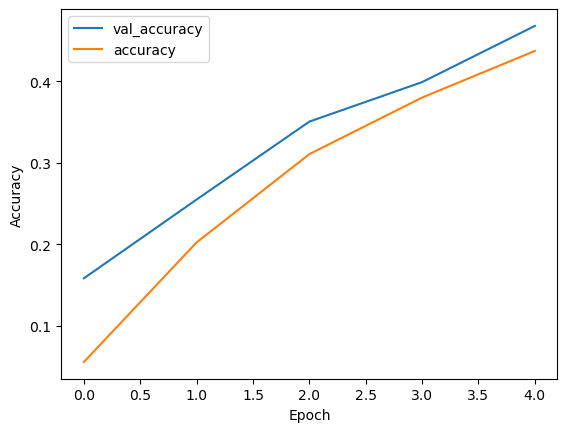

In [23]:
if mode == "training":
    import matplotlib.pyplot as plt
    fig = plt.figure()

    plt.plot(val_accuracy, label='val_accuracy')

    plt.plot(accuracy, label='accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim([0.5, 1])
    plt.legend()

In [24]:
lips = lip_marks
left_hand = [*range(start_left_hand, start_left_hand+left_hand_landmarks, 1)]
right_hand = [*range(start_right_hand, start_right_hand+right_hand_landmarks, 1)]
meaningful_keypoints = lips + left_hand + right_hand


def get_inference_model(model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs")
    
    # drop most of the face mesh
    x = tf.gather(inputs, meaningful_keypoints, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates ()
    x = tf.concat([x[...,i] for i in range(3)], -1)

    x = tf.expand_dims(x,0)
    
    # call trained model
    out = model(x)
    
    # explicitly name the final (identity) layer for the submission format
    outputs = layers.Activation("linear", name="outputs")(out)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

In [25]:
inference_model = get_inference_model(model)
inference_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 82, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 82, 3)        0           ['tf.compat.v1.gather[0][0]

In [26]:
if mode == "training":
    converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
    tflite_model = converter.convert()

In [30]:
if mode == "training":
    with open('/kaggle/working/model.tflite', 'wb') as f:
        f.write(tflite_model)

In [31]:
if mode == "submission":
    !cp -r /kaggle/input/tflite-model/model.tflite ./

In [32]:
!zip submission.zip model.tflite

  adding: model.tflite (deflated 8%)
